# Image Classification Using Swin Transformer

Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [3]:
import torch
import torch.nn as nn
from timm.layers import DropPath, to_2tuple, trunc_normal_

In [4]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = 'test.JPG'
image = Image.open(image_path)



# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [5]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches


In [6]:

# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


# displaying all the patches (4*4) to visualize properly

Total number of windows: 3136


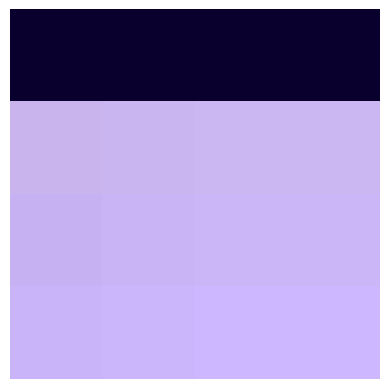

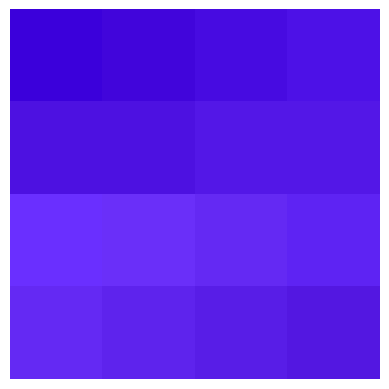

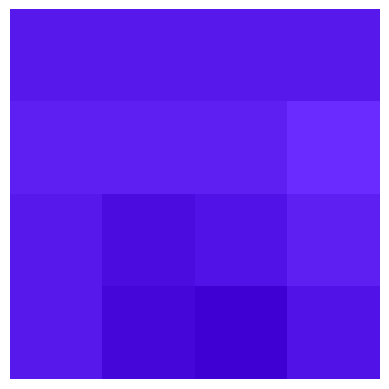

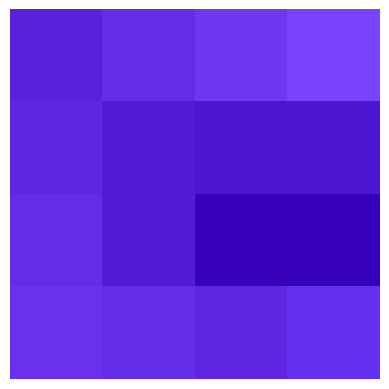

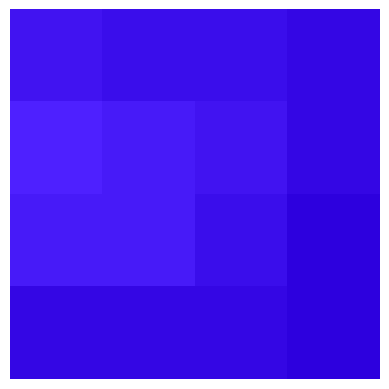

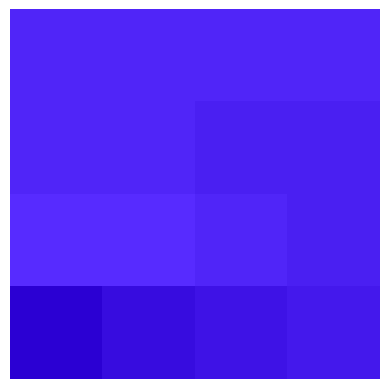

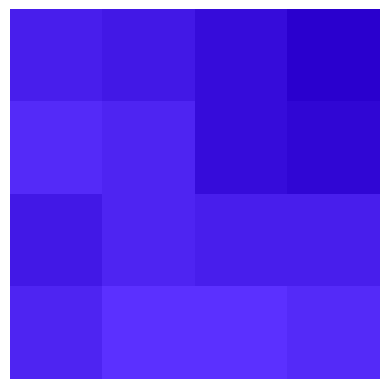

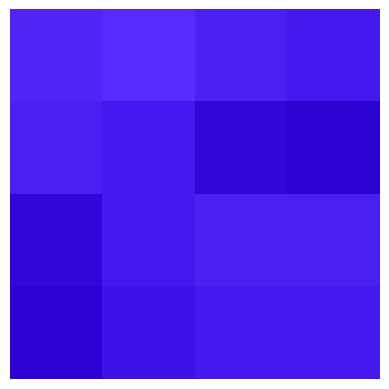

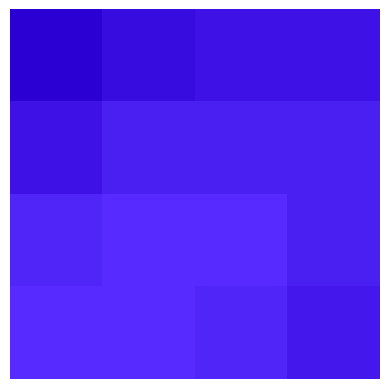

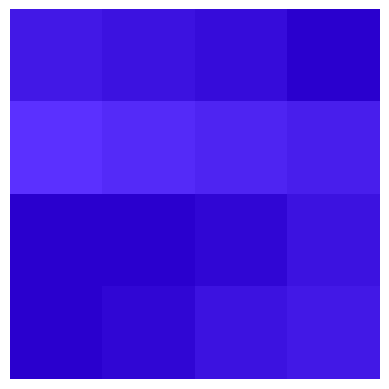

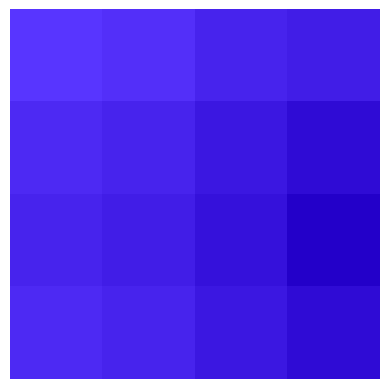

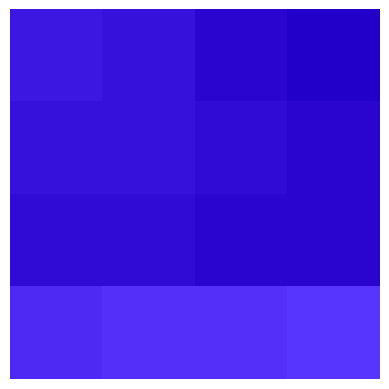

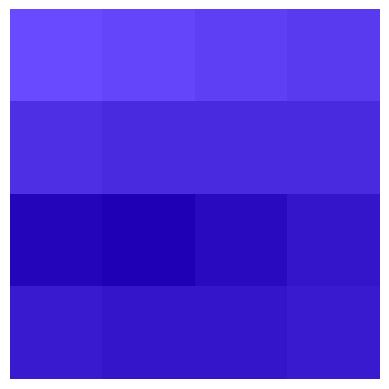

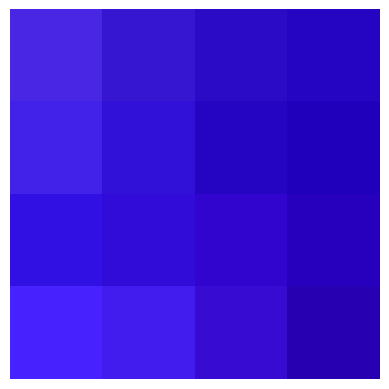

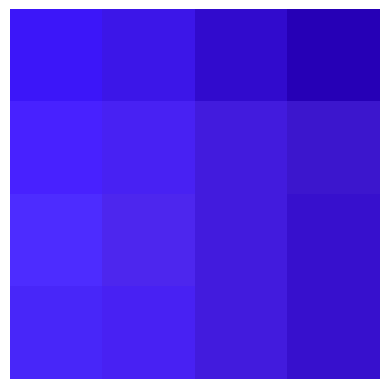

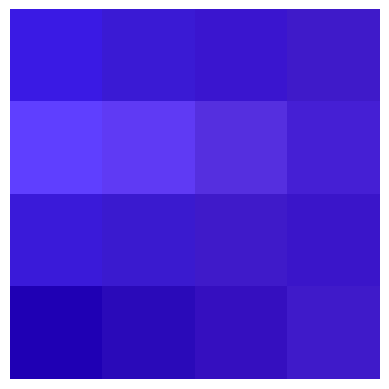

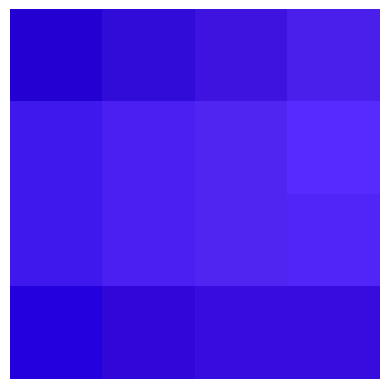

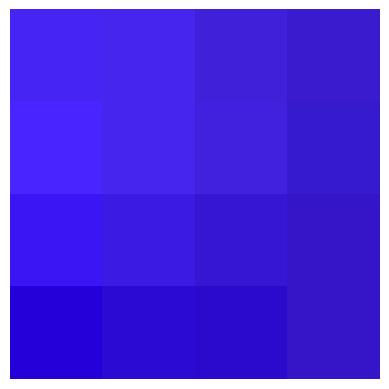

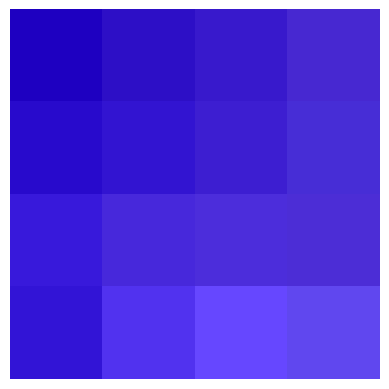

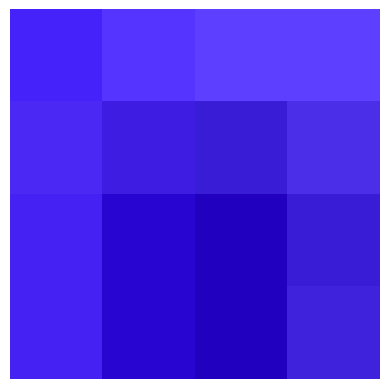

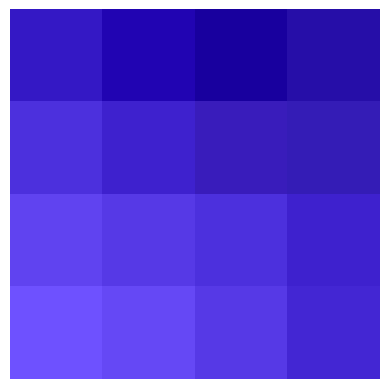

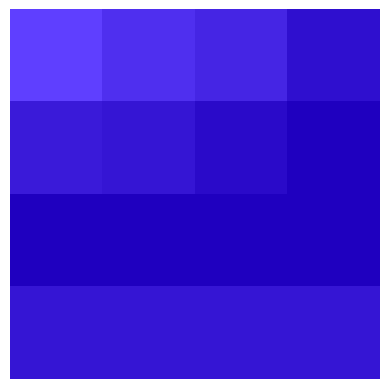

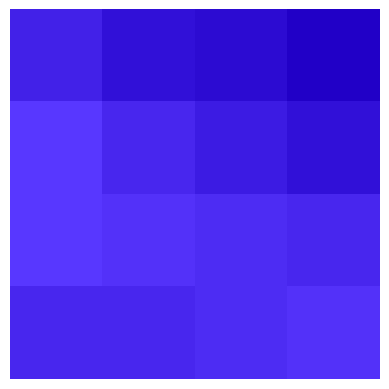

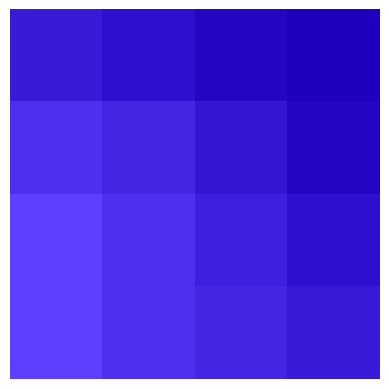

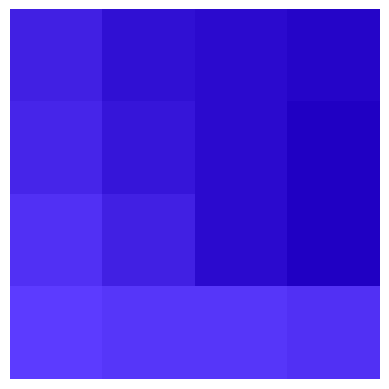

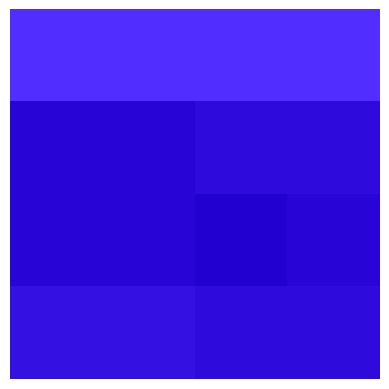

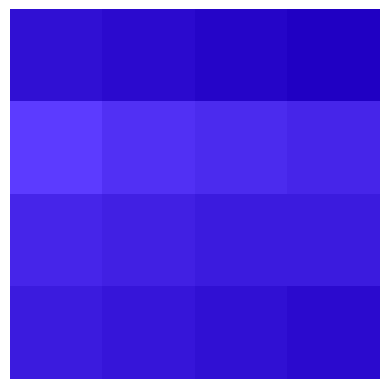

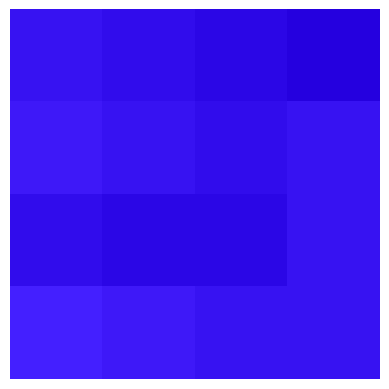

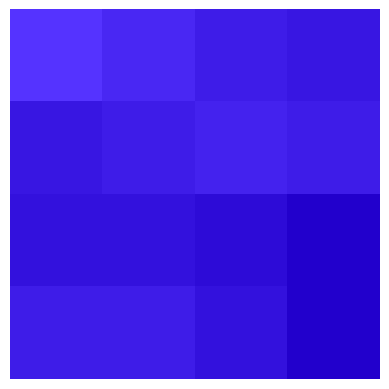

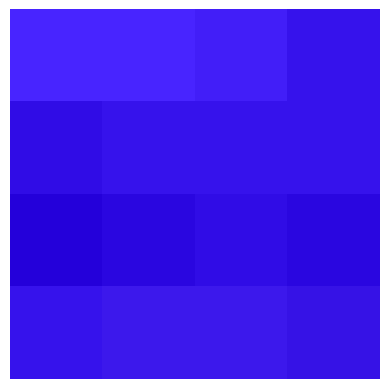

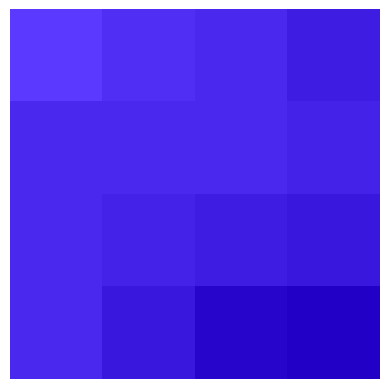

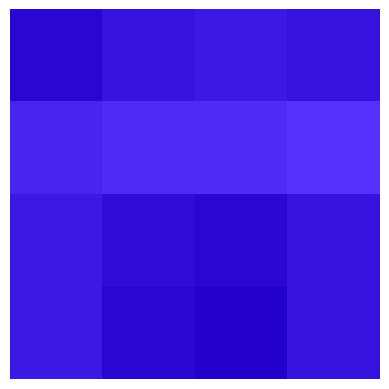

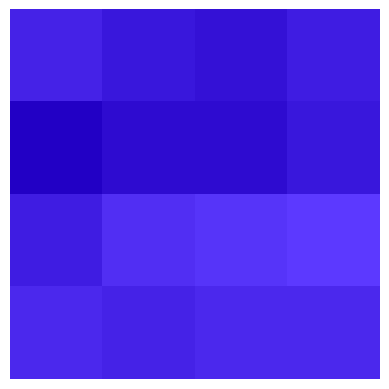

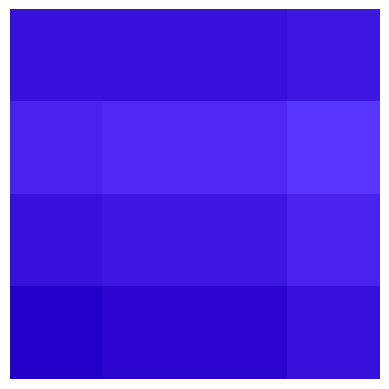

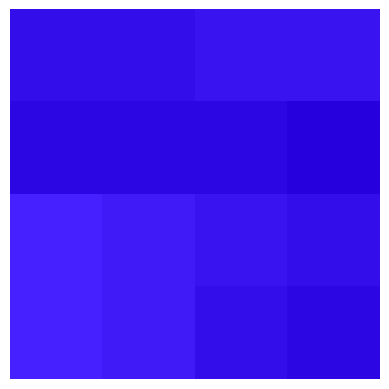

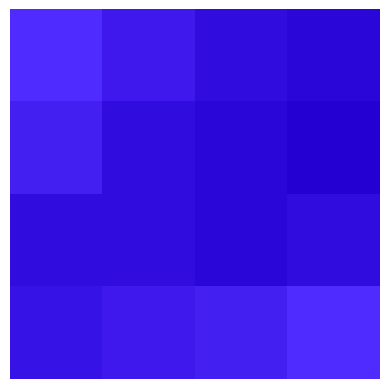

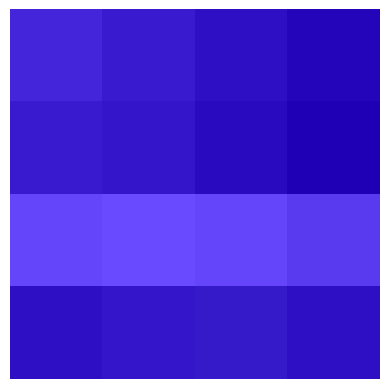

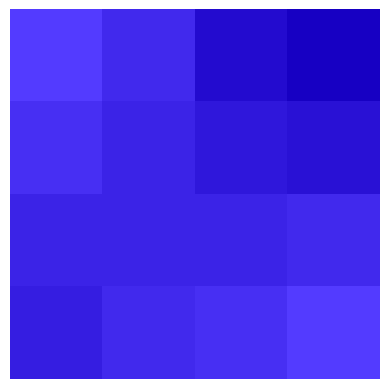

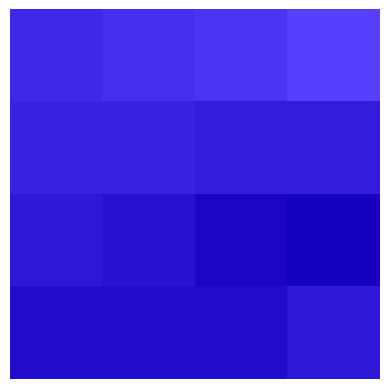

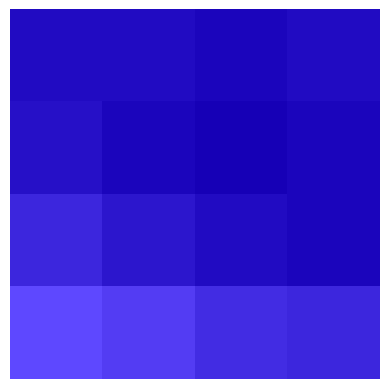

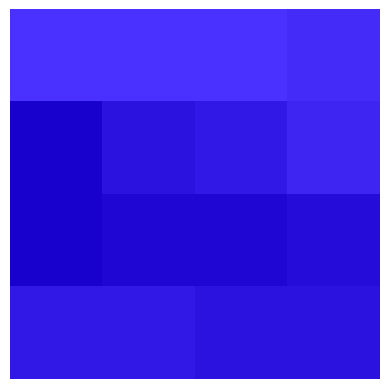

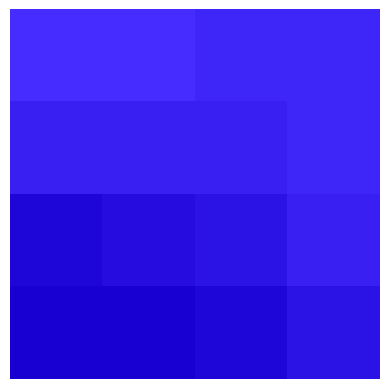

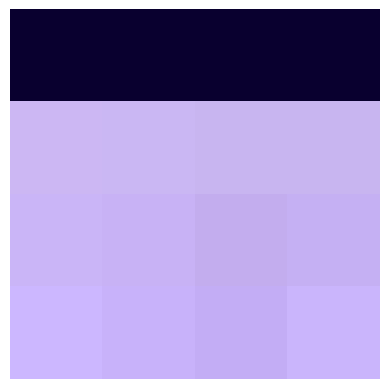

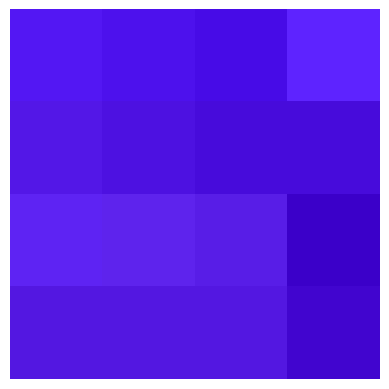

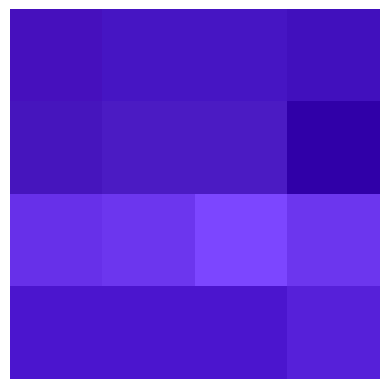

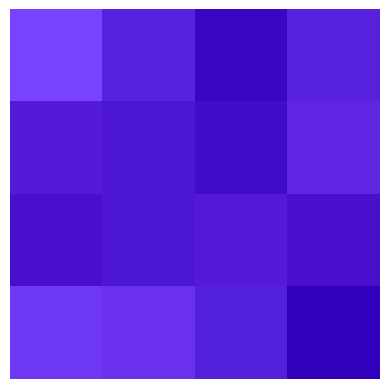

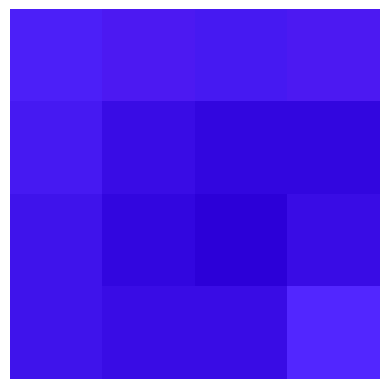

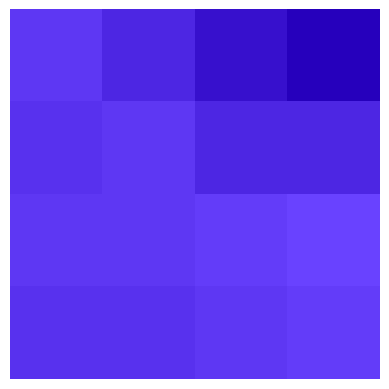

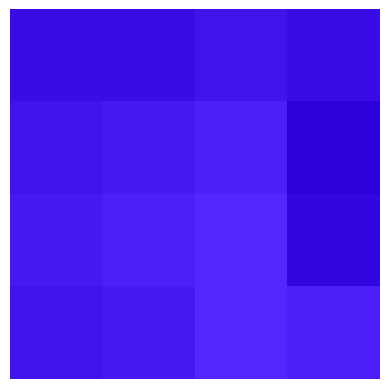

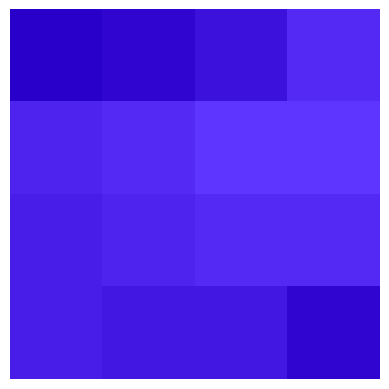

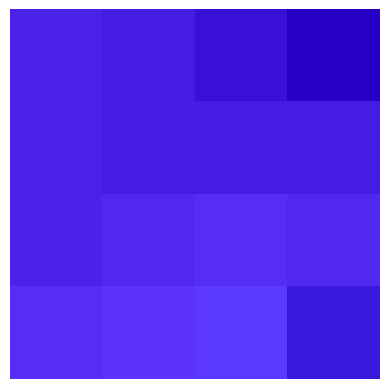

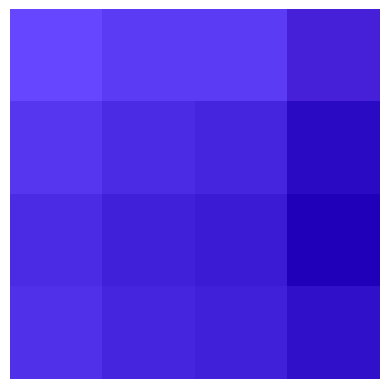

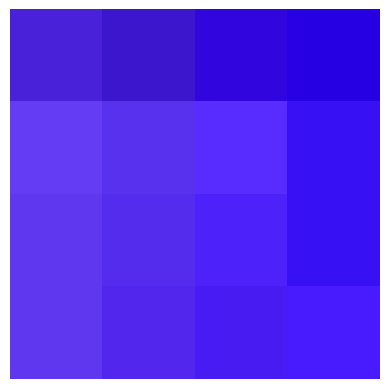

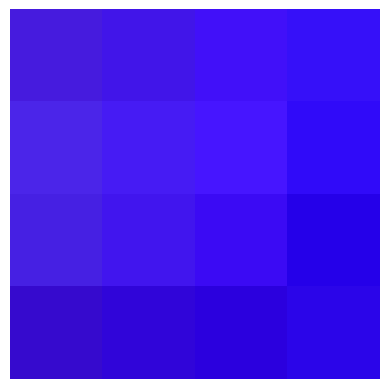

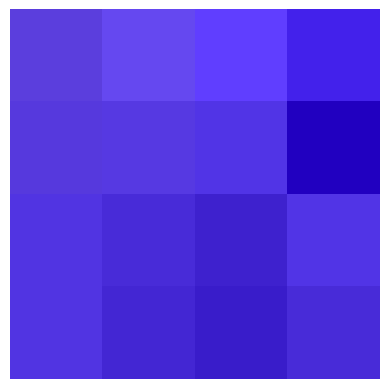

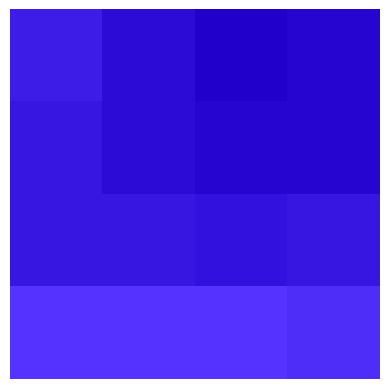

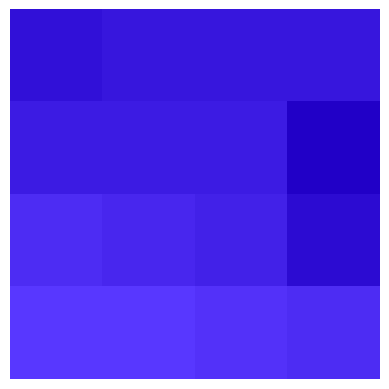

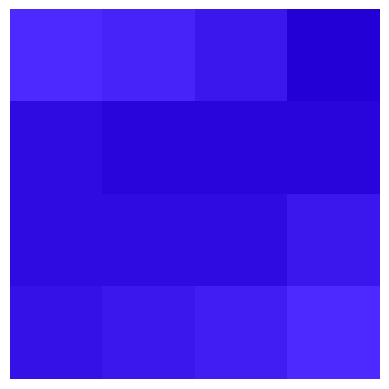

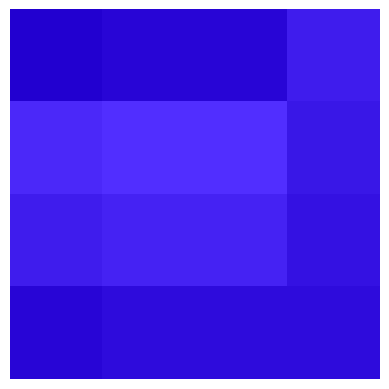

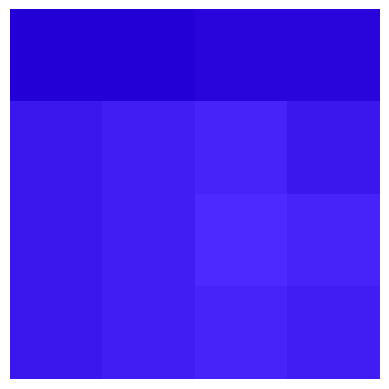

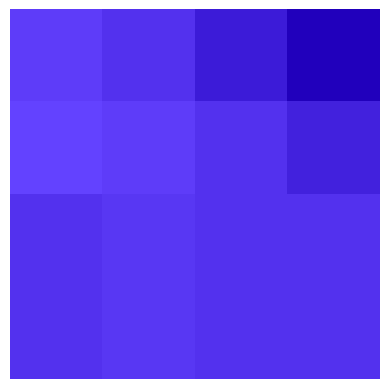

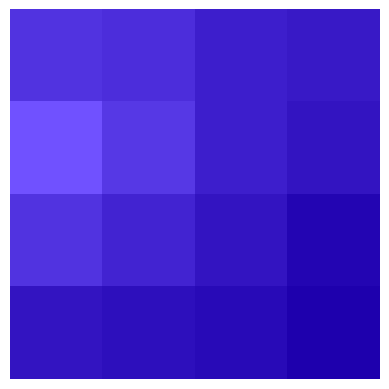

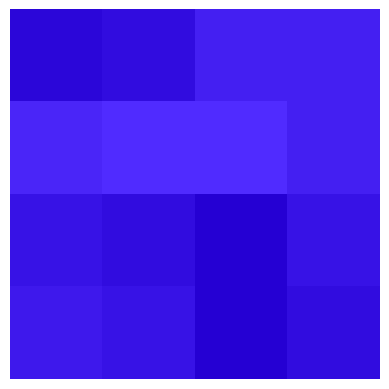

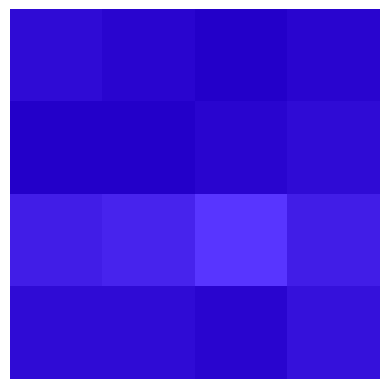

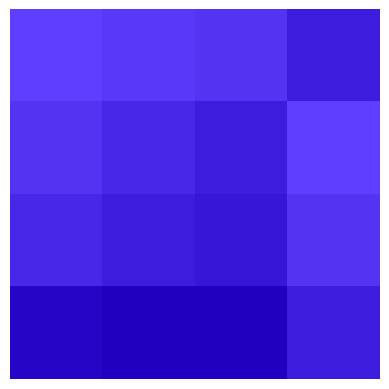

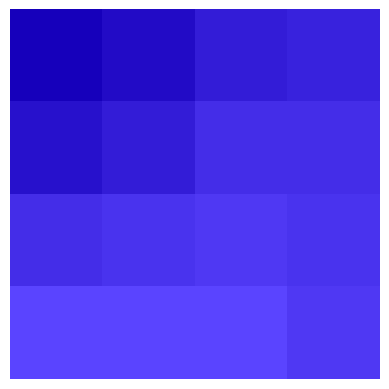

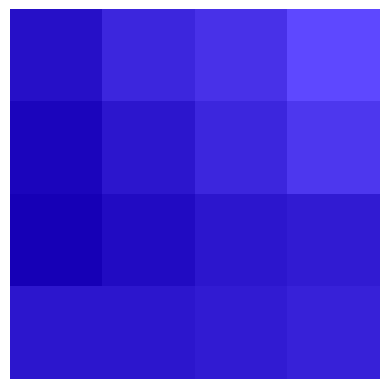

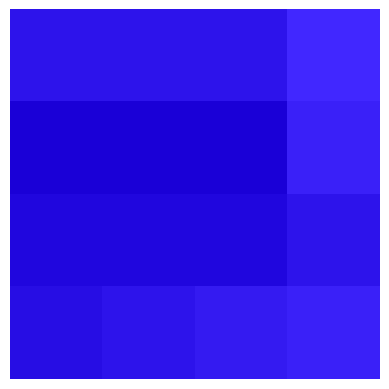

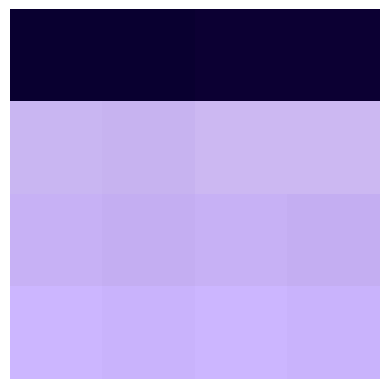

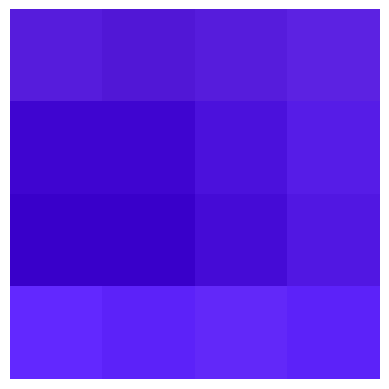

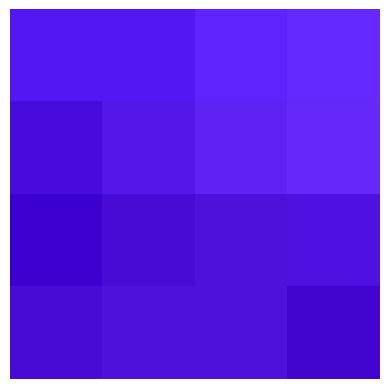

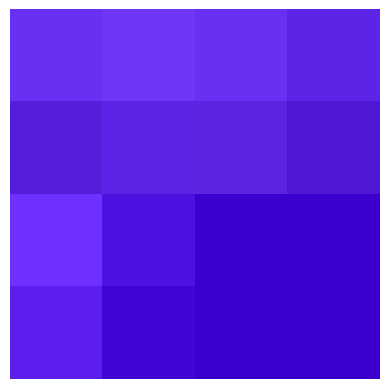

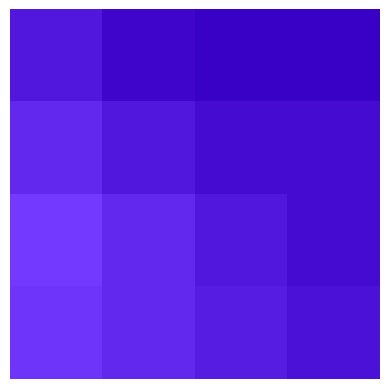

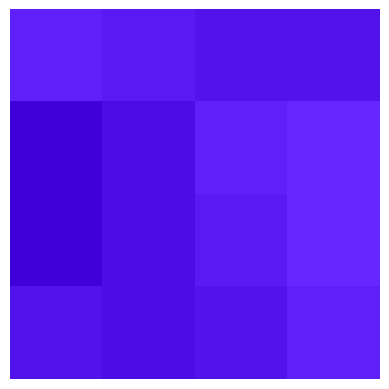

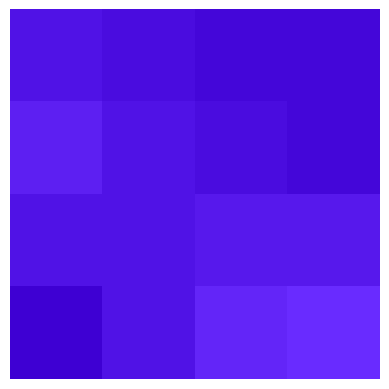

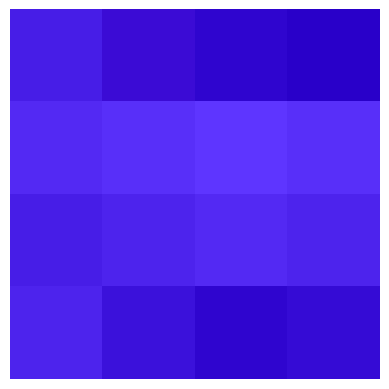

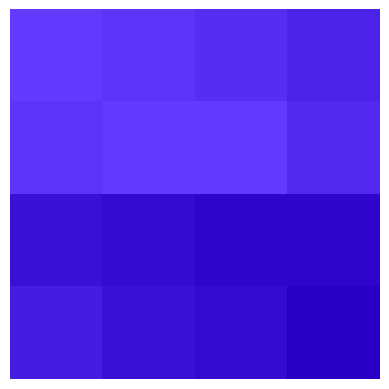

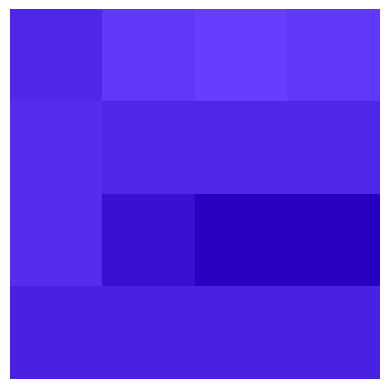

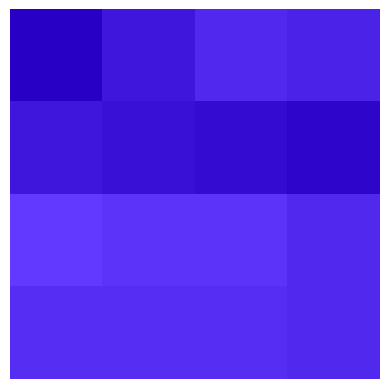

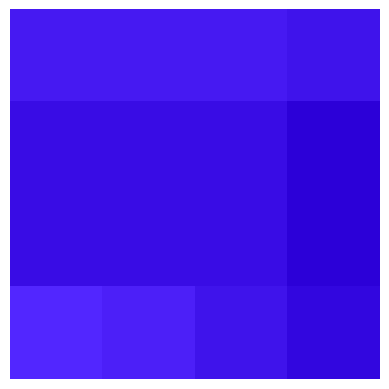

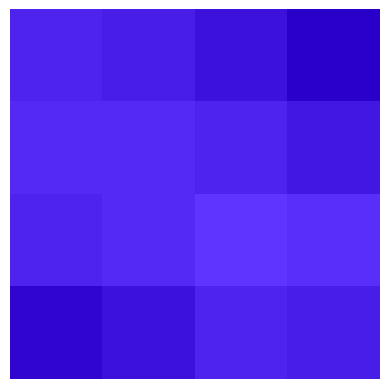

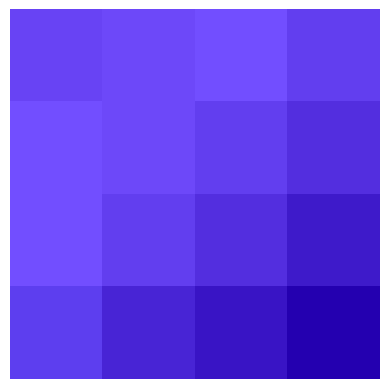

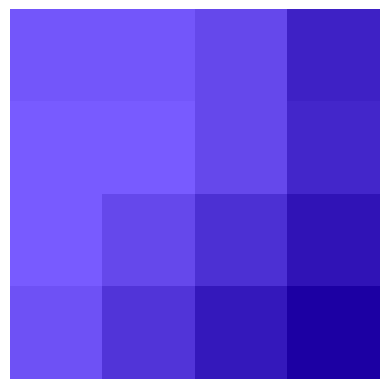

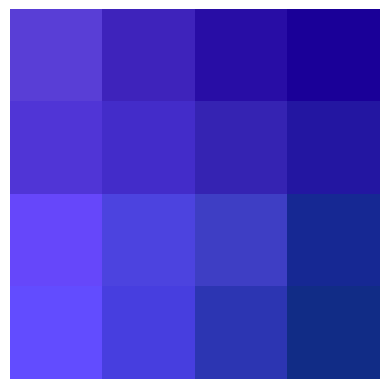

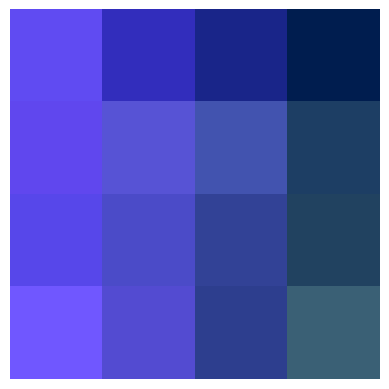

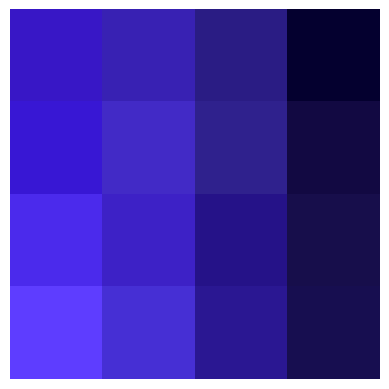

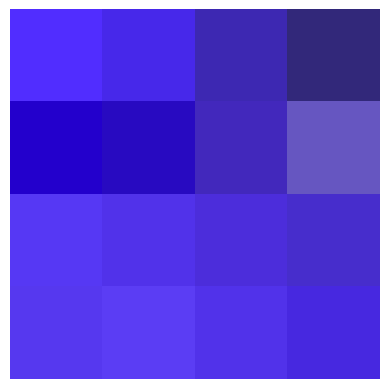

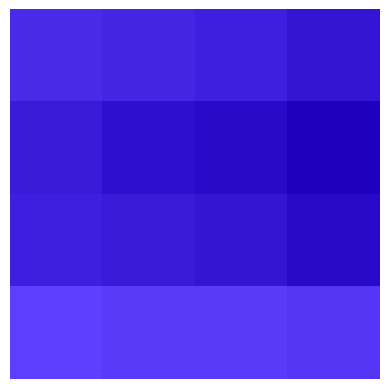

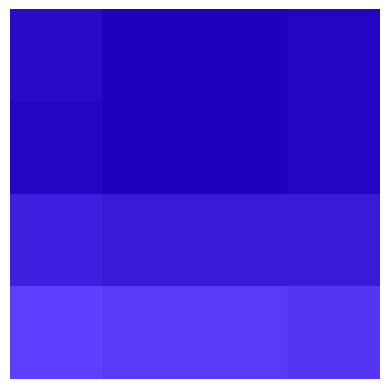

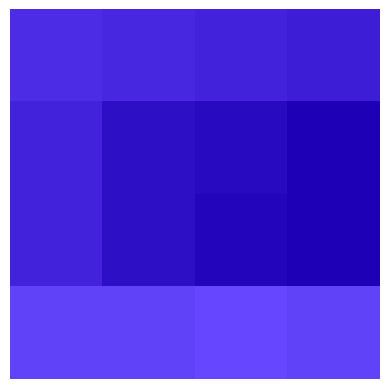

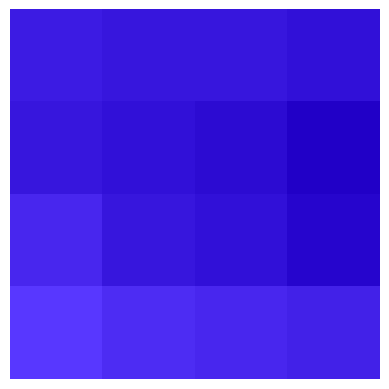

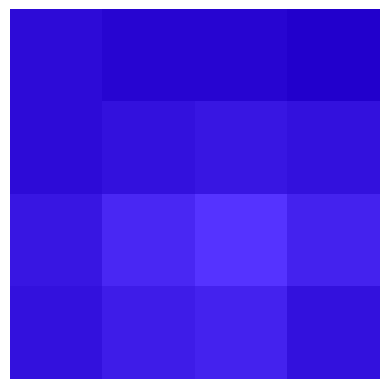

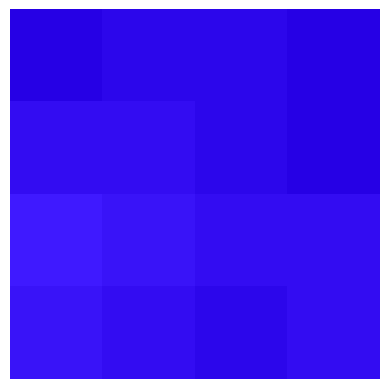

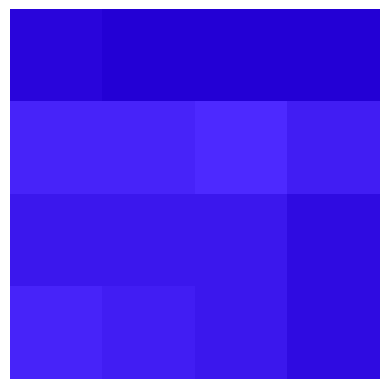

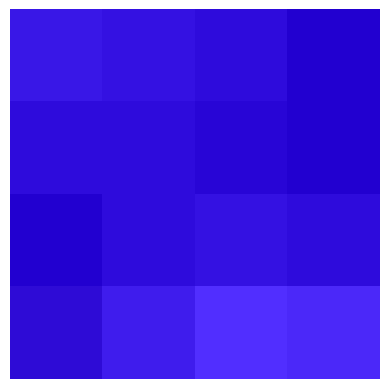

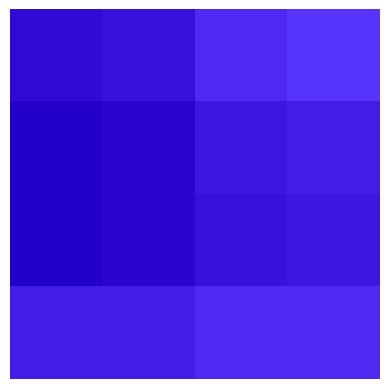

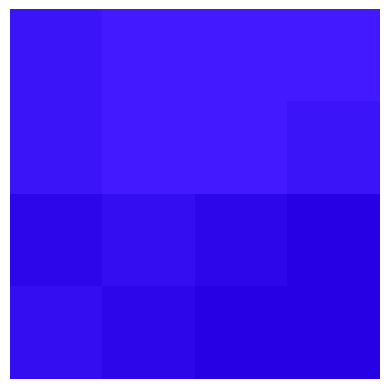

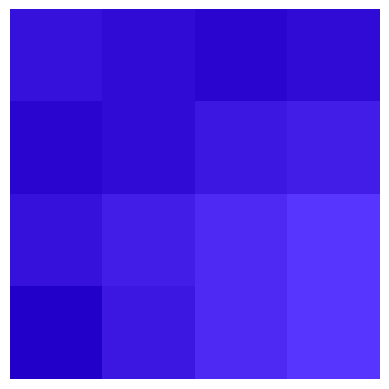

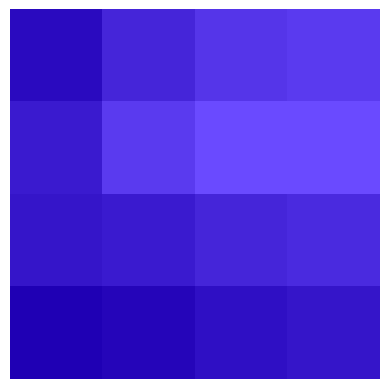

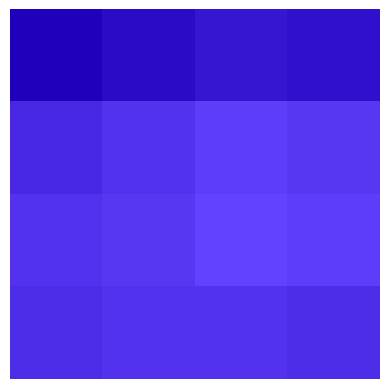

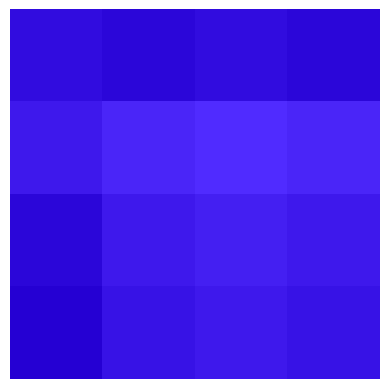

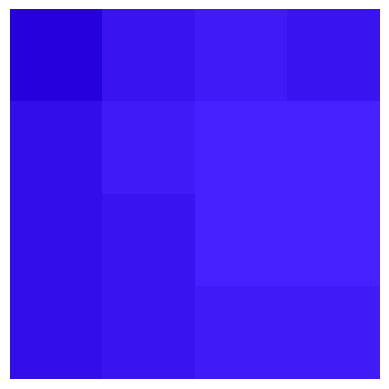

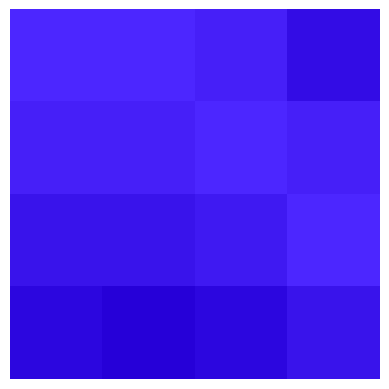

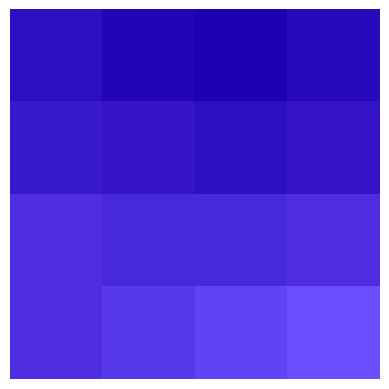

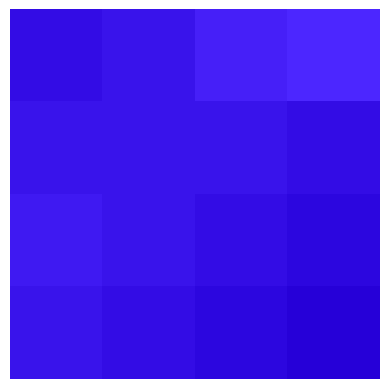

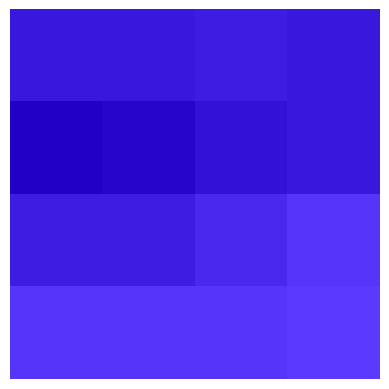

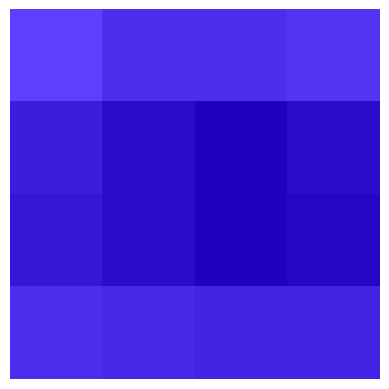

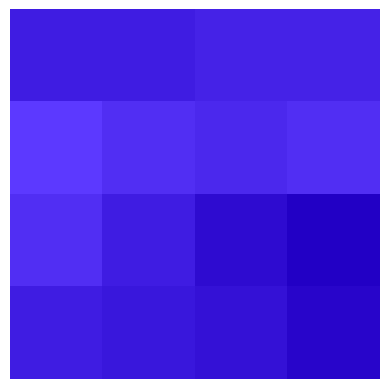

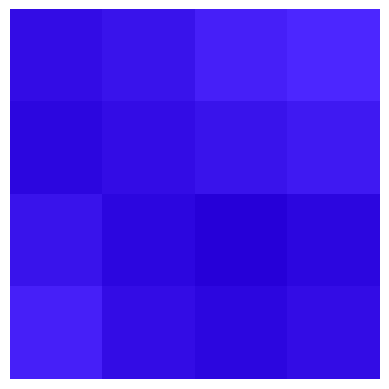

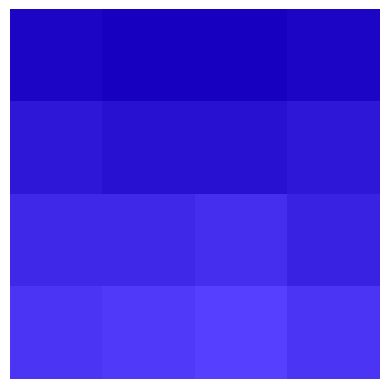

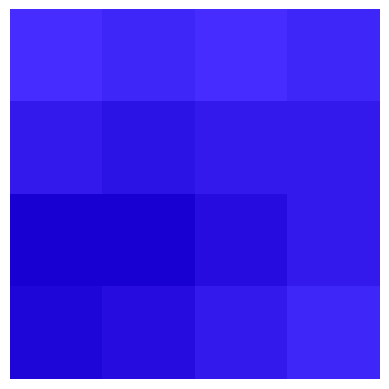

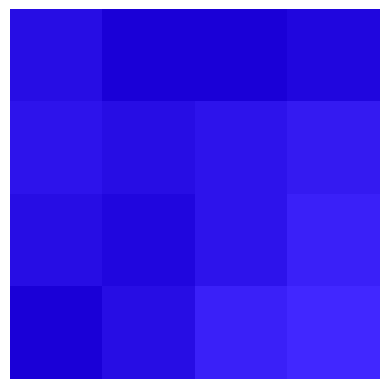

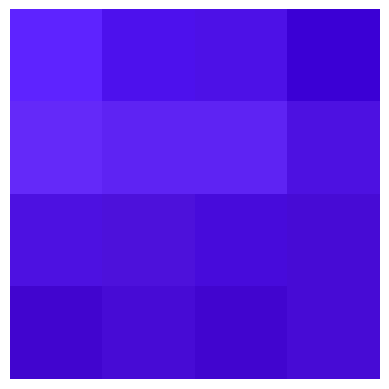

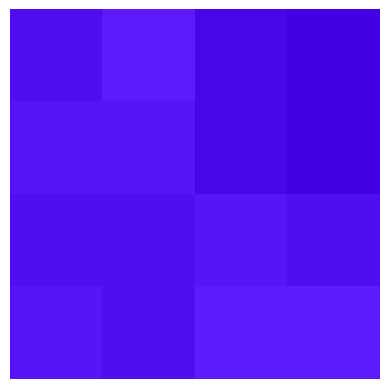

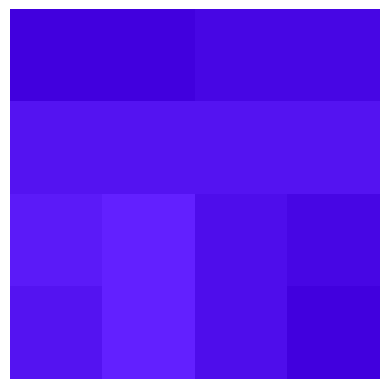

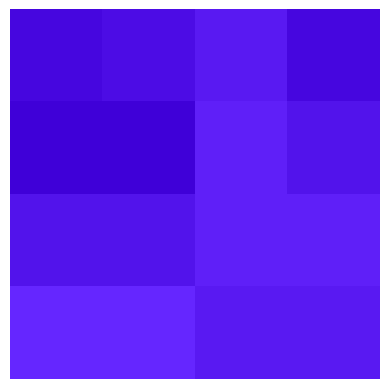

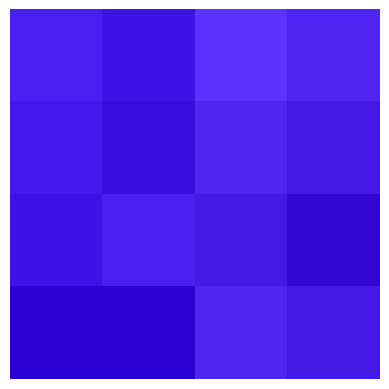

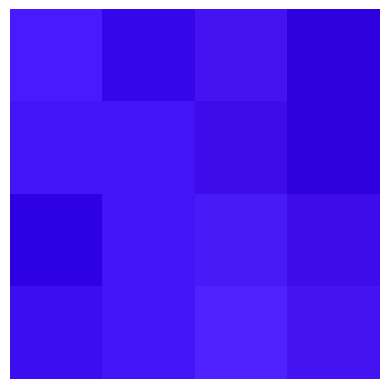

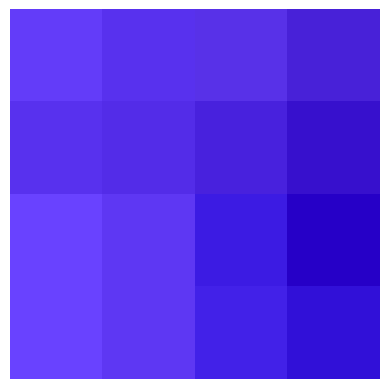

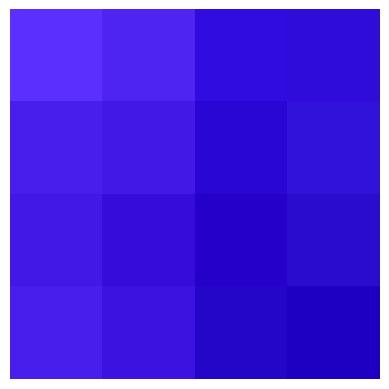

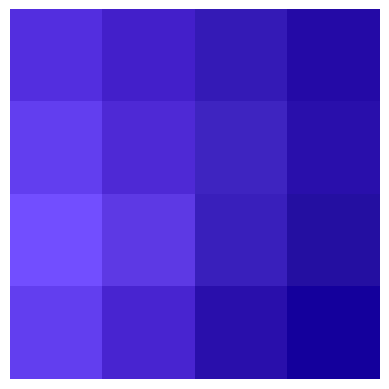

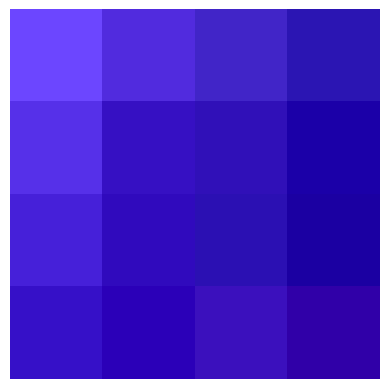

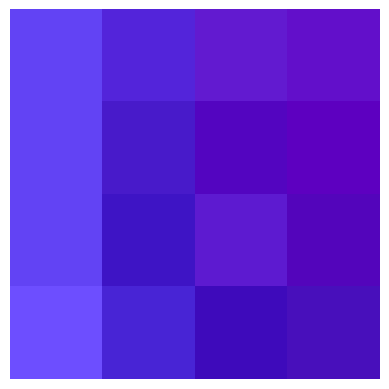

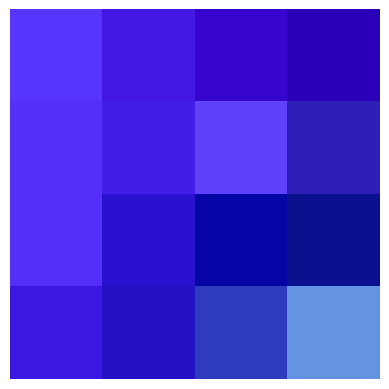

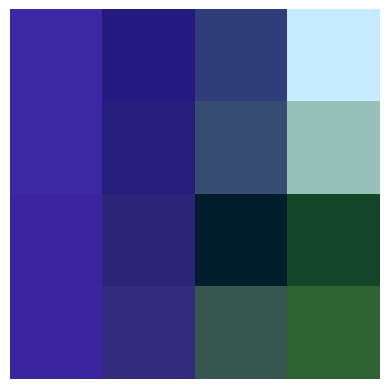

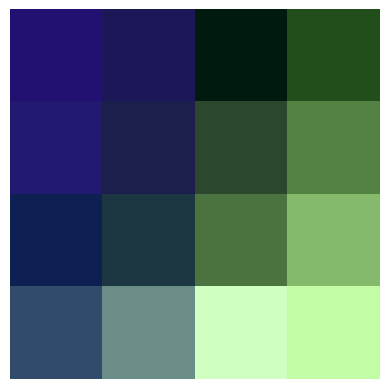

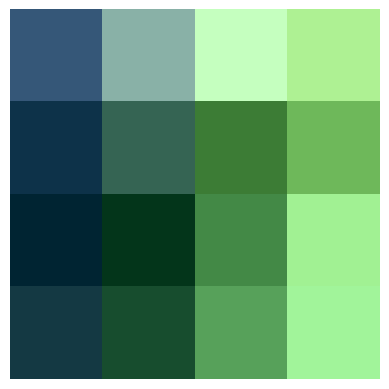

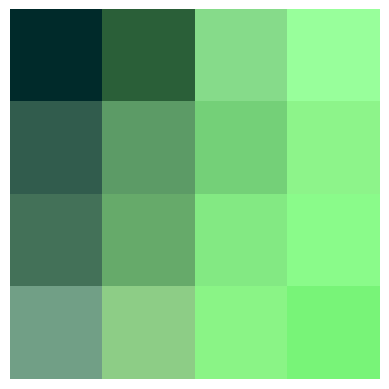

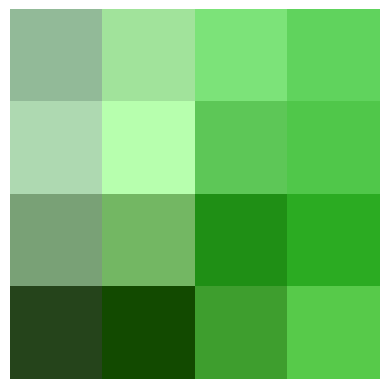

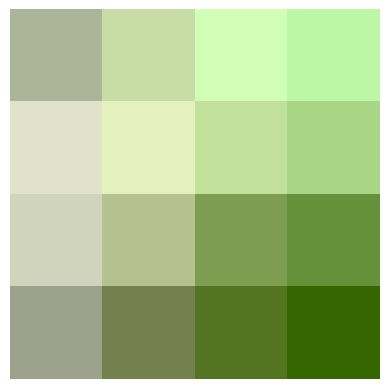

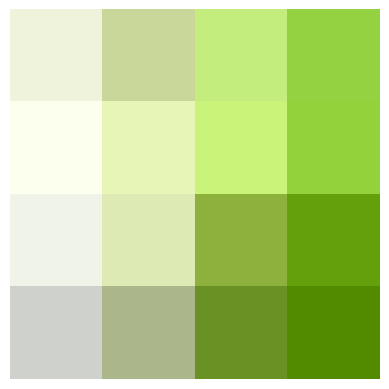

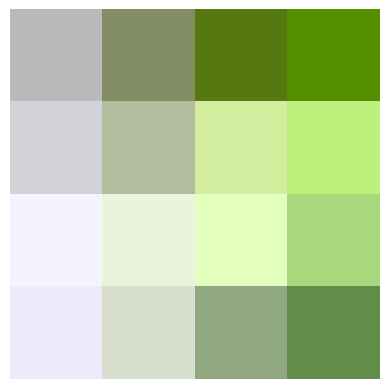

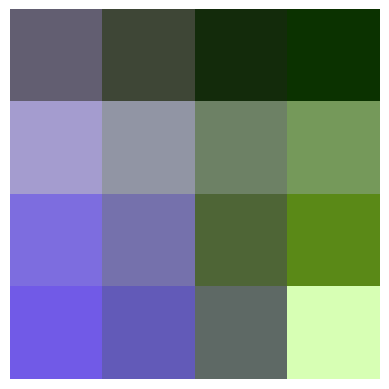

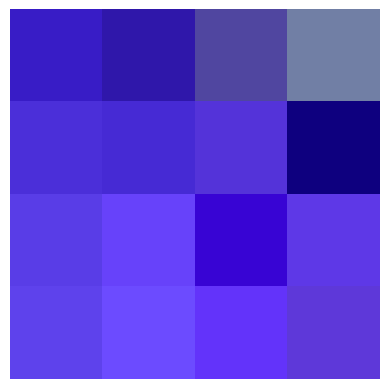

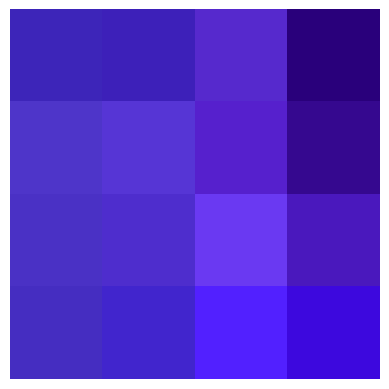

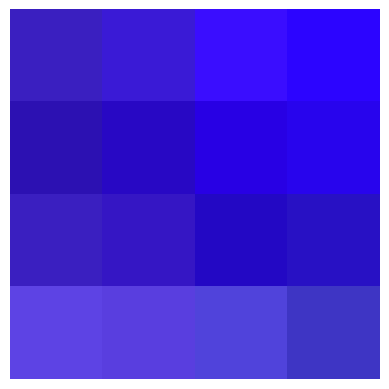

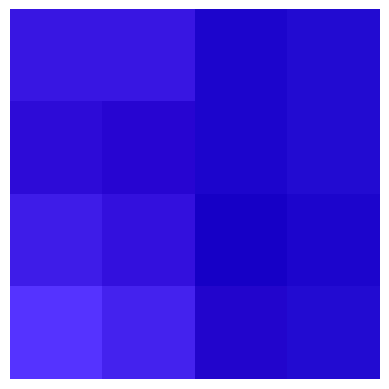

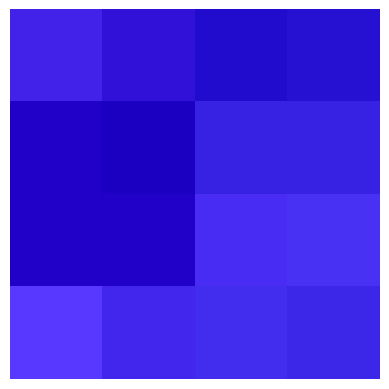

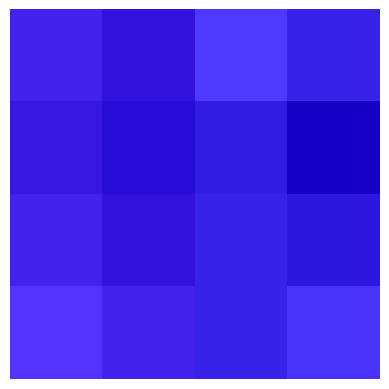

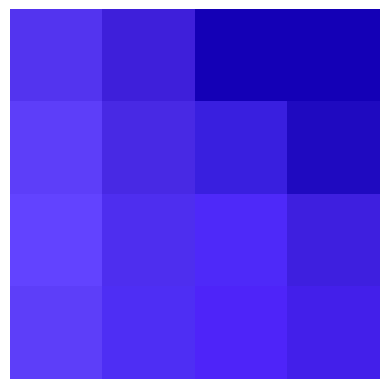

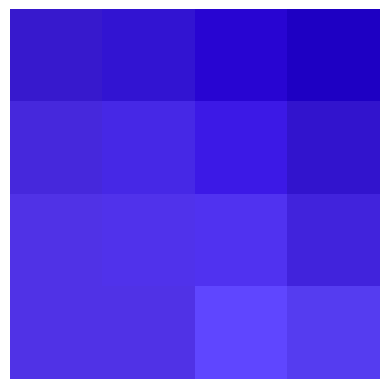

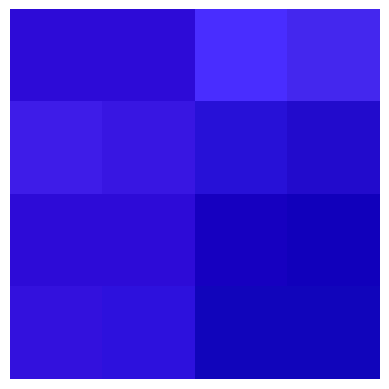

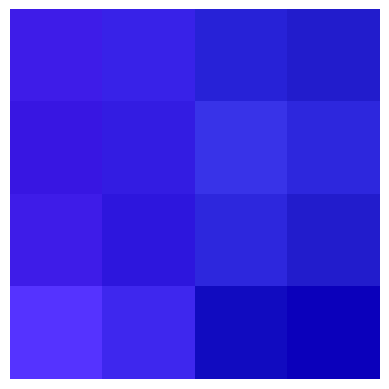

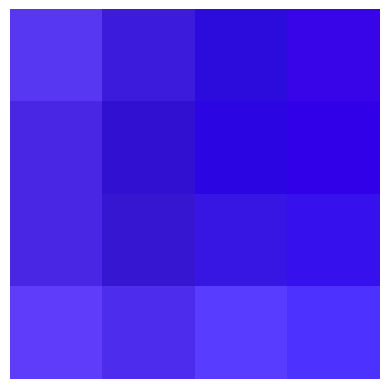

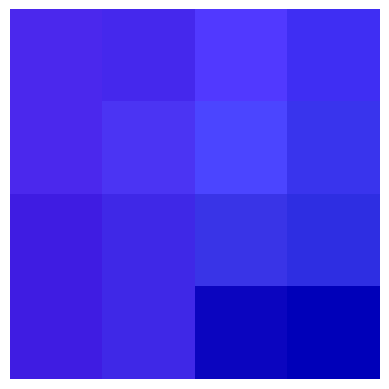

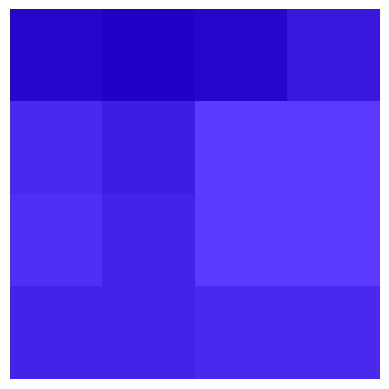

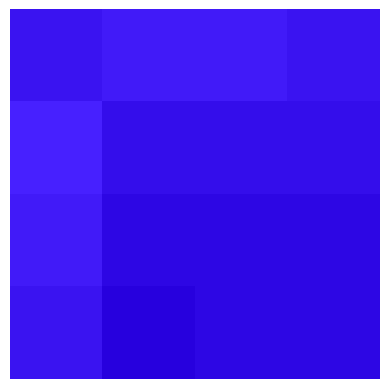

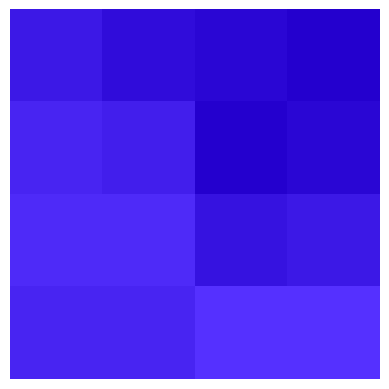

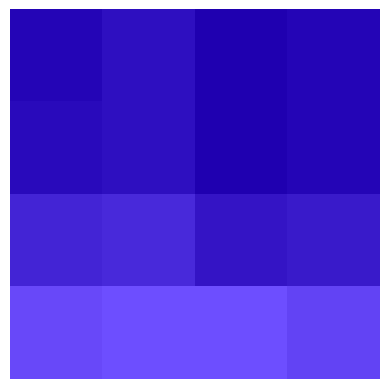

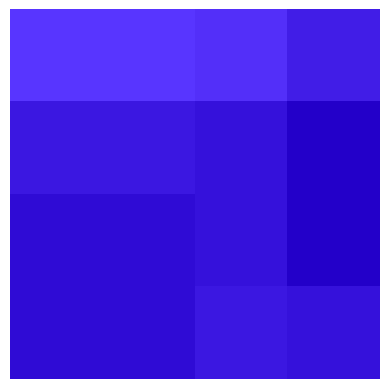

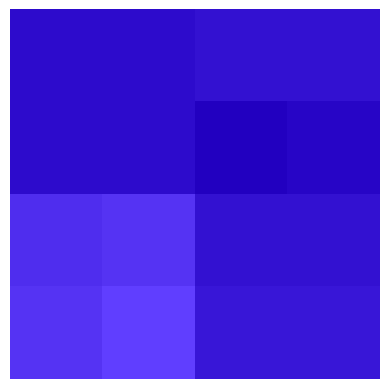

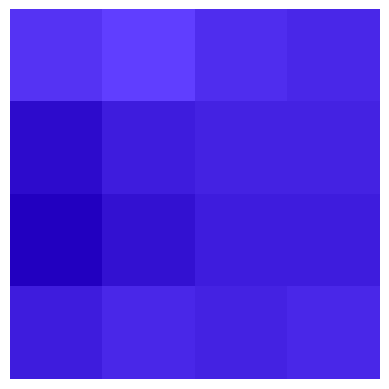

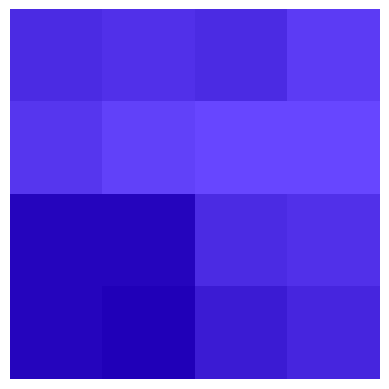

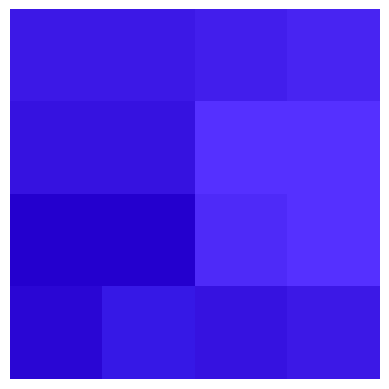

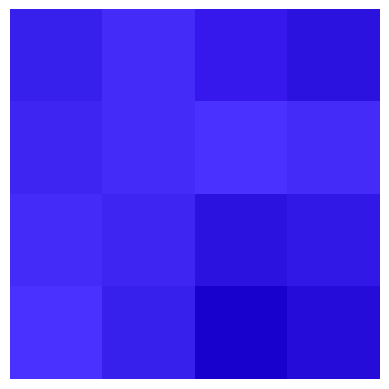

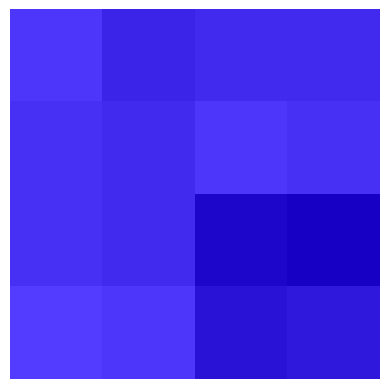

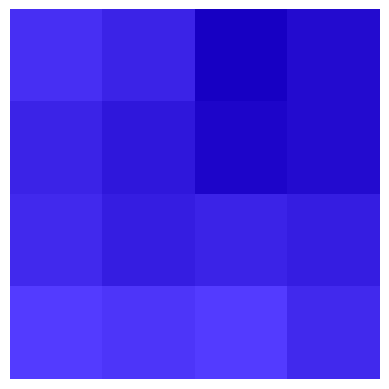

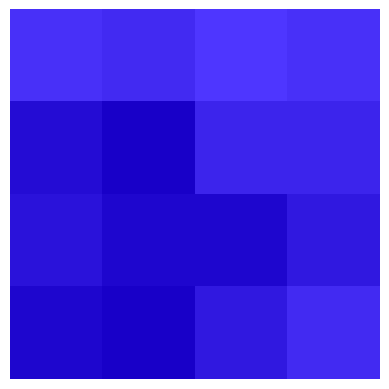

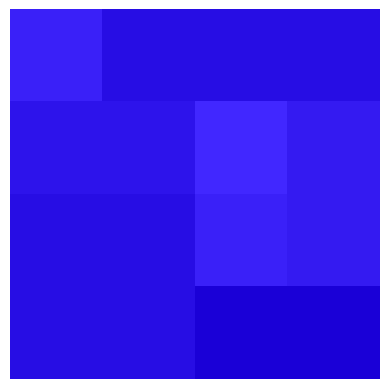

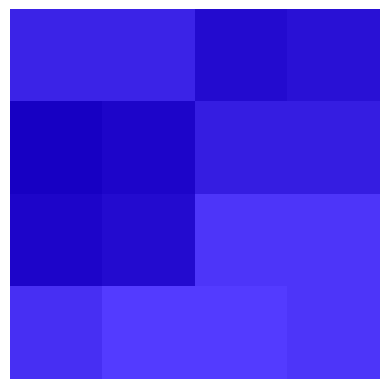

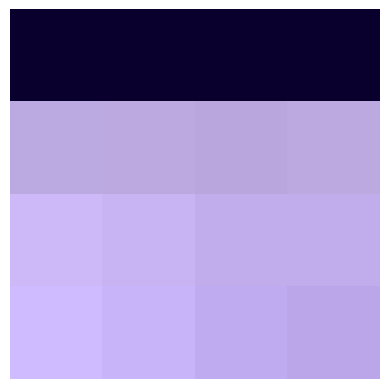

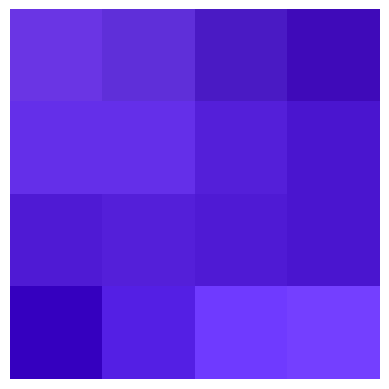

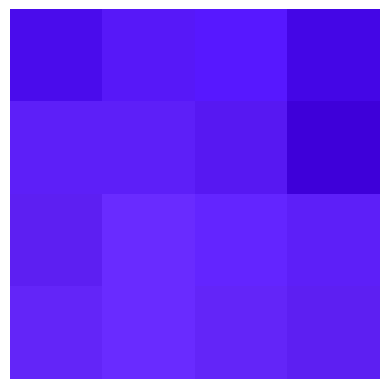

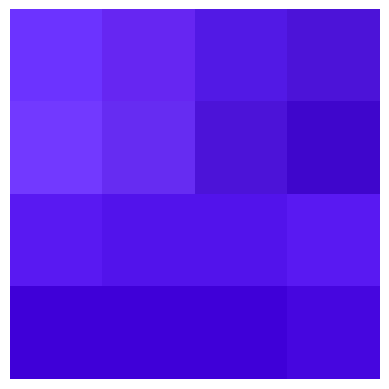

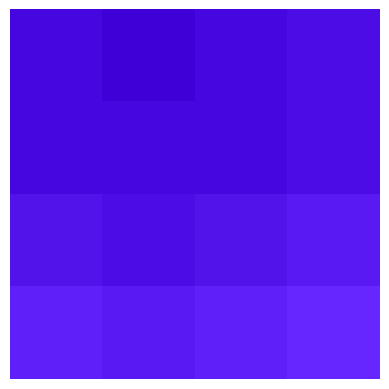

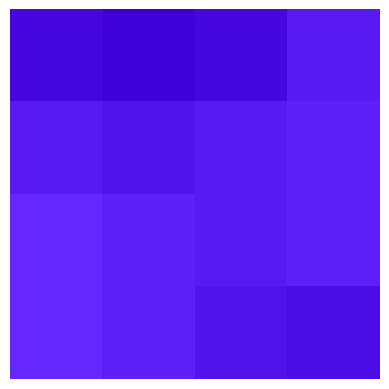

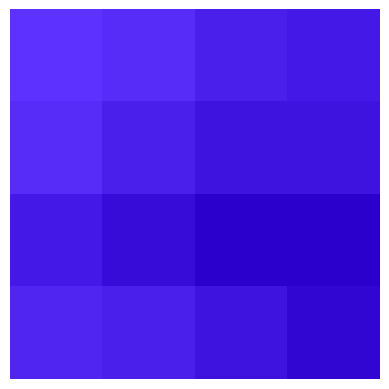

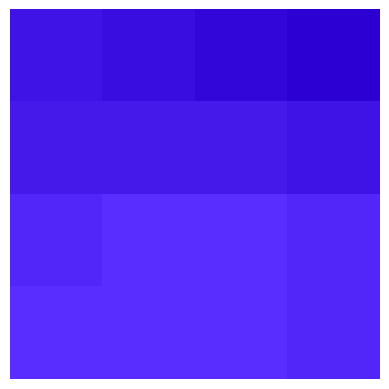

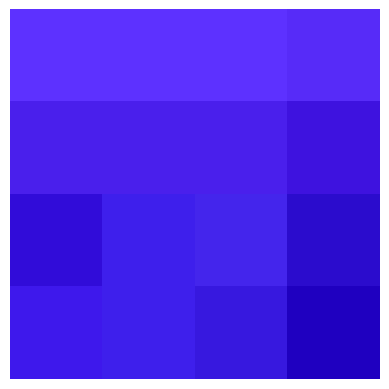

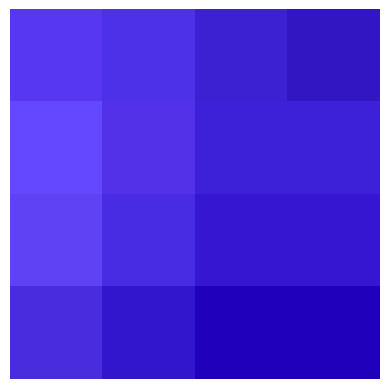

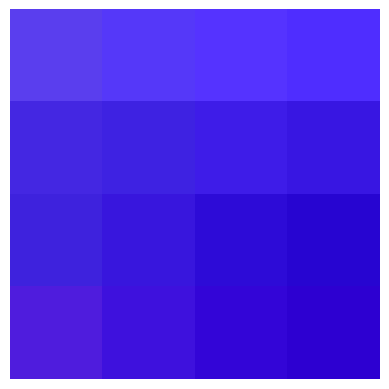

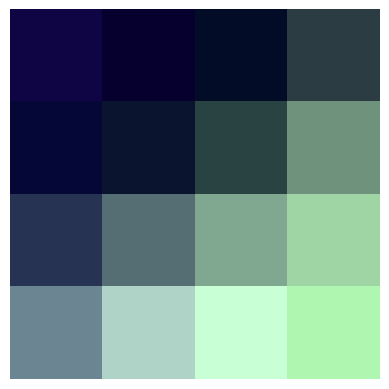

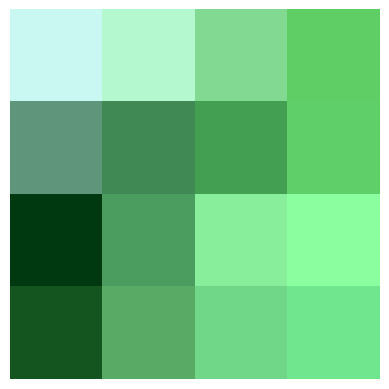

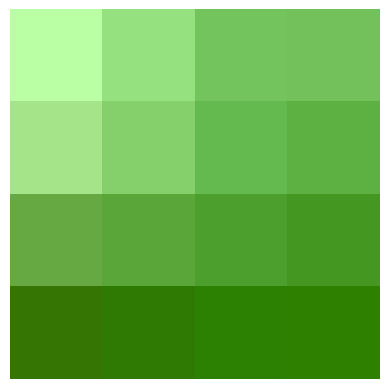

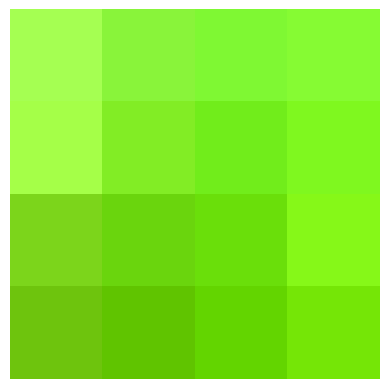

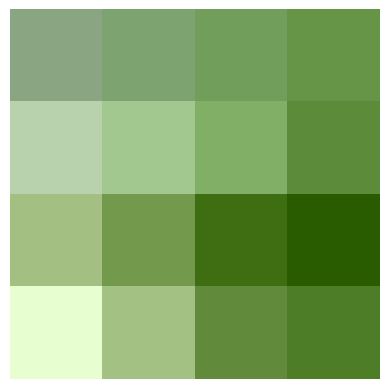

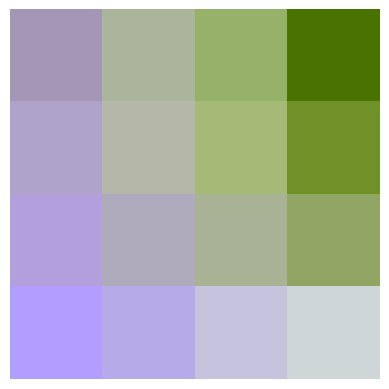

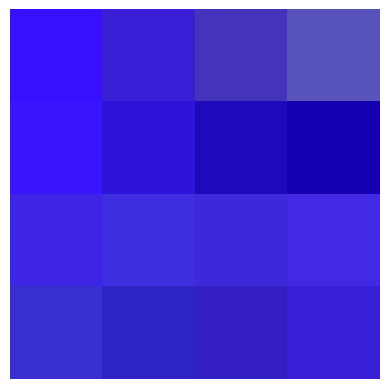

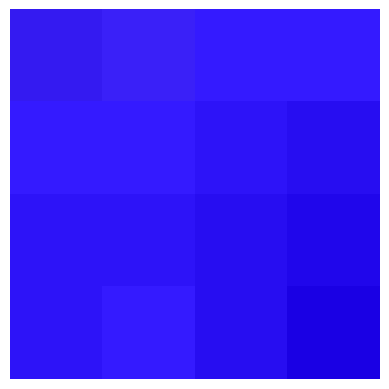

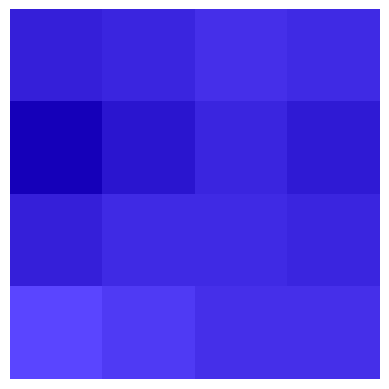

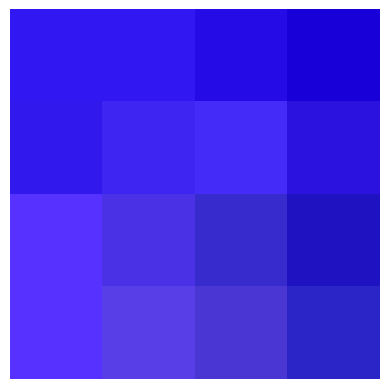

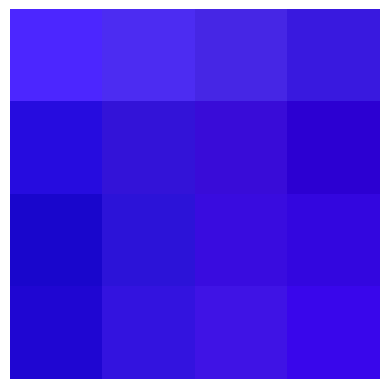

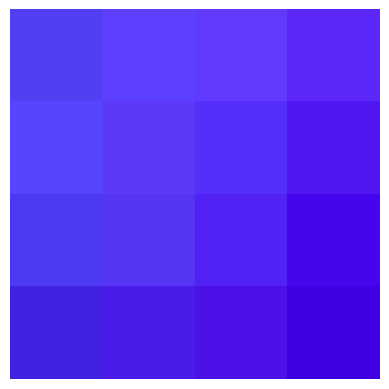

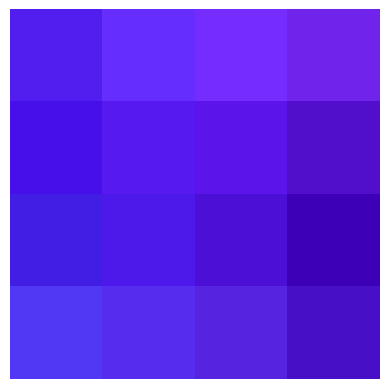

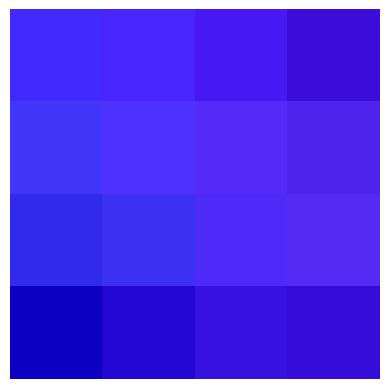

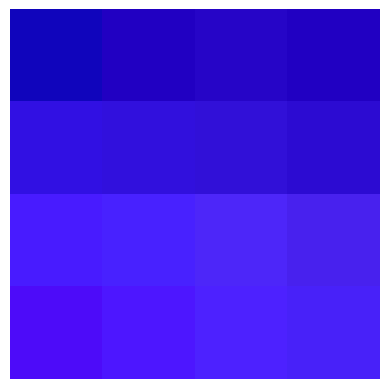

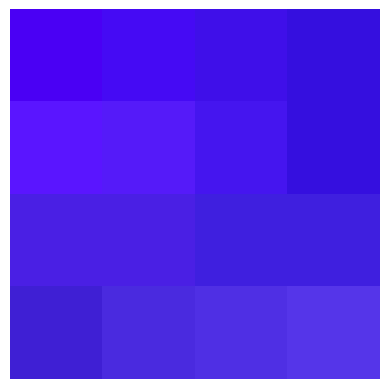

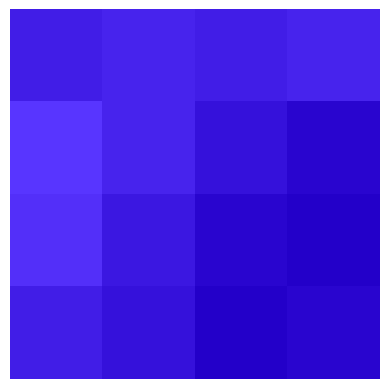

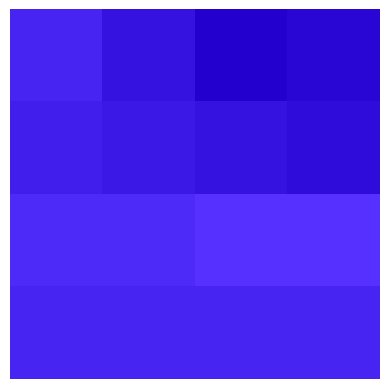

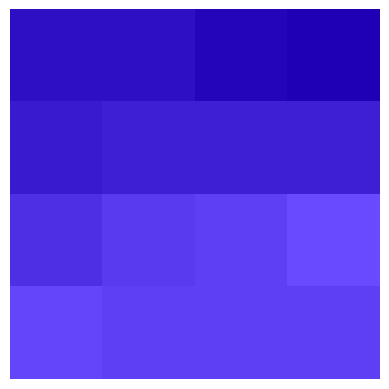

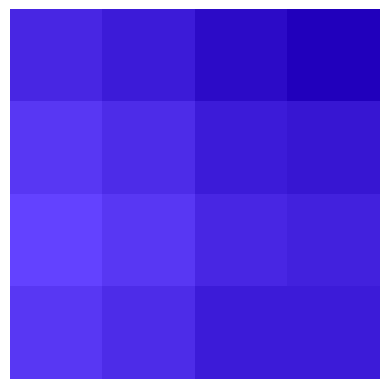

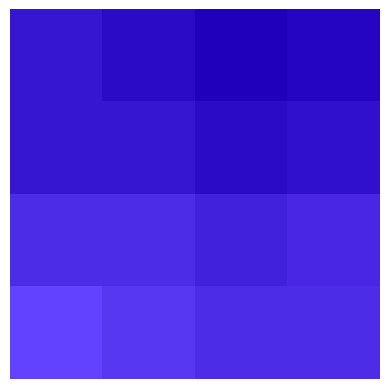

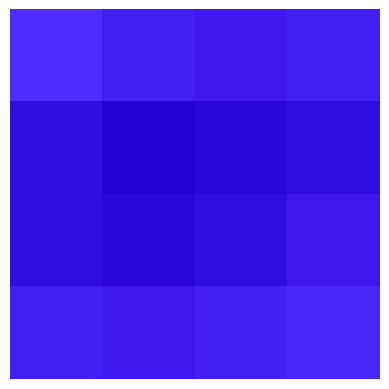

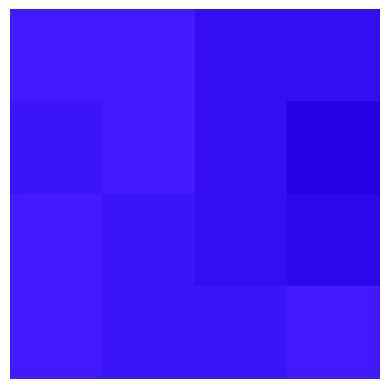

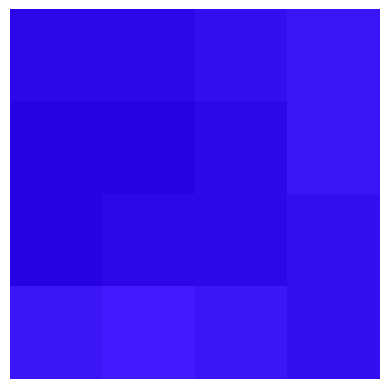

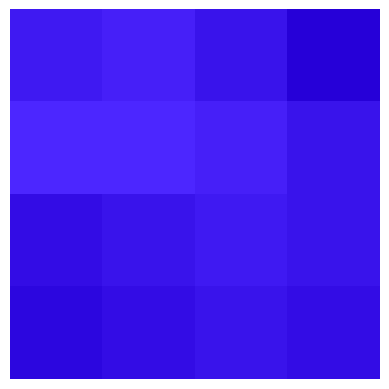

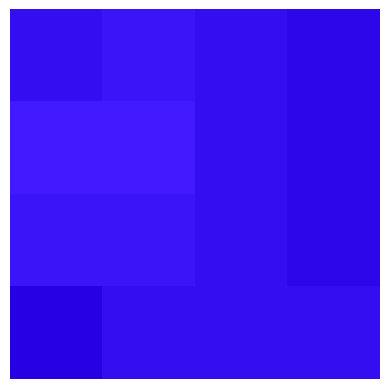

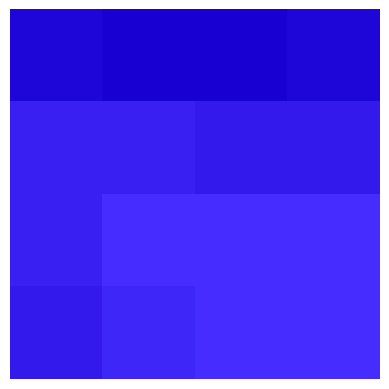

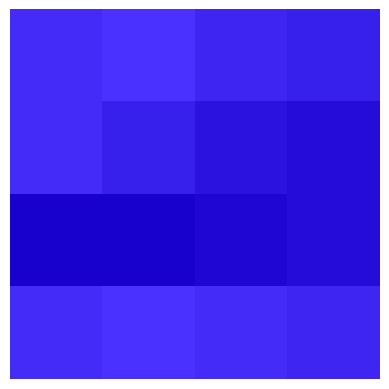

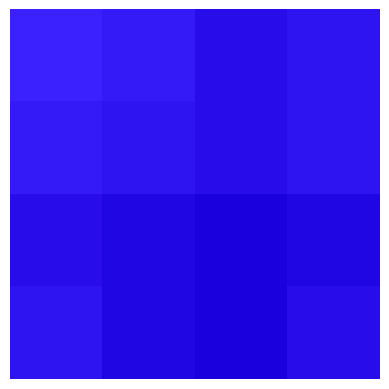

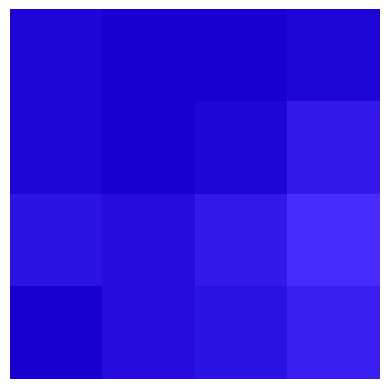

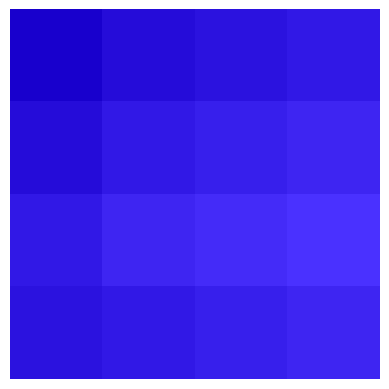

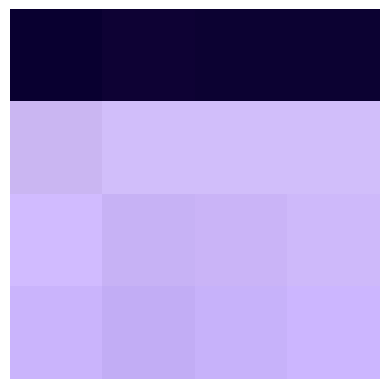

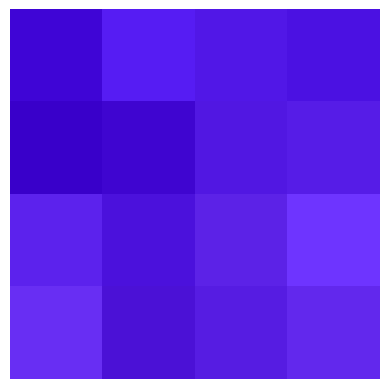

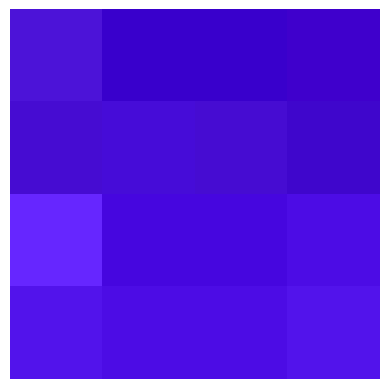

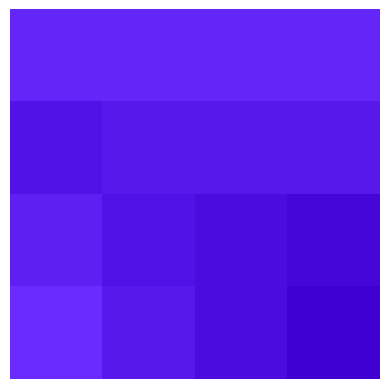

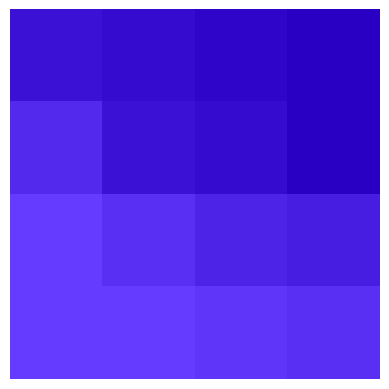

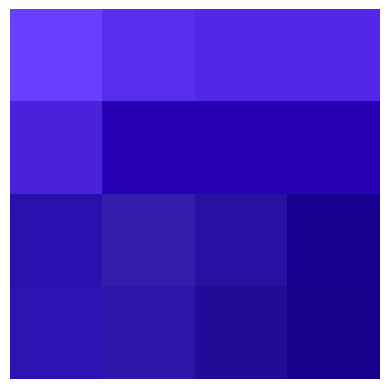

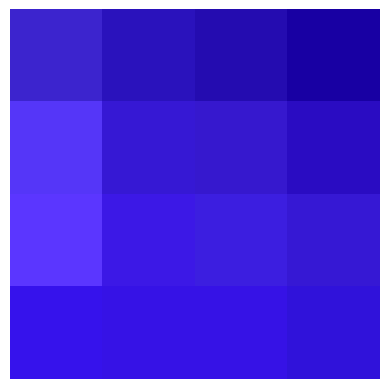

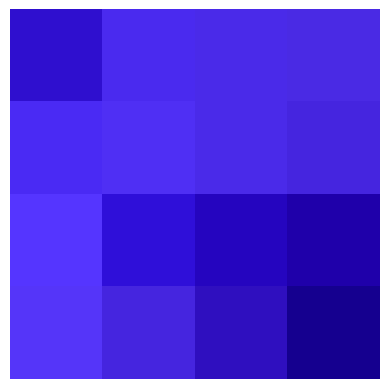

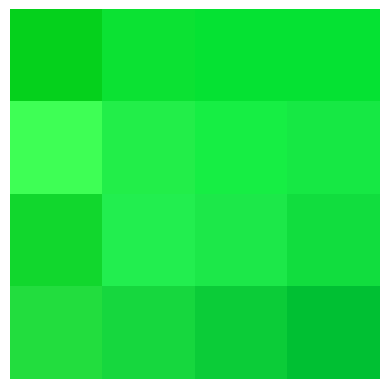

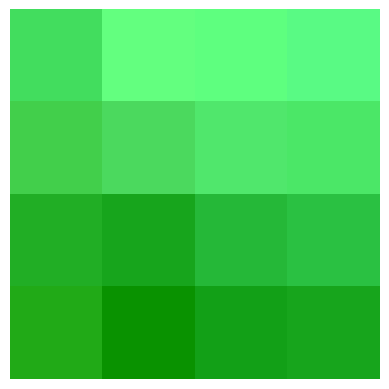

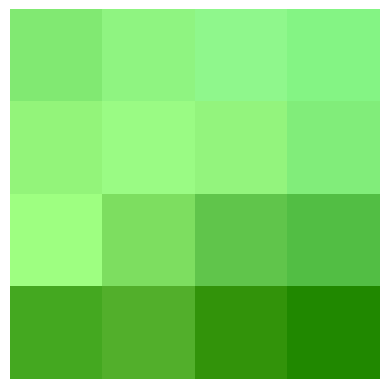

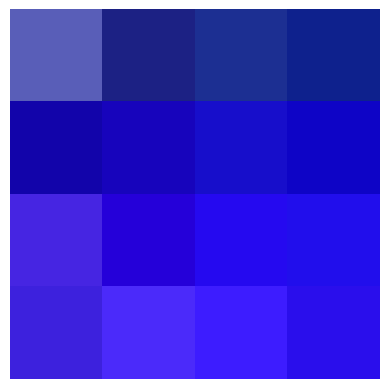

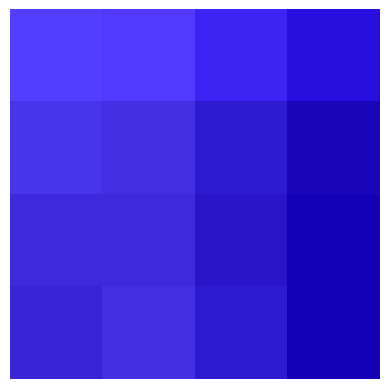

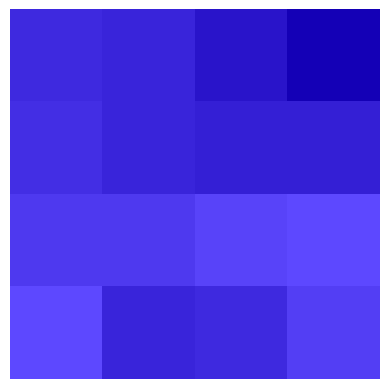

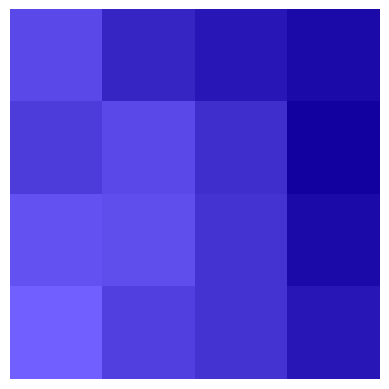

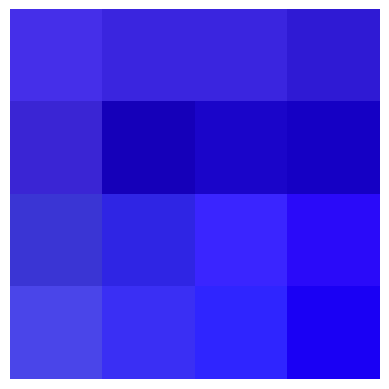

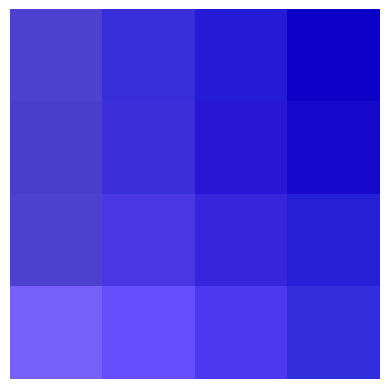

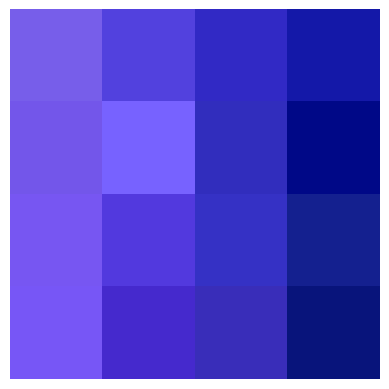

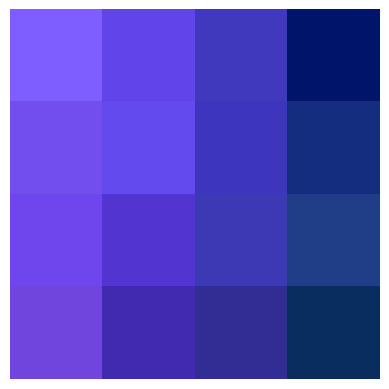

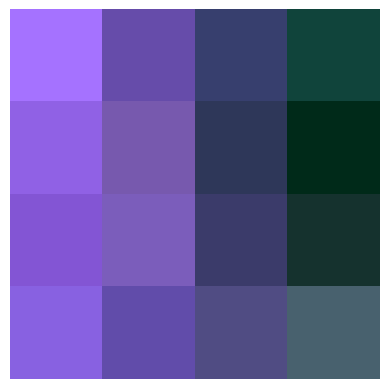

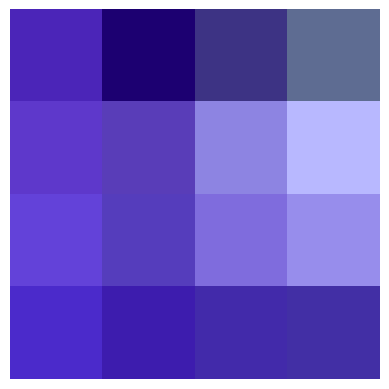

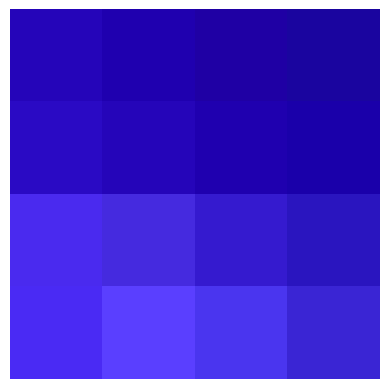

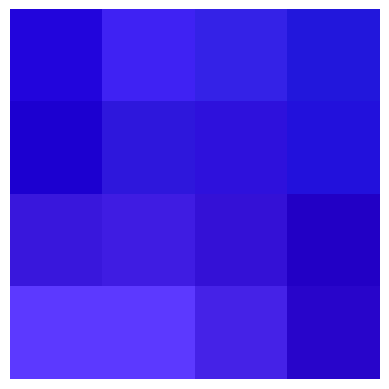

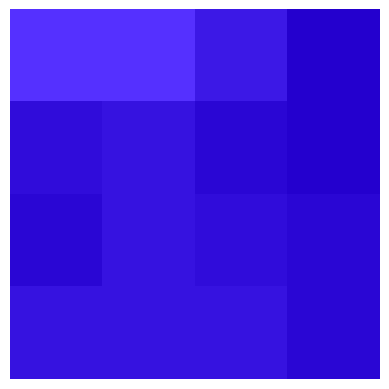

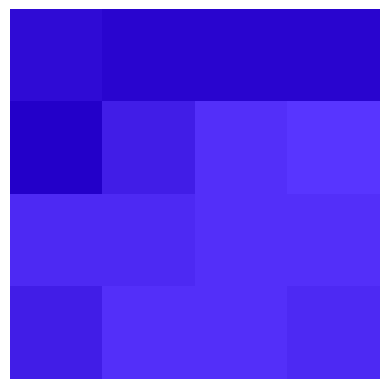

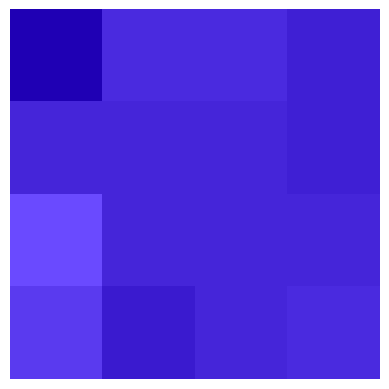

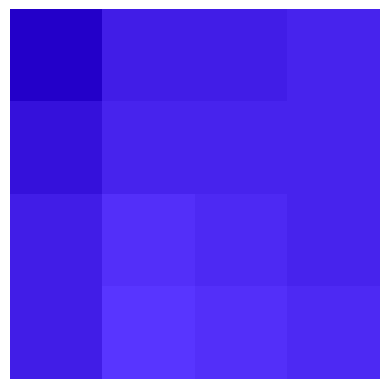

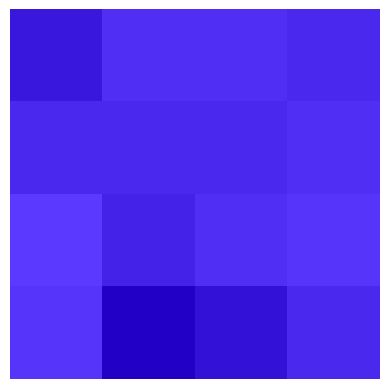

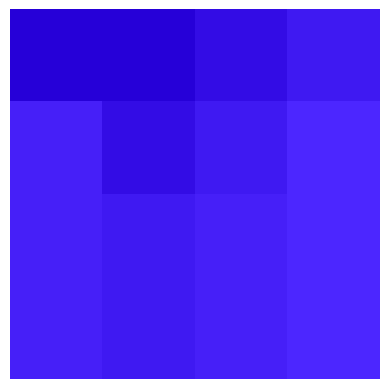

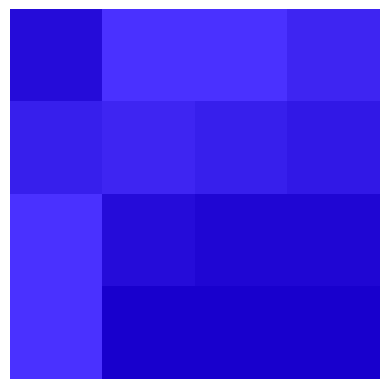

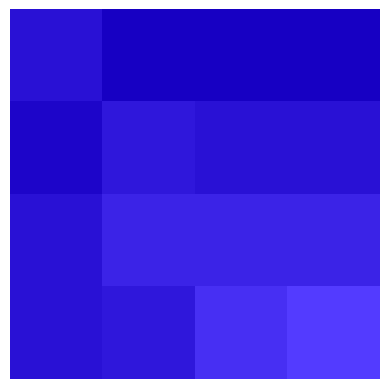

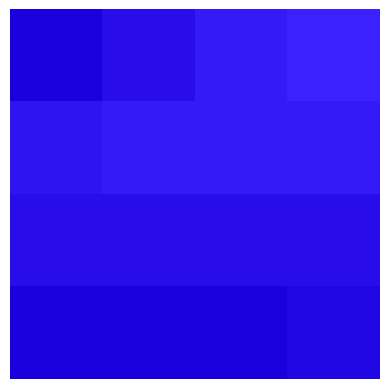

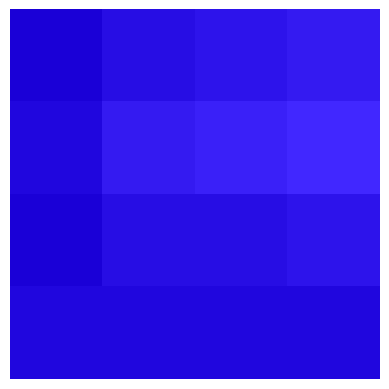

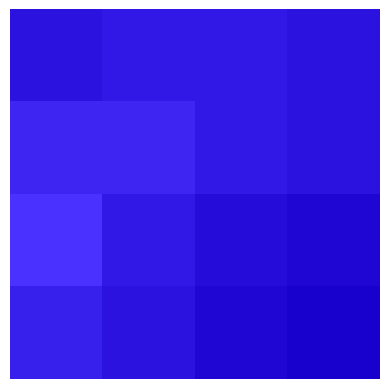

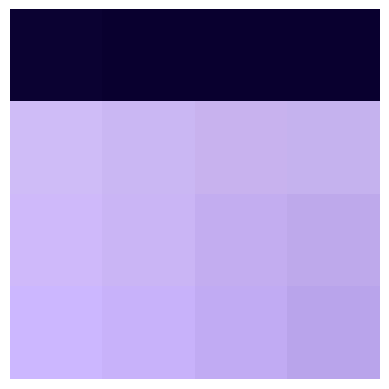

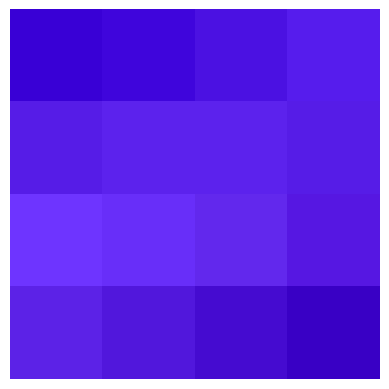

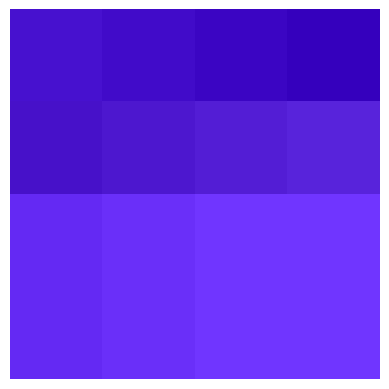

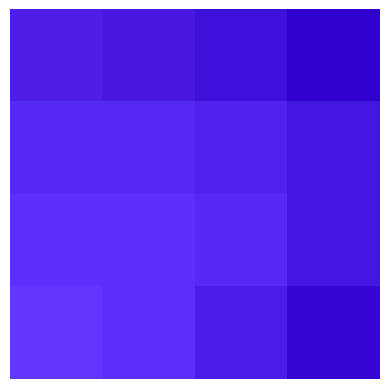

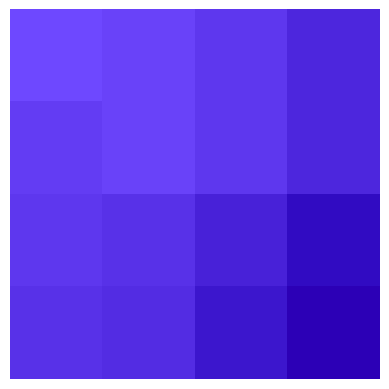

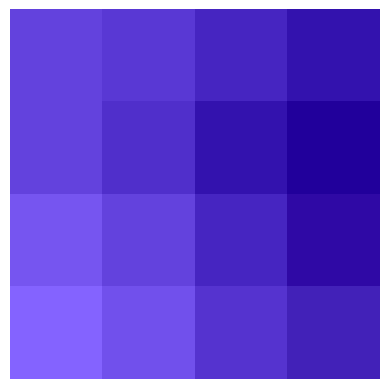

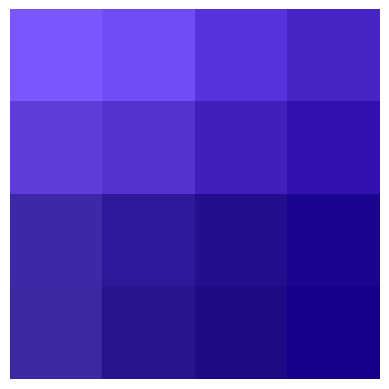

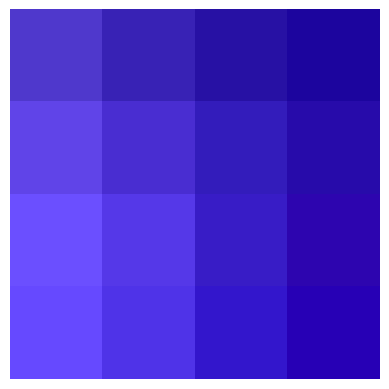

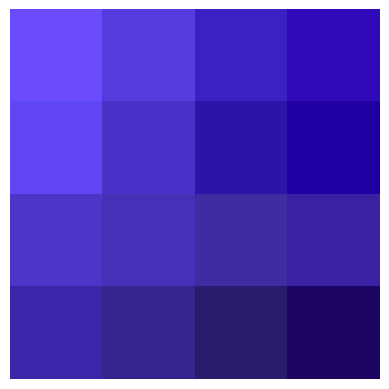

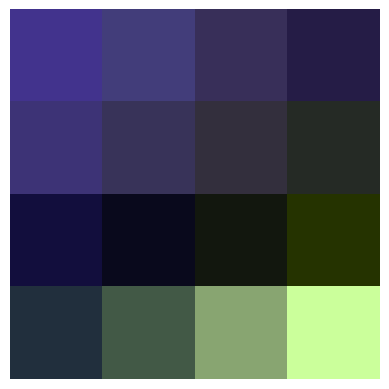

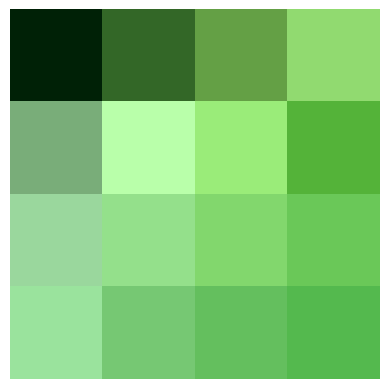

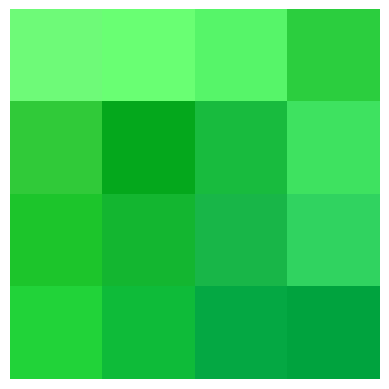

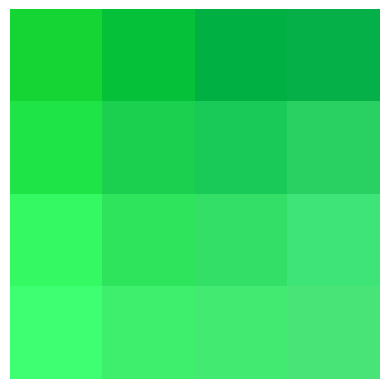

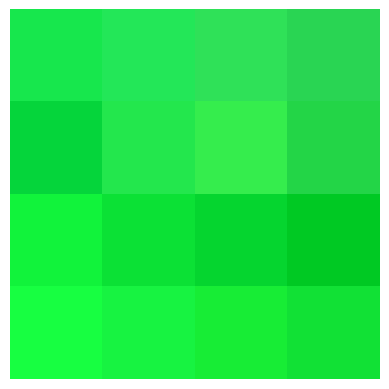

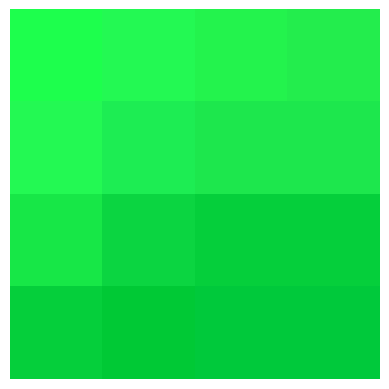

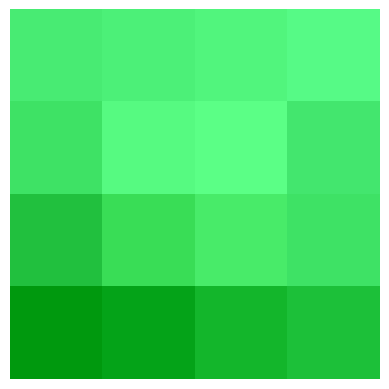

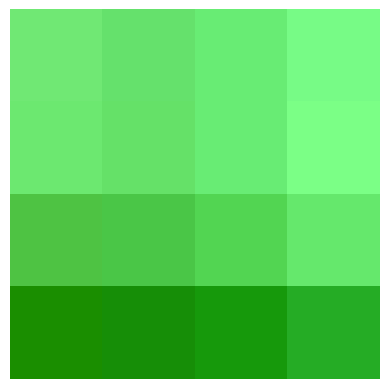

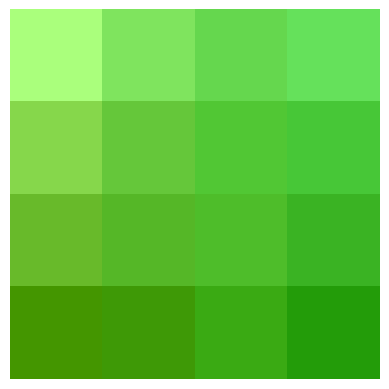

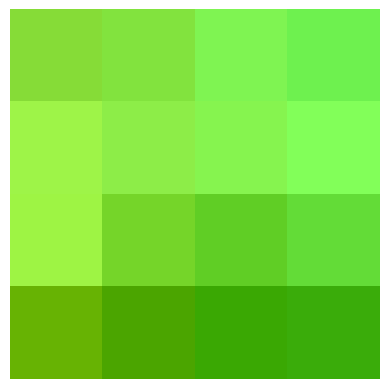

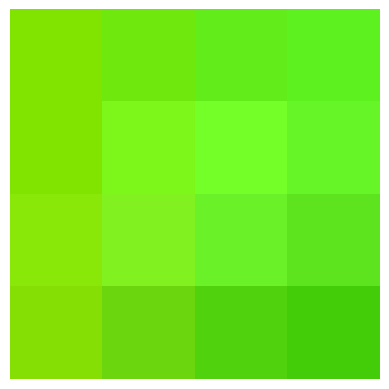

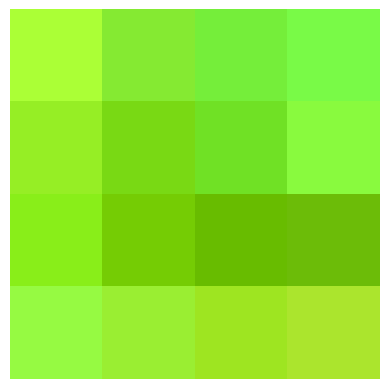

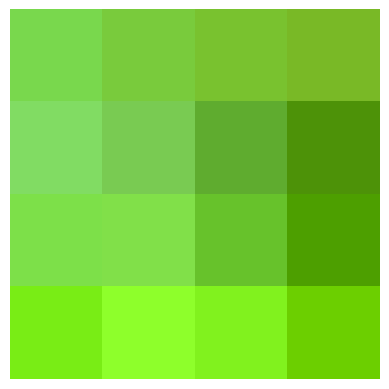

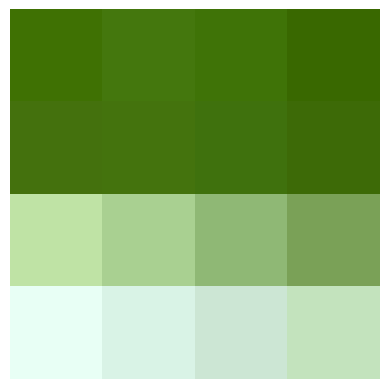

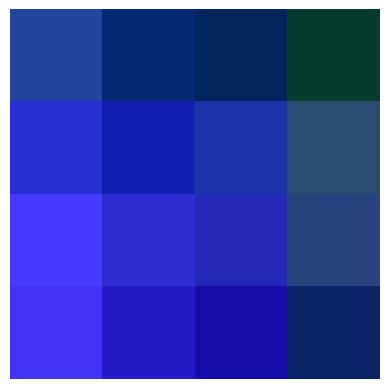

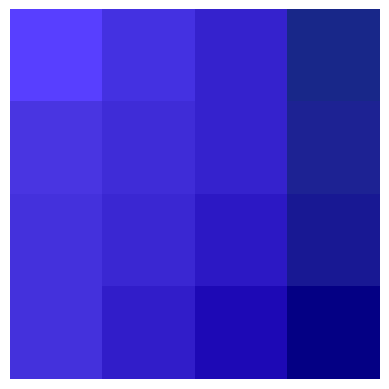

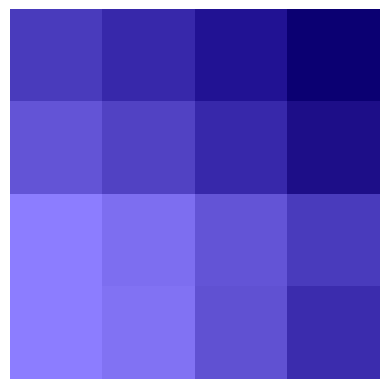

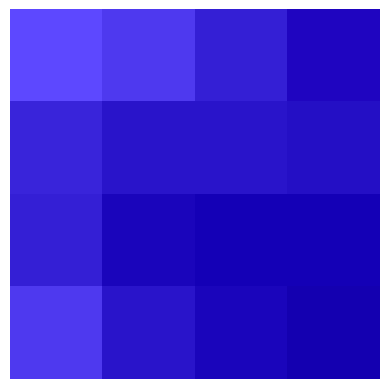

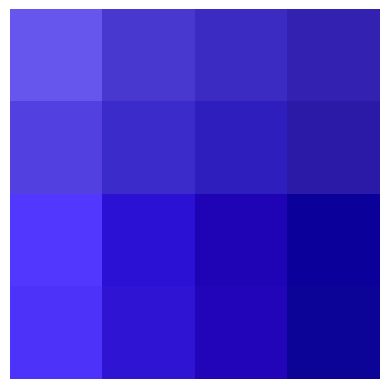

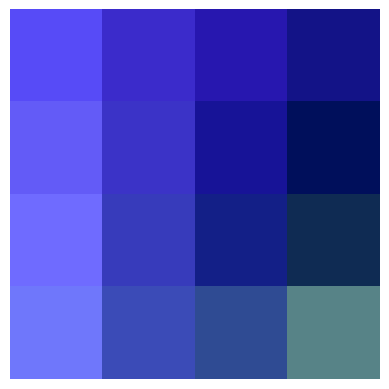

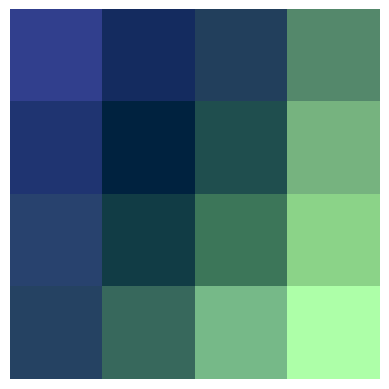

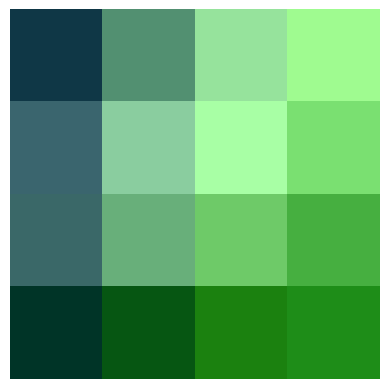

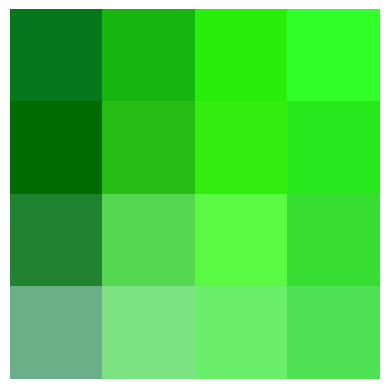

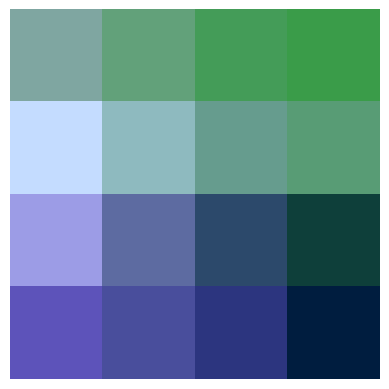

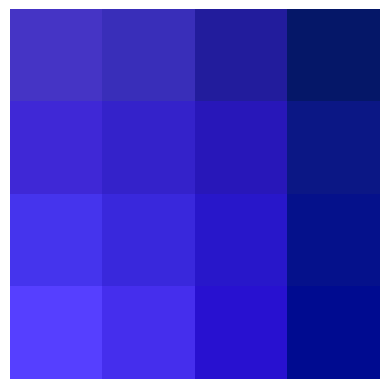

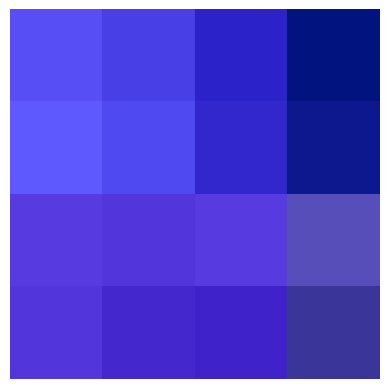

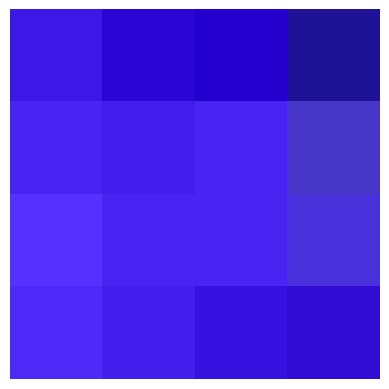

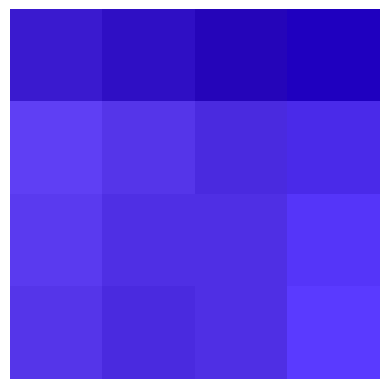

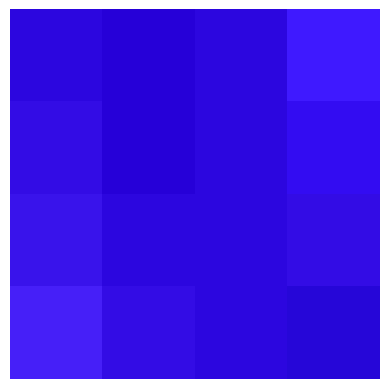

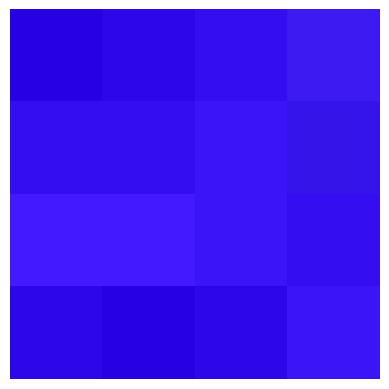

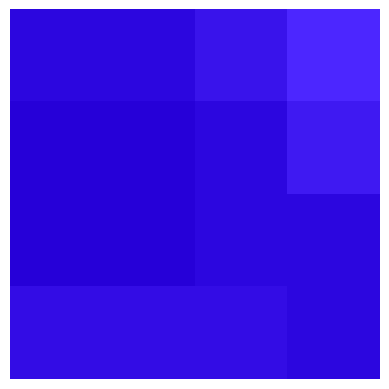

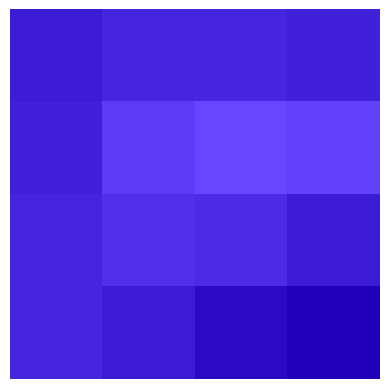

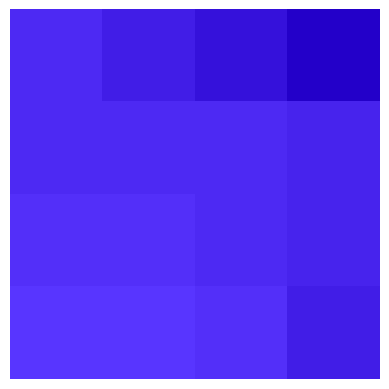

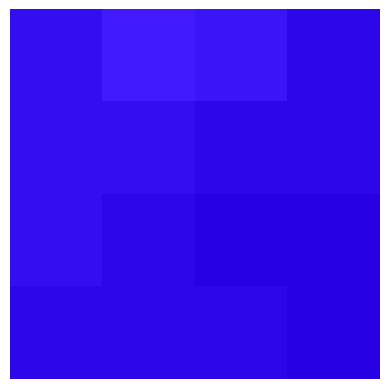

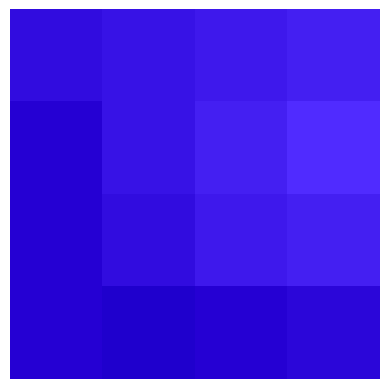

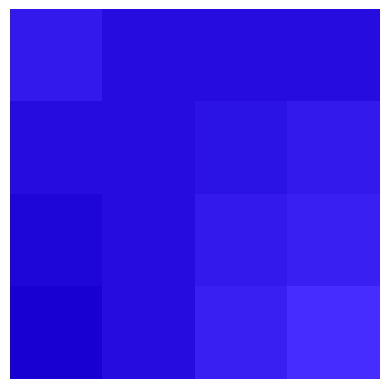

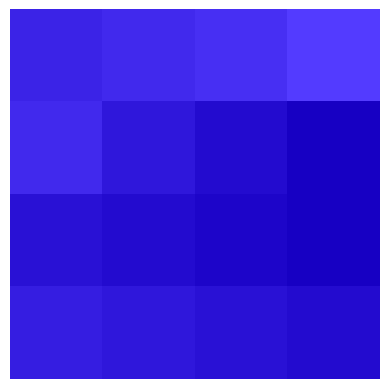

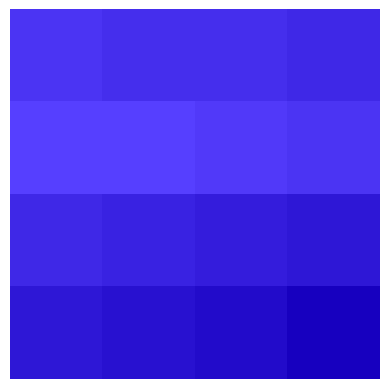

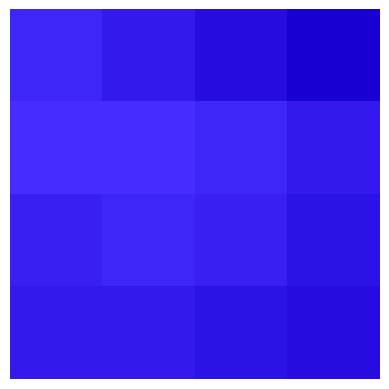

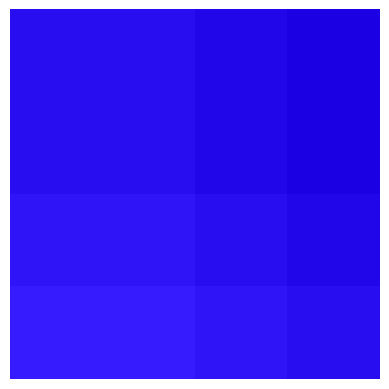

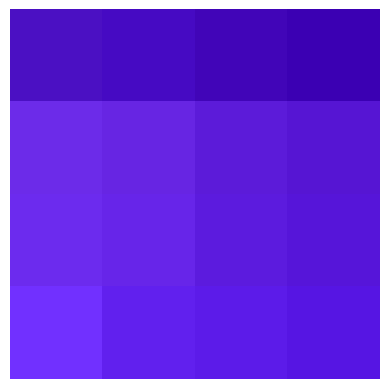

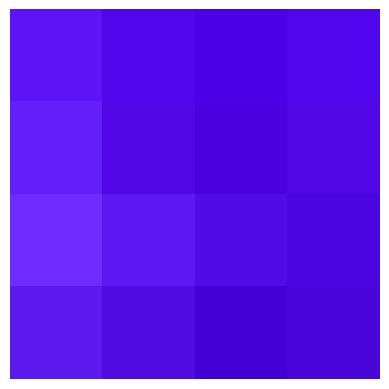

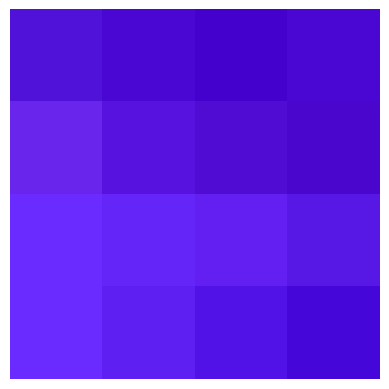

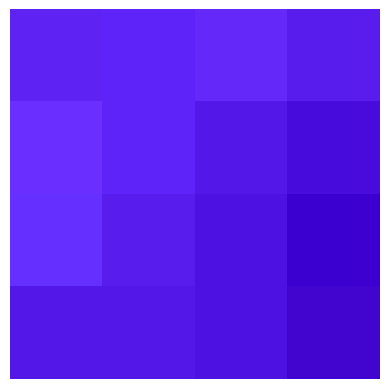

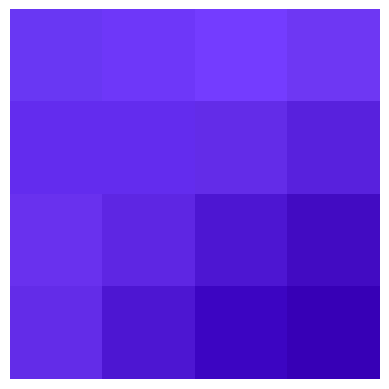

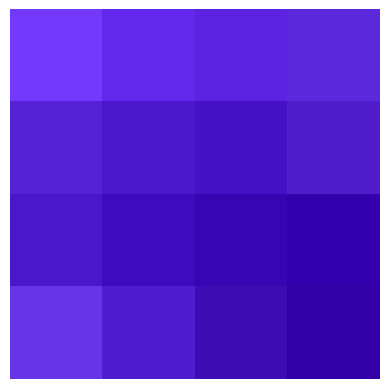

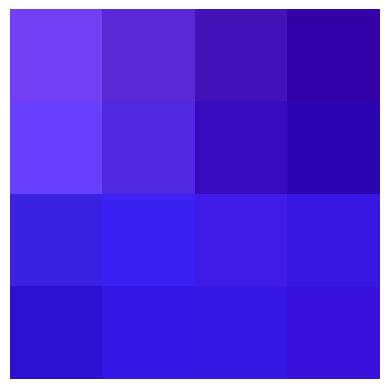

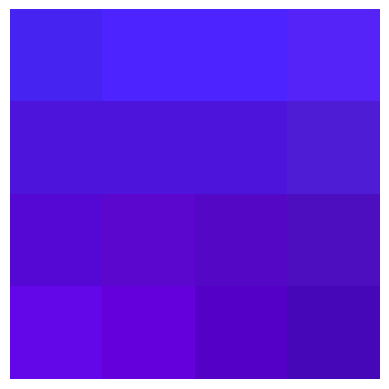

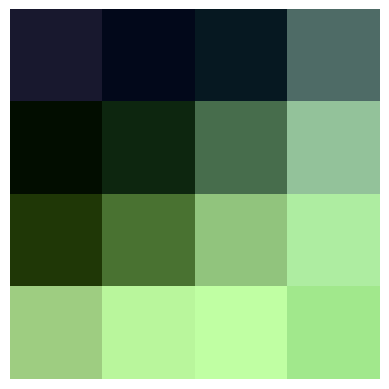

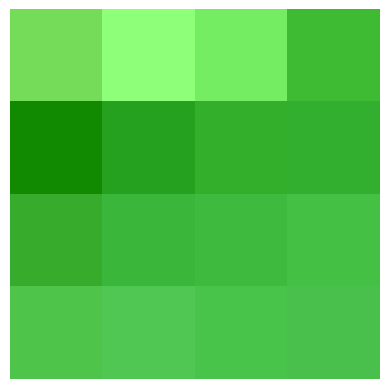

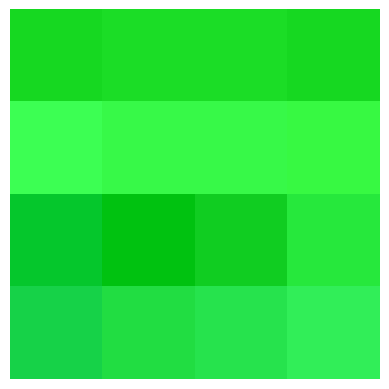

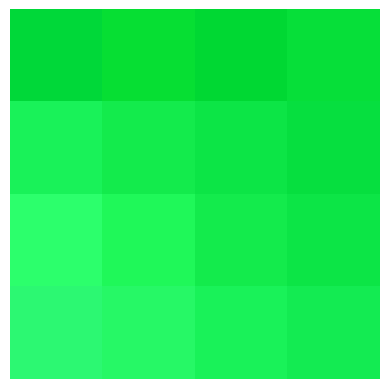

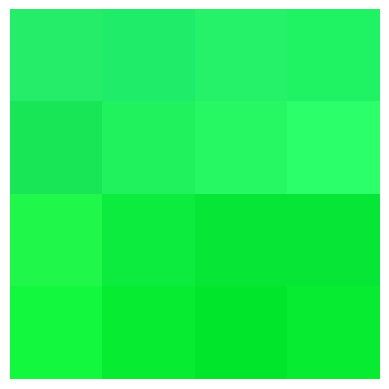

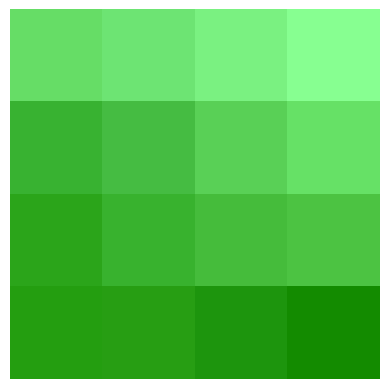

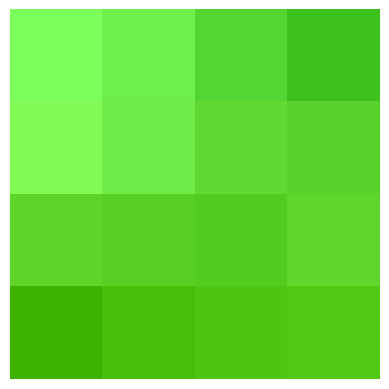

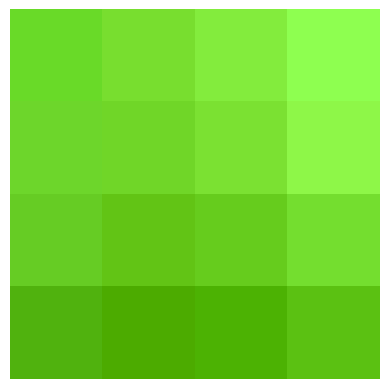

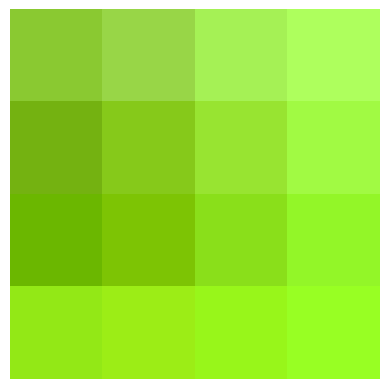

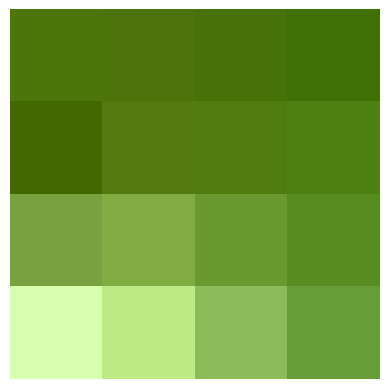

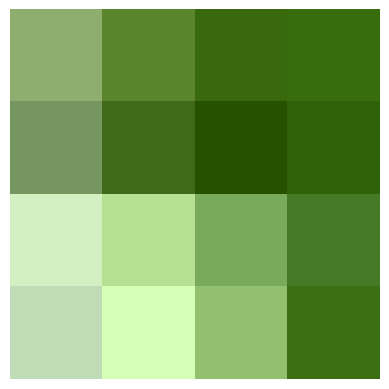

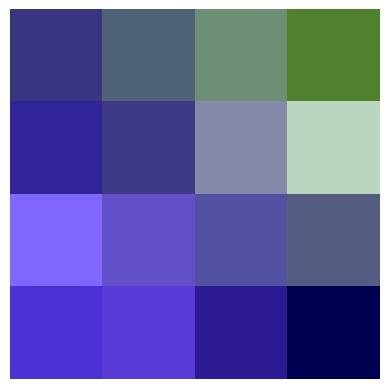

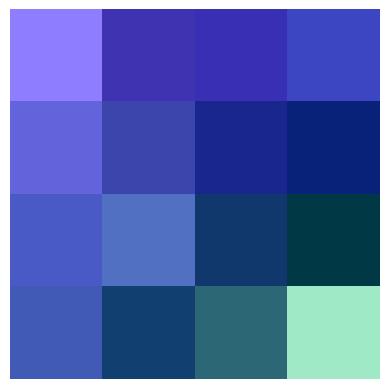

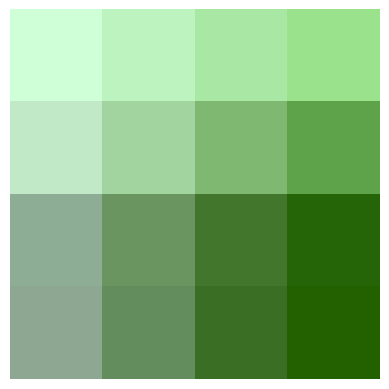

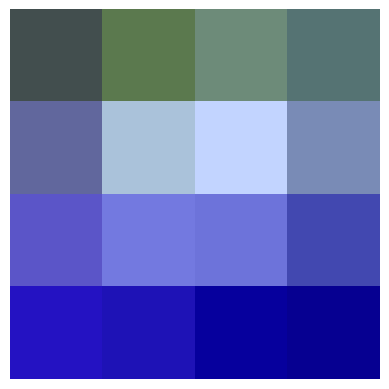

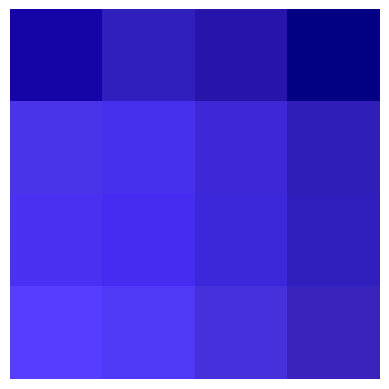

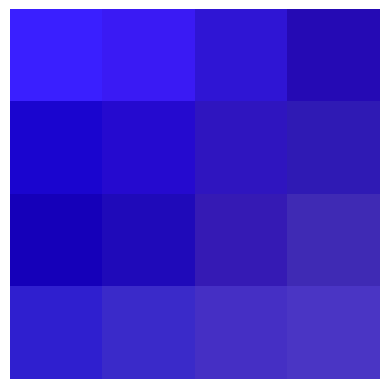

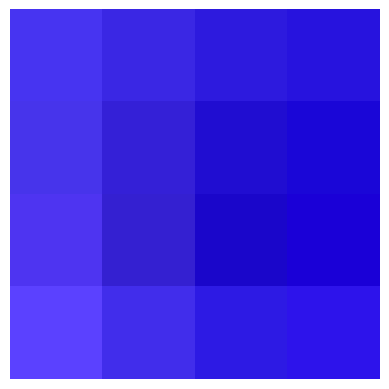

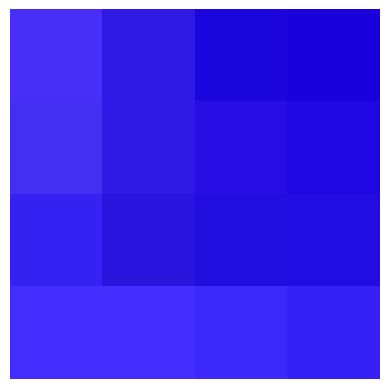

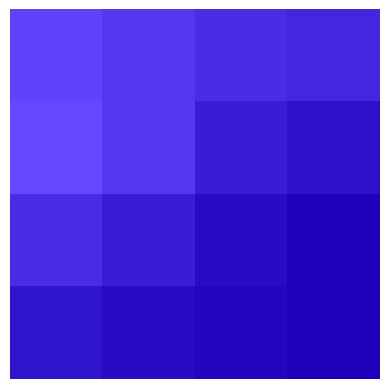

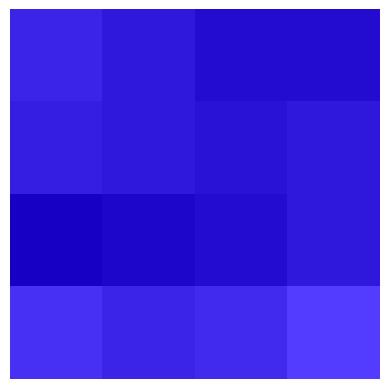

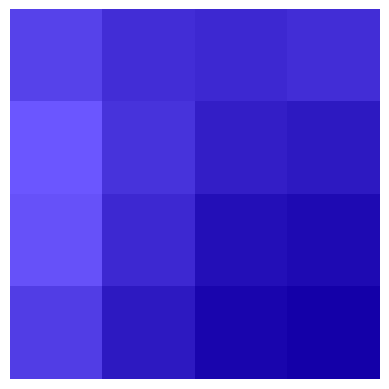

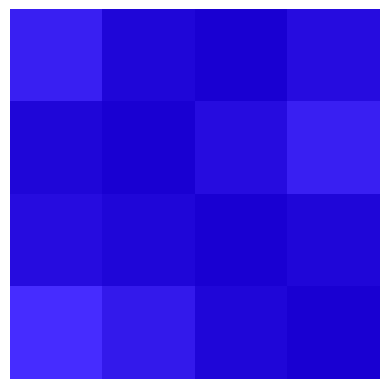

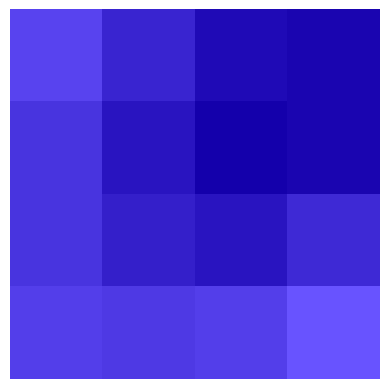

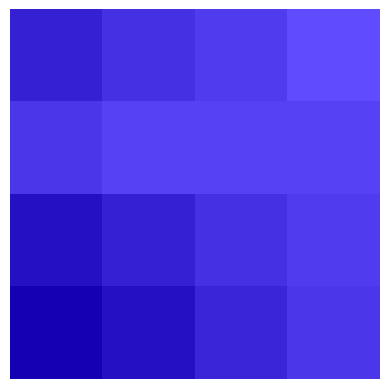

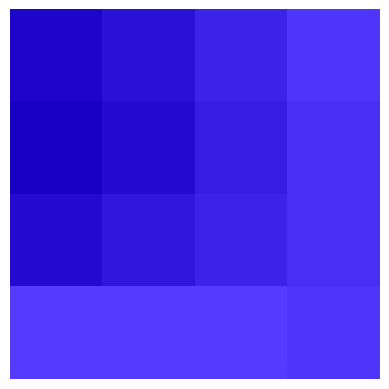

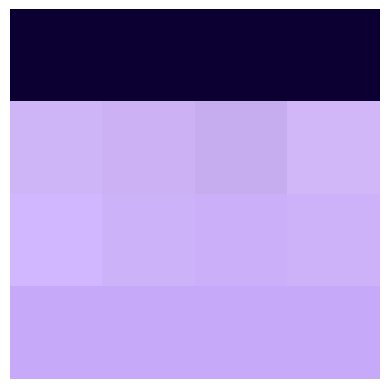

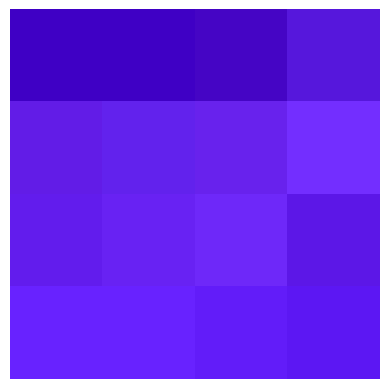

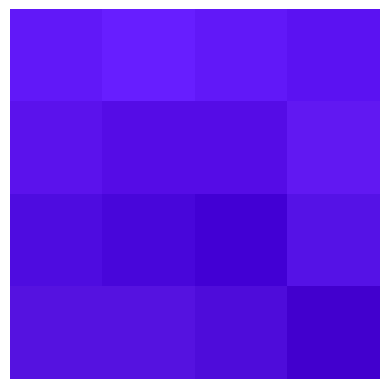

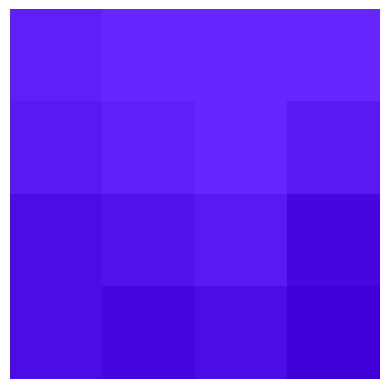

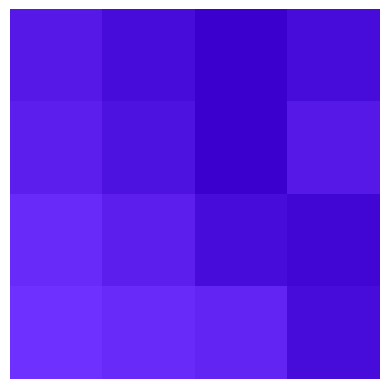

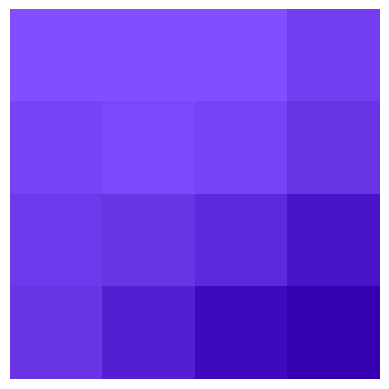

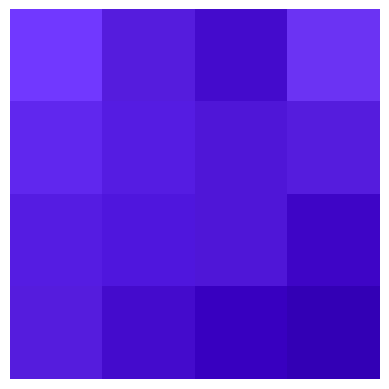

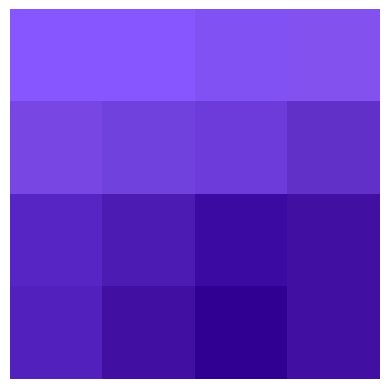

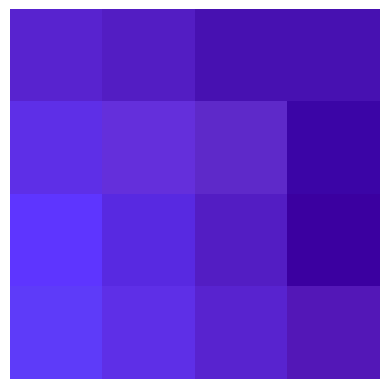

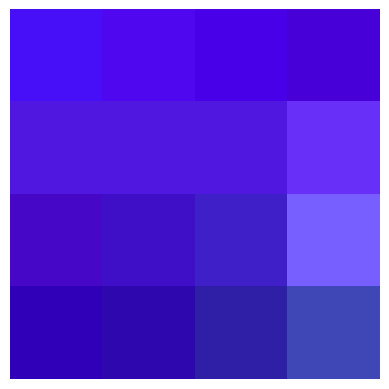

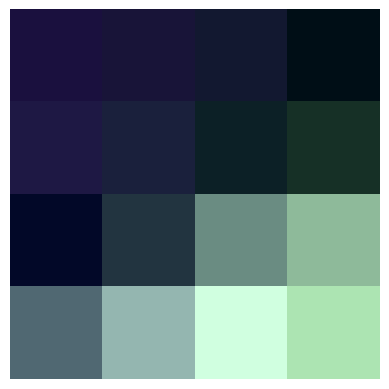

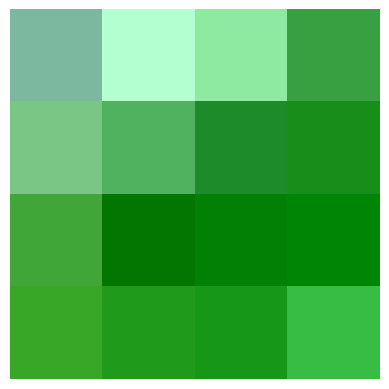

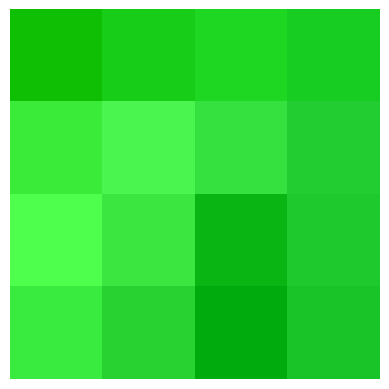

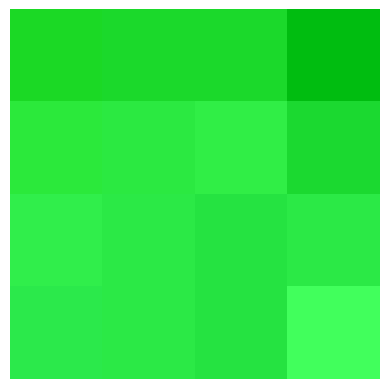

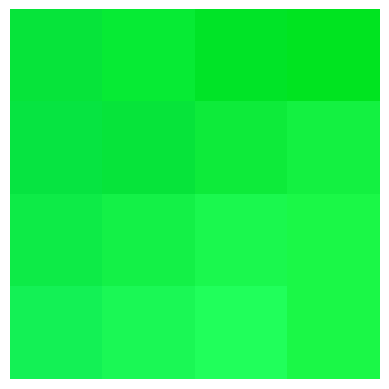

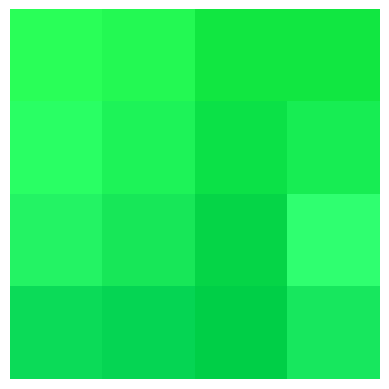

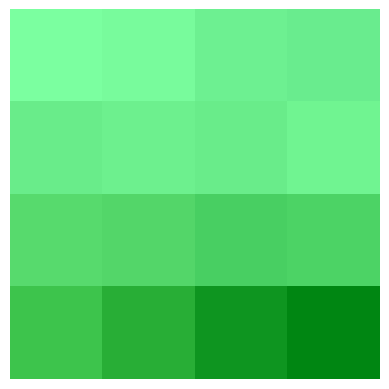

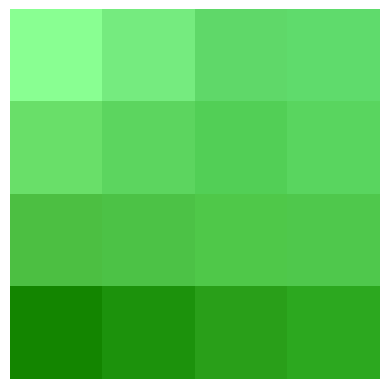

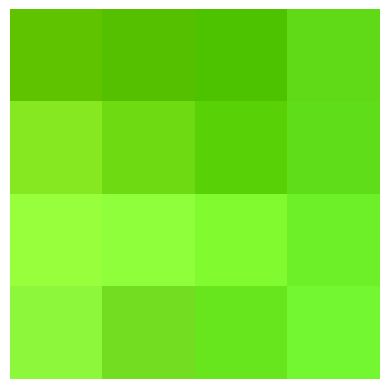

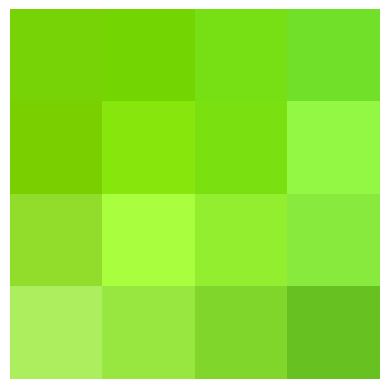

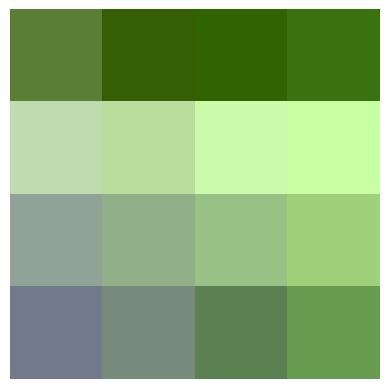

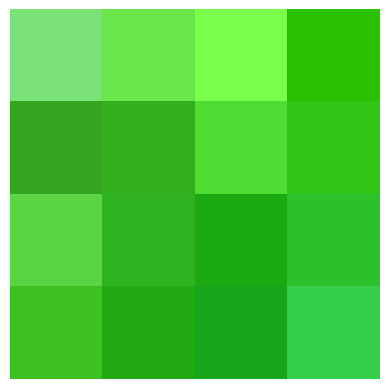

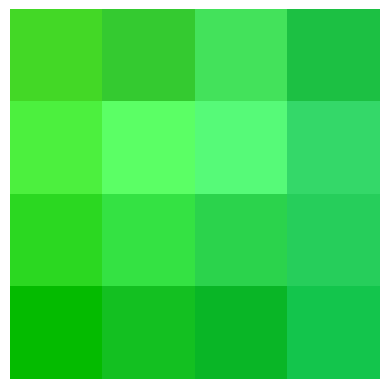

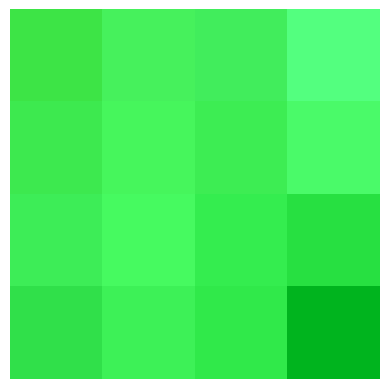

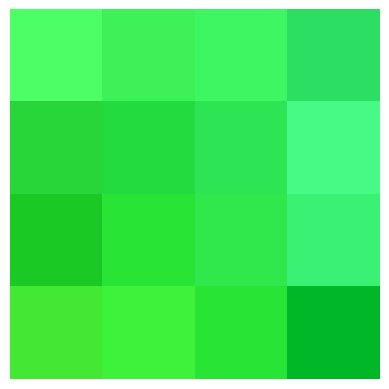

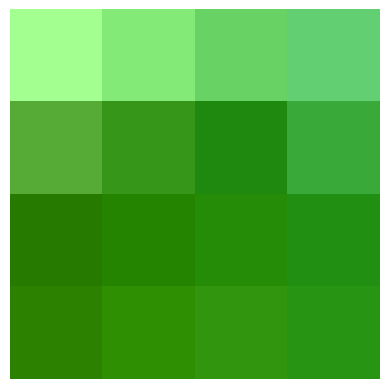

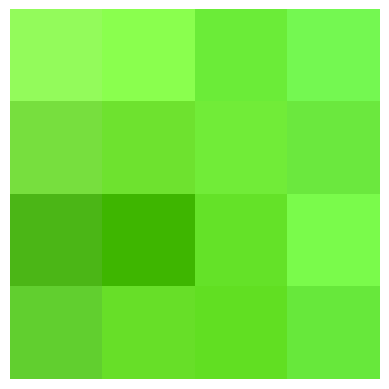

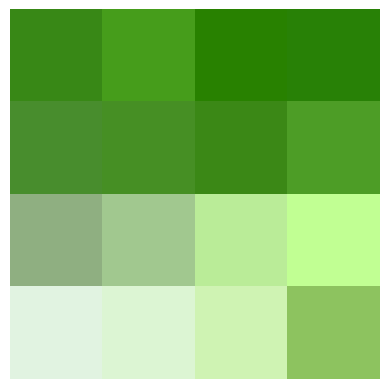

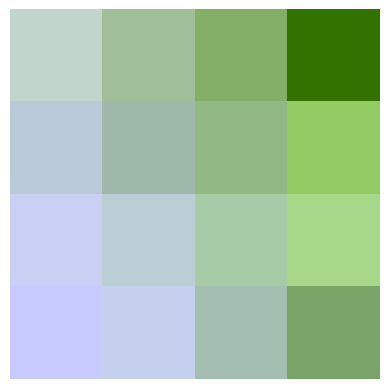

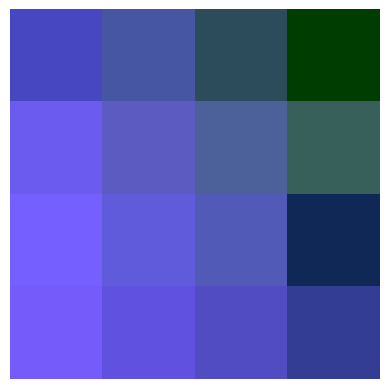

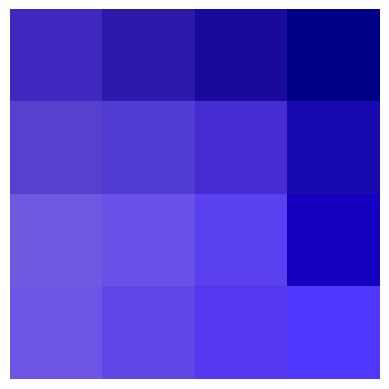

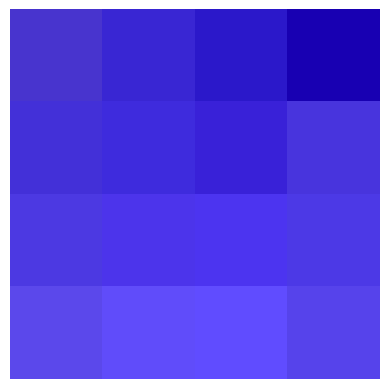

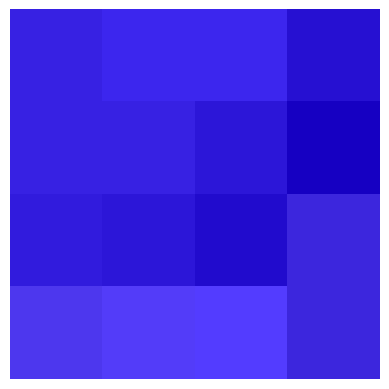

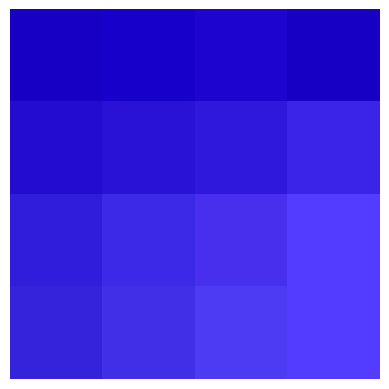

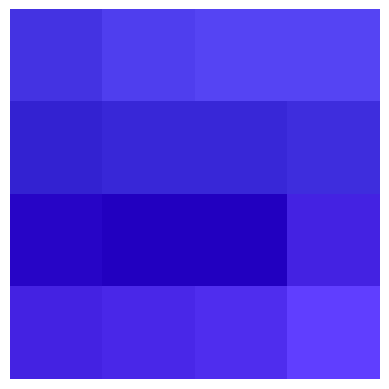

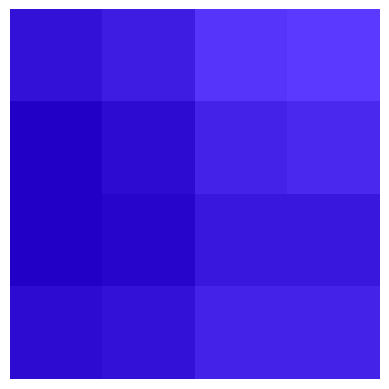

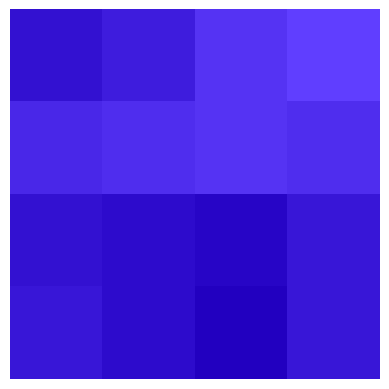

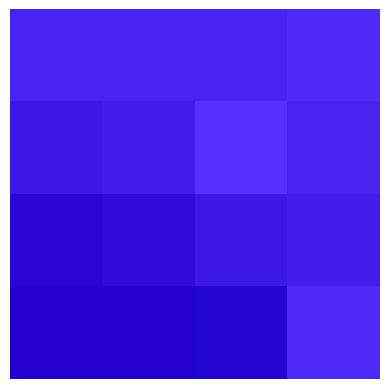

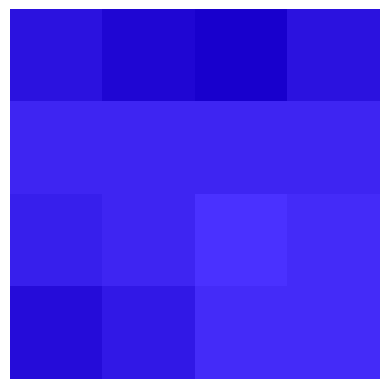

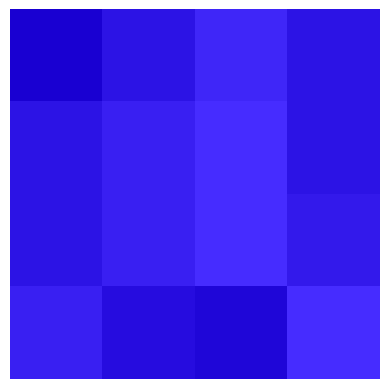

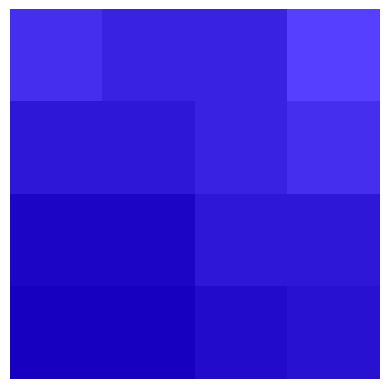

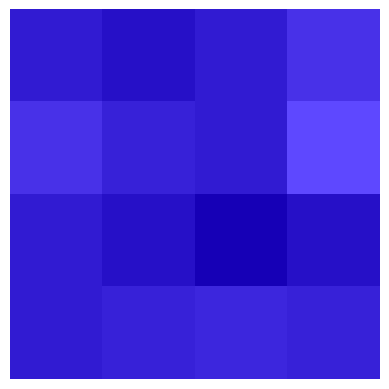

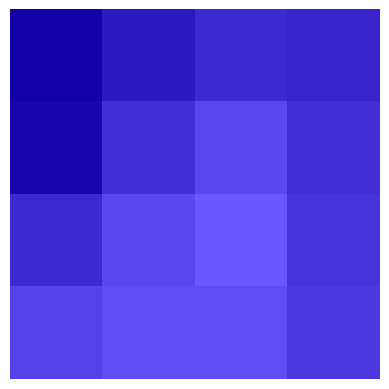

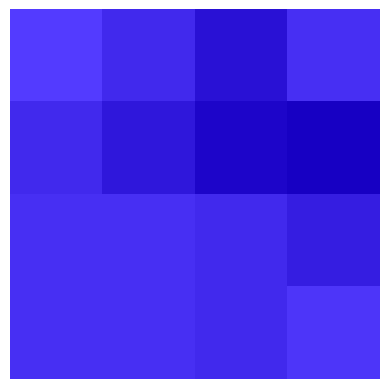

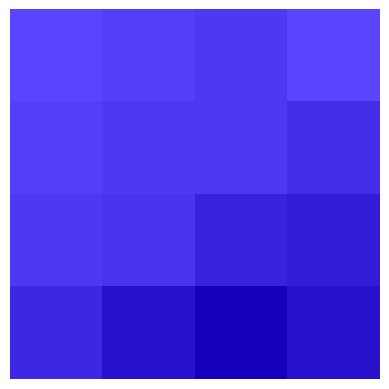

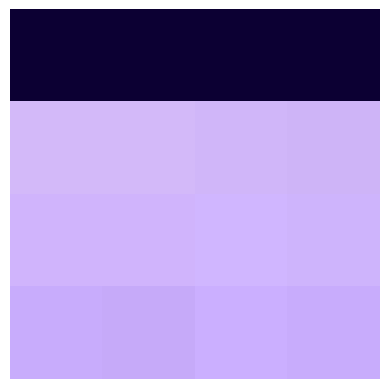

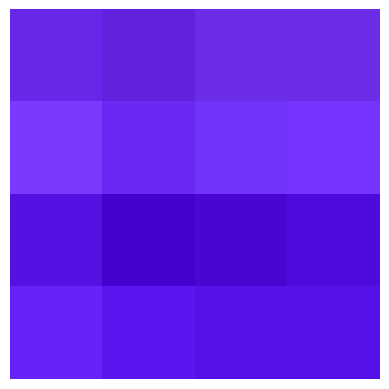

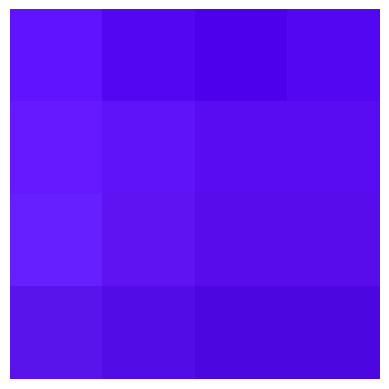

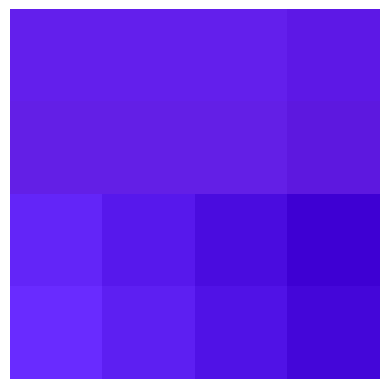

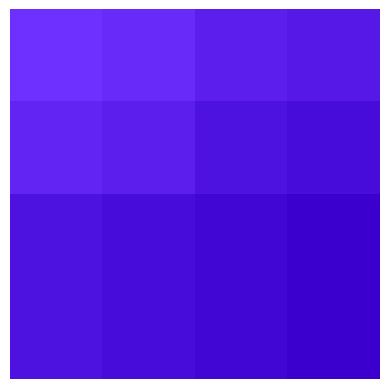

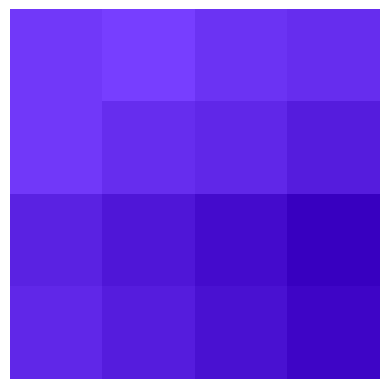

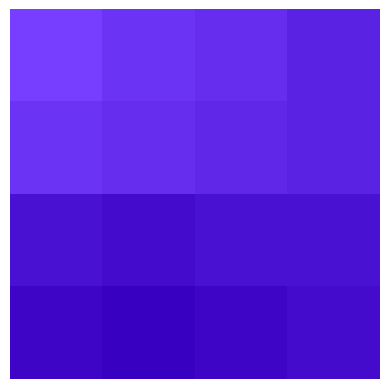

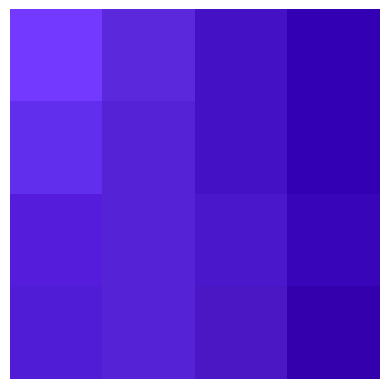

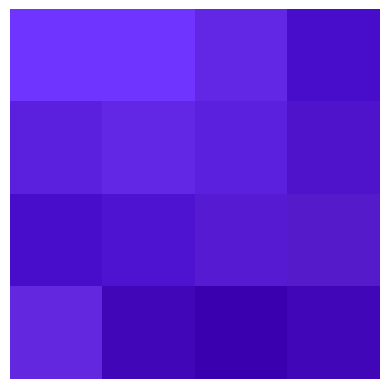

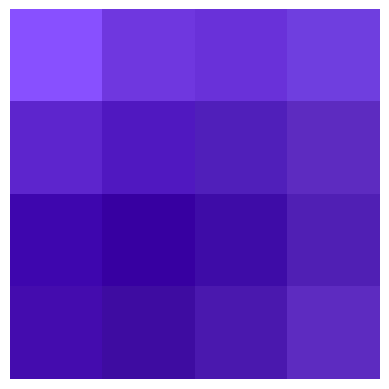

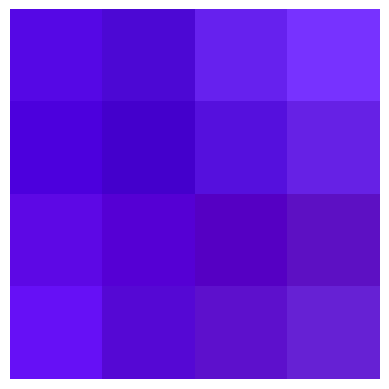

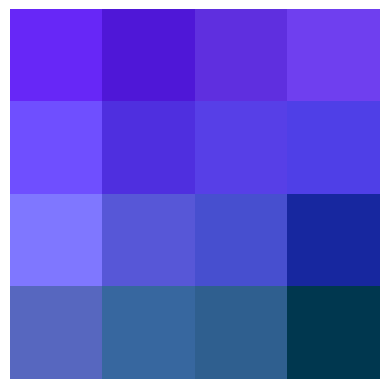

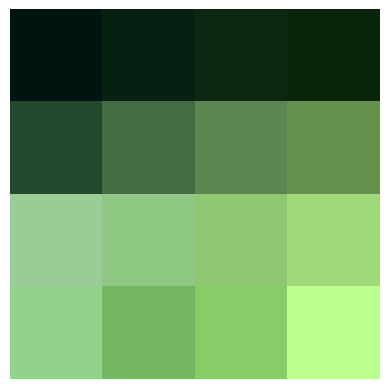

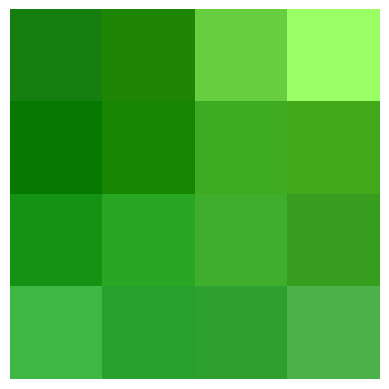

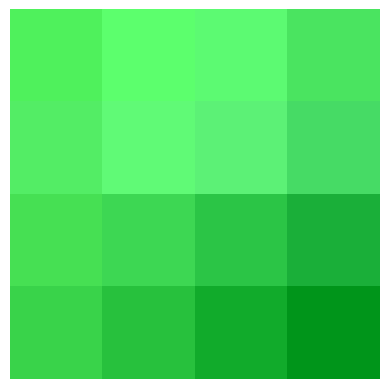

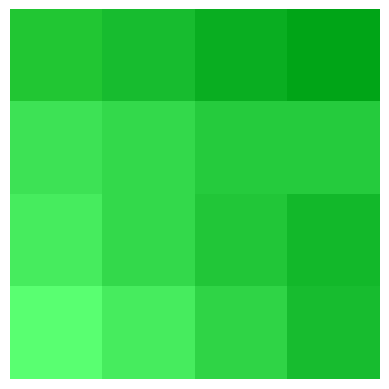

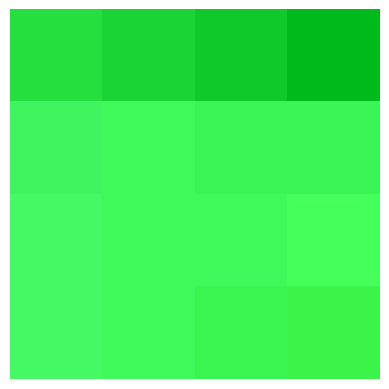

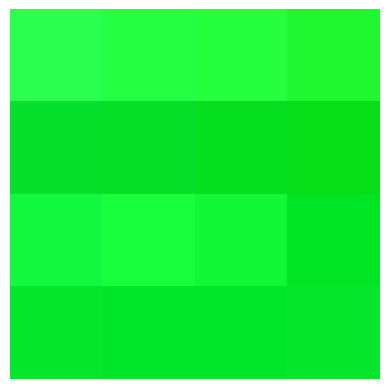

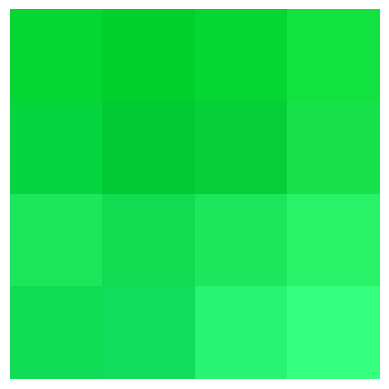

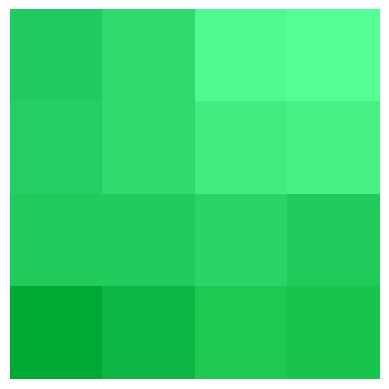

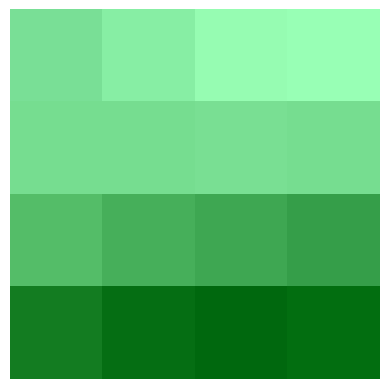

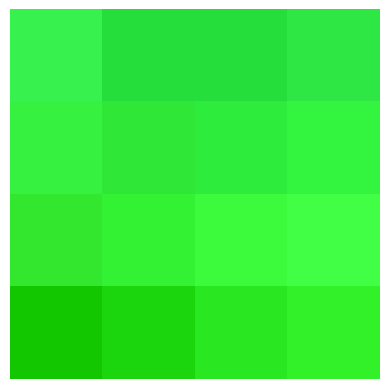

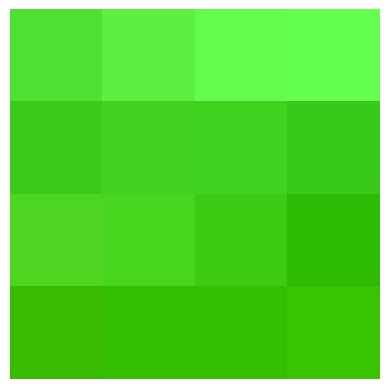

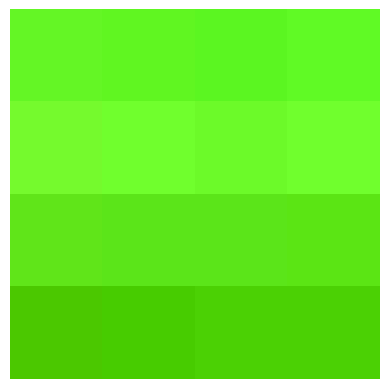

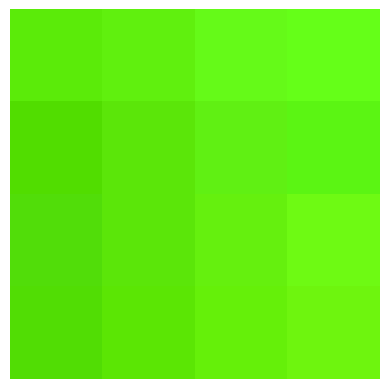

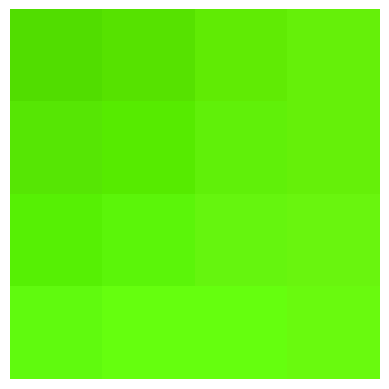

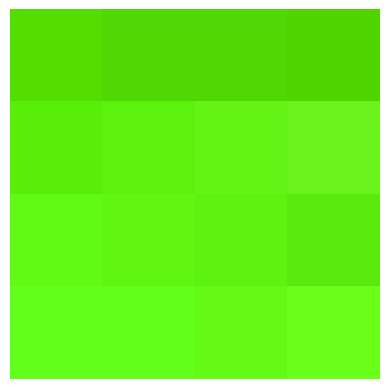

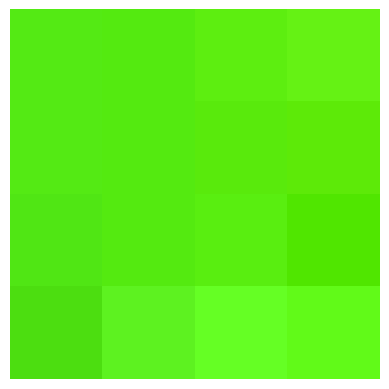

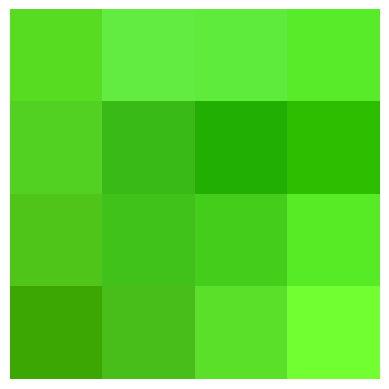

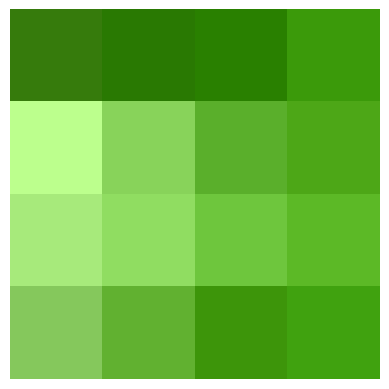

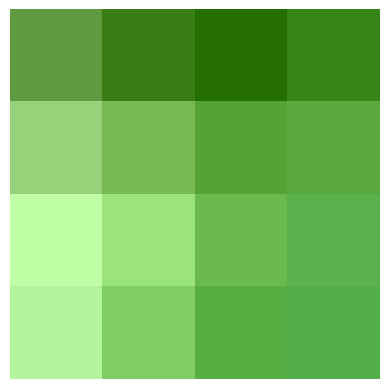

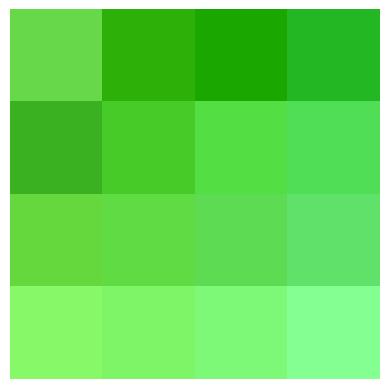

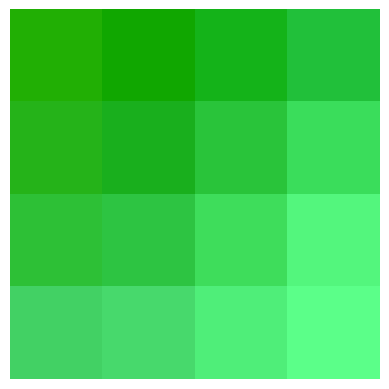

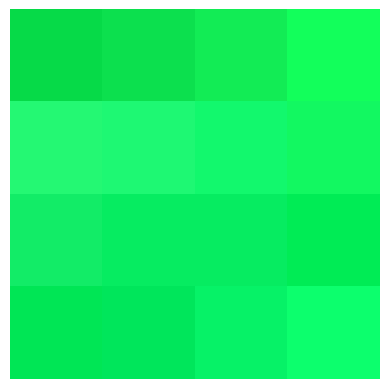

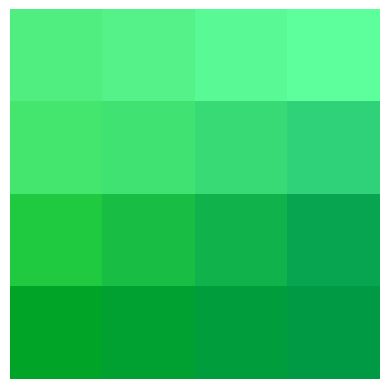

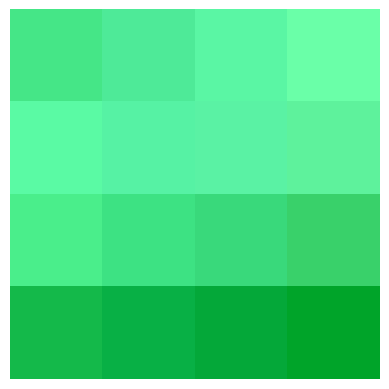

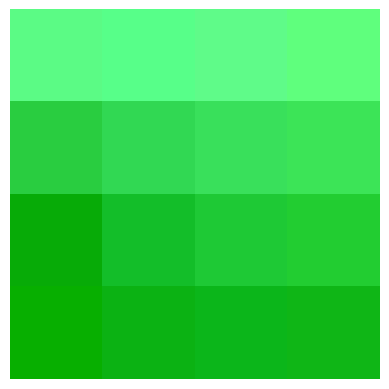

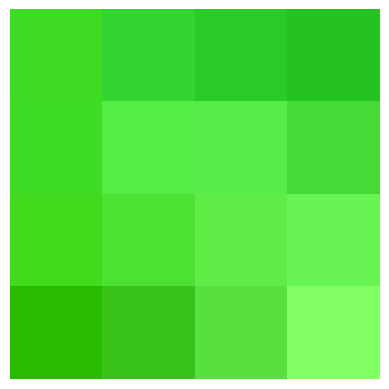

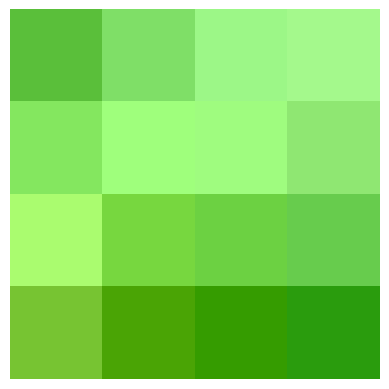

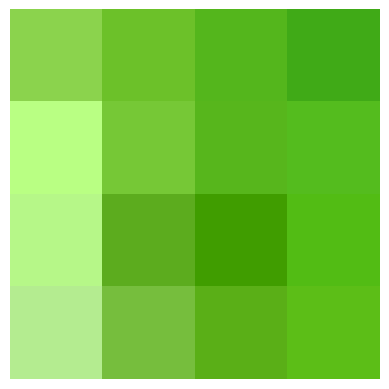

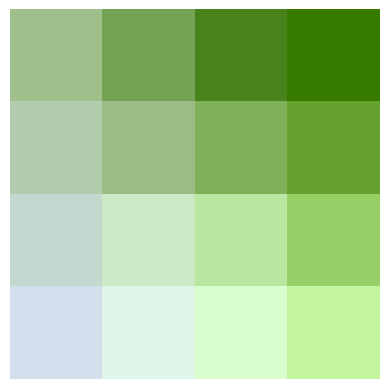

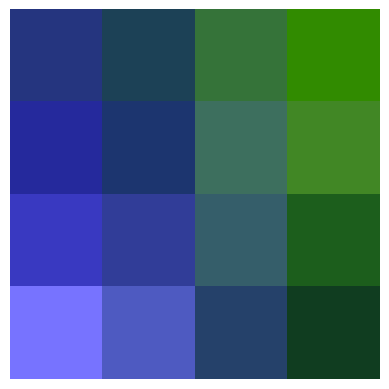

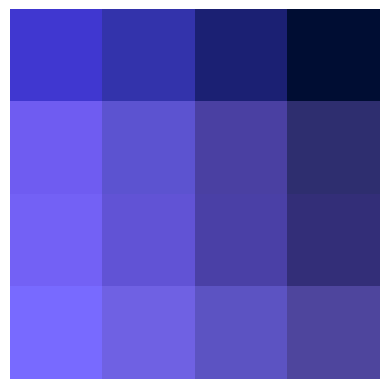

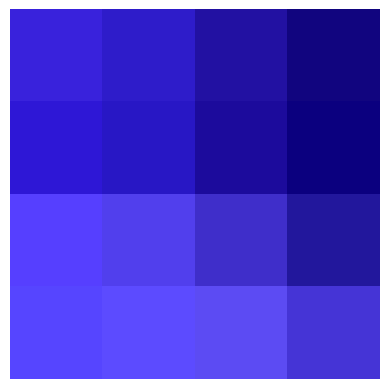

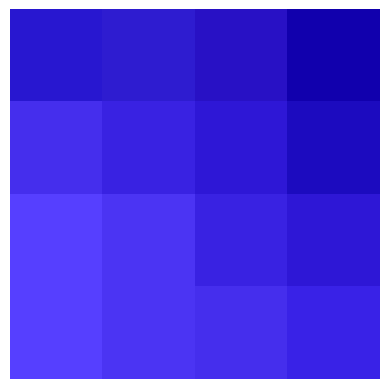

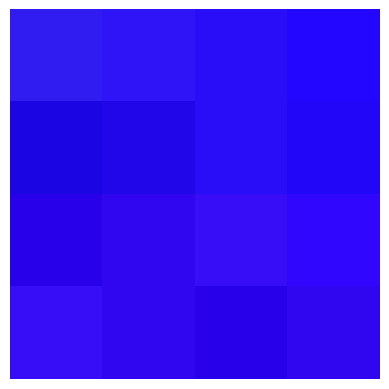

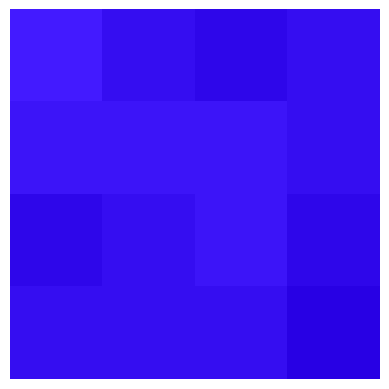

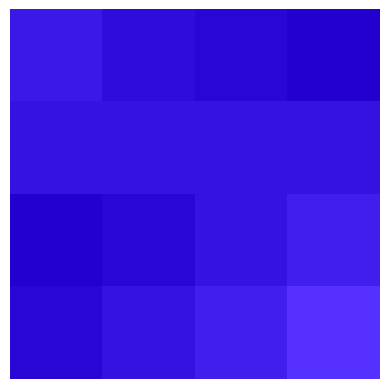

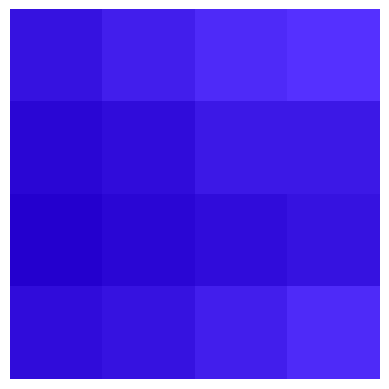

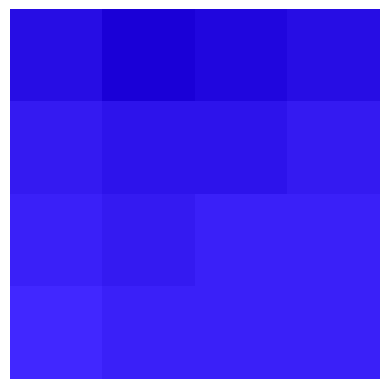

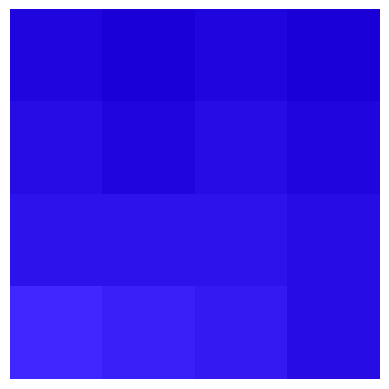

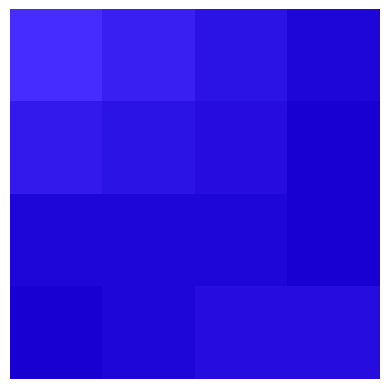

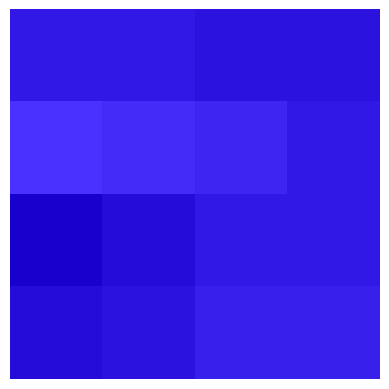

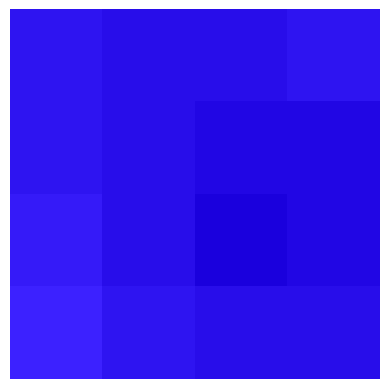

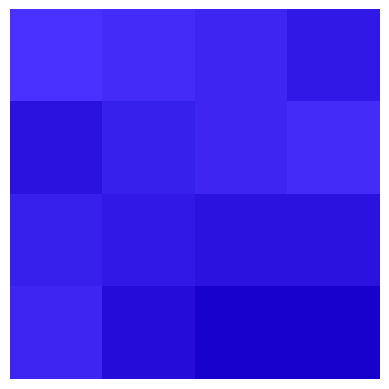

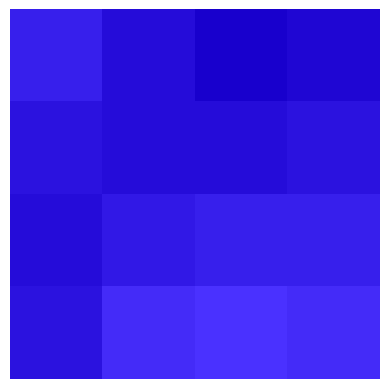

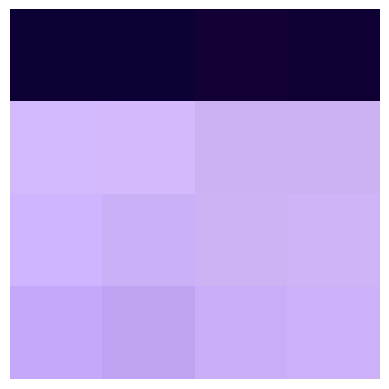

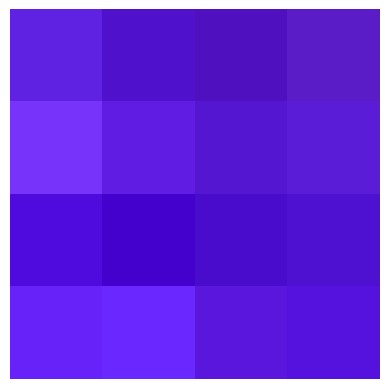

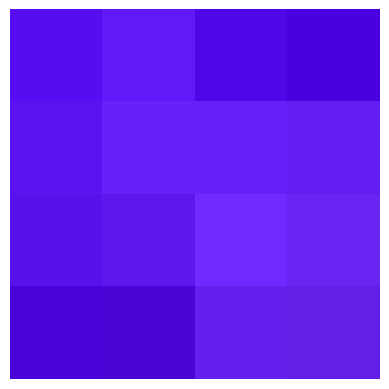

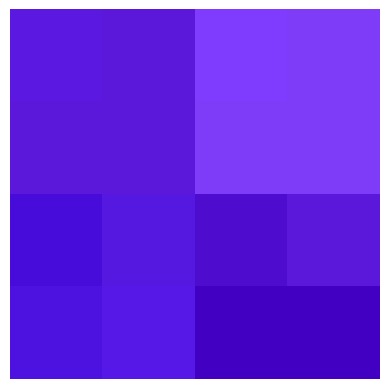

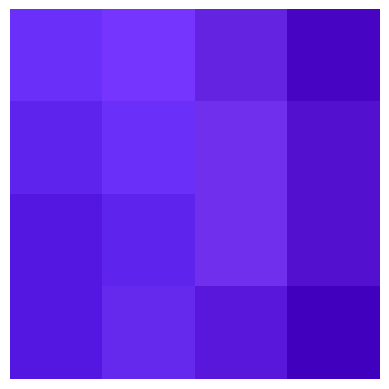

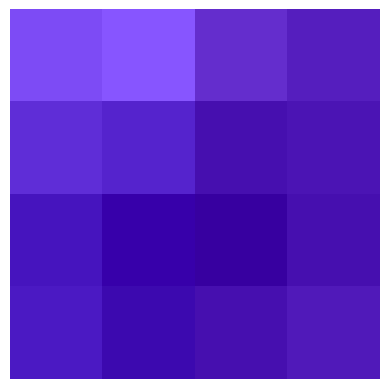

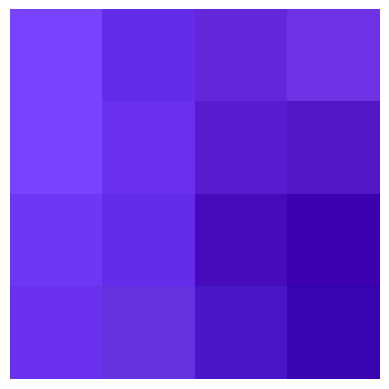

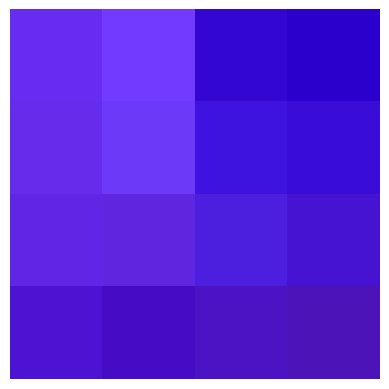

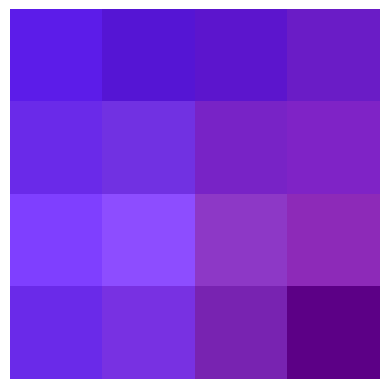

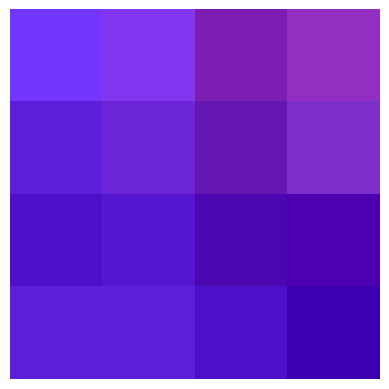

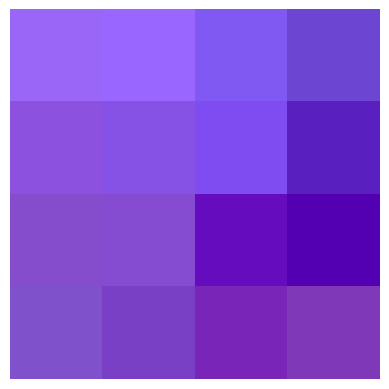

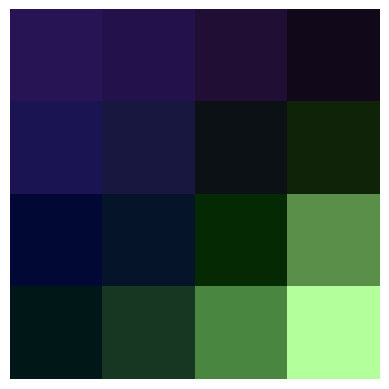

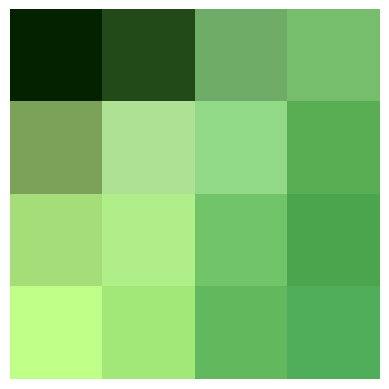

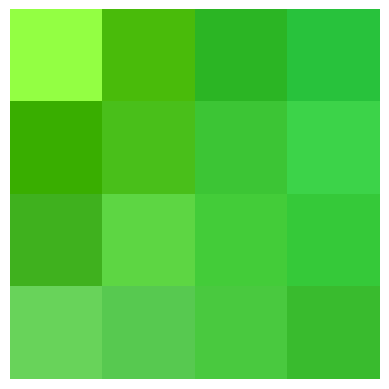

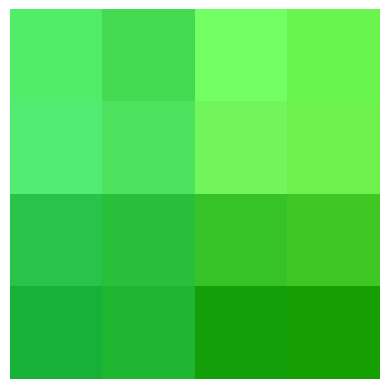

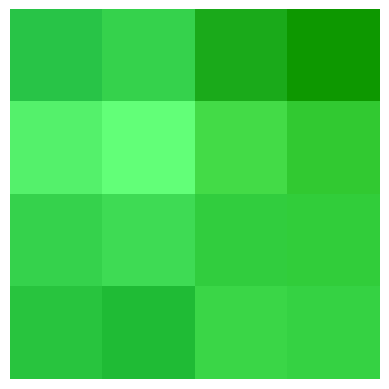

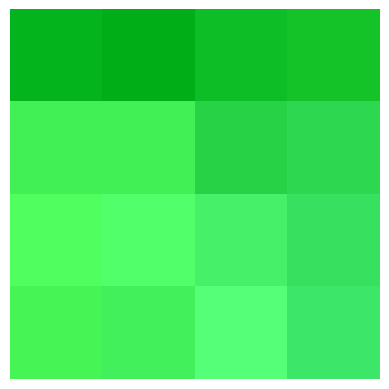

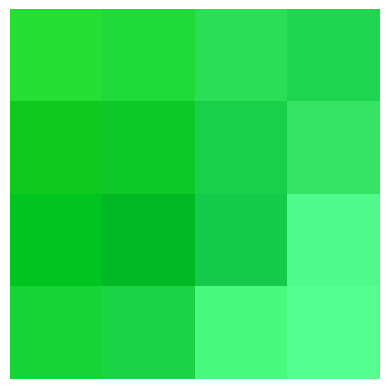

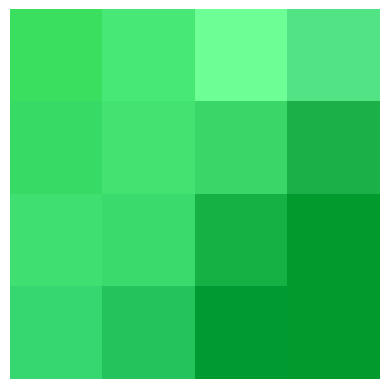

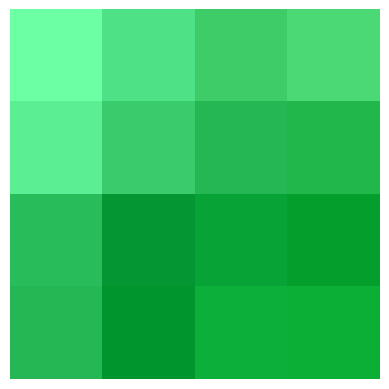

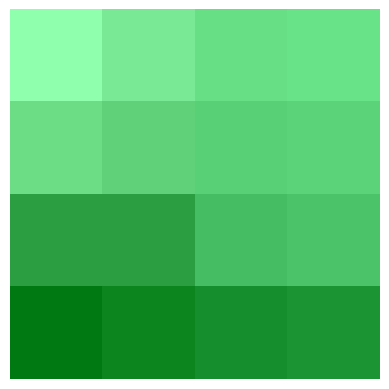

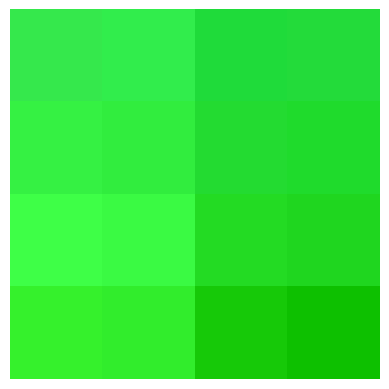

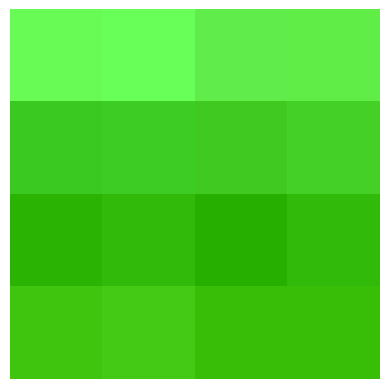

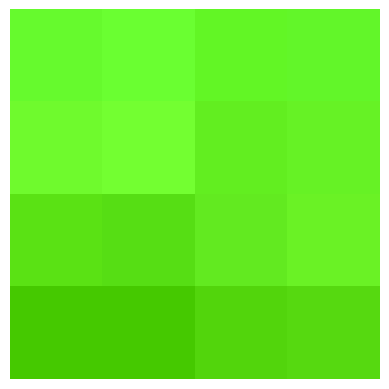

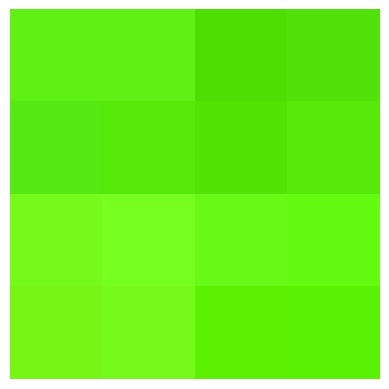

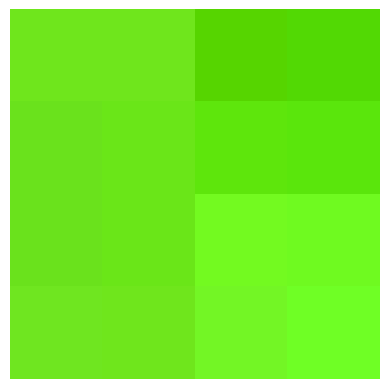

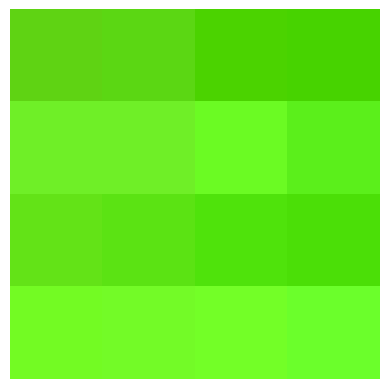

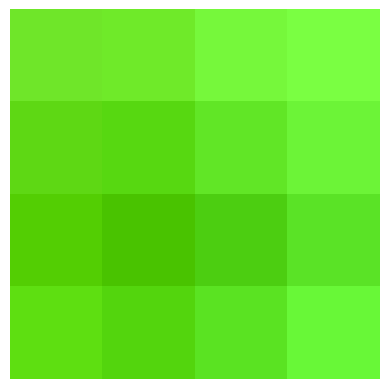

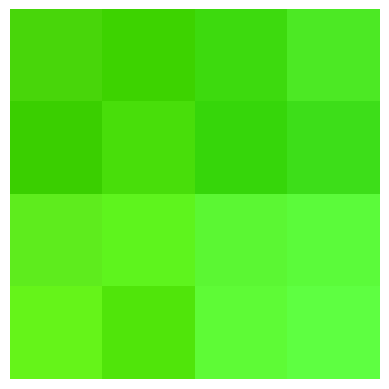

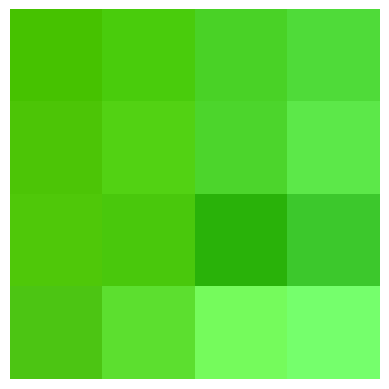

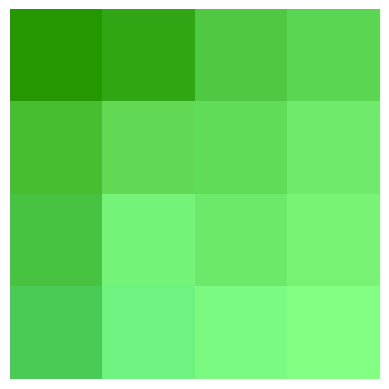

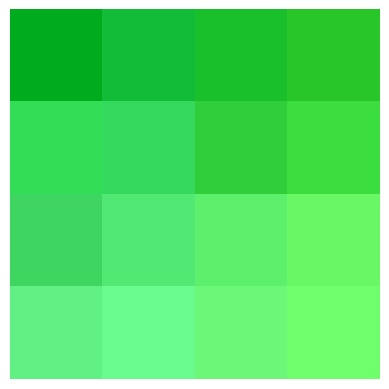

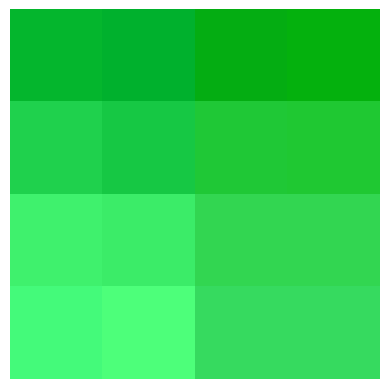

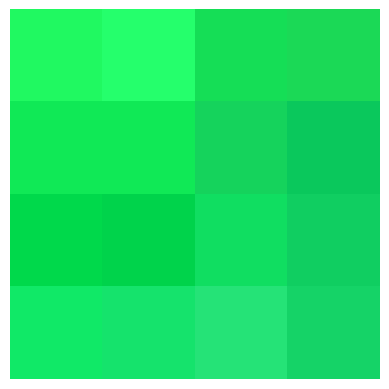

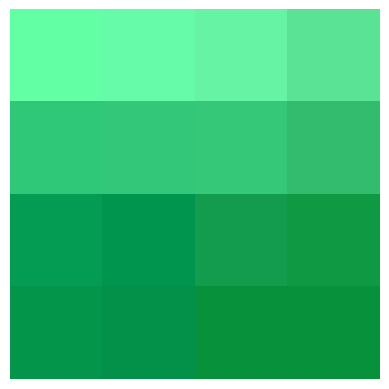

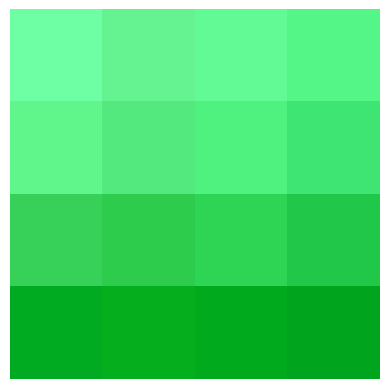

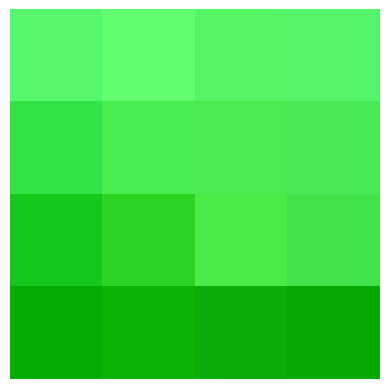

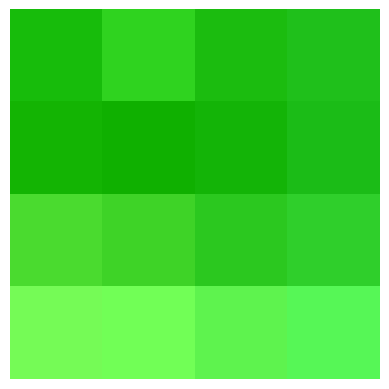

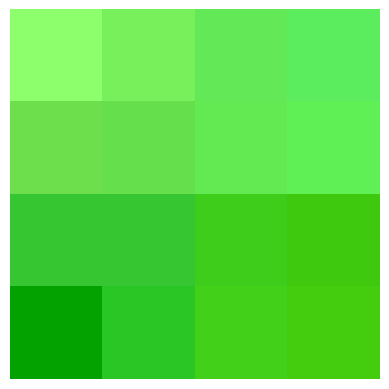

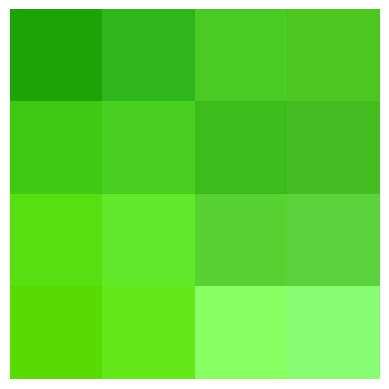

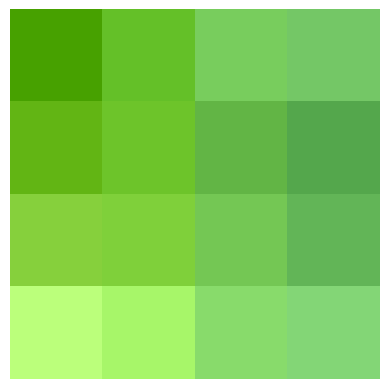

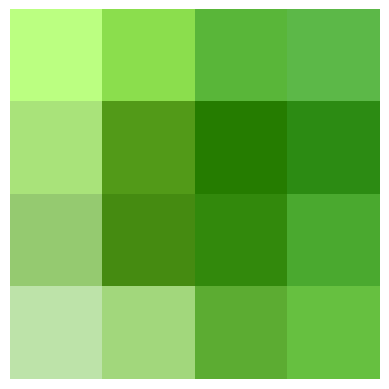

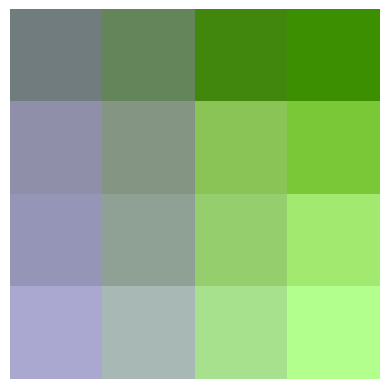

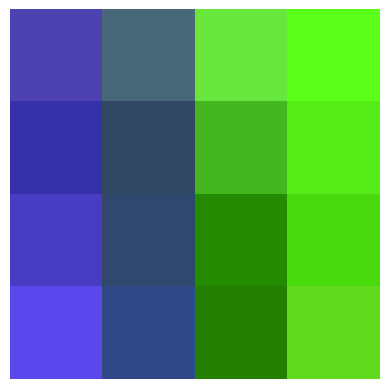

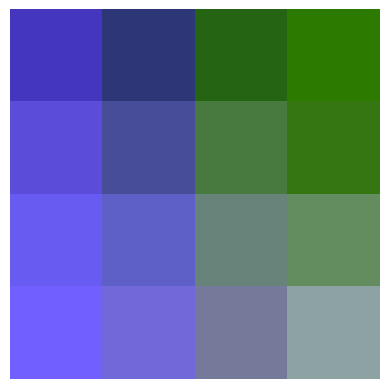

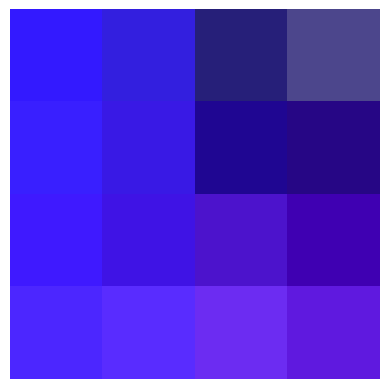

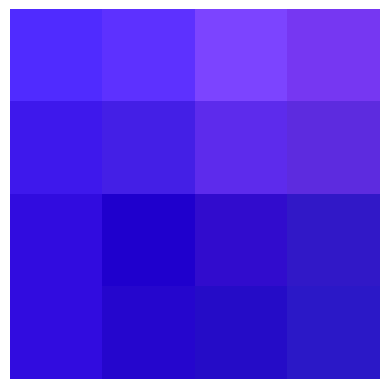

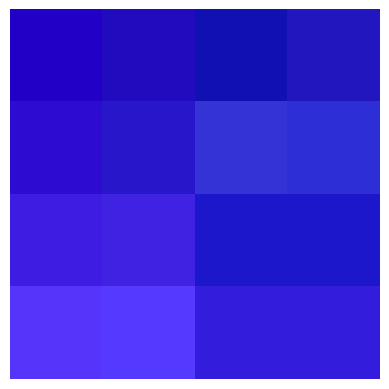

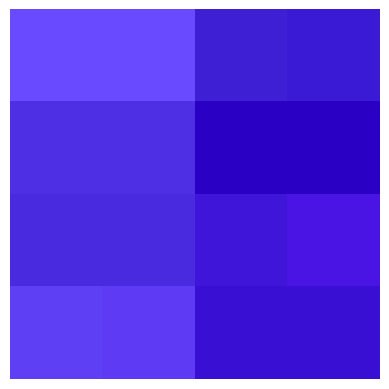

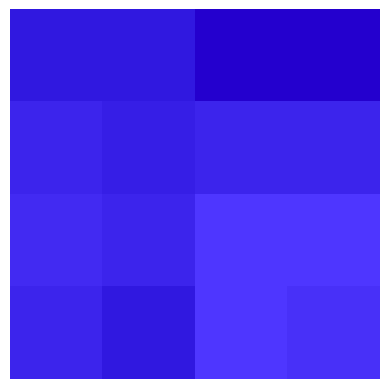

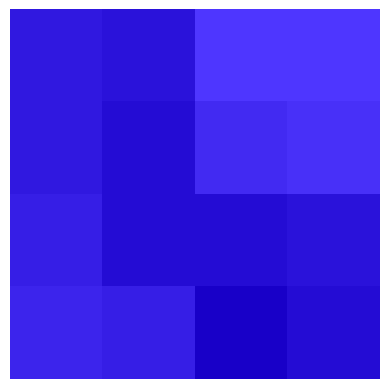

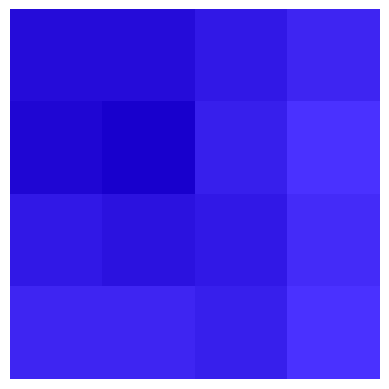

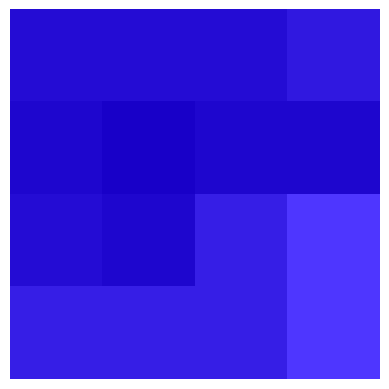

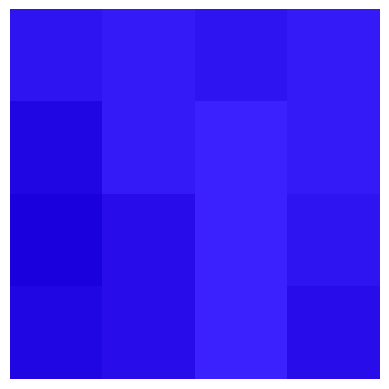

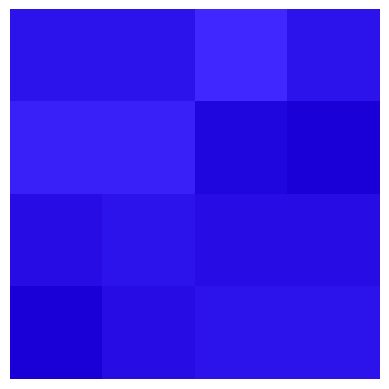

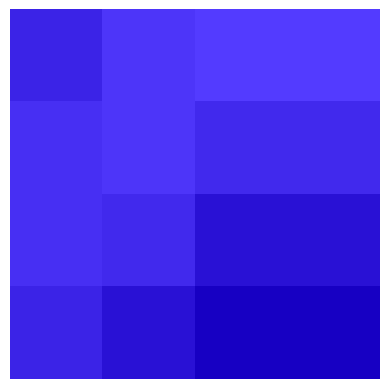

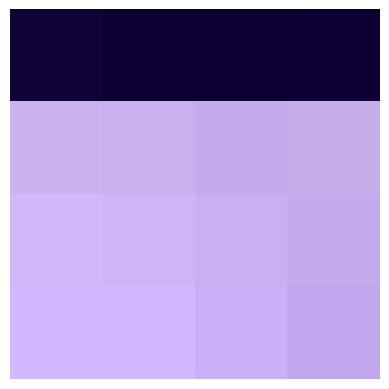

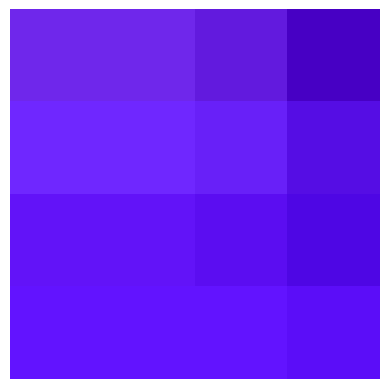

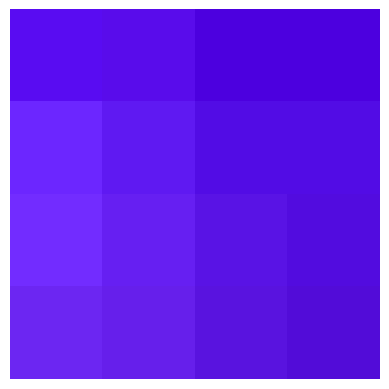

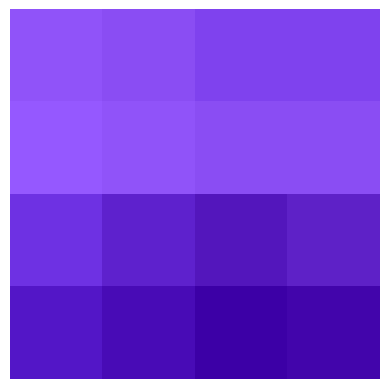

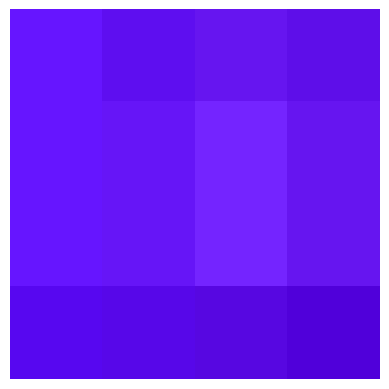

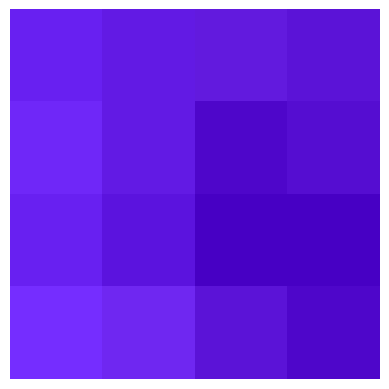

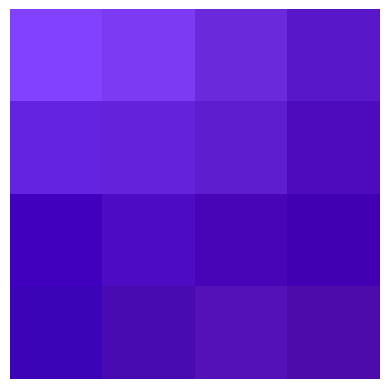

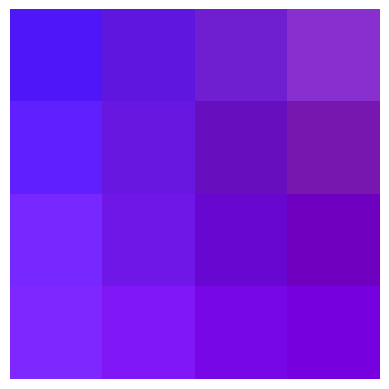

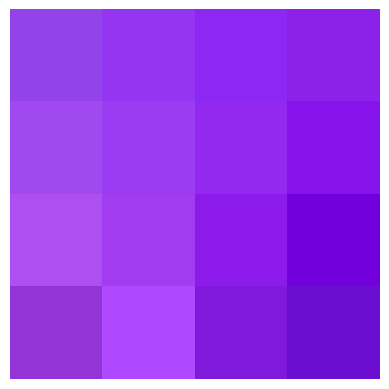

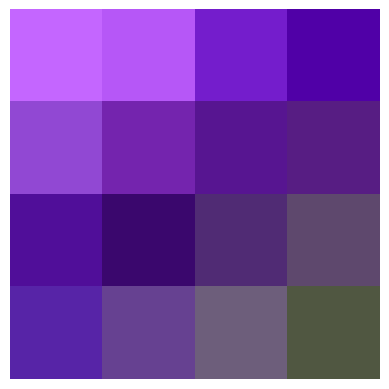

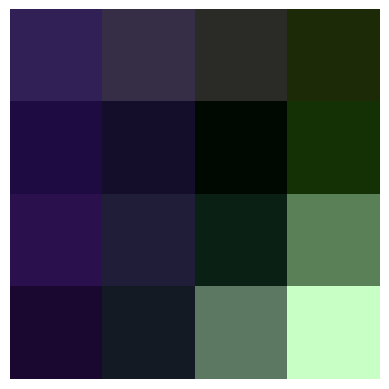

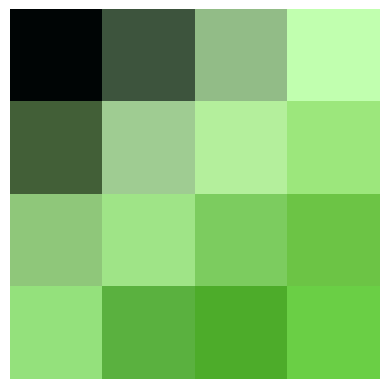

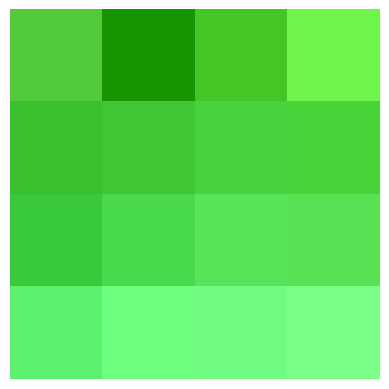

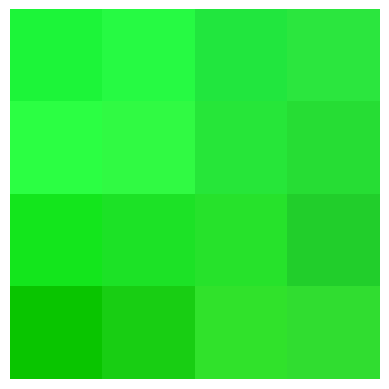

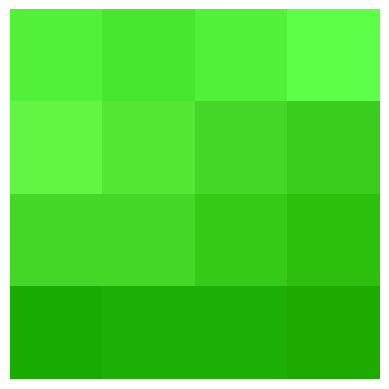

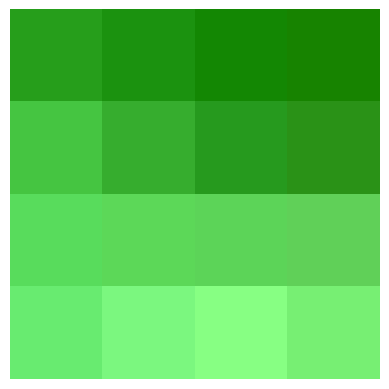

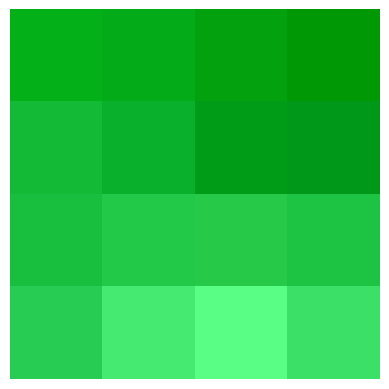

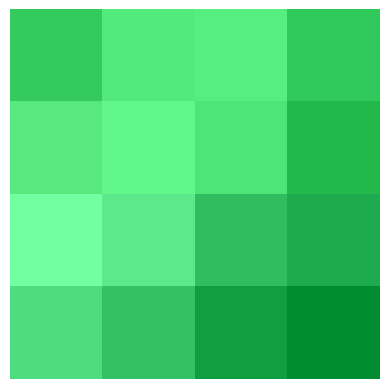

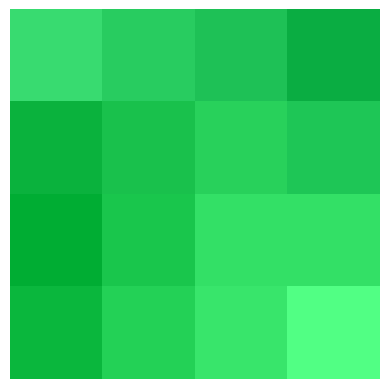

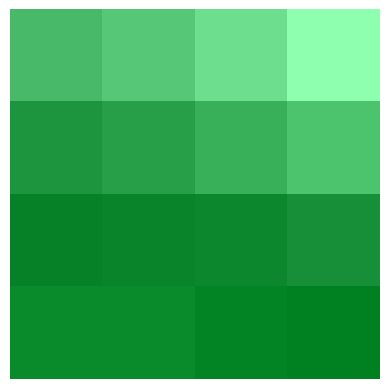

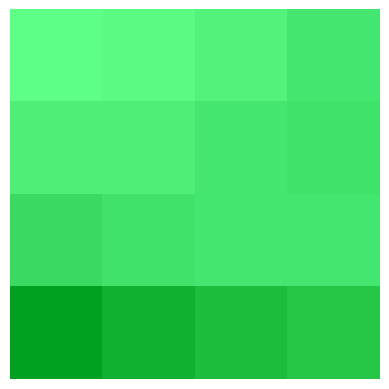

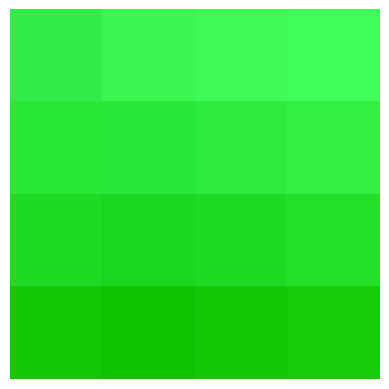

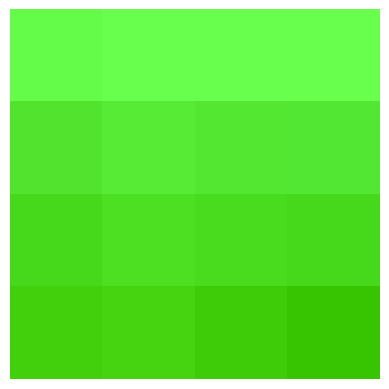

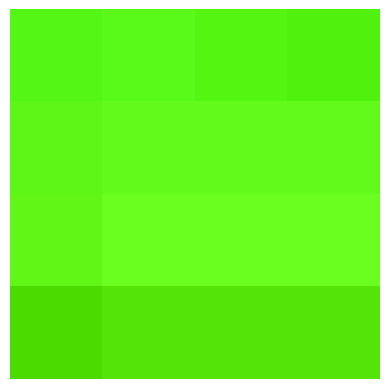

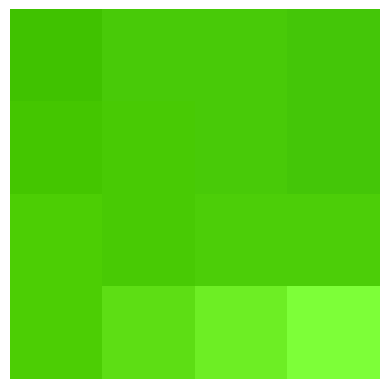

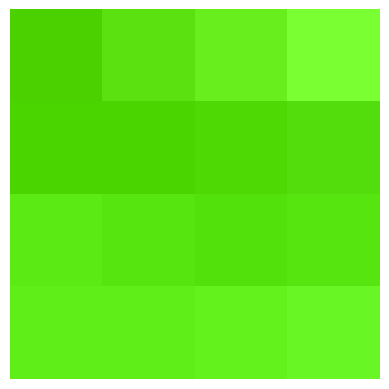

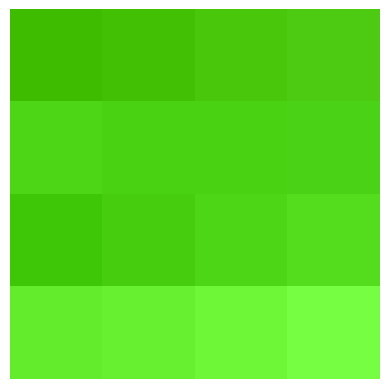

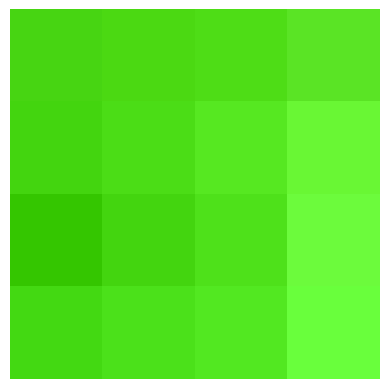

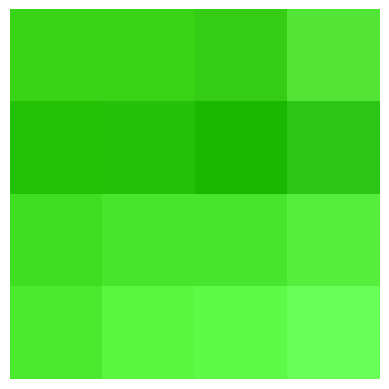

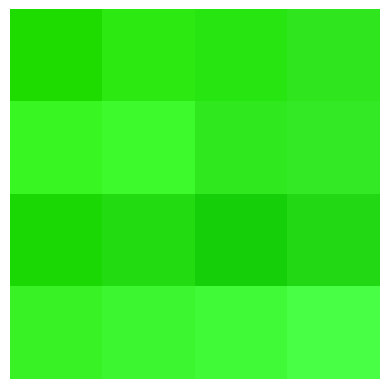

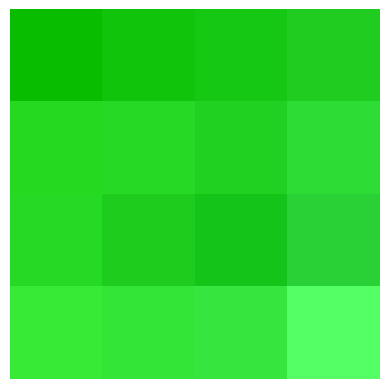

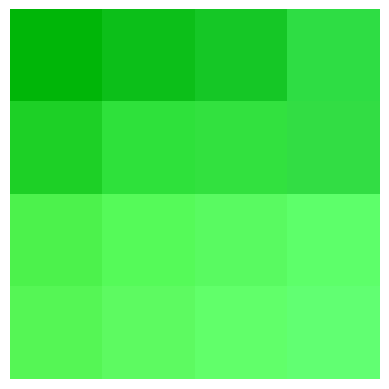

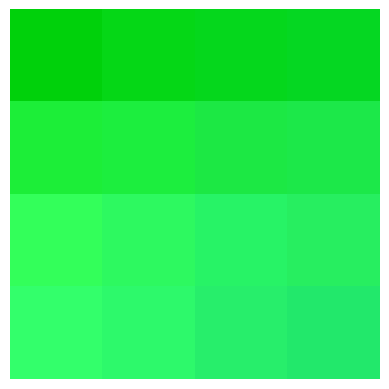

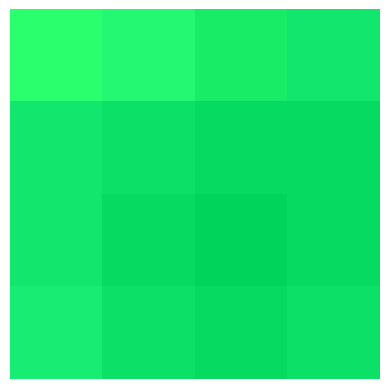

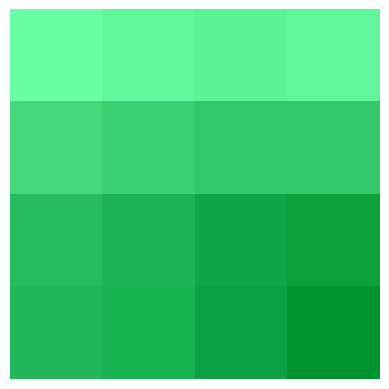

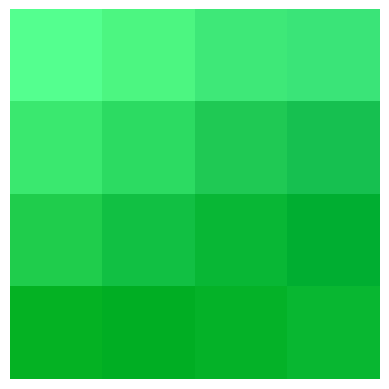

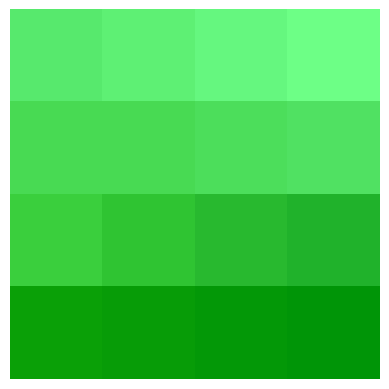

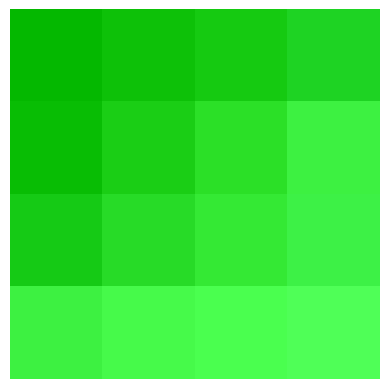

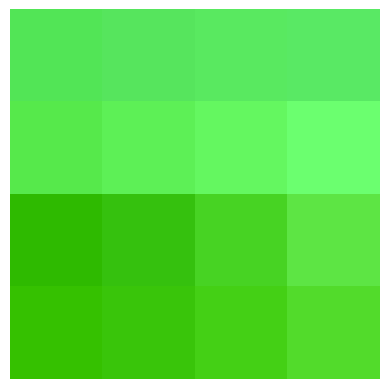

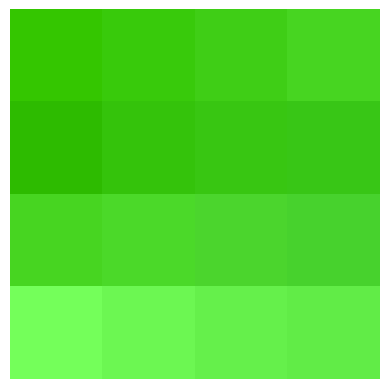

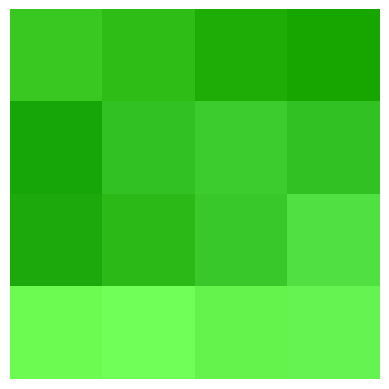

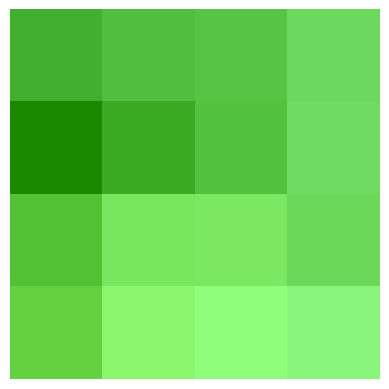

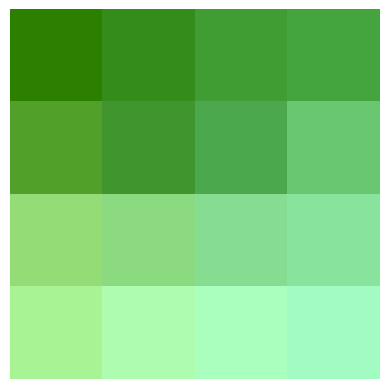

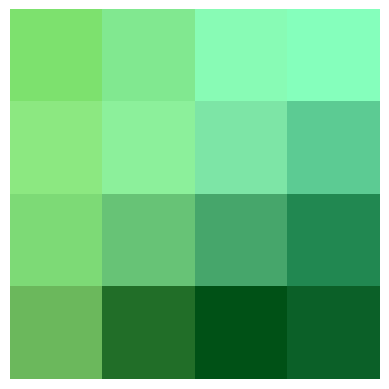

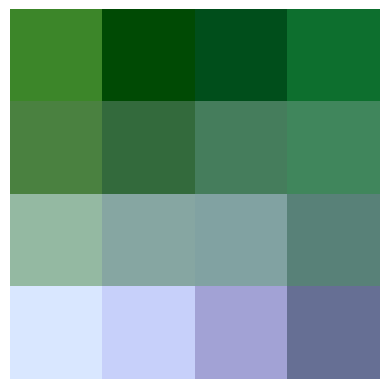

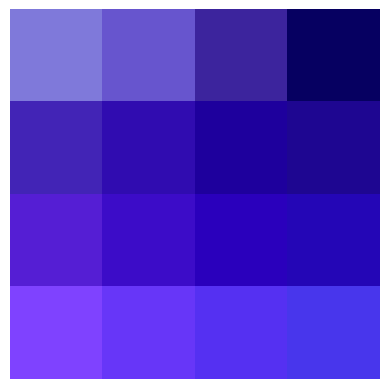

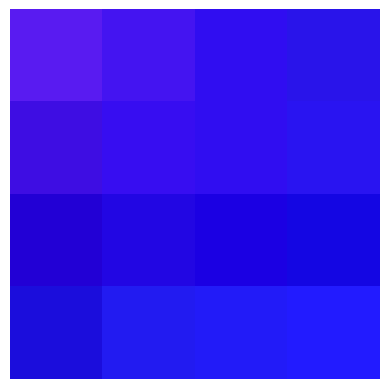

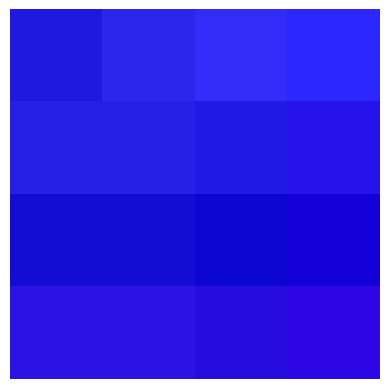

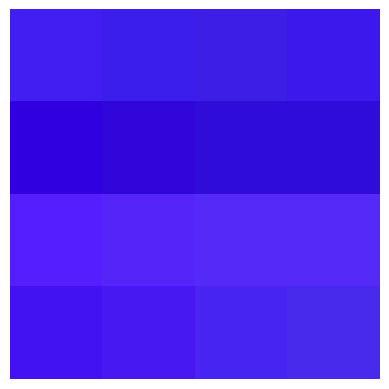

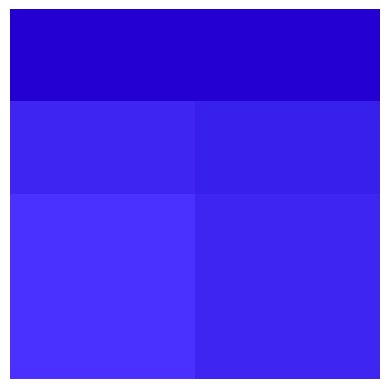

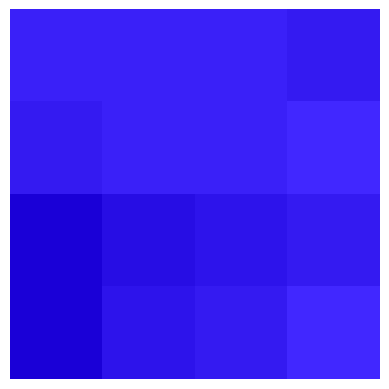

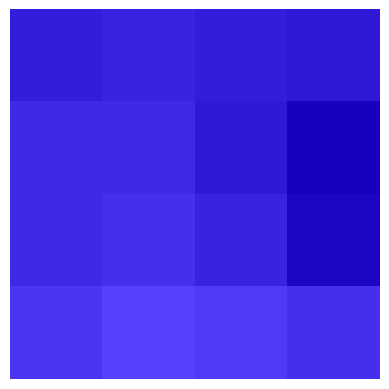

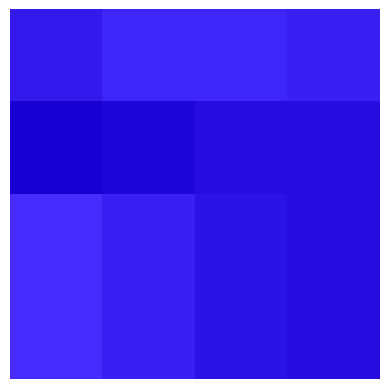

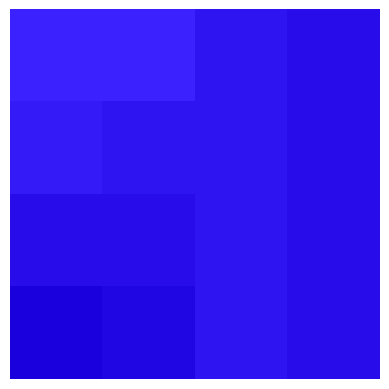

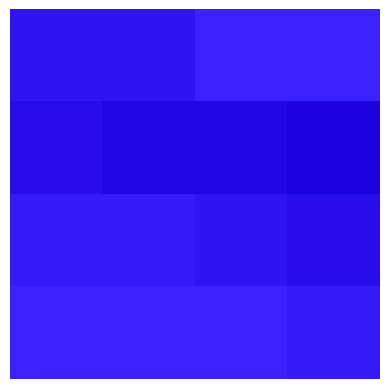

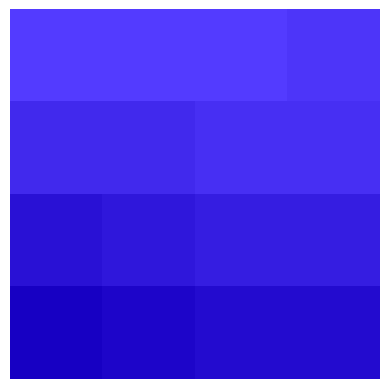

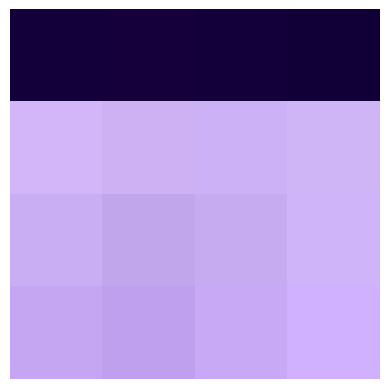

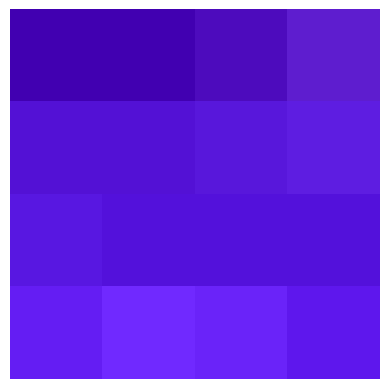

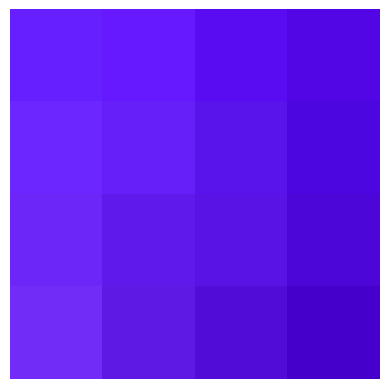

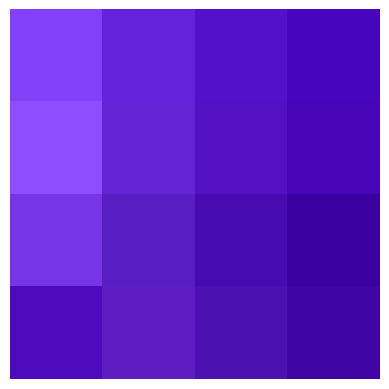

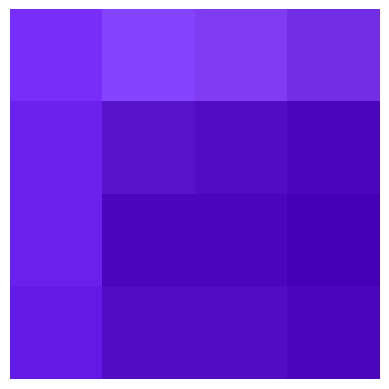

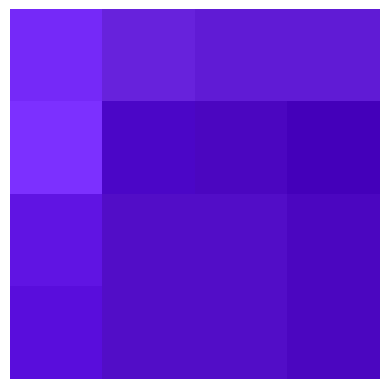

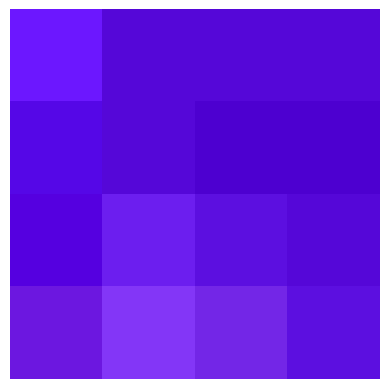

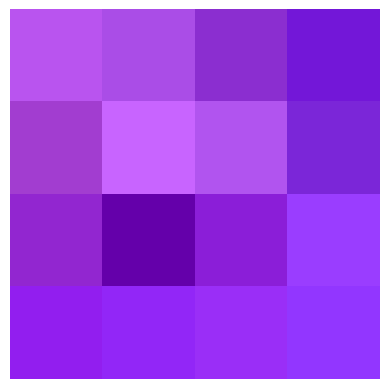

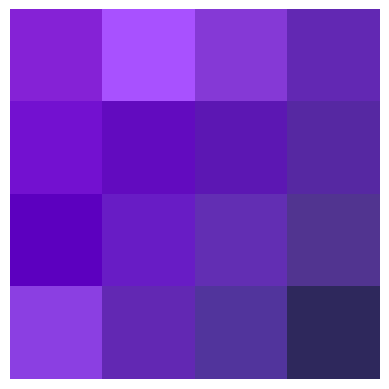

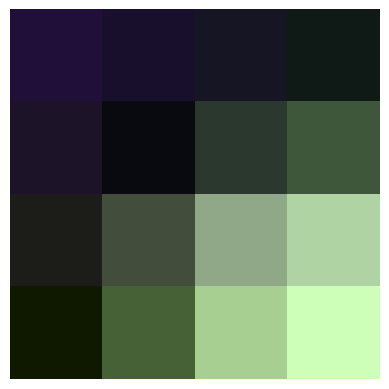

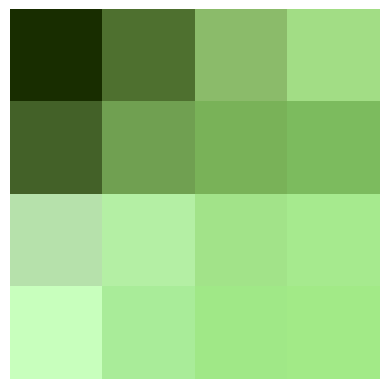

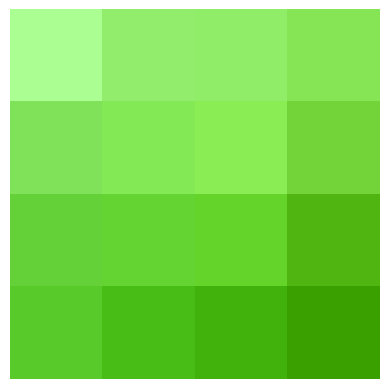

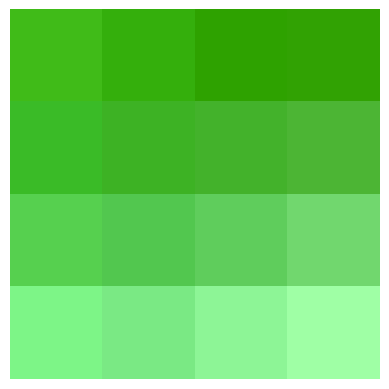

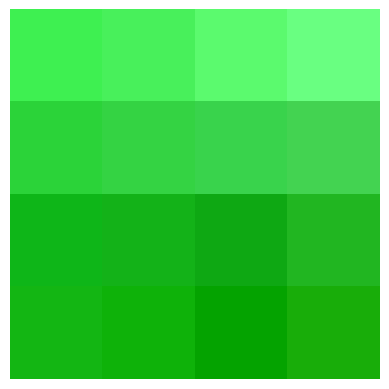

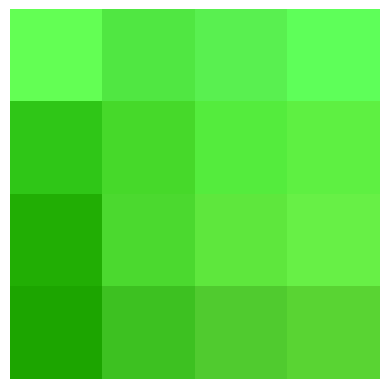

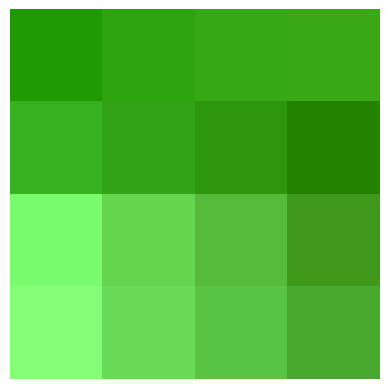

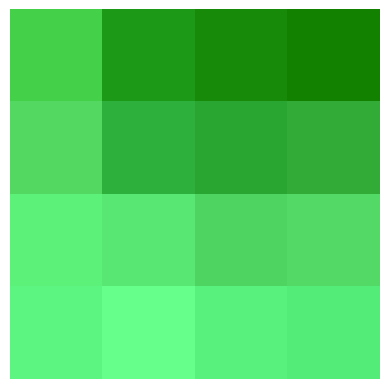

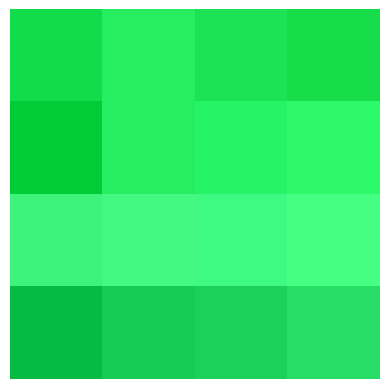

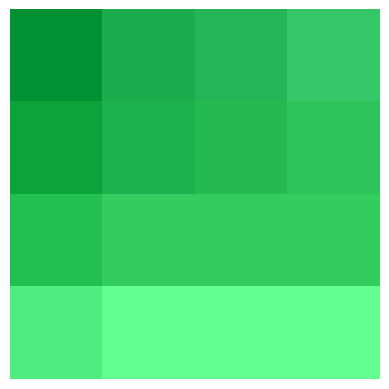

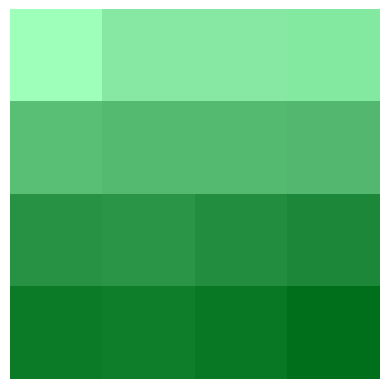

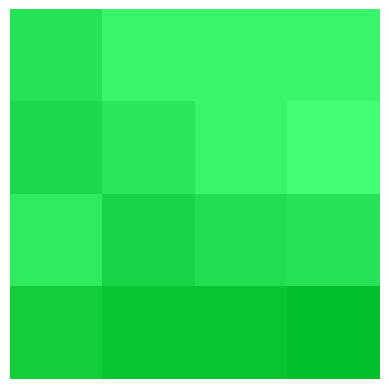

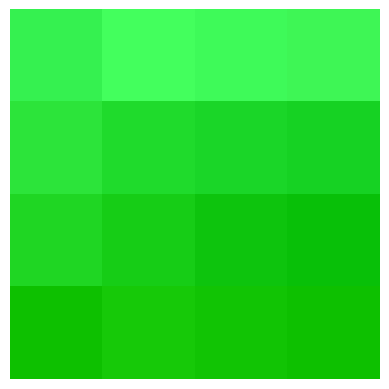

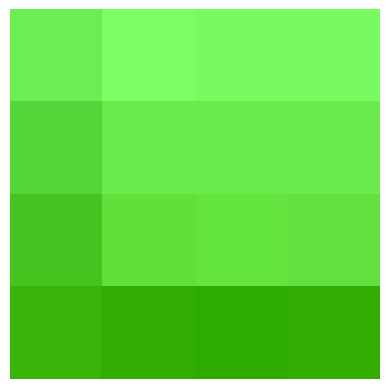

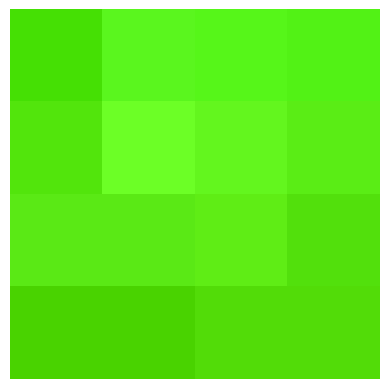

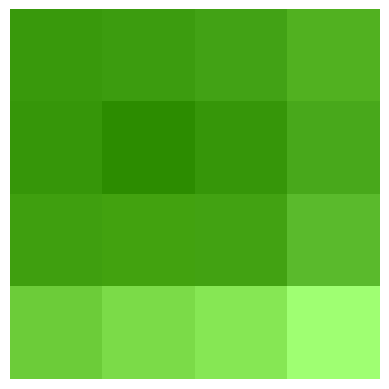

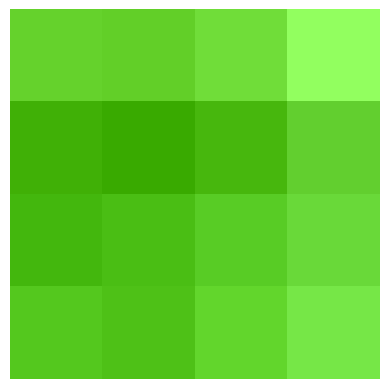

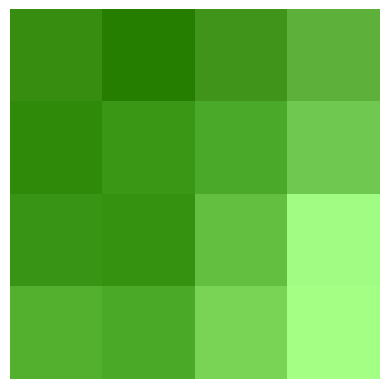

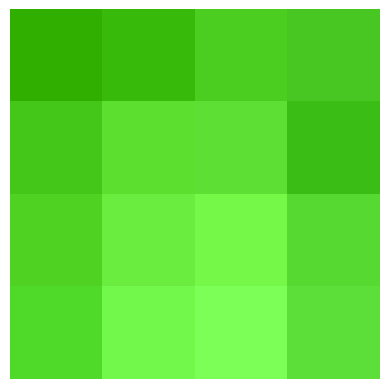

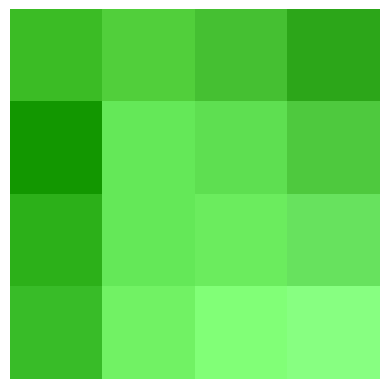

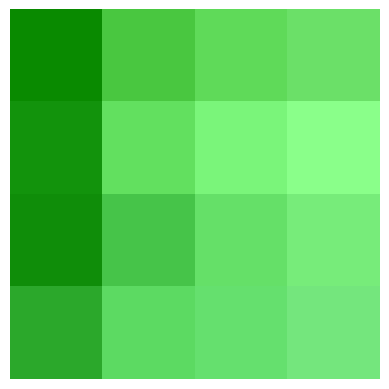

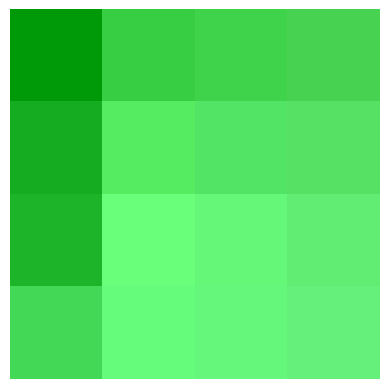

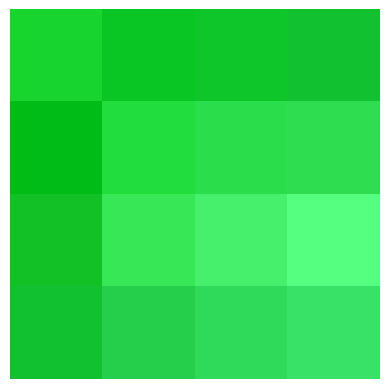

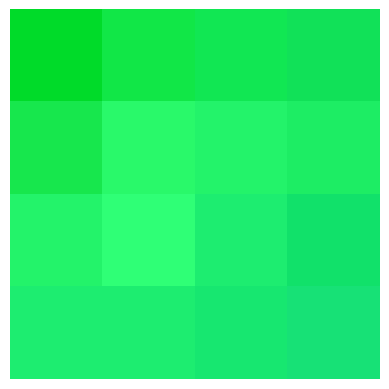

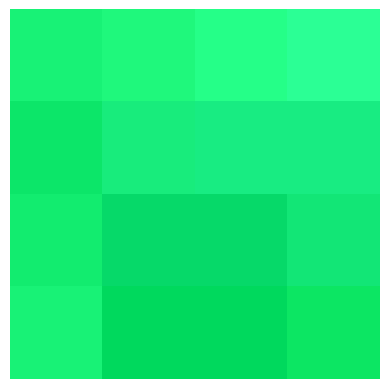

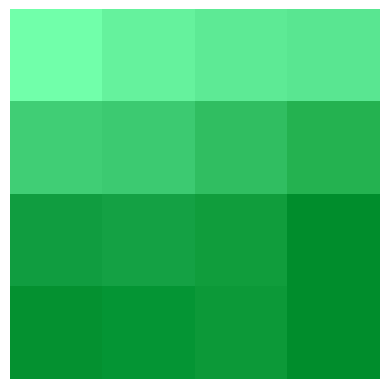

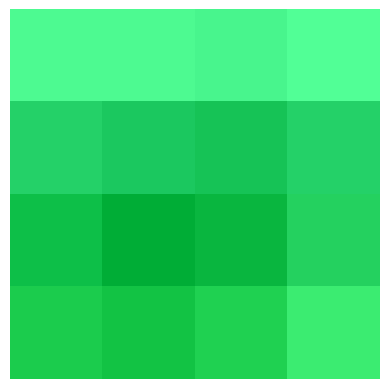

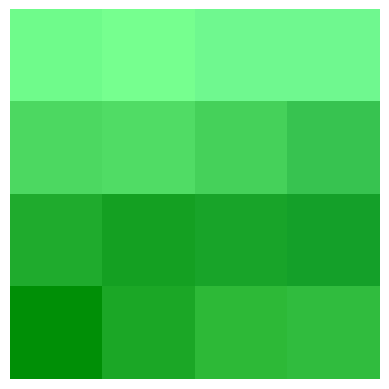

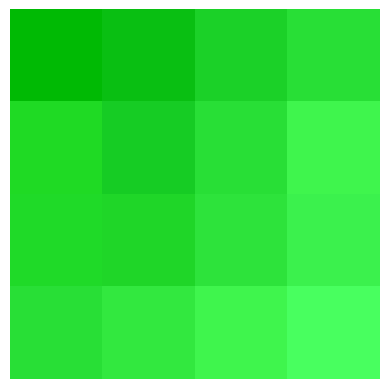

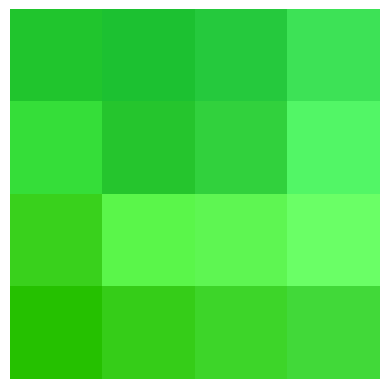

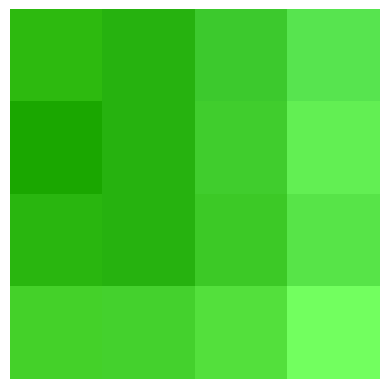

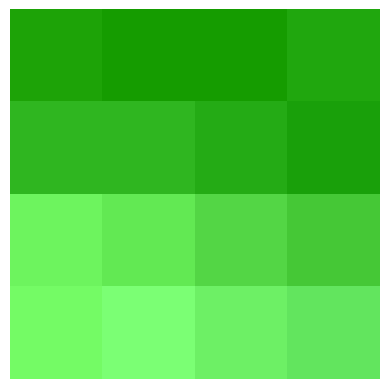

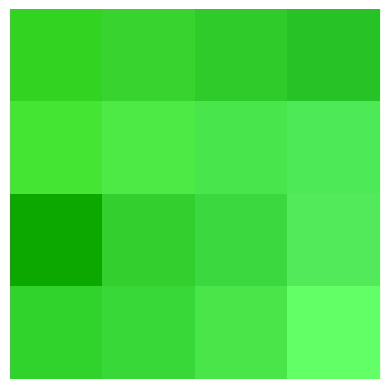

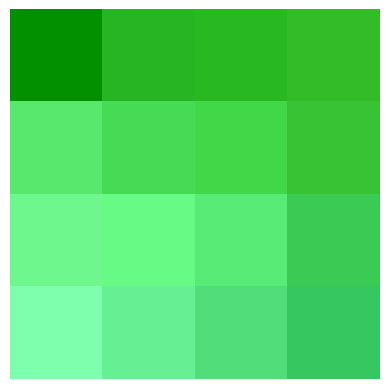

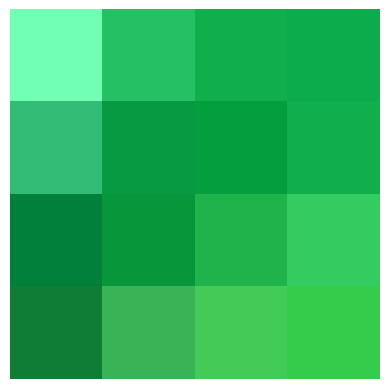

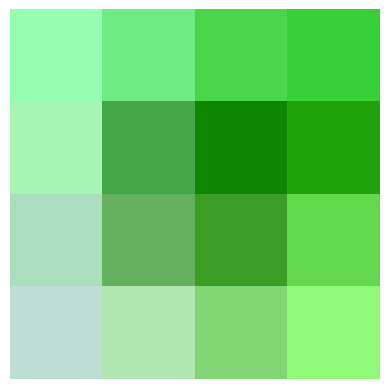

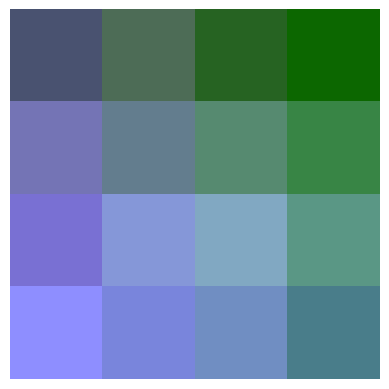

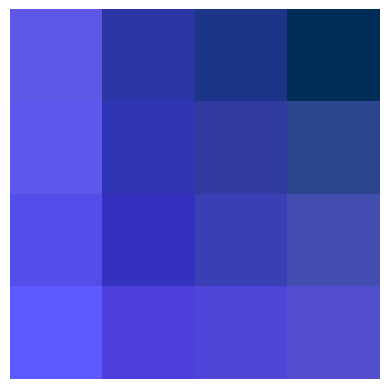

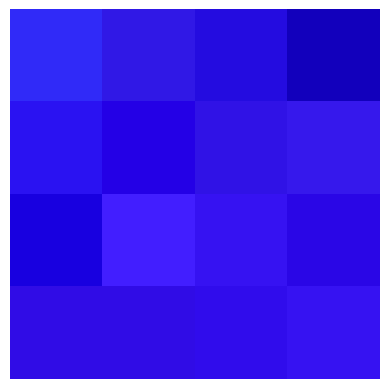

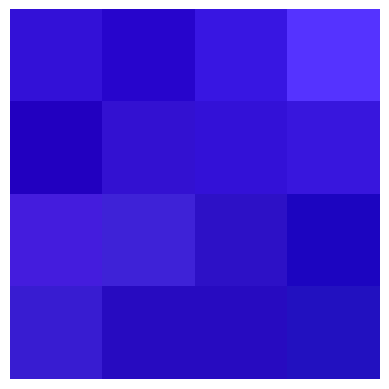

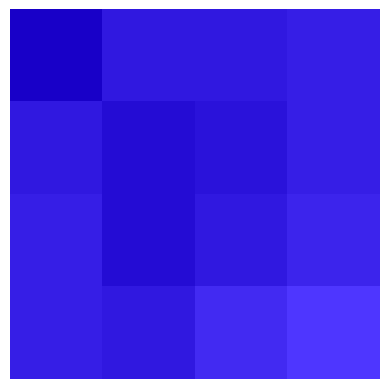

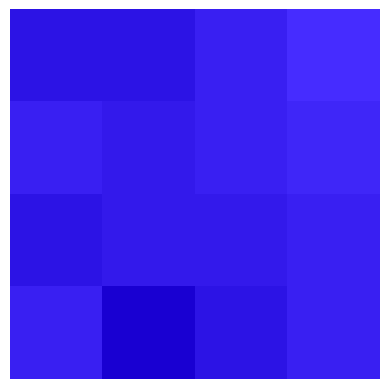

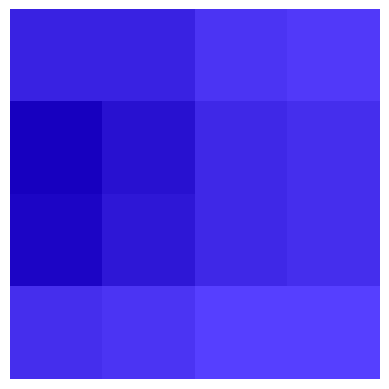

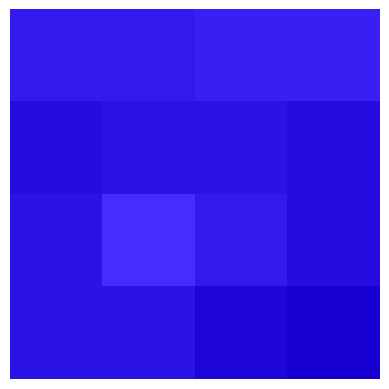

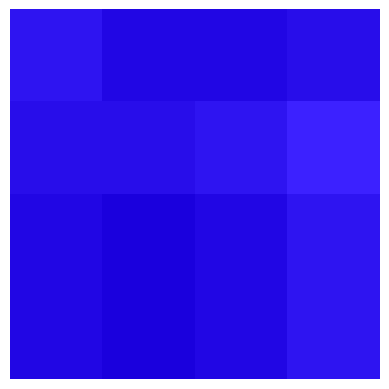

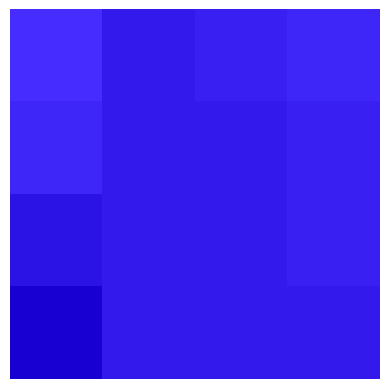

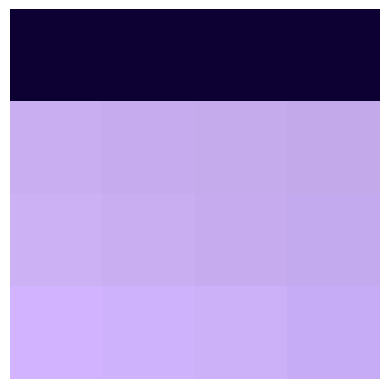

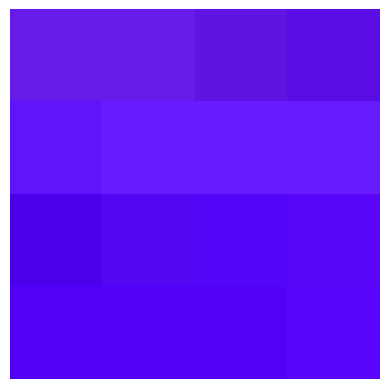

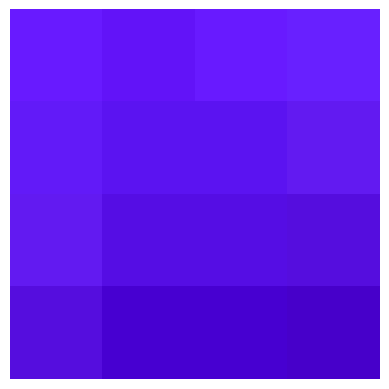

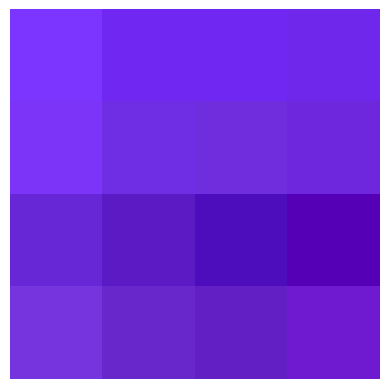

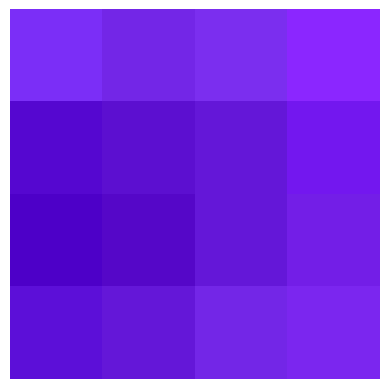

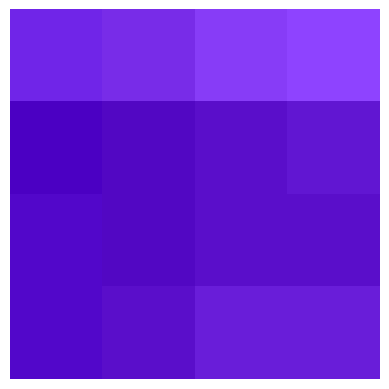

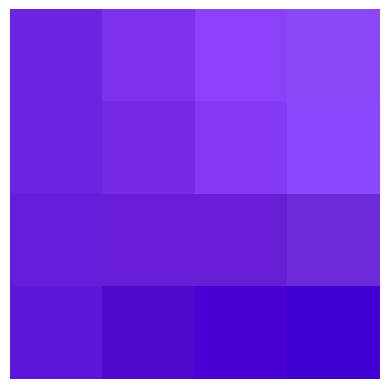

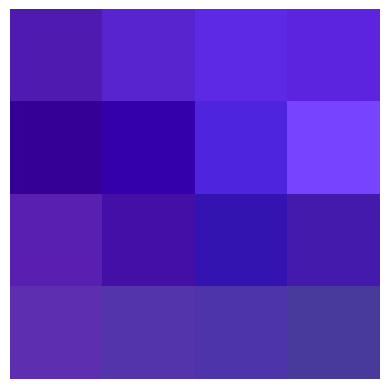

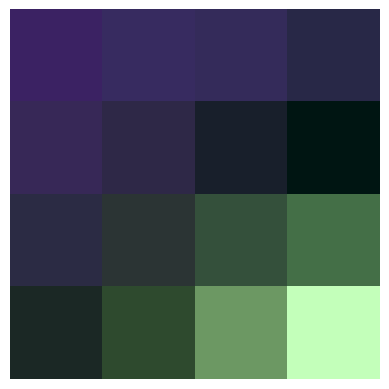

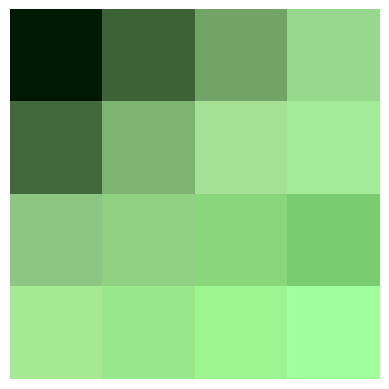

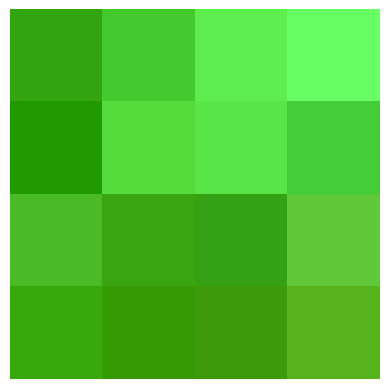

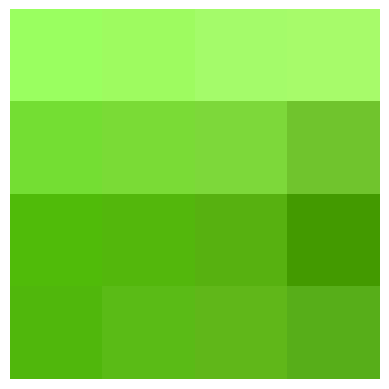

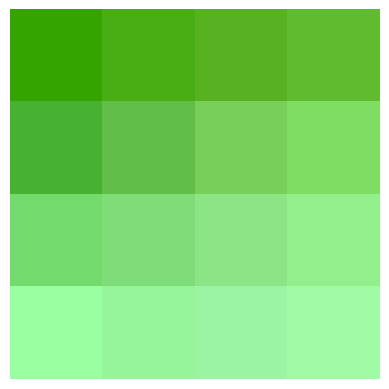

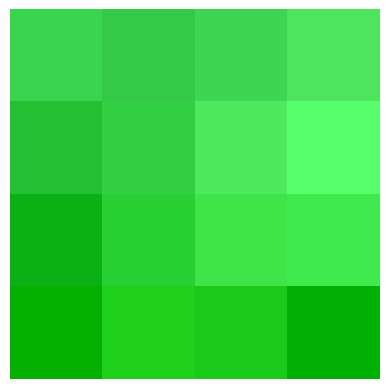

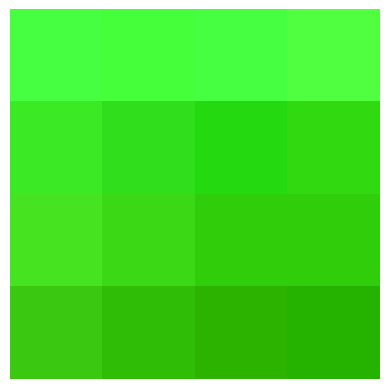

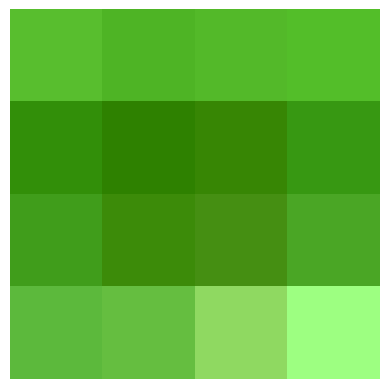

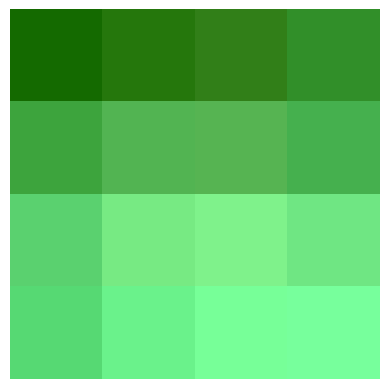

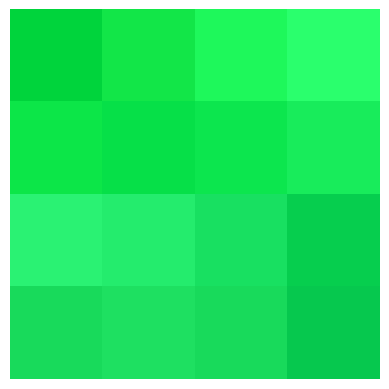

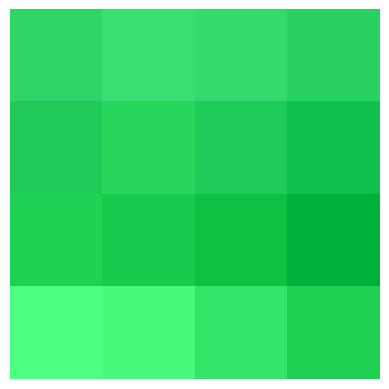

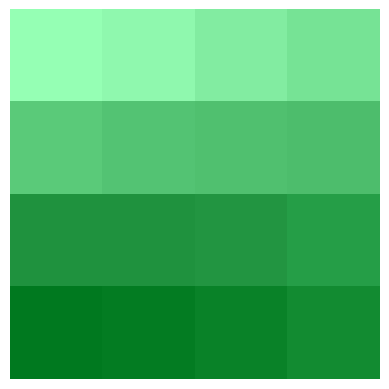

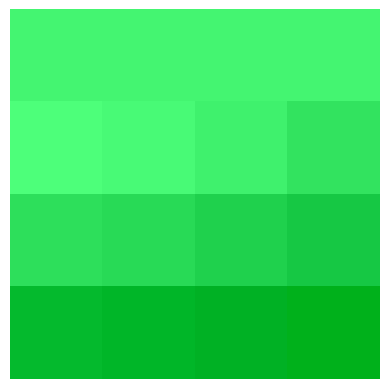

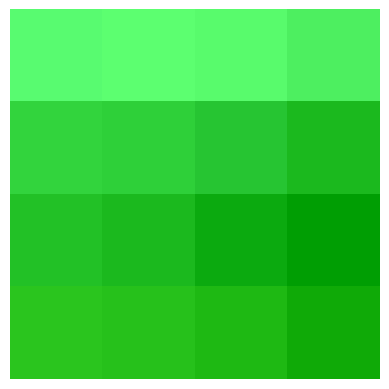

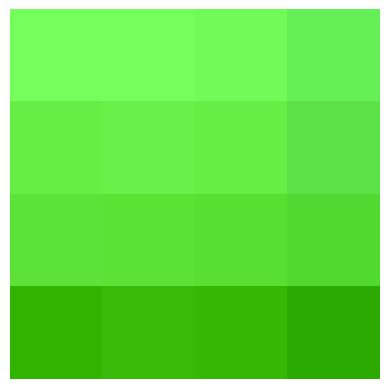

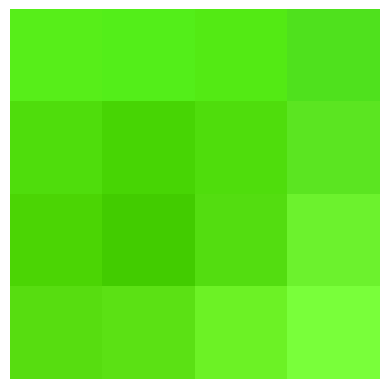

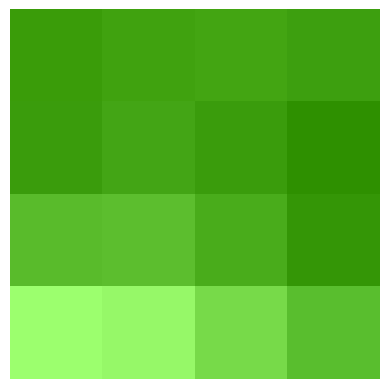

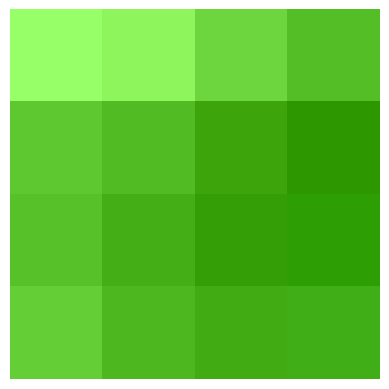

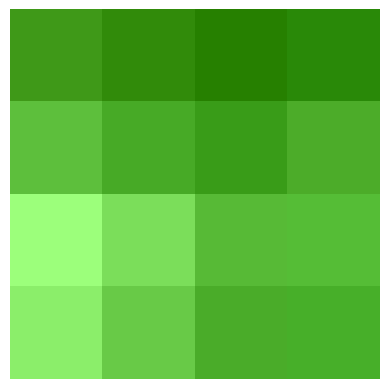

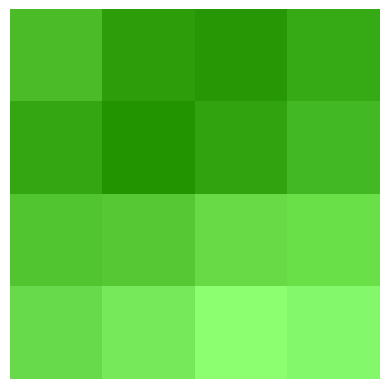

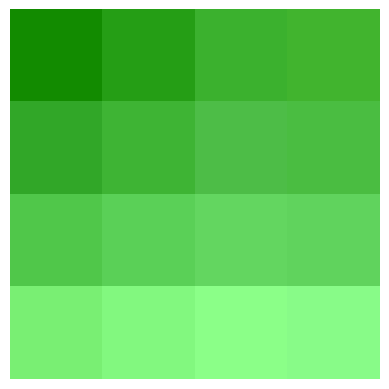

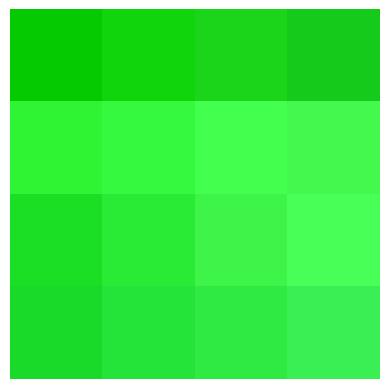

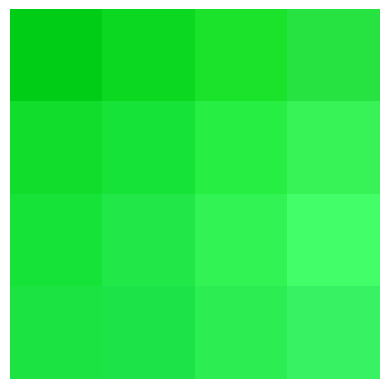

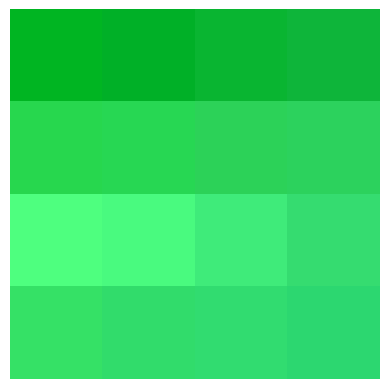

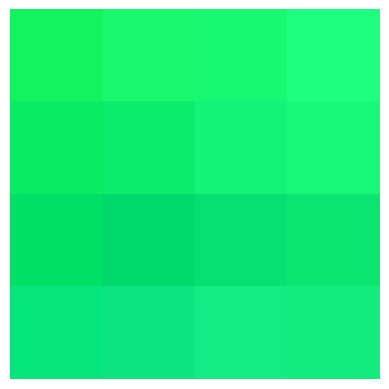

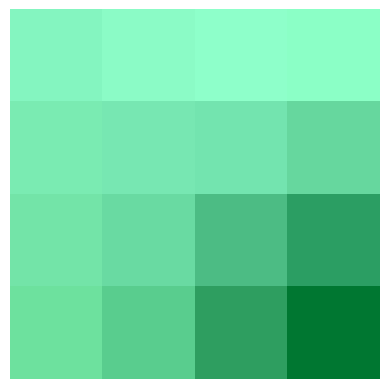

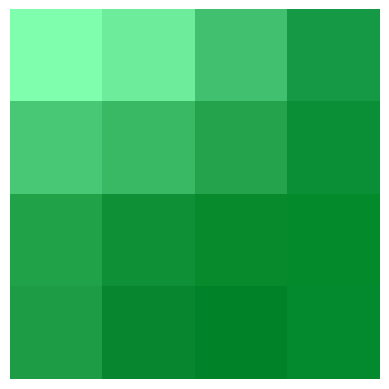

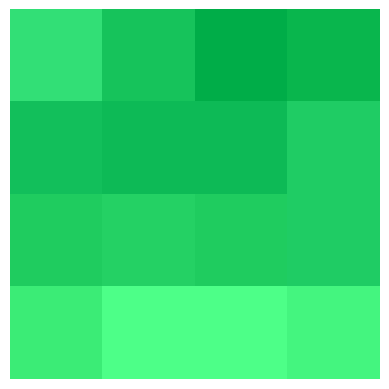

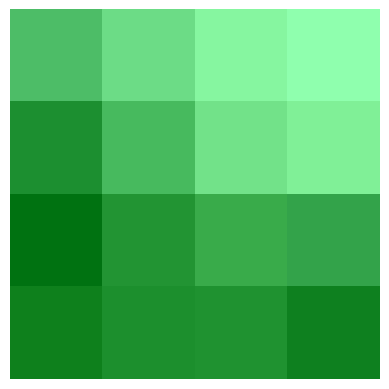

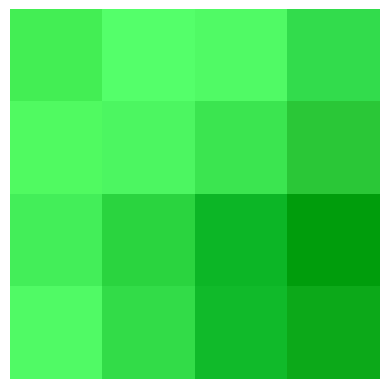

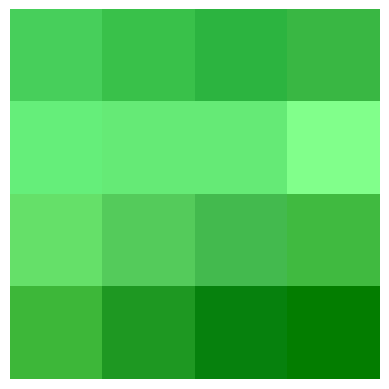

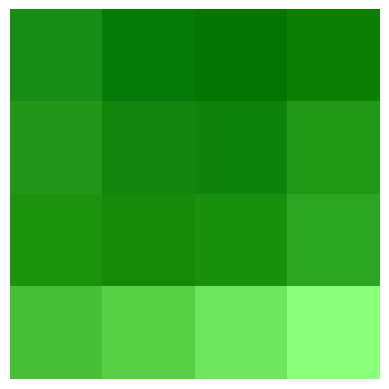

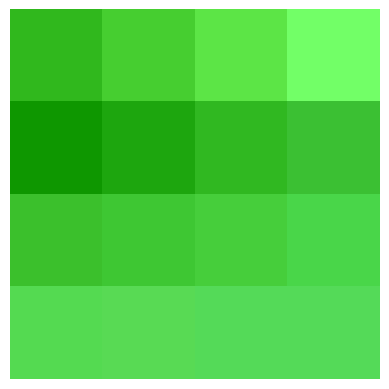

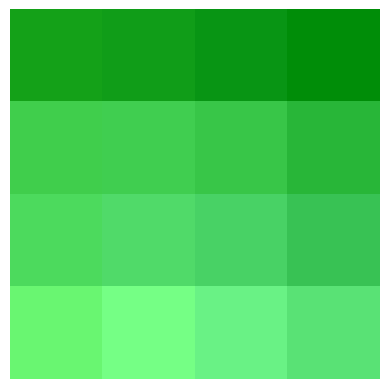

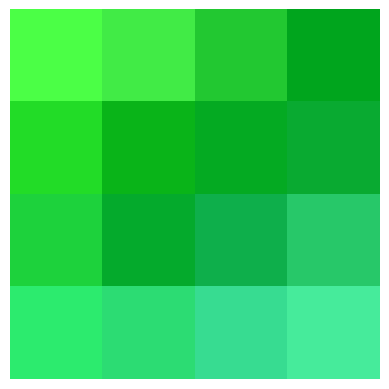

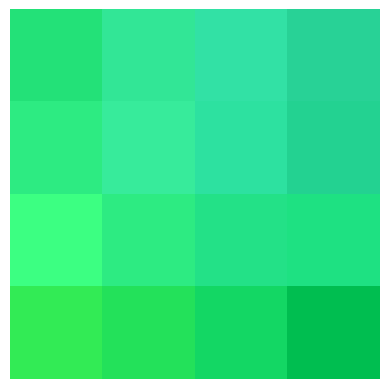

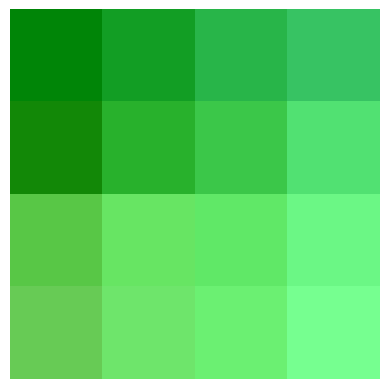

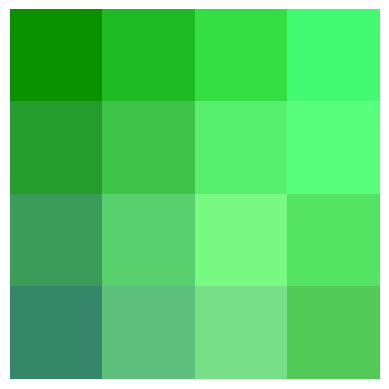

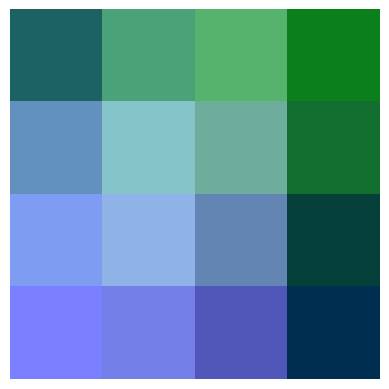

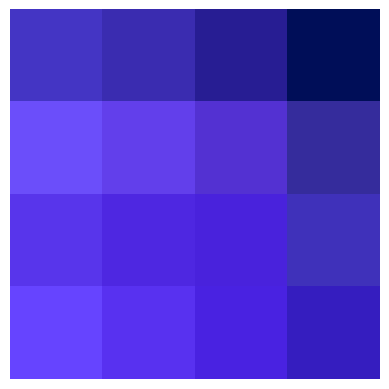

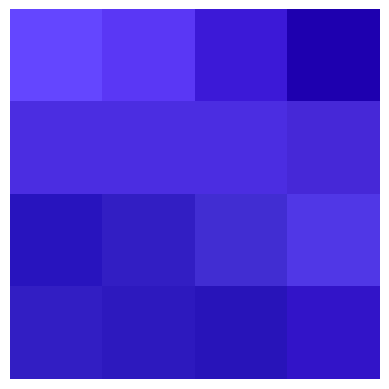

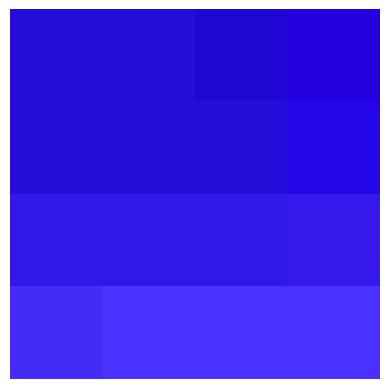

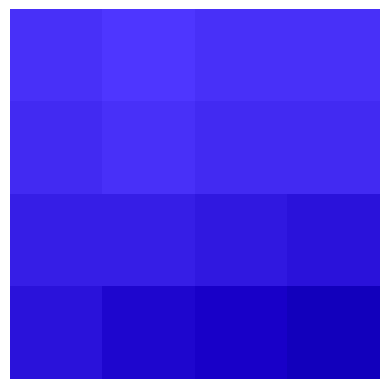

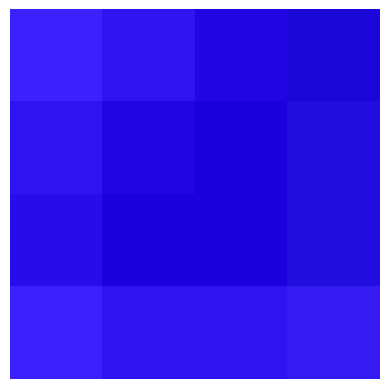

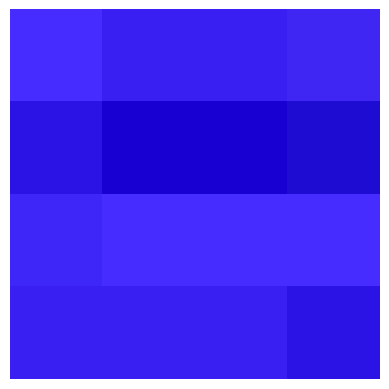

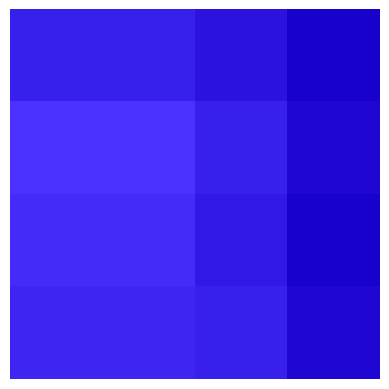

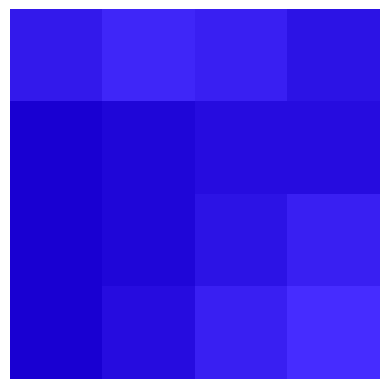

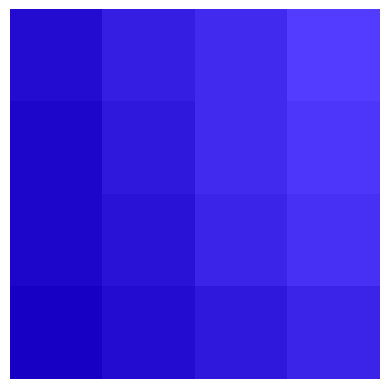

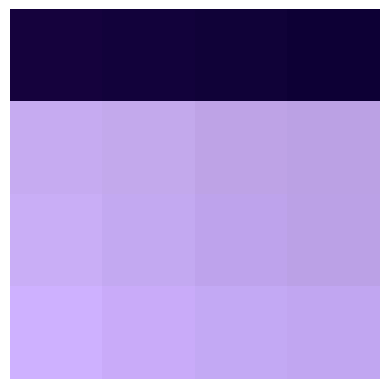

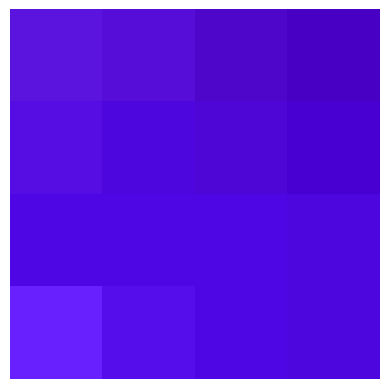

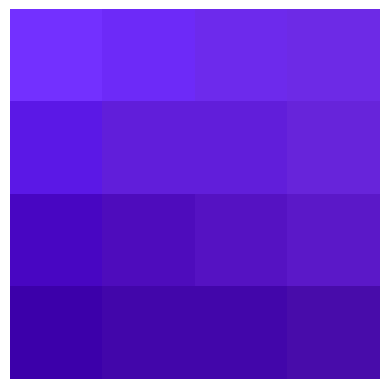

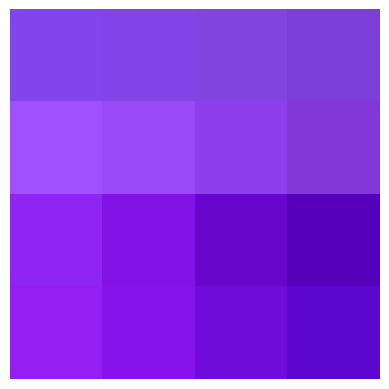

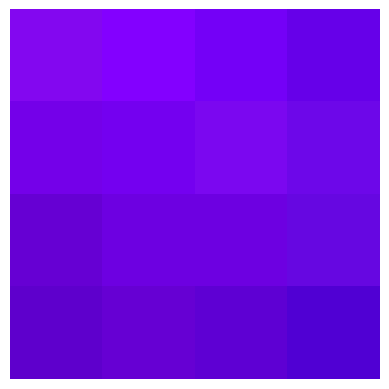

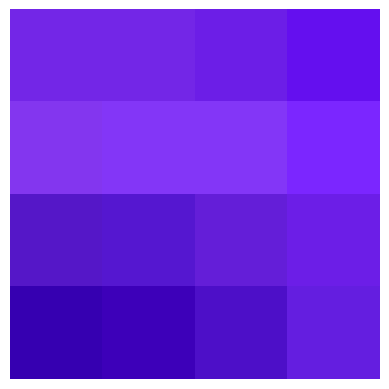

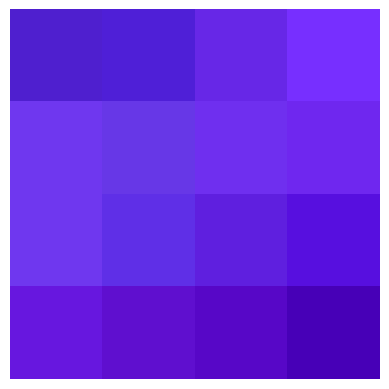

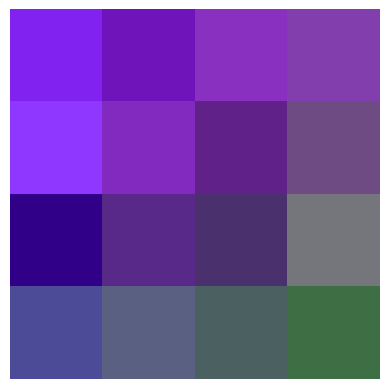

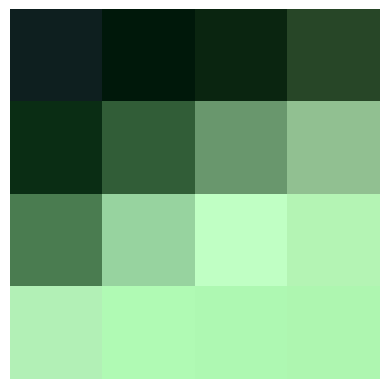

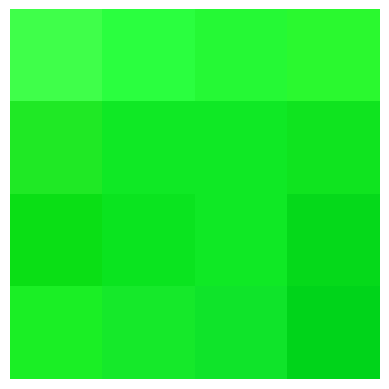

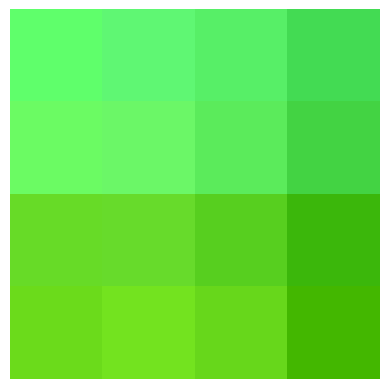

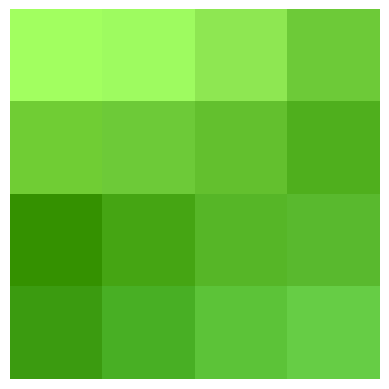

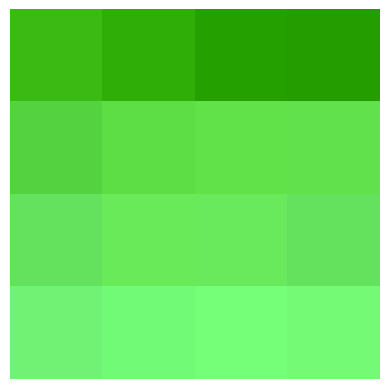

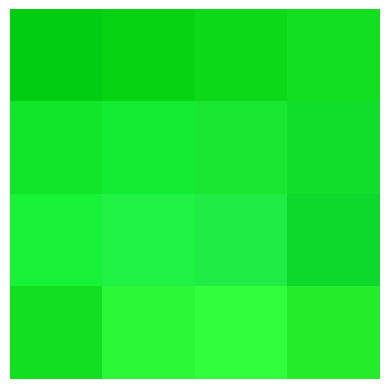

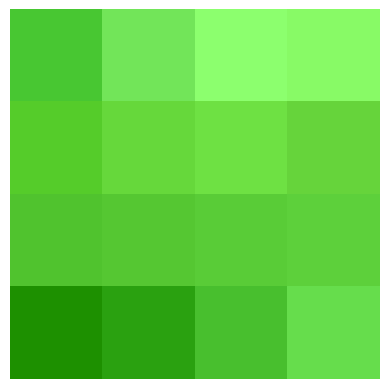

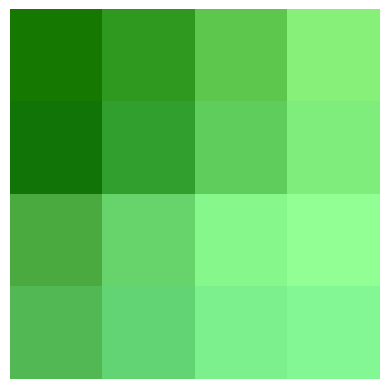

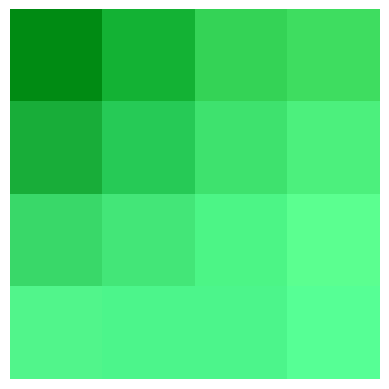

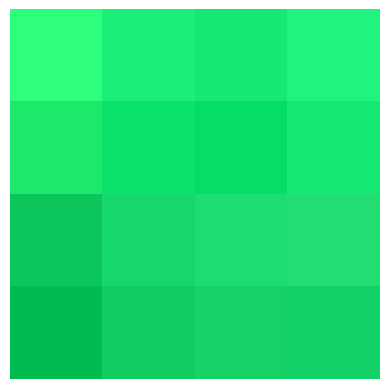

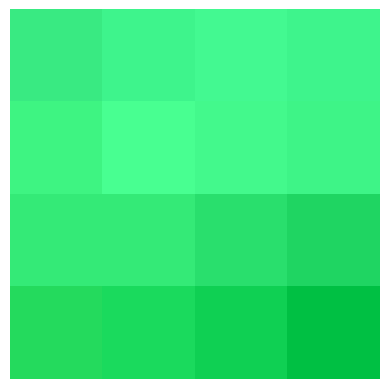

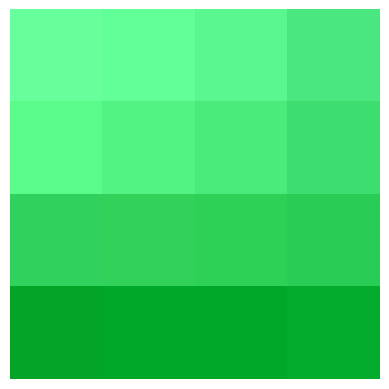

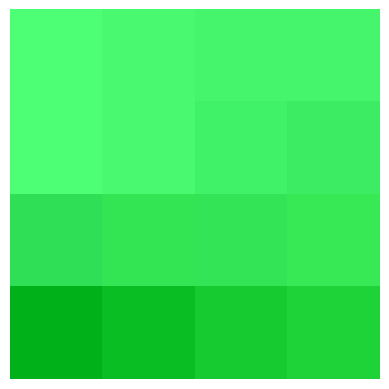

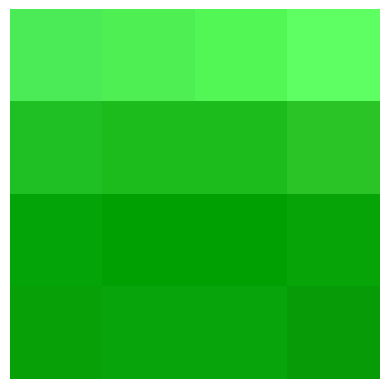

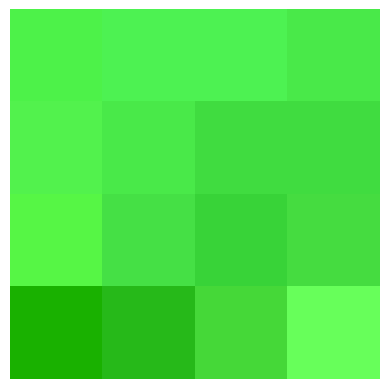

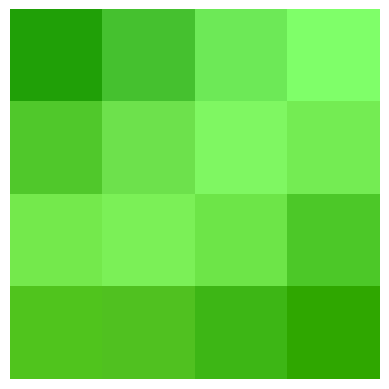

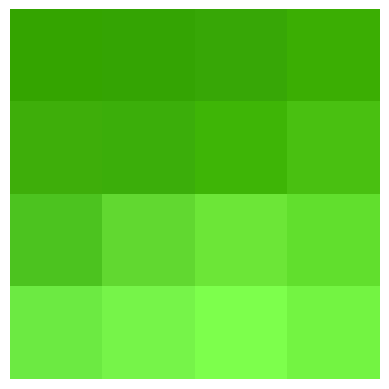

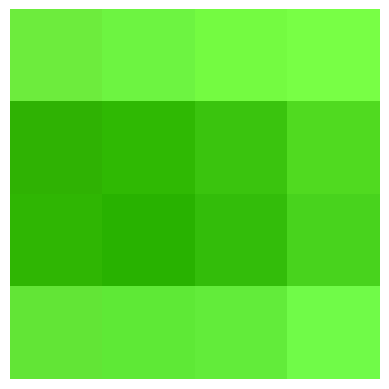

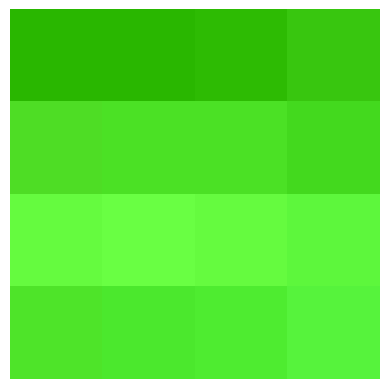

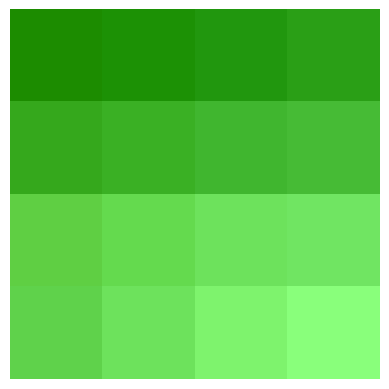

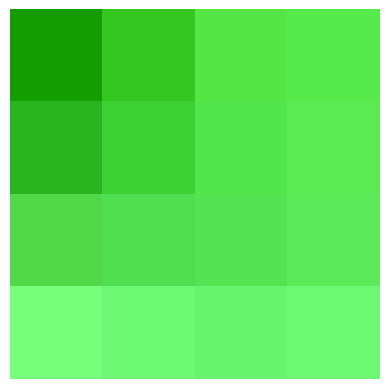

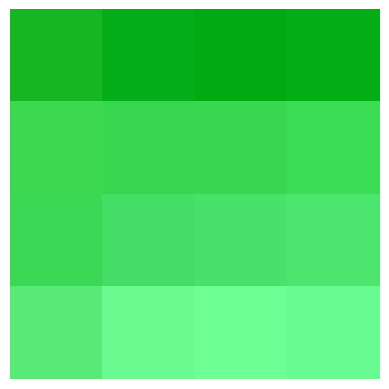

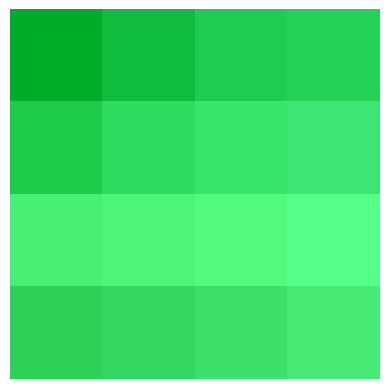

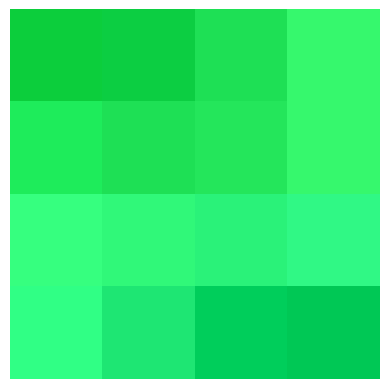

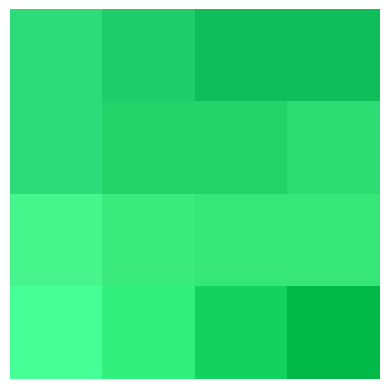

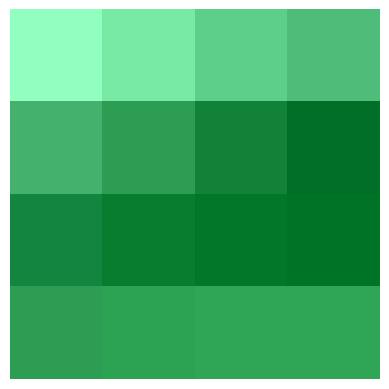

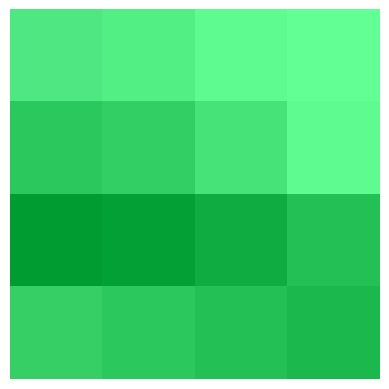

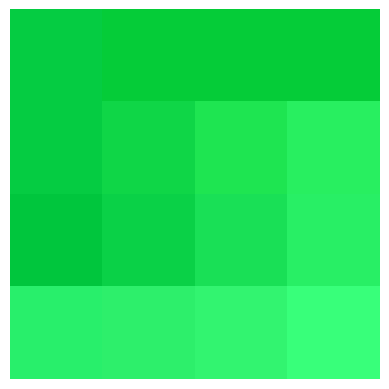

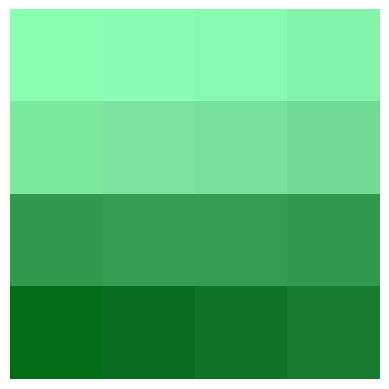

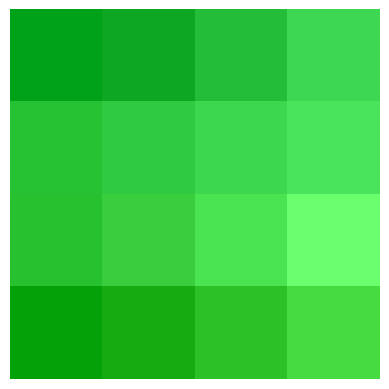

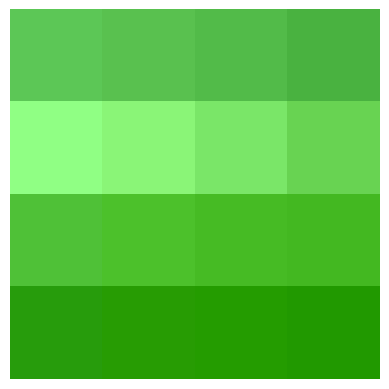

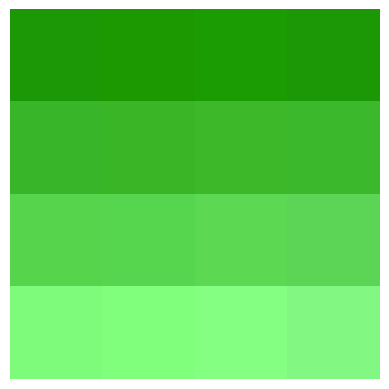

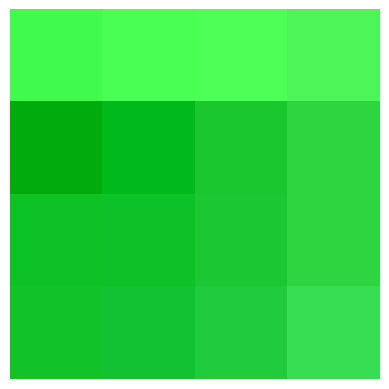

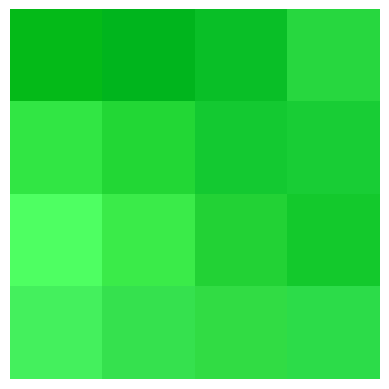

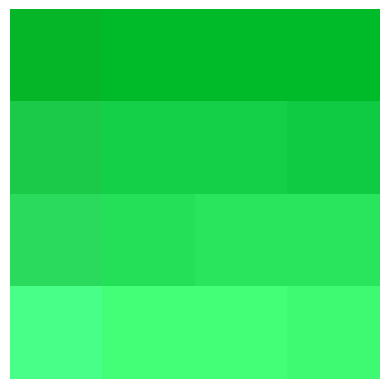

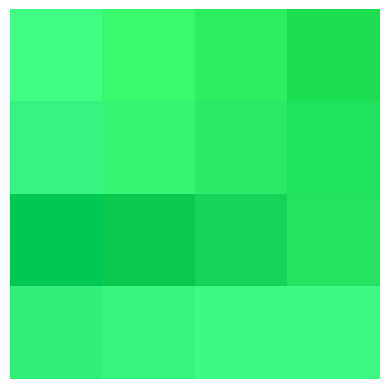

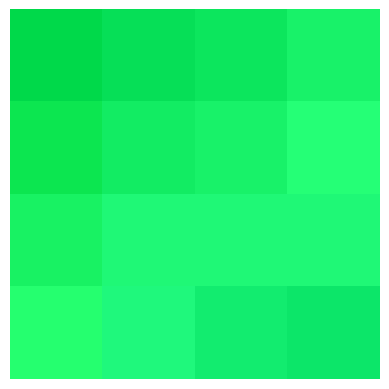

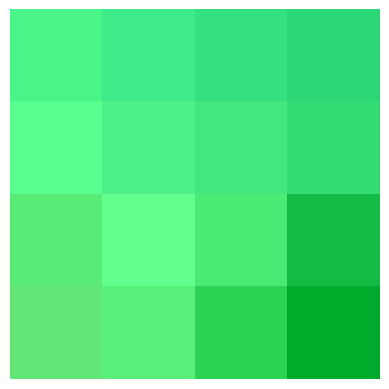

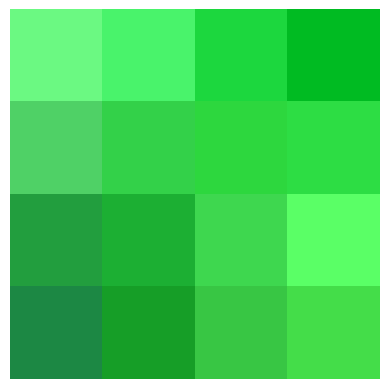

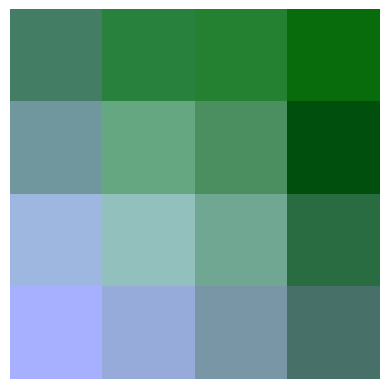

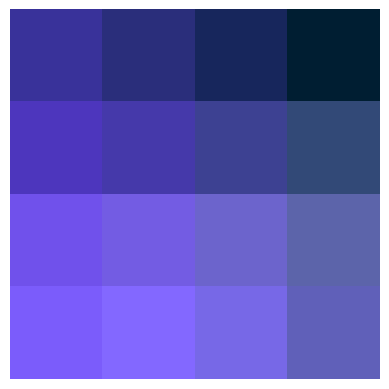

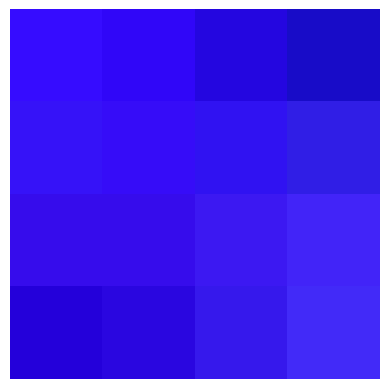

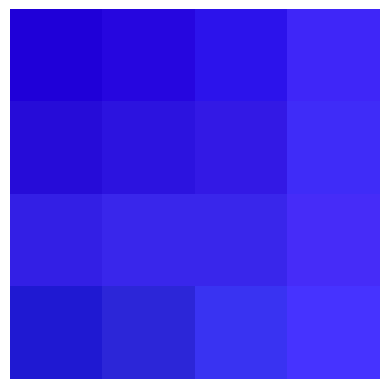

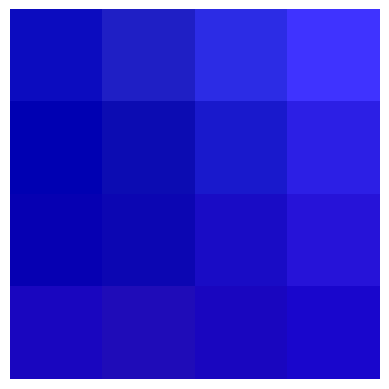

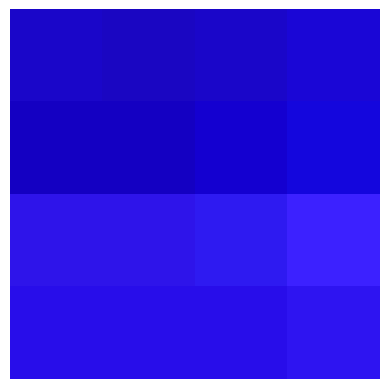

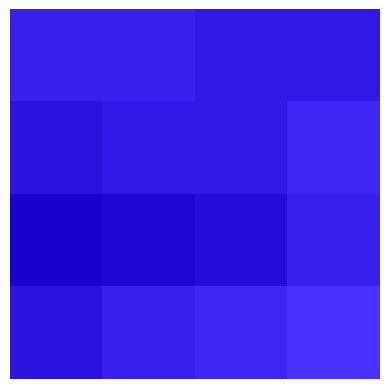

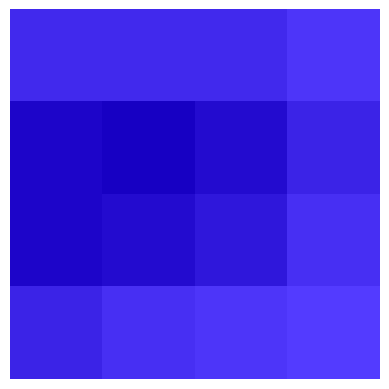

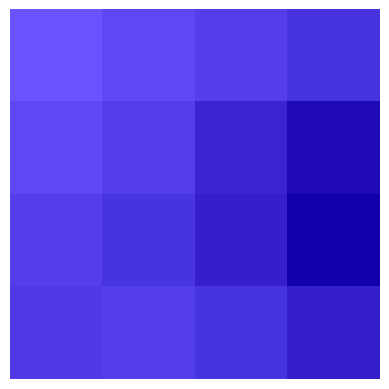

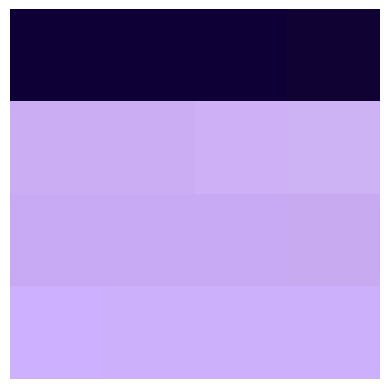

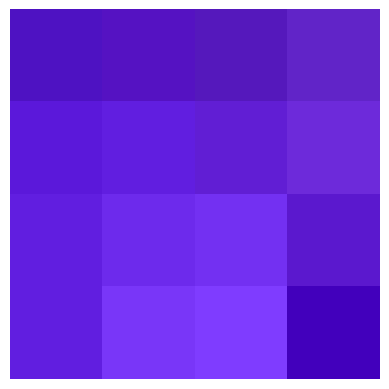

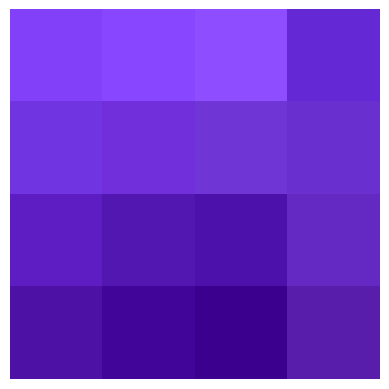

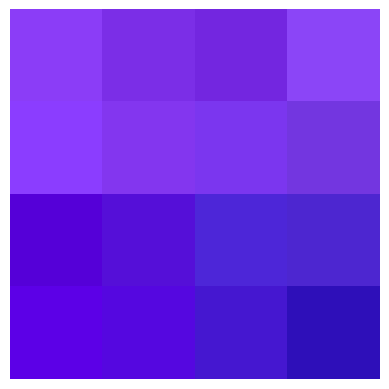

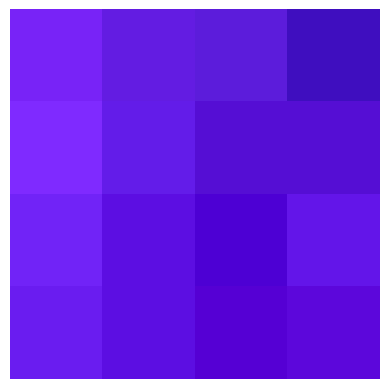

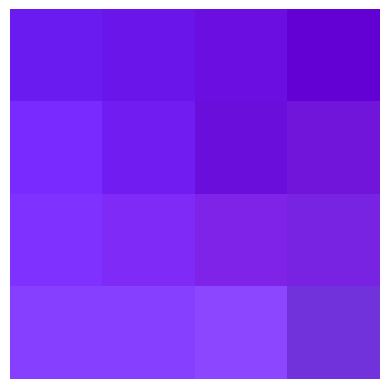

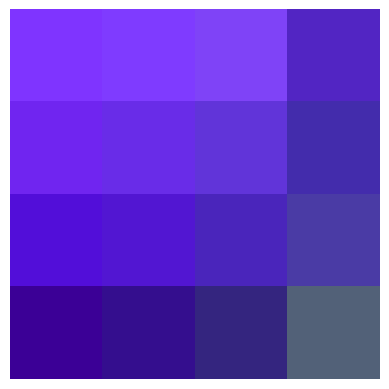

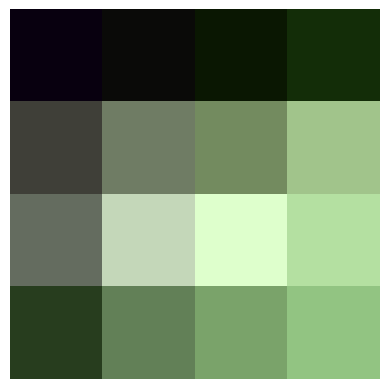

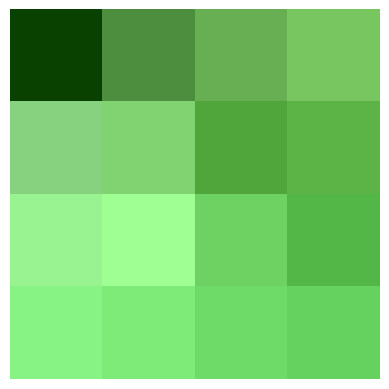

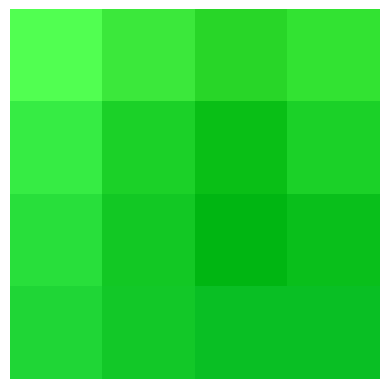

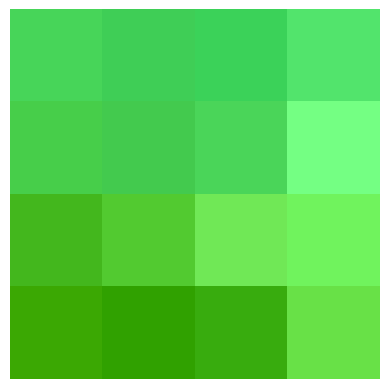

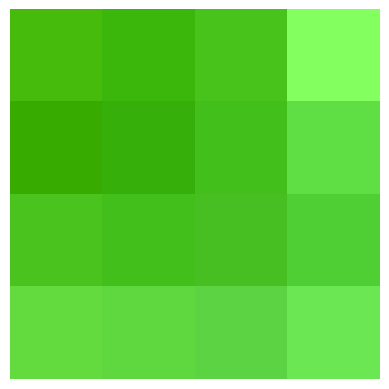

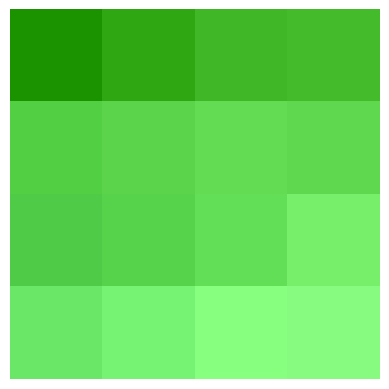

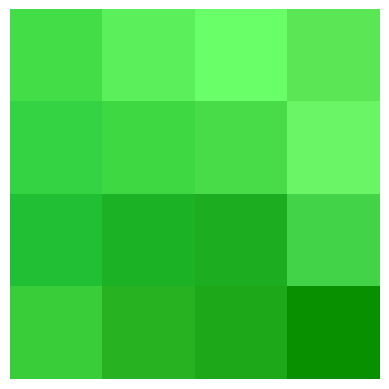

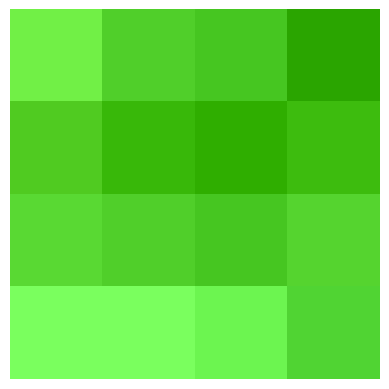

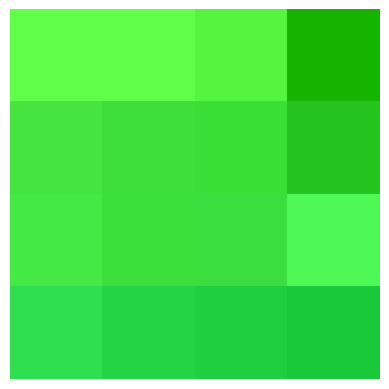

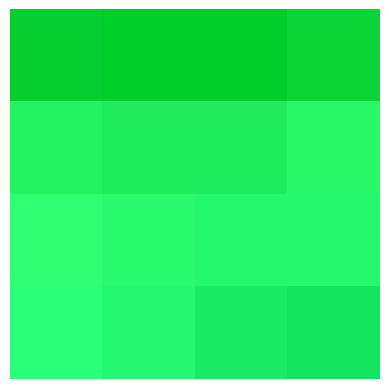

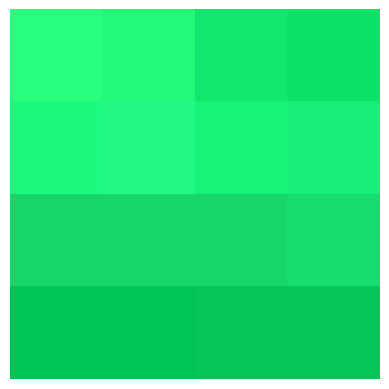

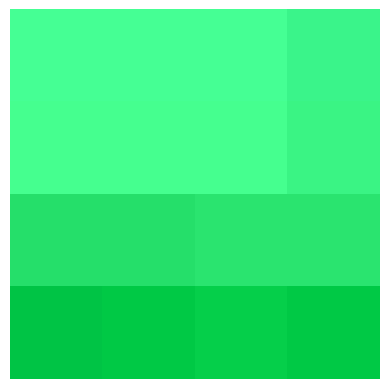

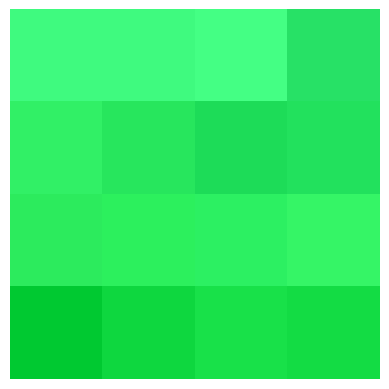

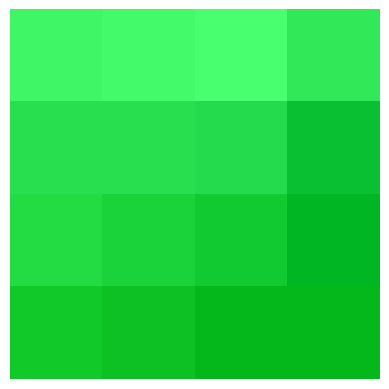

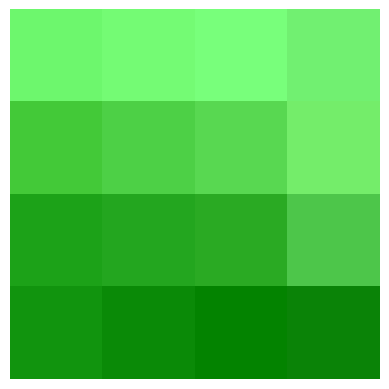

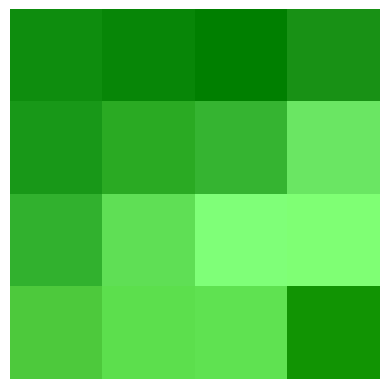

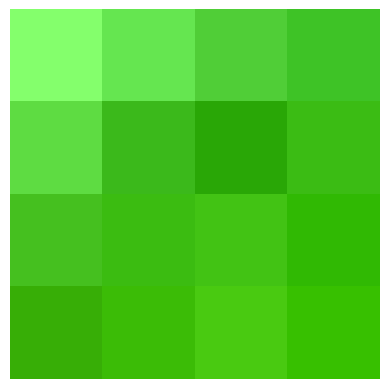

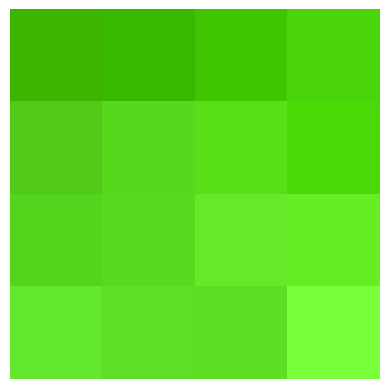

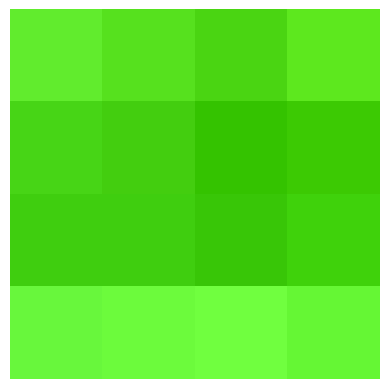

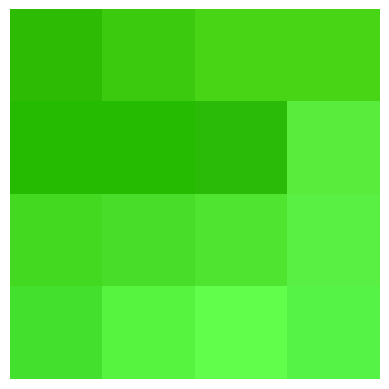

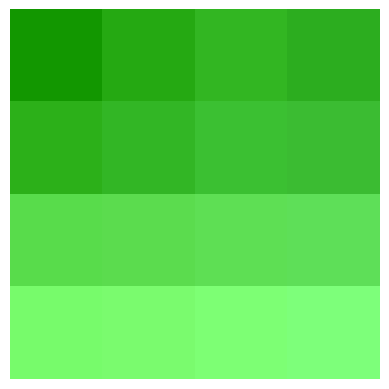

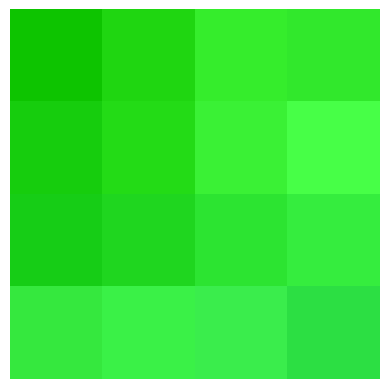

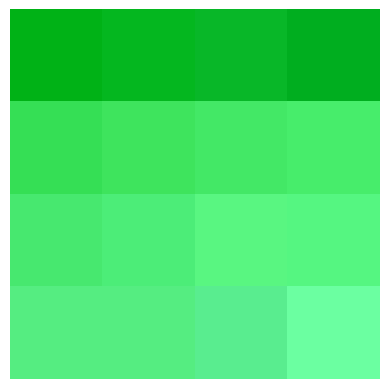

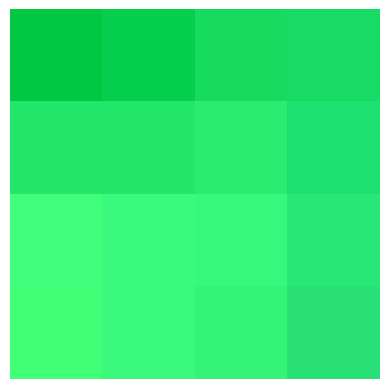

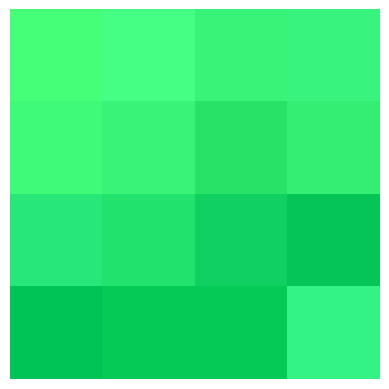

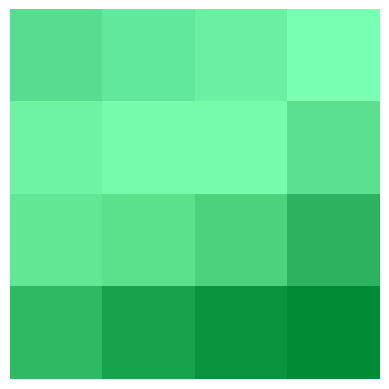

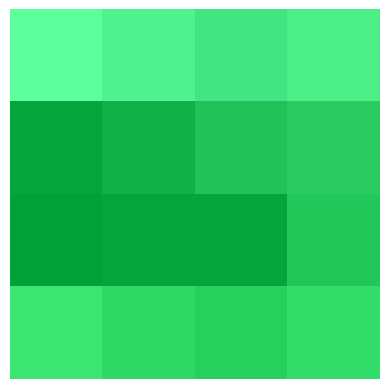

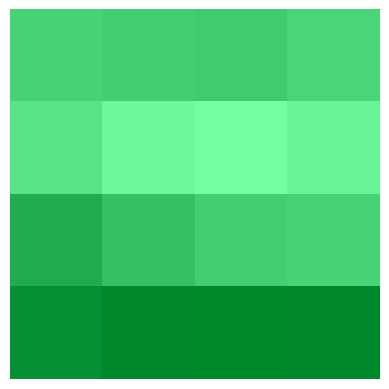

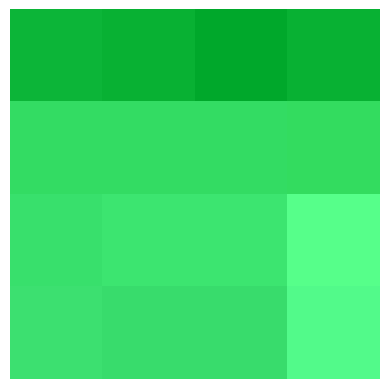

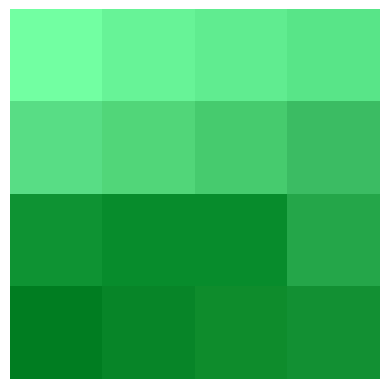

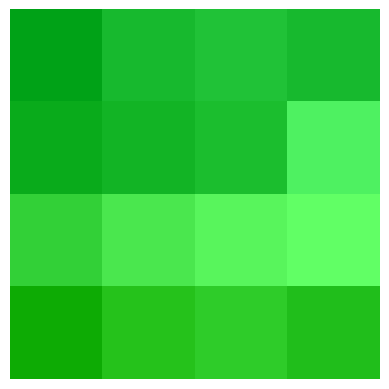

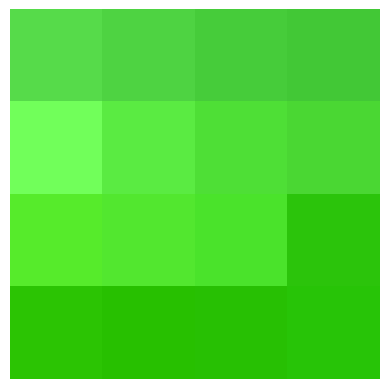

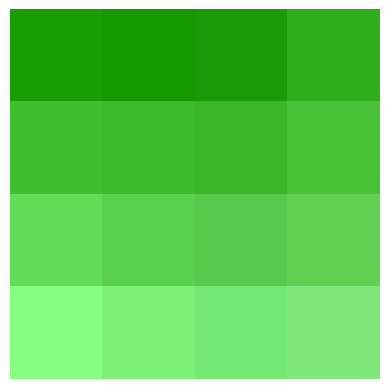

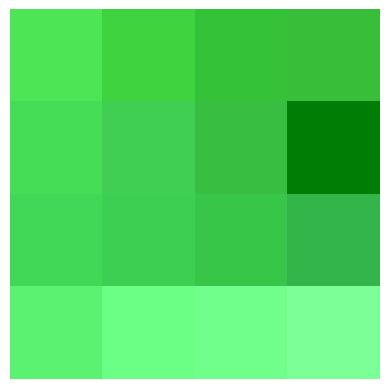

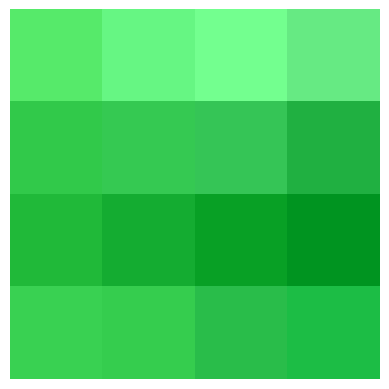

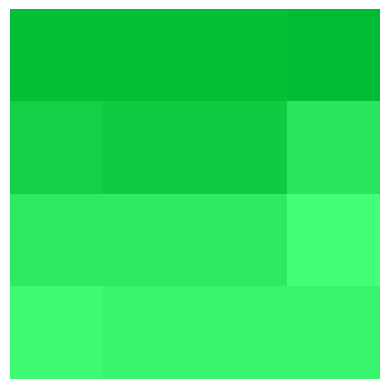

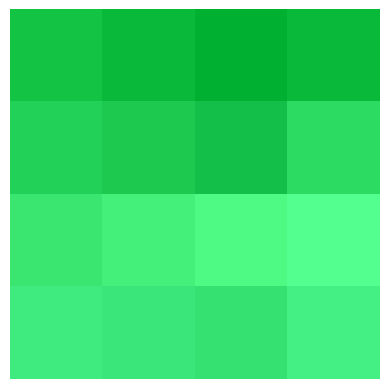

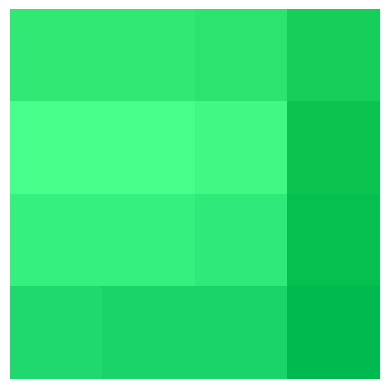

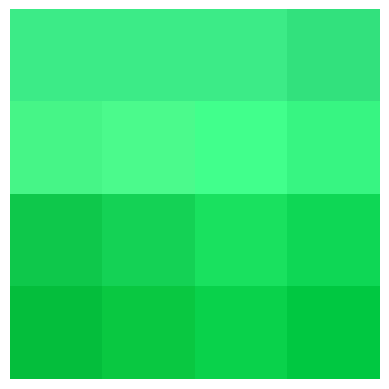

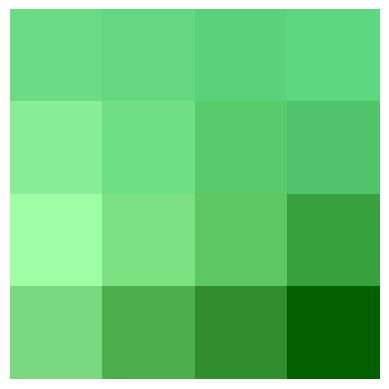

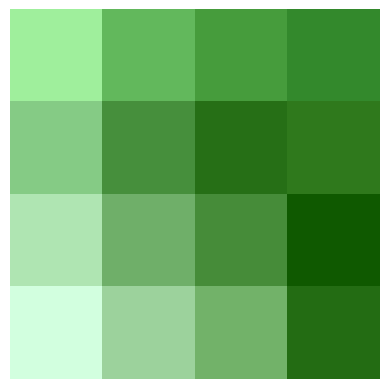

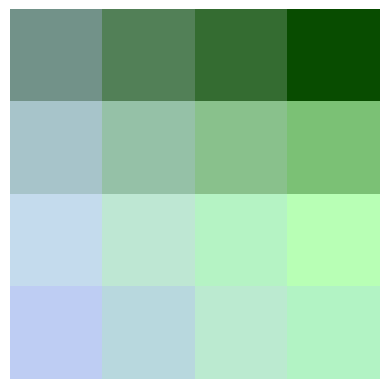

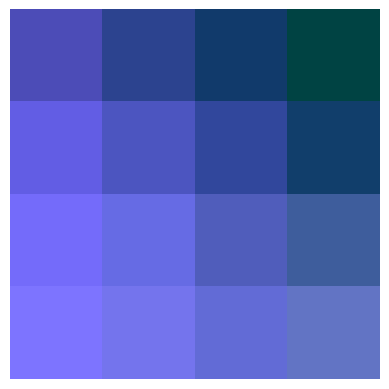

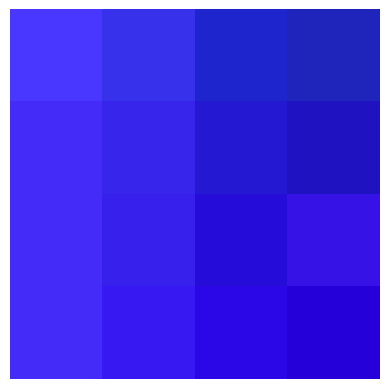

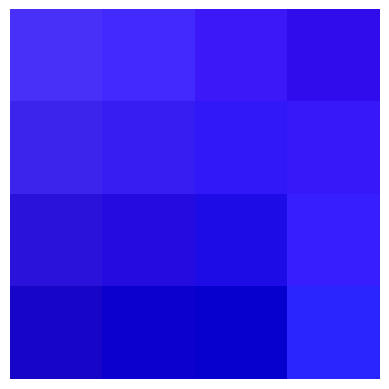

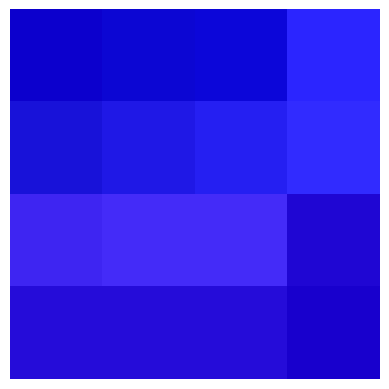

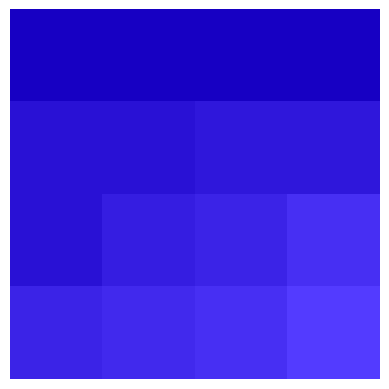

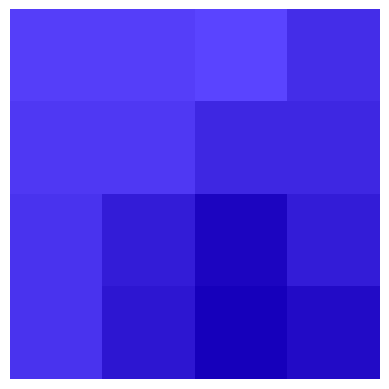

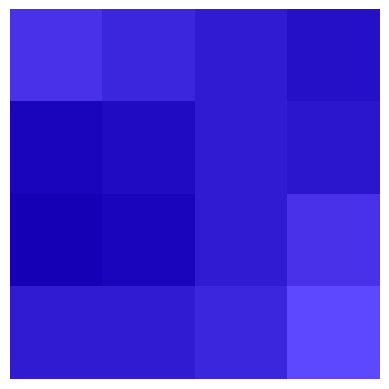

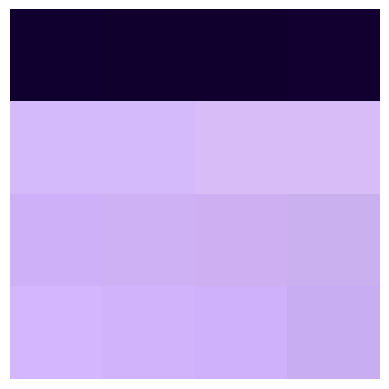

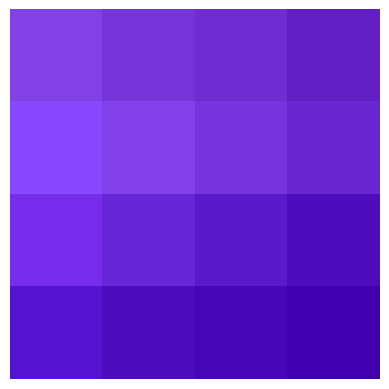

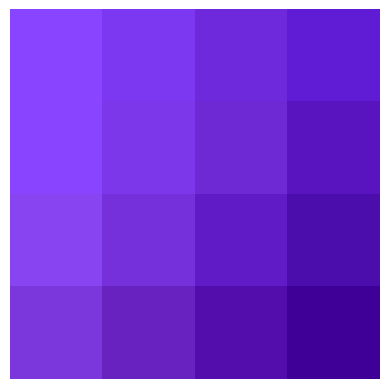

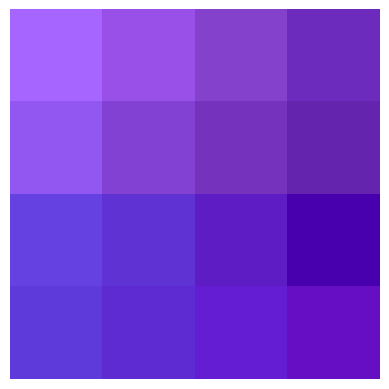

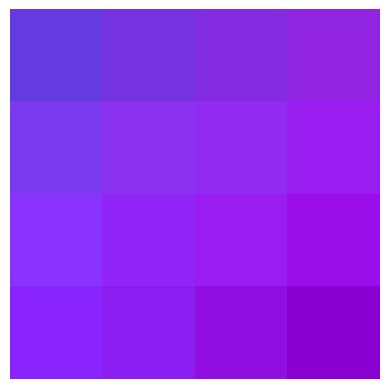

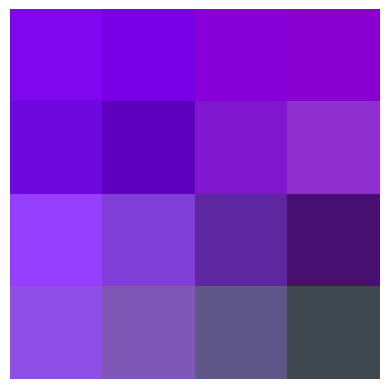

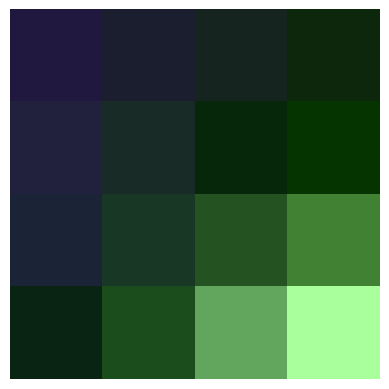

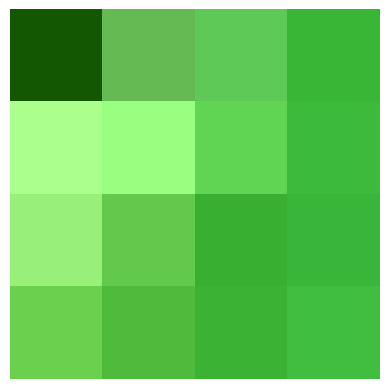

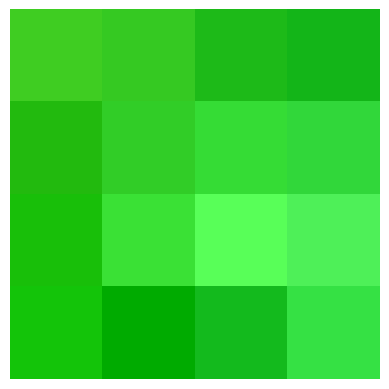

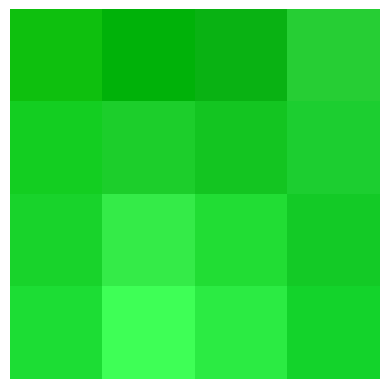

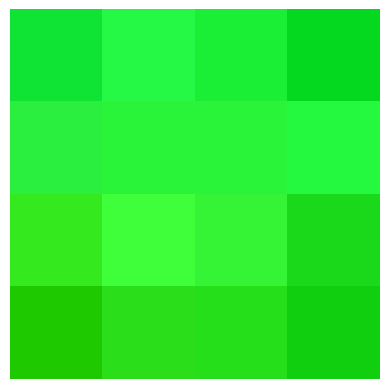

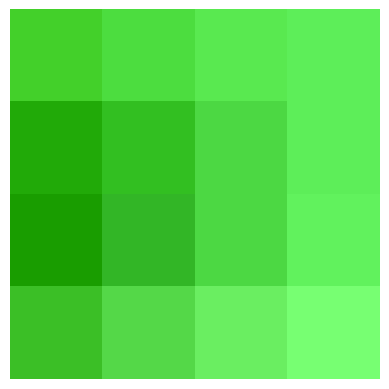

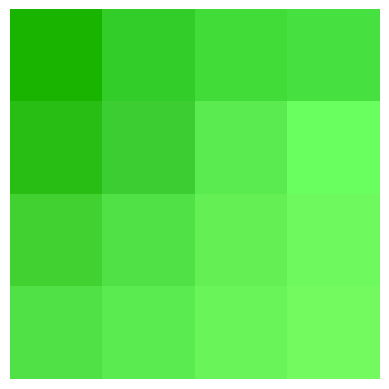

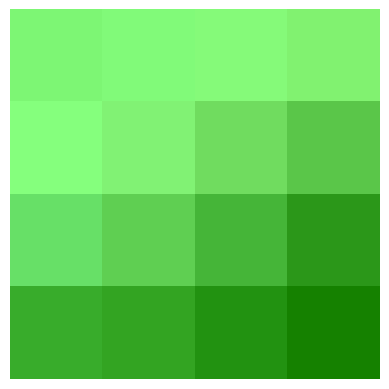

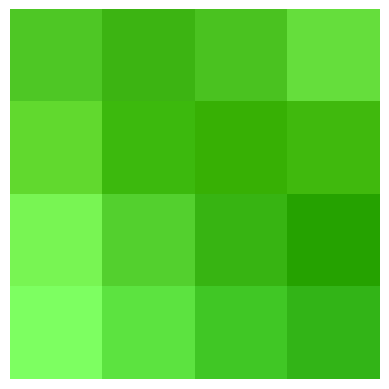

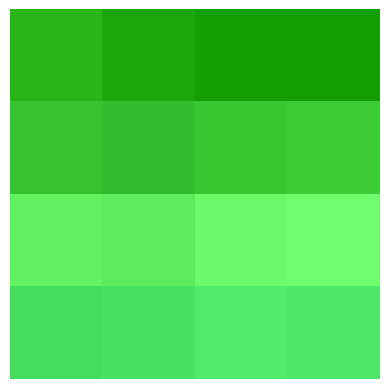

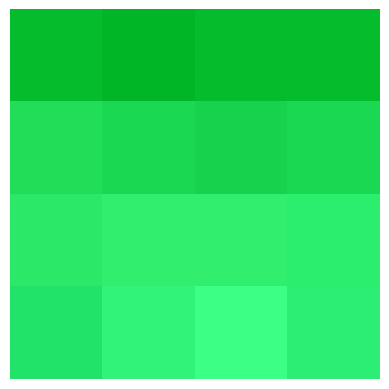

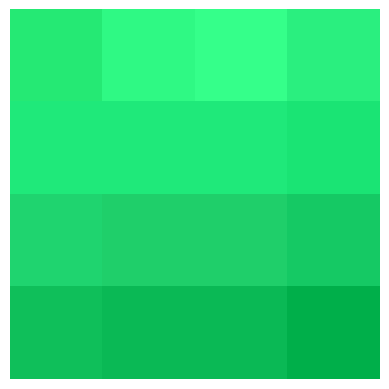

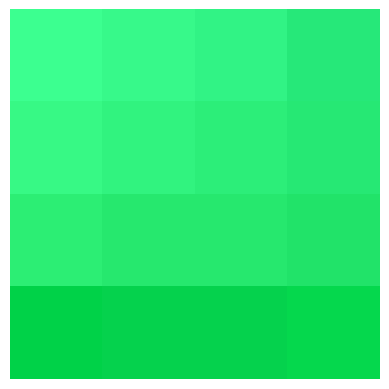

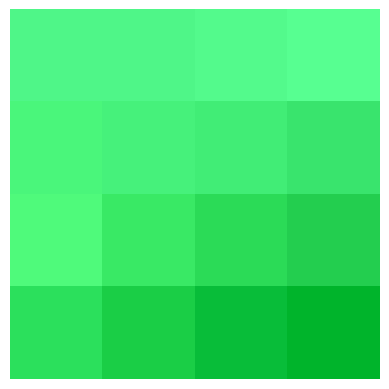

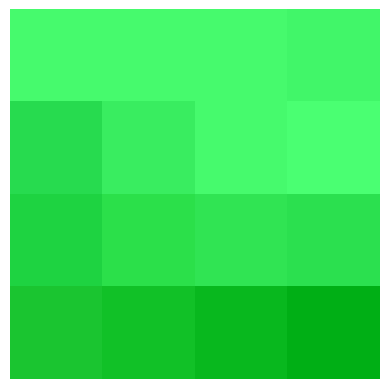

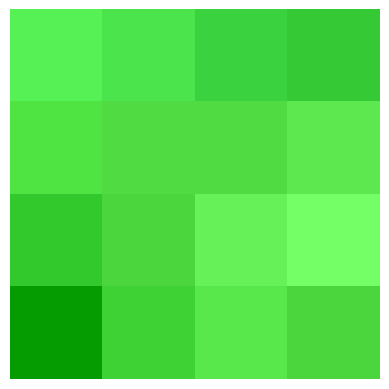

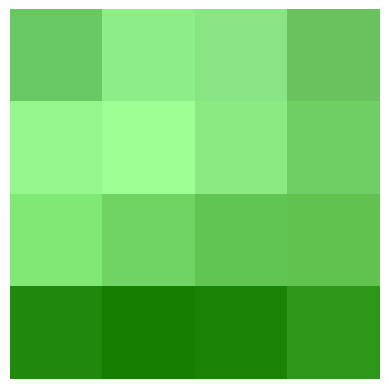

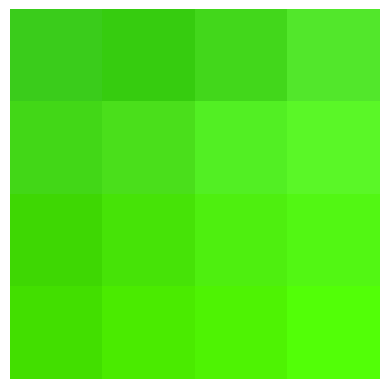

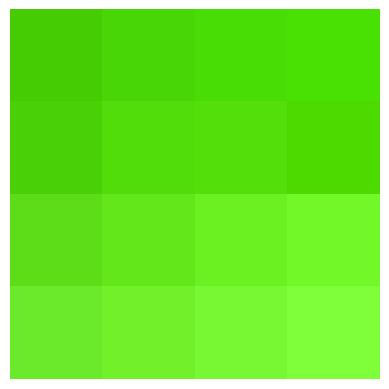

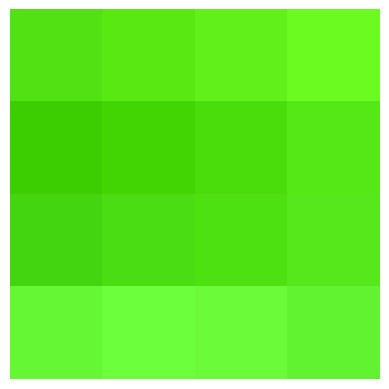

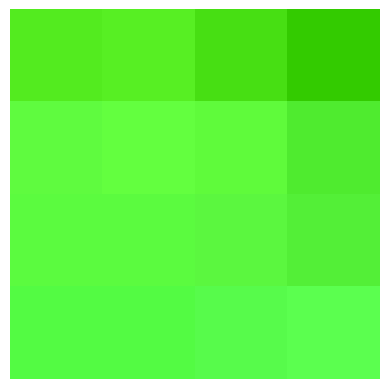

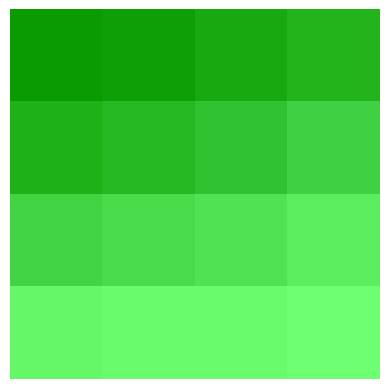

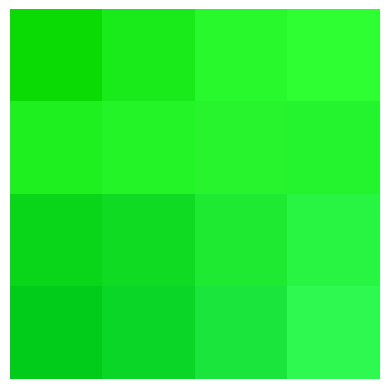

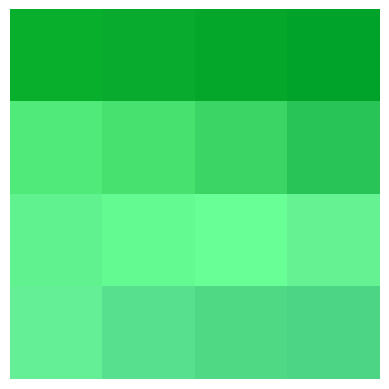

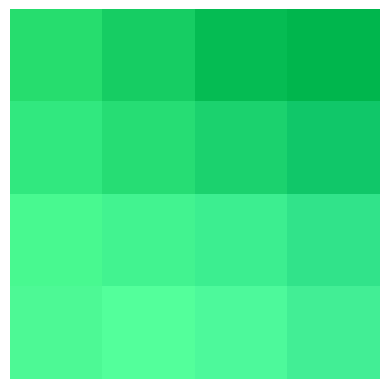

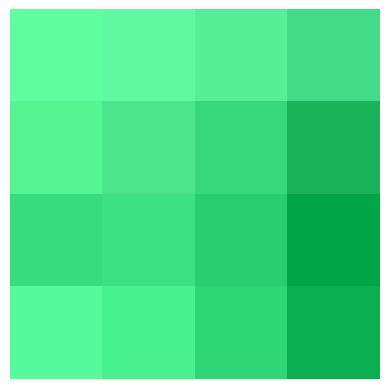

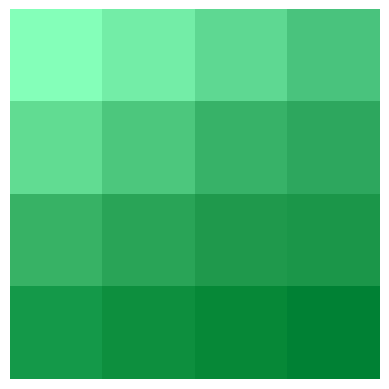

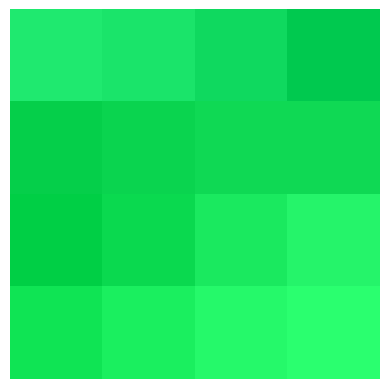

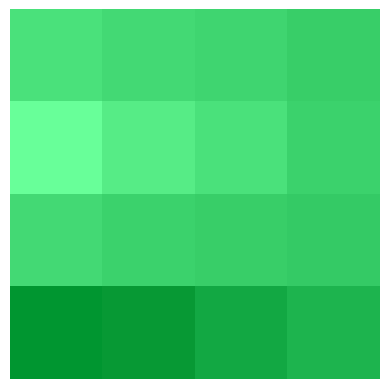

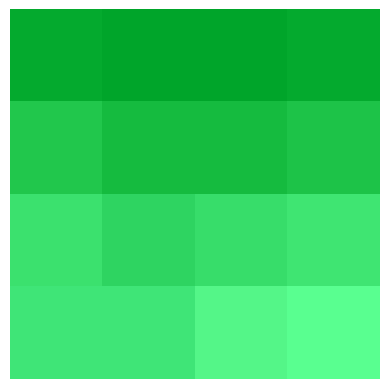

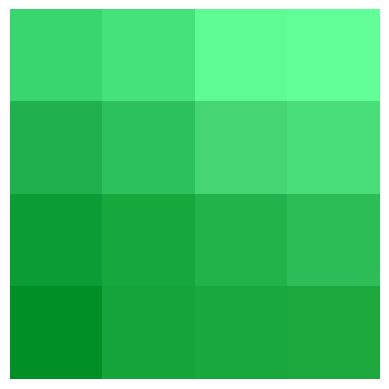

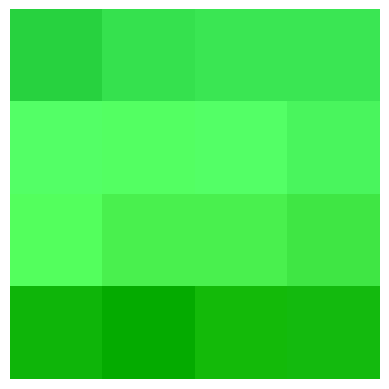

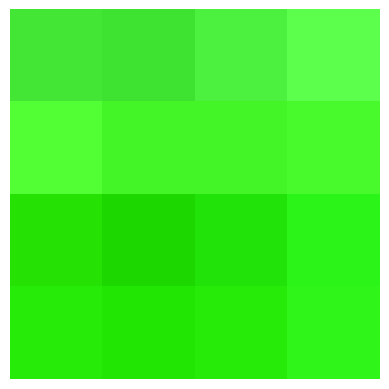

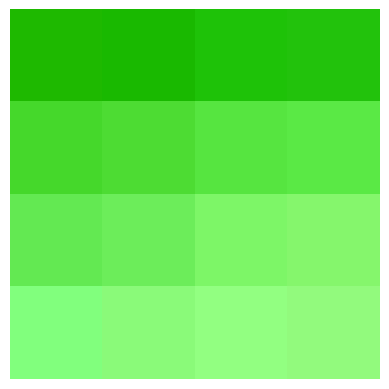

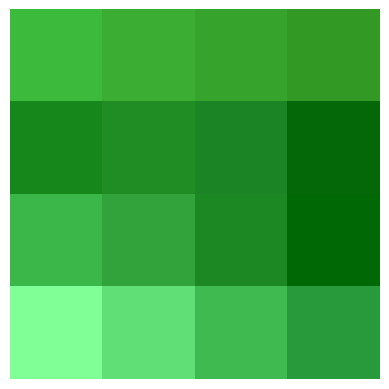

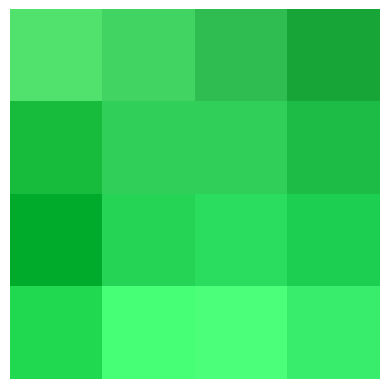

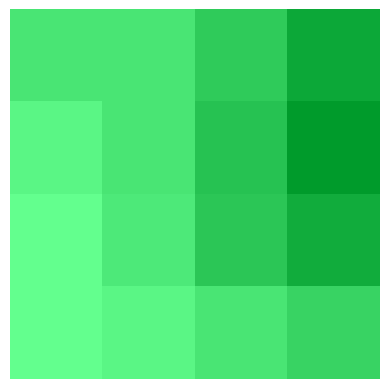

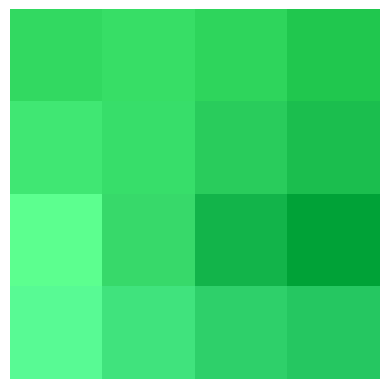

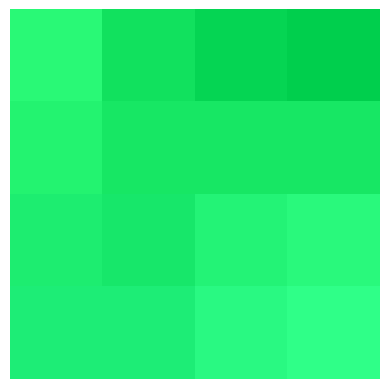

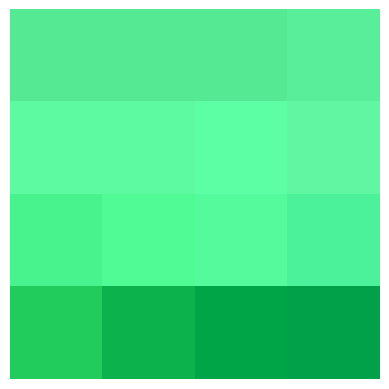

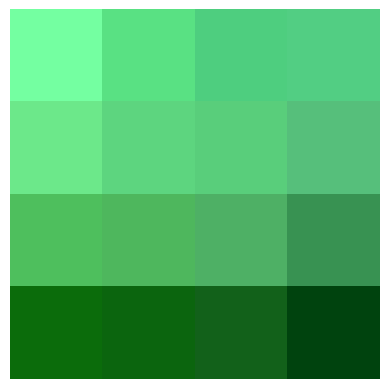

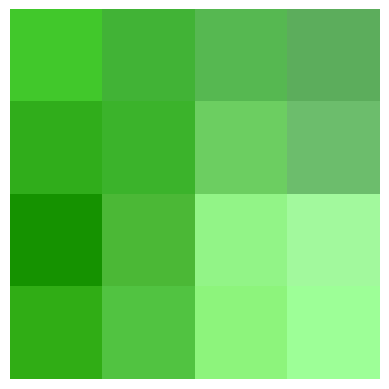

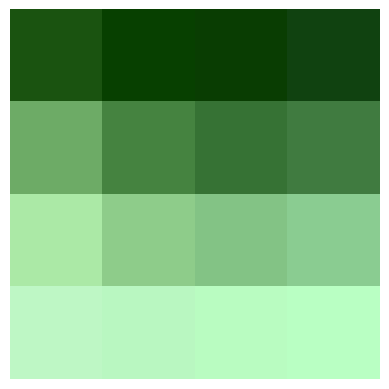

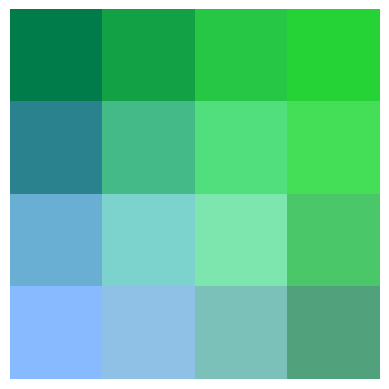

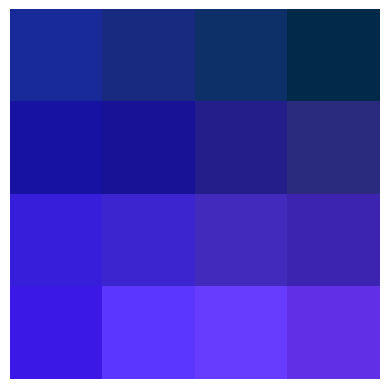

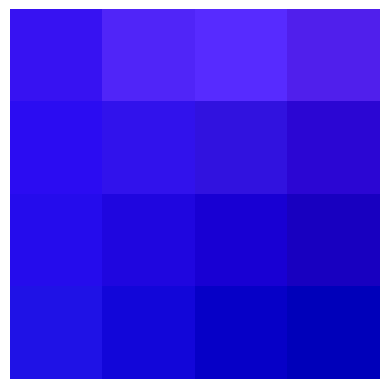

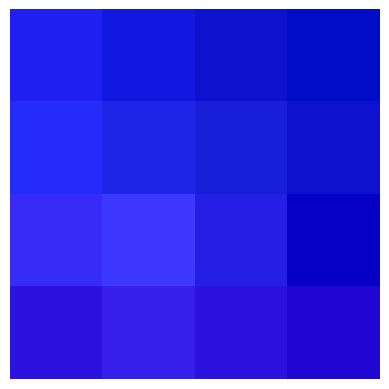

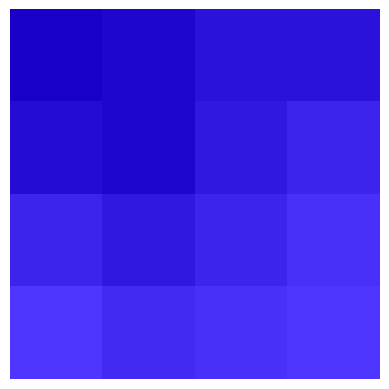

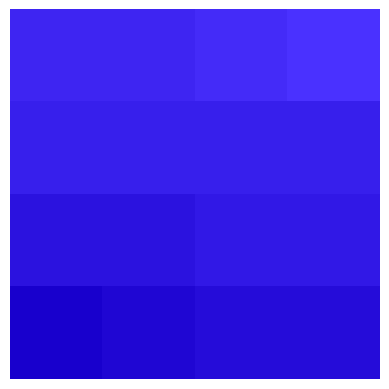

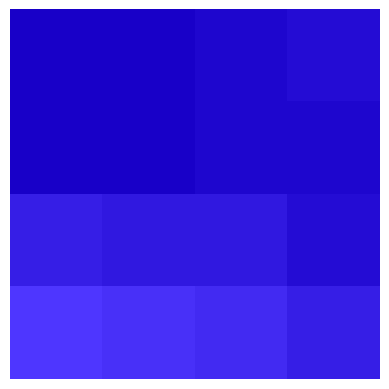

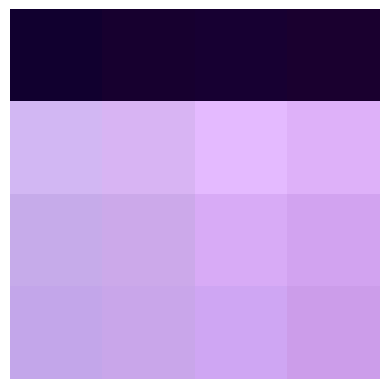

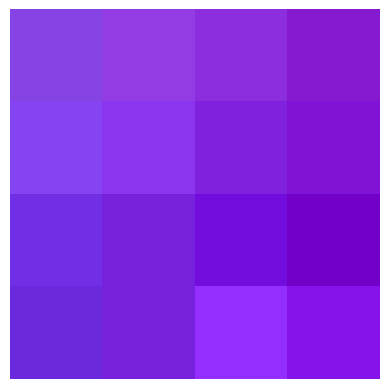

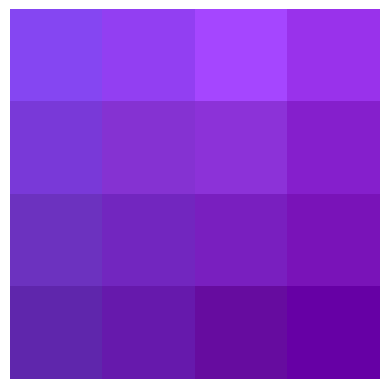

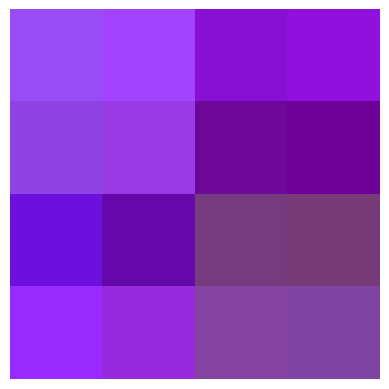

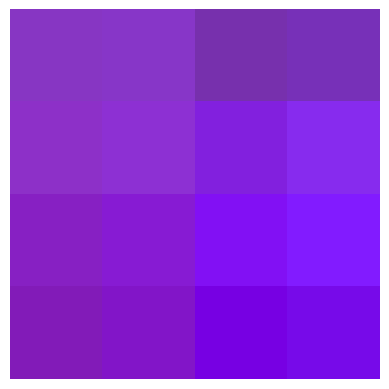

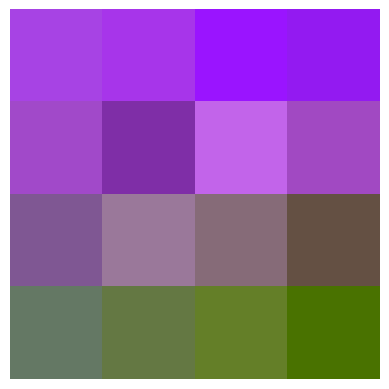

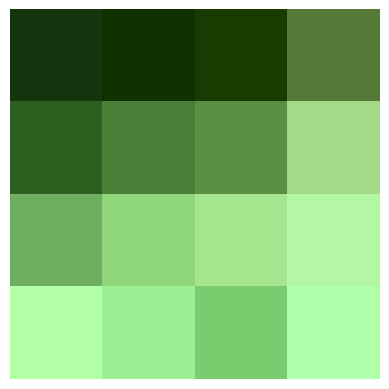

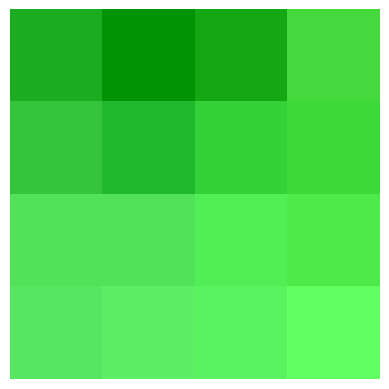

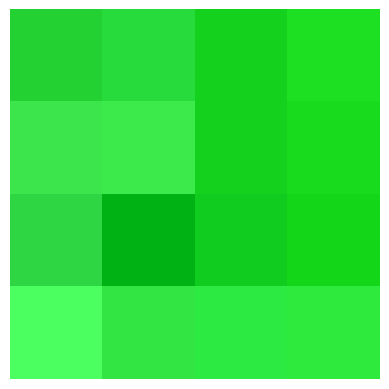

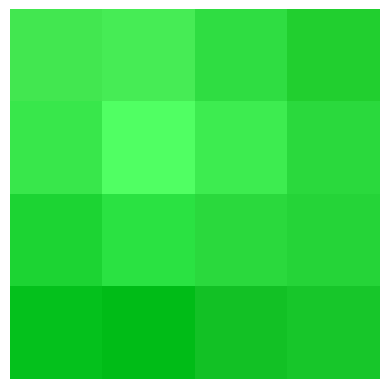

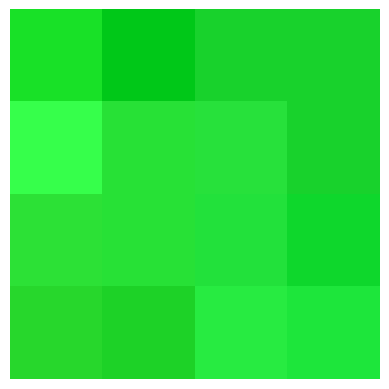

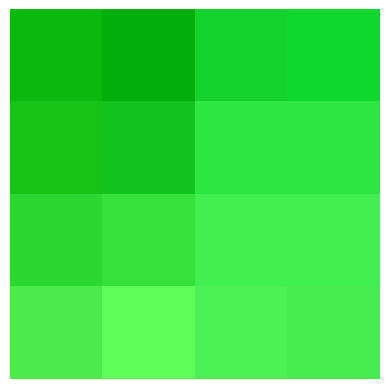

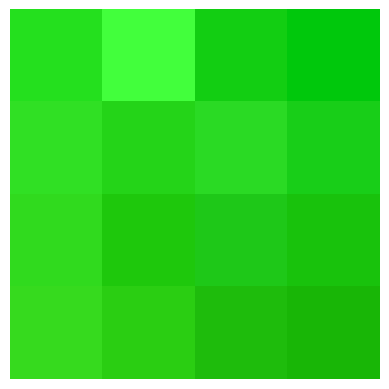

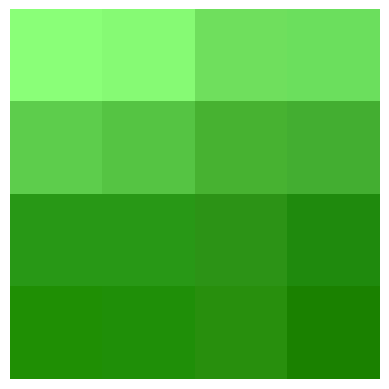

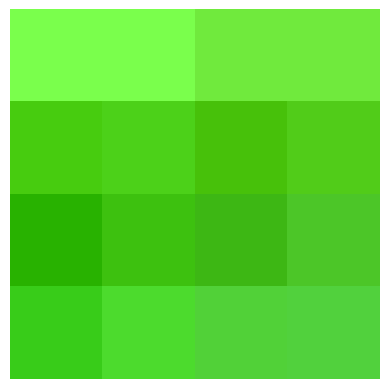

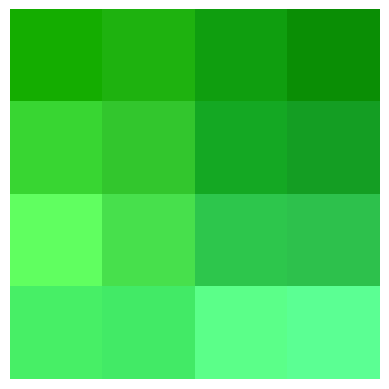

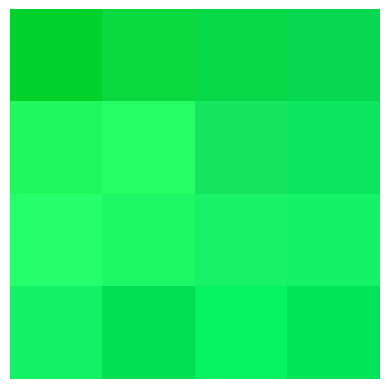

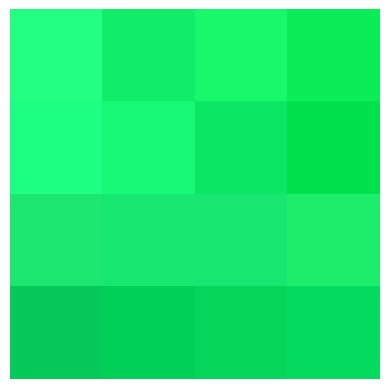

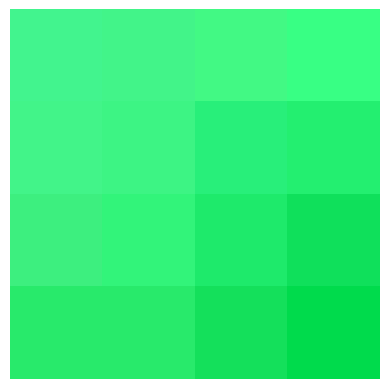

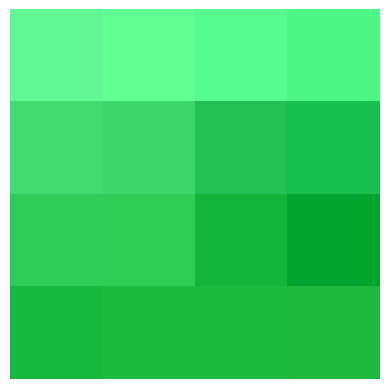

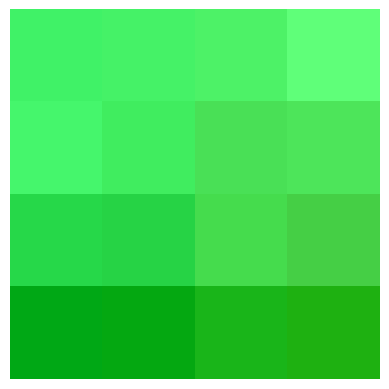

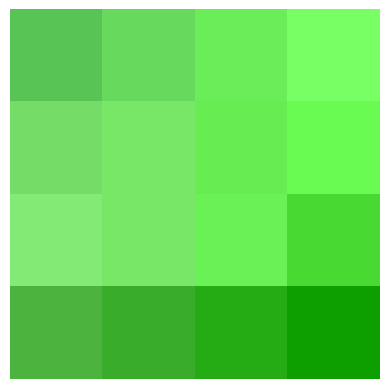

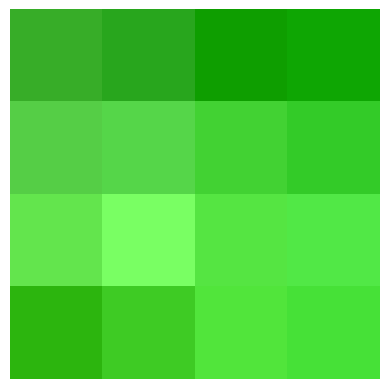

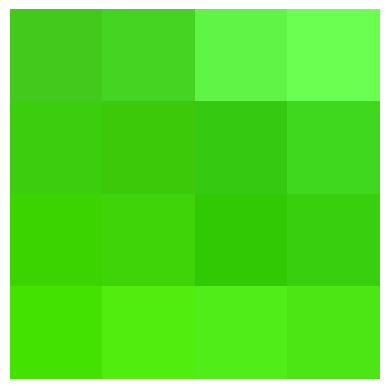

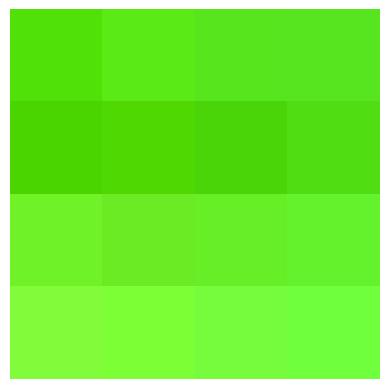

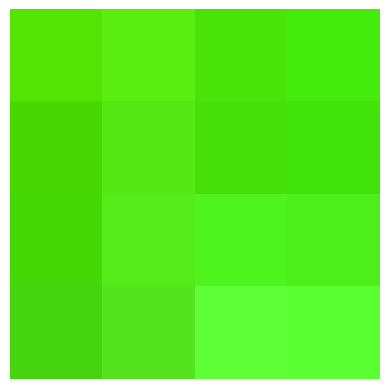

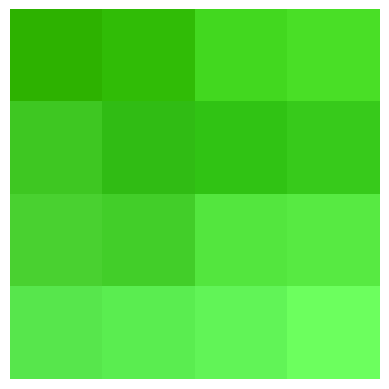

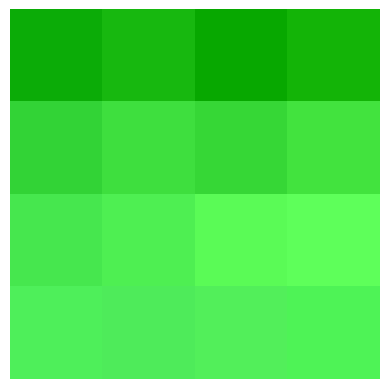

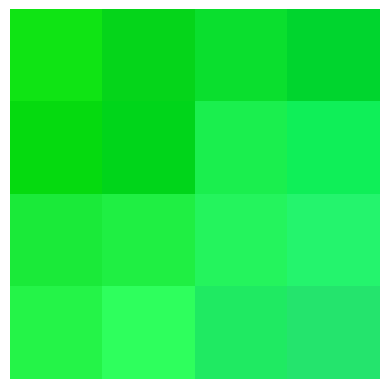

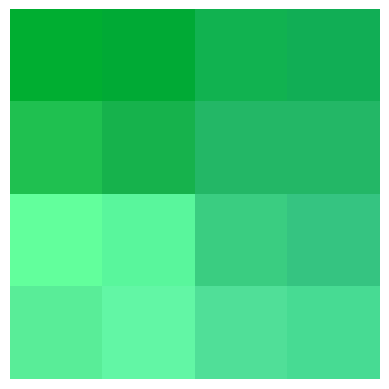

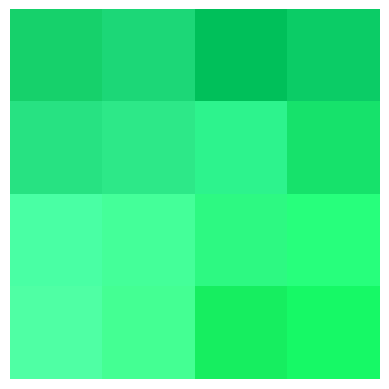

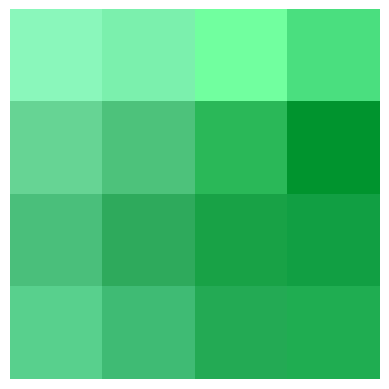

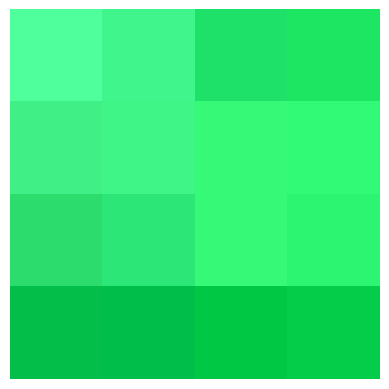

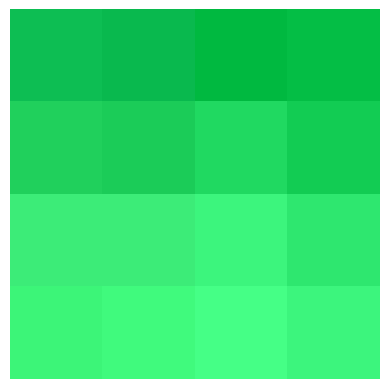

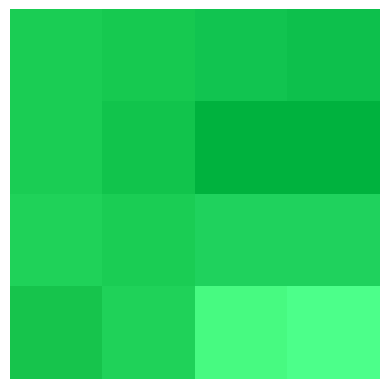

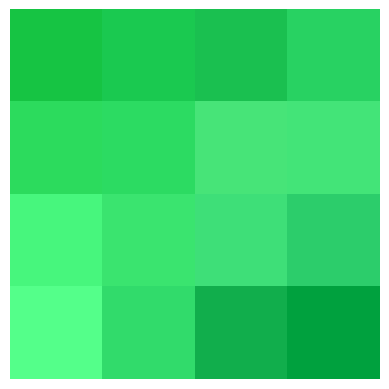

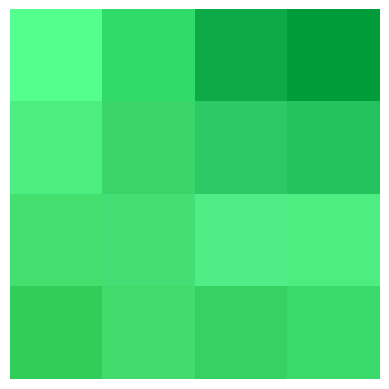

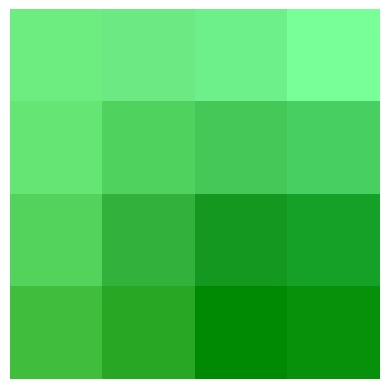

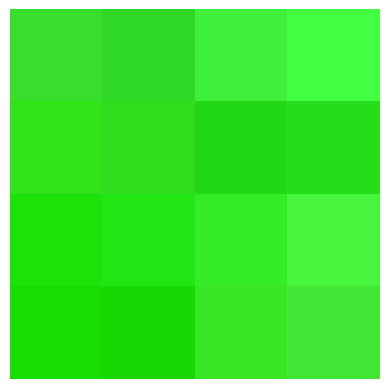

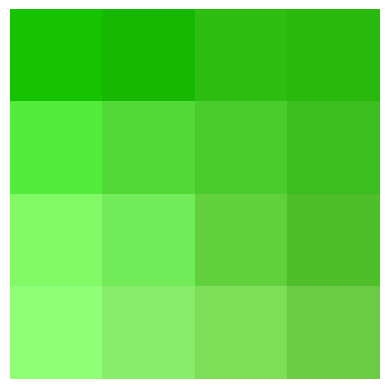

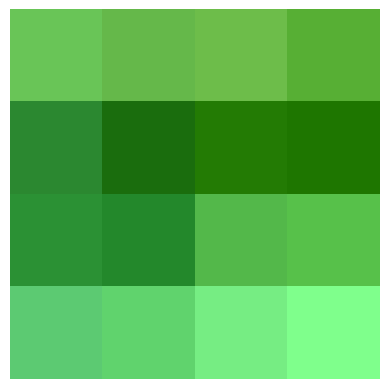

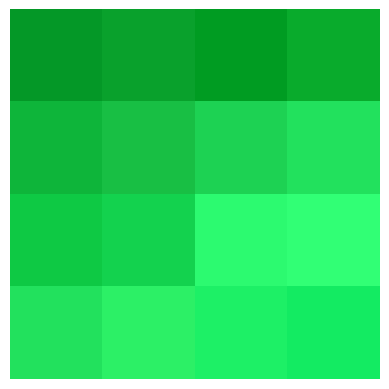

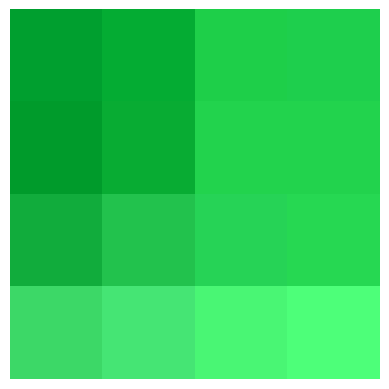

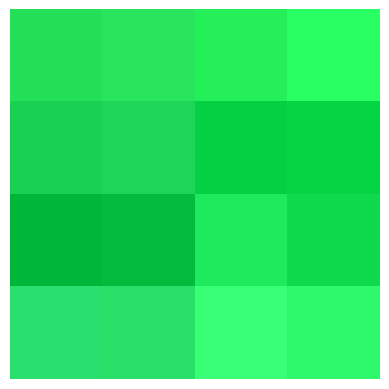

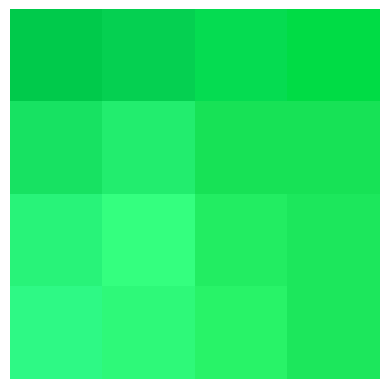

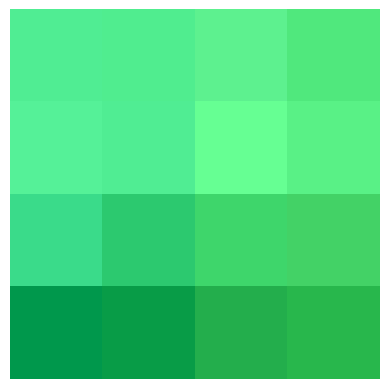

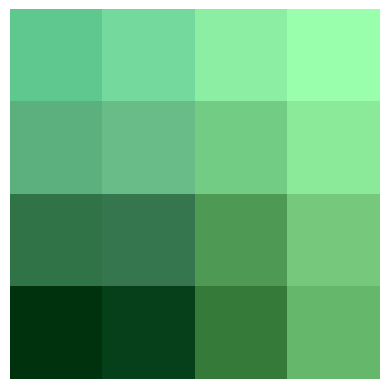

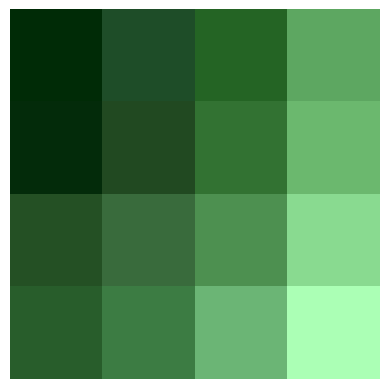

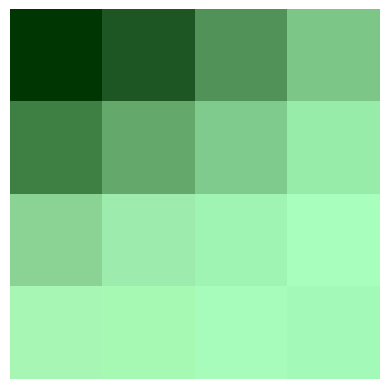

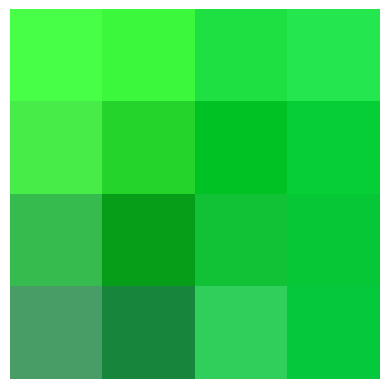

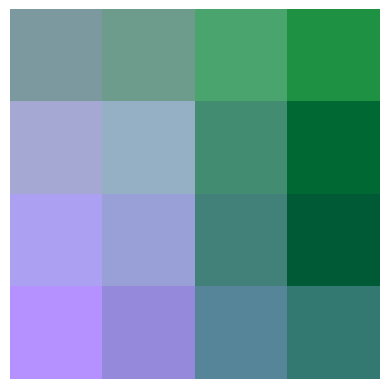

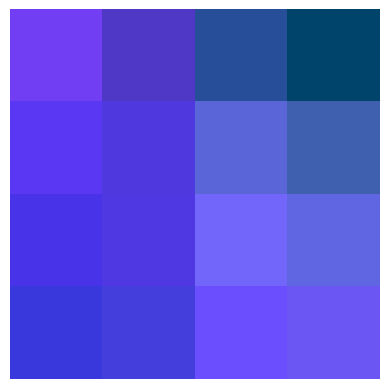

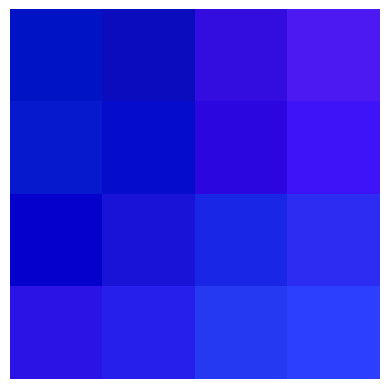

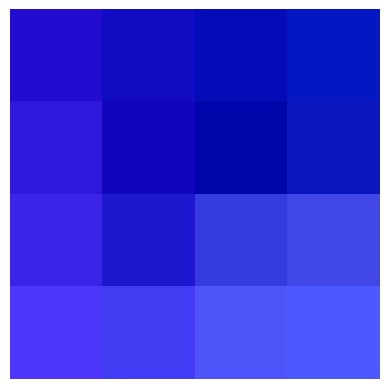

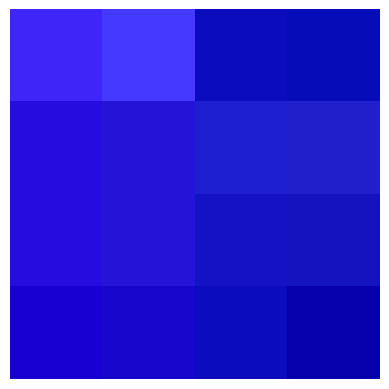

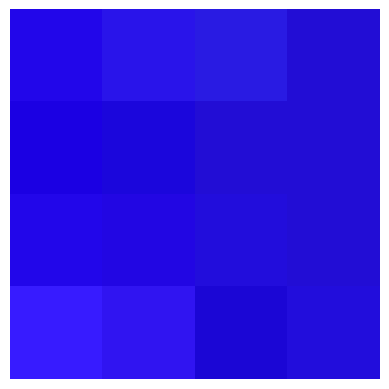

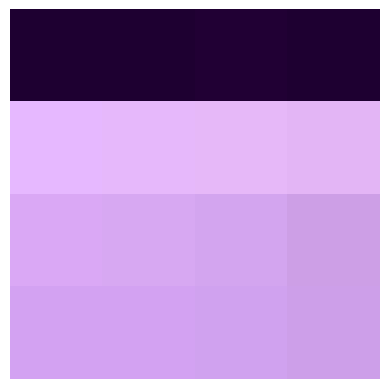

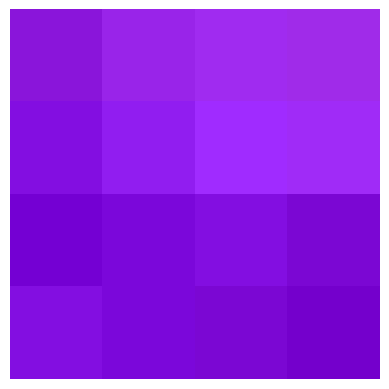

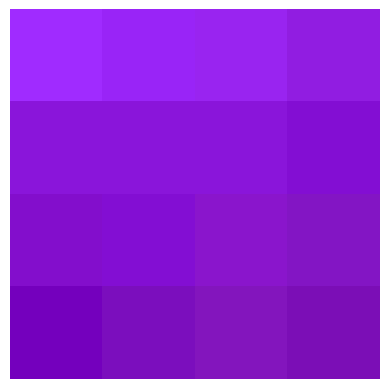

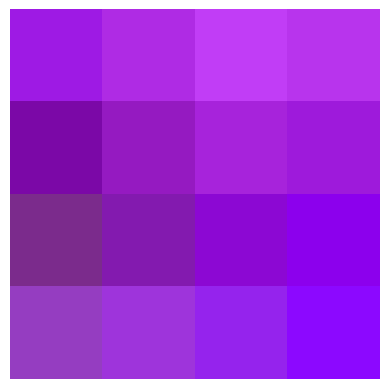

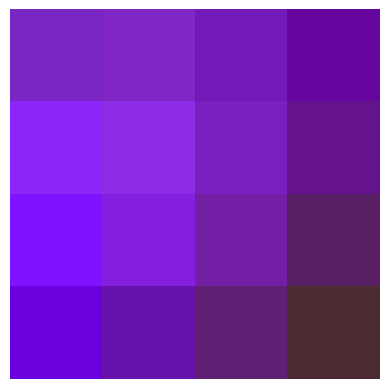

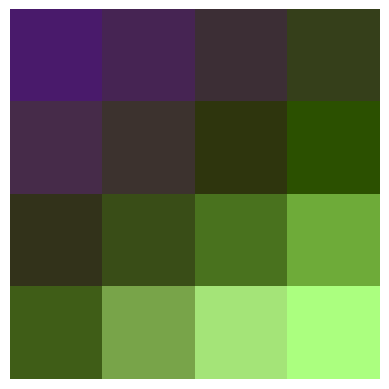

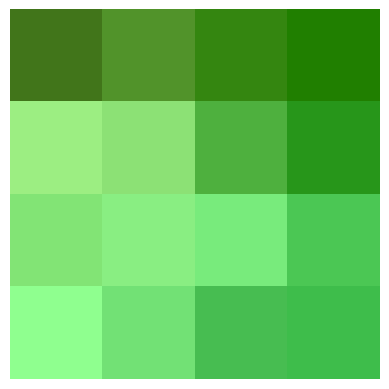

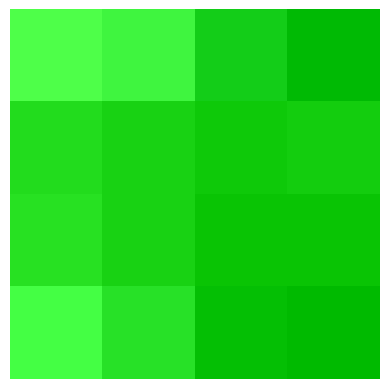

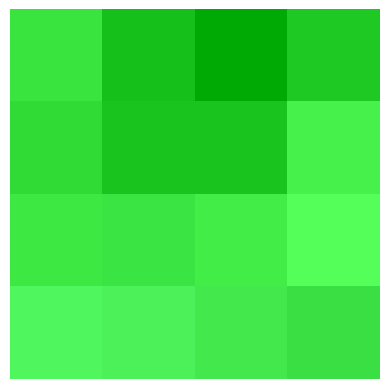

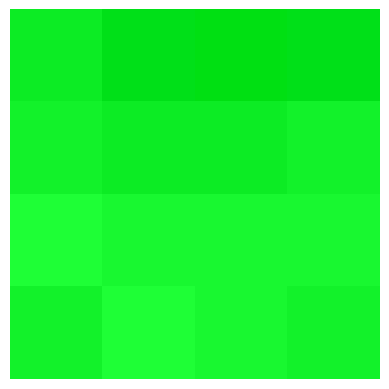

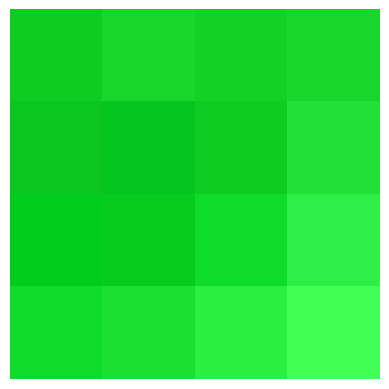

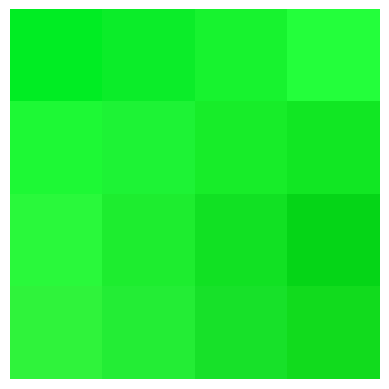

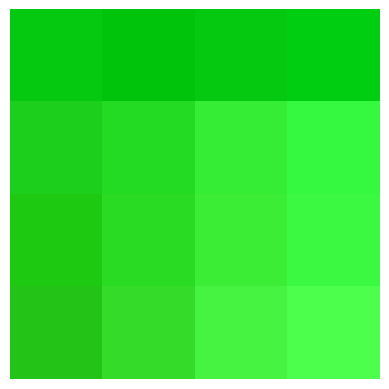

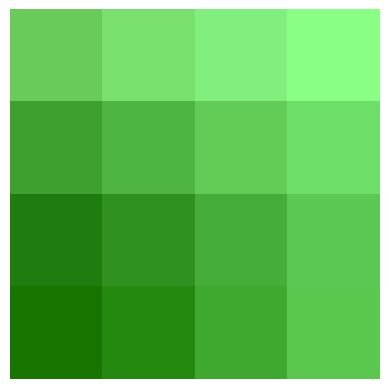

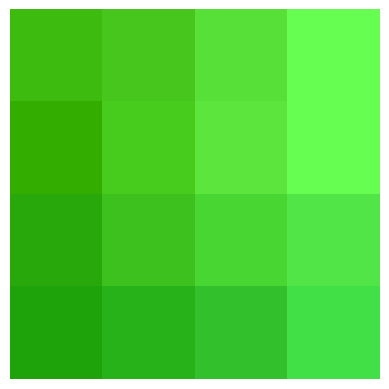

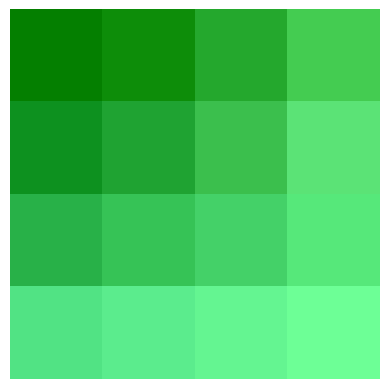

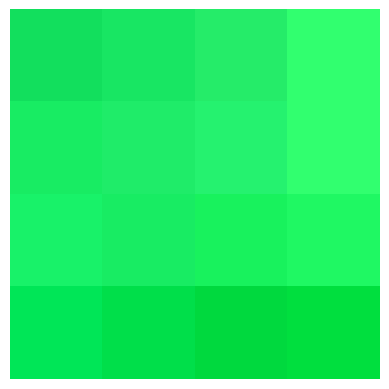

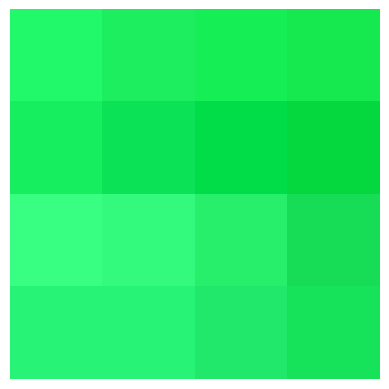

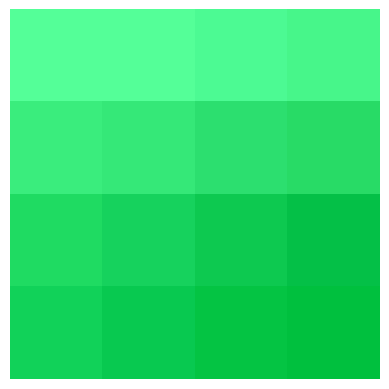

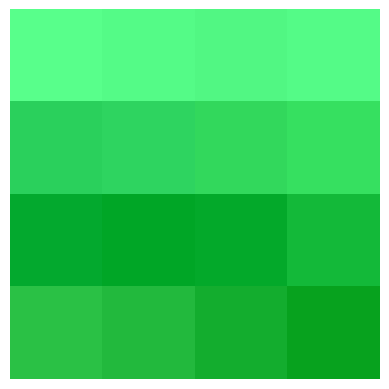

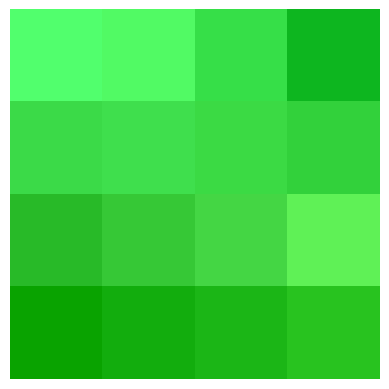

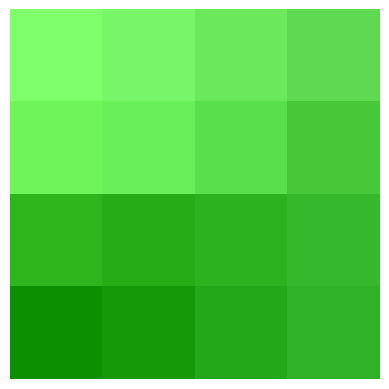

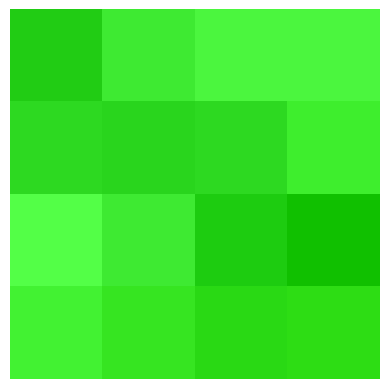

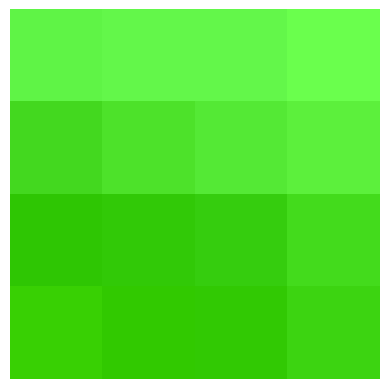

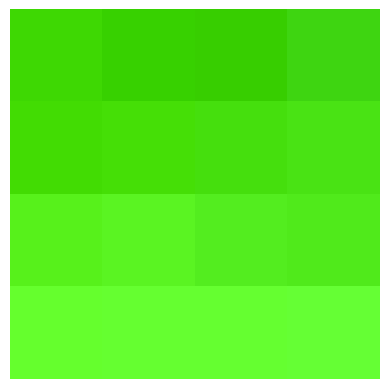

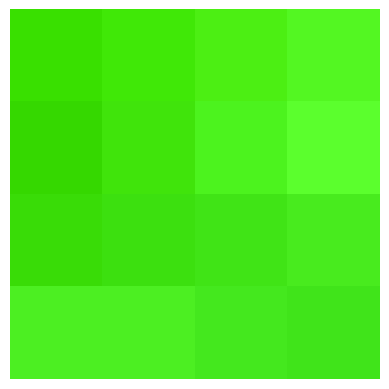

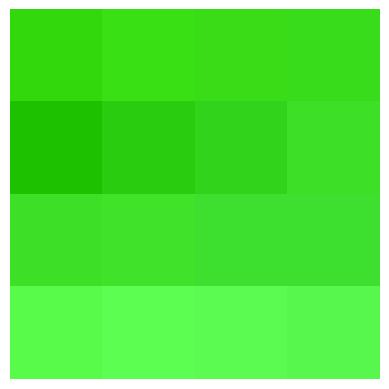

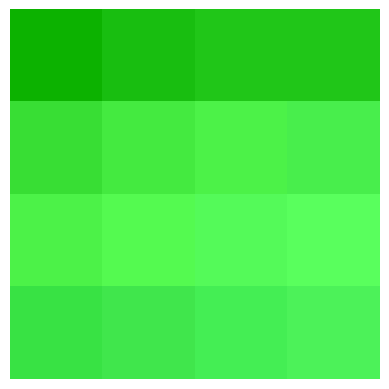

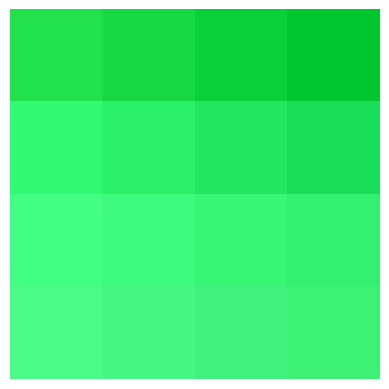

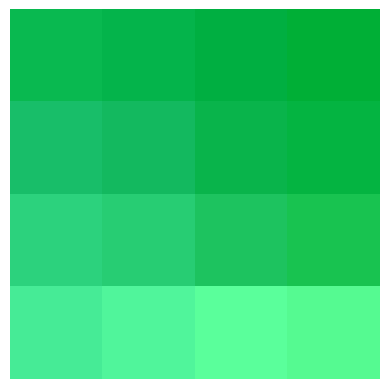

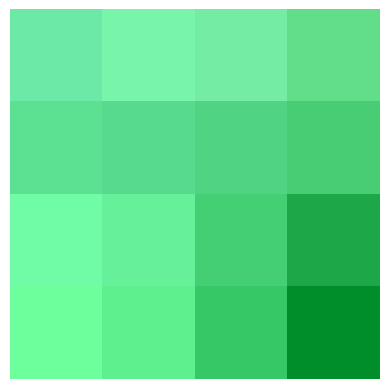

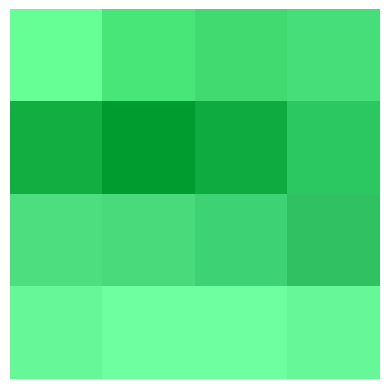

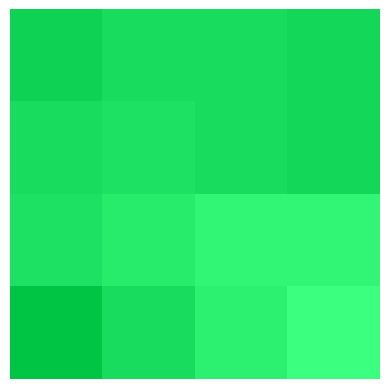

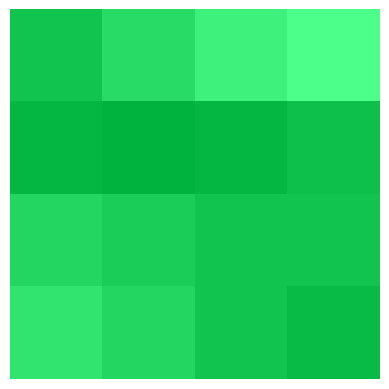

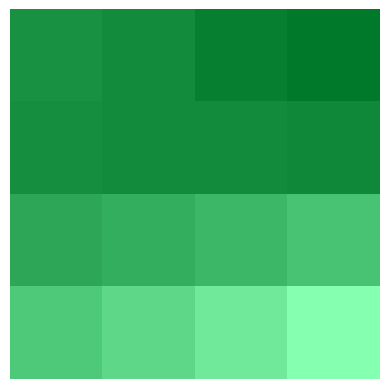

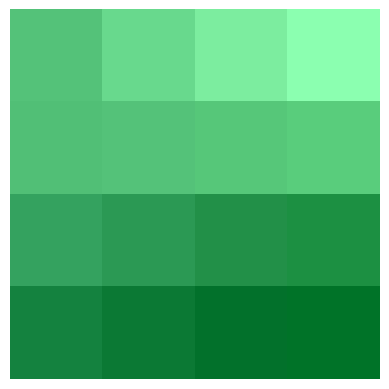

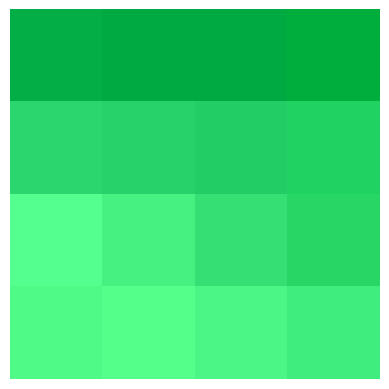

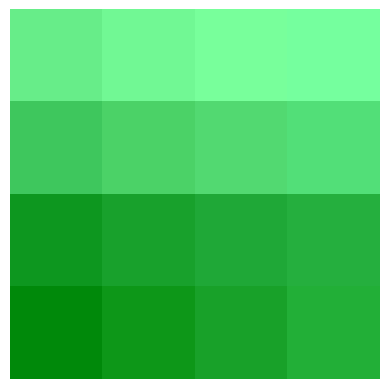

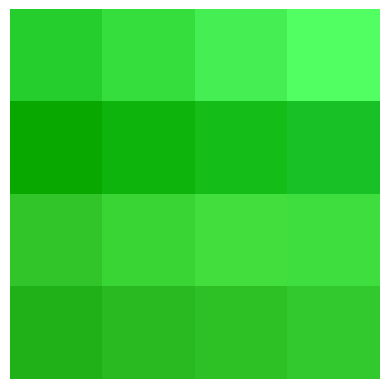

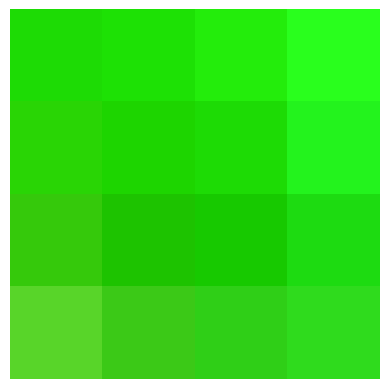

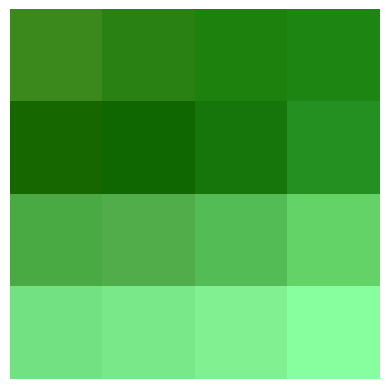

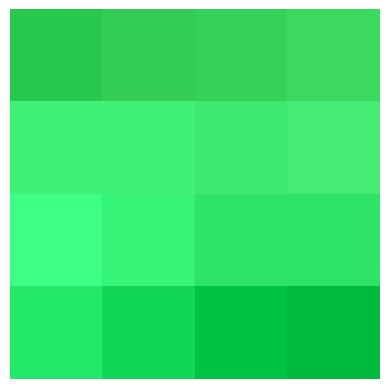

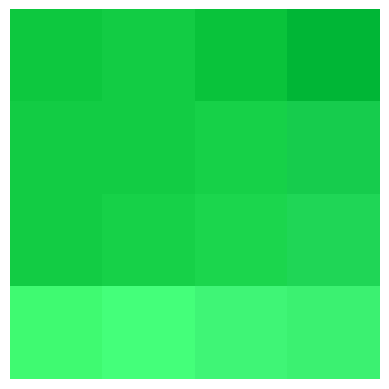

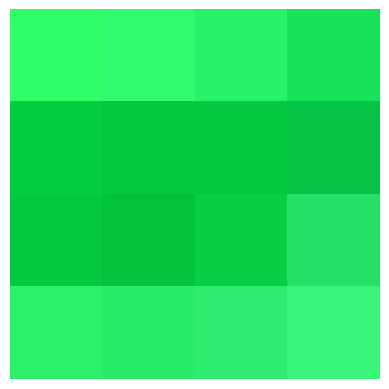

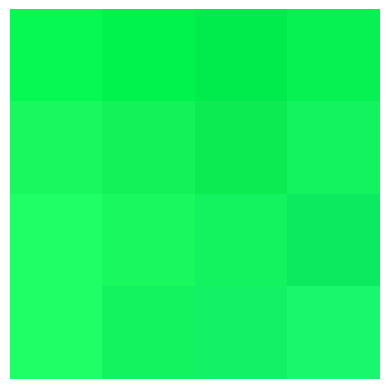

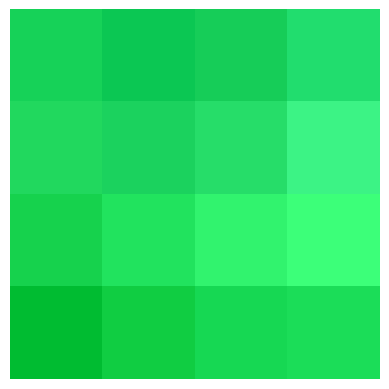

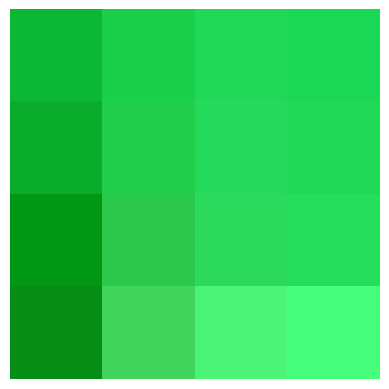

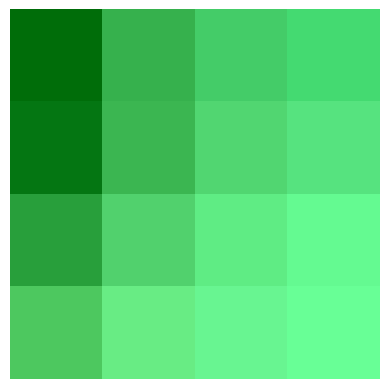

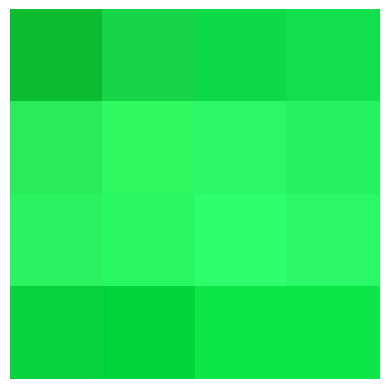

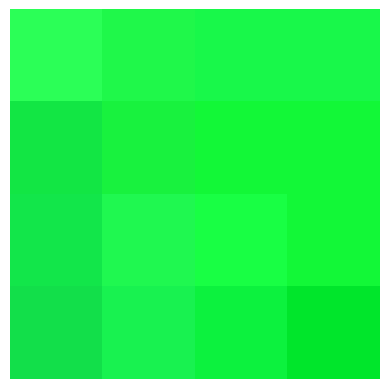

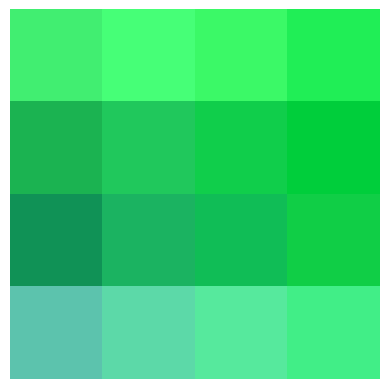

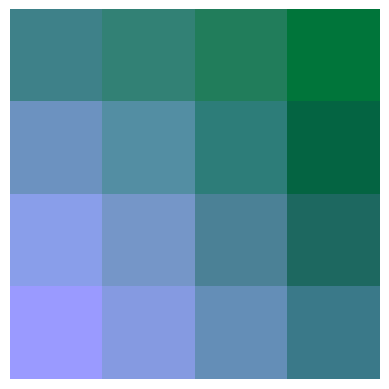

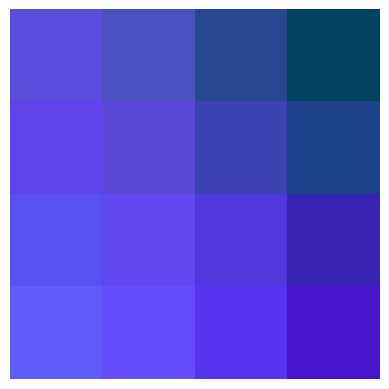

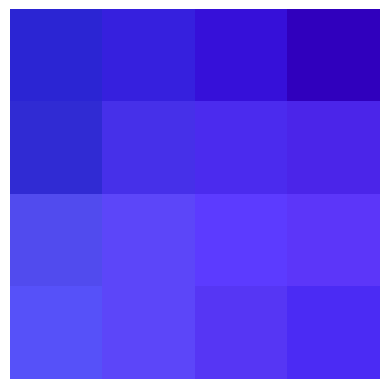

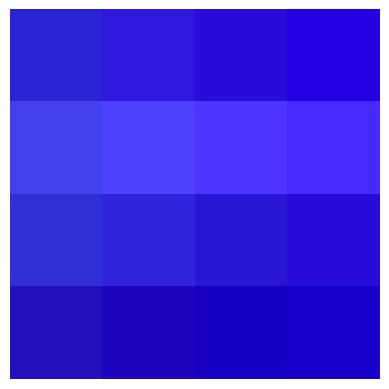

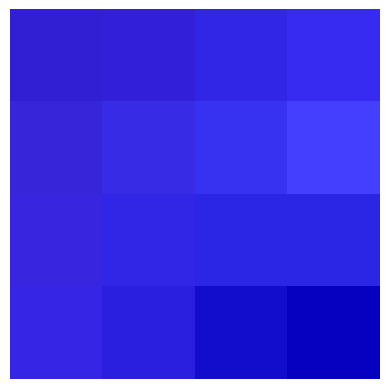

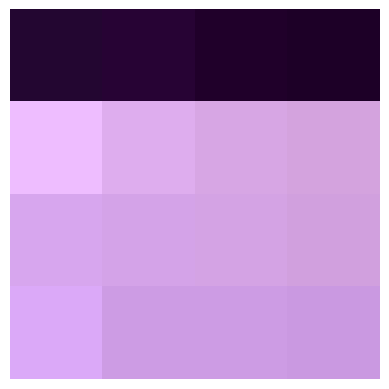

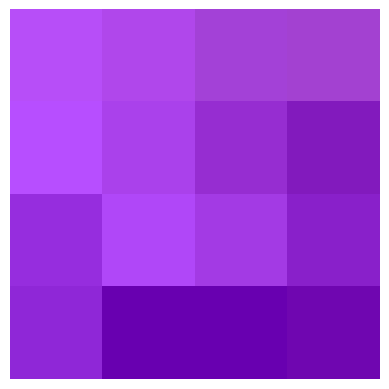

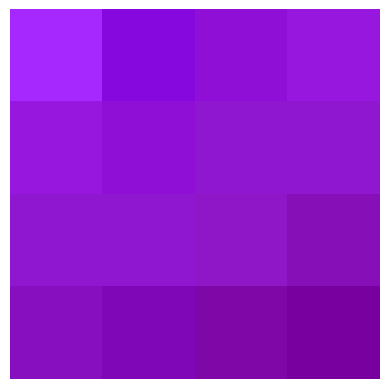

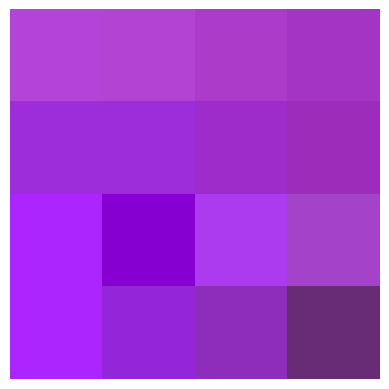

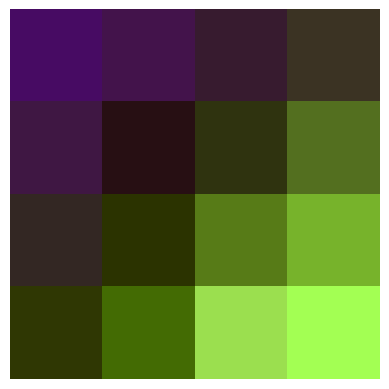

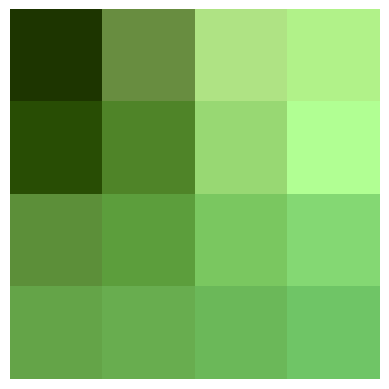

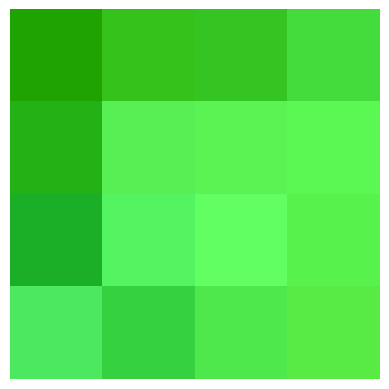

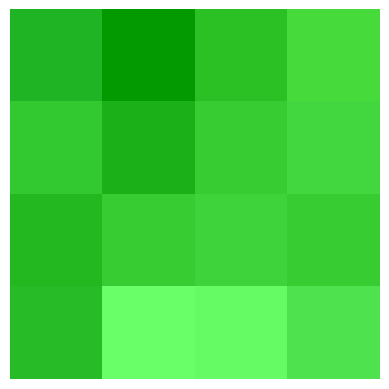

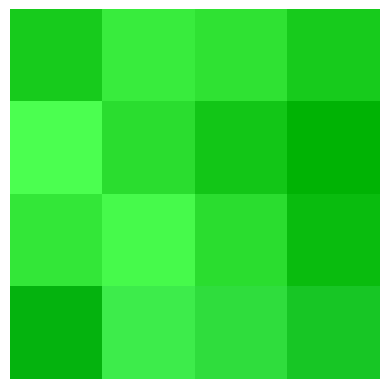

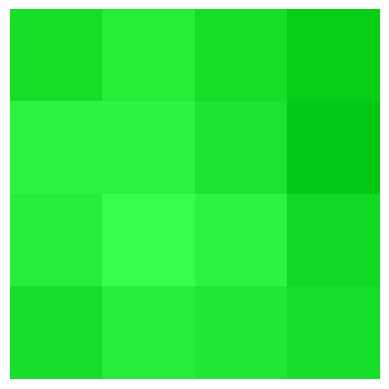

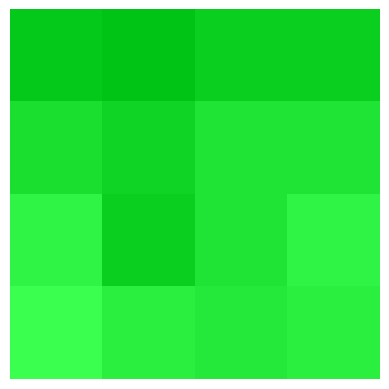

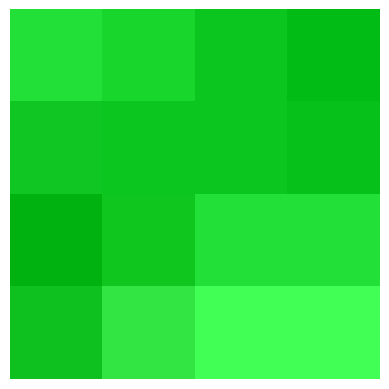

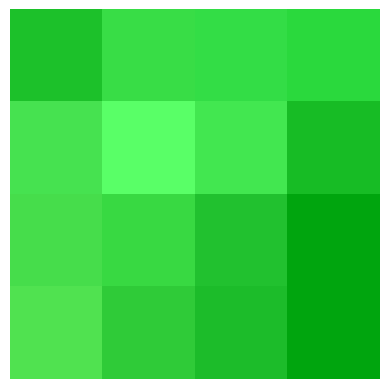

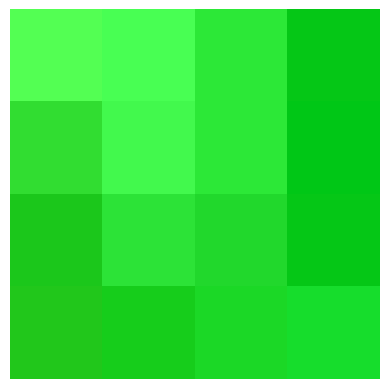

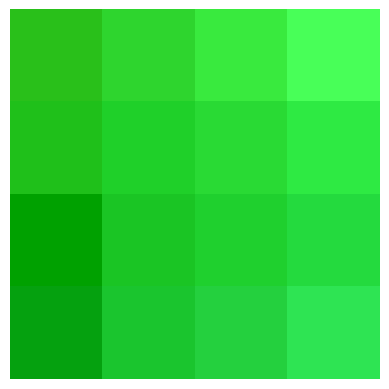

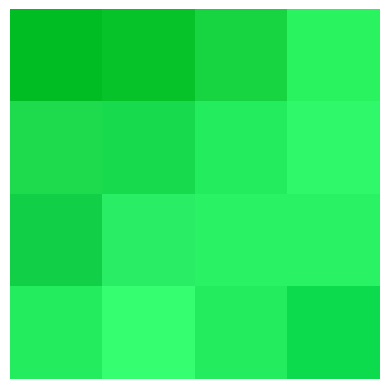

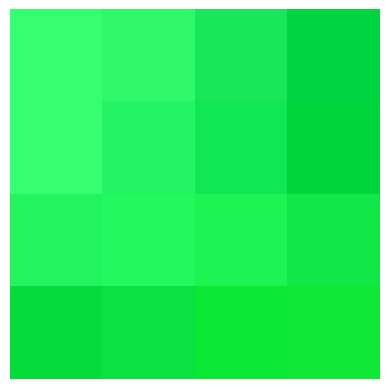

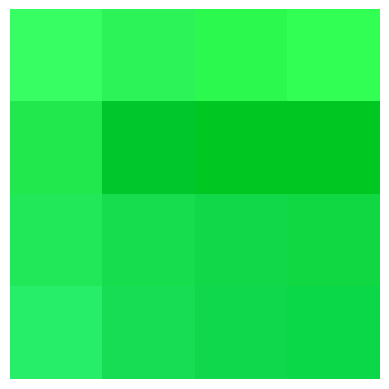

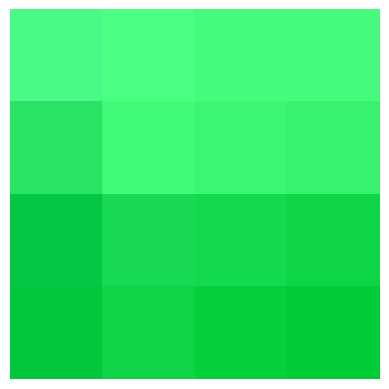

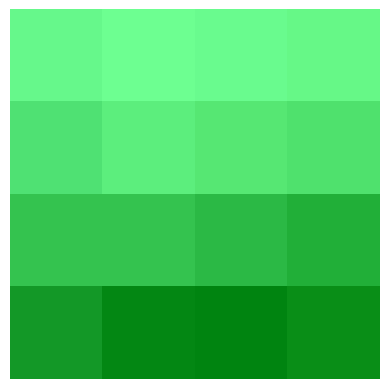

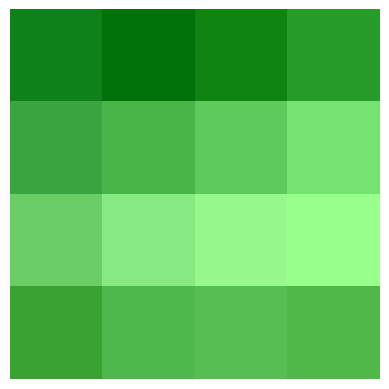

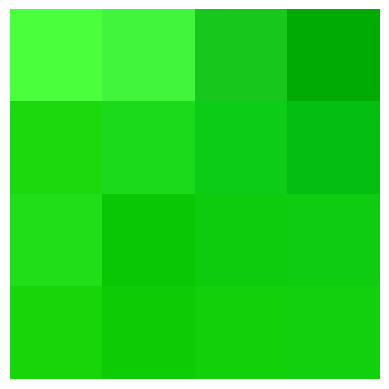

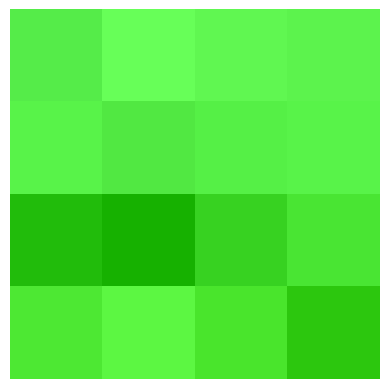

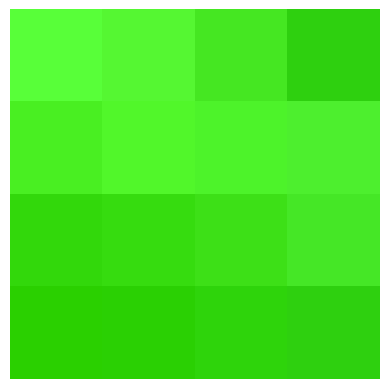

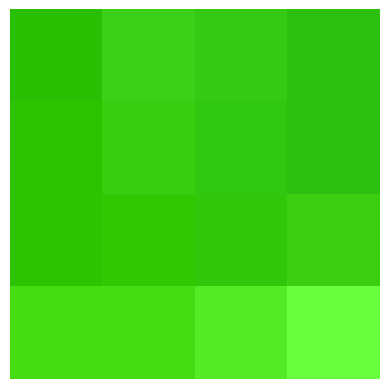

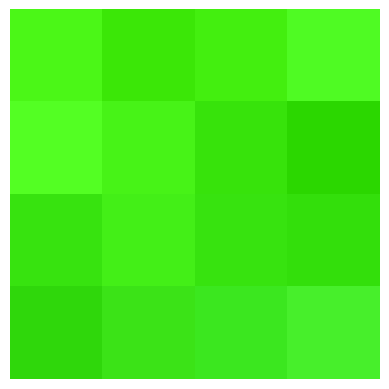

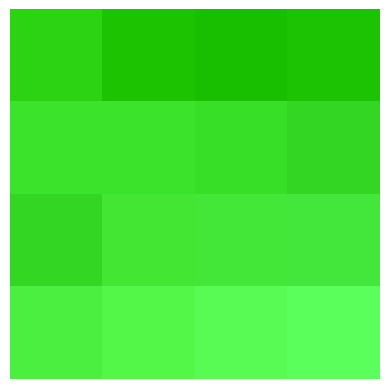

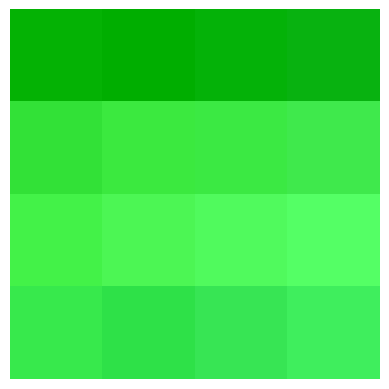

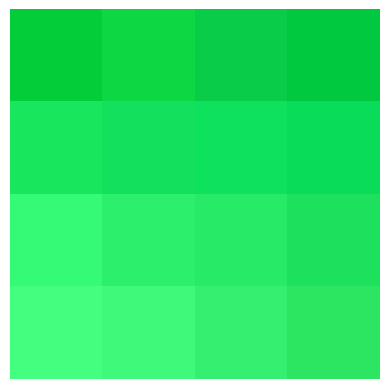

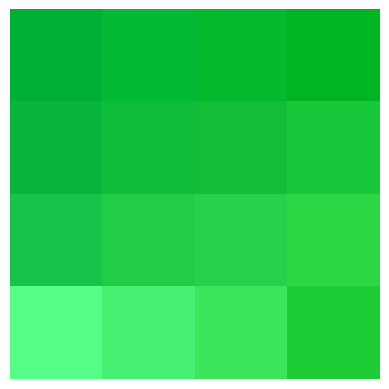

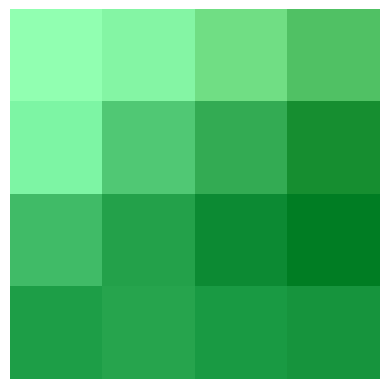

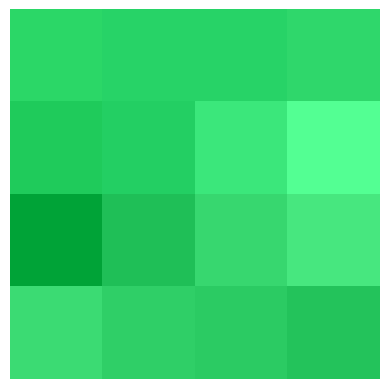

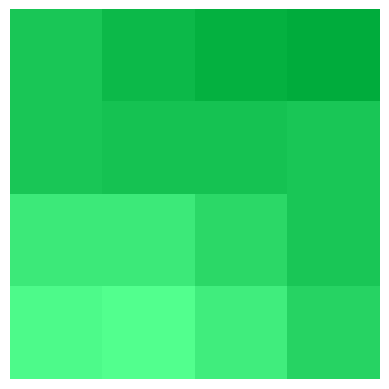

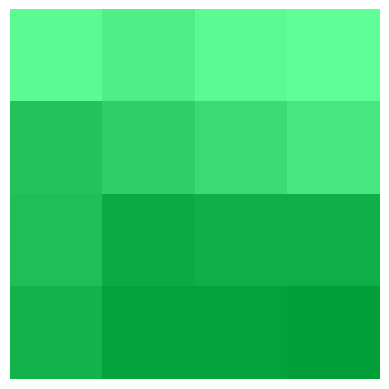

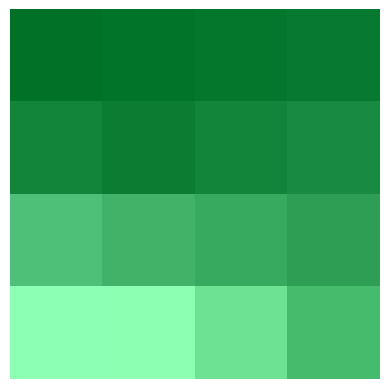

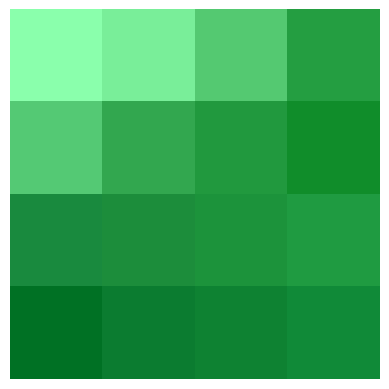

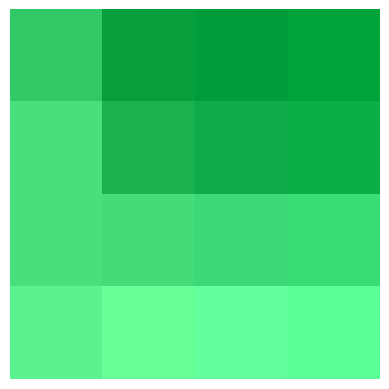

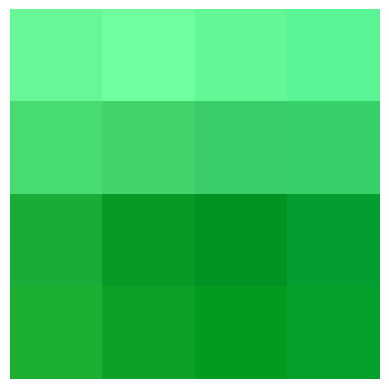

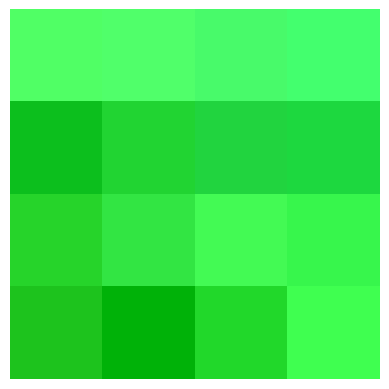

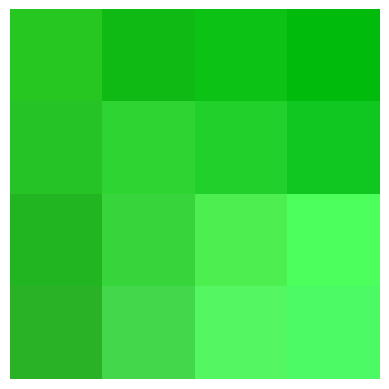

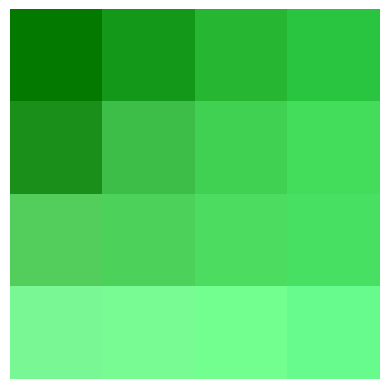

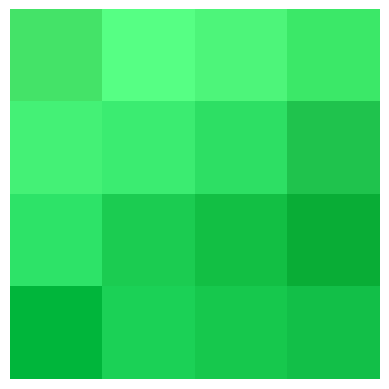

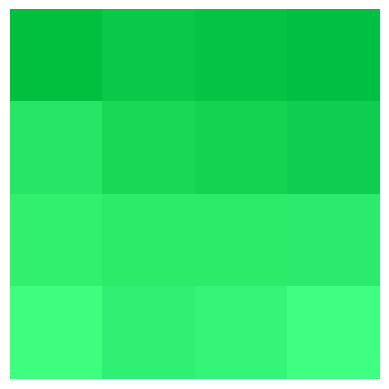

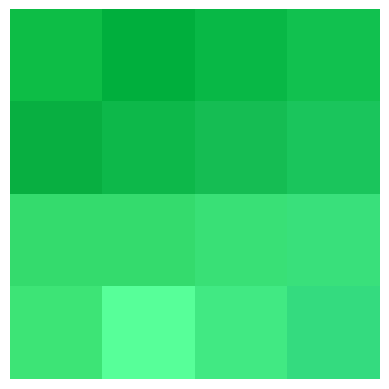

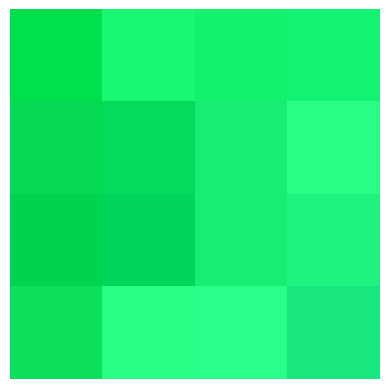

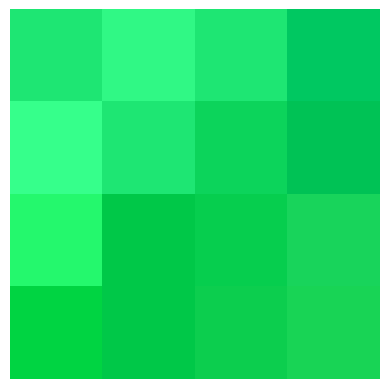

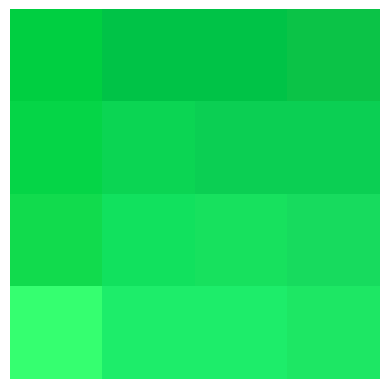

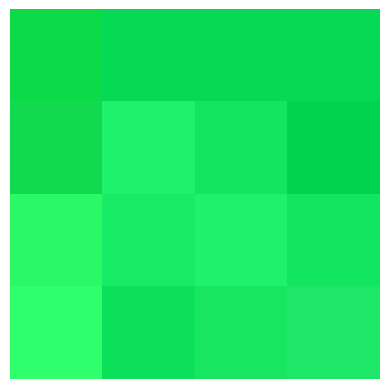

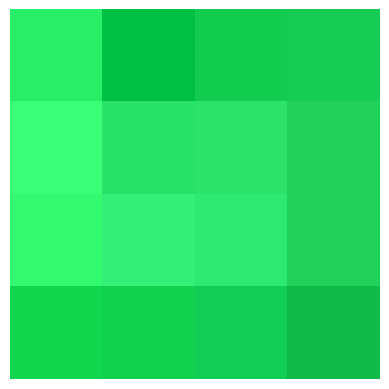

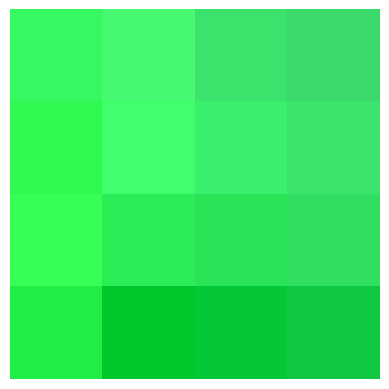

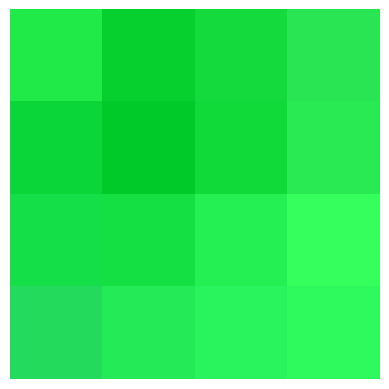

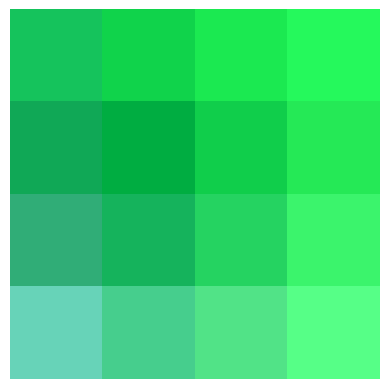

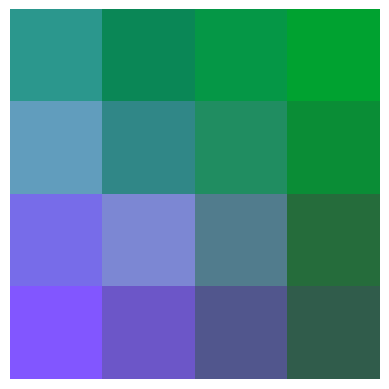

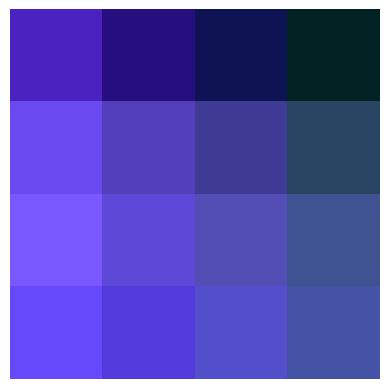

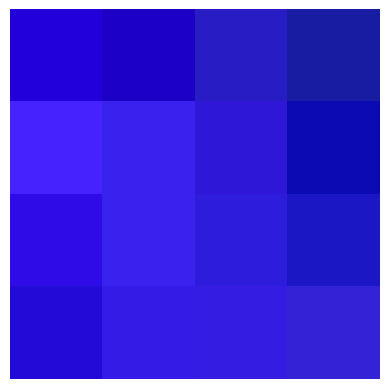

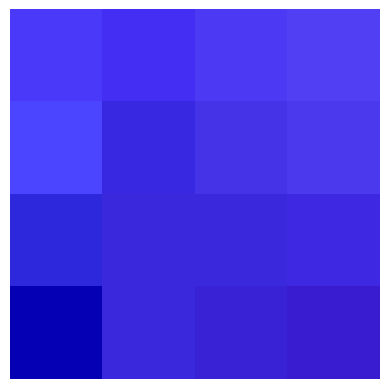

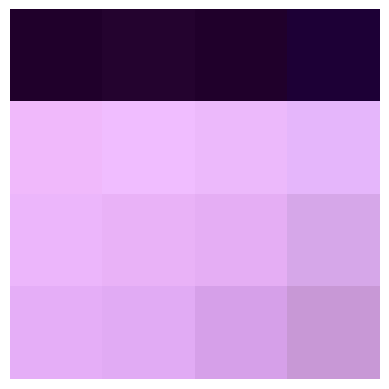

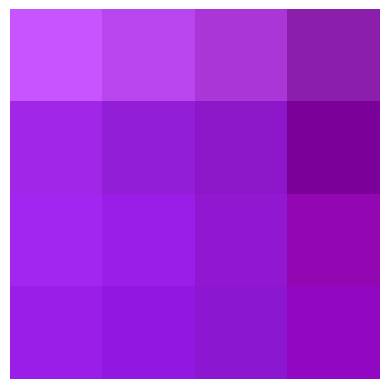

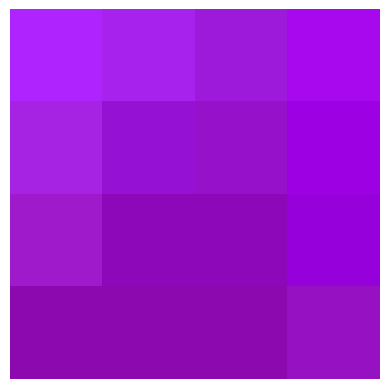

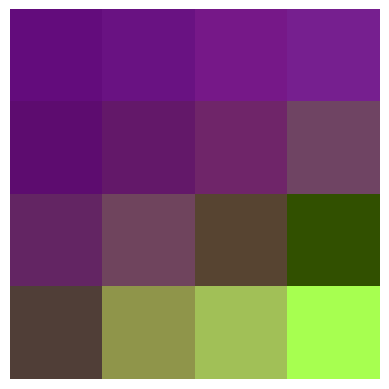

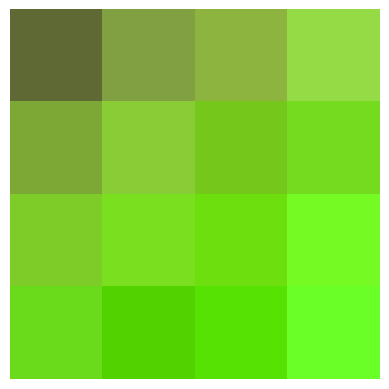

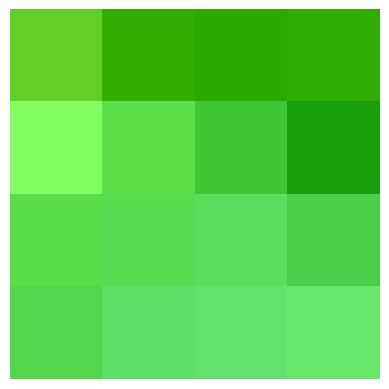

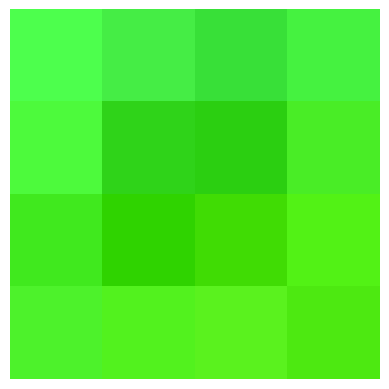

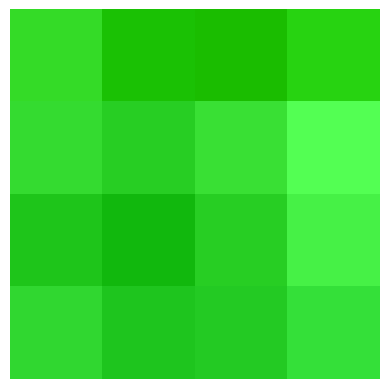

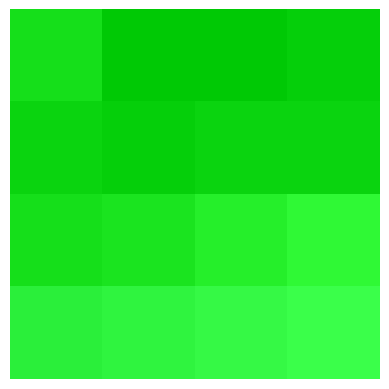

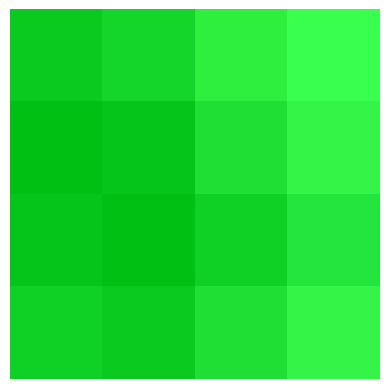

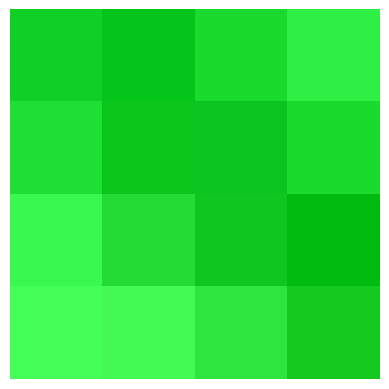

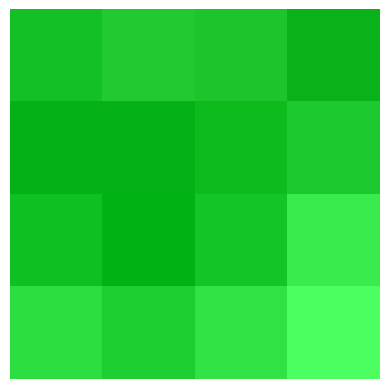

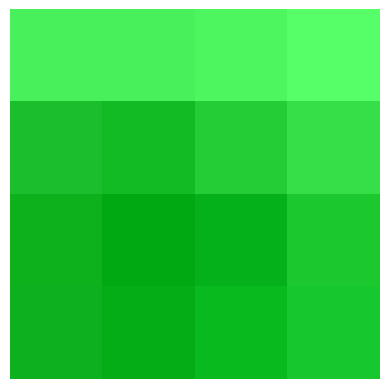

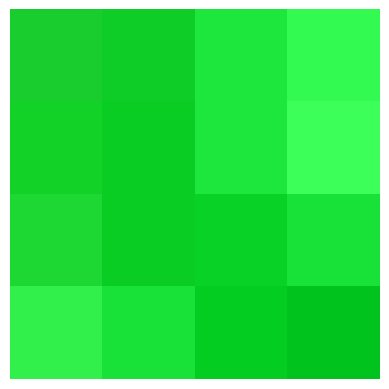

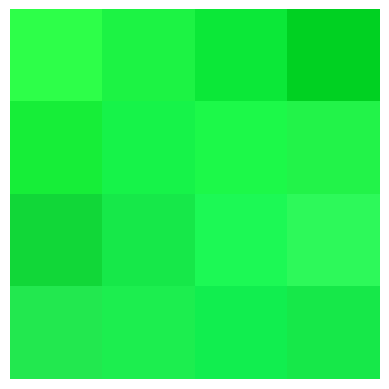

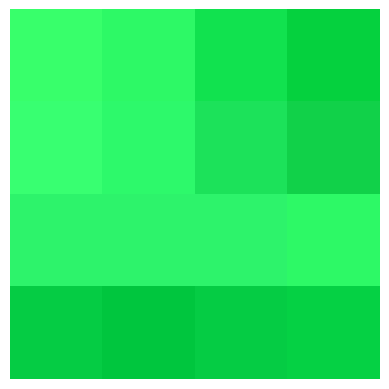

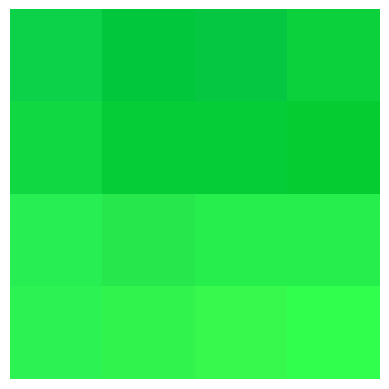

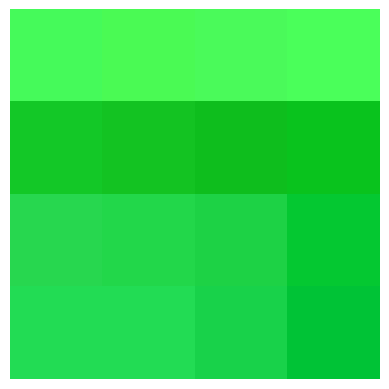

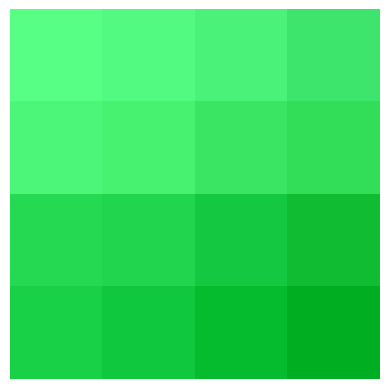

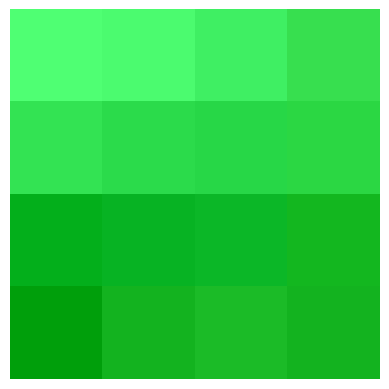

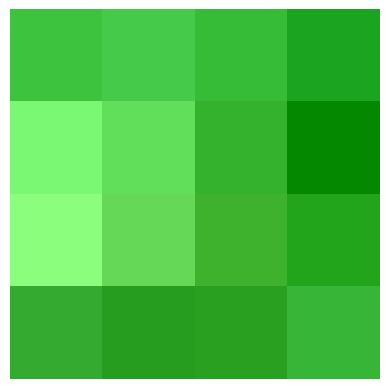

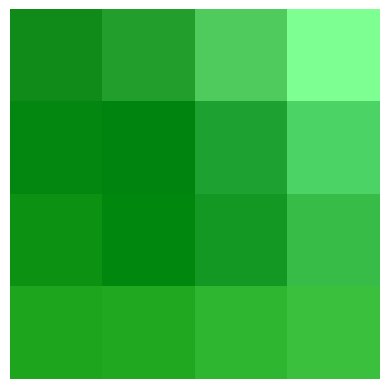

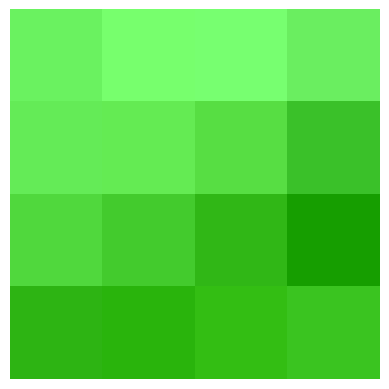

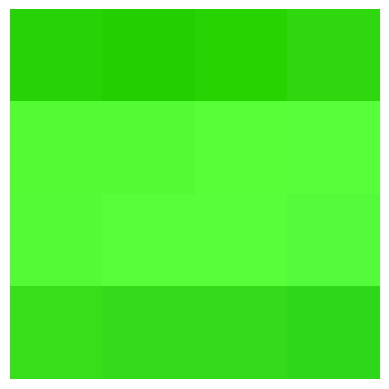

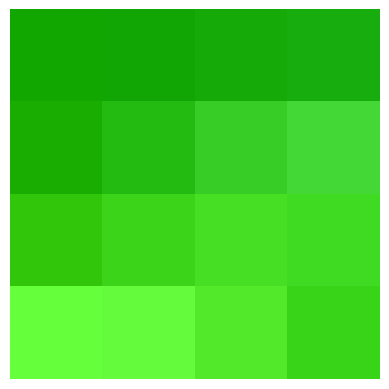

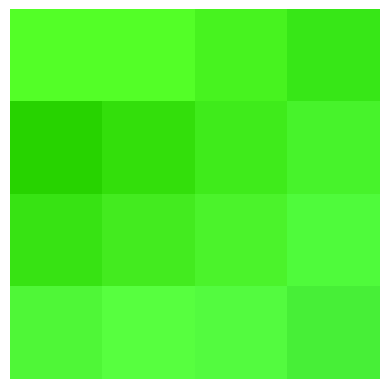

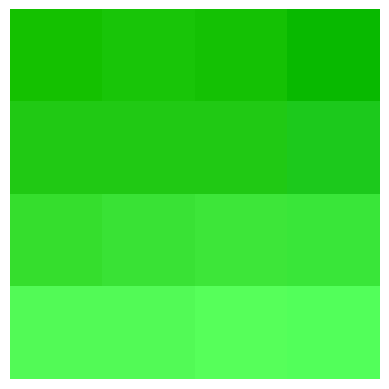

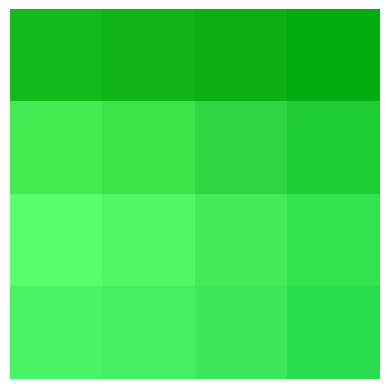

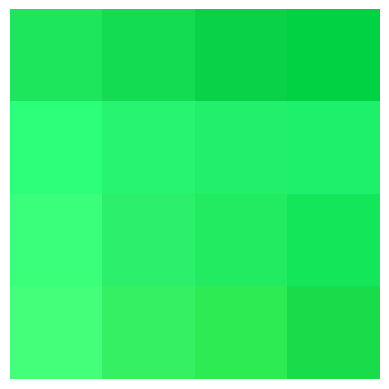

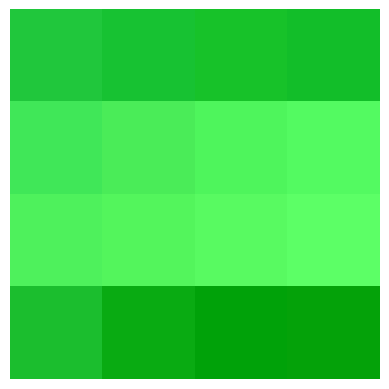

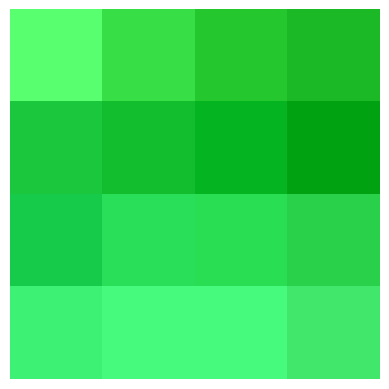

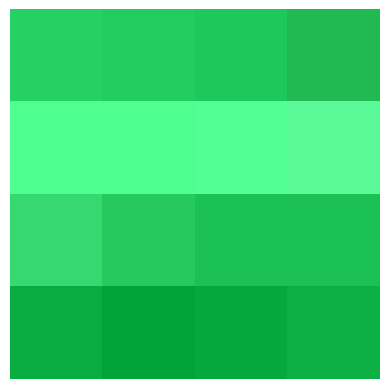

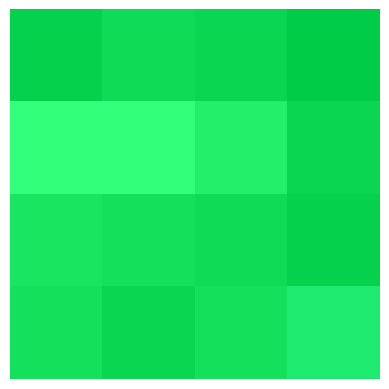

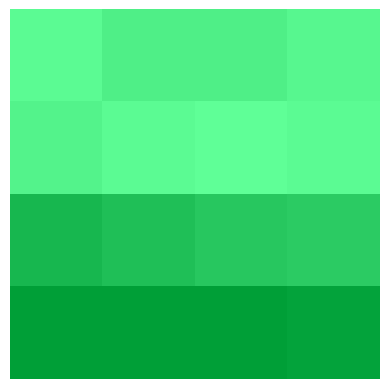

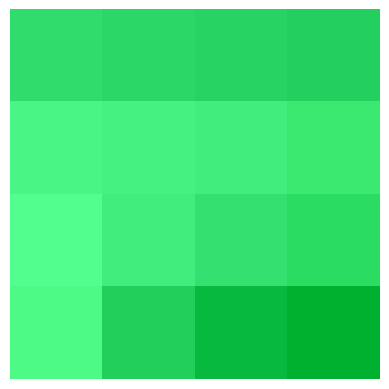

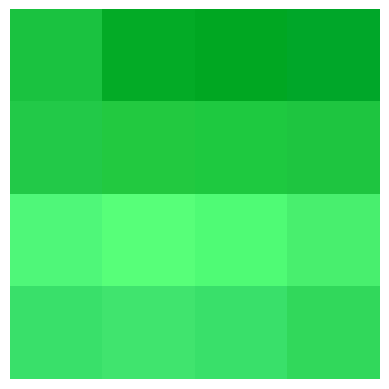

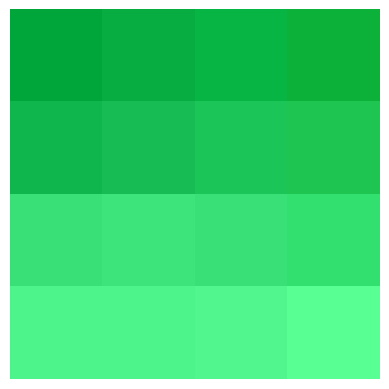

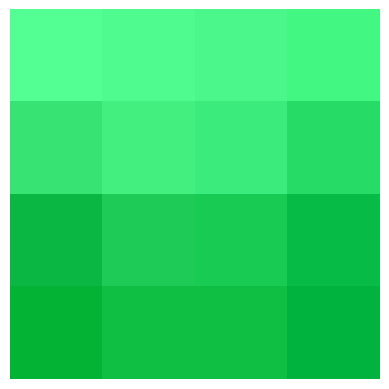

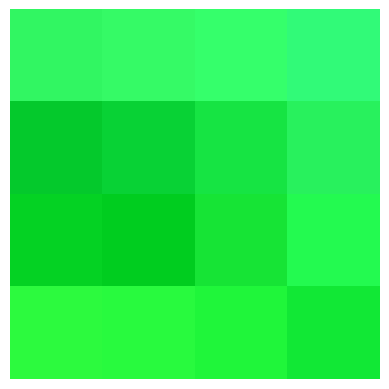

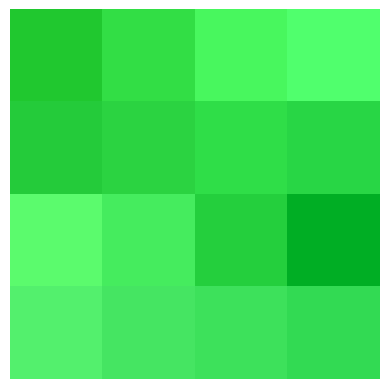

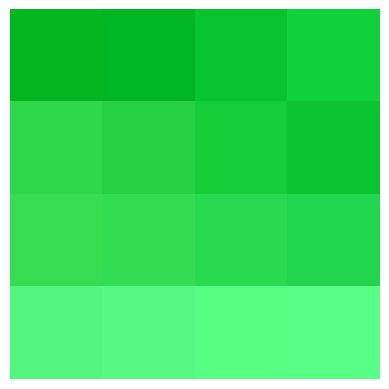

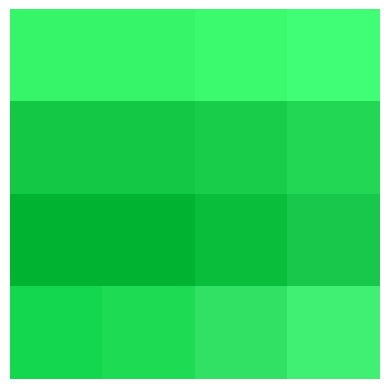

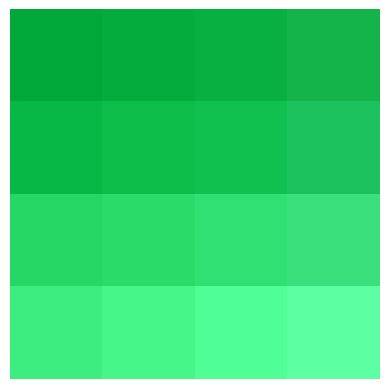

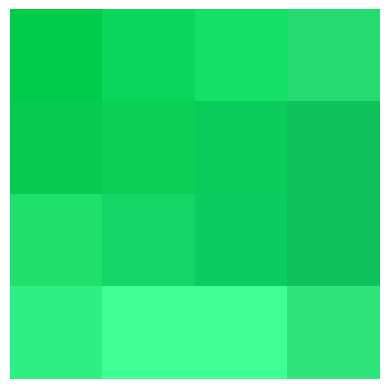

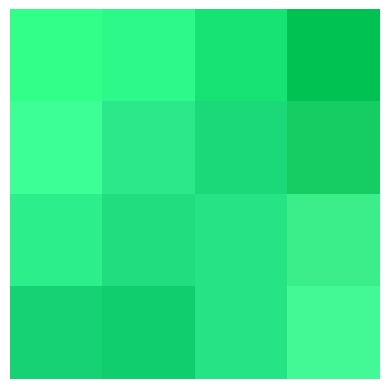

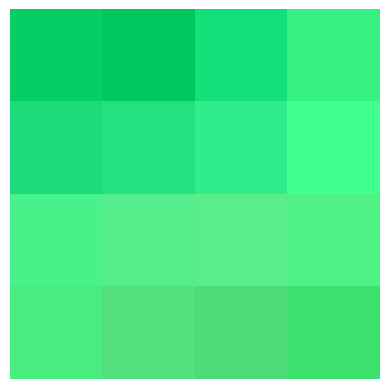

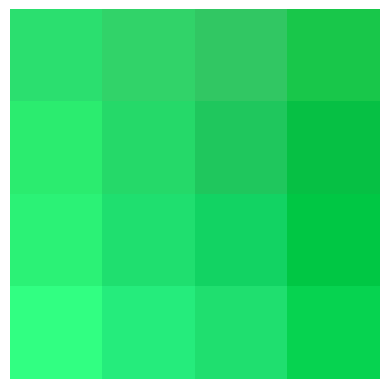

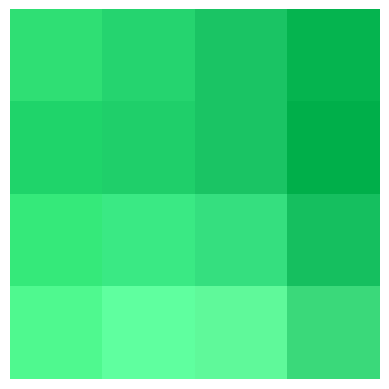

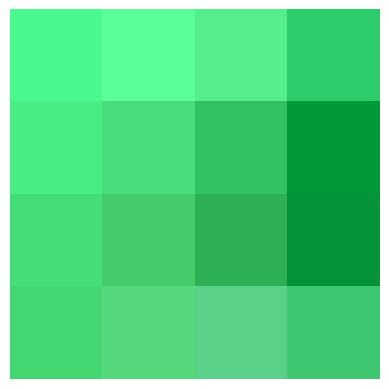

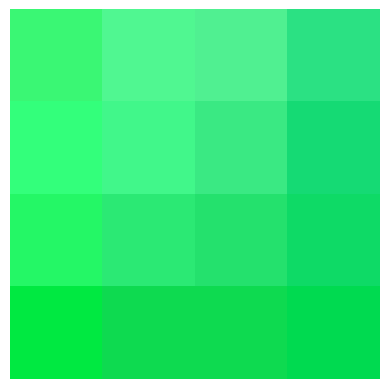

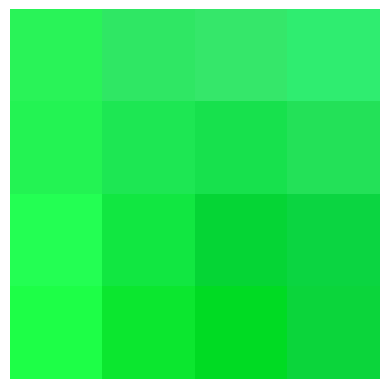

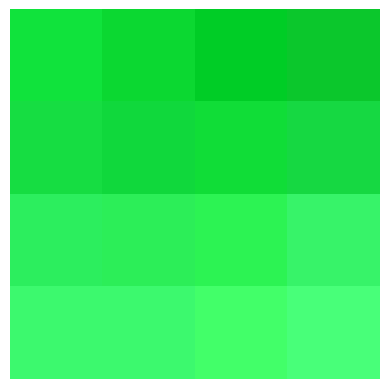

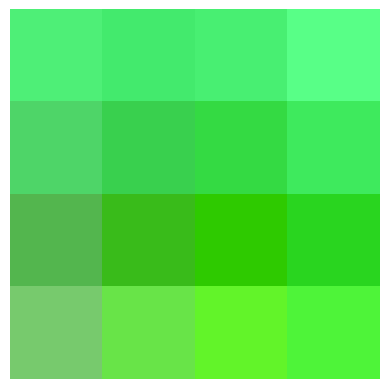

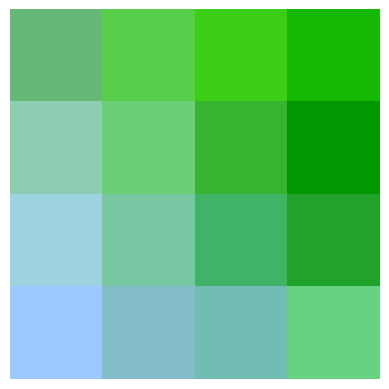

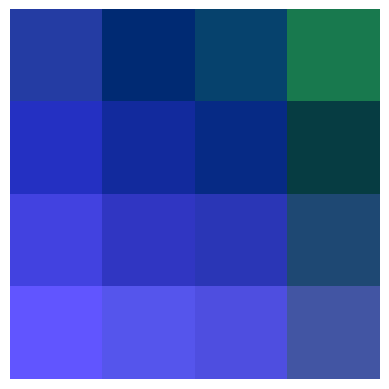

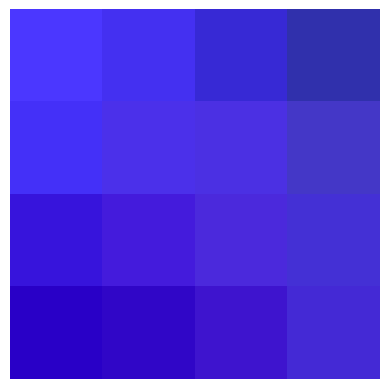

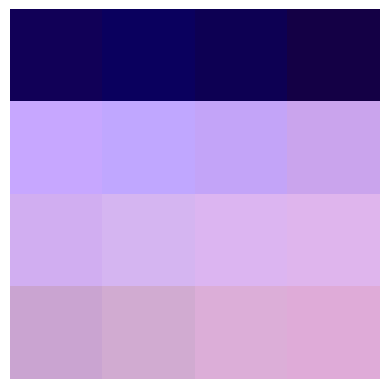

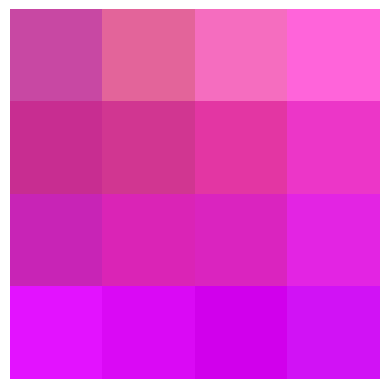

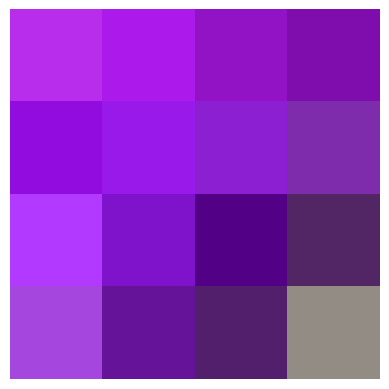

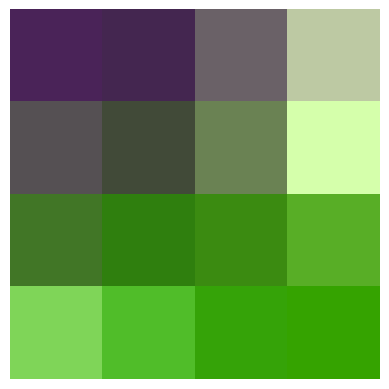

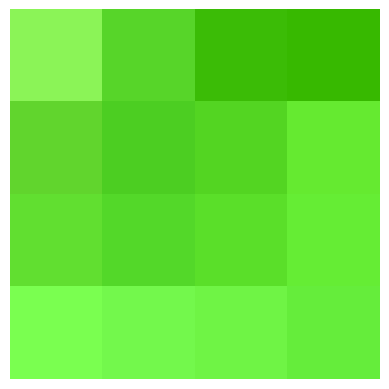

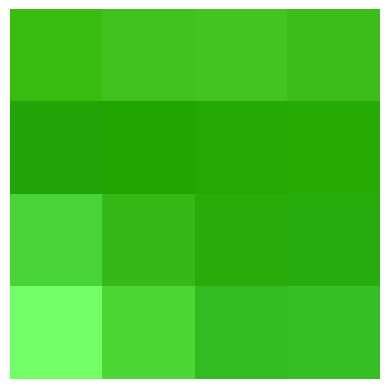

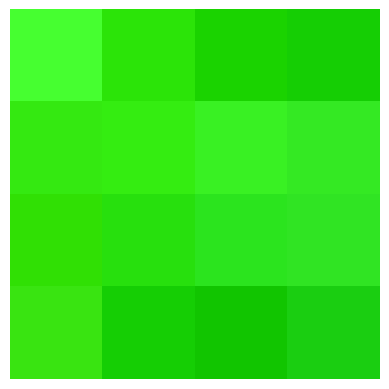

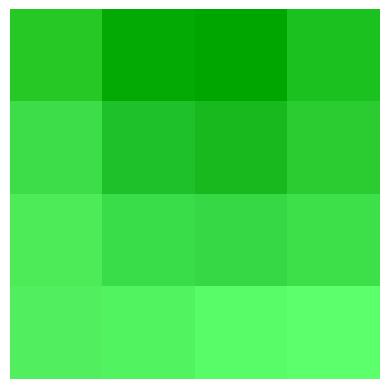

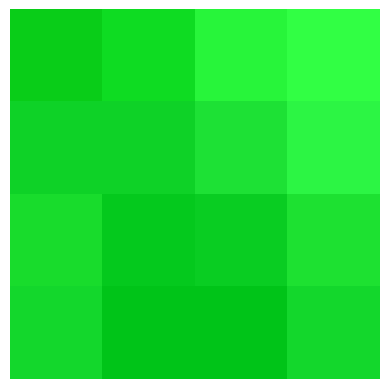

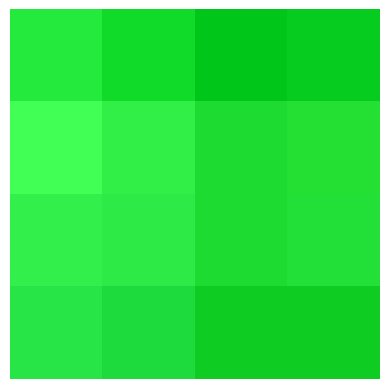

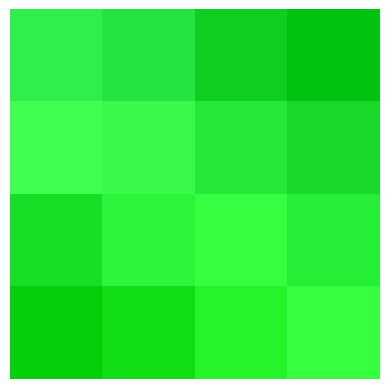

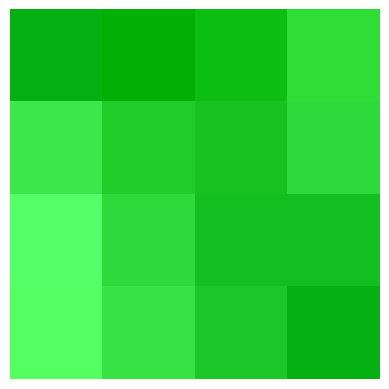

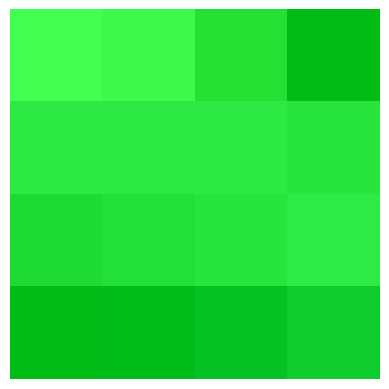

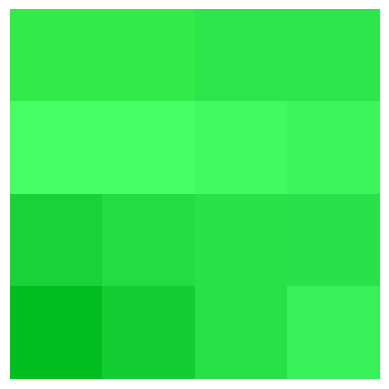

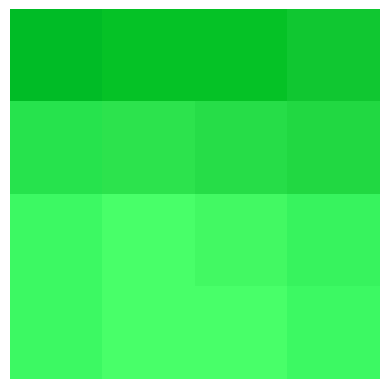

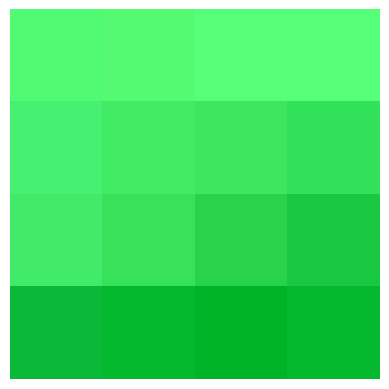

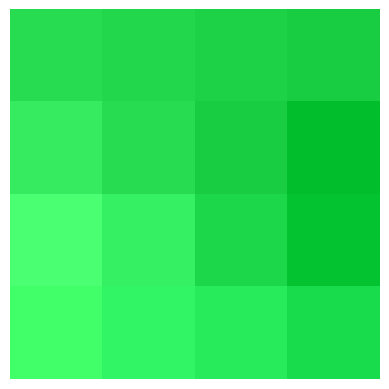

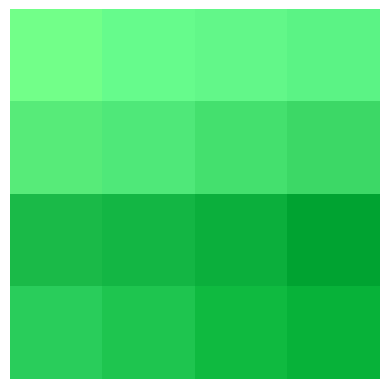

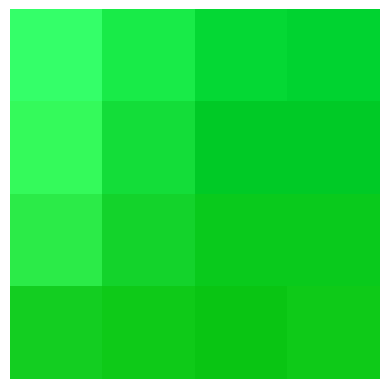

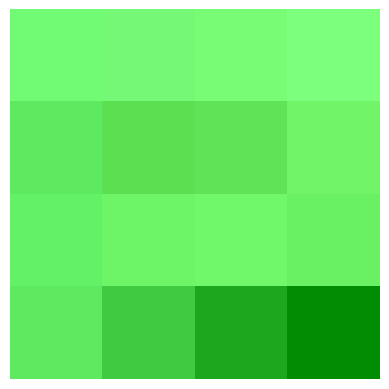

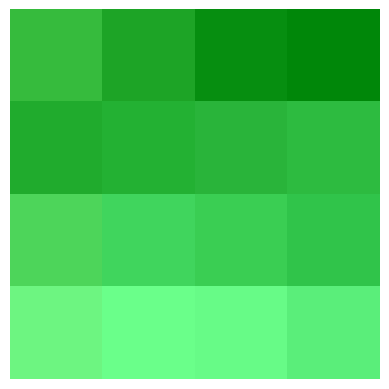

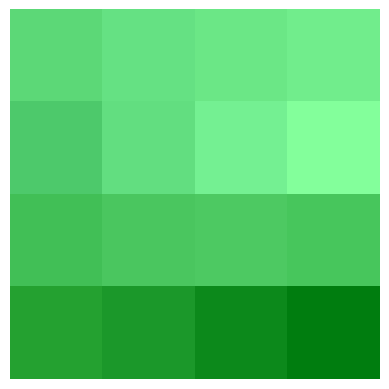

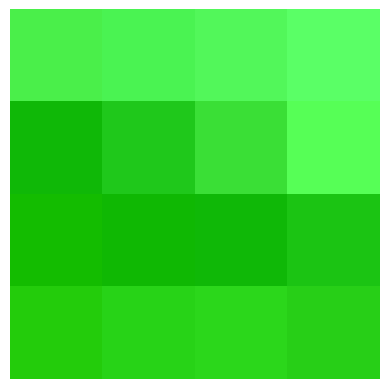

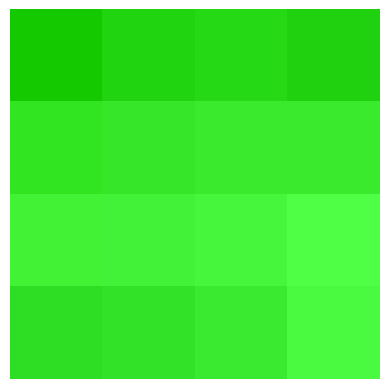

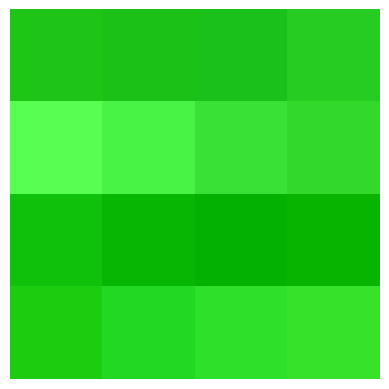

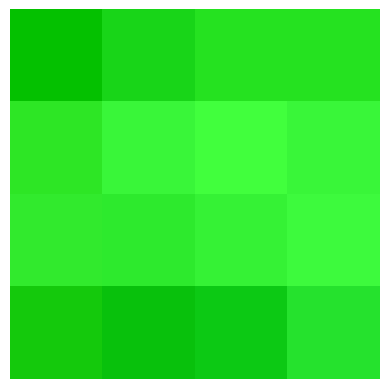

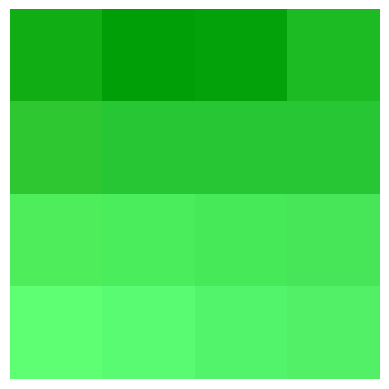

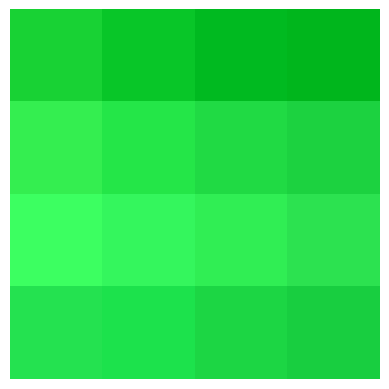

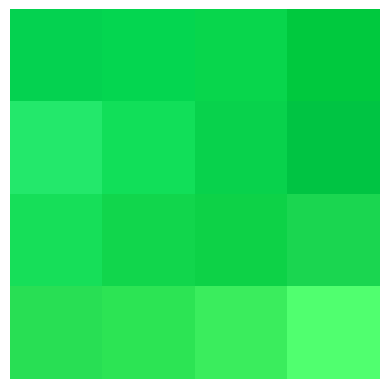

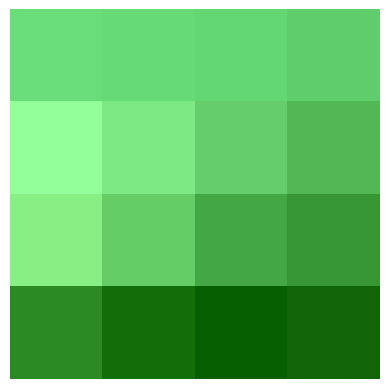

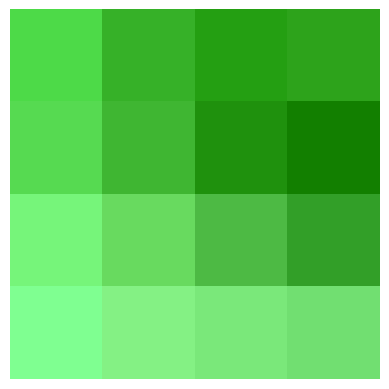

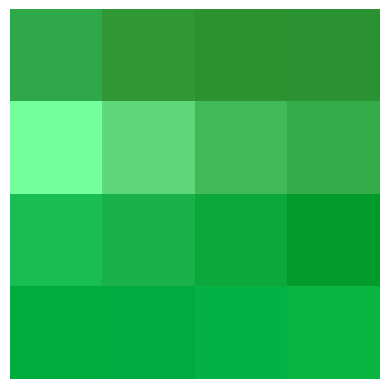

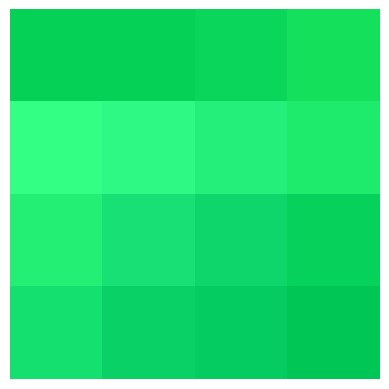

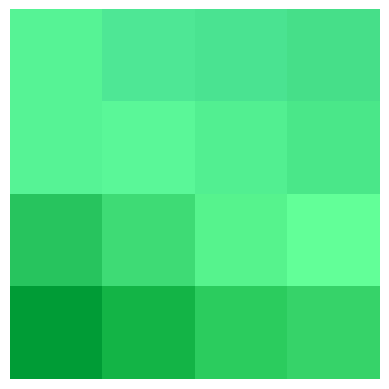

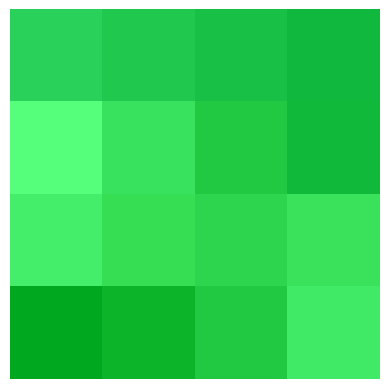

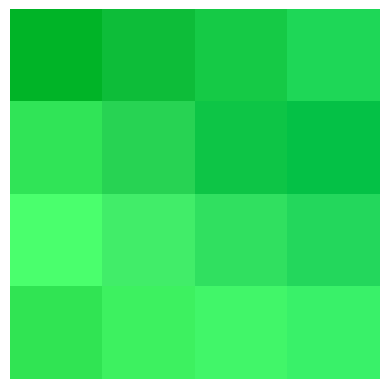

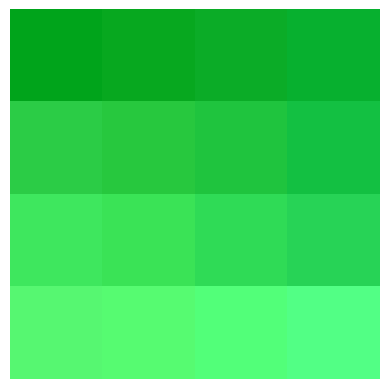

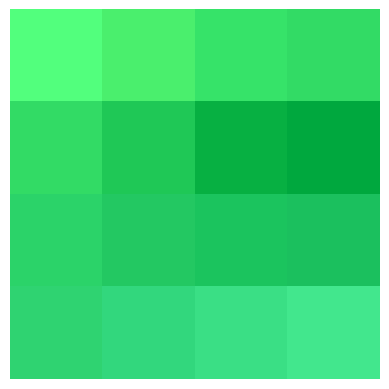

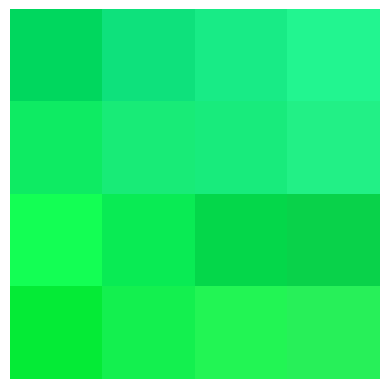

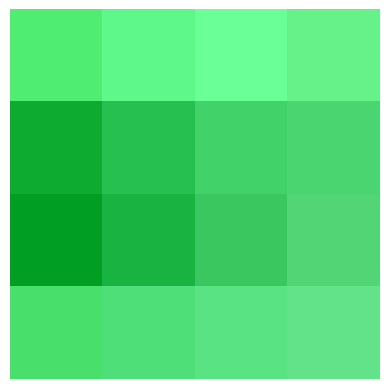

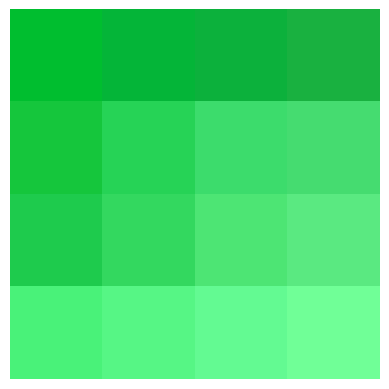

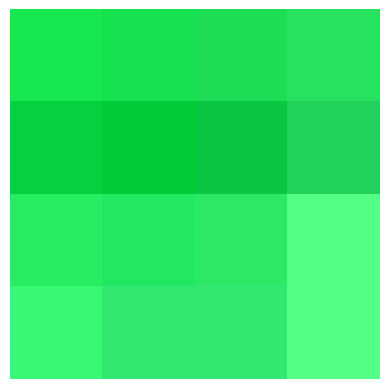

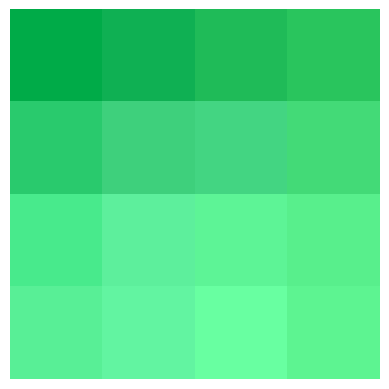

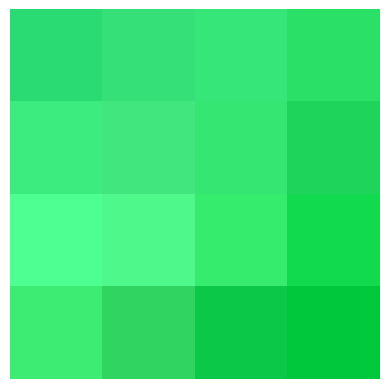

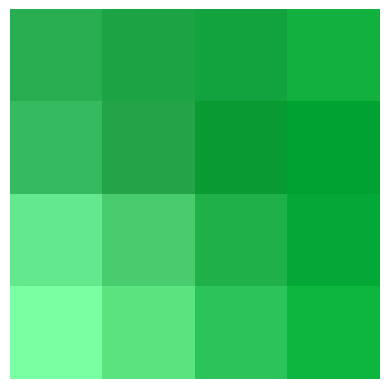

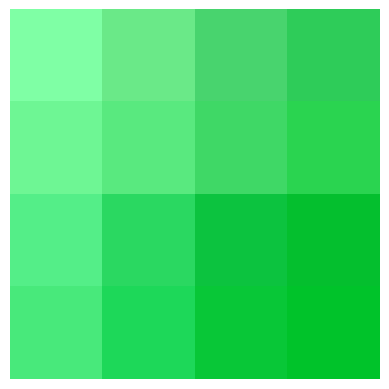

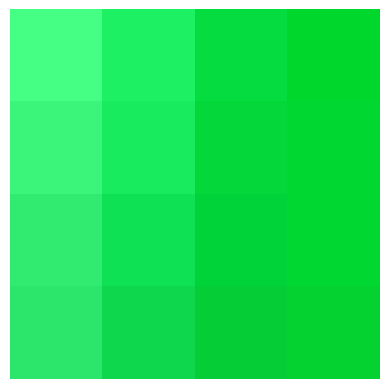

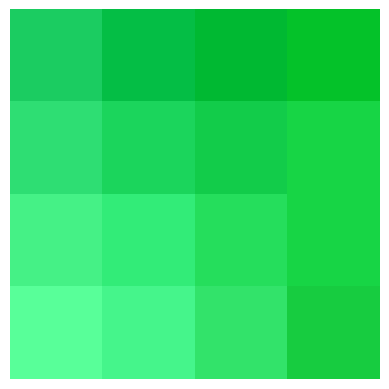

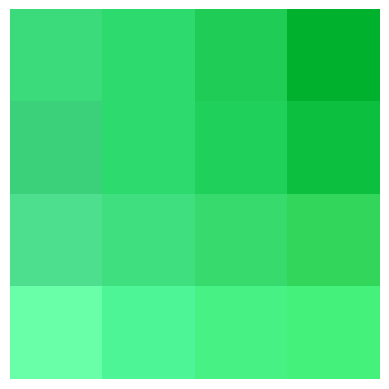

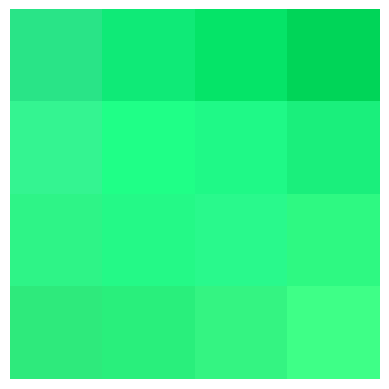

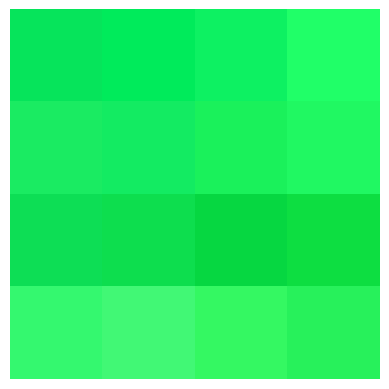

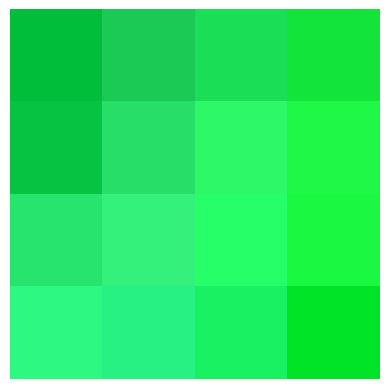

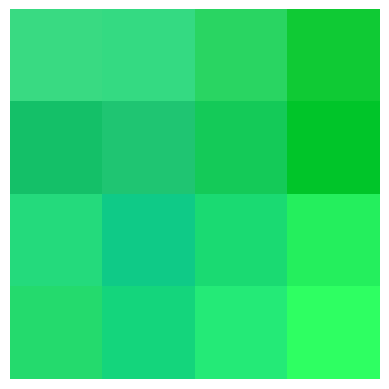

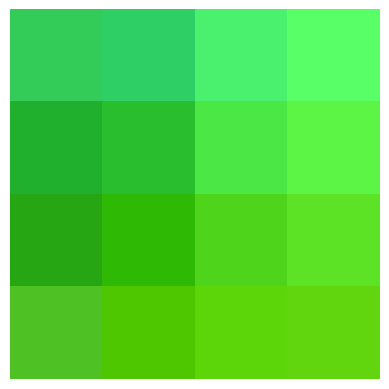

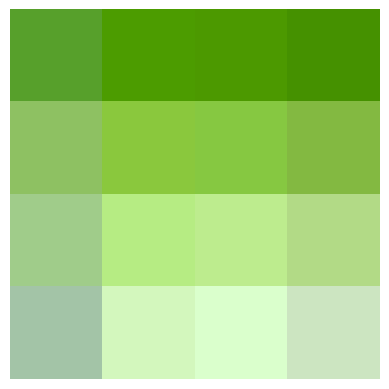

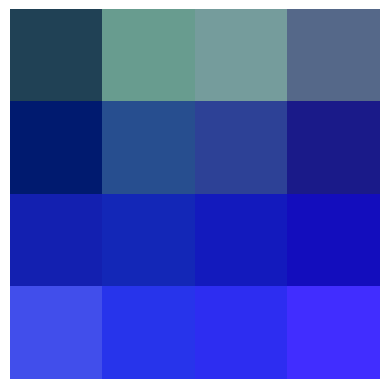

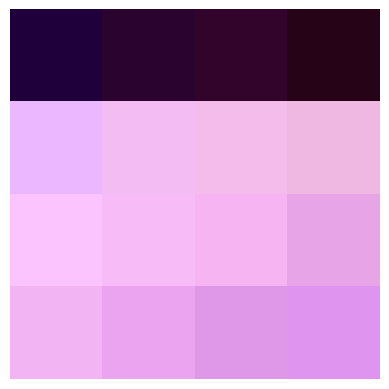

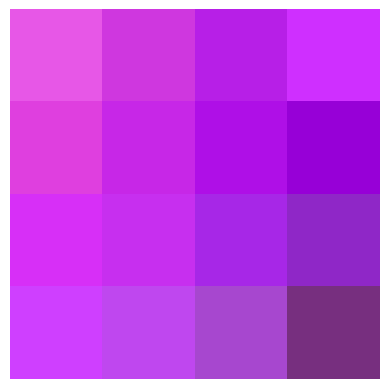

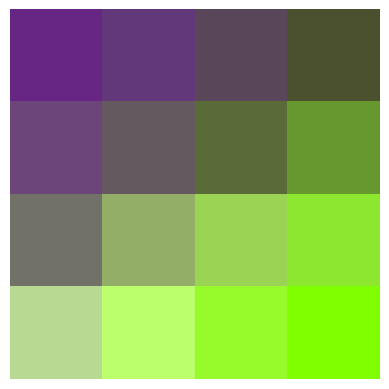

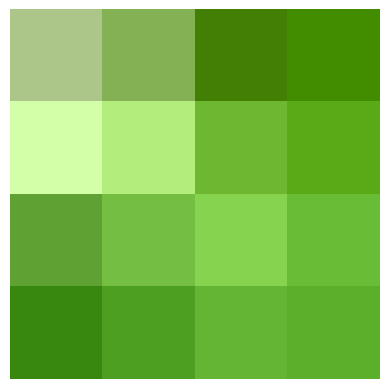

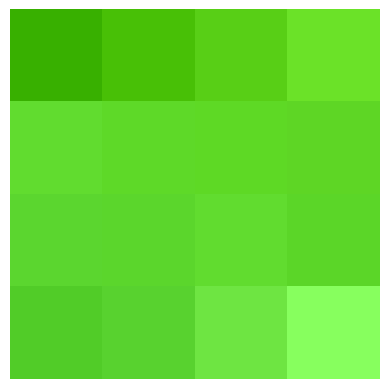

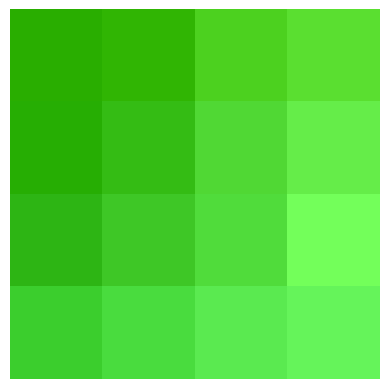

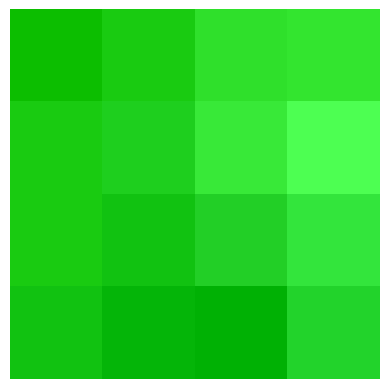

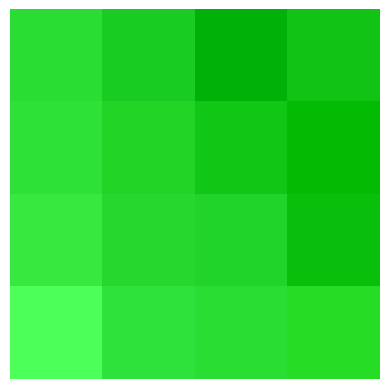

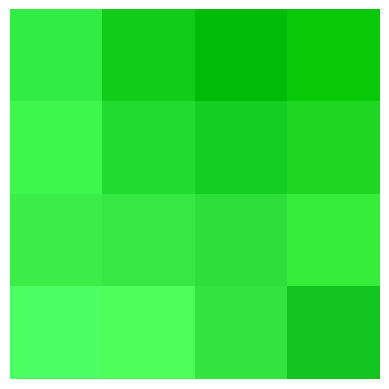

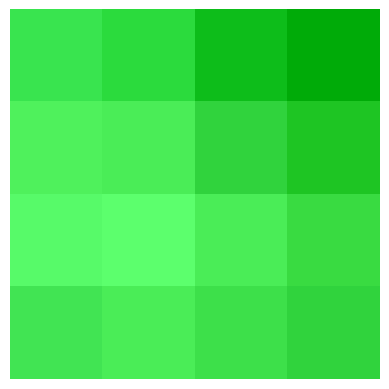

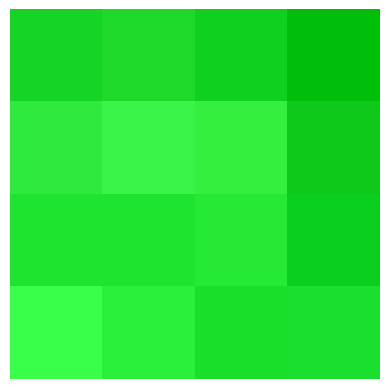

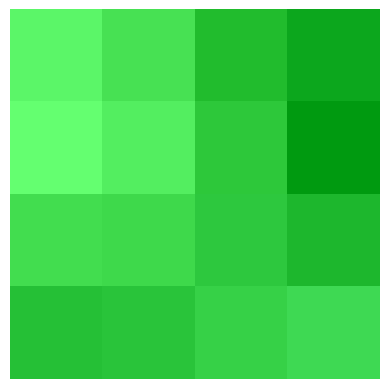

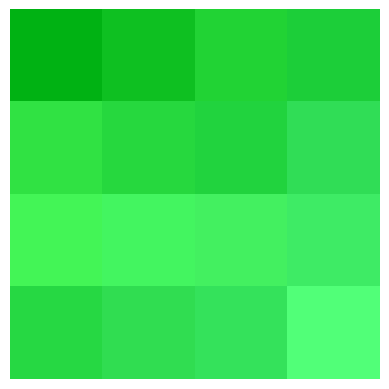

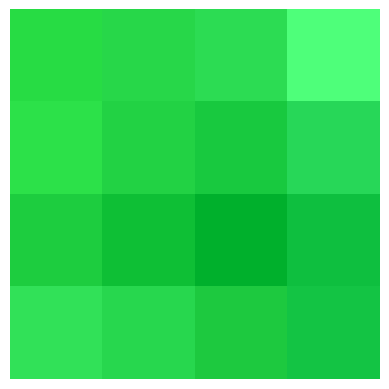

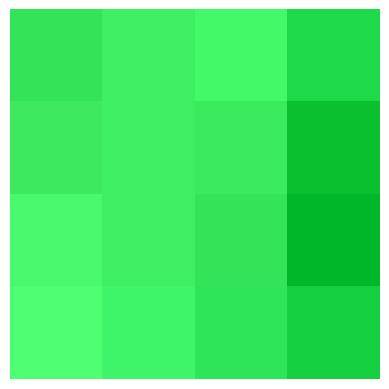

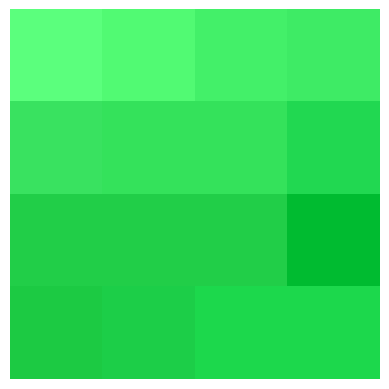

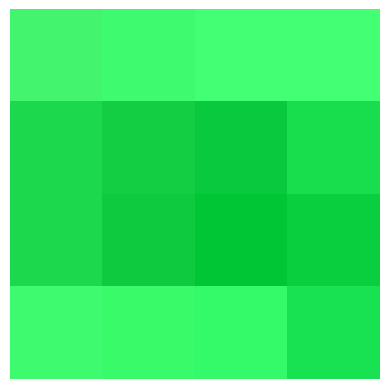

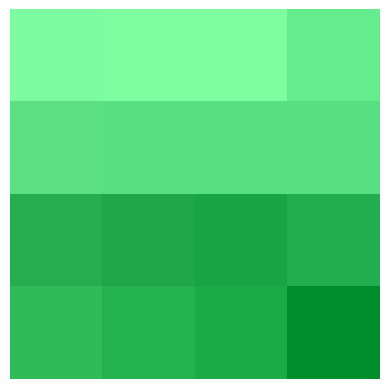

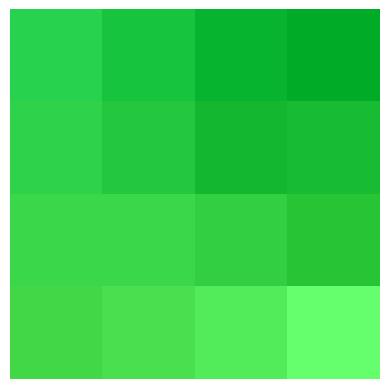

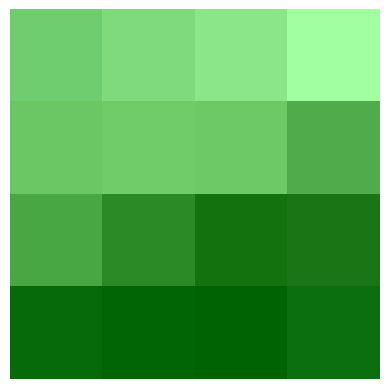

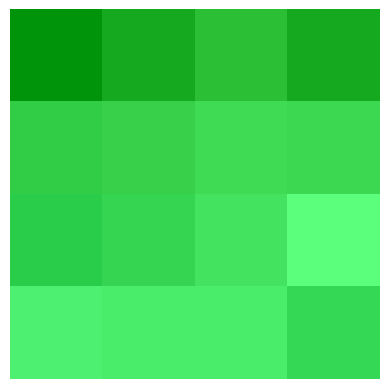

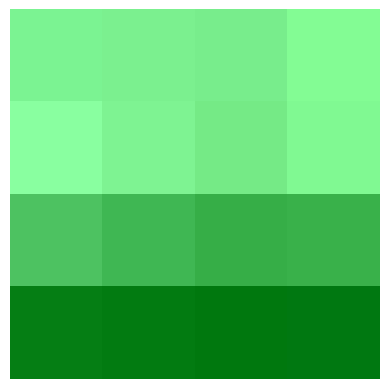

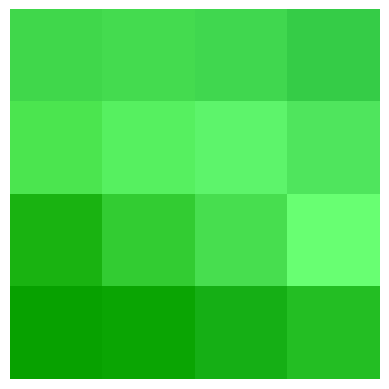

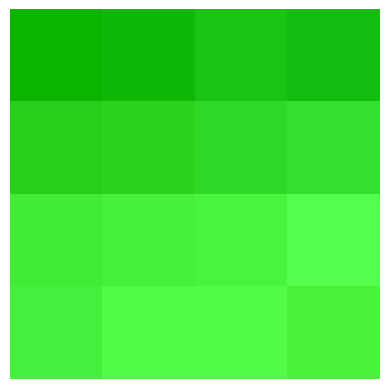

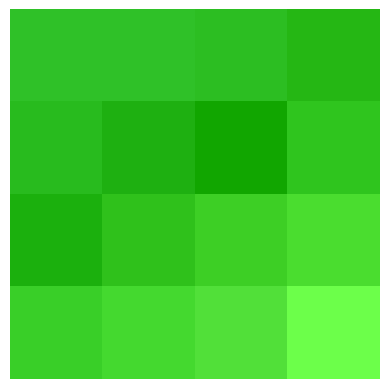

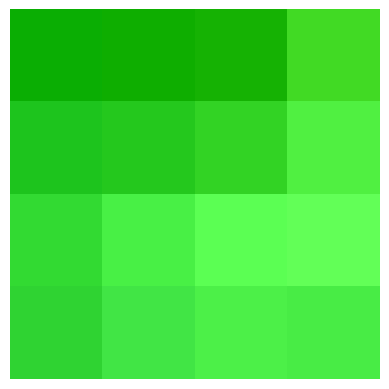

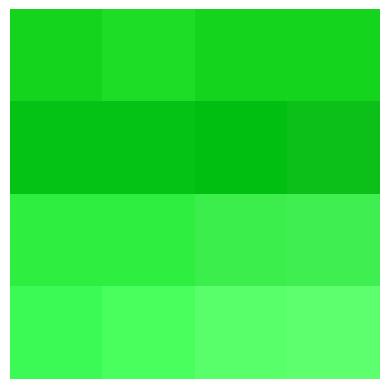

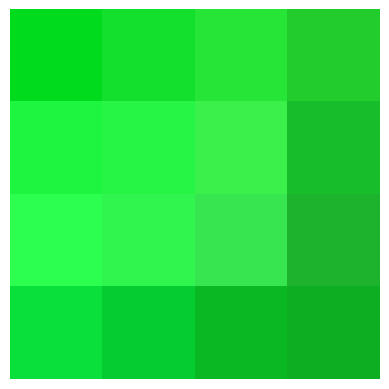

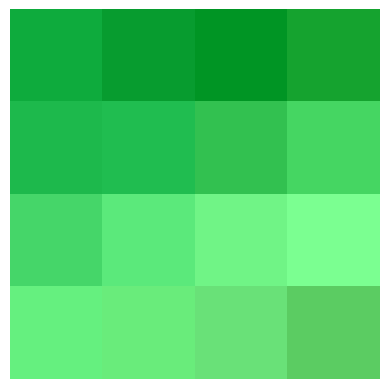

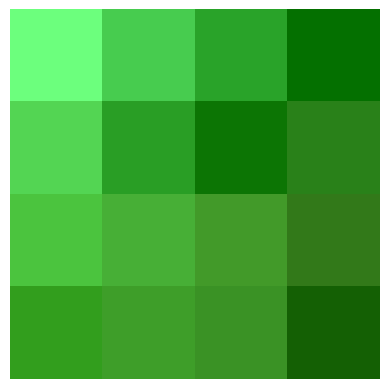

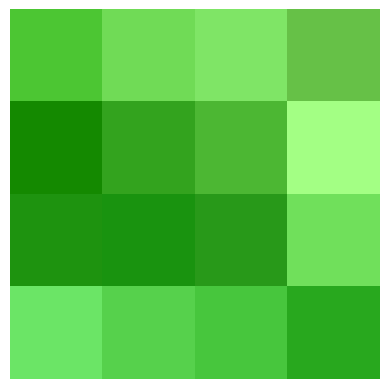

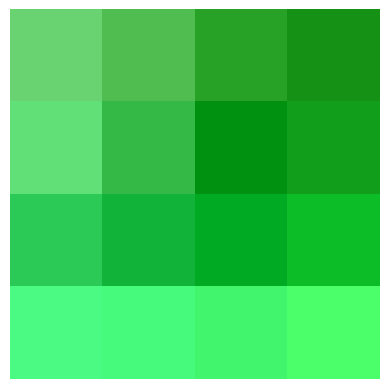

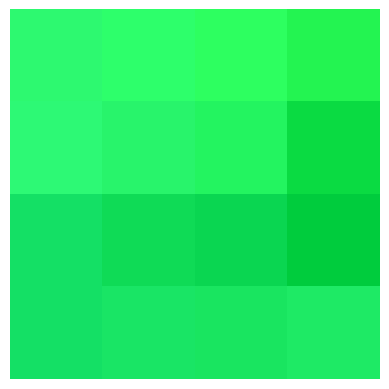

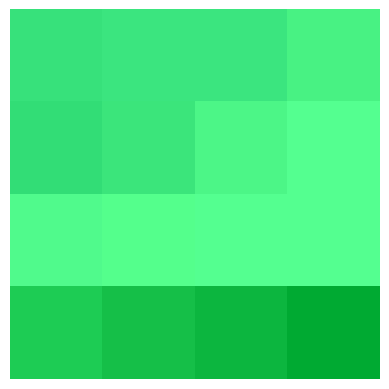

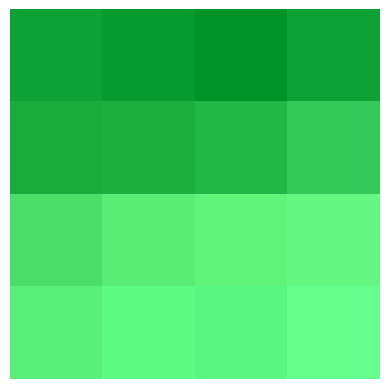

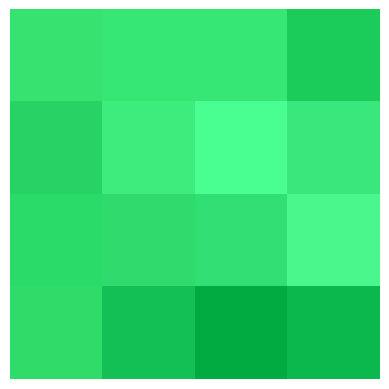

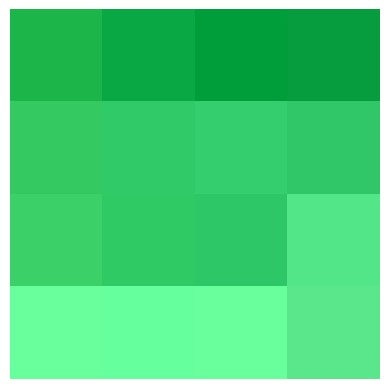

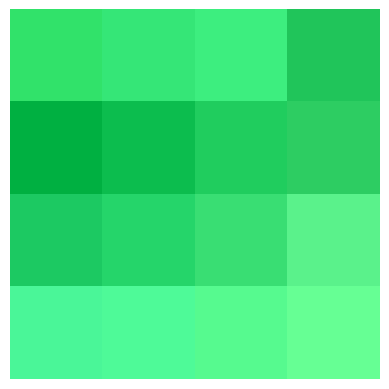

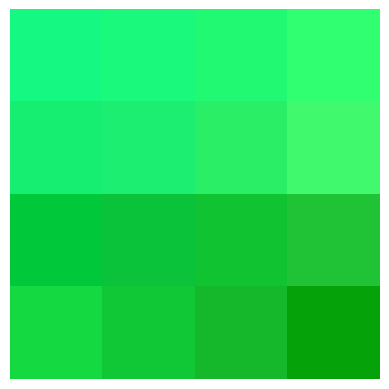

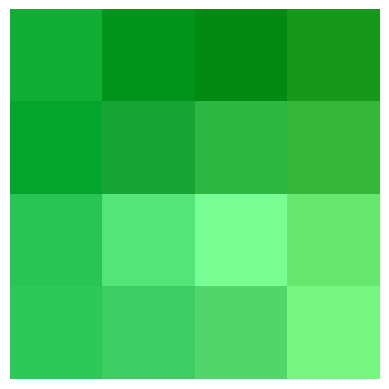

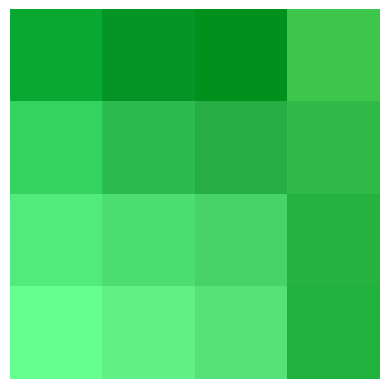

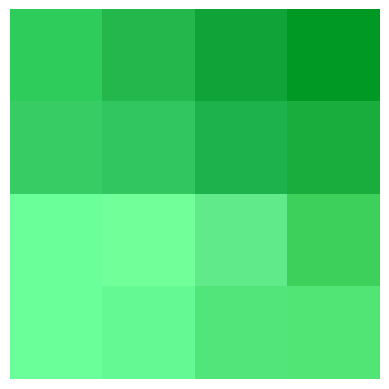

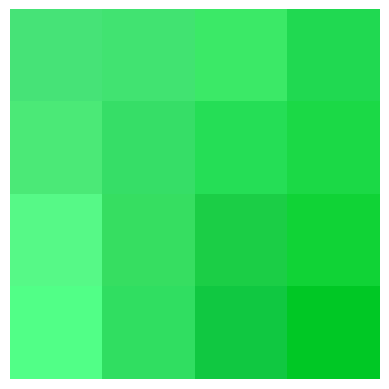

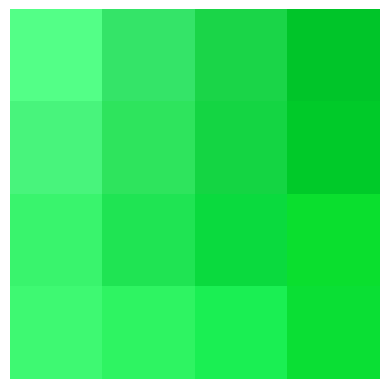

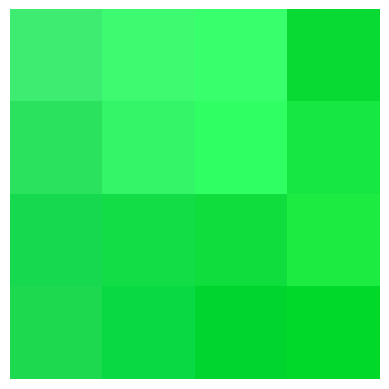

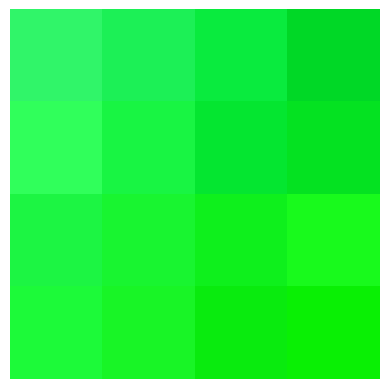

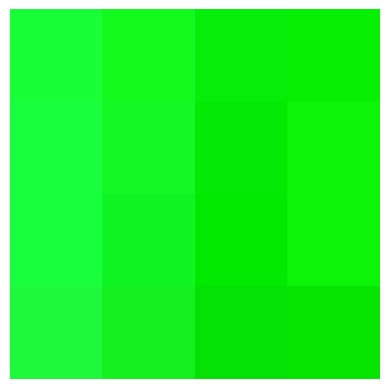

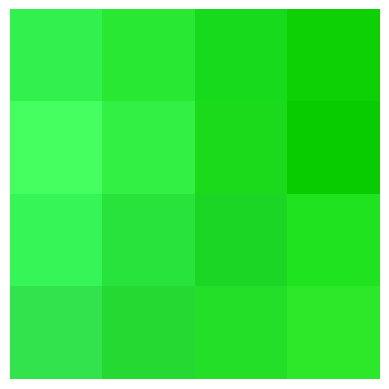

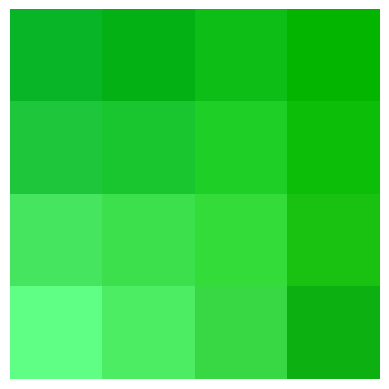

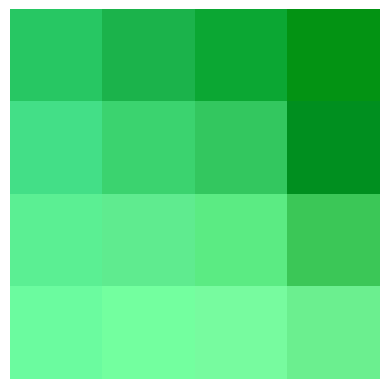

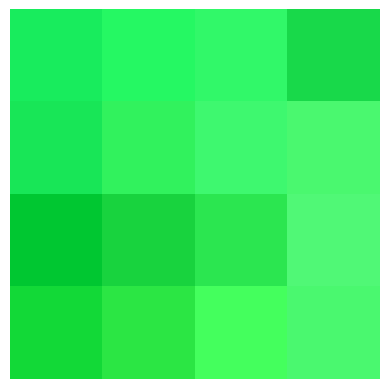

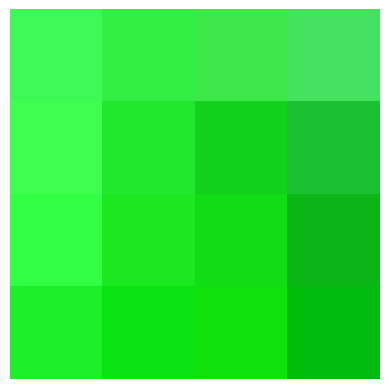

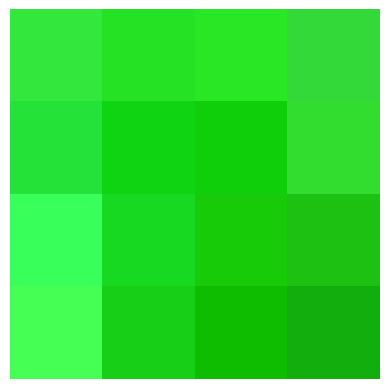

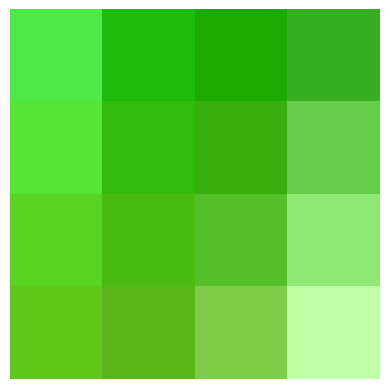

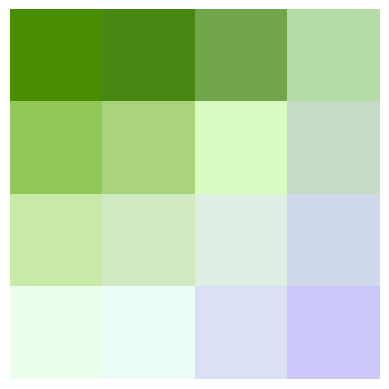

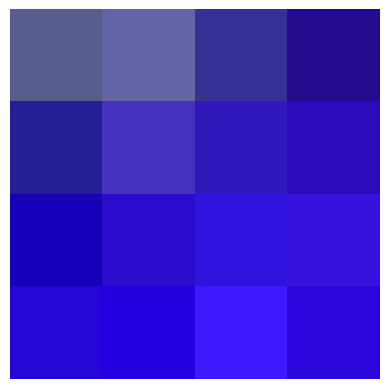

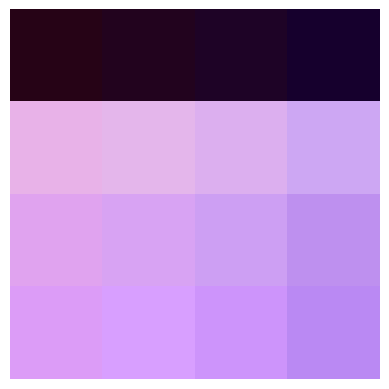

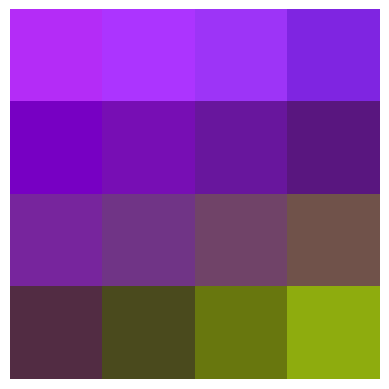

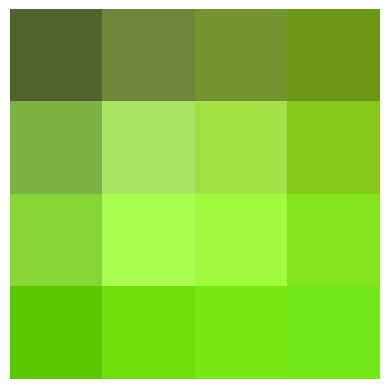

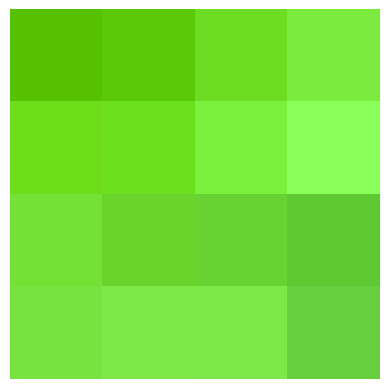

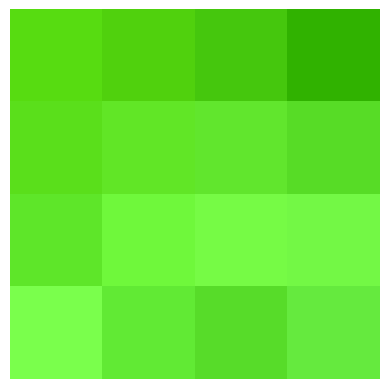

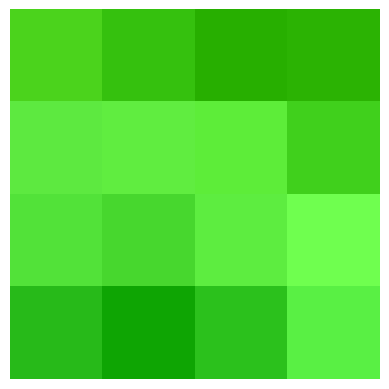

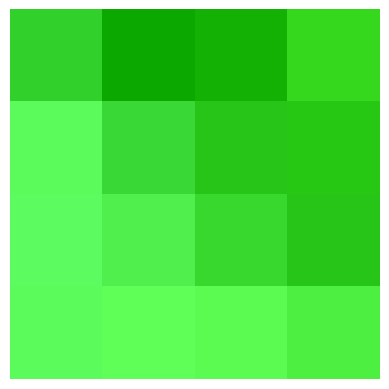

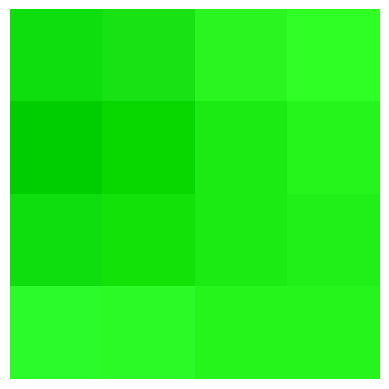

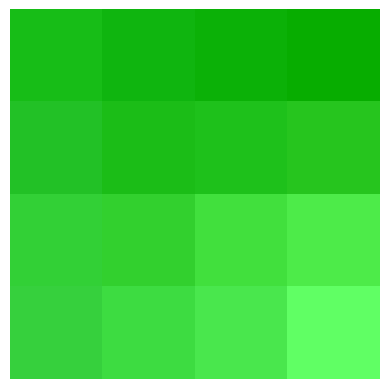

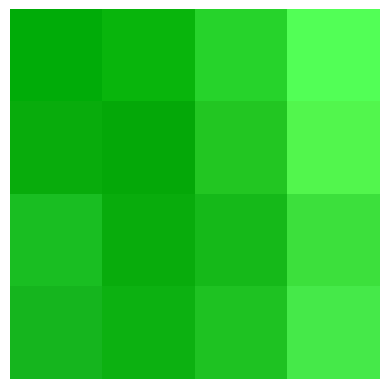

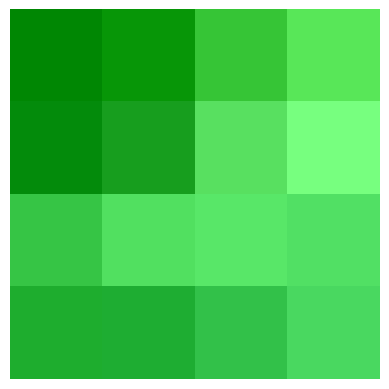

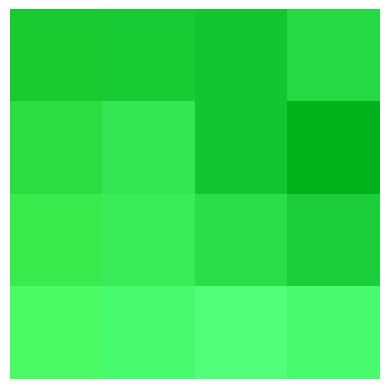

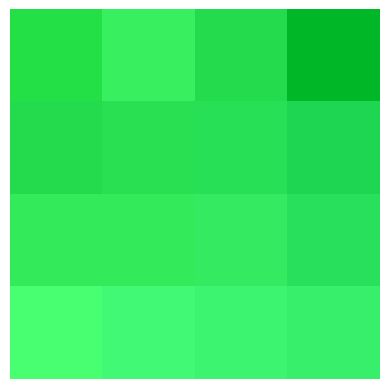

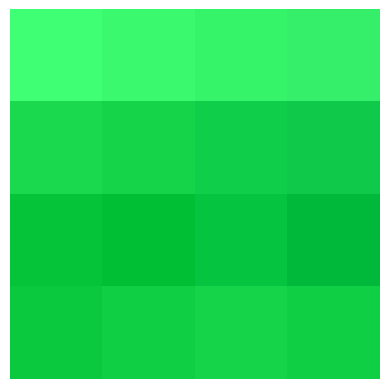

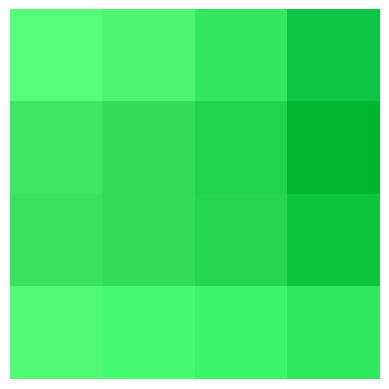

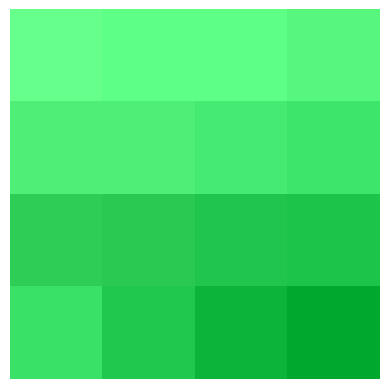

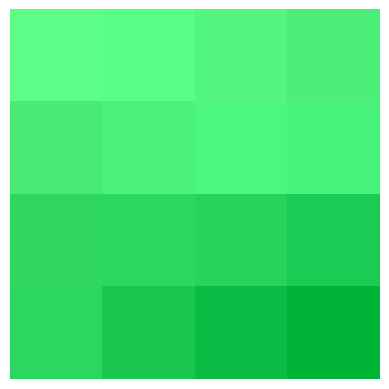

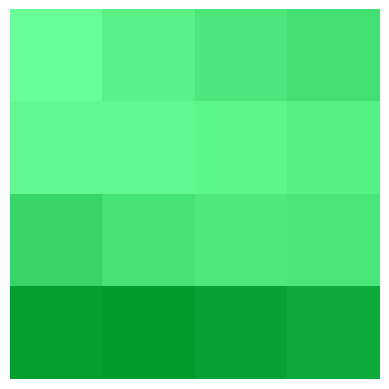

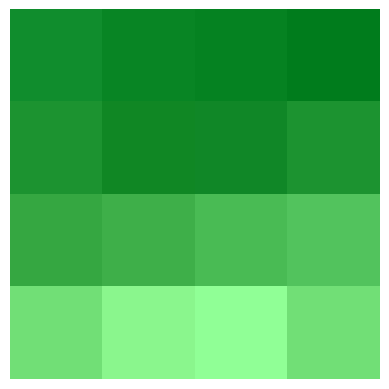

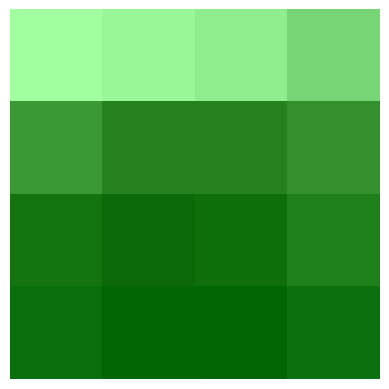

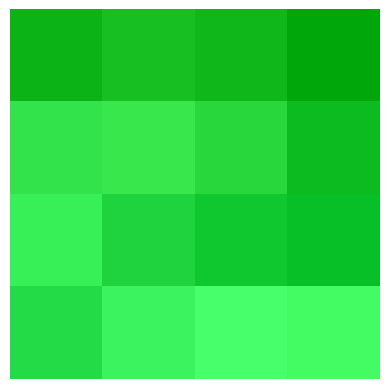

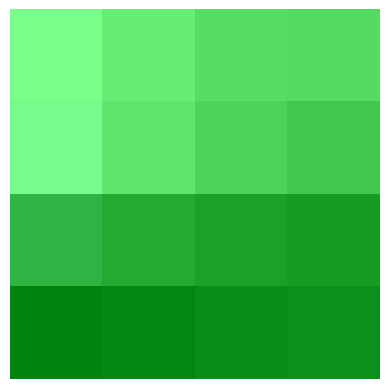

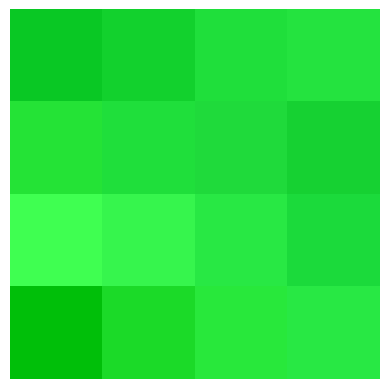

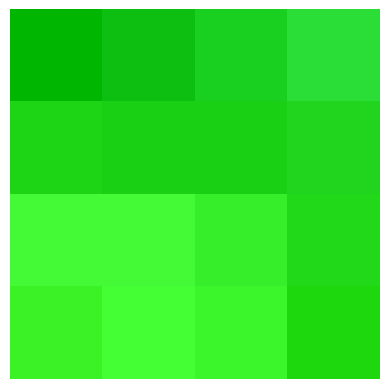

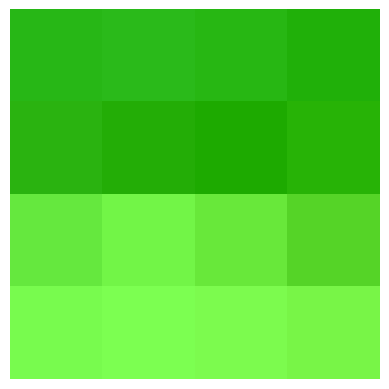

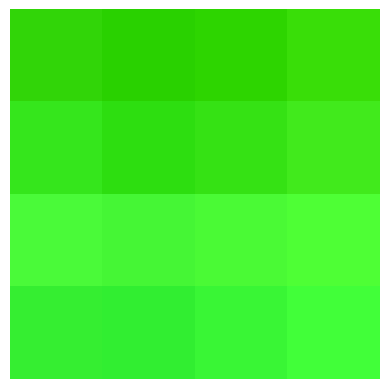

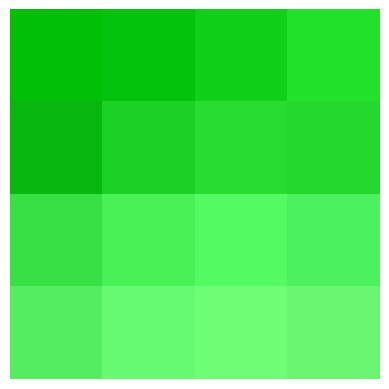

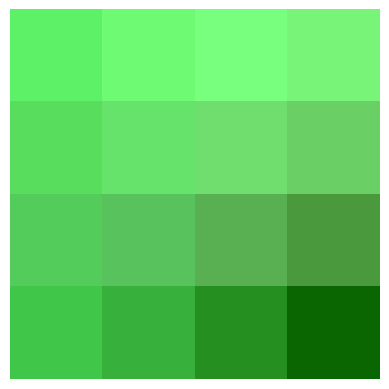

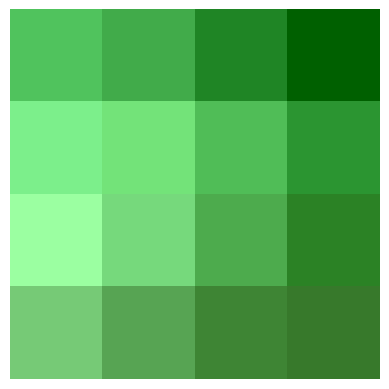

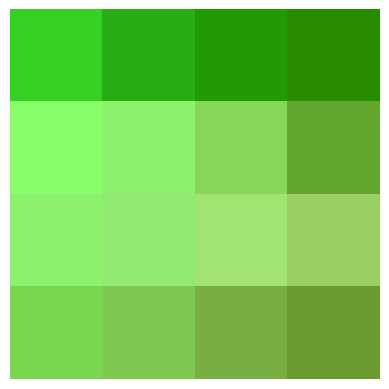

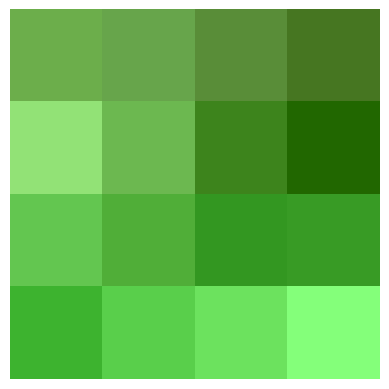

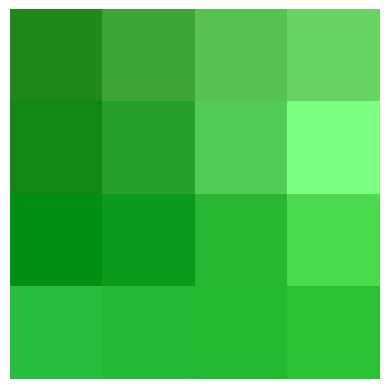

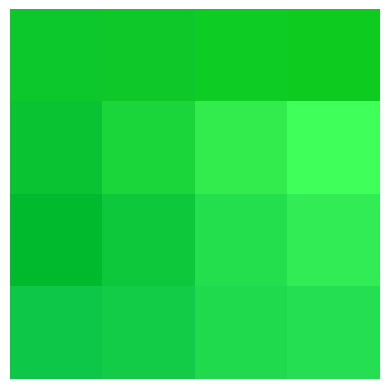

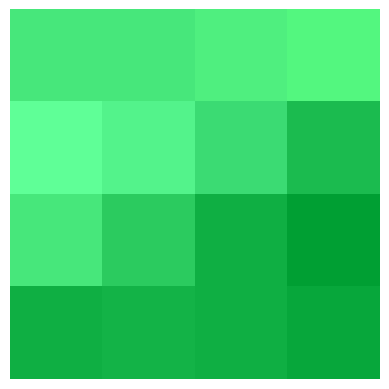

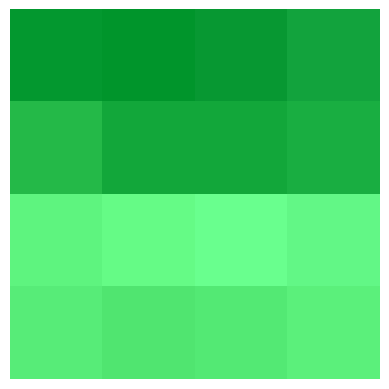

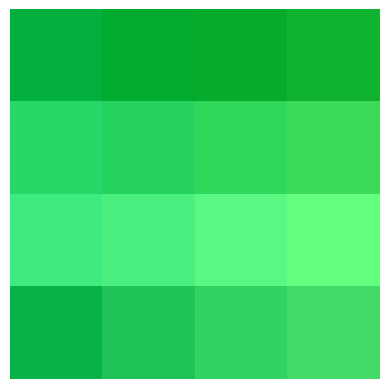

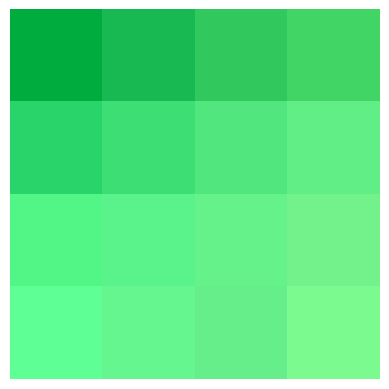

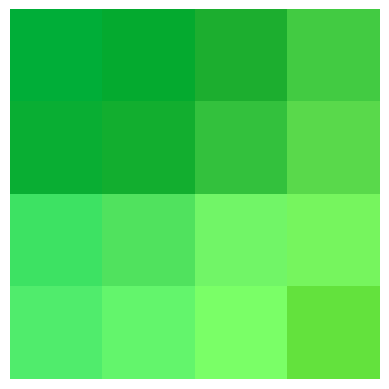

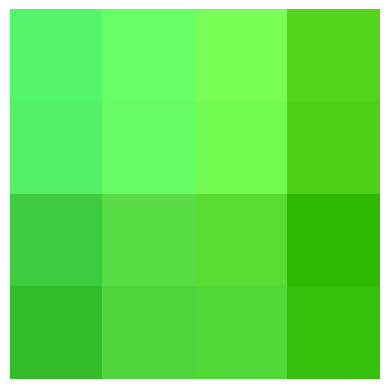

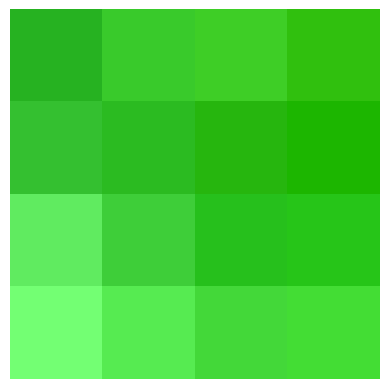

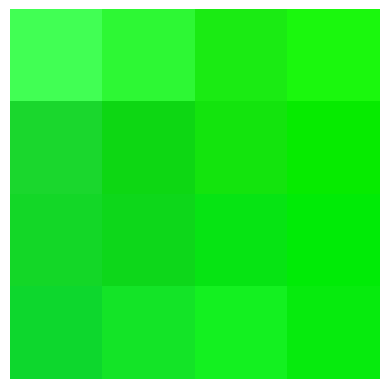

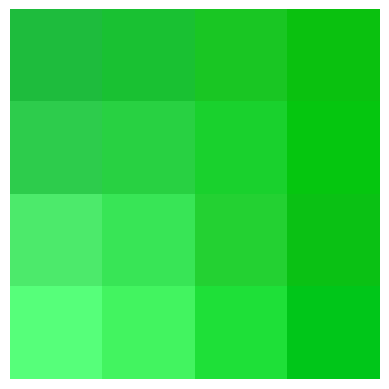

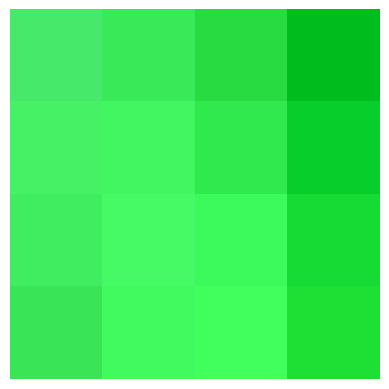

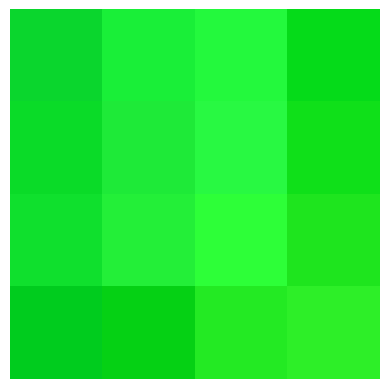

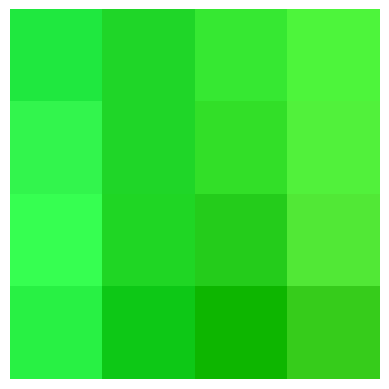

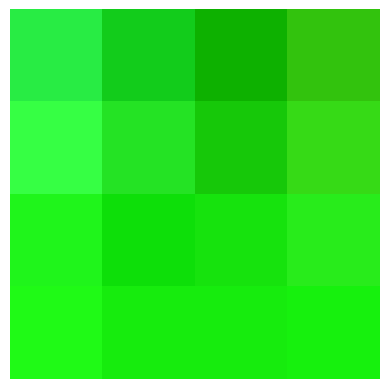

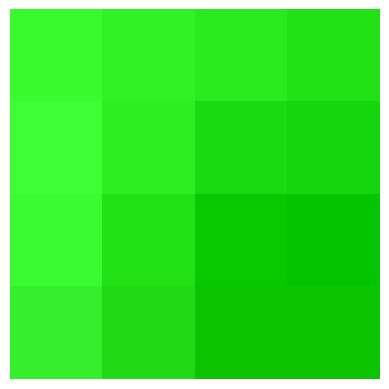

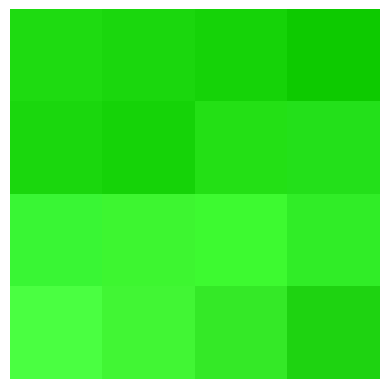

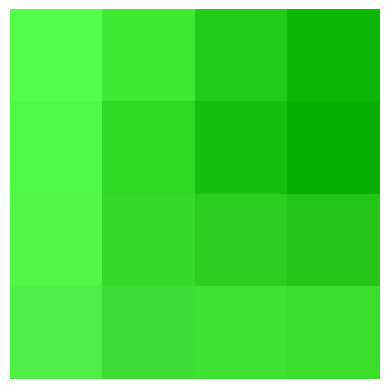

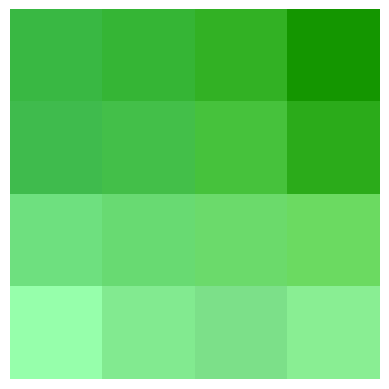

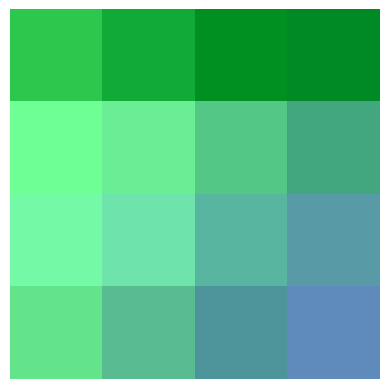

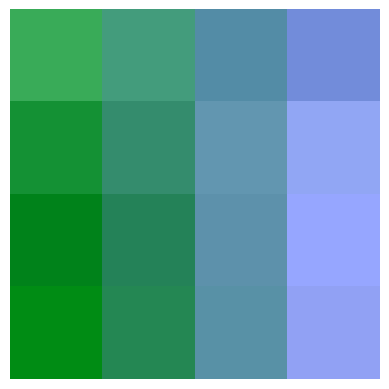

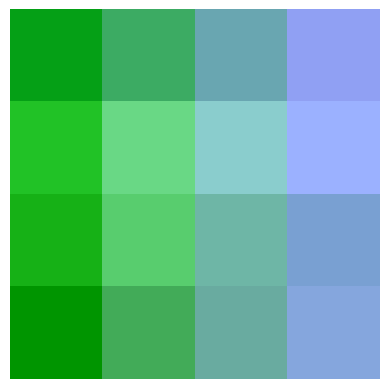

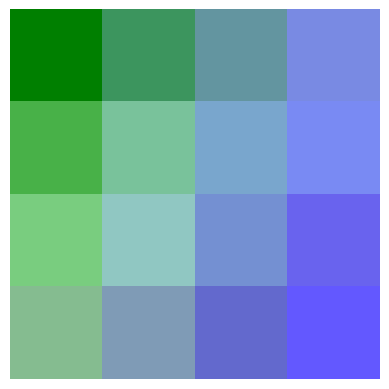

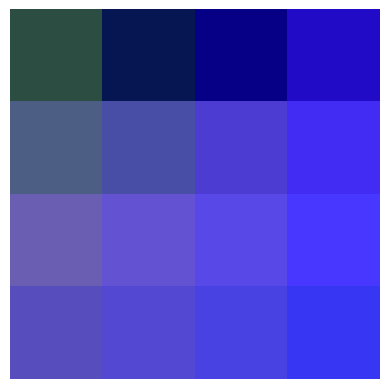

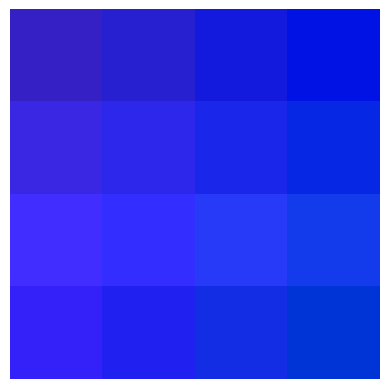

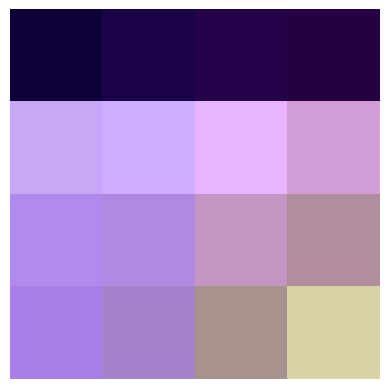

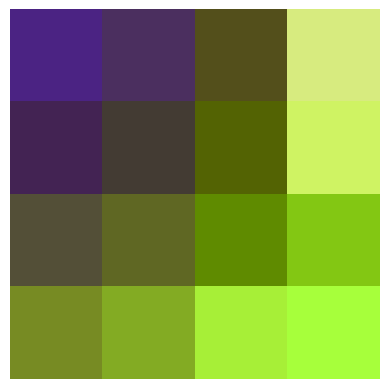

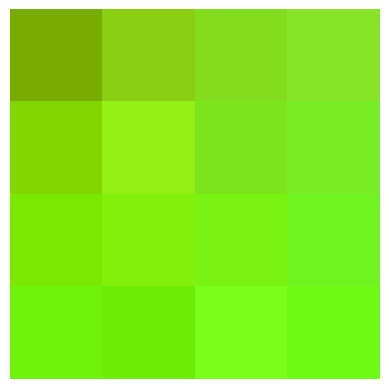

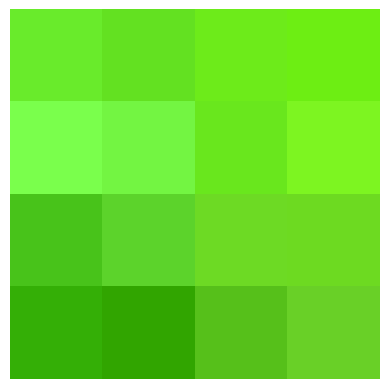

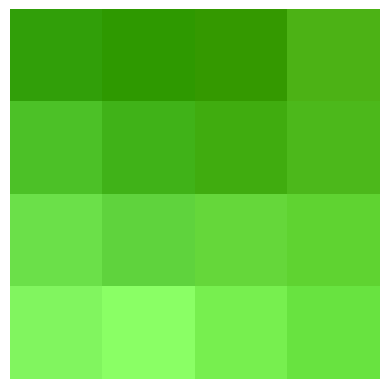

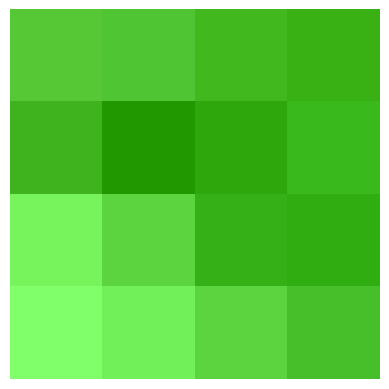

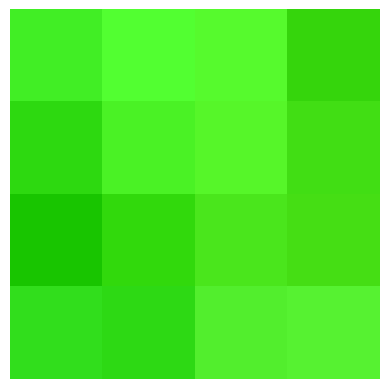

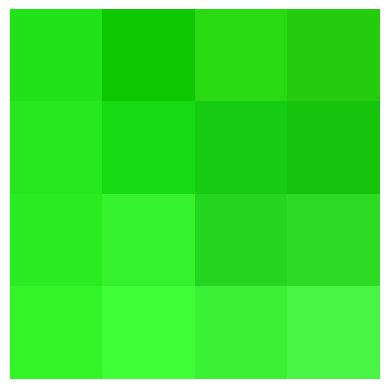

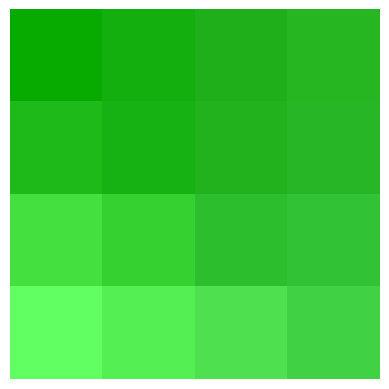

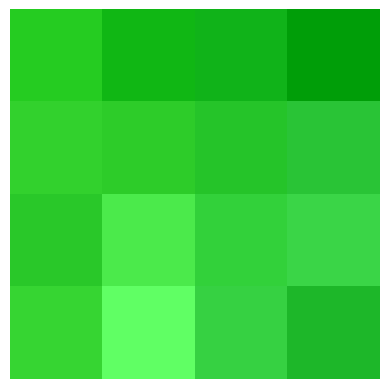

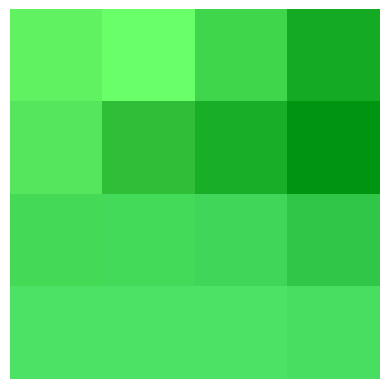

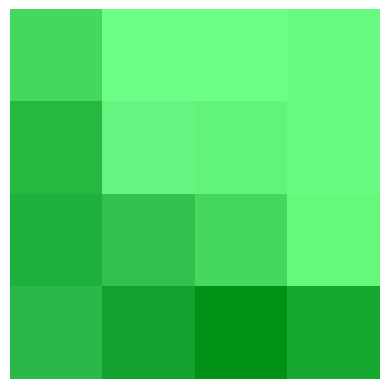

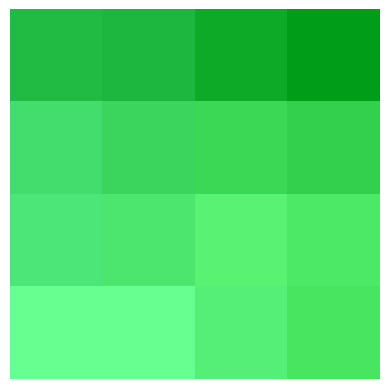

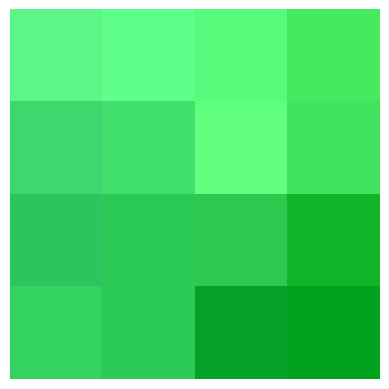

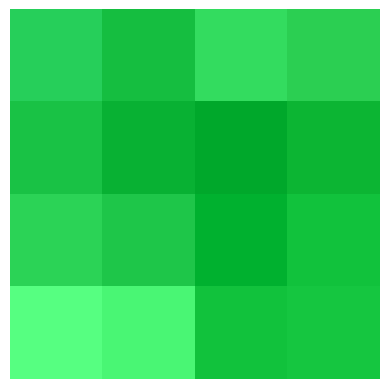

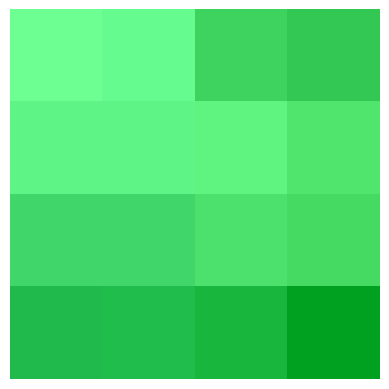

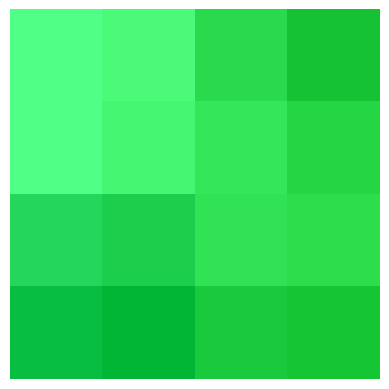

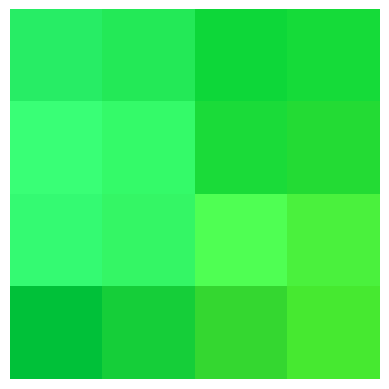

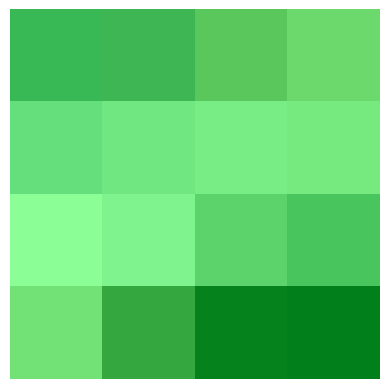

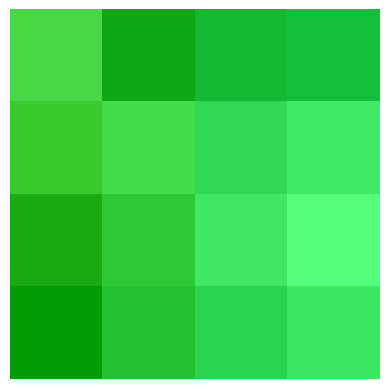

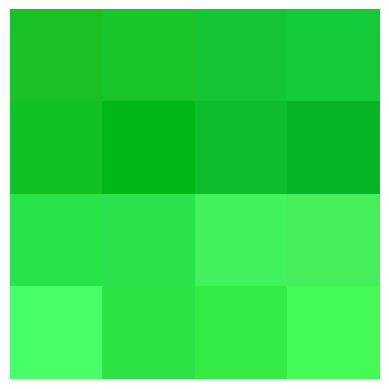

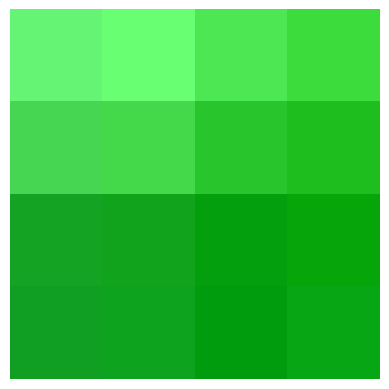

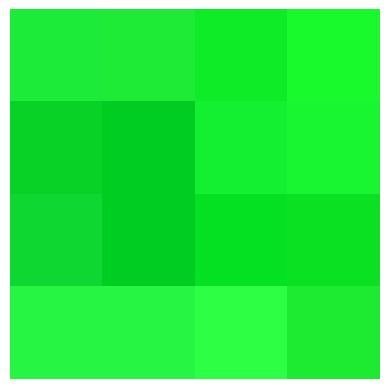

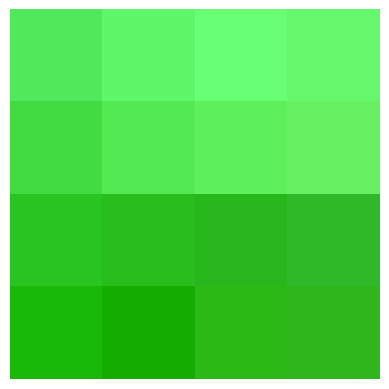

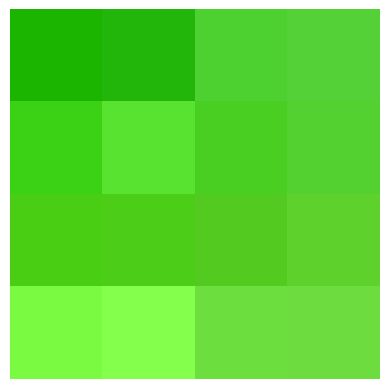

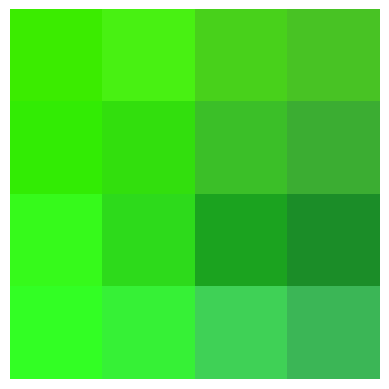

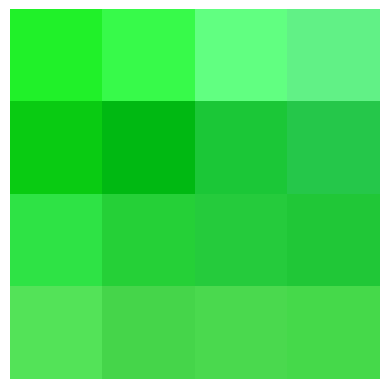

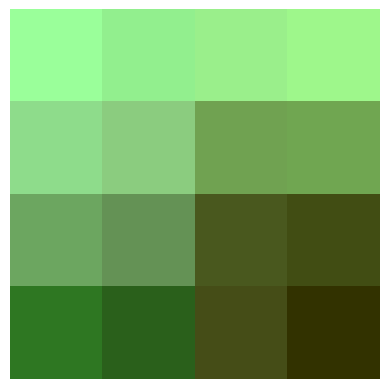

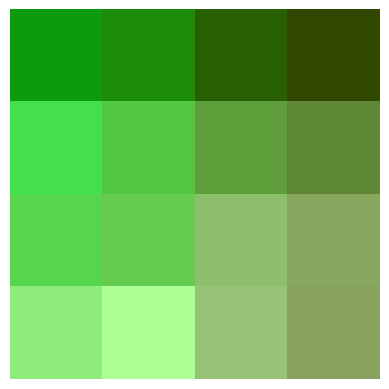

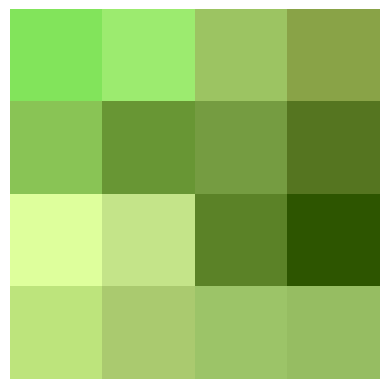

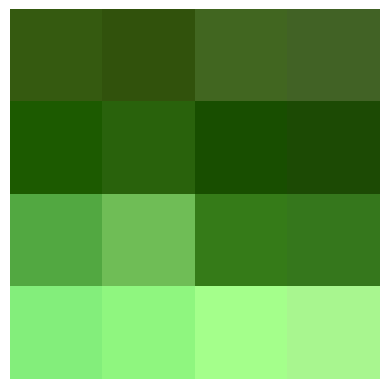

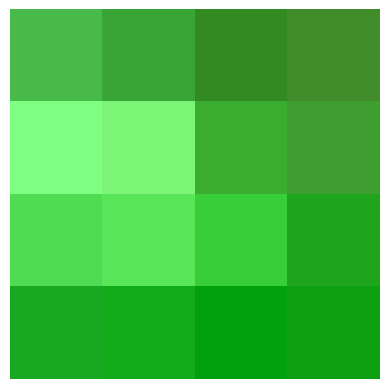

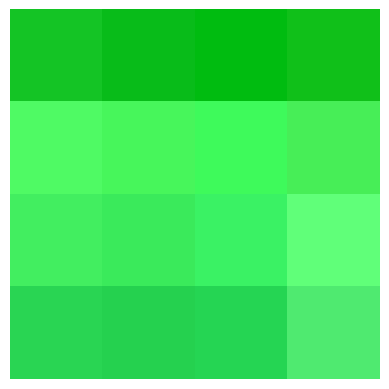

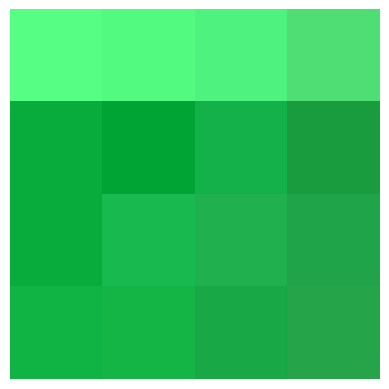

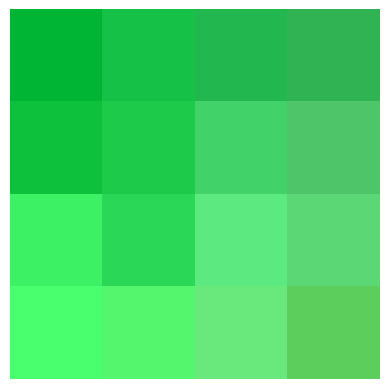

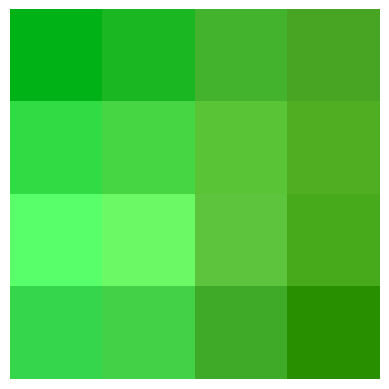

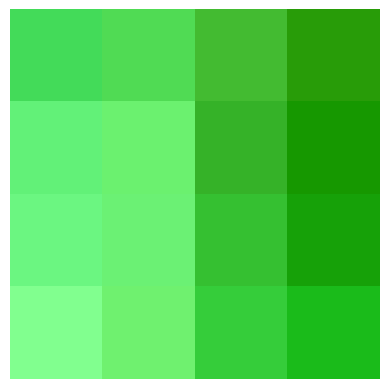

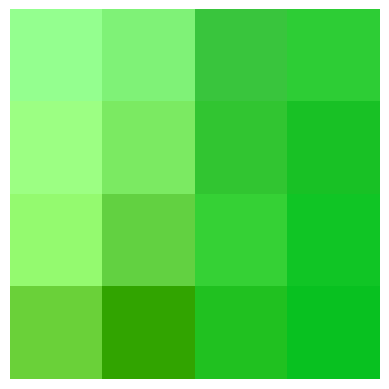

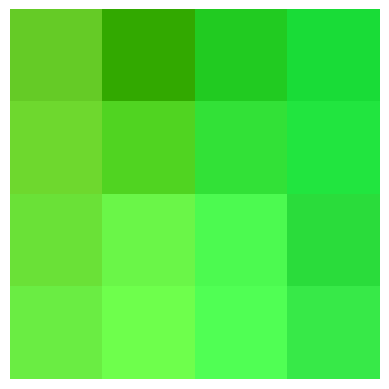

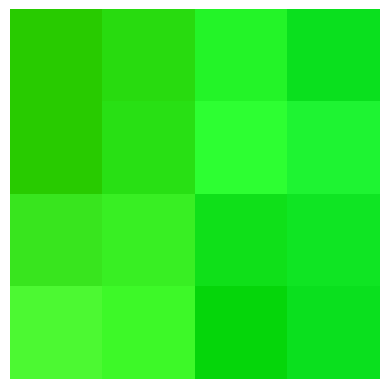

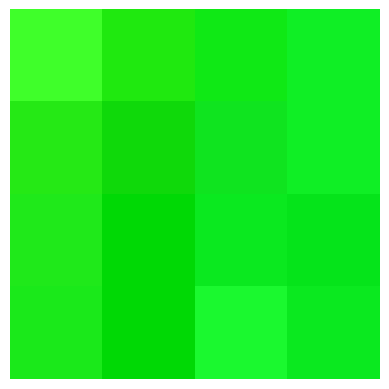

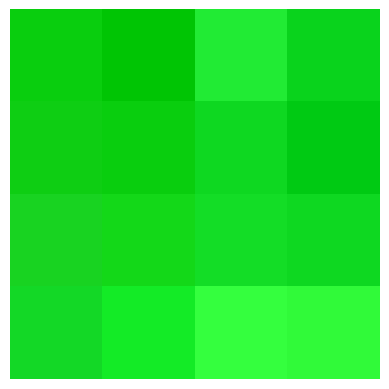

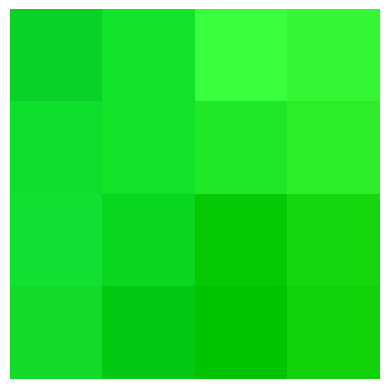

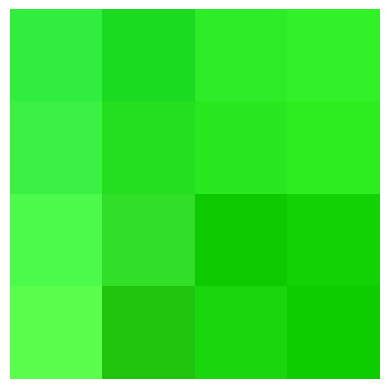

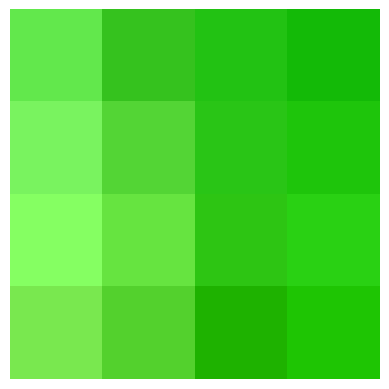

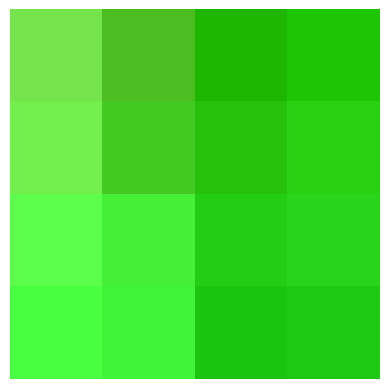

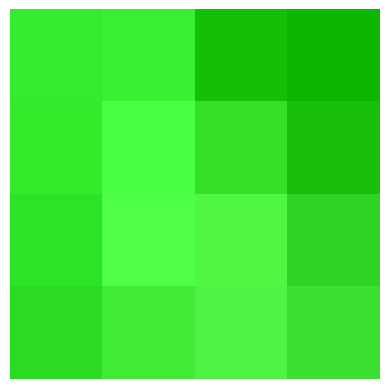

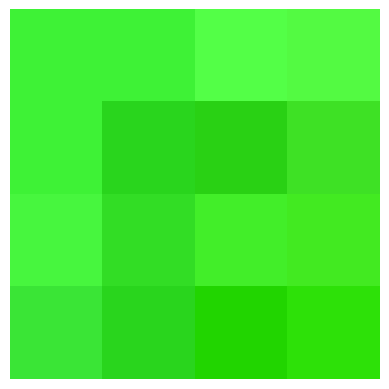

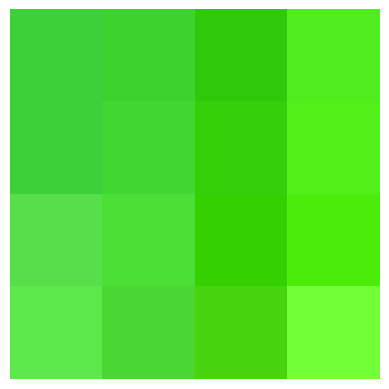

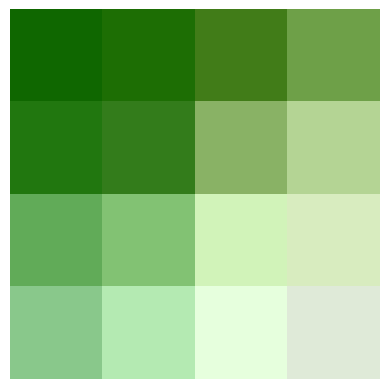

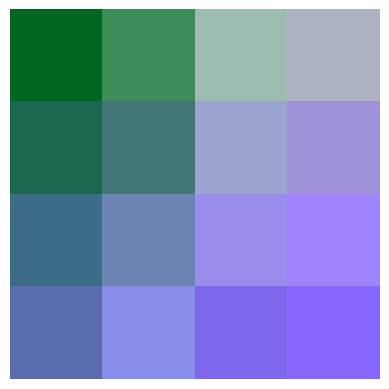

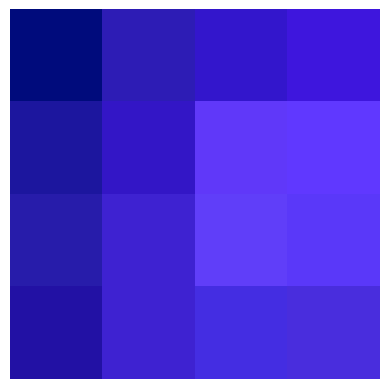

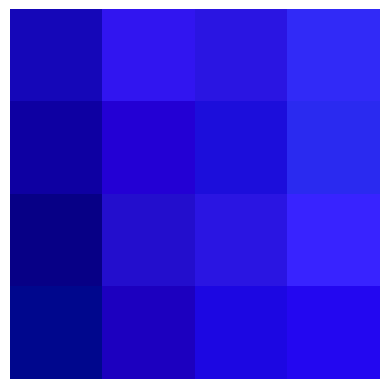

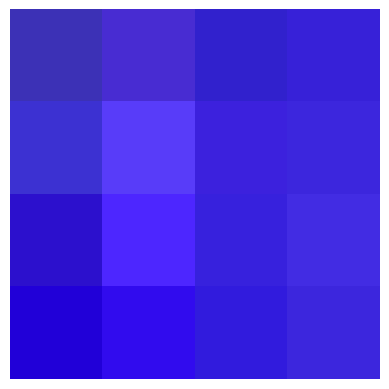

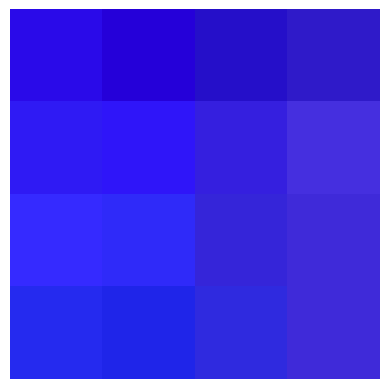

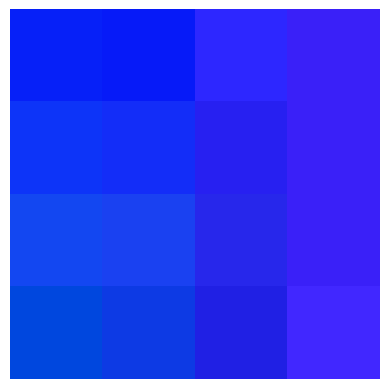

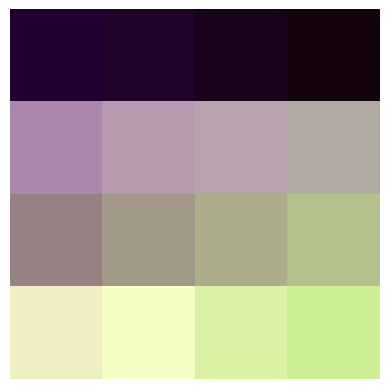

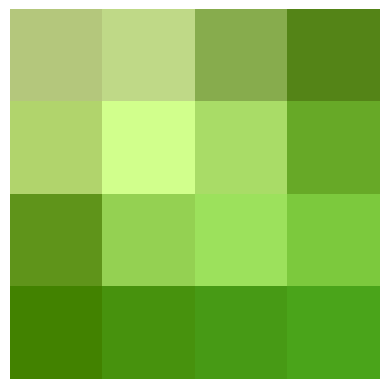

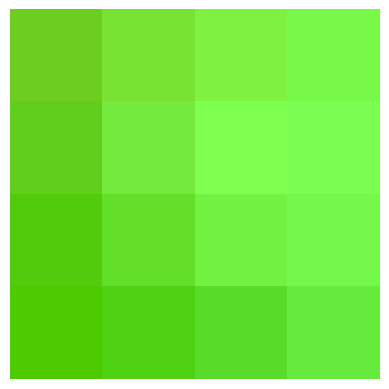

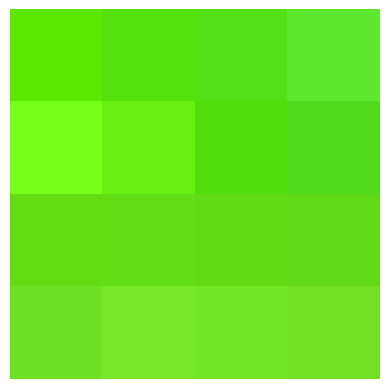

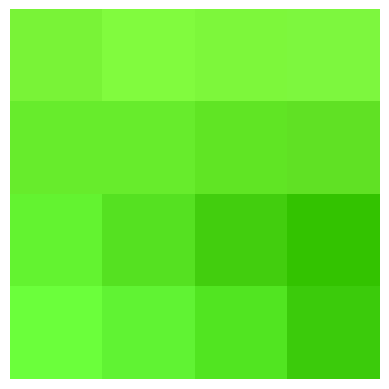

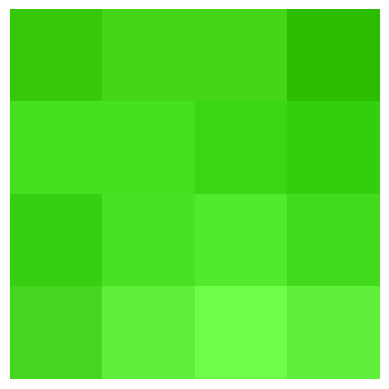

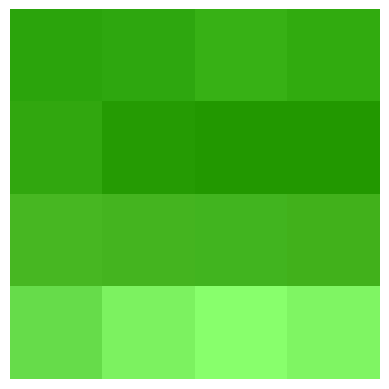

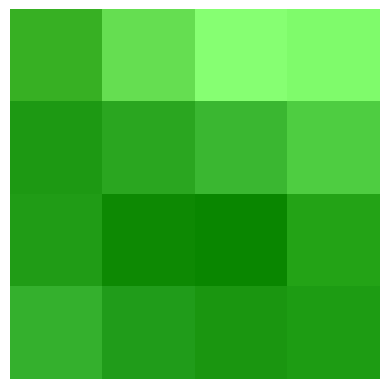

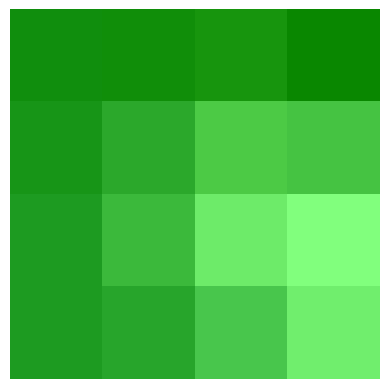

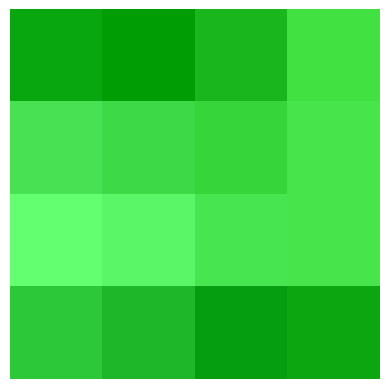

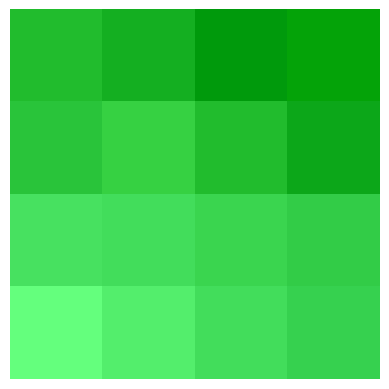

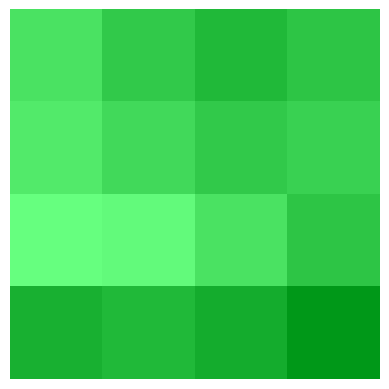

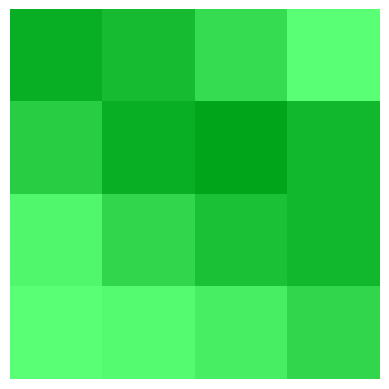

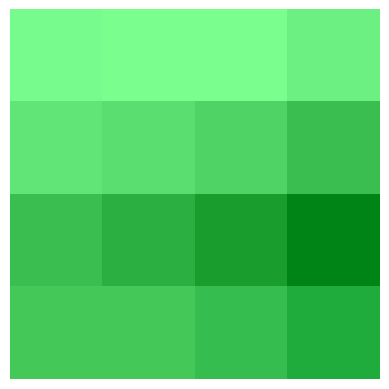

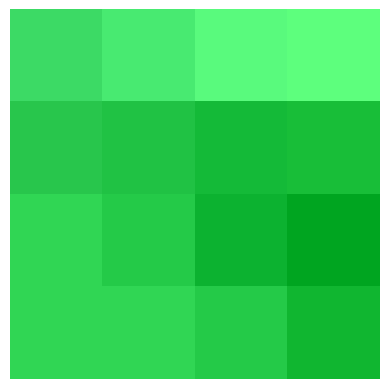

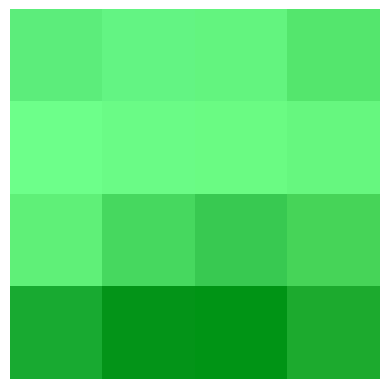

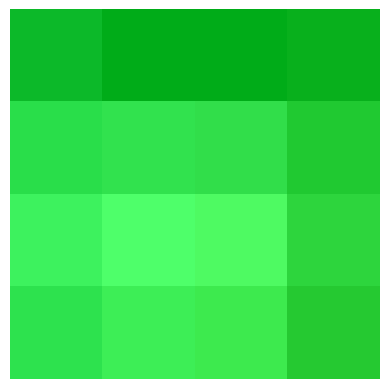

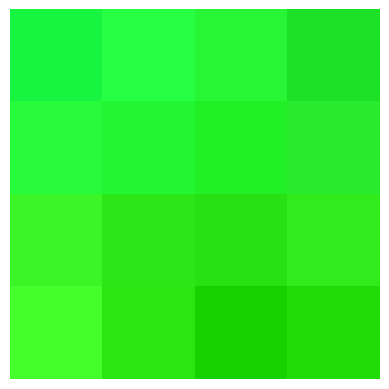

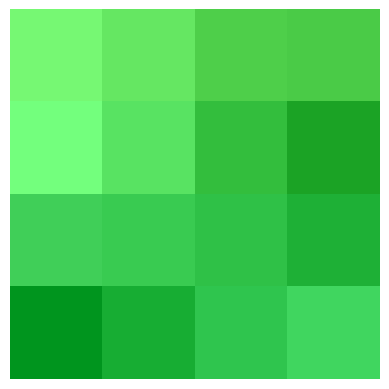

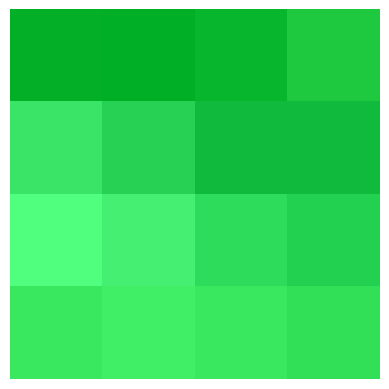

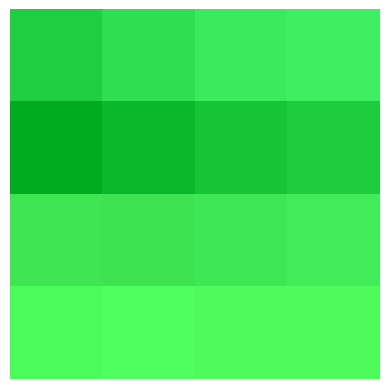

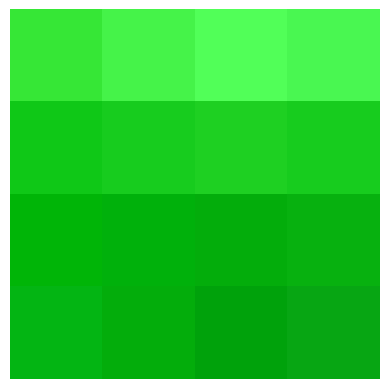

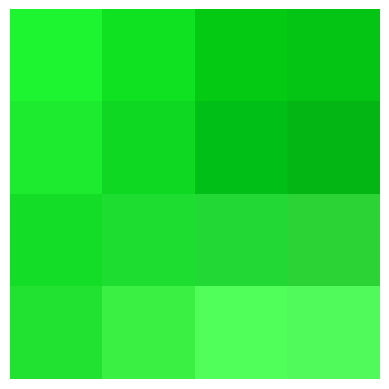

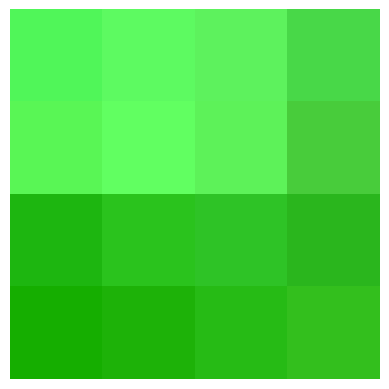

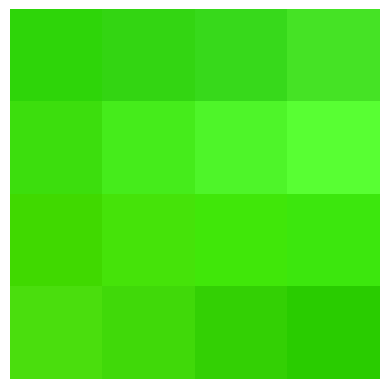

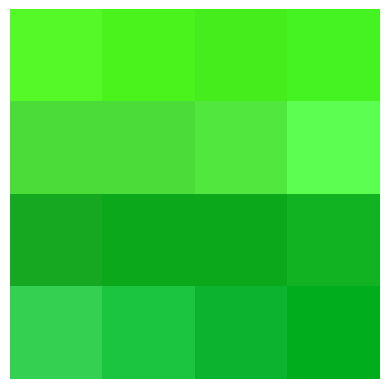

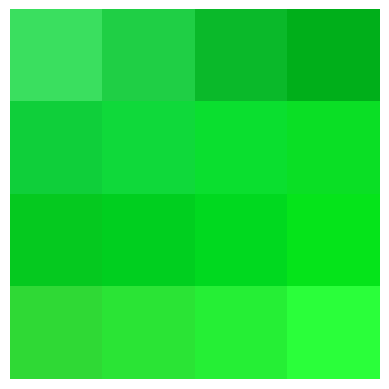

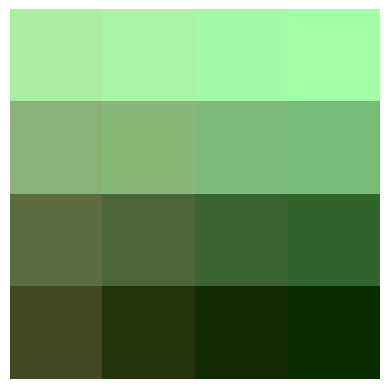

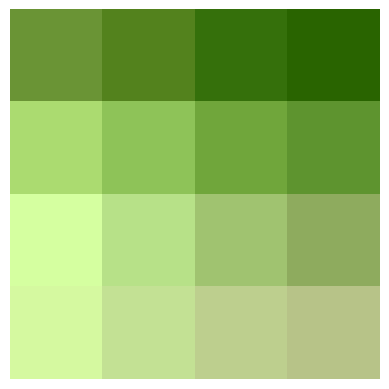

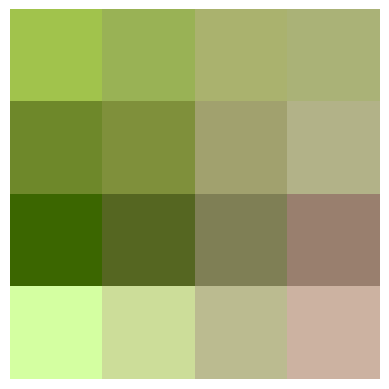

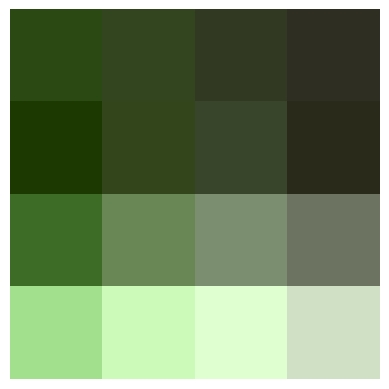

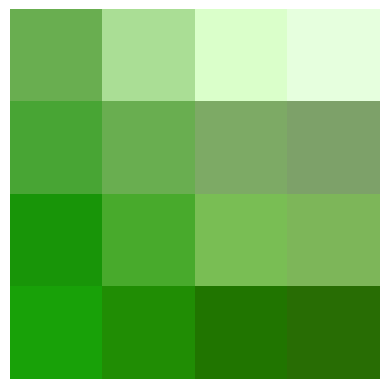

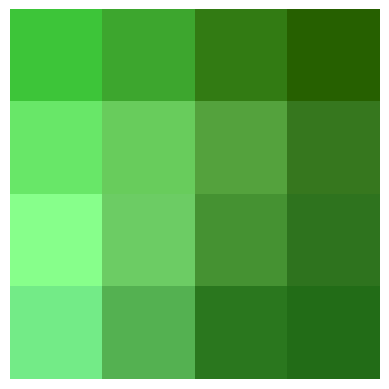

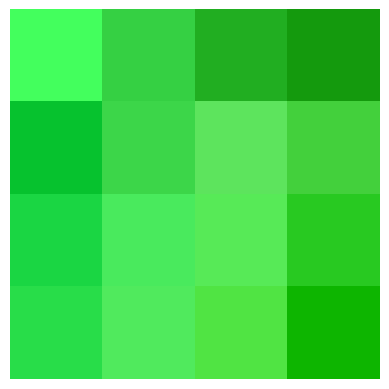

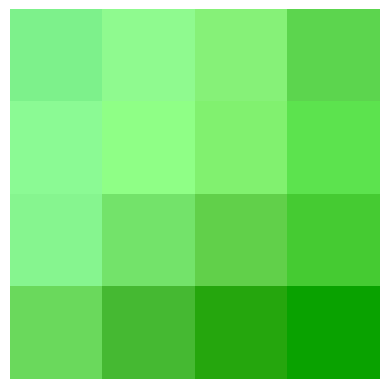

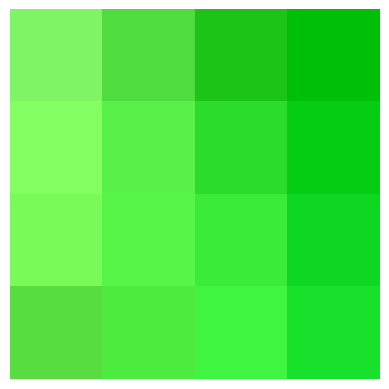

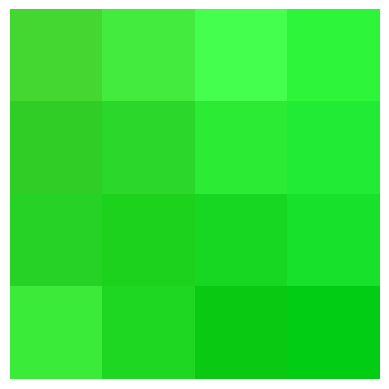

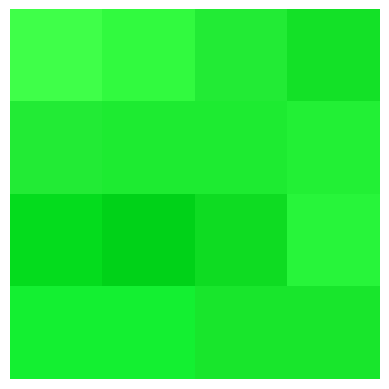

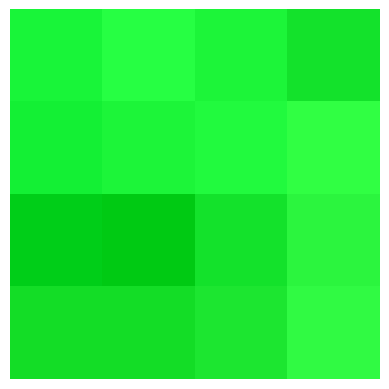

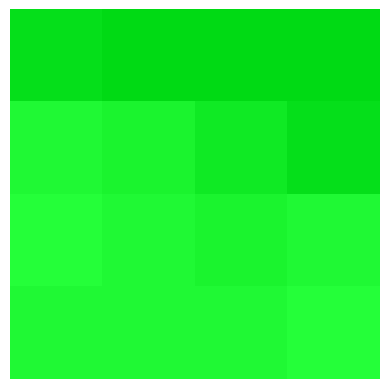

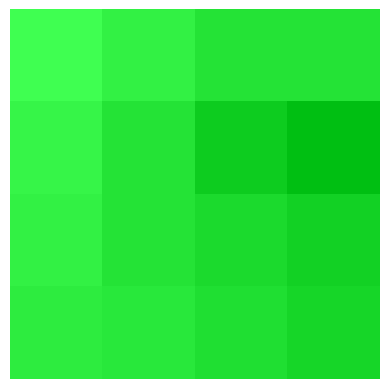

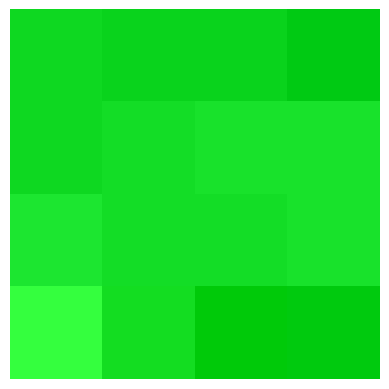

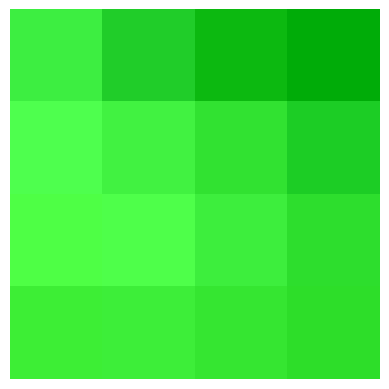

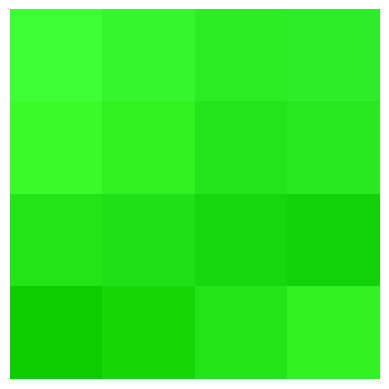

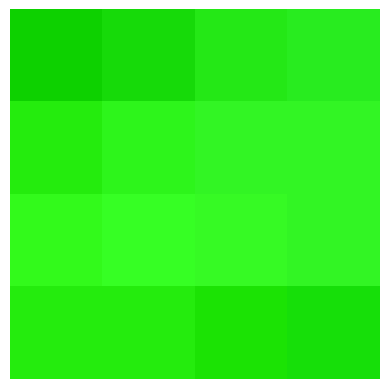

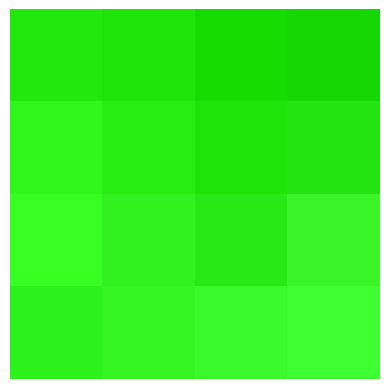

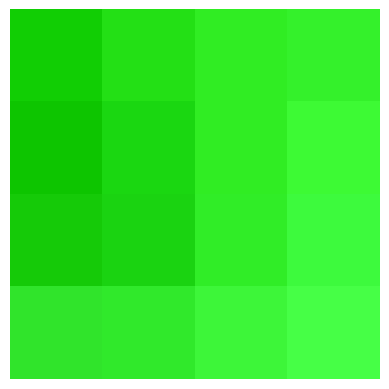

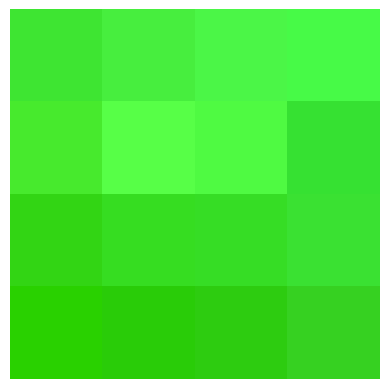

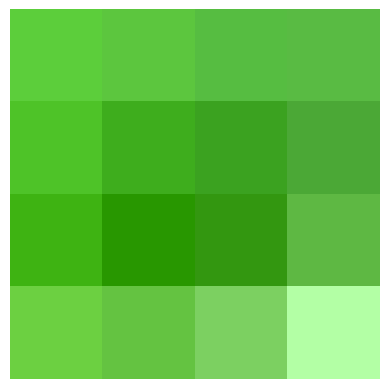

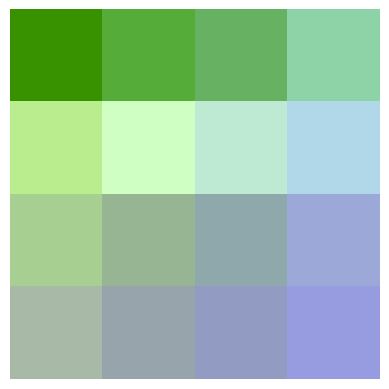

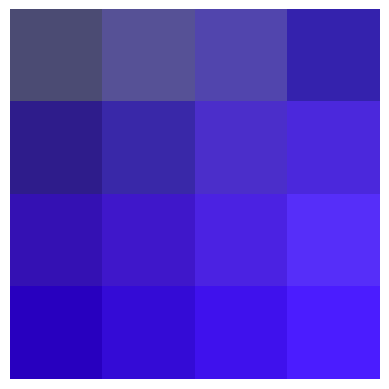

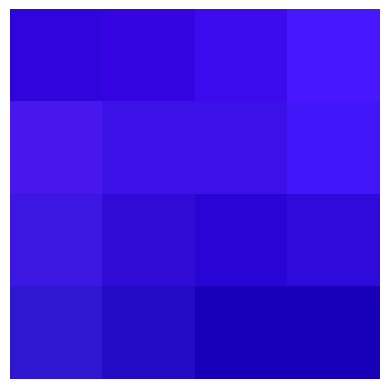

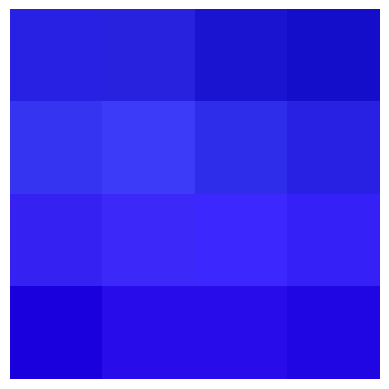

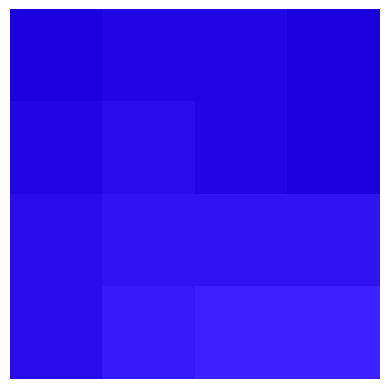

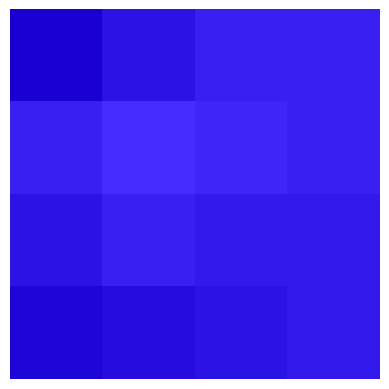

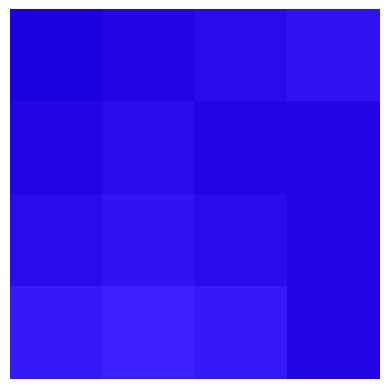

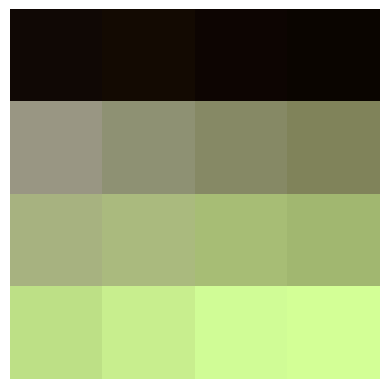

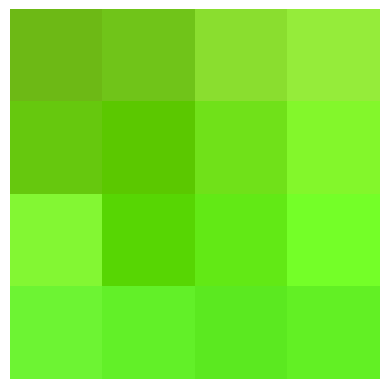

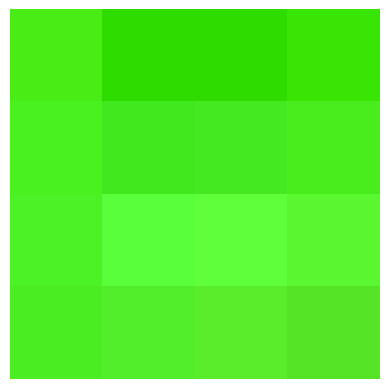

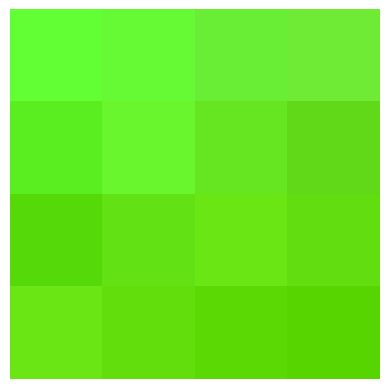

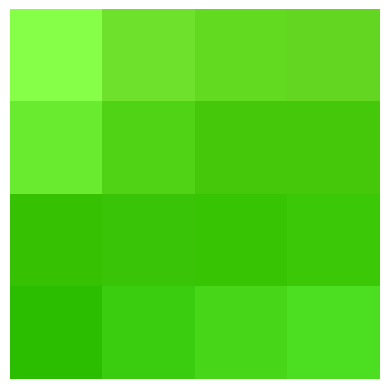

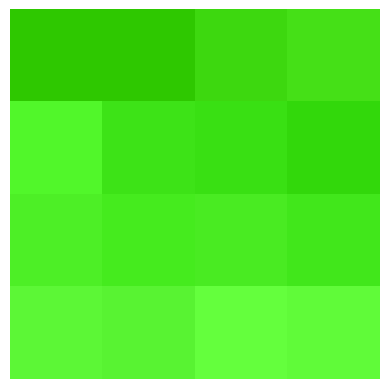

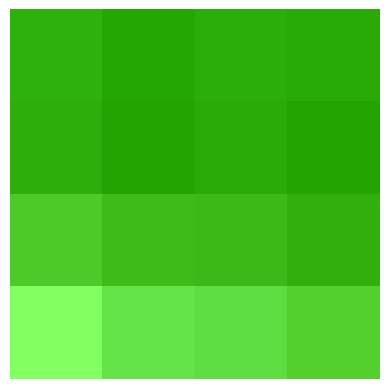

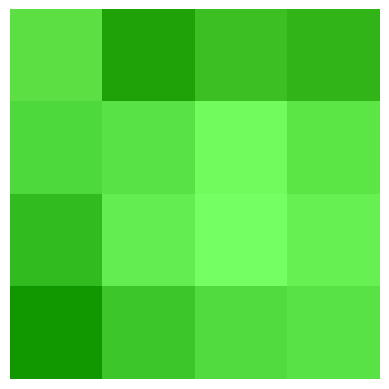

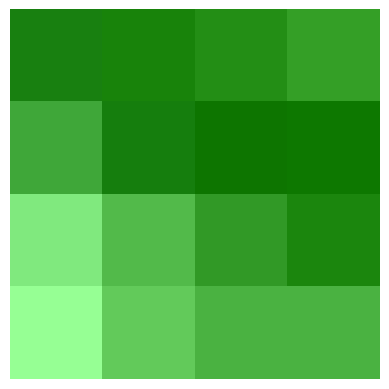

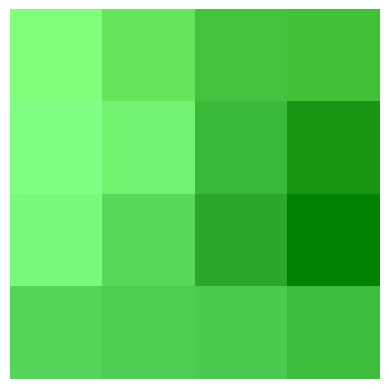

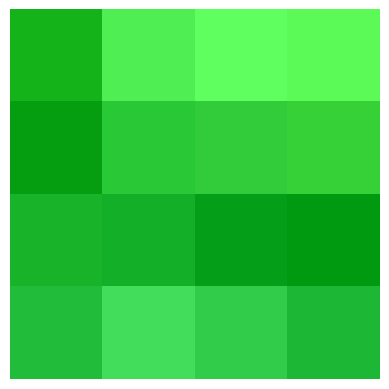

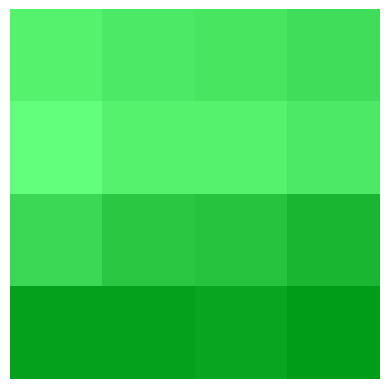

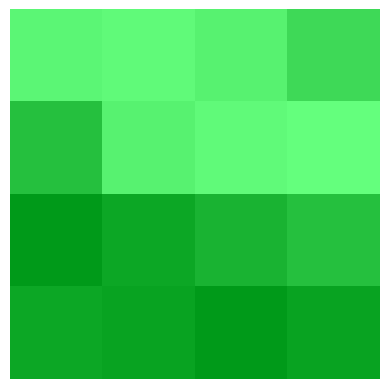

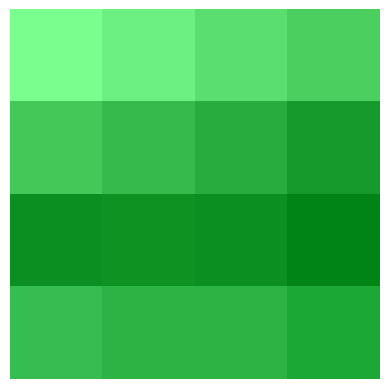

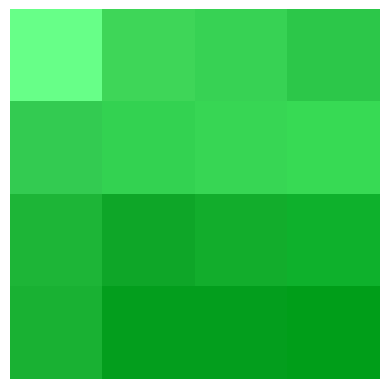

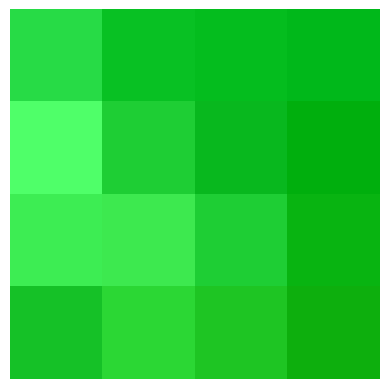

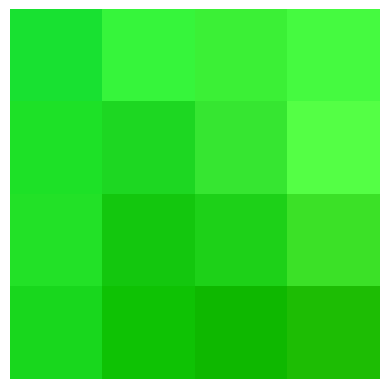

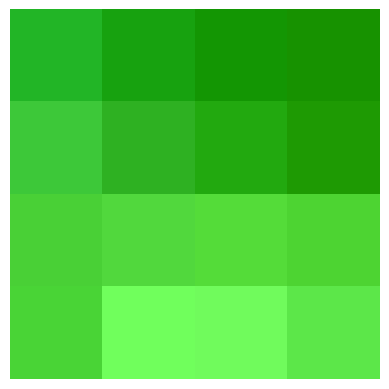

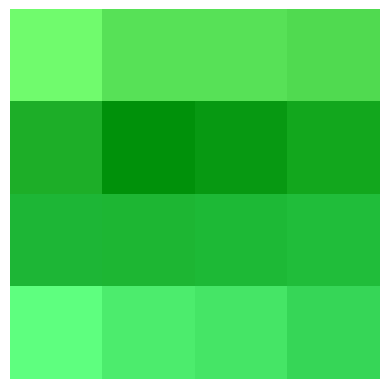

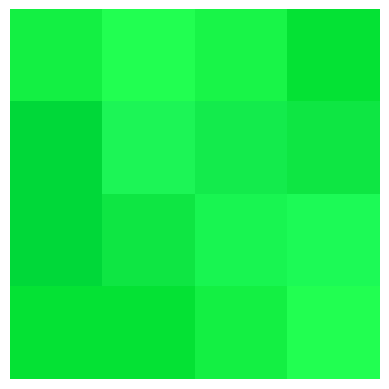

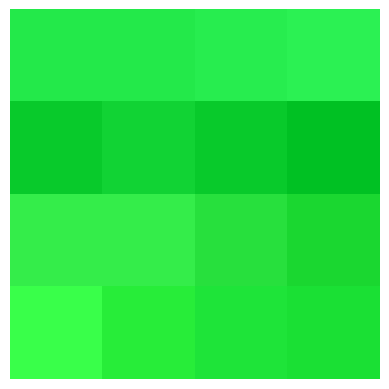

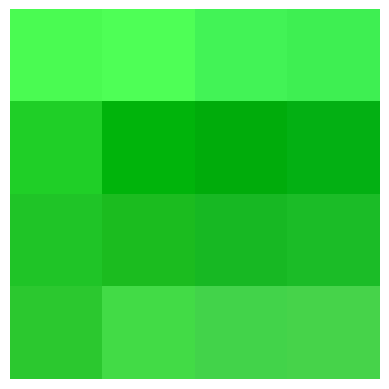

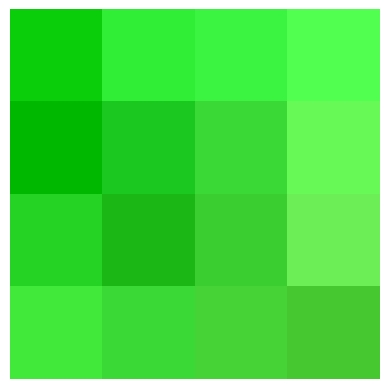

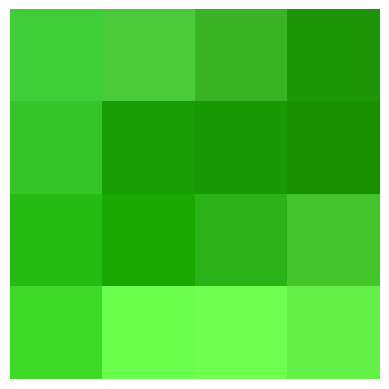

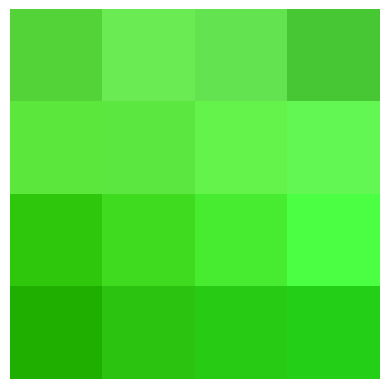

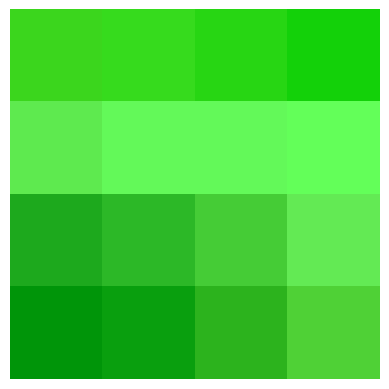

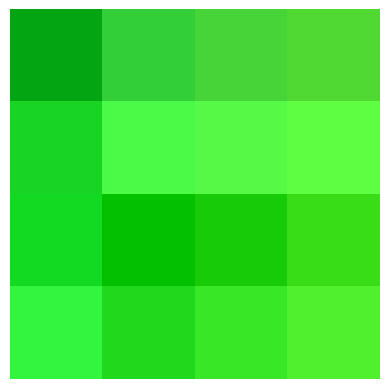

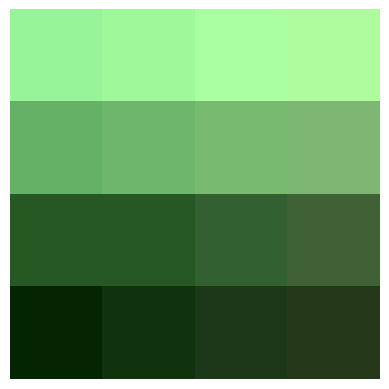

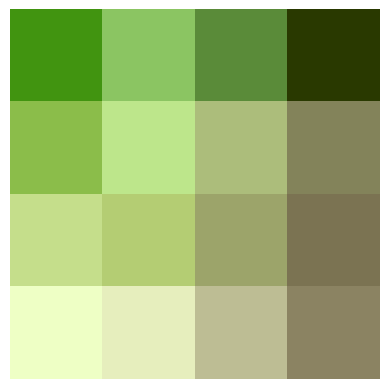

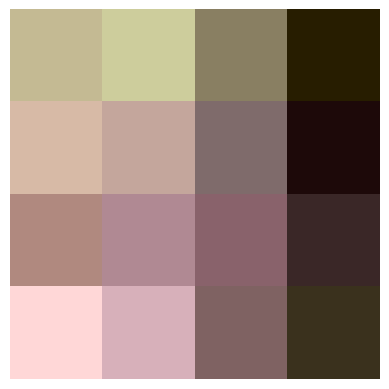

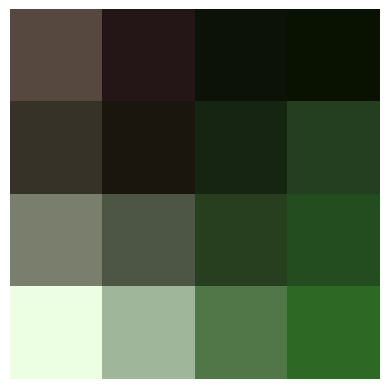

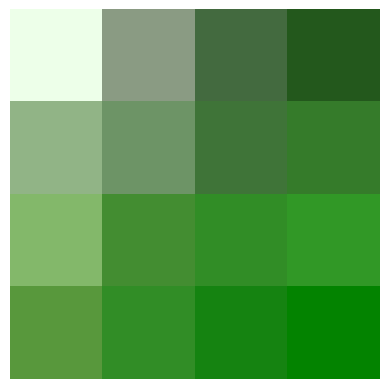

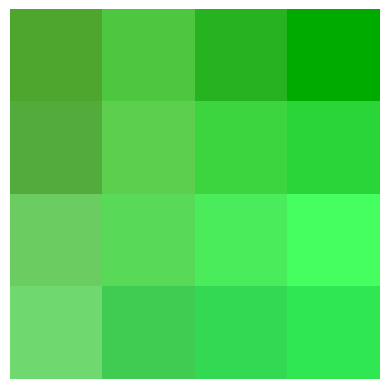

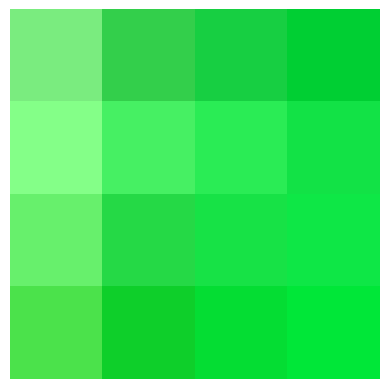

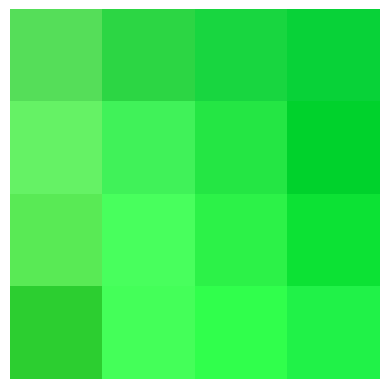

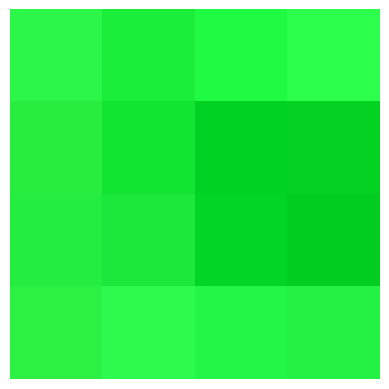

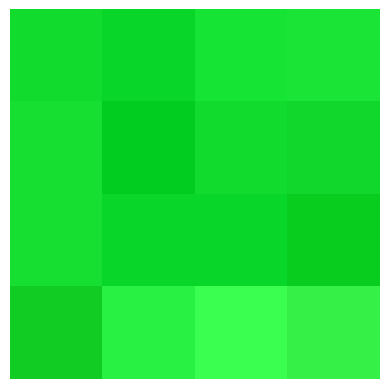

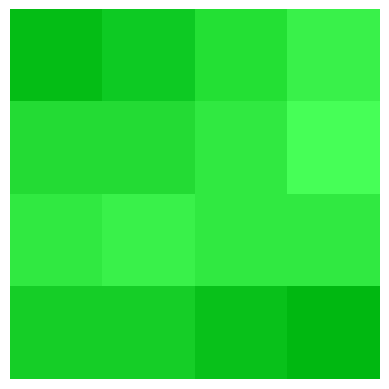

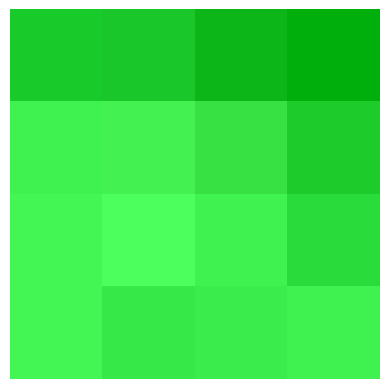

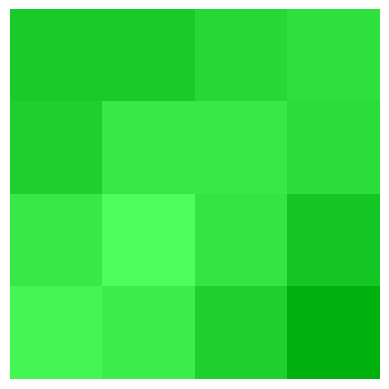

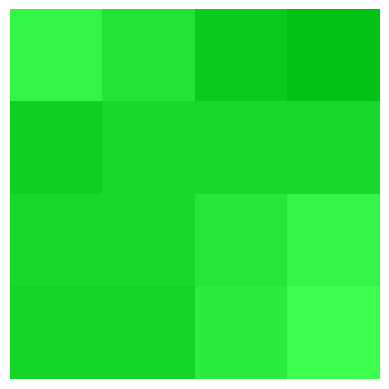

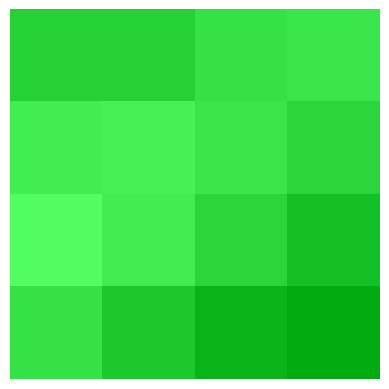

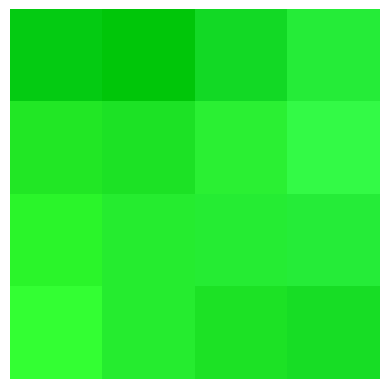

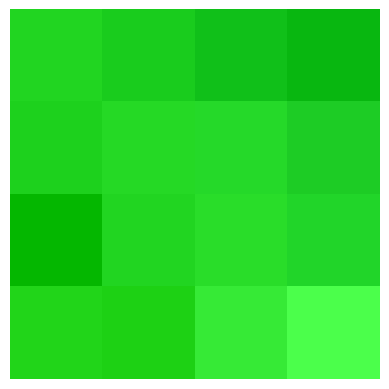

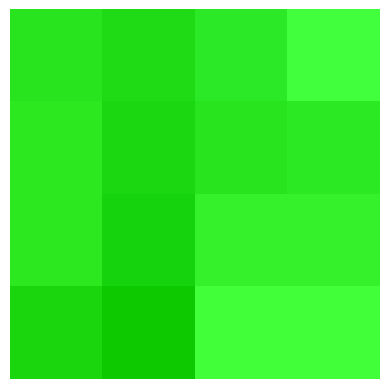

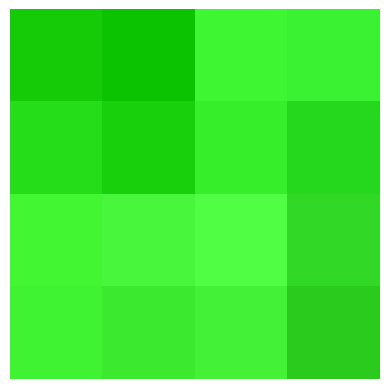

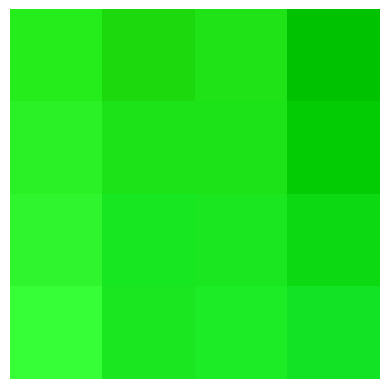

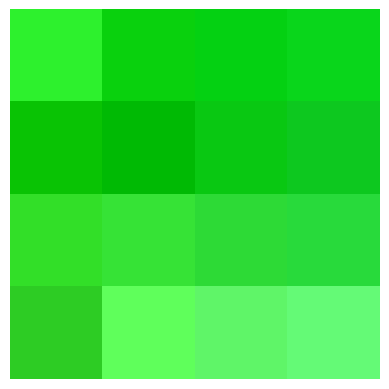

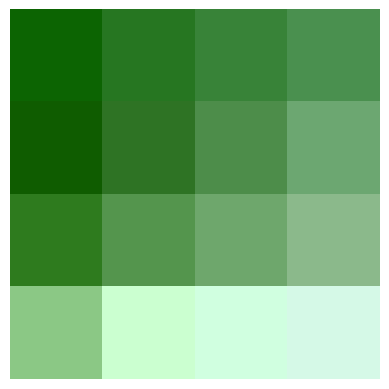

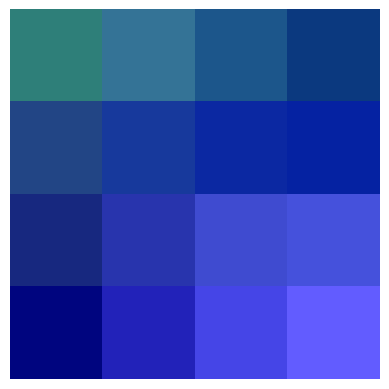

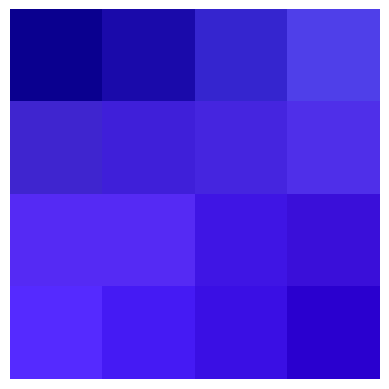

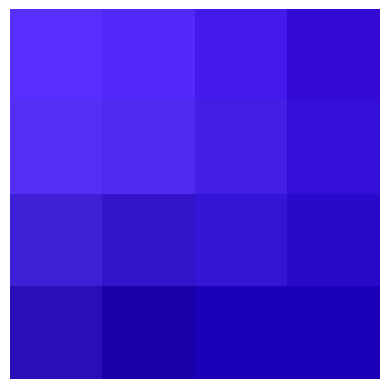

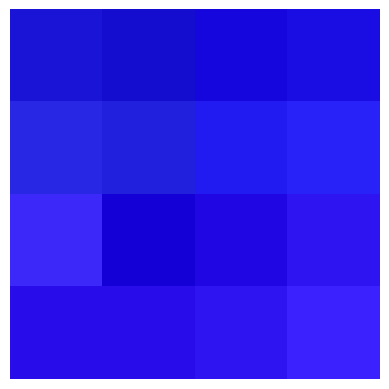

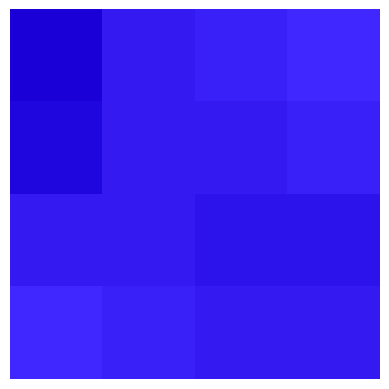

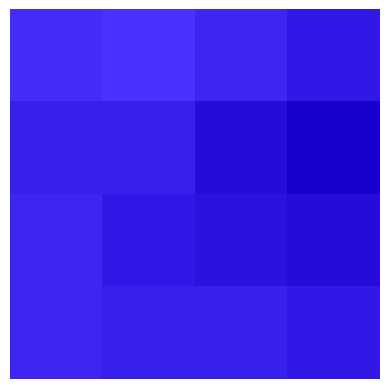

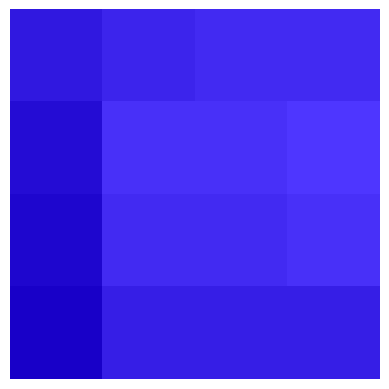

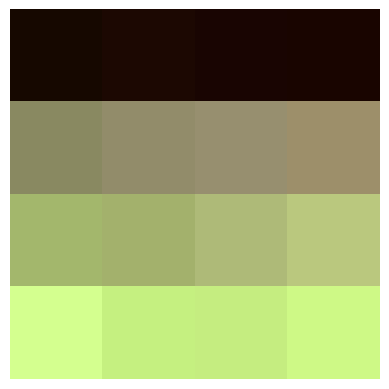

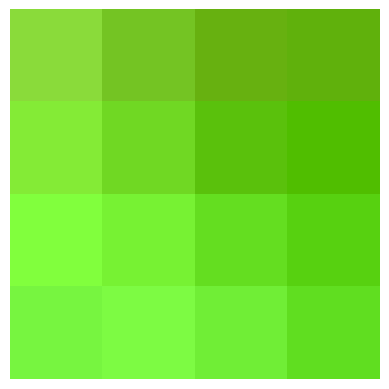

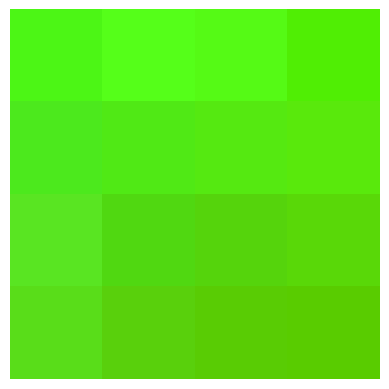

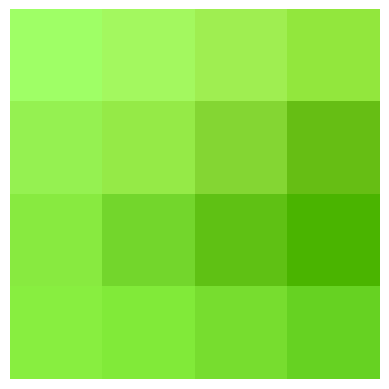

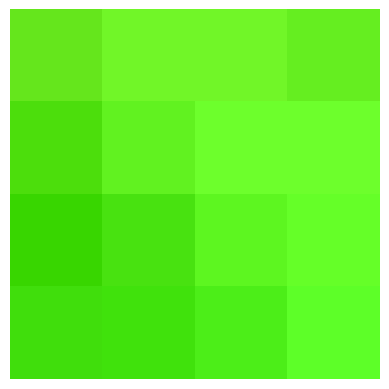

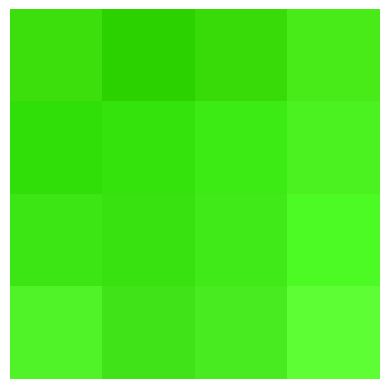

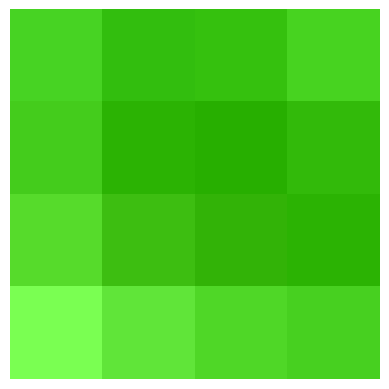

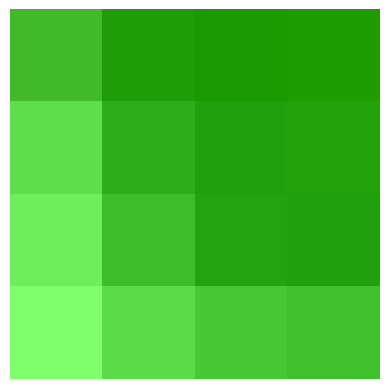

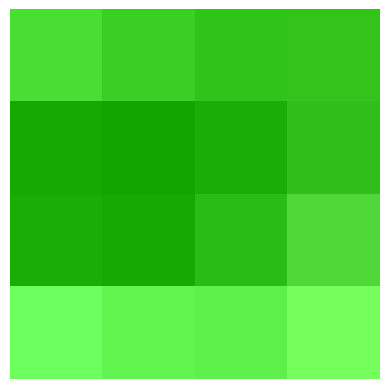

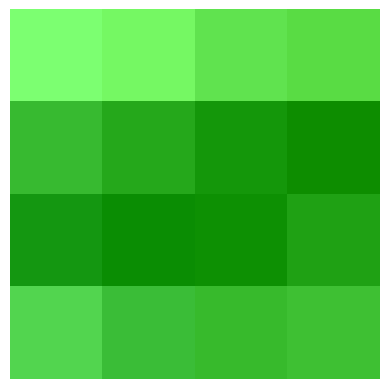

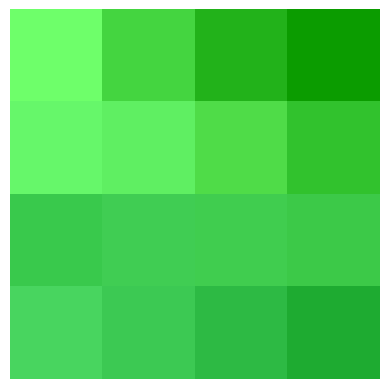

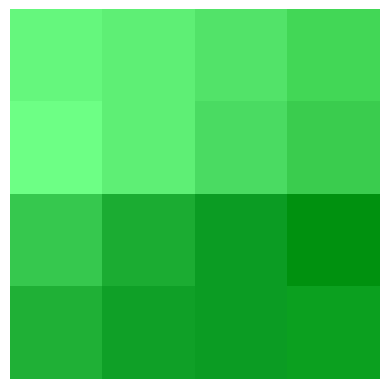

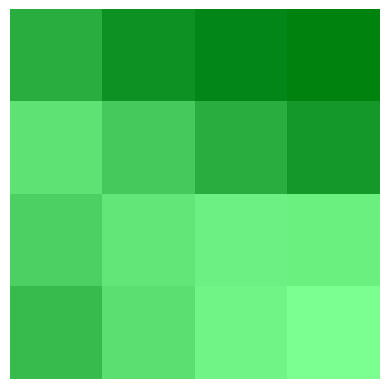

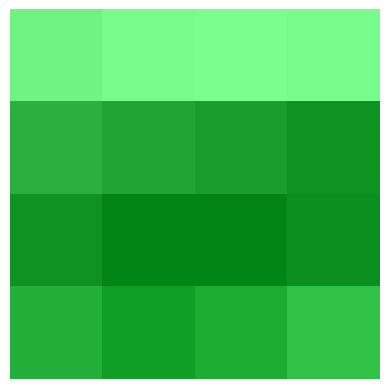

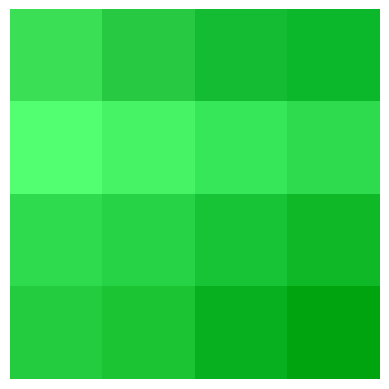

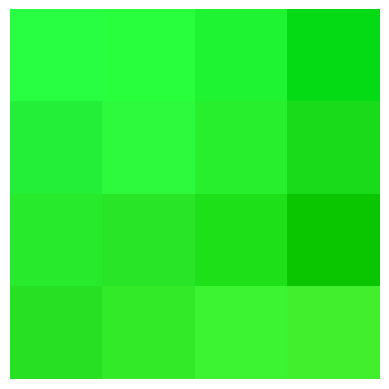

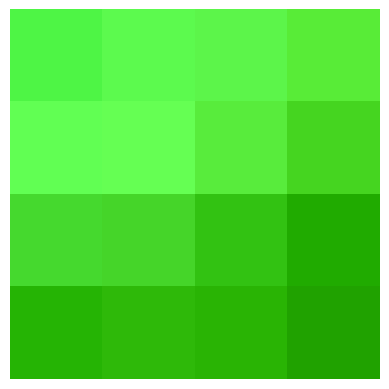

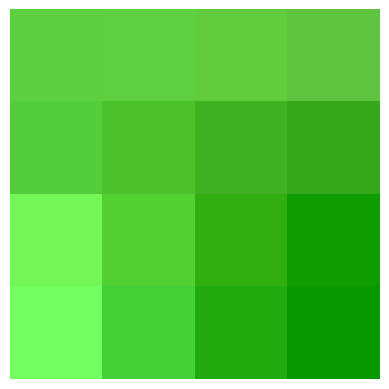

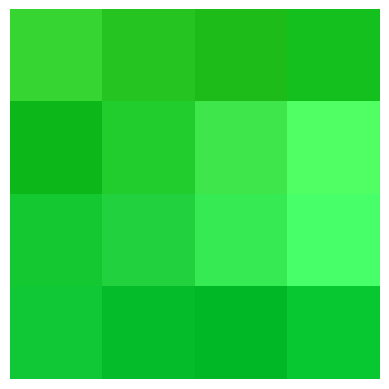

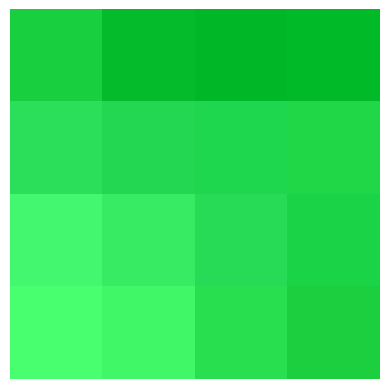

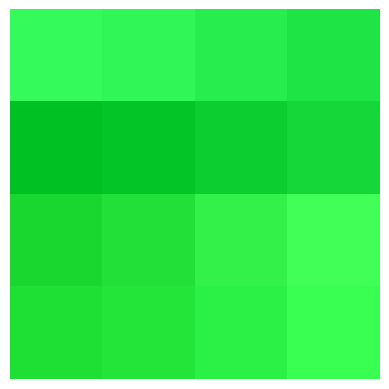

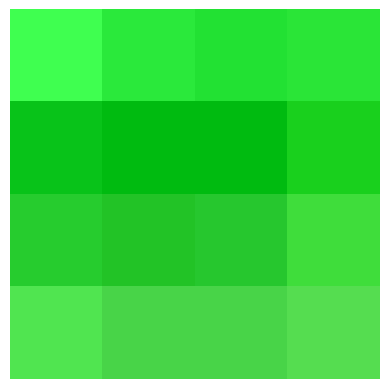

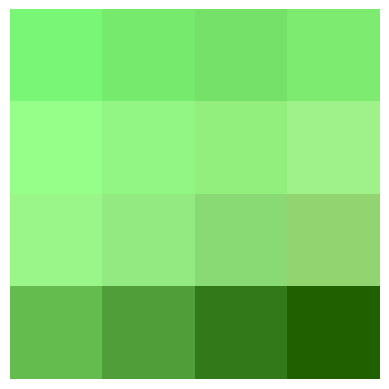

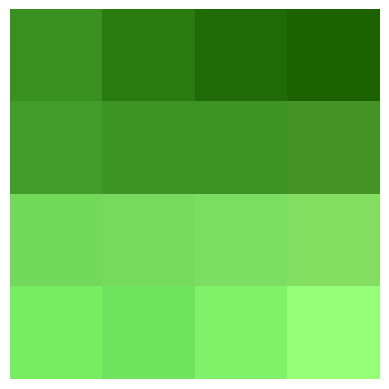

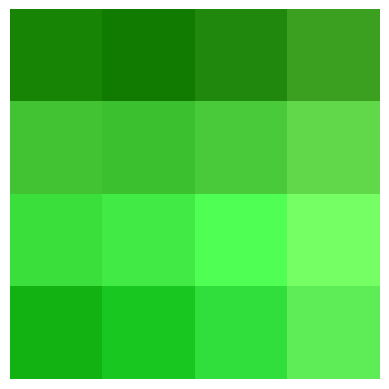

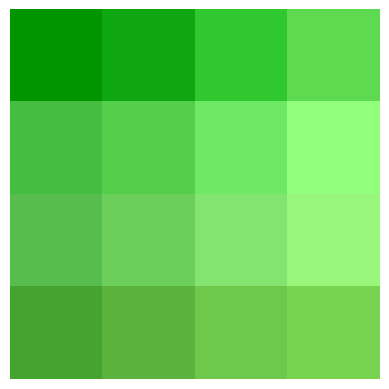

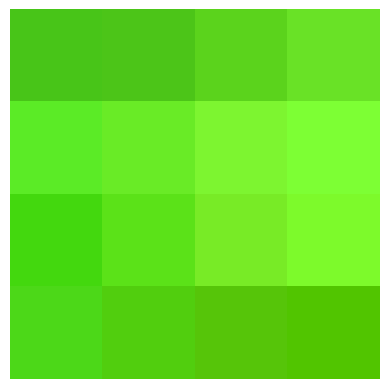

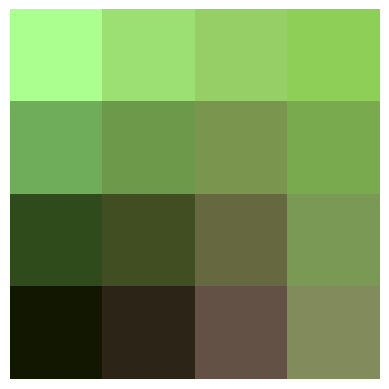

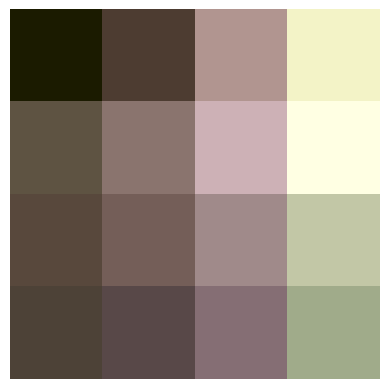

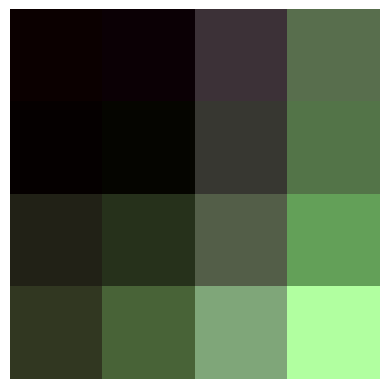

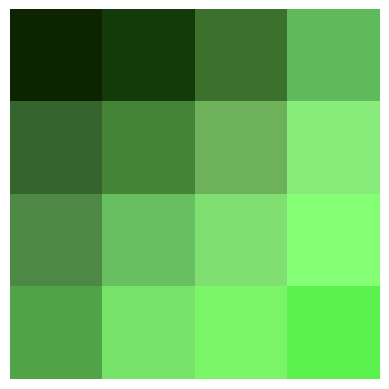

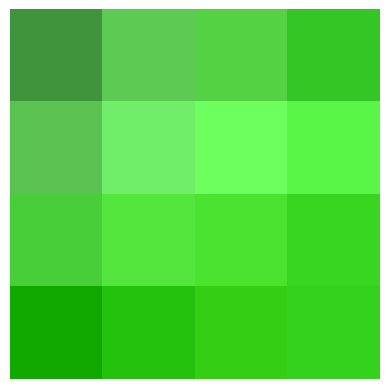

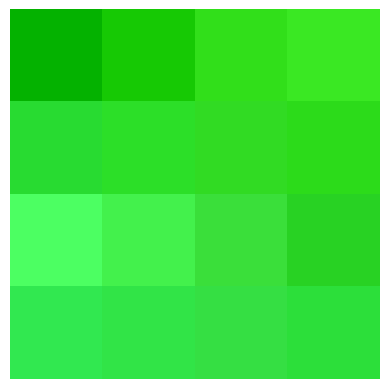

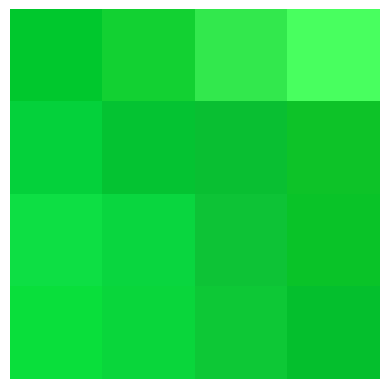

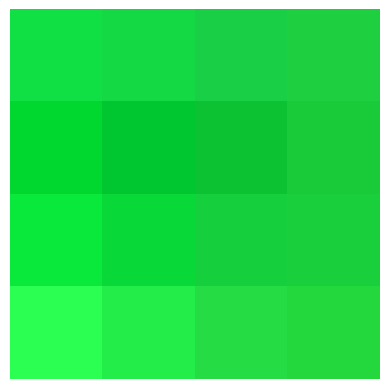

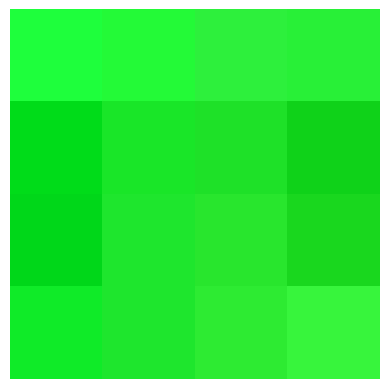

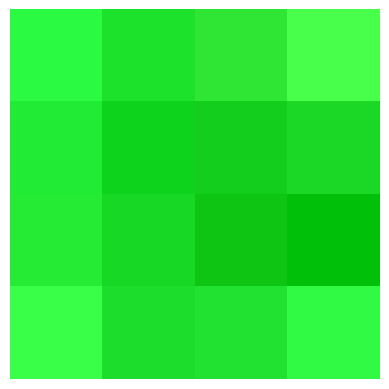

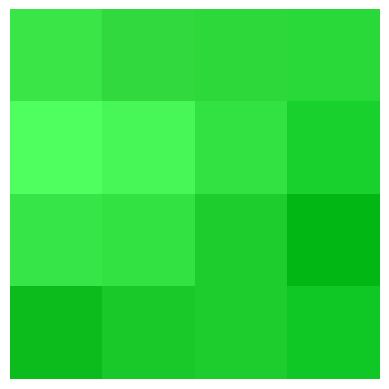

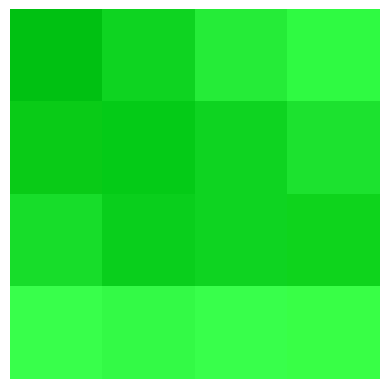

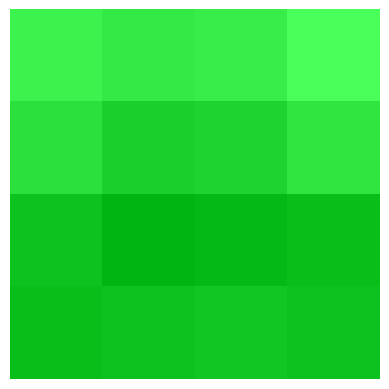

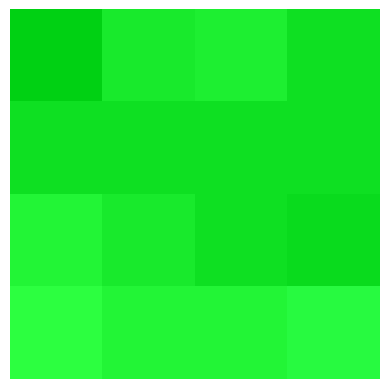

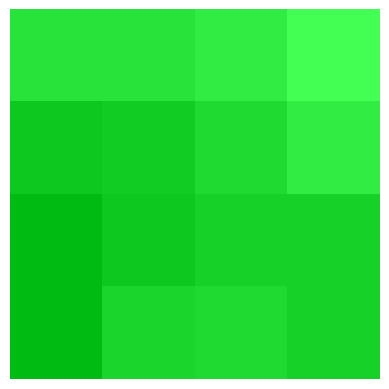

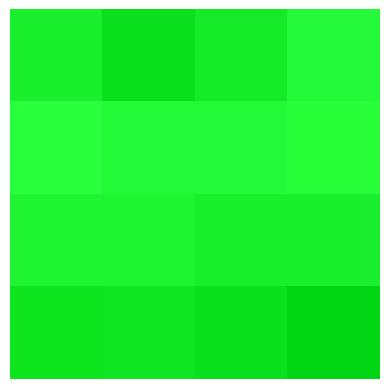

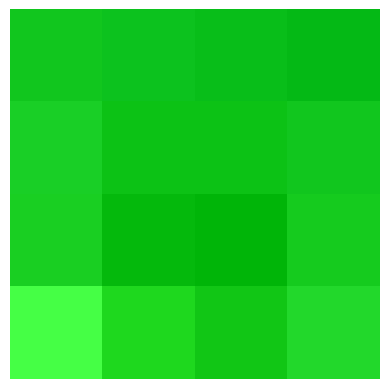

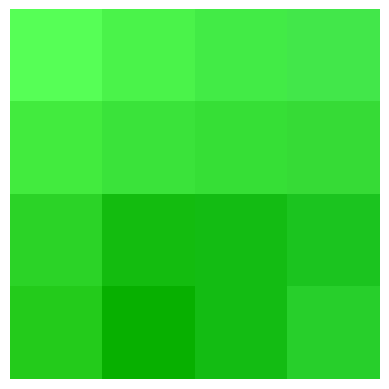

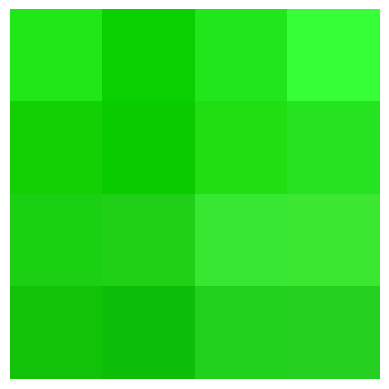

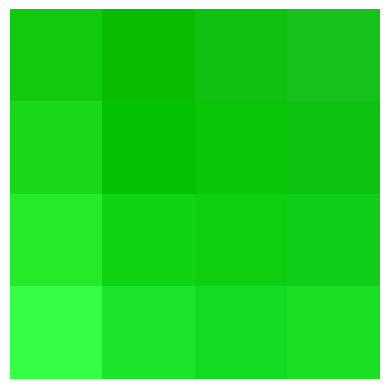

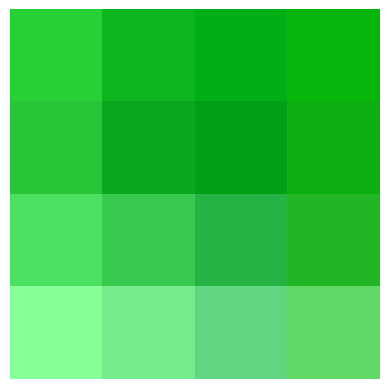

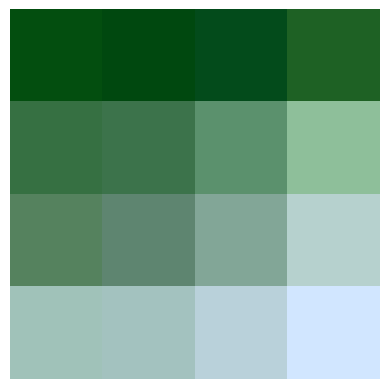

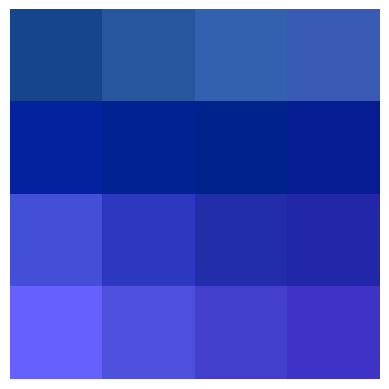

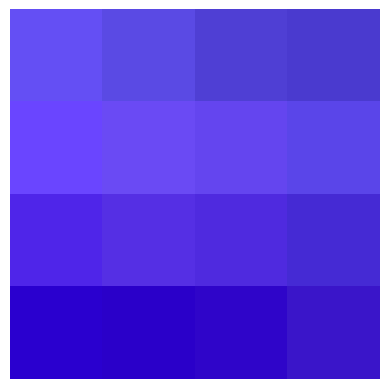

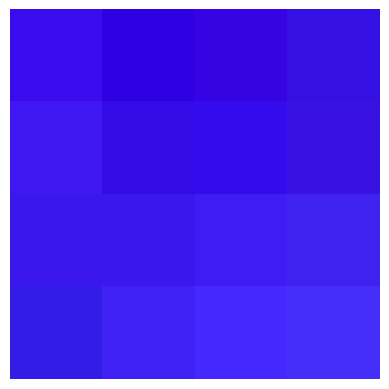

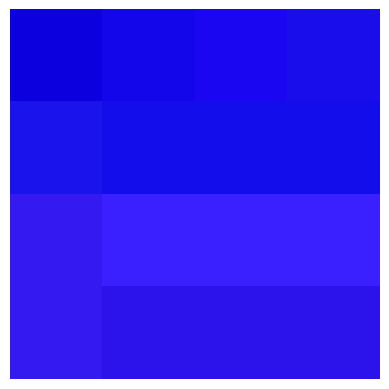

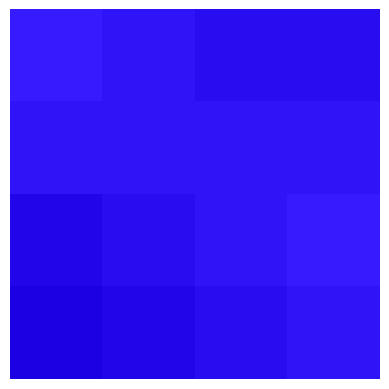

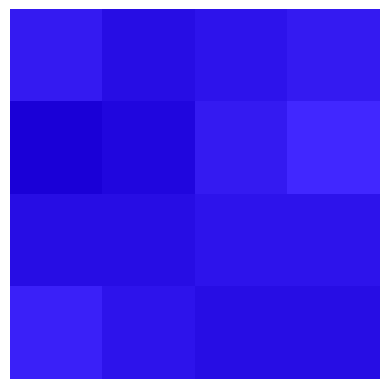

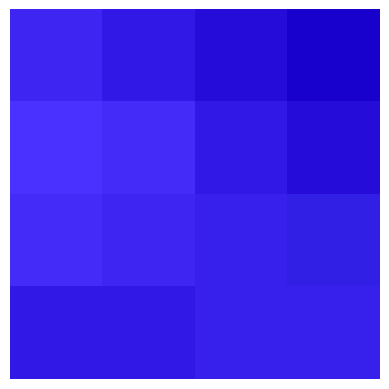

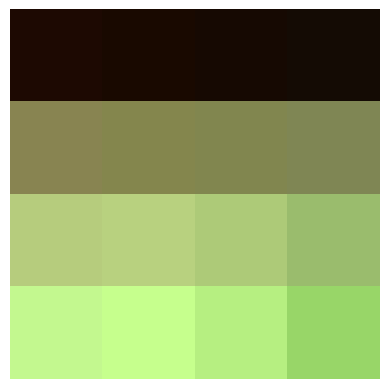

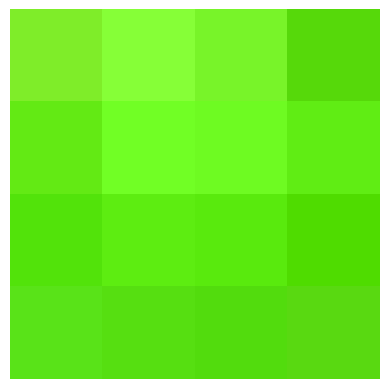

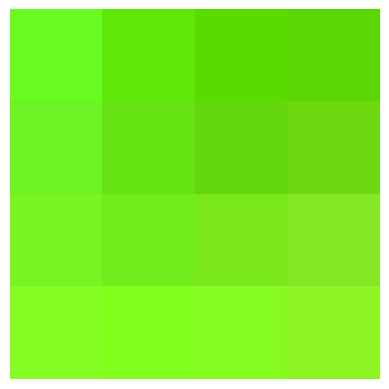

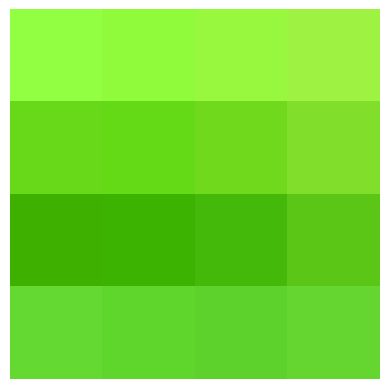

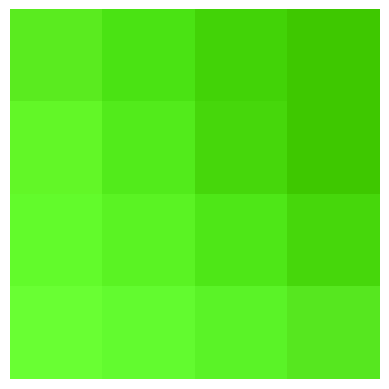

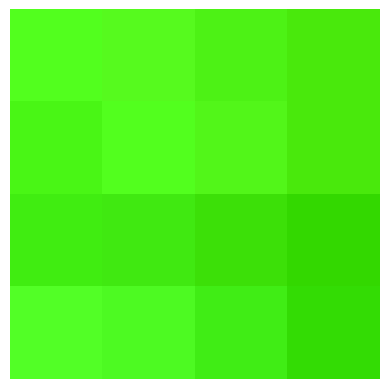

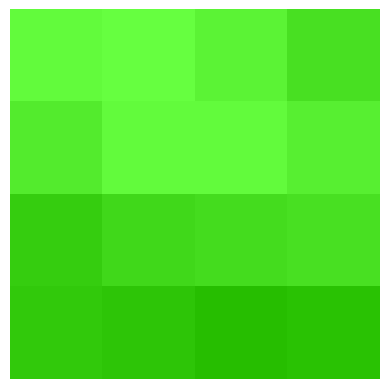

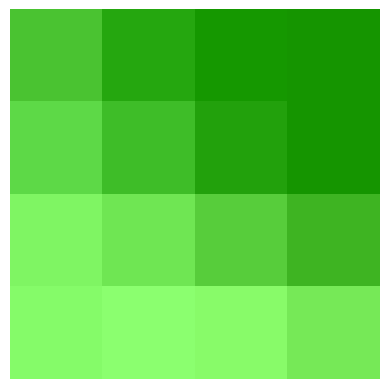

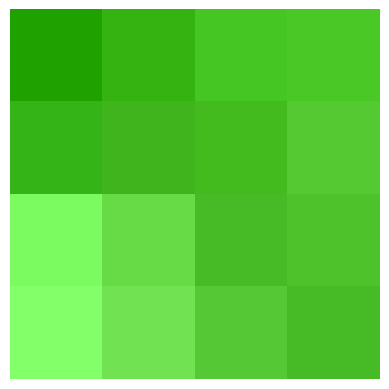

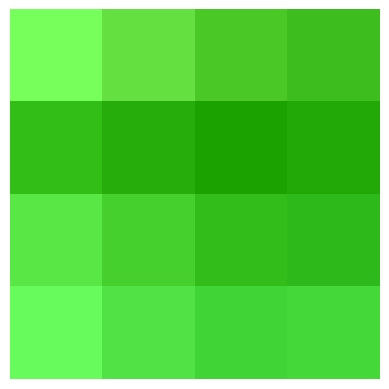

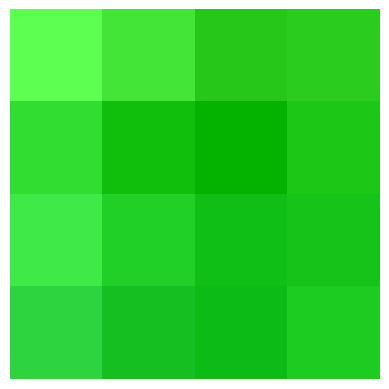

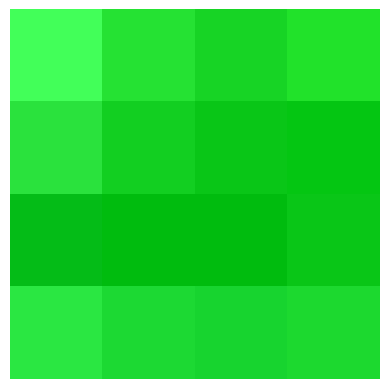

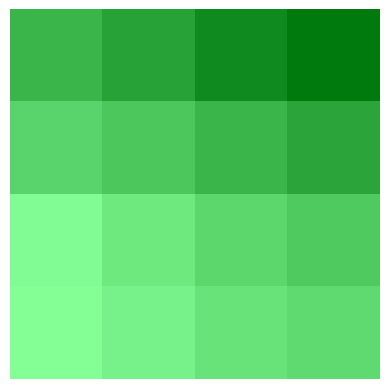

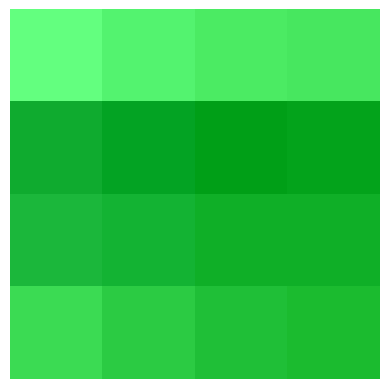

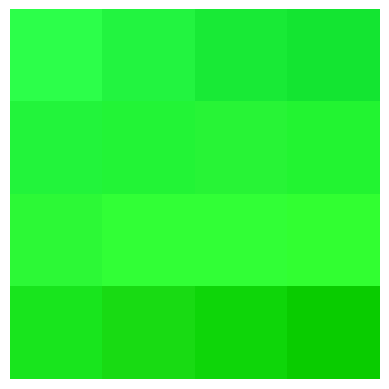

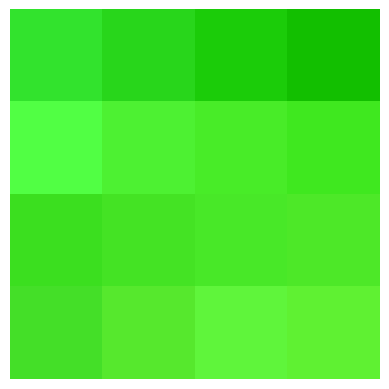

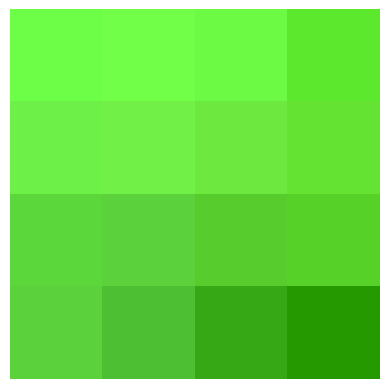

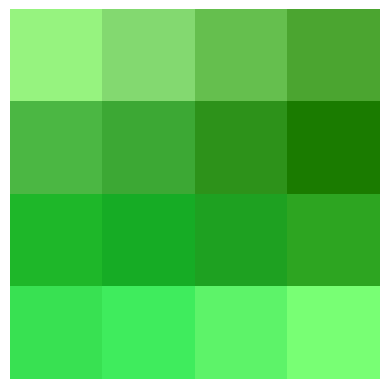

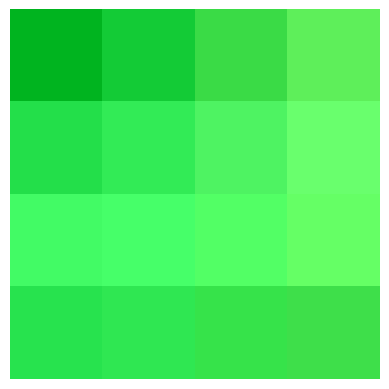

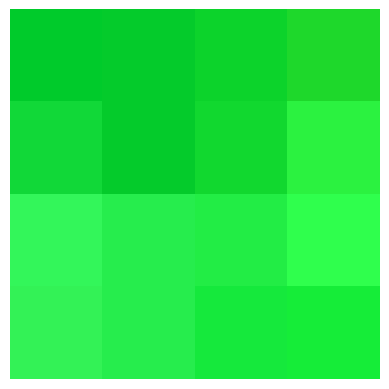

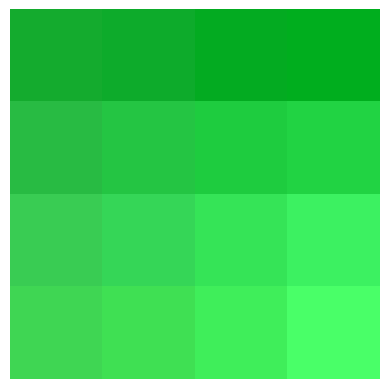

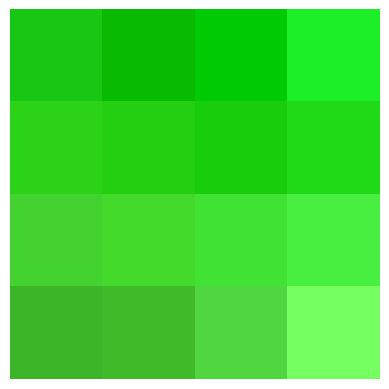

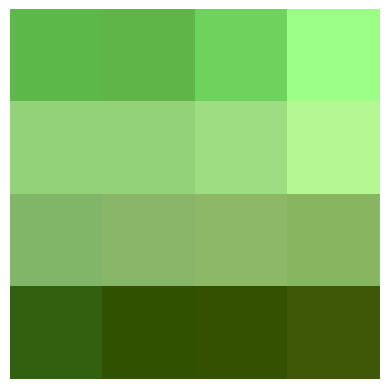

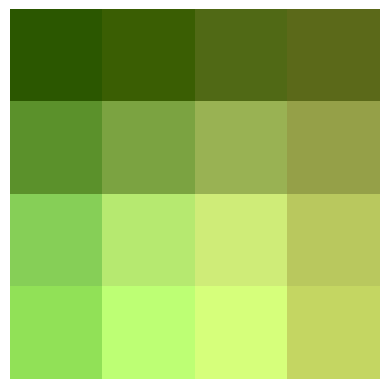

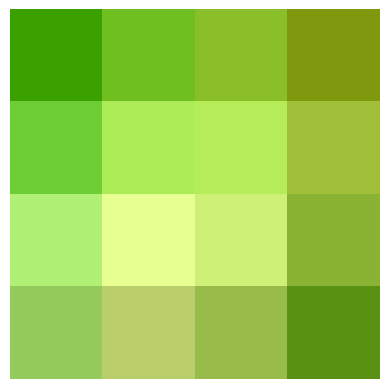

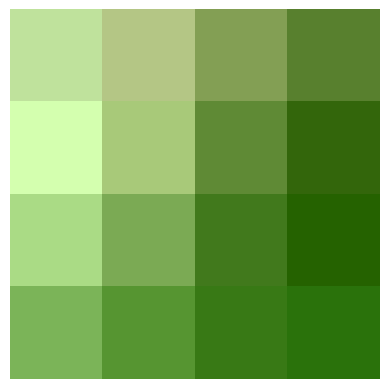

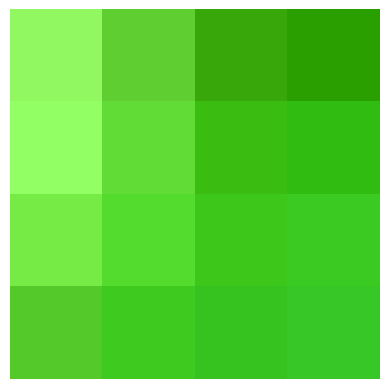

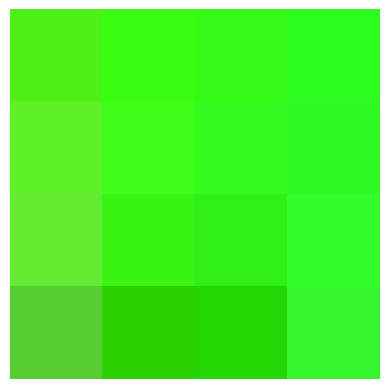

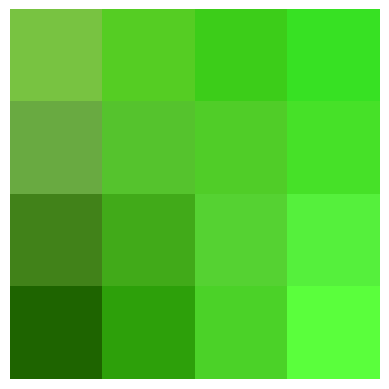

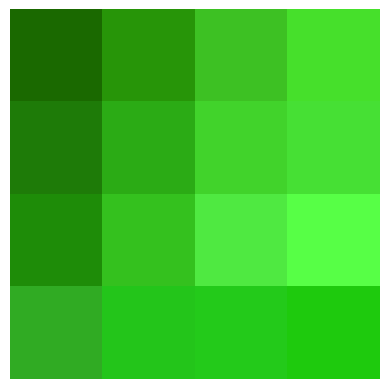

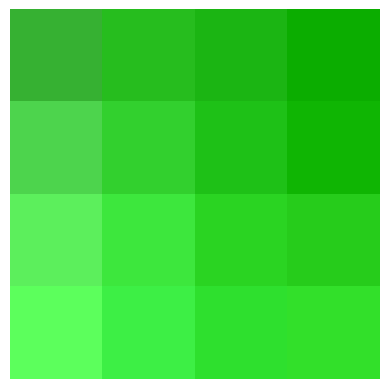

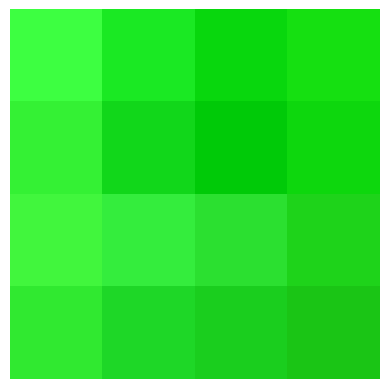

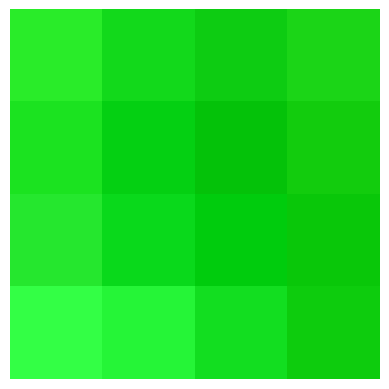

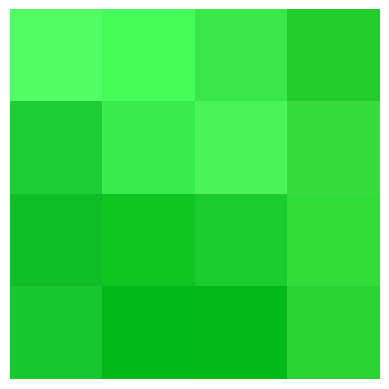

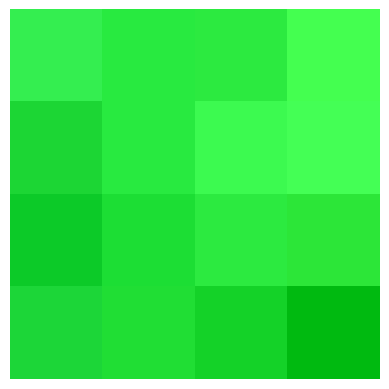

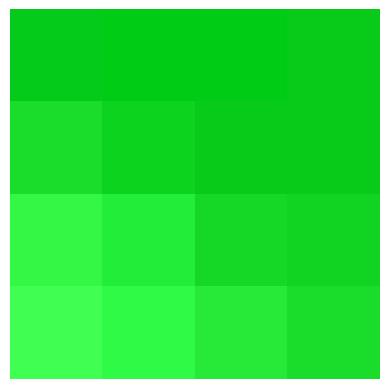

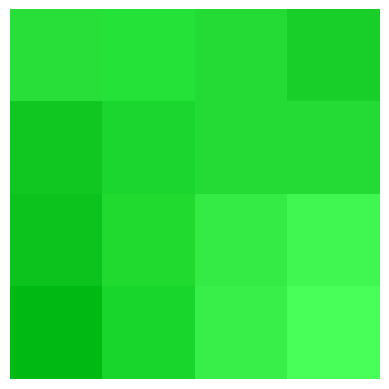

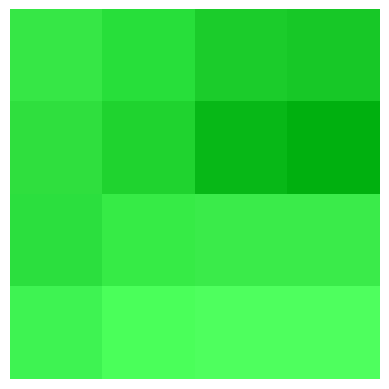

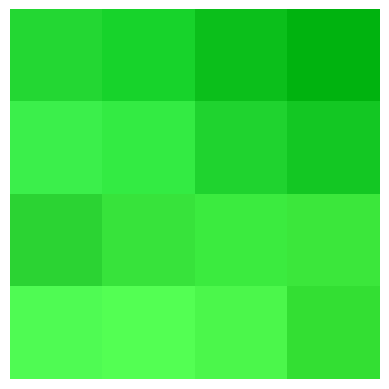

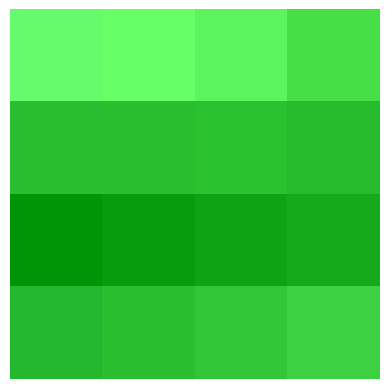

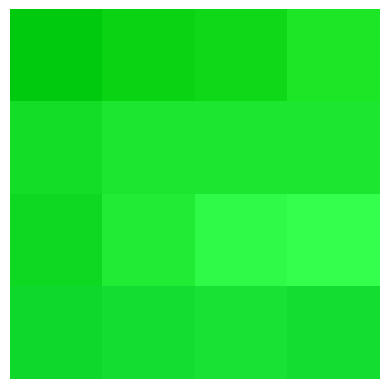

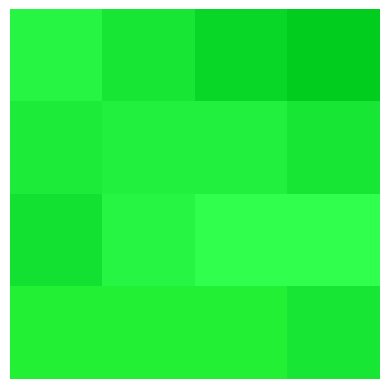

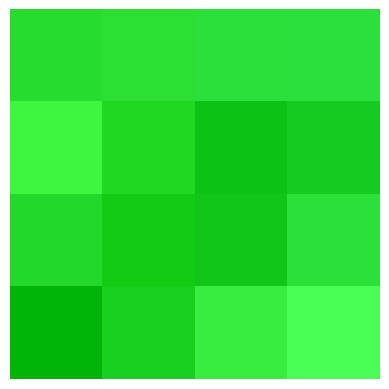

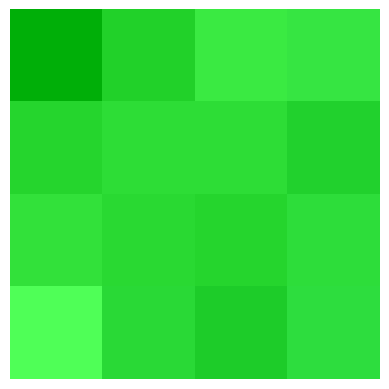

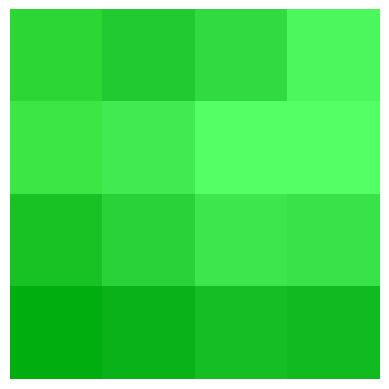

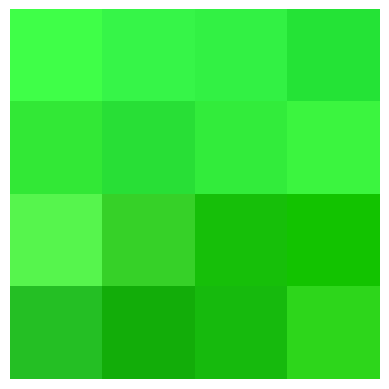

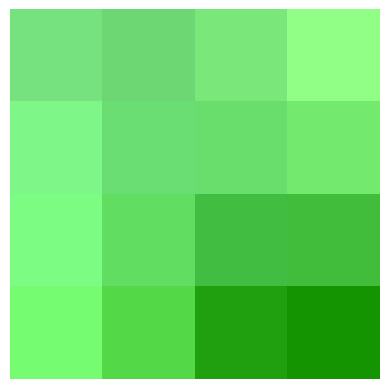

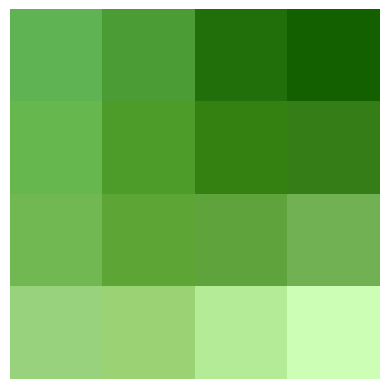

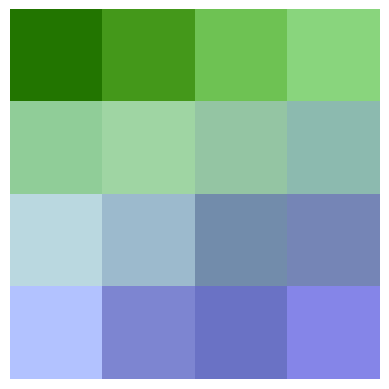

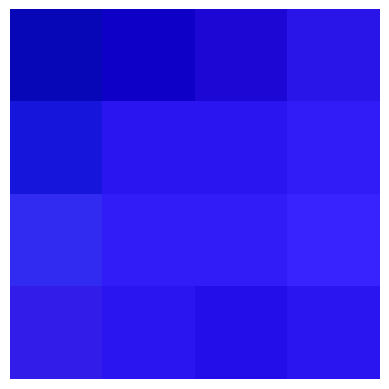

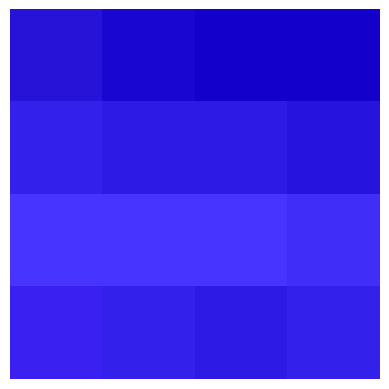

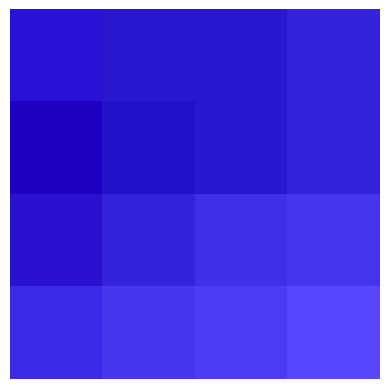

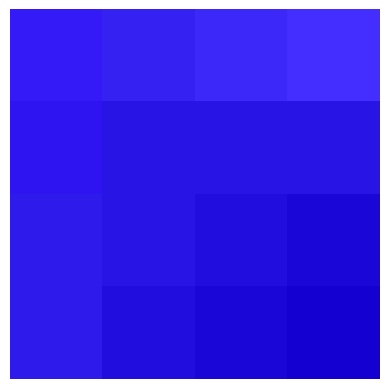

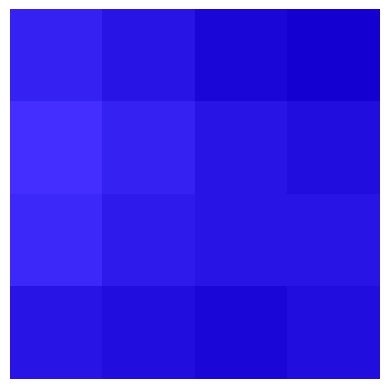

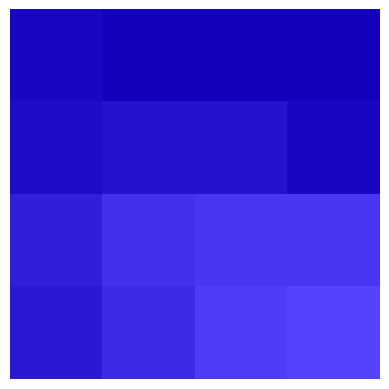

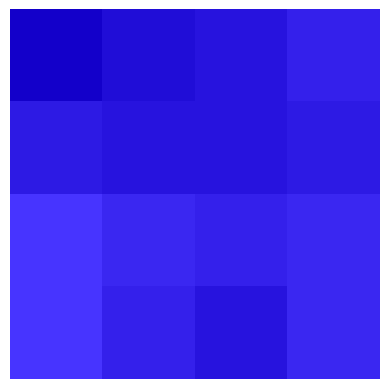

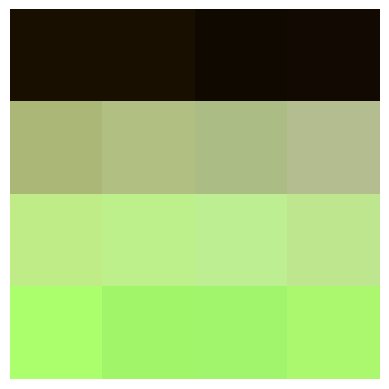

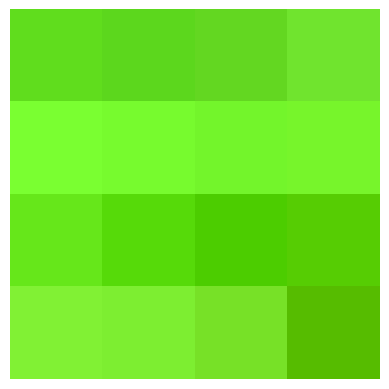

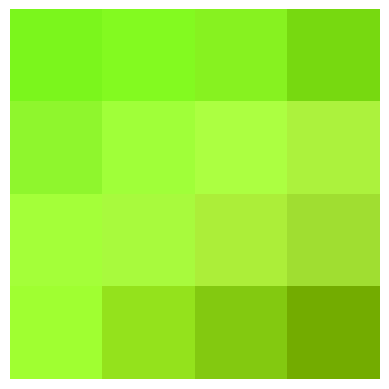

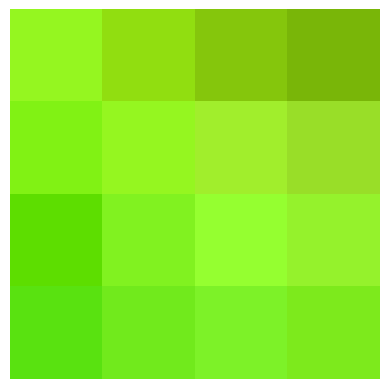

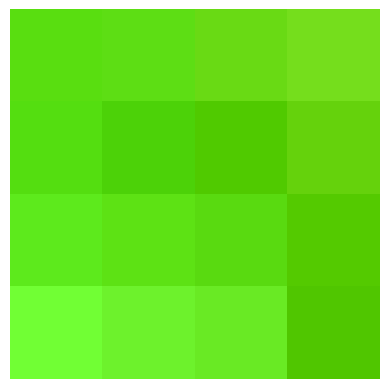

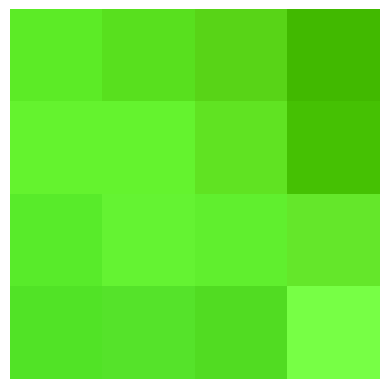

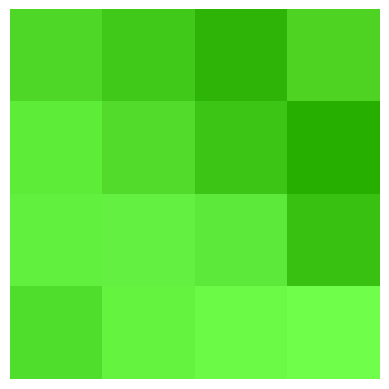

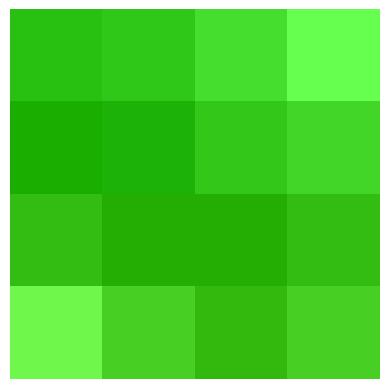

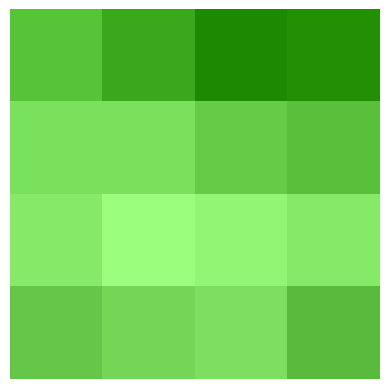

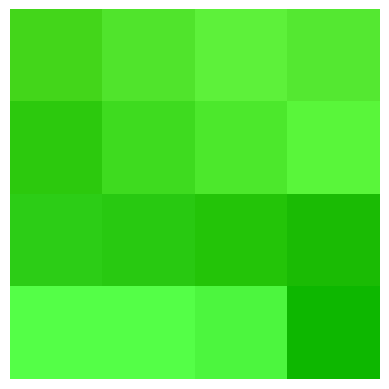

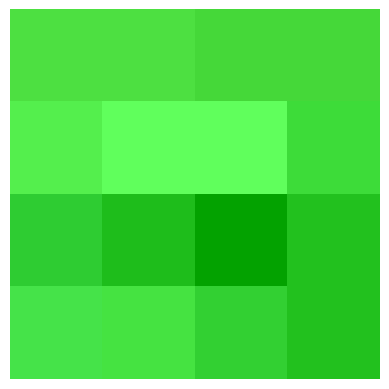

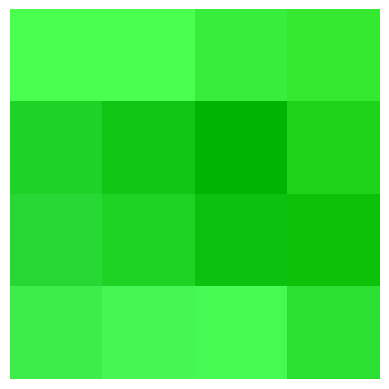

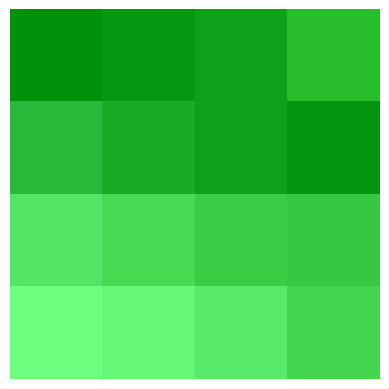

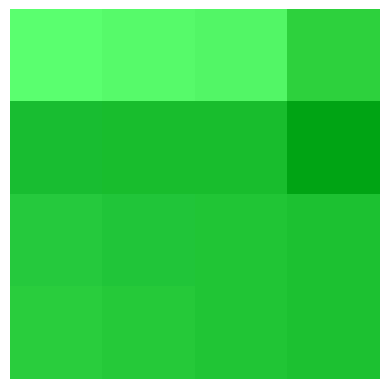

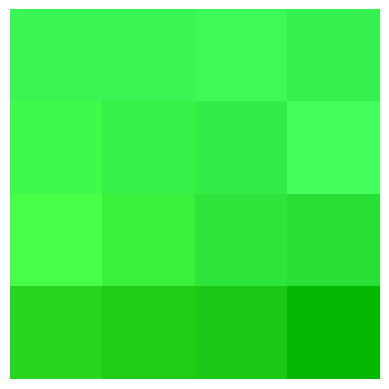

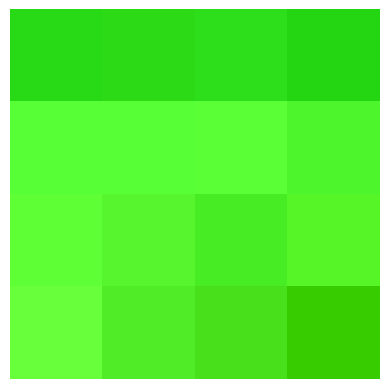

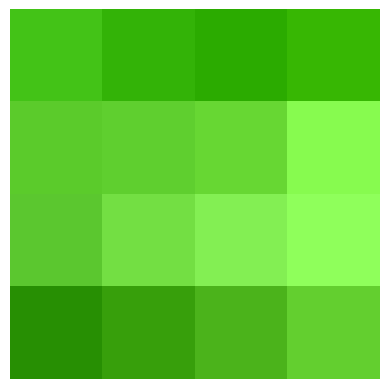

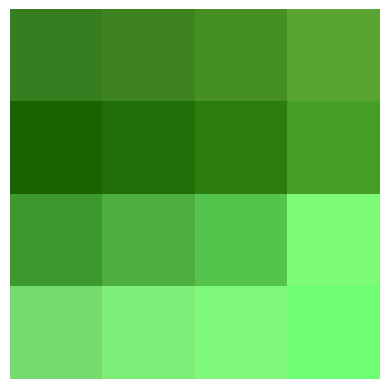

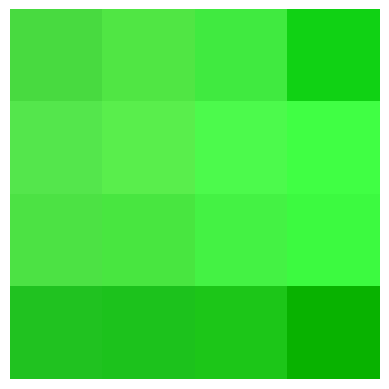

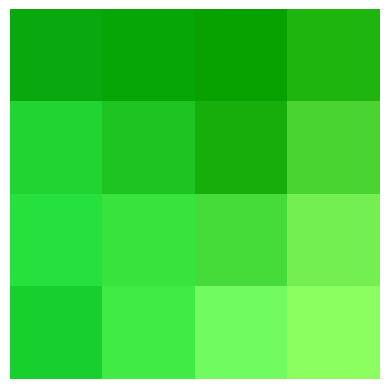

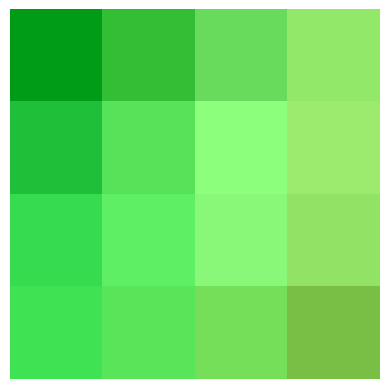

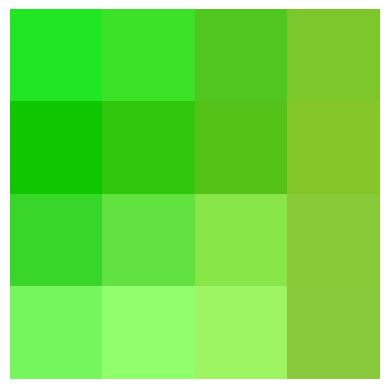

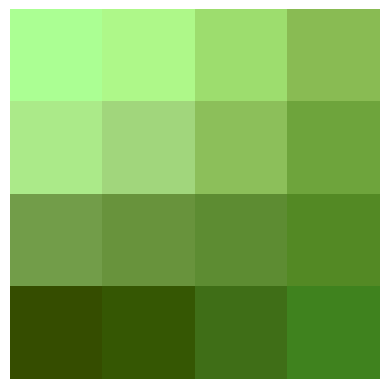

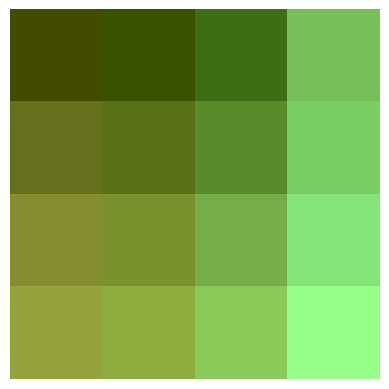

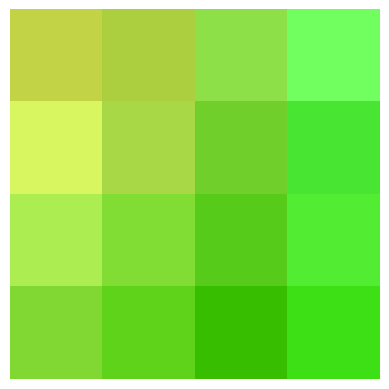

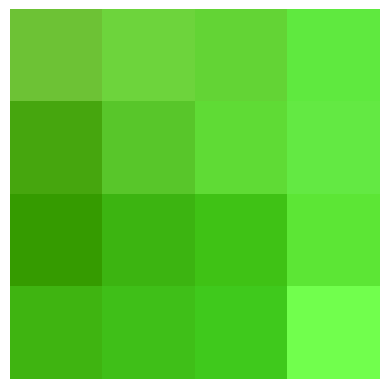

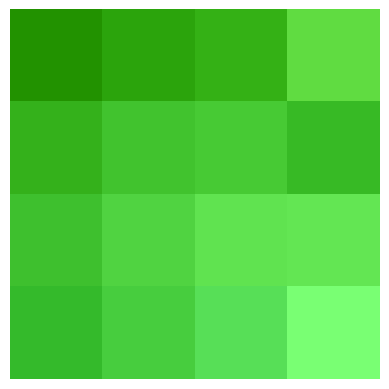

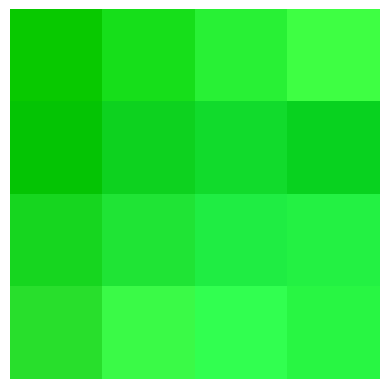

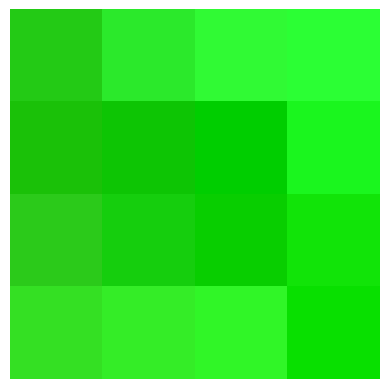

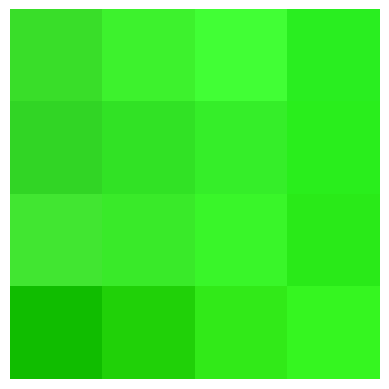

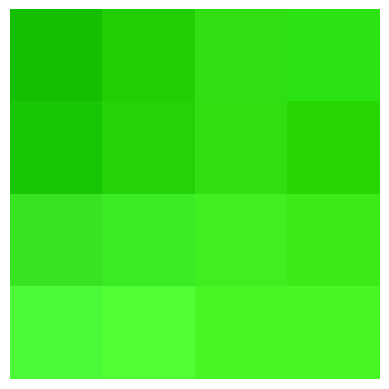

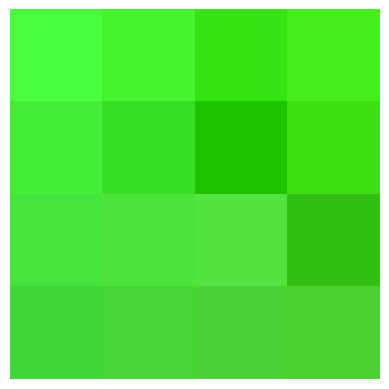

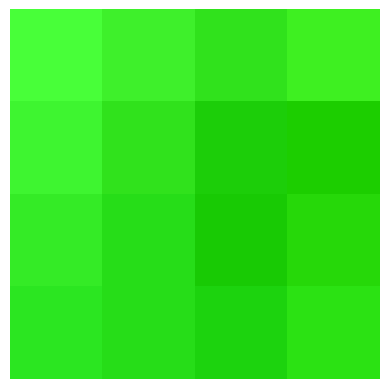

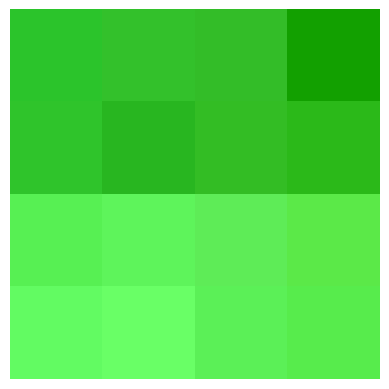

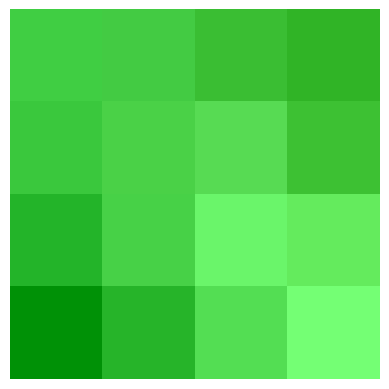

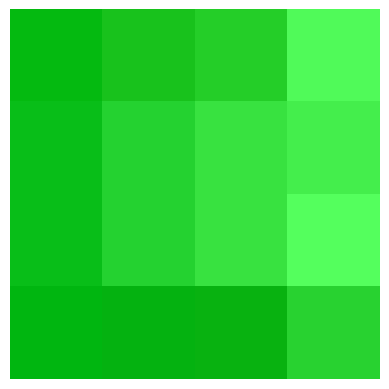

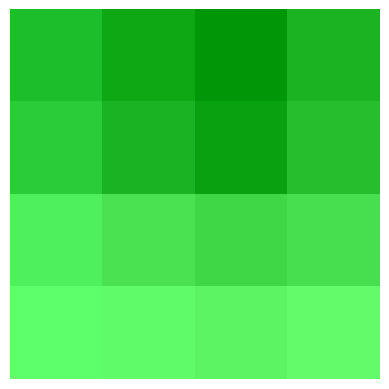

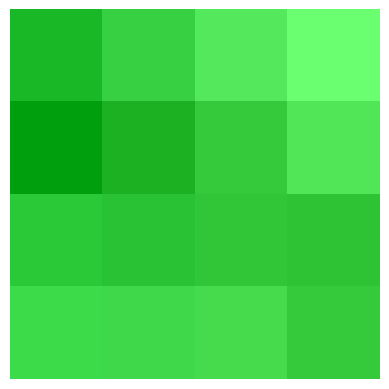

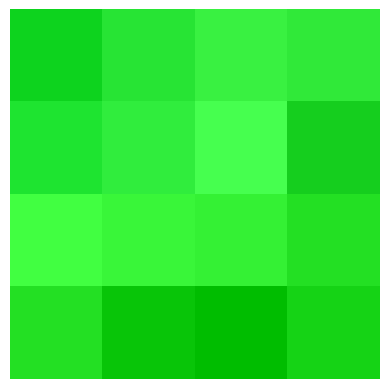

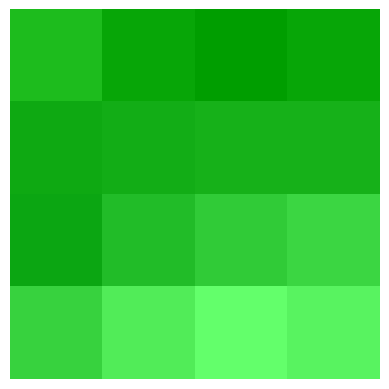

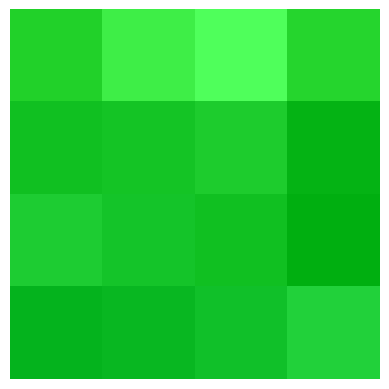

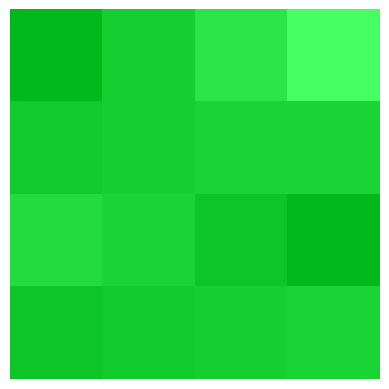

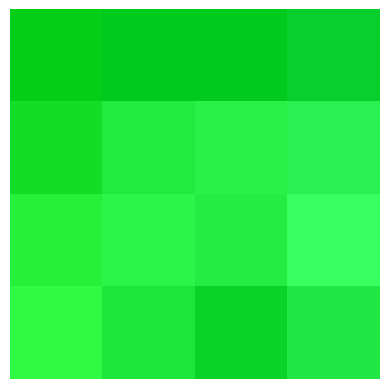

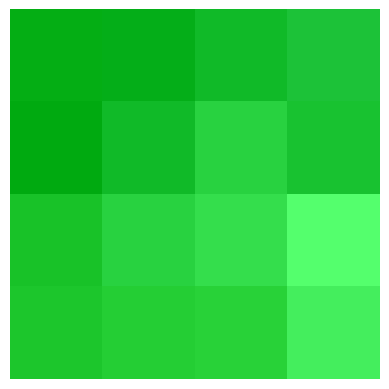

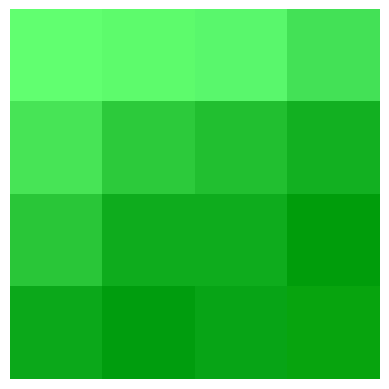

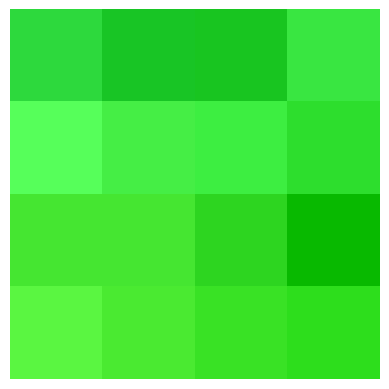

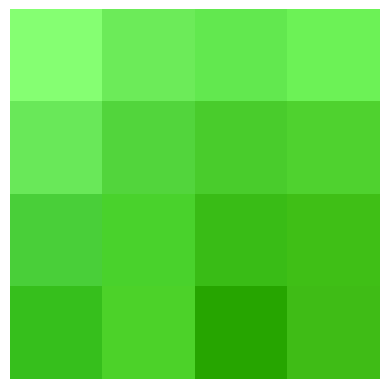

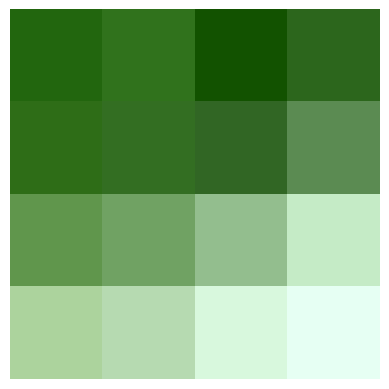

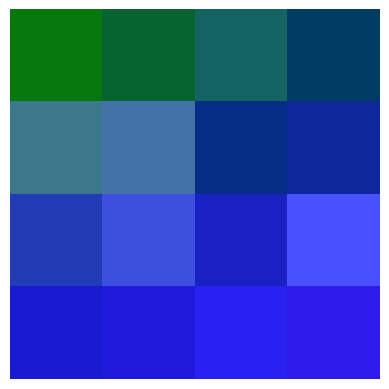

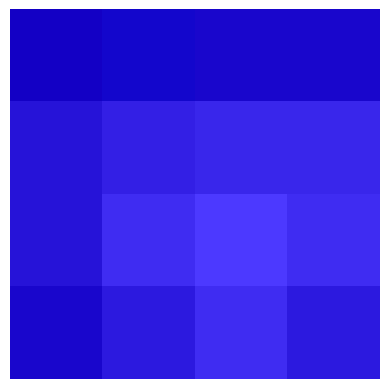

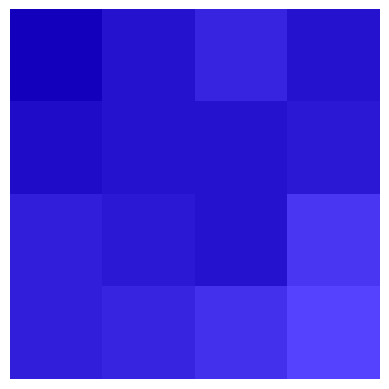

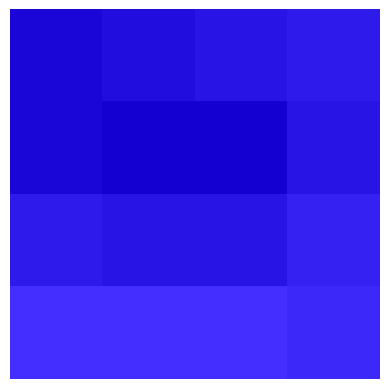

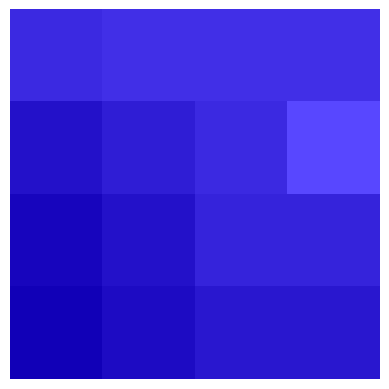

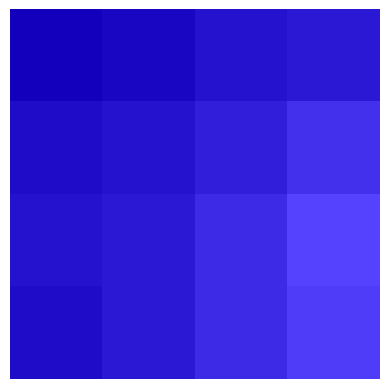

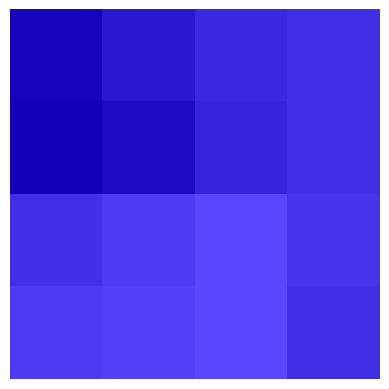

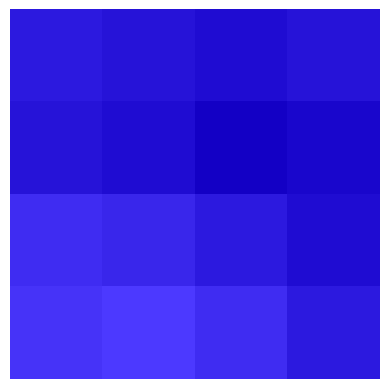

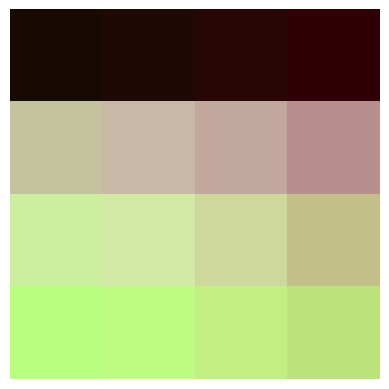

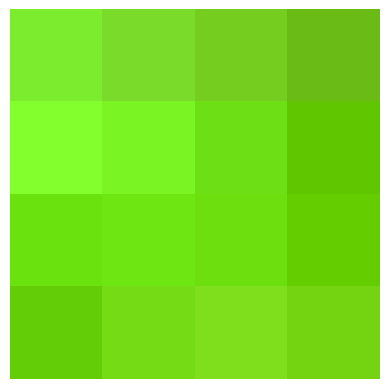

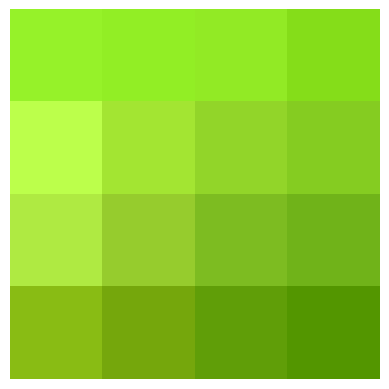

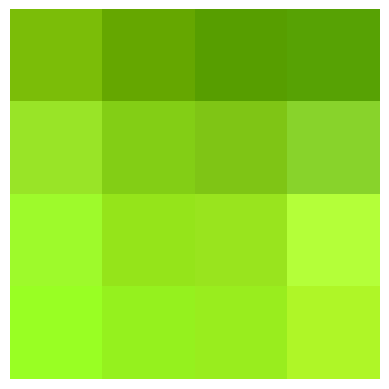

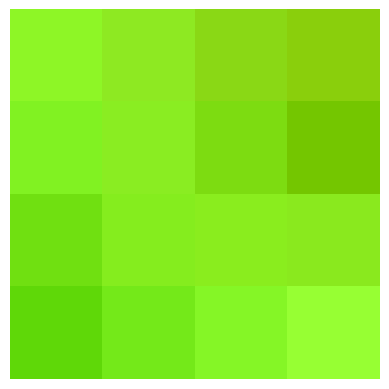

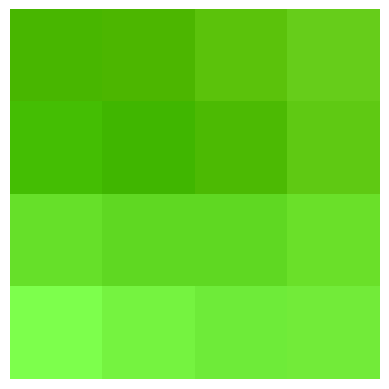

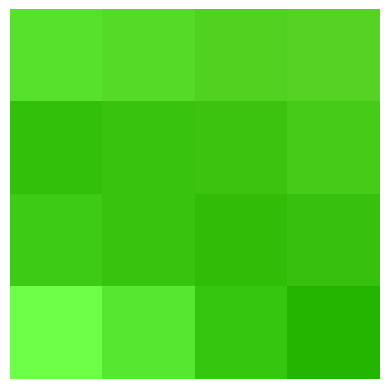

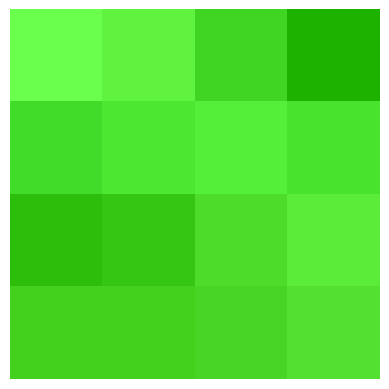

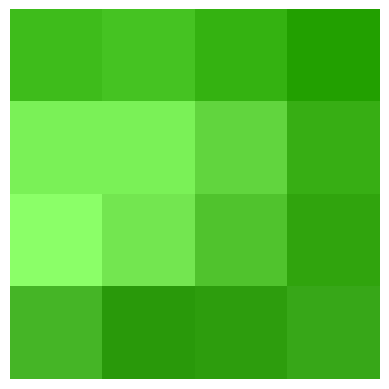

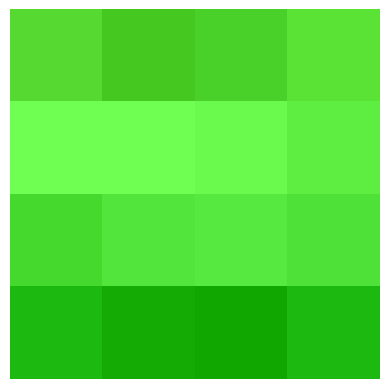

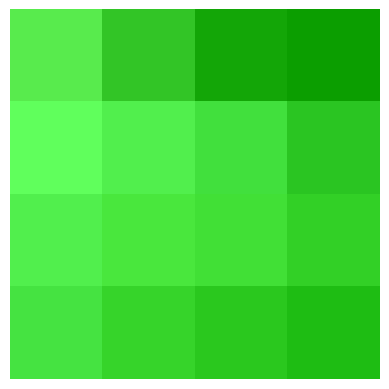

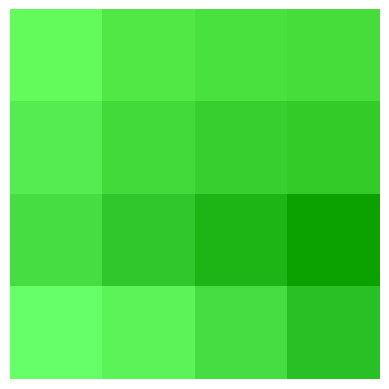

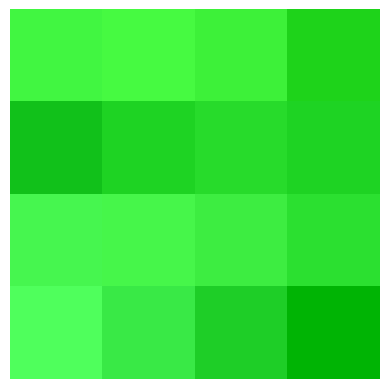

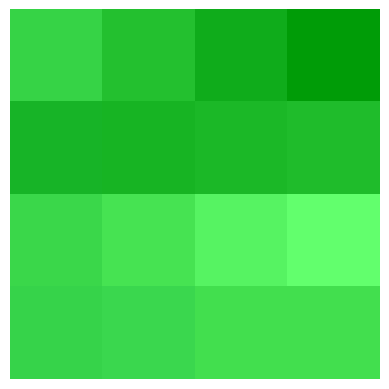

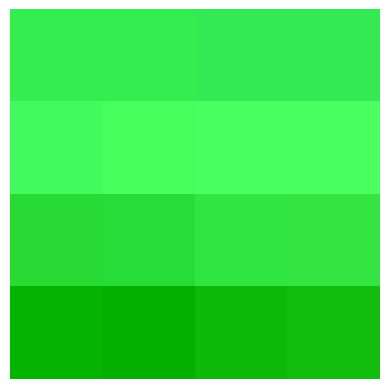

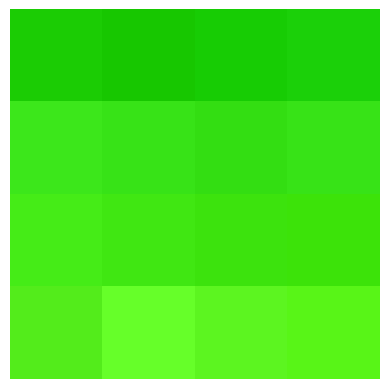

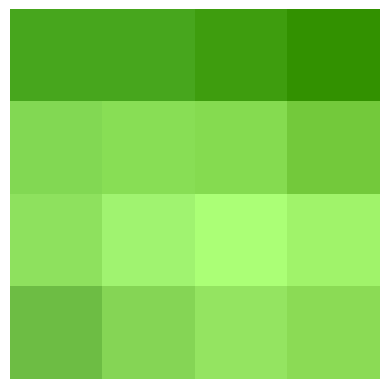

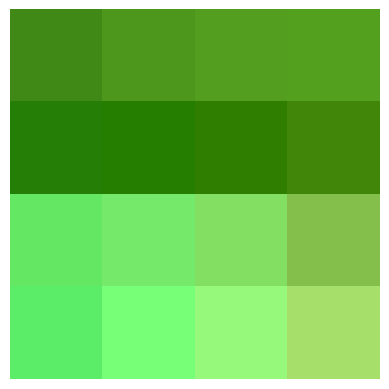

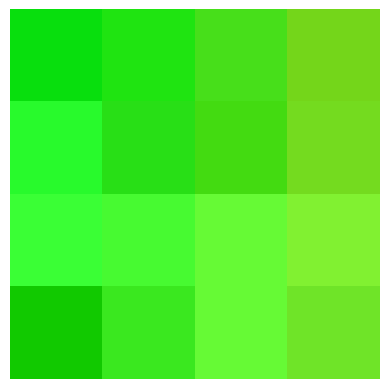

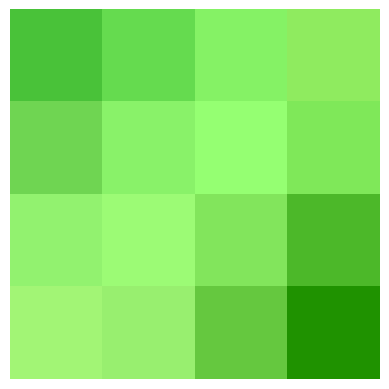

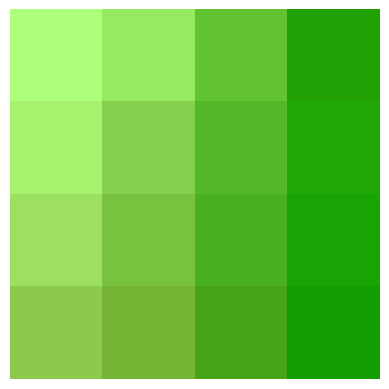

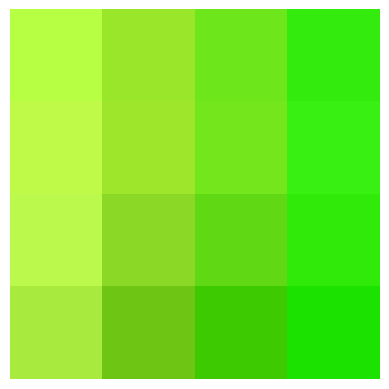

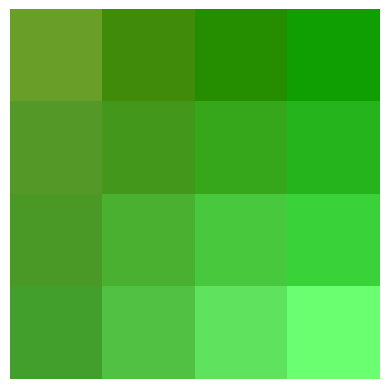

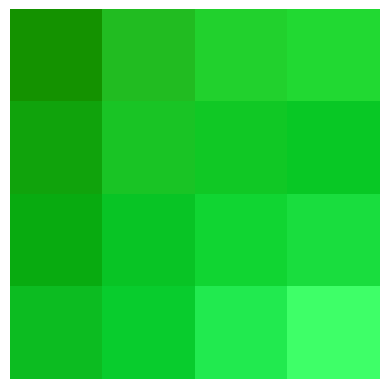

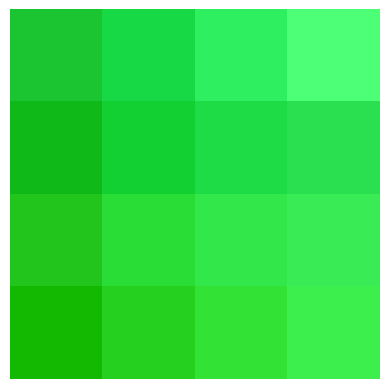

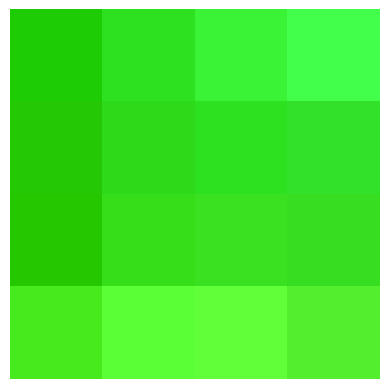

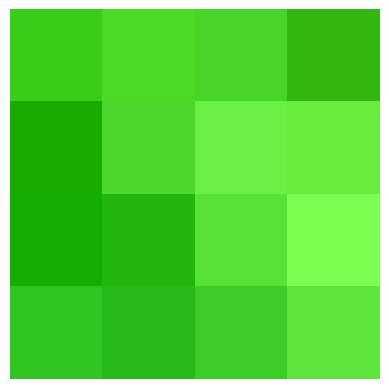

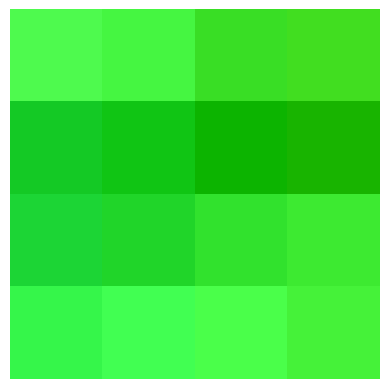

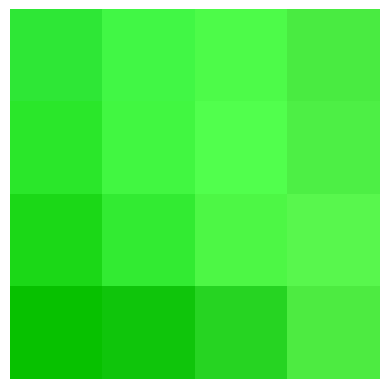

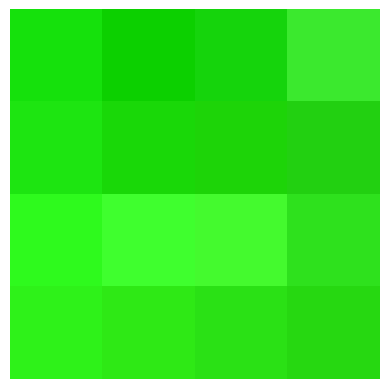

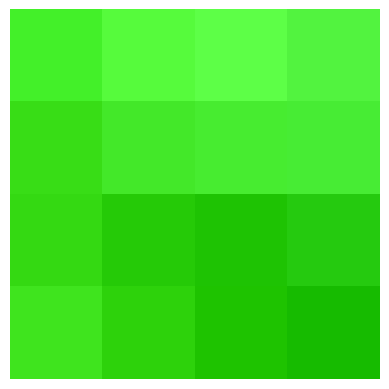

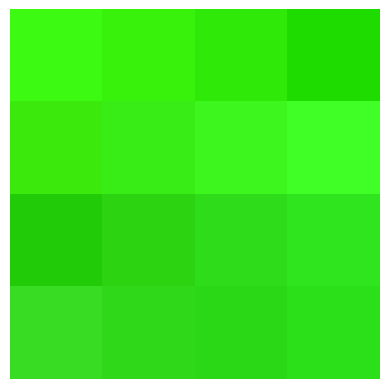

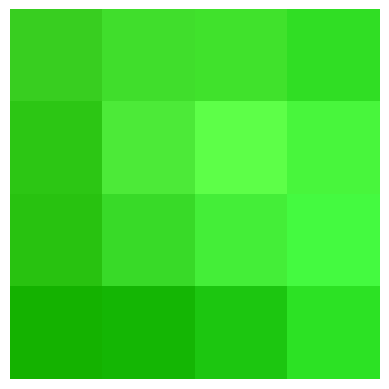

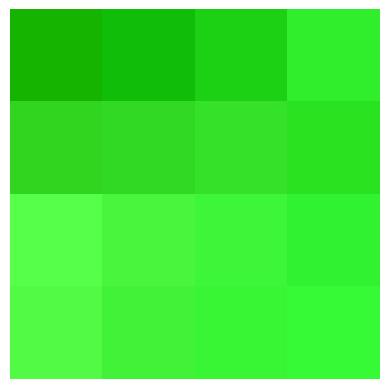

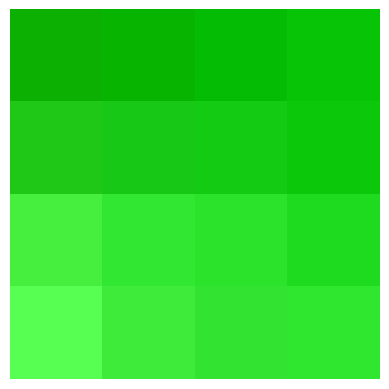

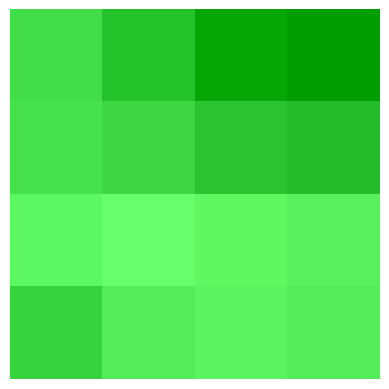

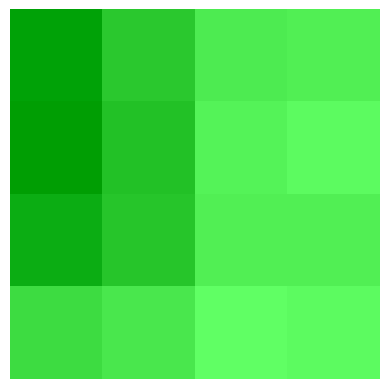

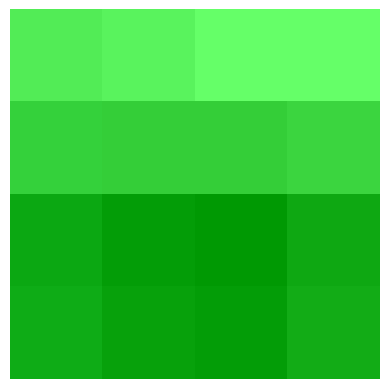

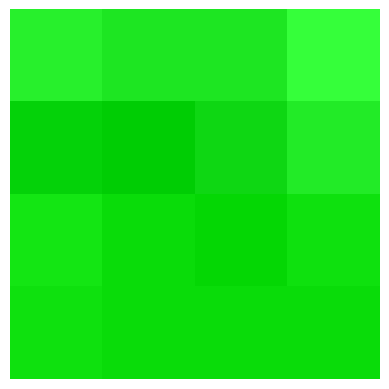

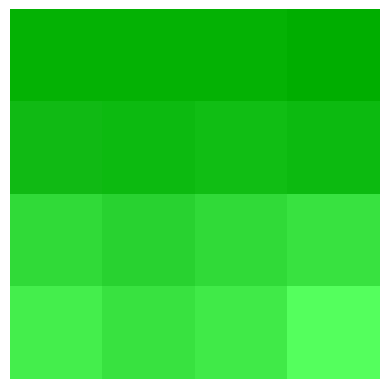

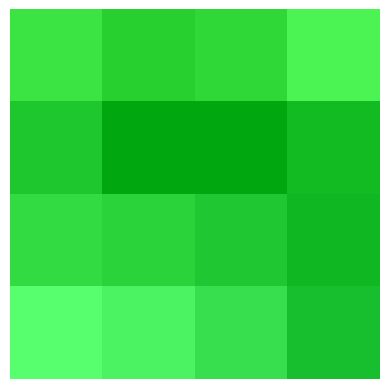

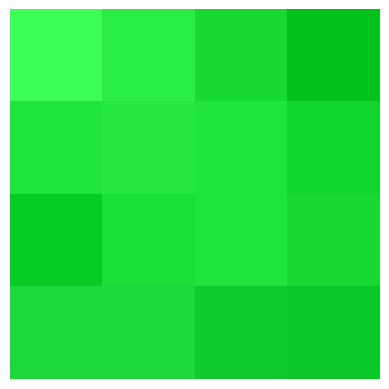

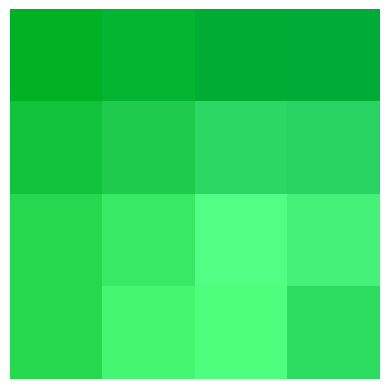

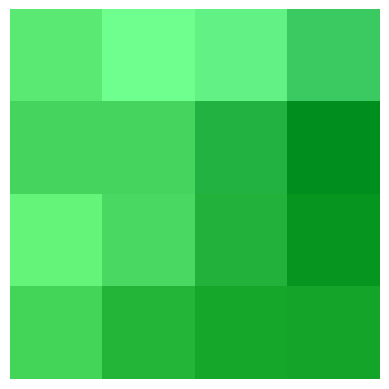

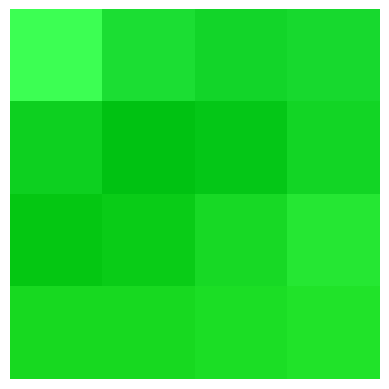

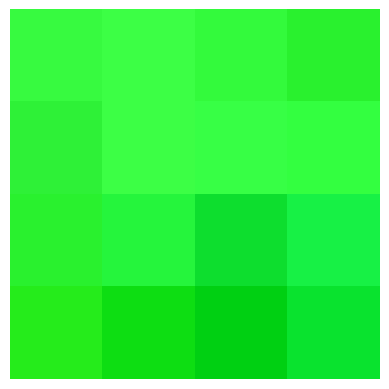

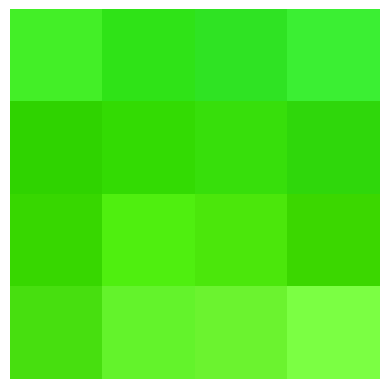

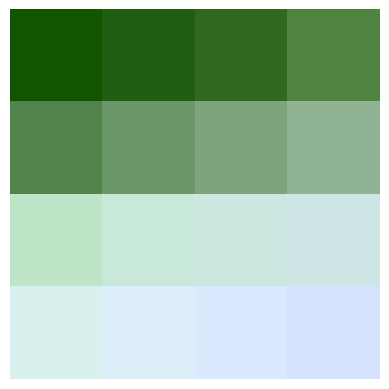

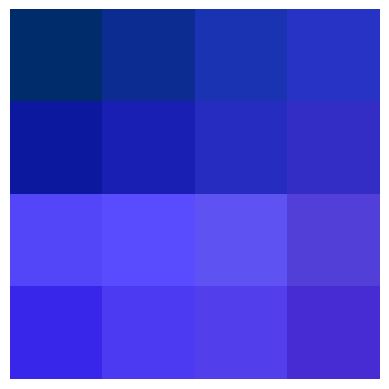

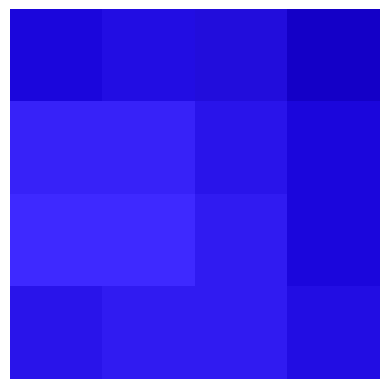

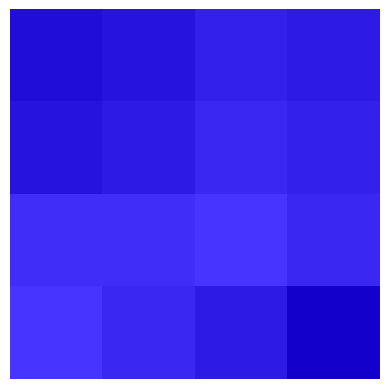

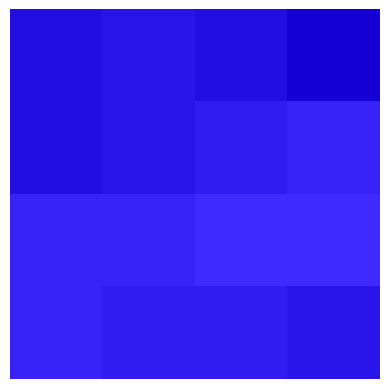

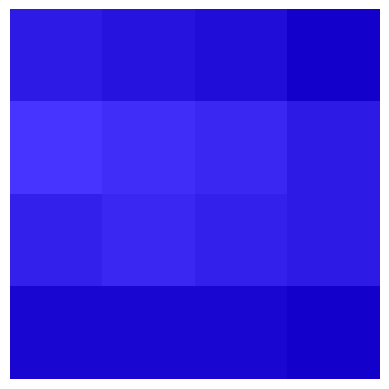

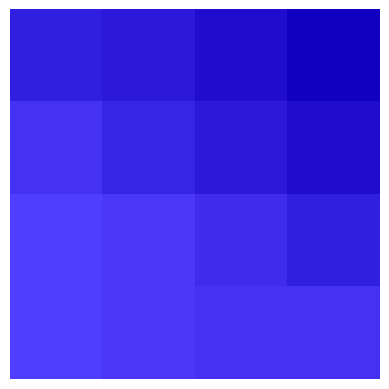

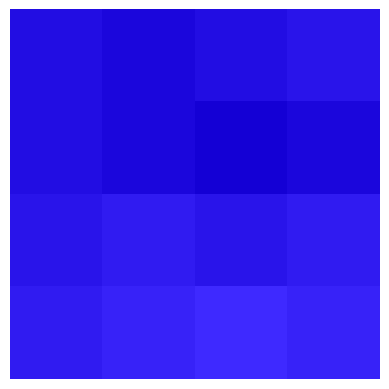

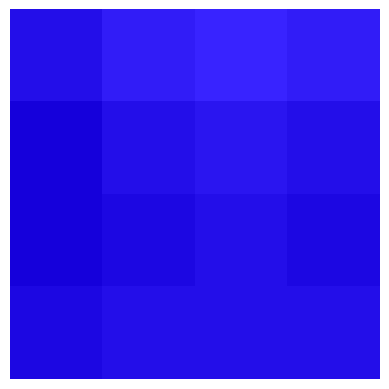

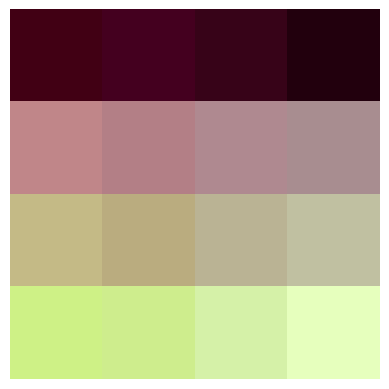

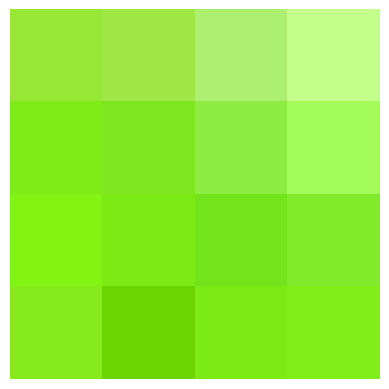

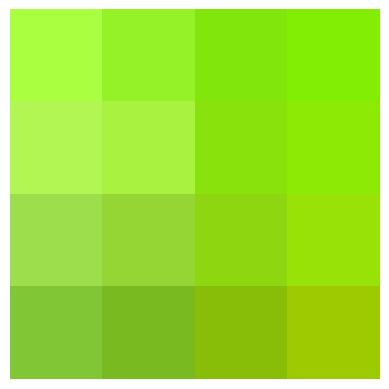

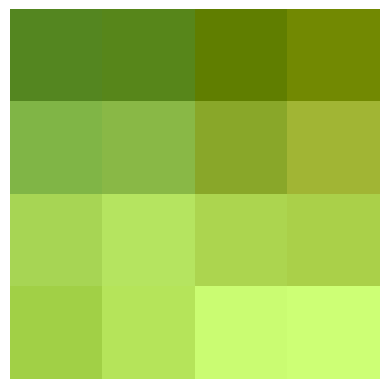

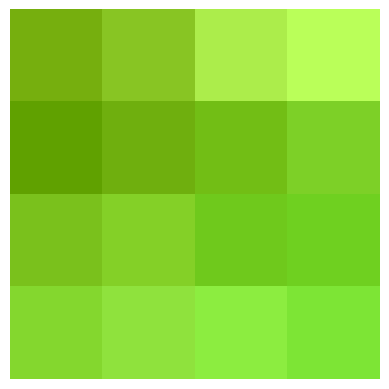

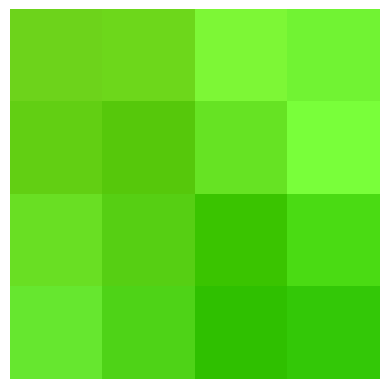

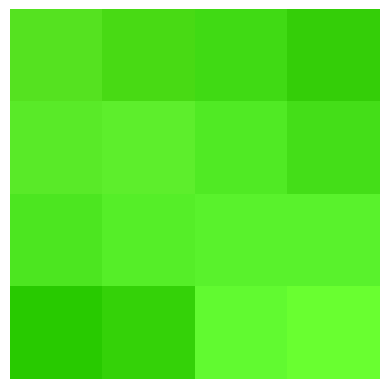

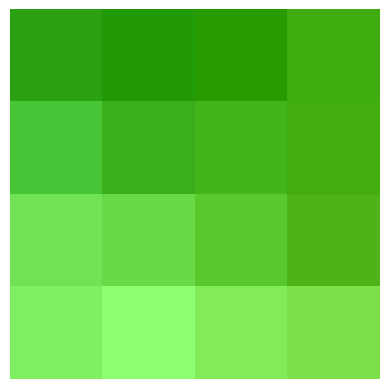

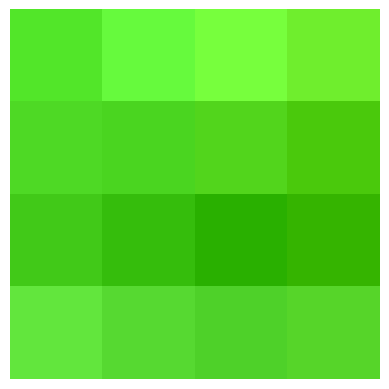

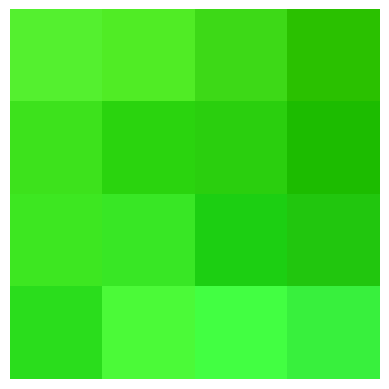

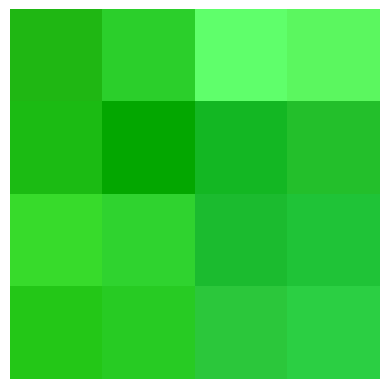

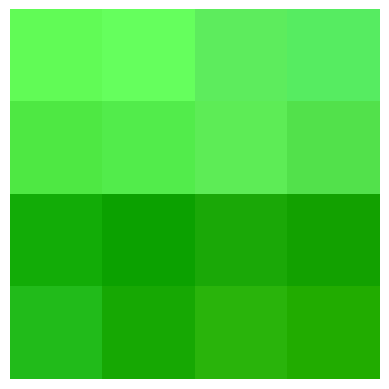

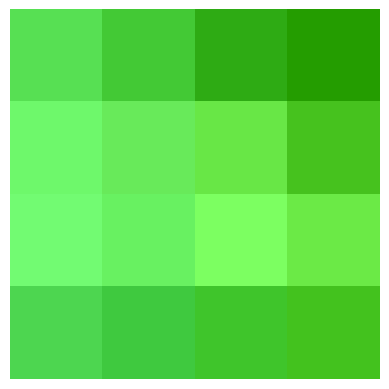

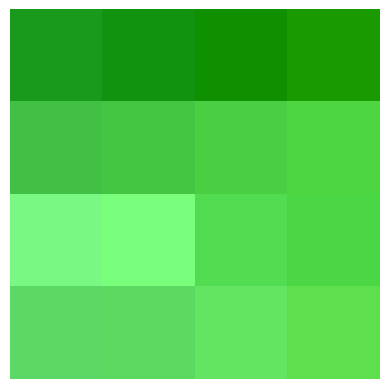

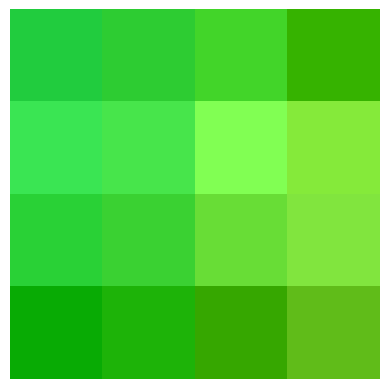

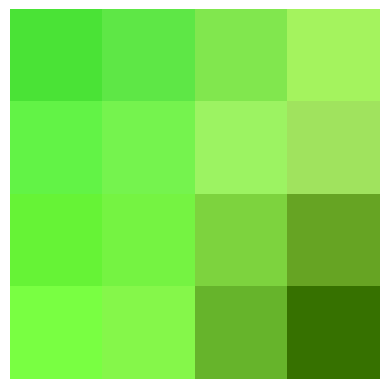

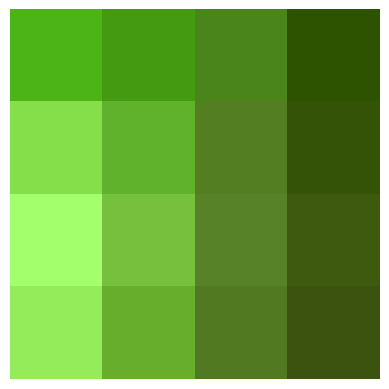

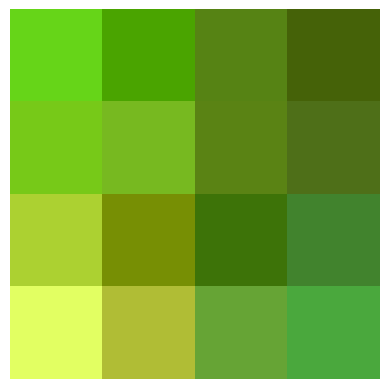

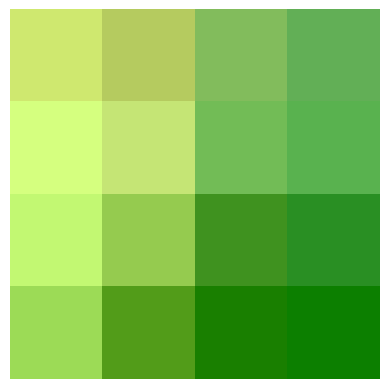

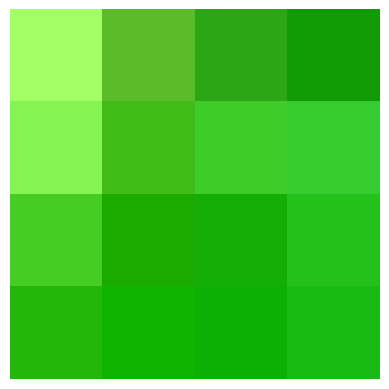

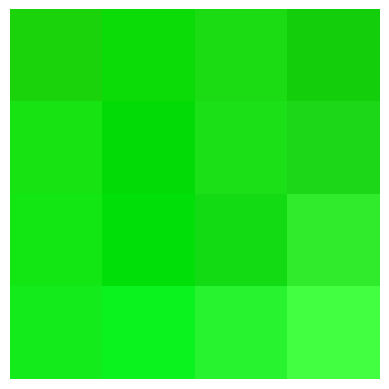

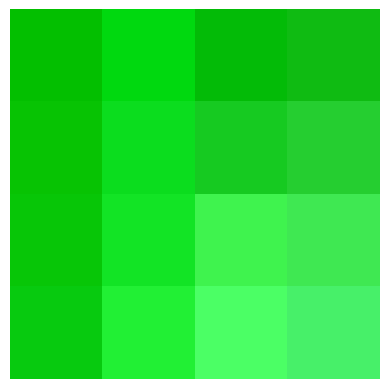

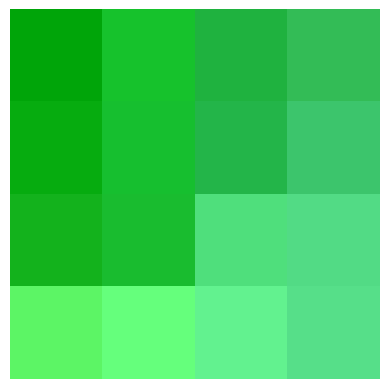

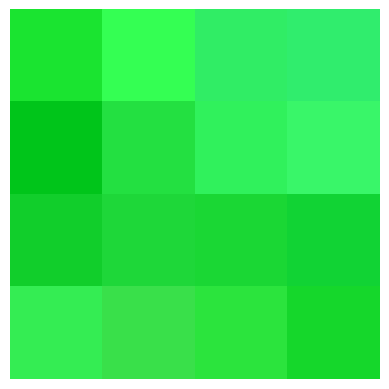

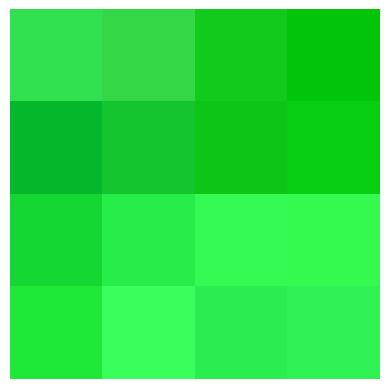

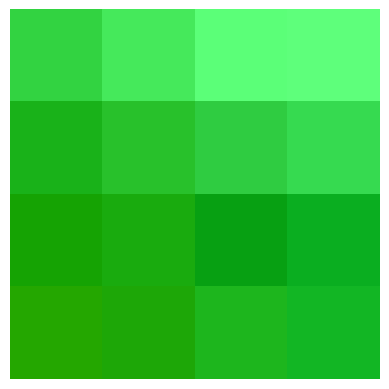

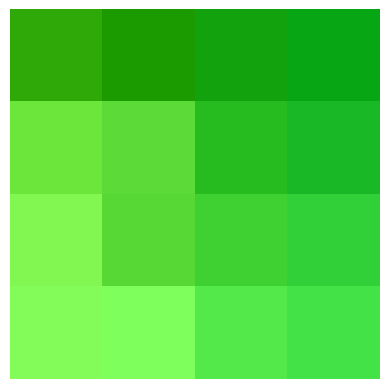

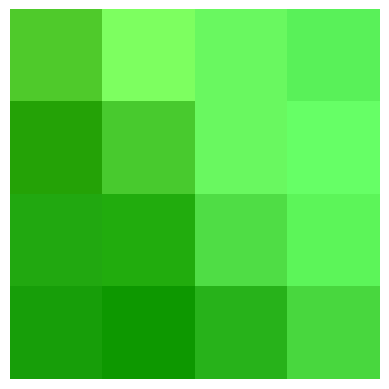

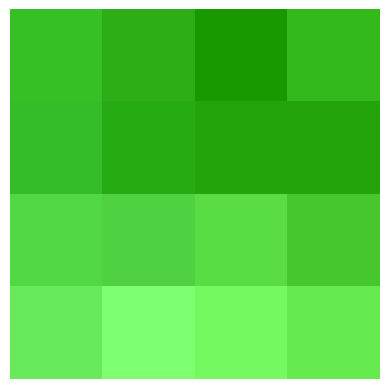

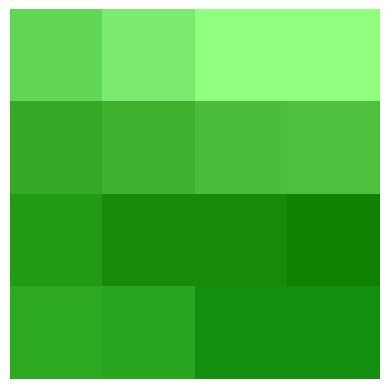

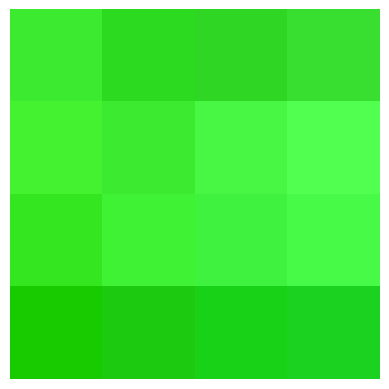

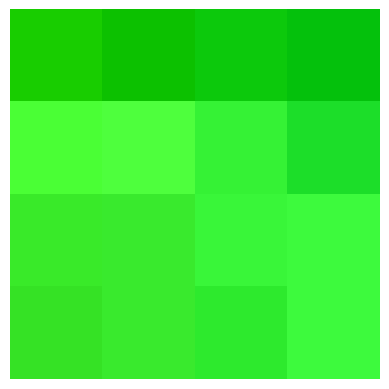

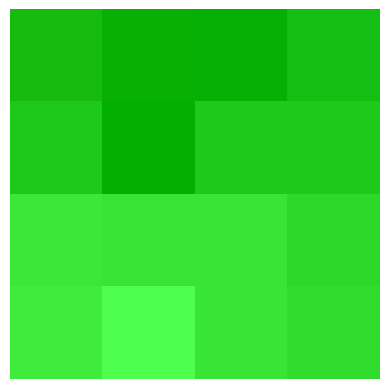

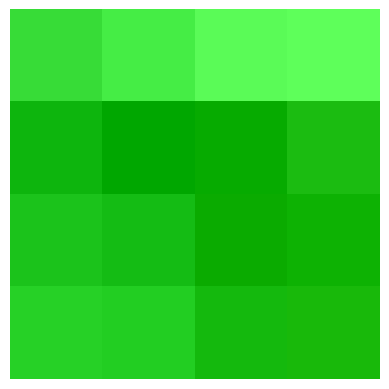

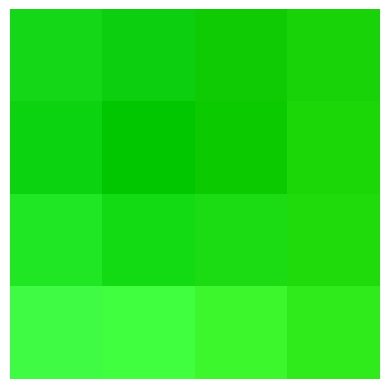

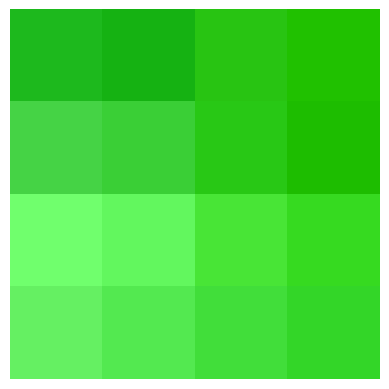

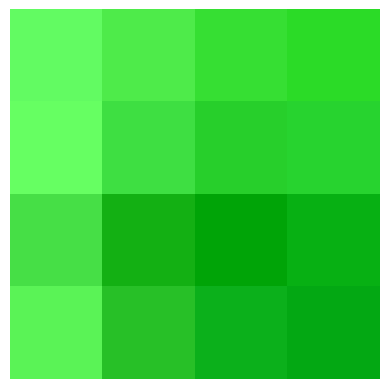

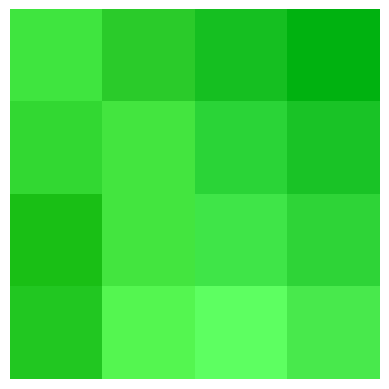

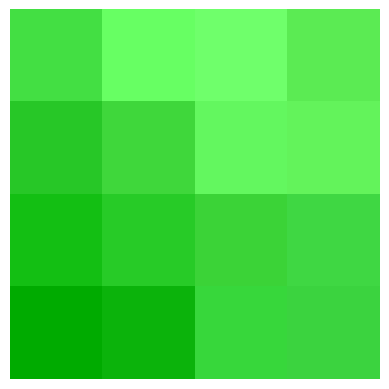

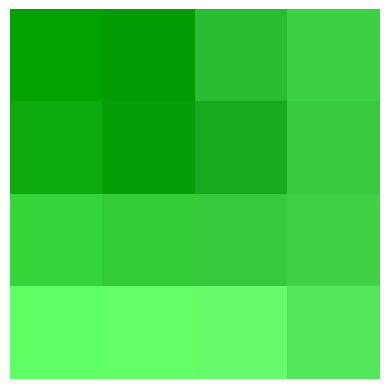

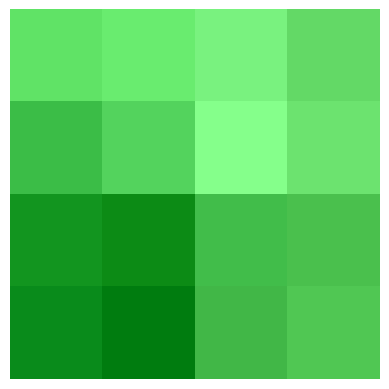

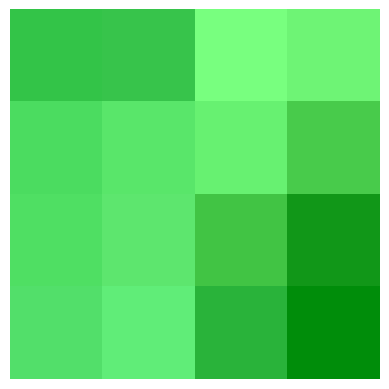

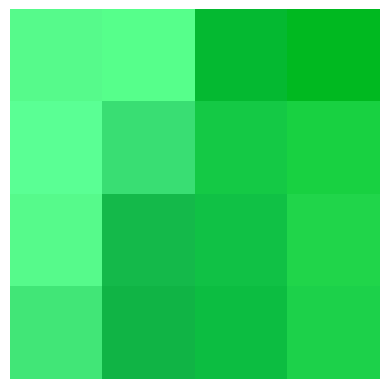

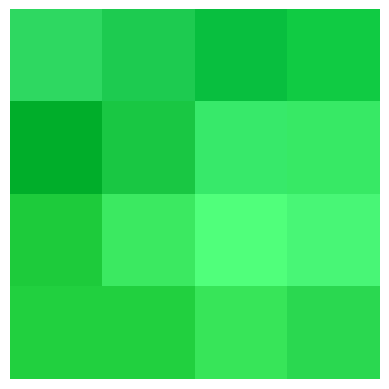

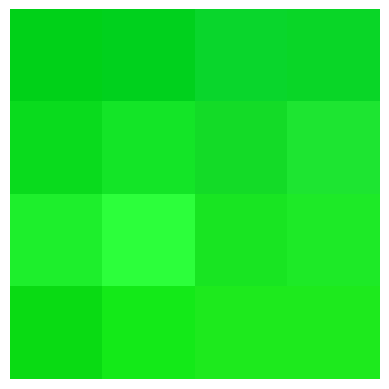

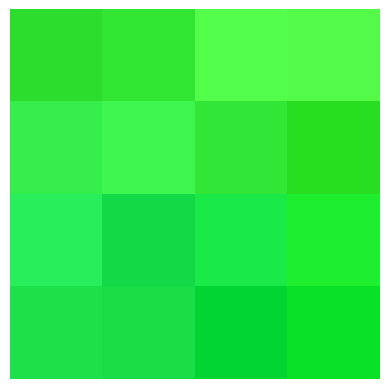

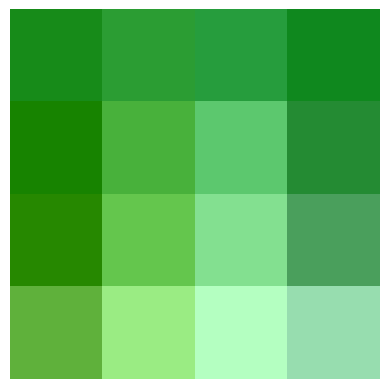

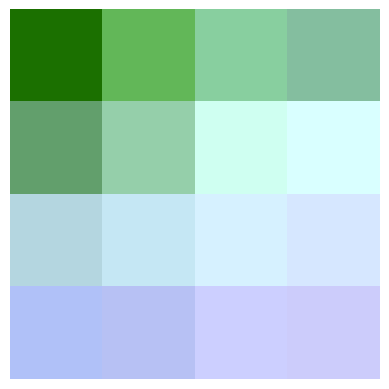

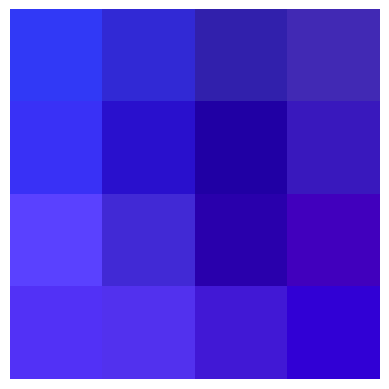

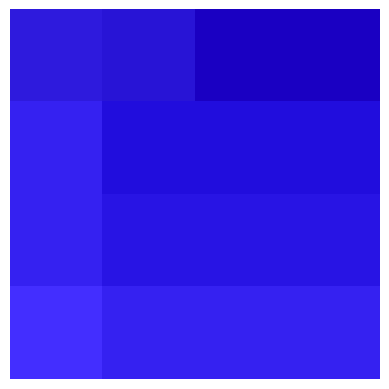

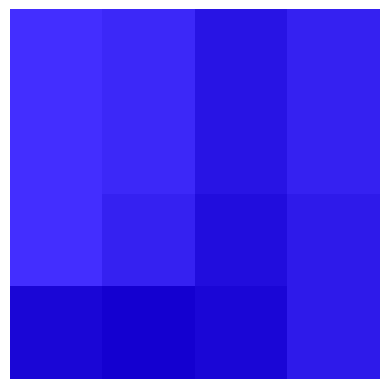

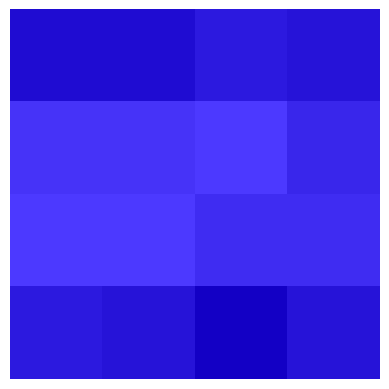

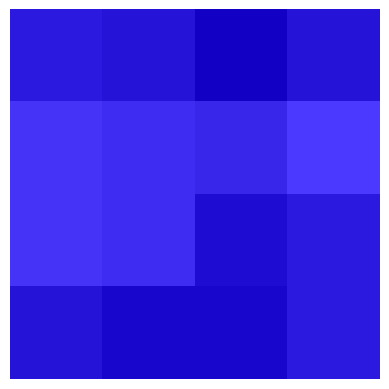

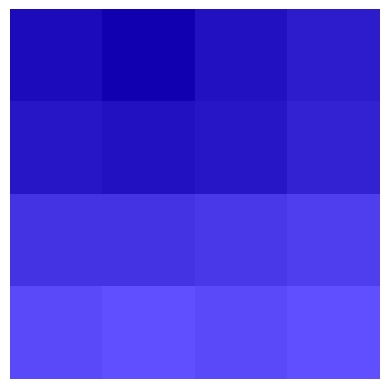

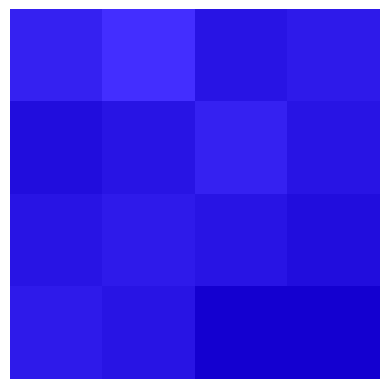

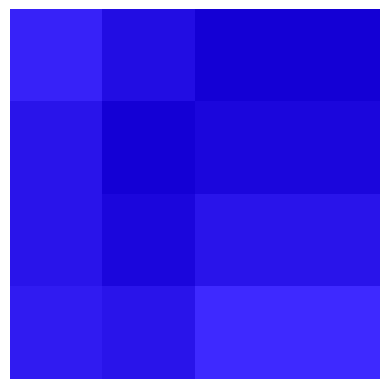

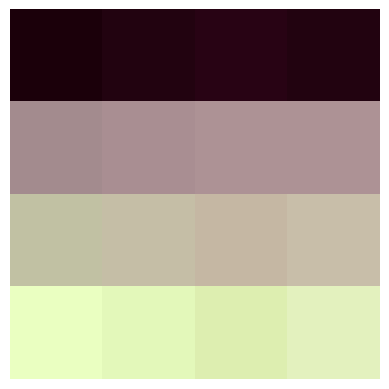

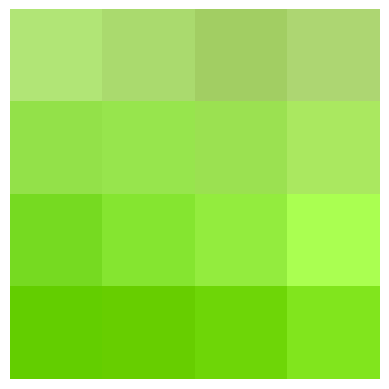

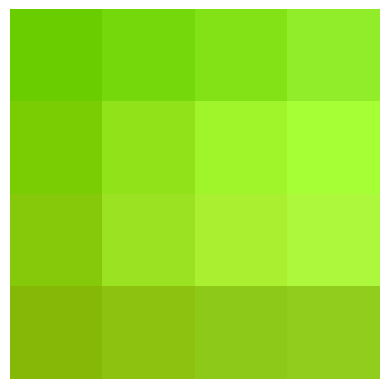

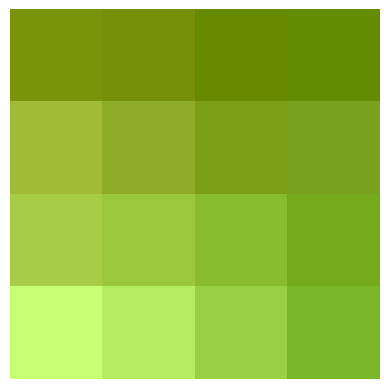

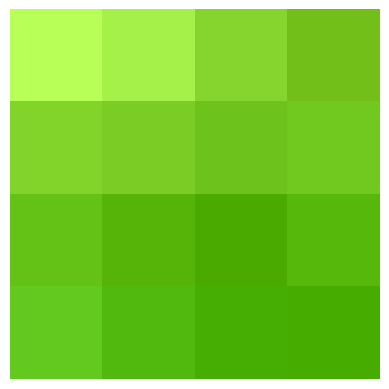

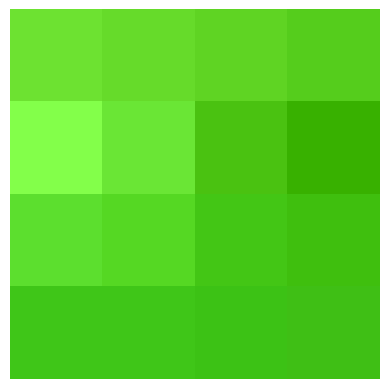

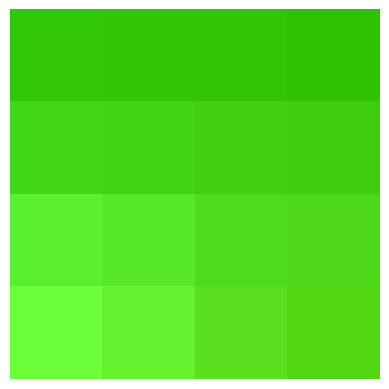

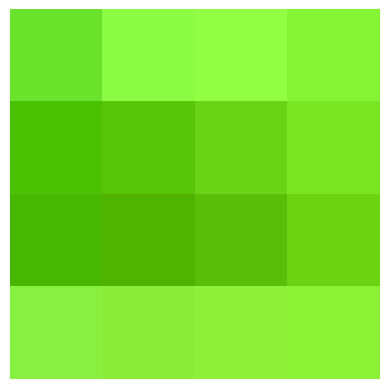

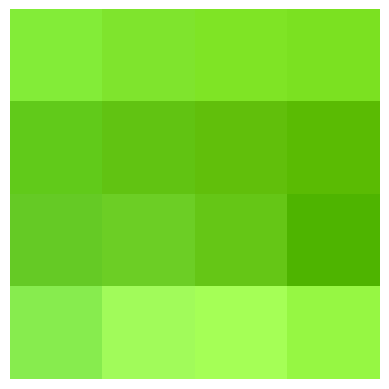

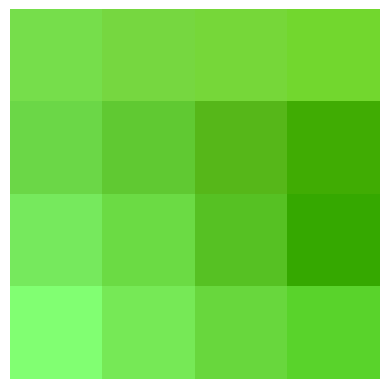

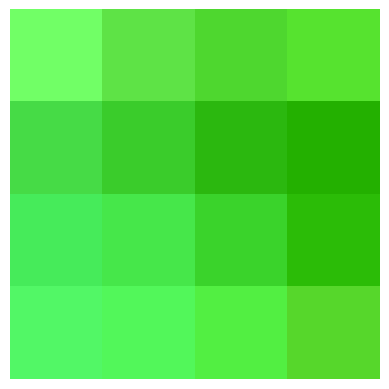

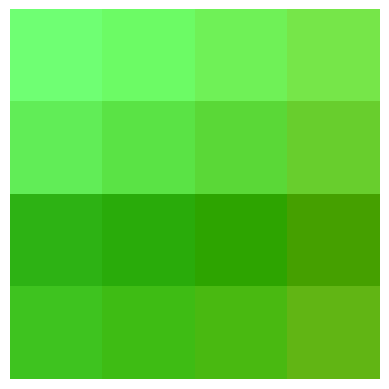

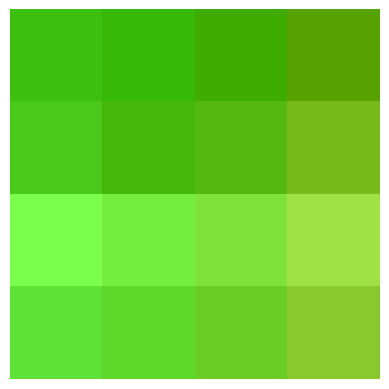

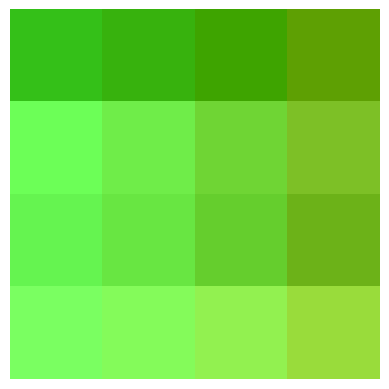

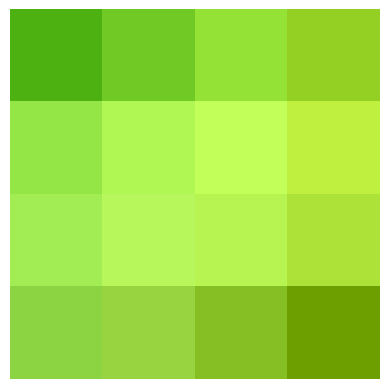

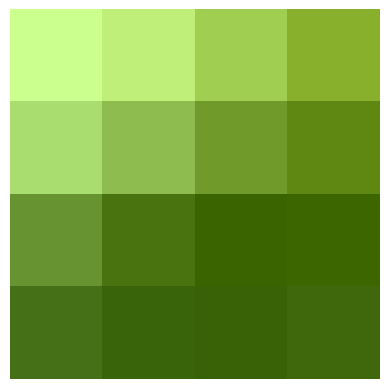

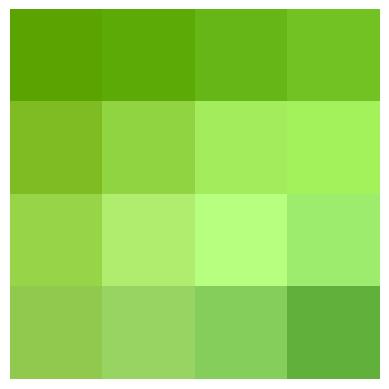

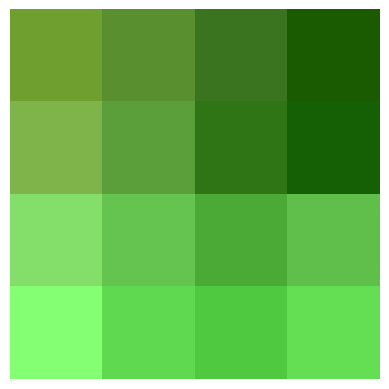

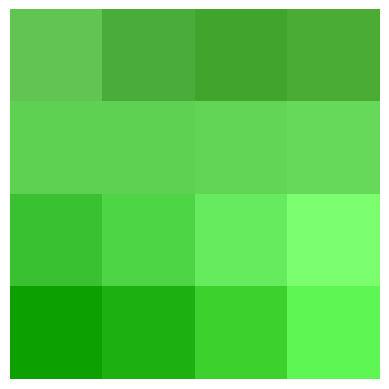

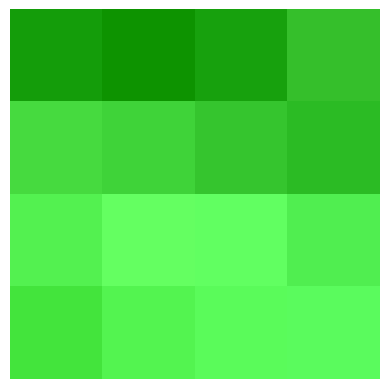

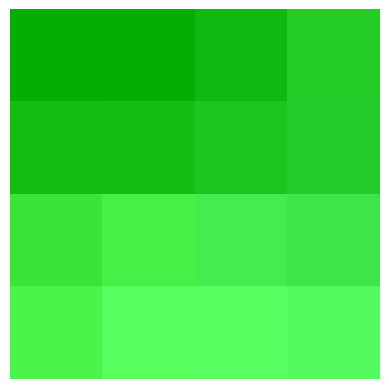

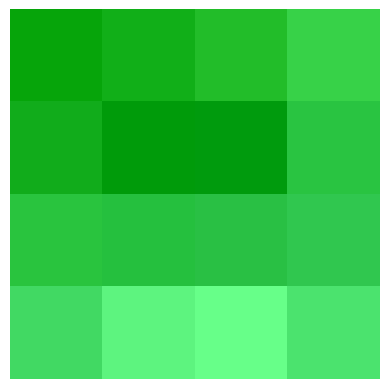

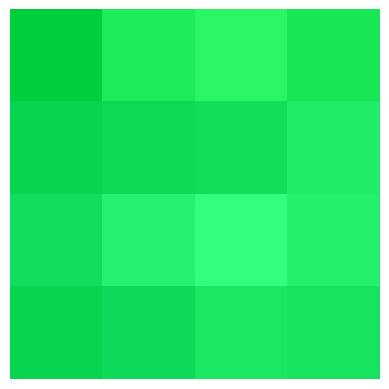

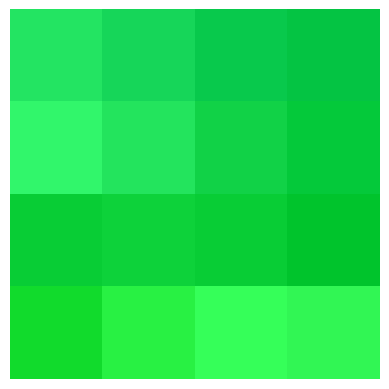

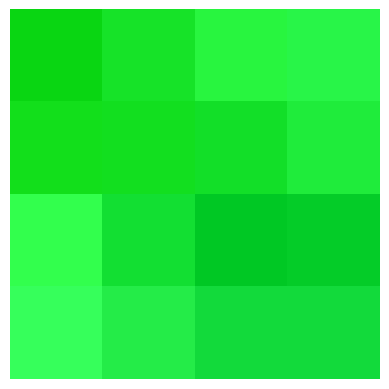

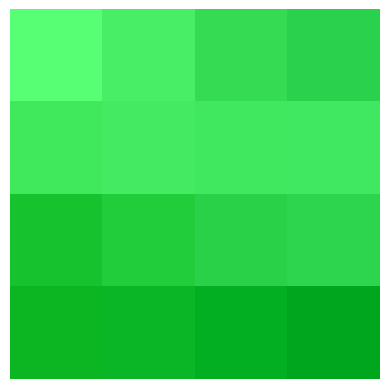

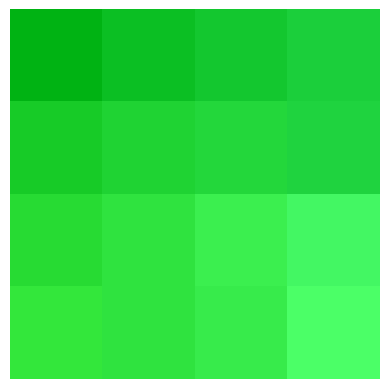

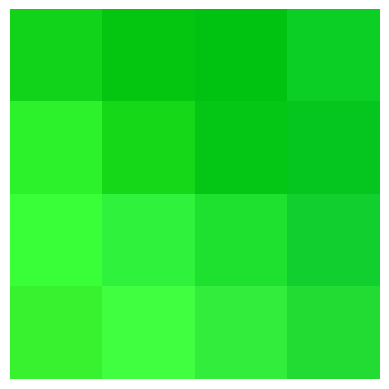

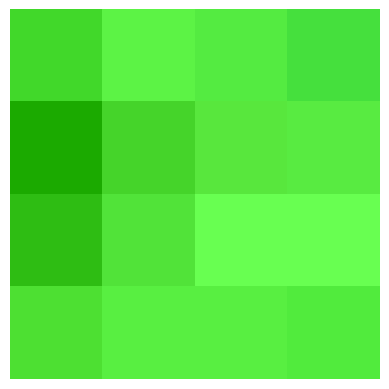

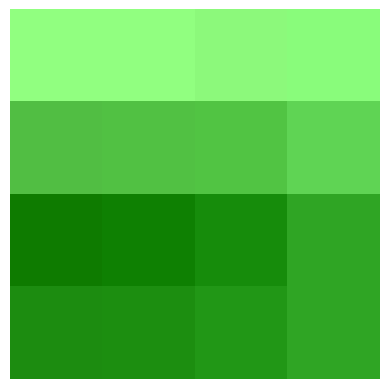

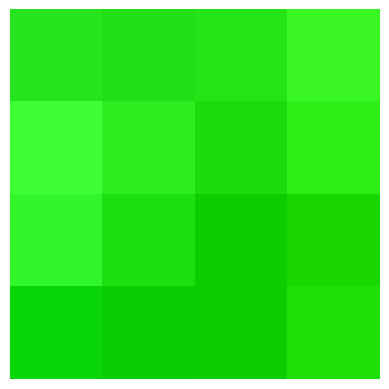

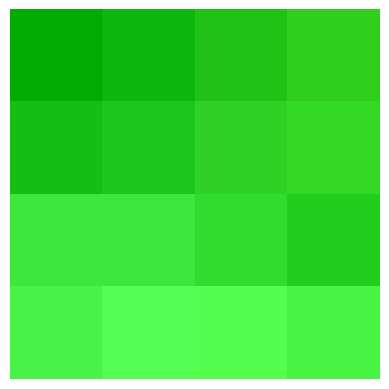

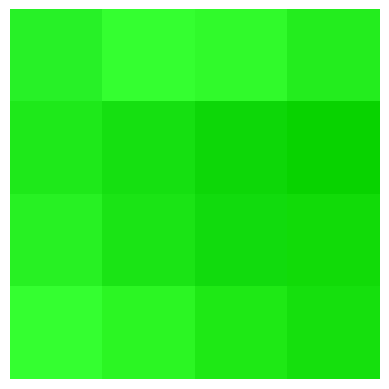

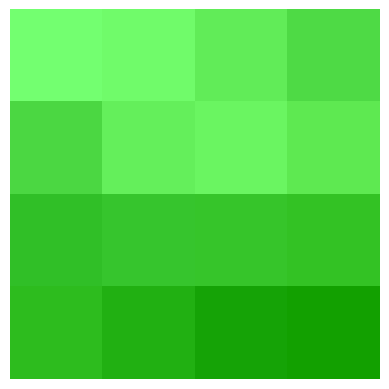

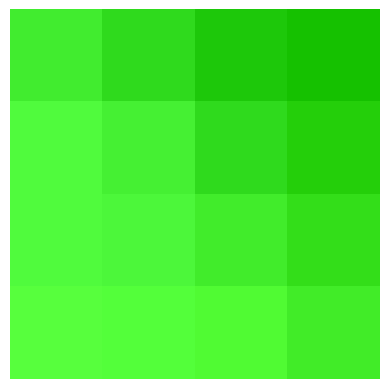

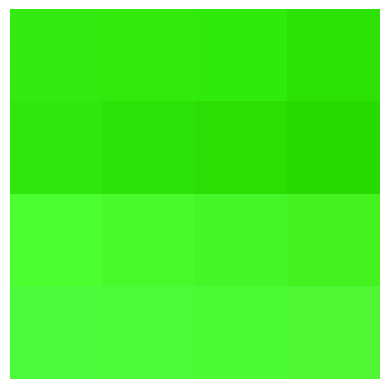

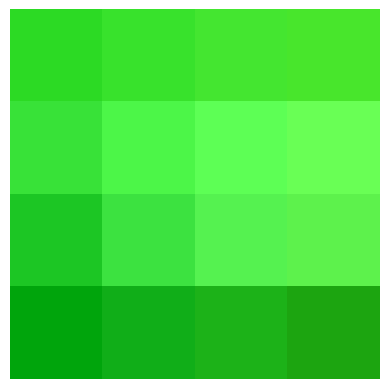

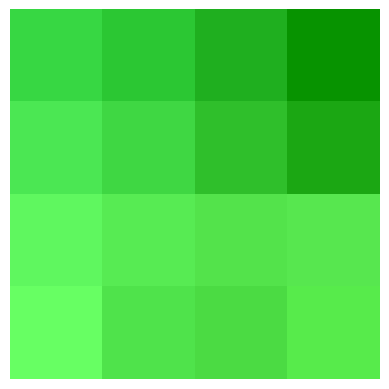

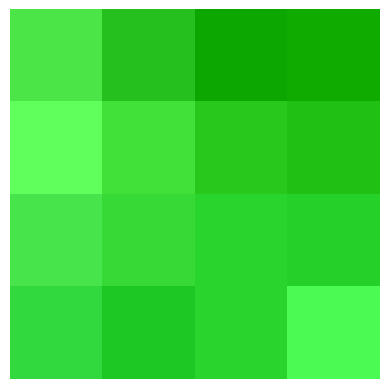

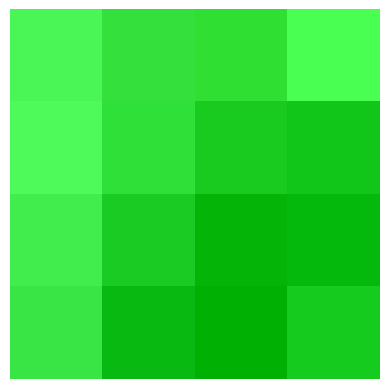

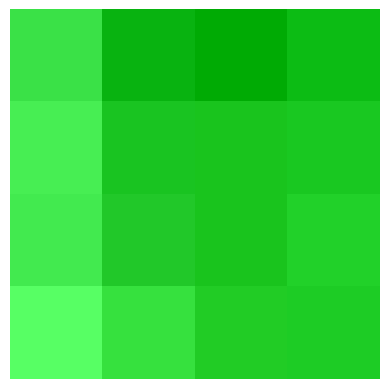

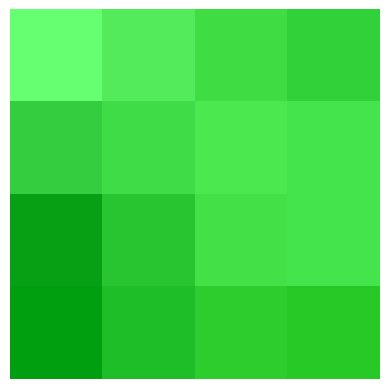

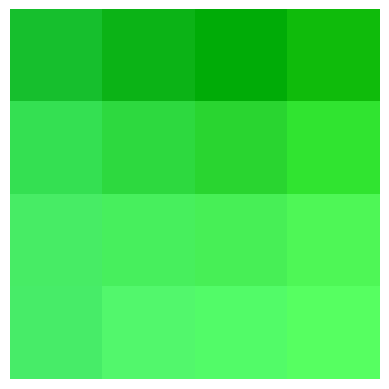

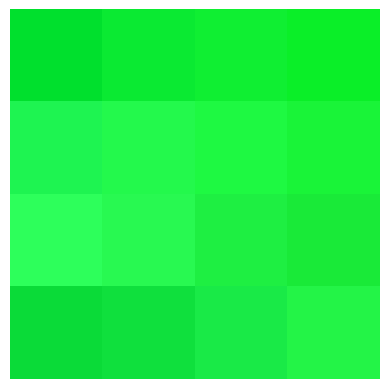

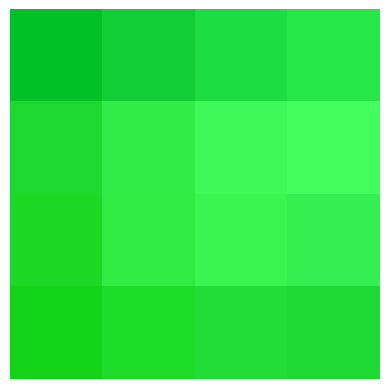

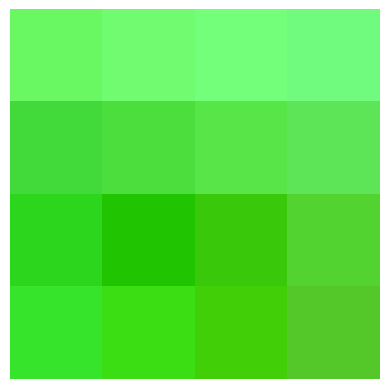

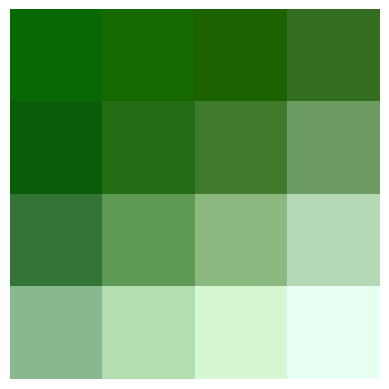

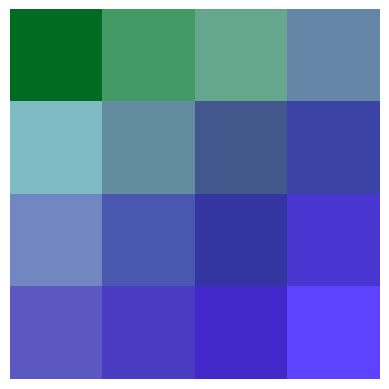

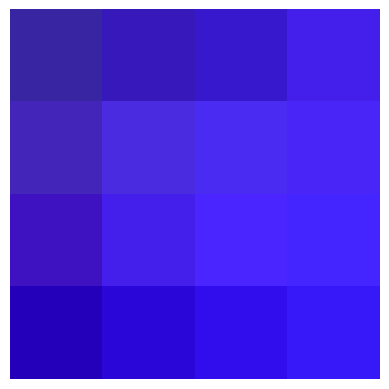

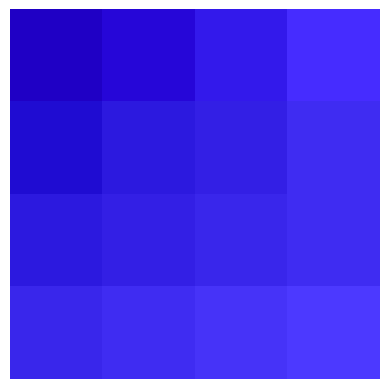

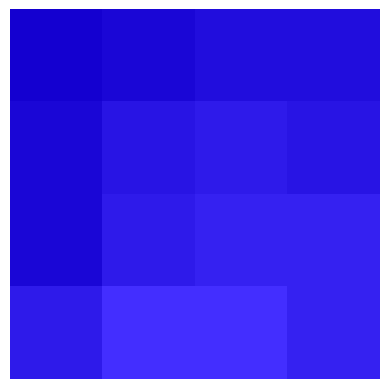

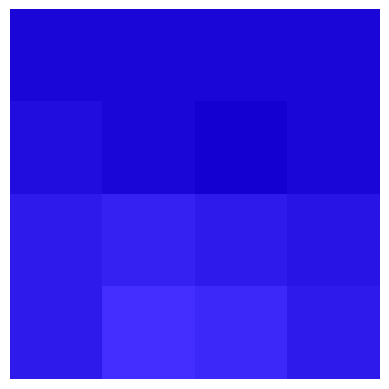

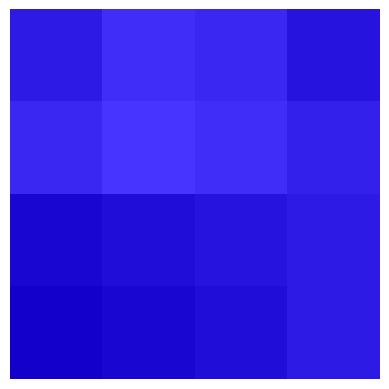

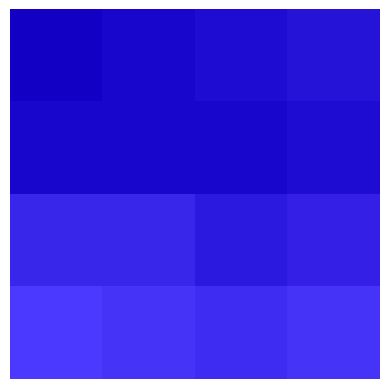

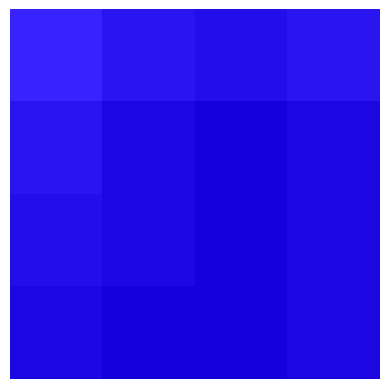

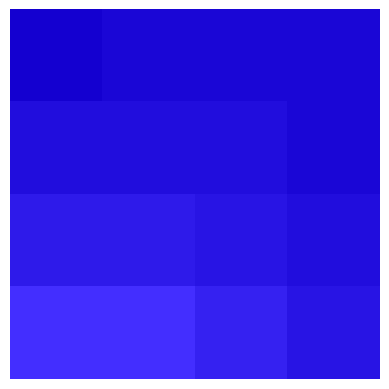

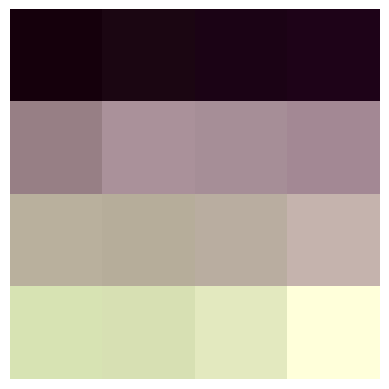

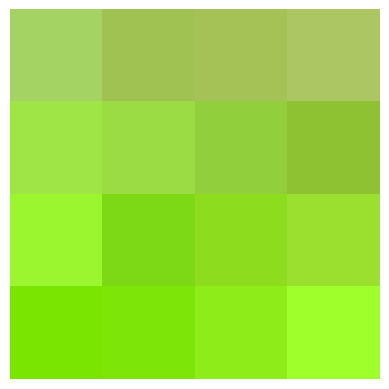

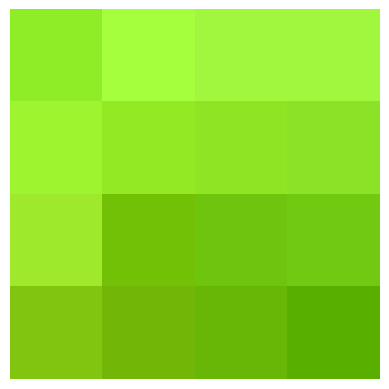

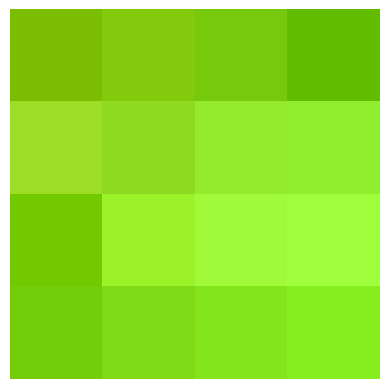

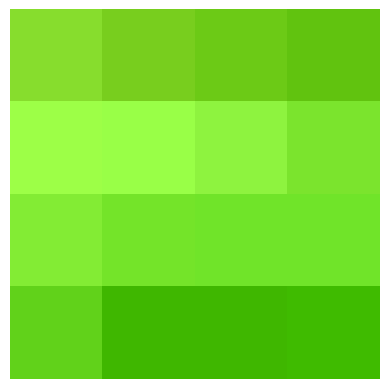

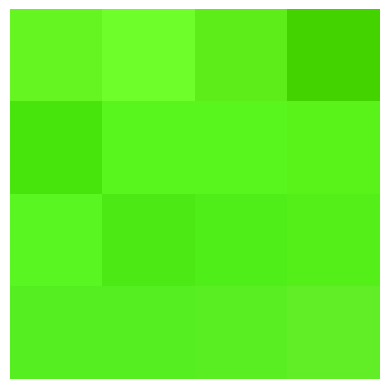

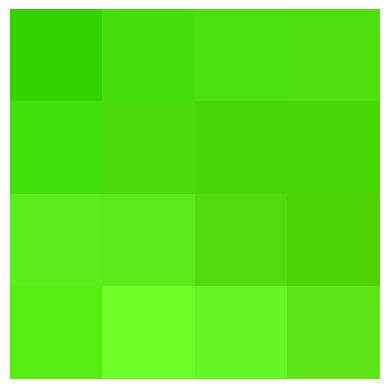

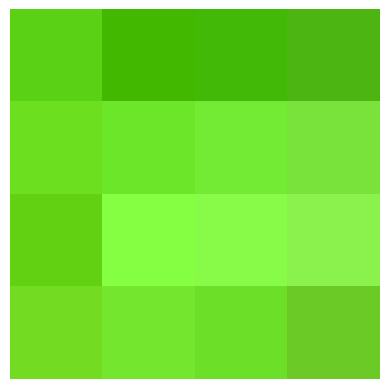

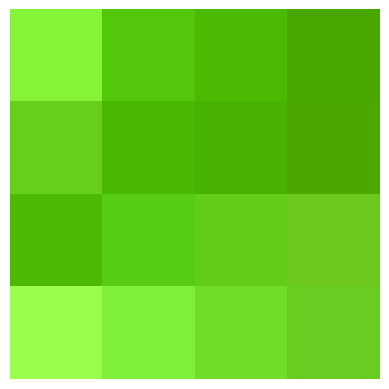

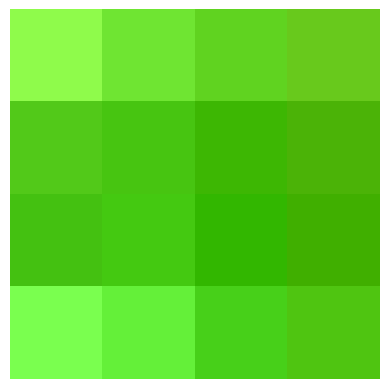

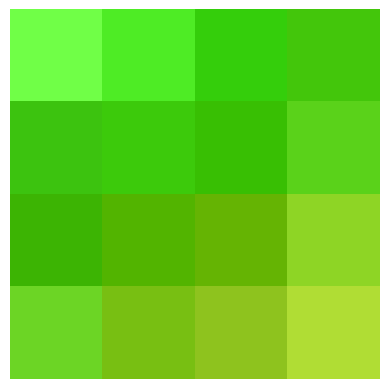

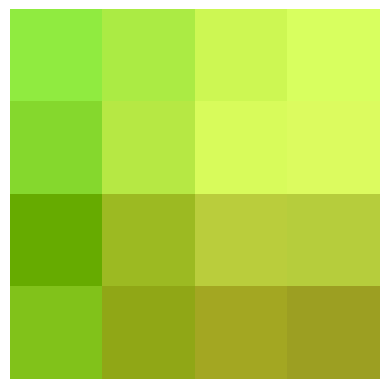

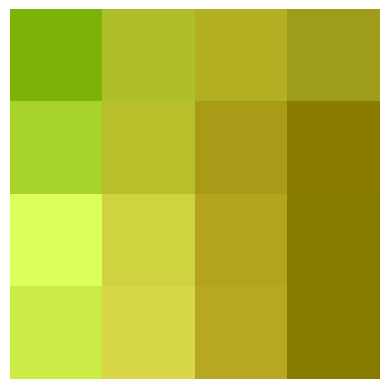

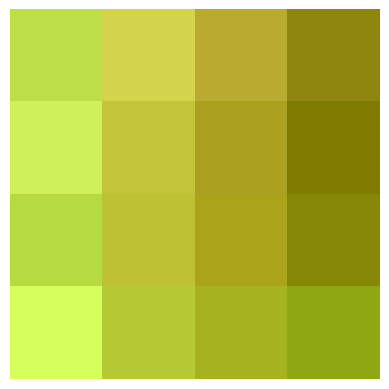

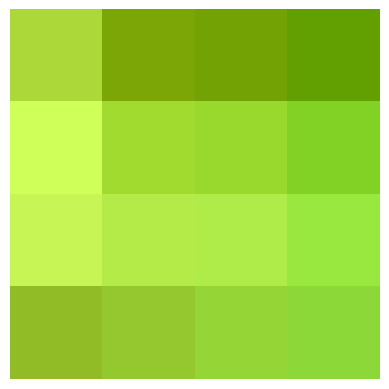

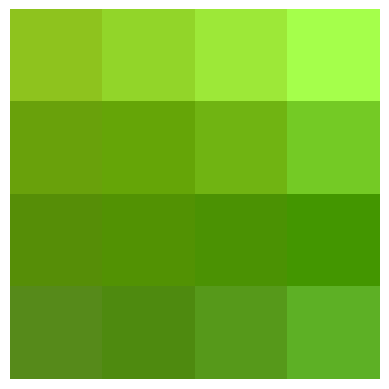

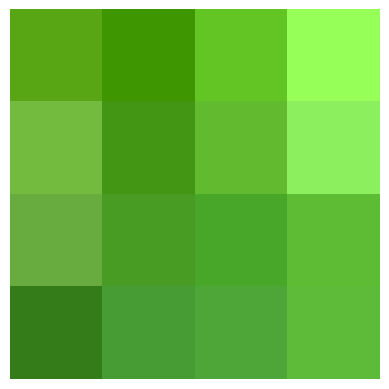

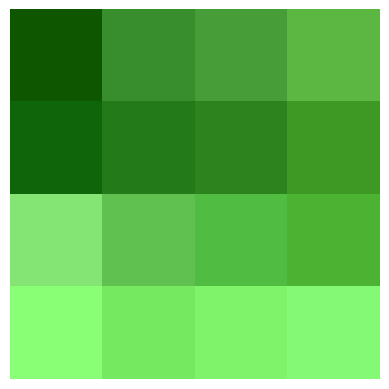

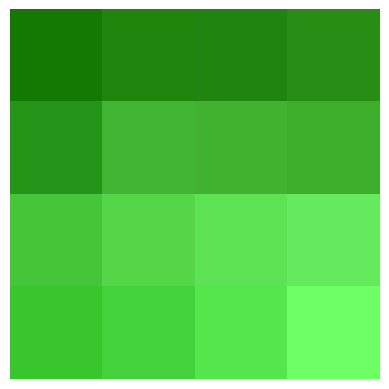

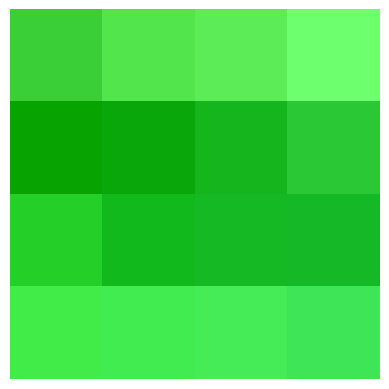

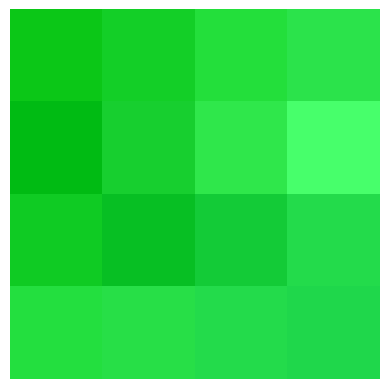

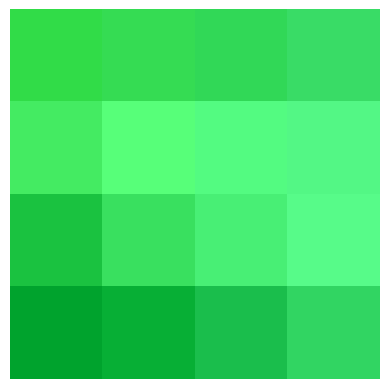

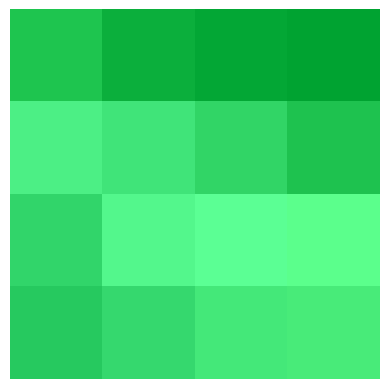

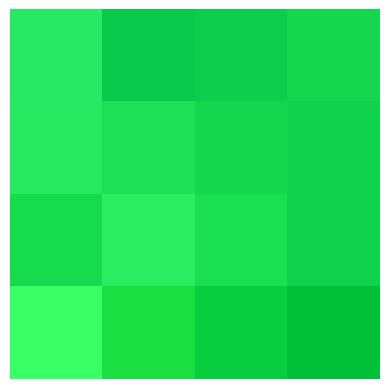

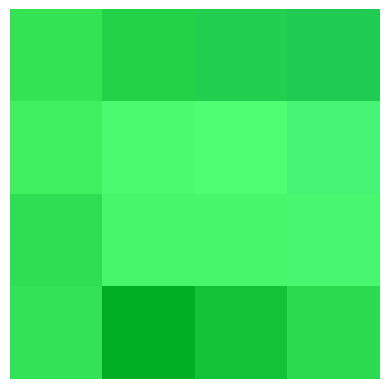

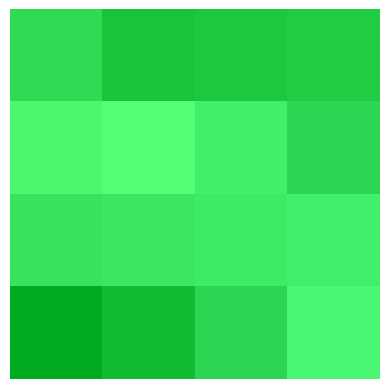

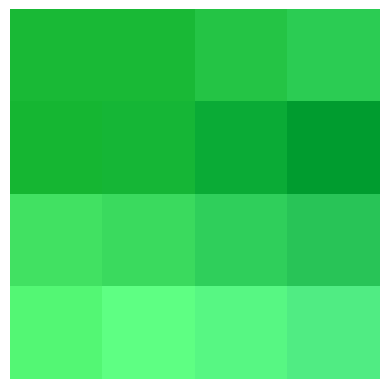

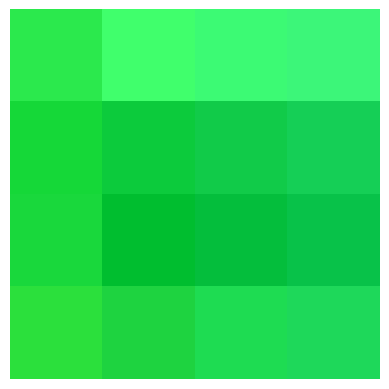

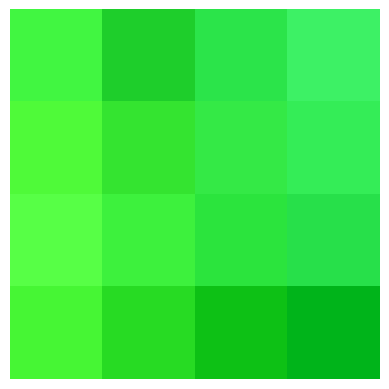

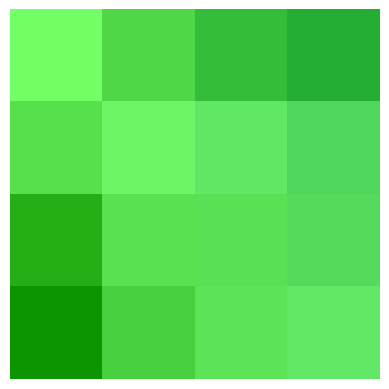

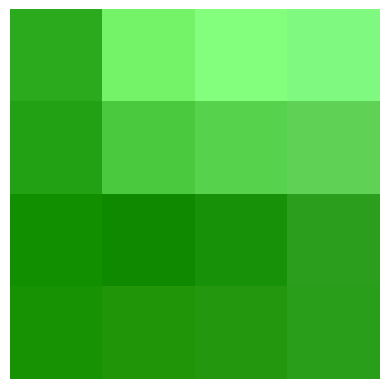

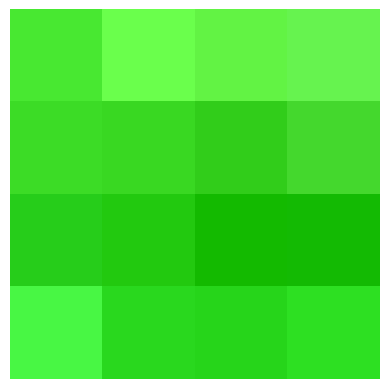

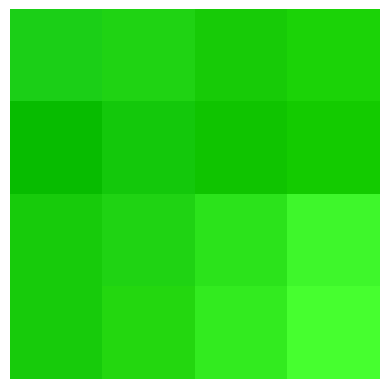

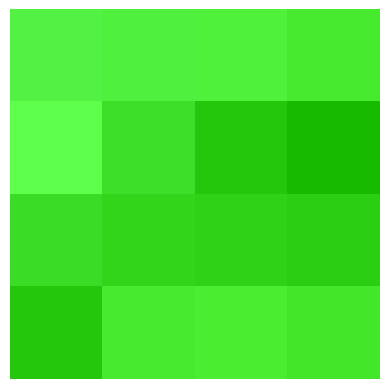

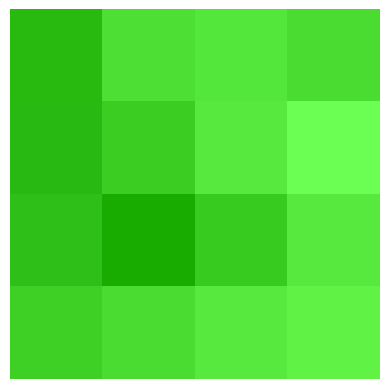

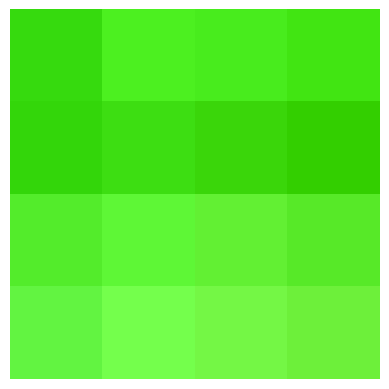

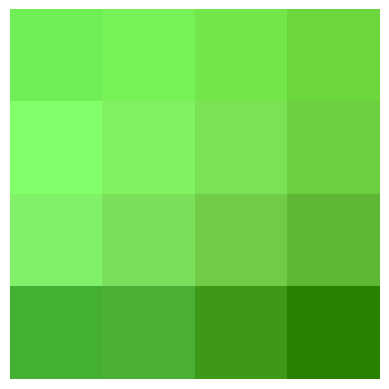

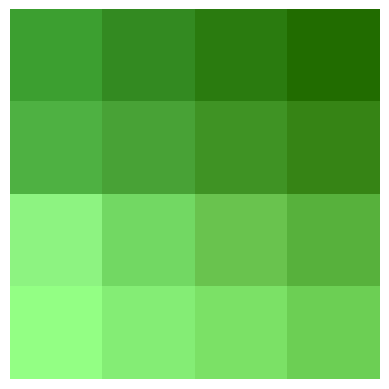

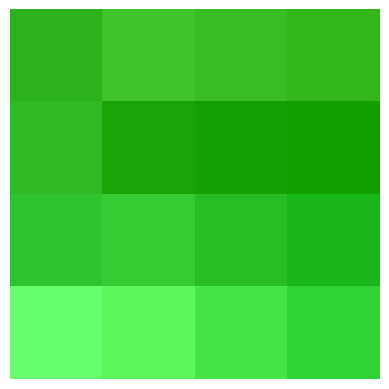

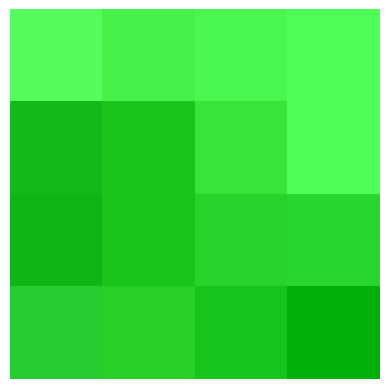

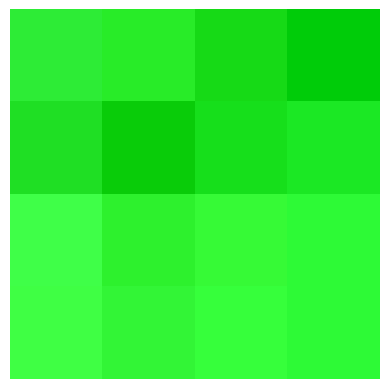

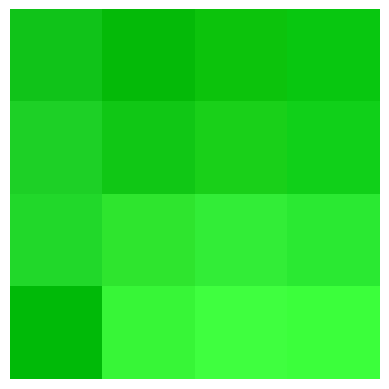

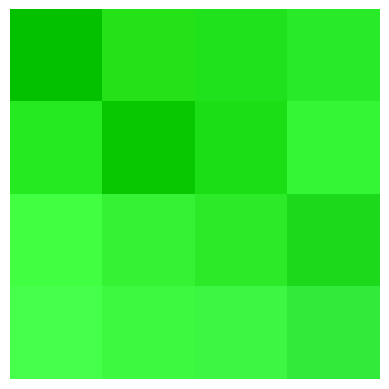

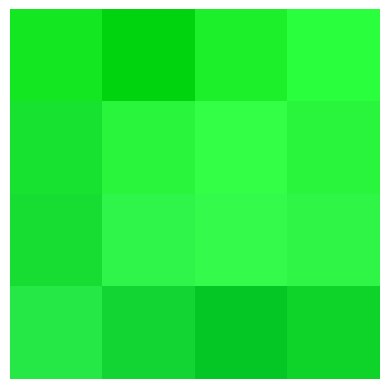

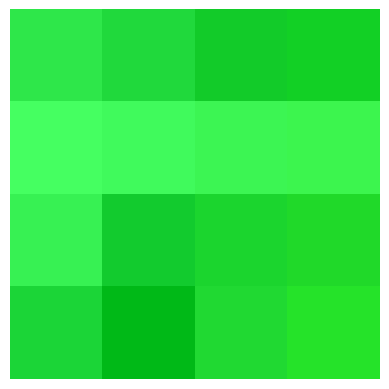

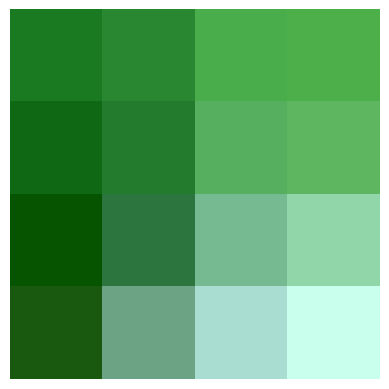

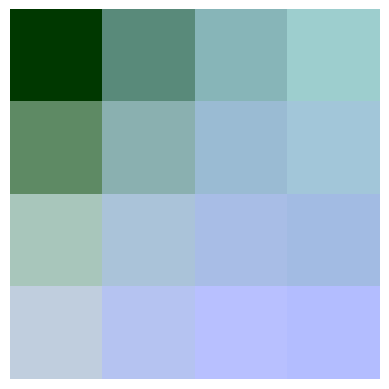

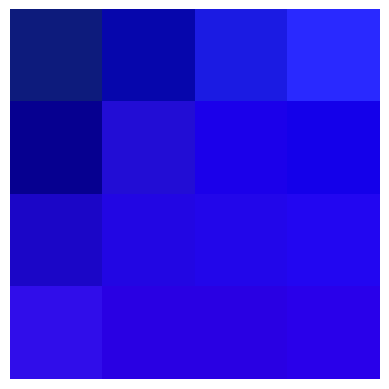

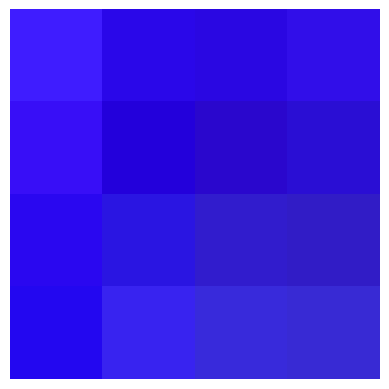

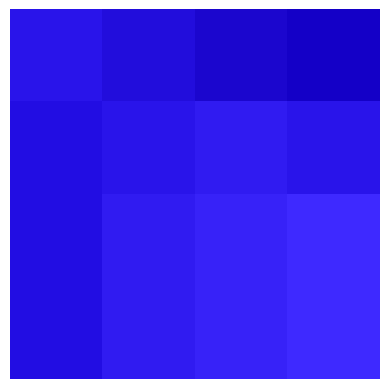

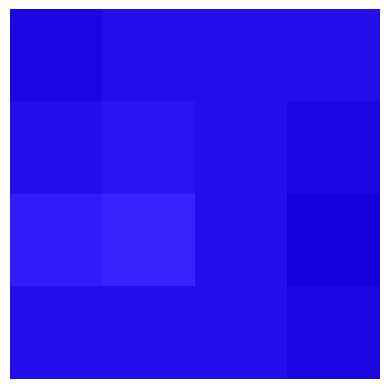

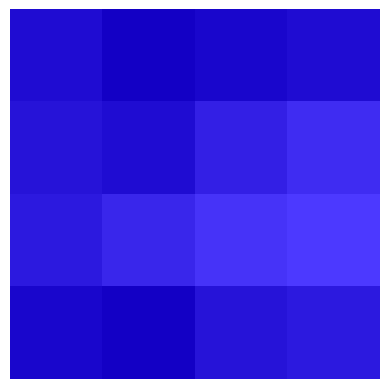

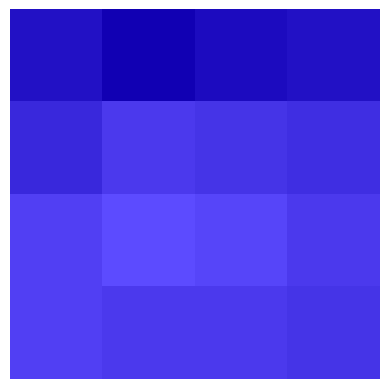

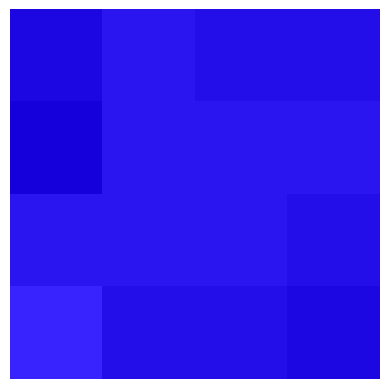

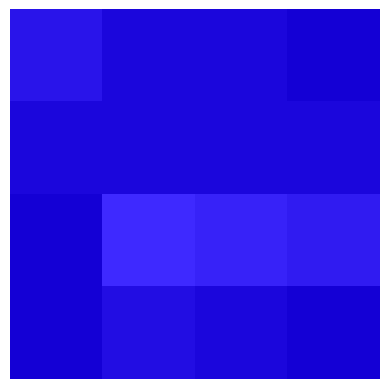

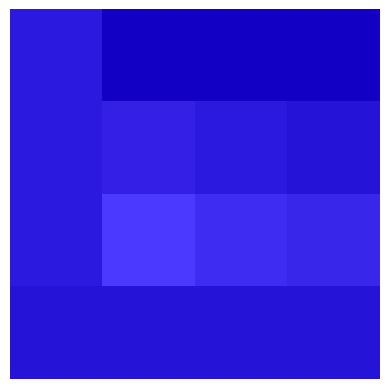

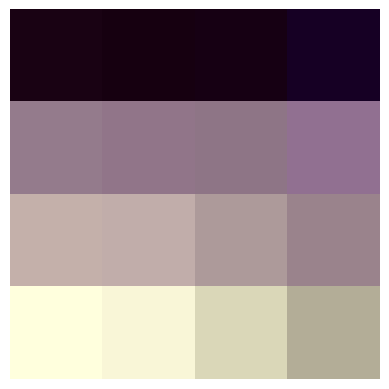

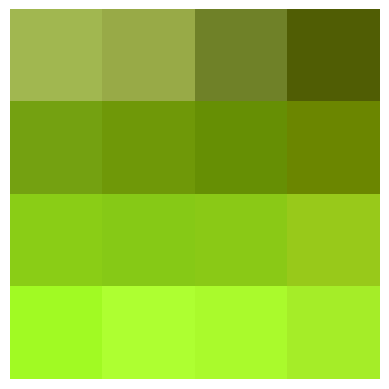

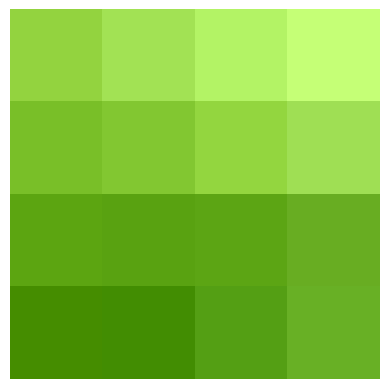

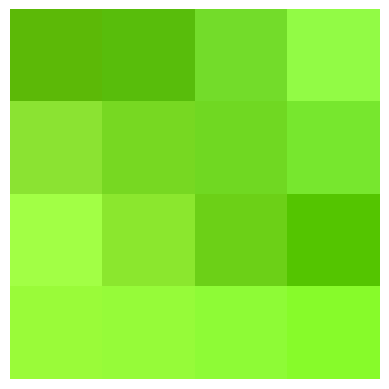

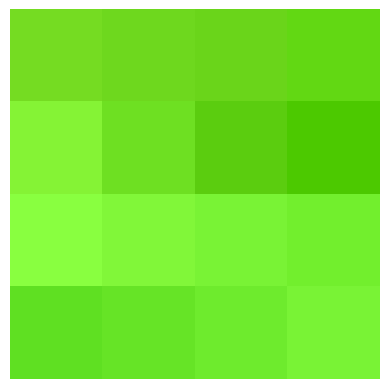

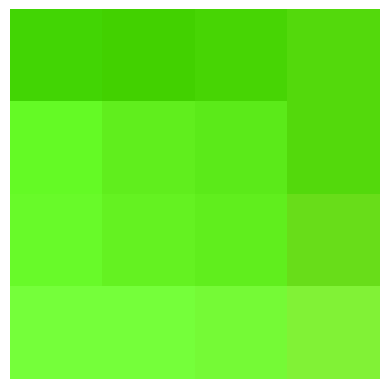

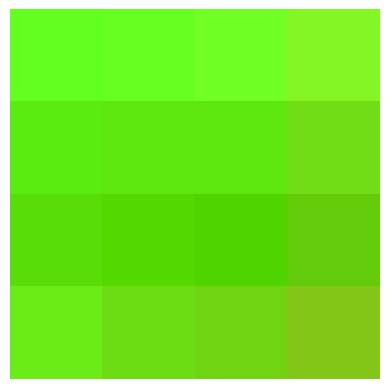

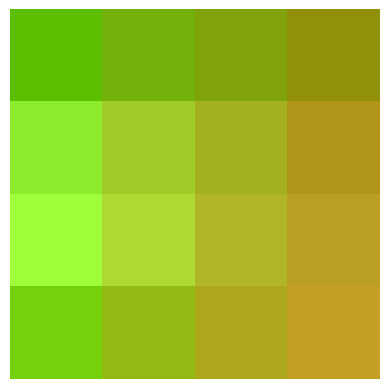

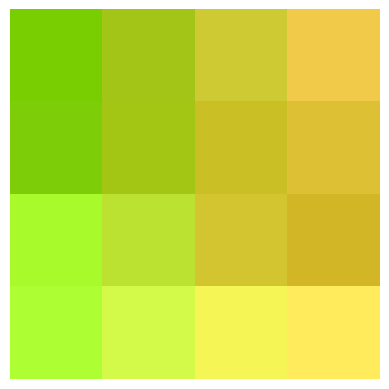

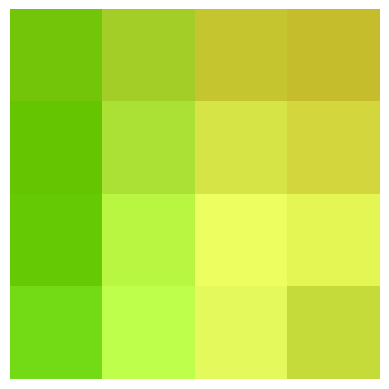

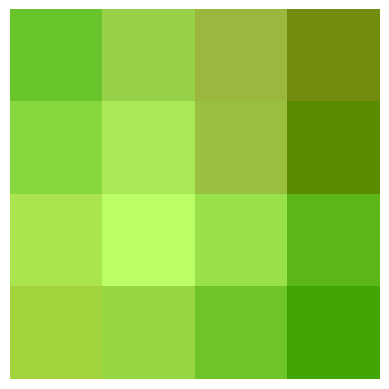

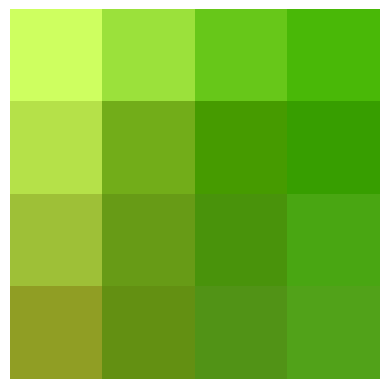

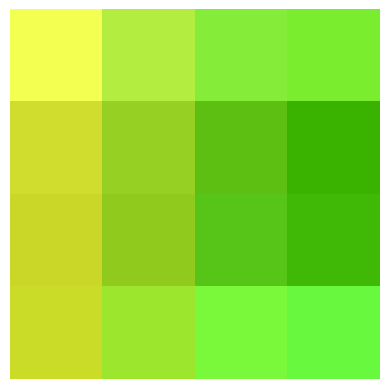

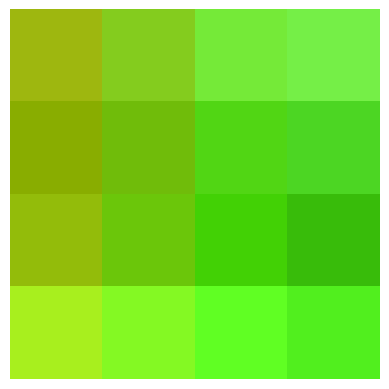

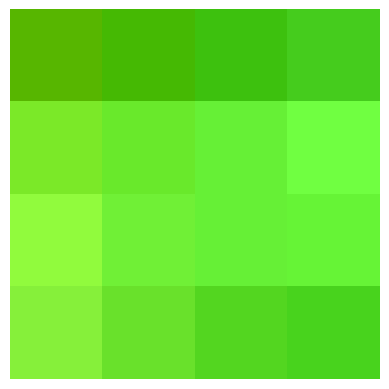

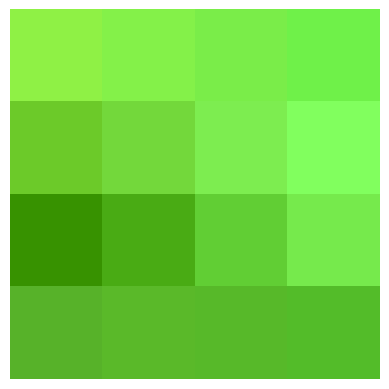

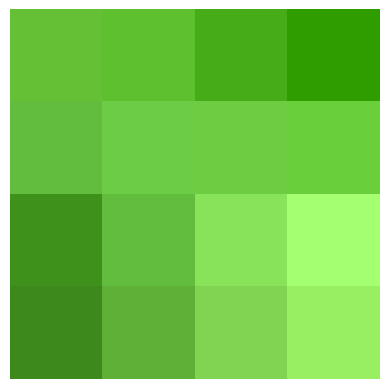

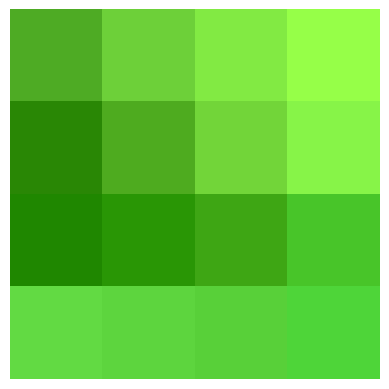

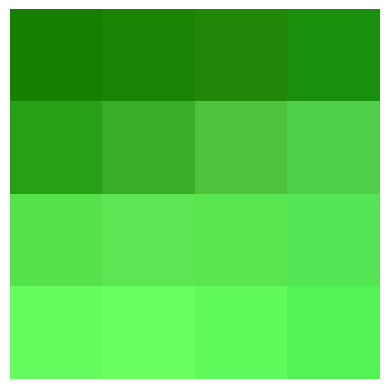

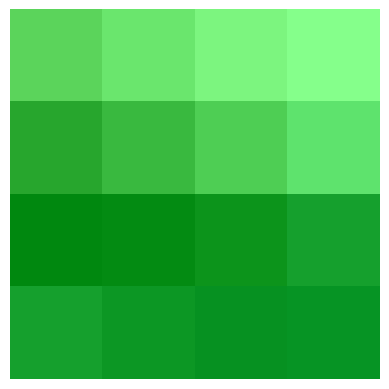

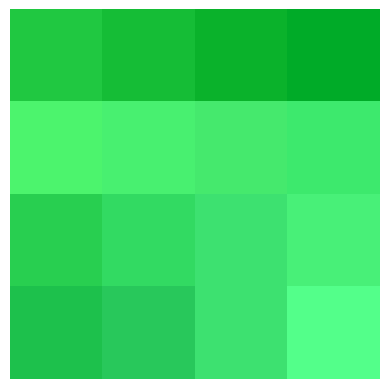

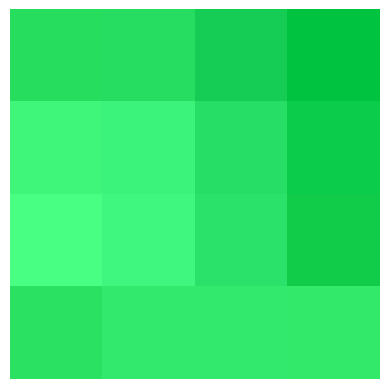

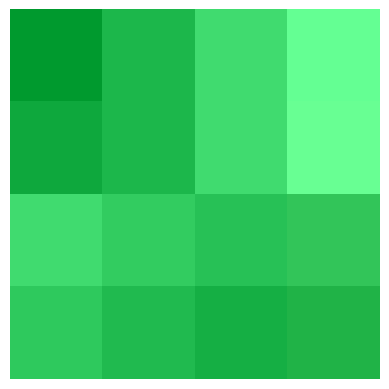

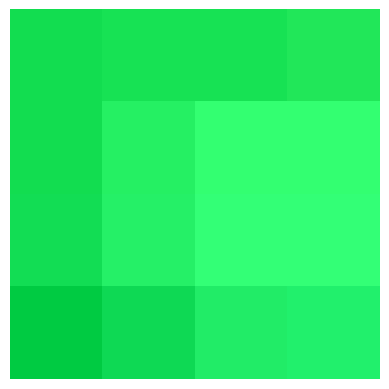

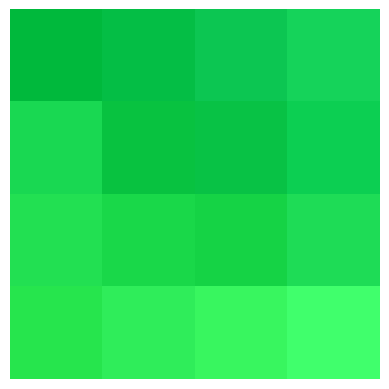

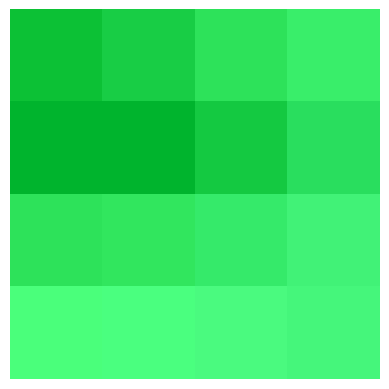

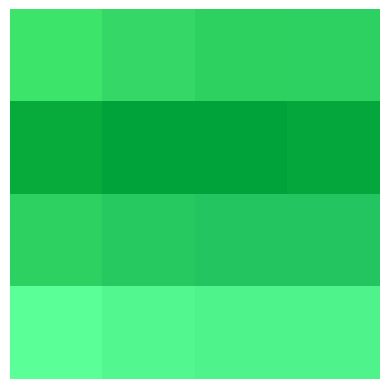

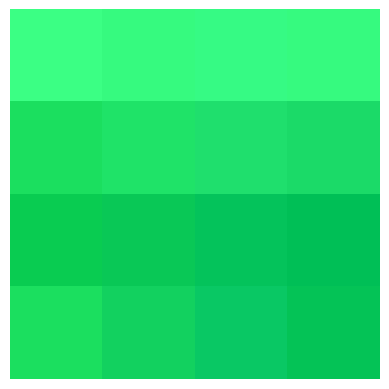

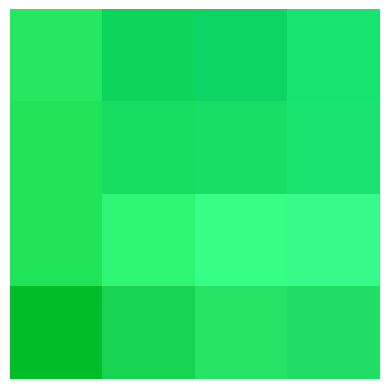

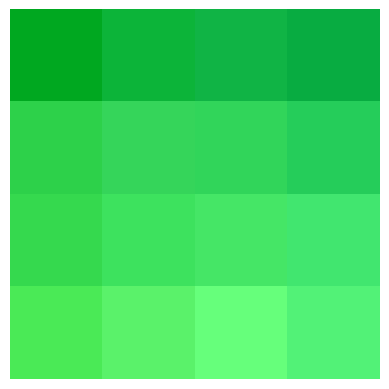

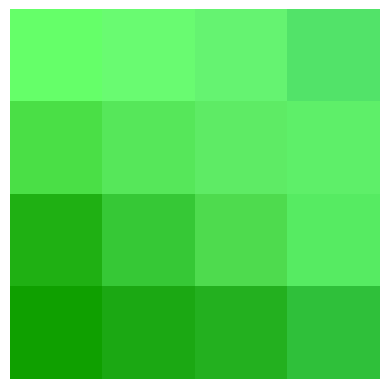

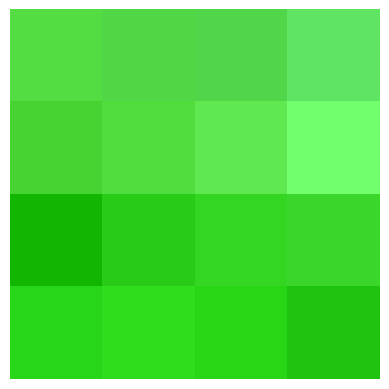

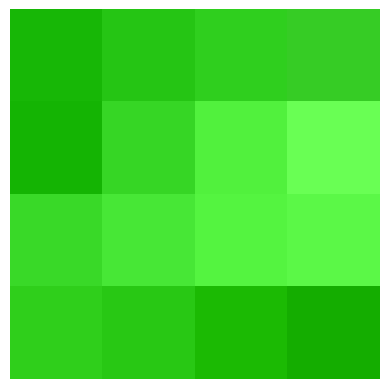

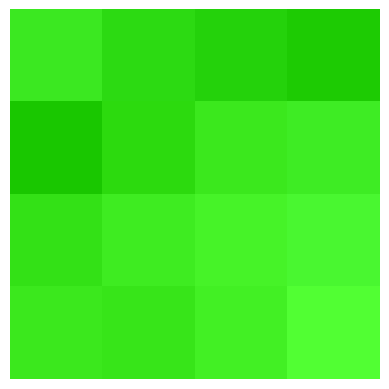

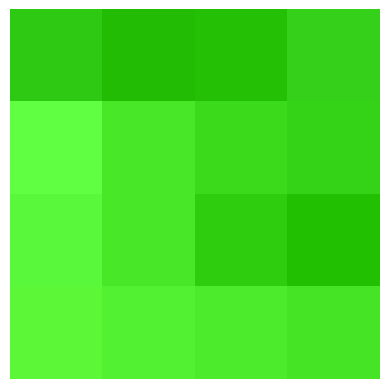

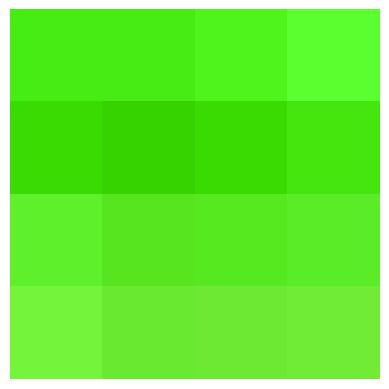

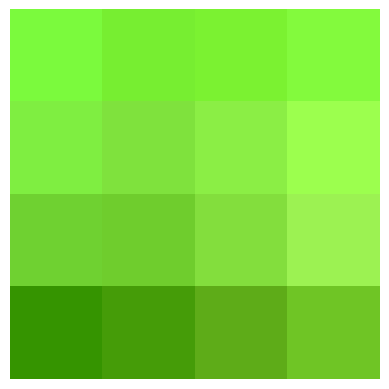

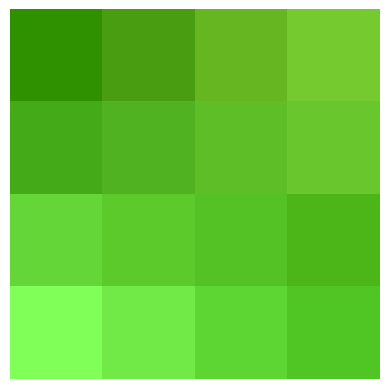

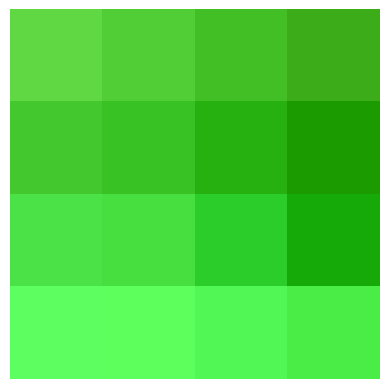

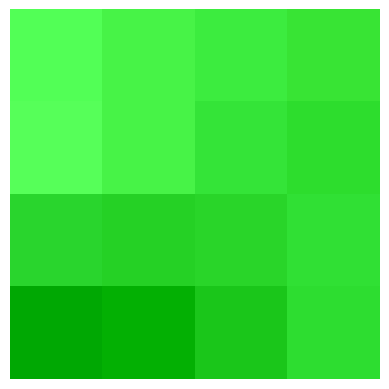

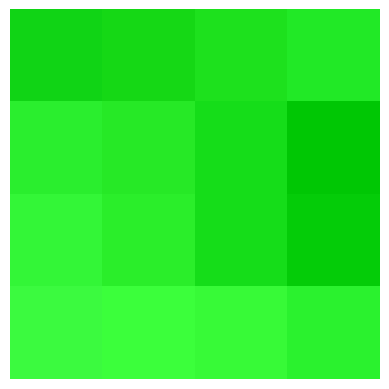

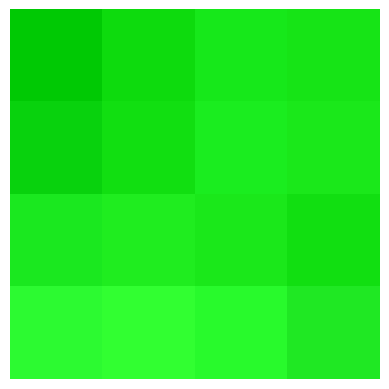

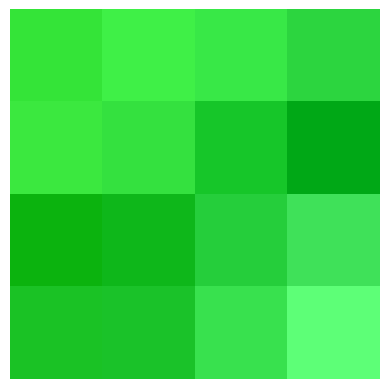

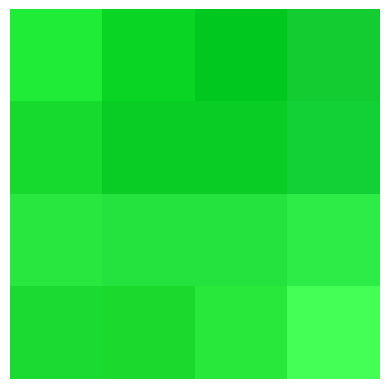

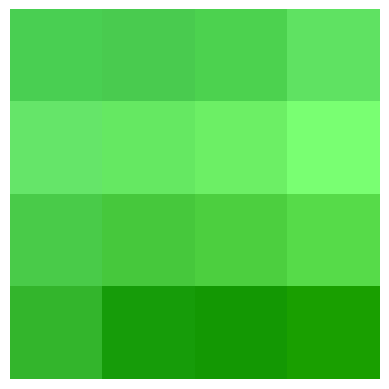

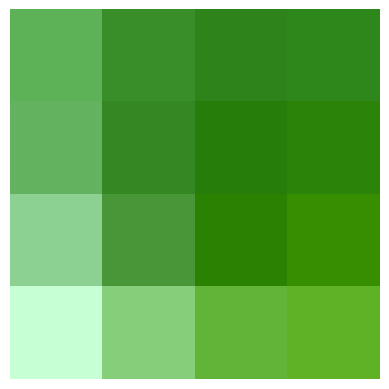

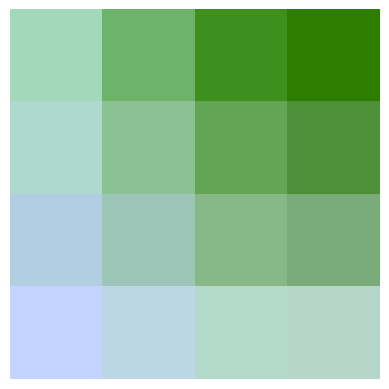

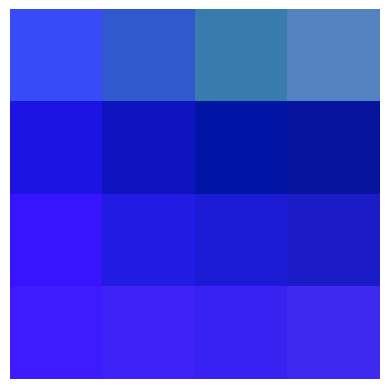

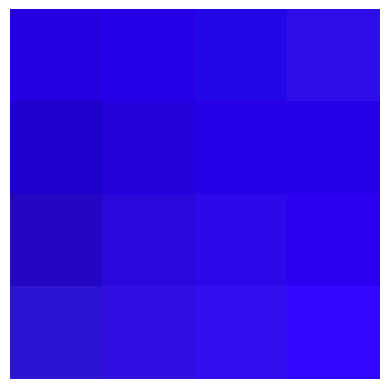

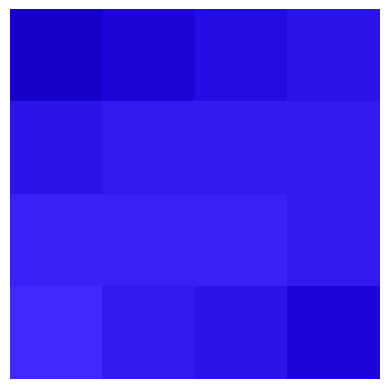

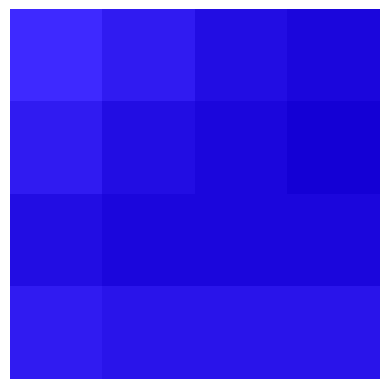

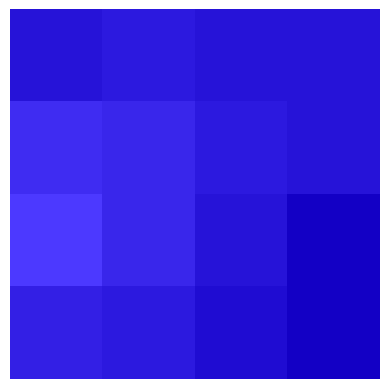

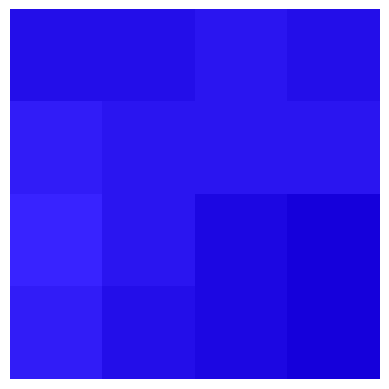

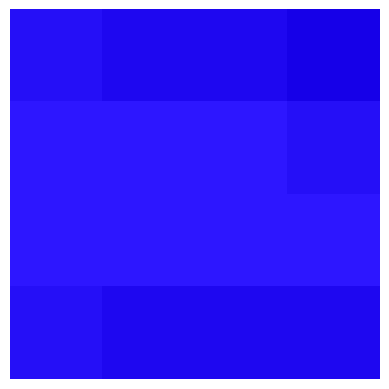

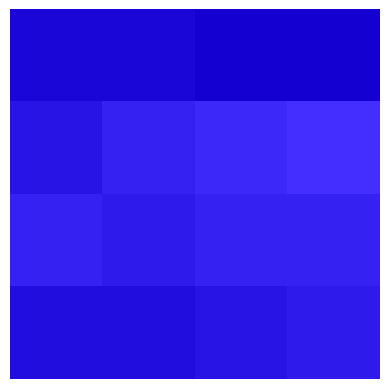

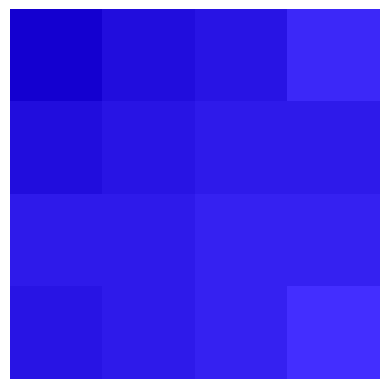

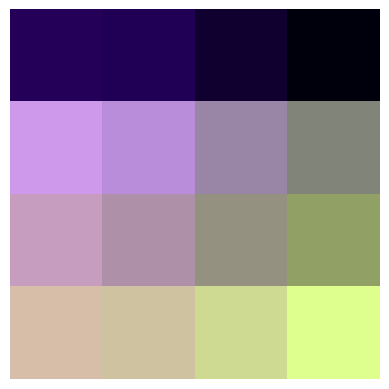

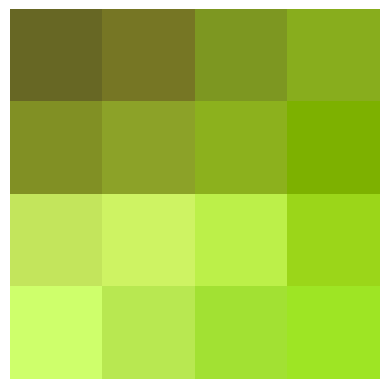

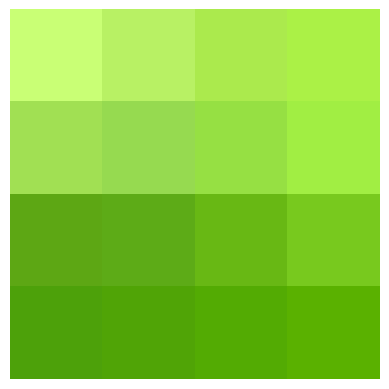

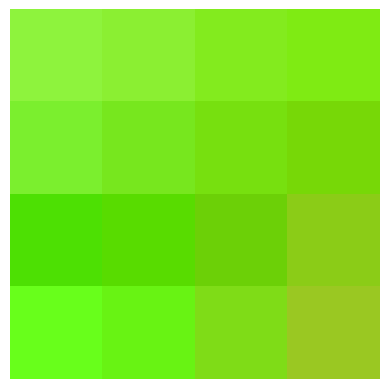

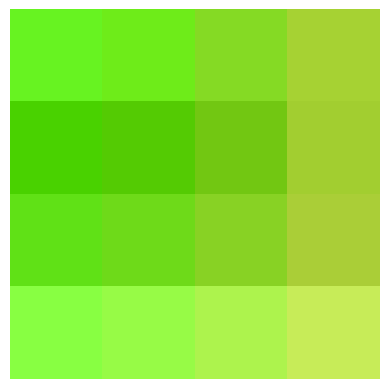

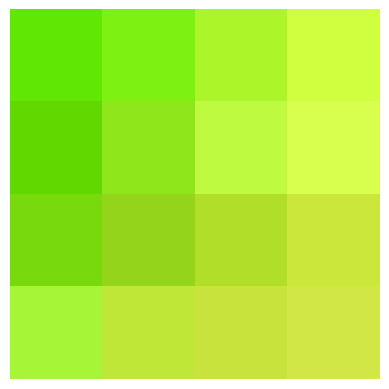

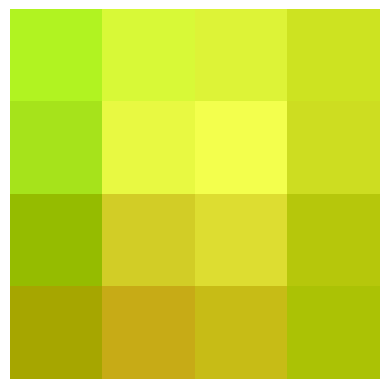

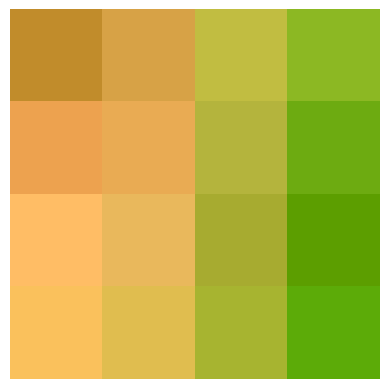

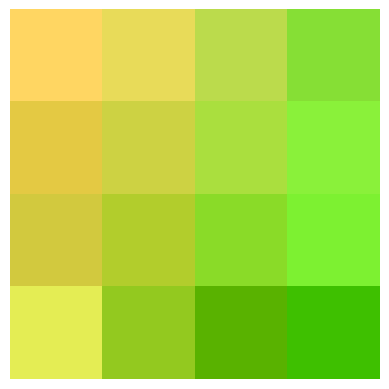

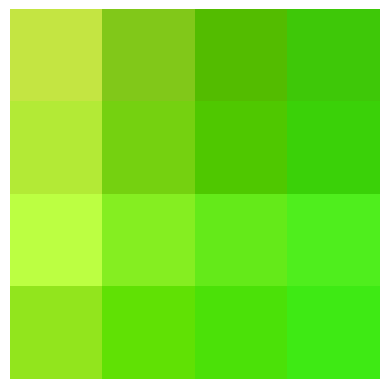

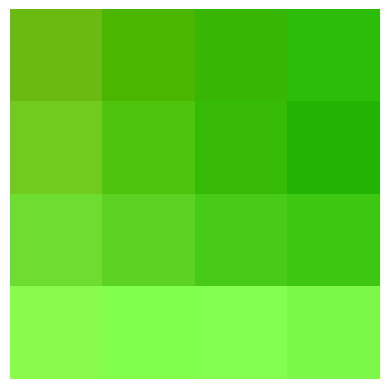

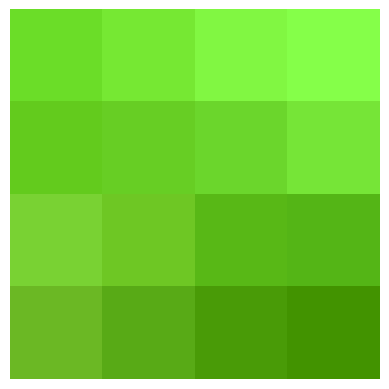

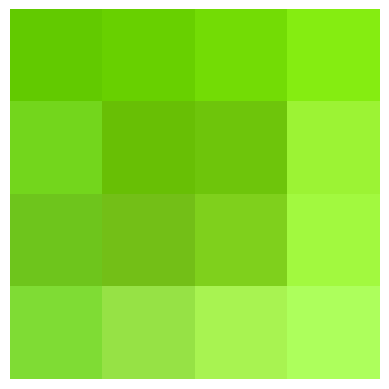

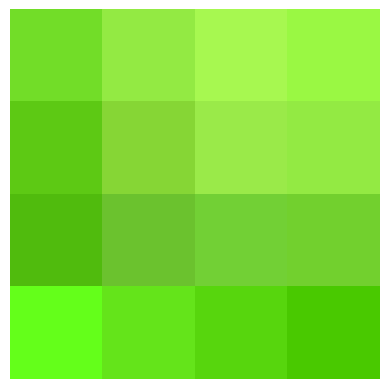

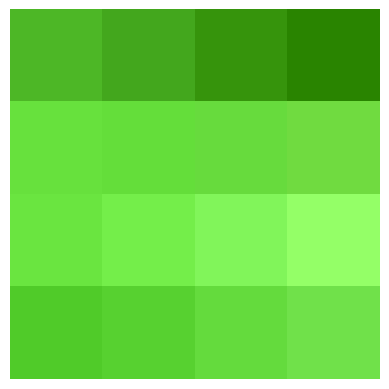

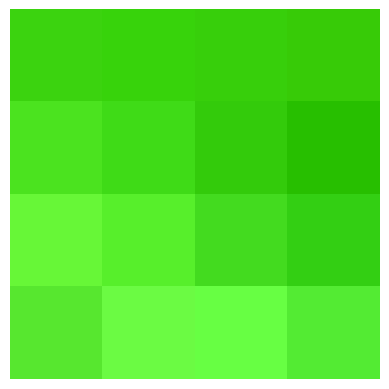

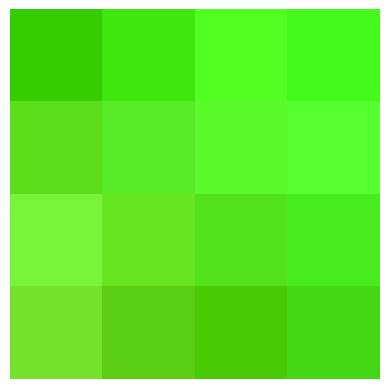

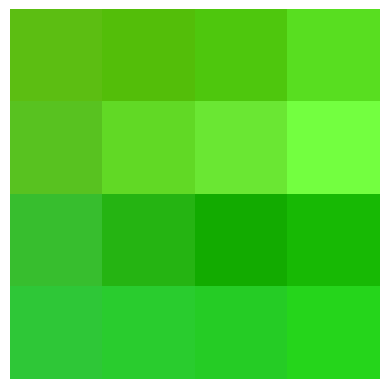

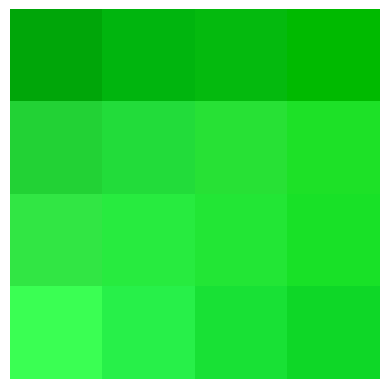

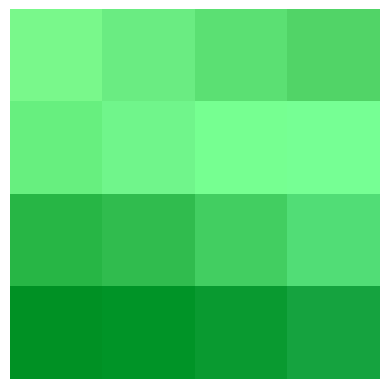

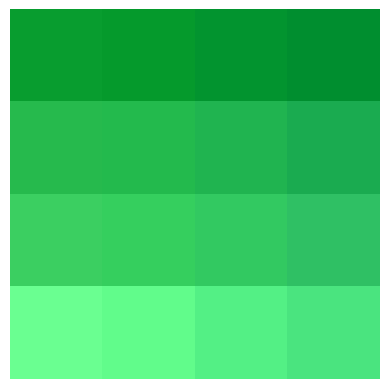

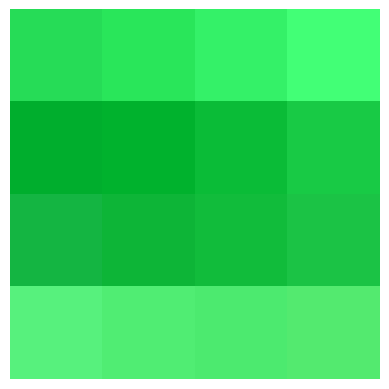

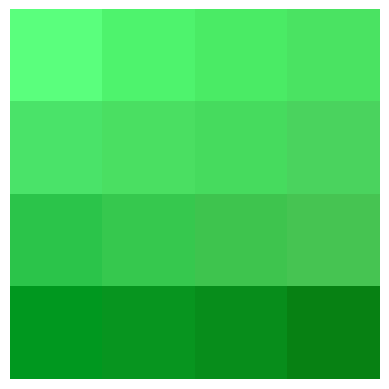

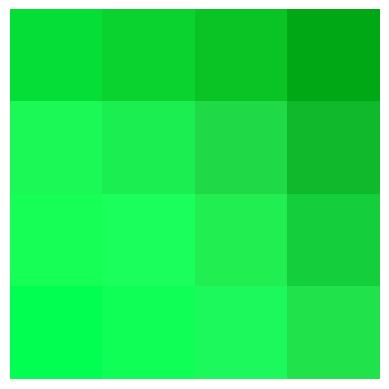

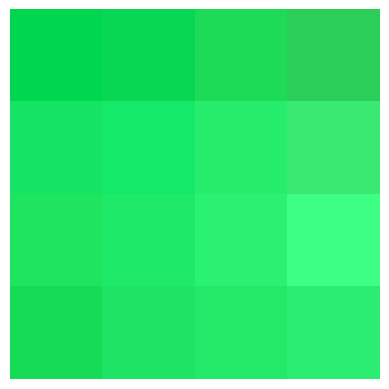

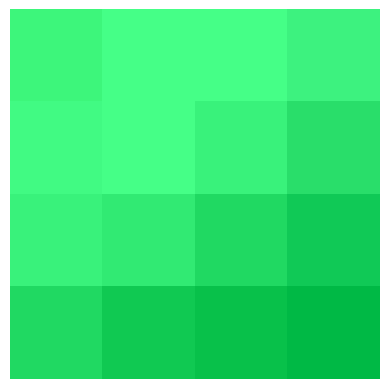

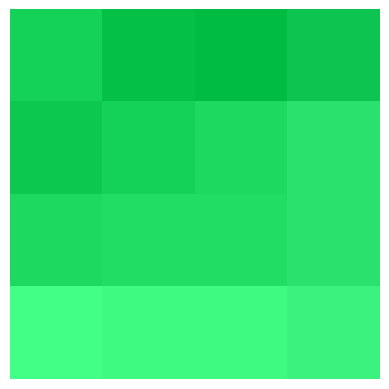

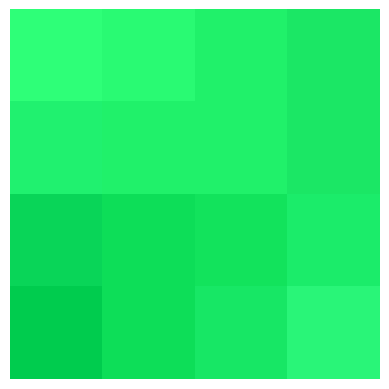

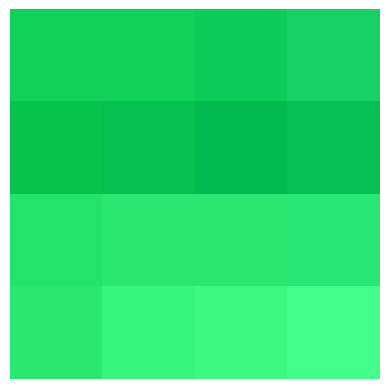

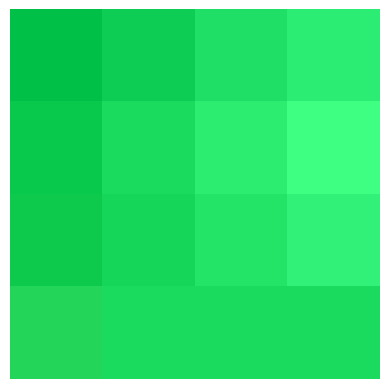

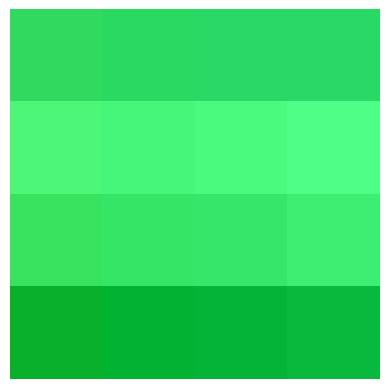

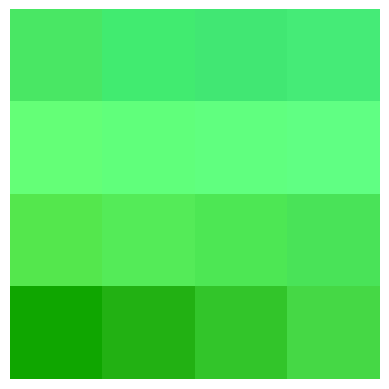

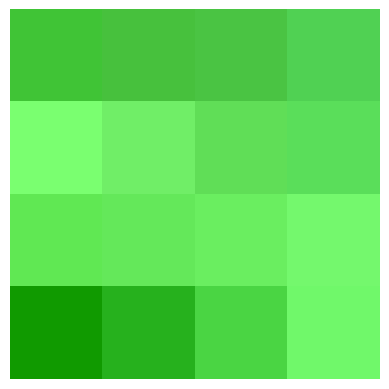

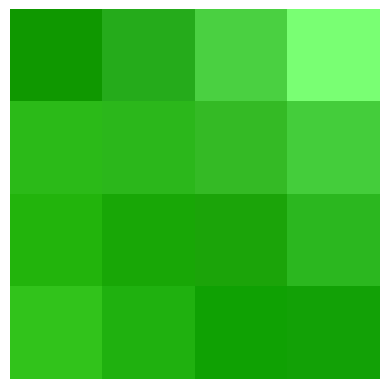

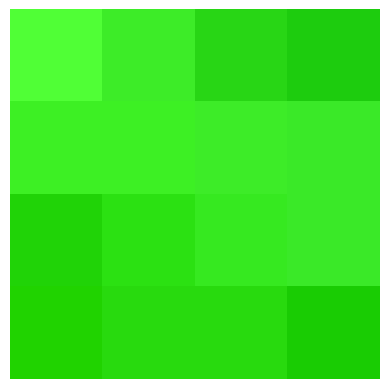

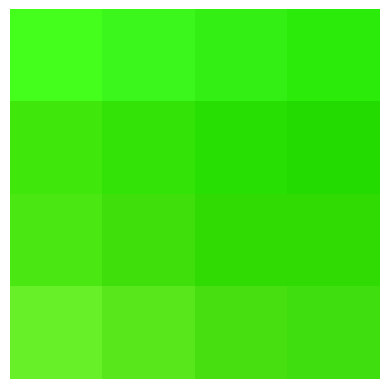

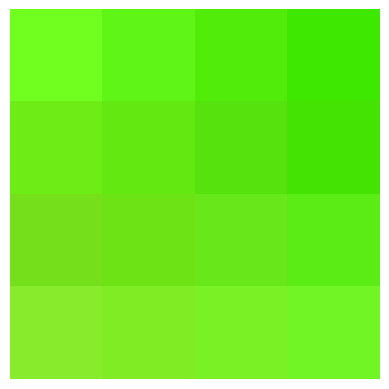

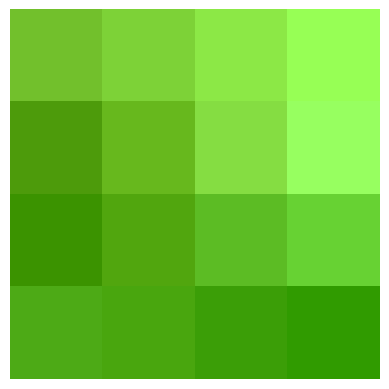

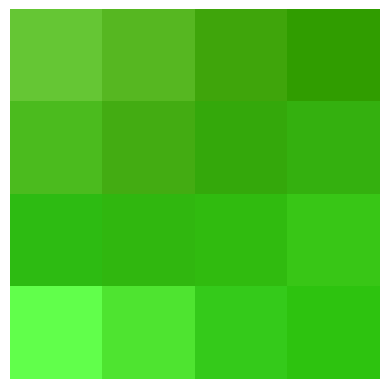

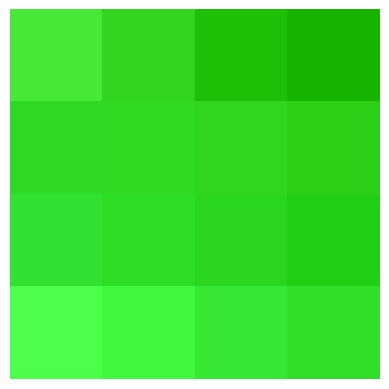

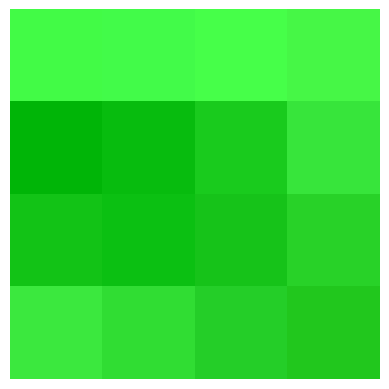

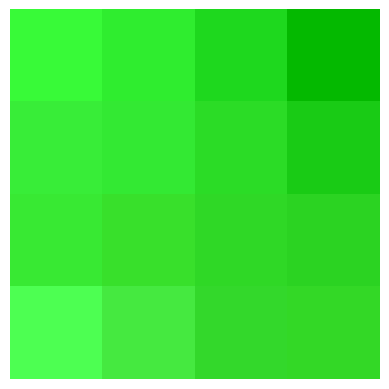

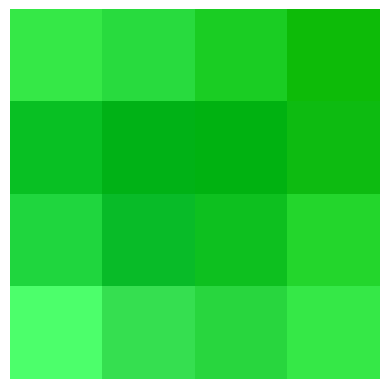

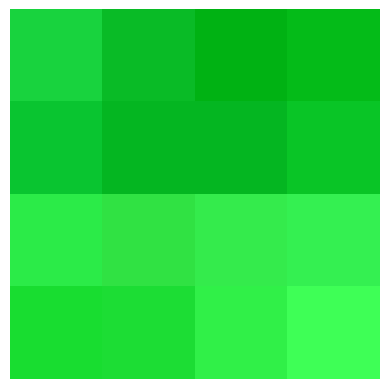

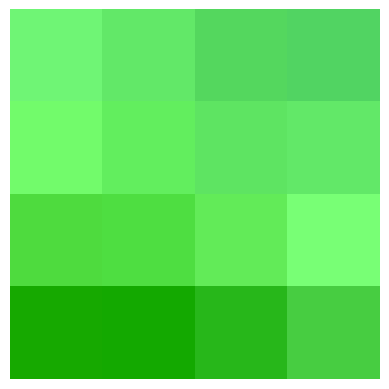

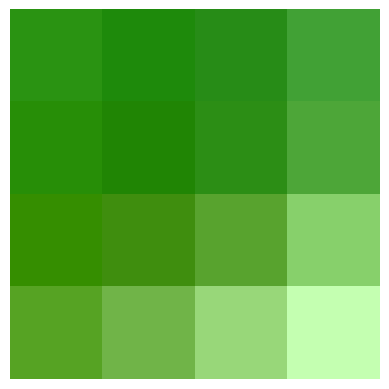

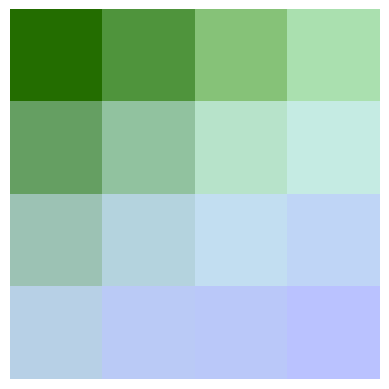

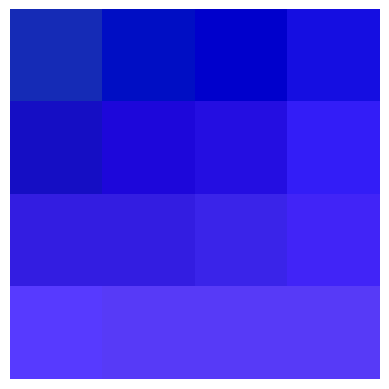

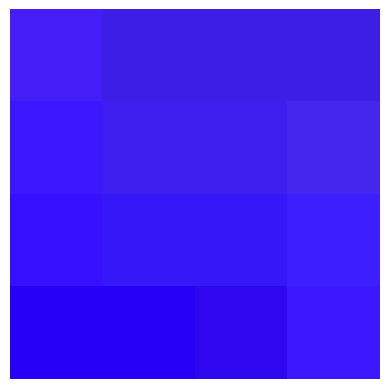

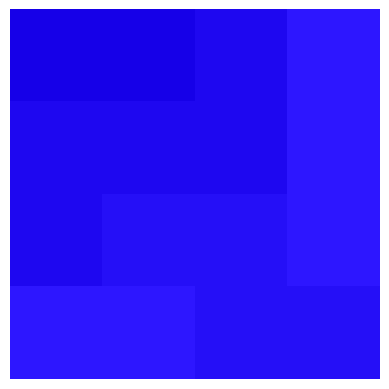

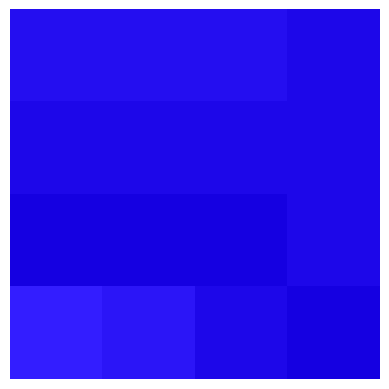

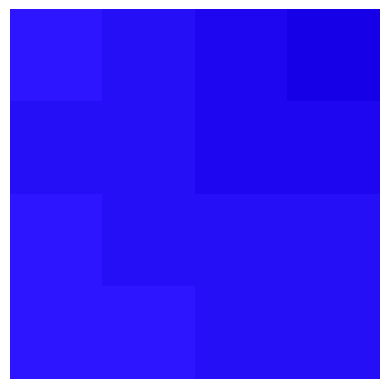

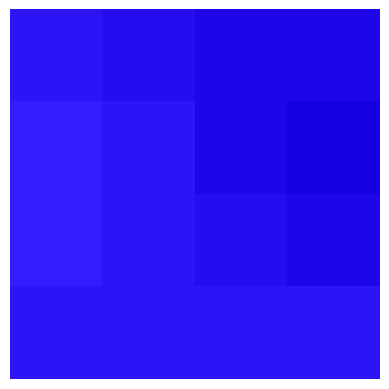

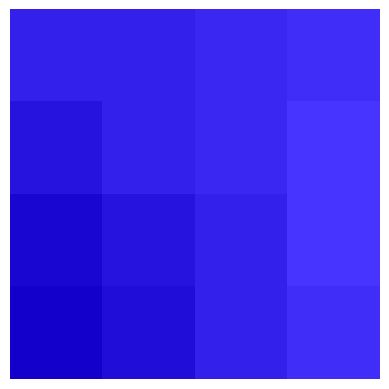

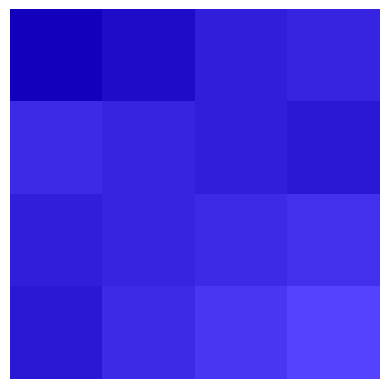

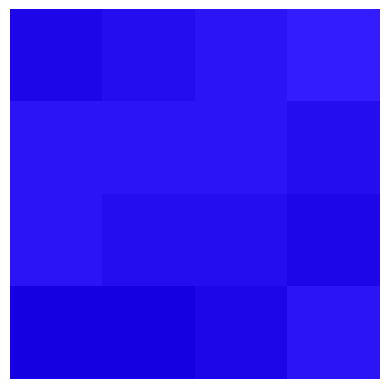

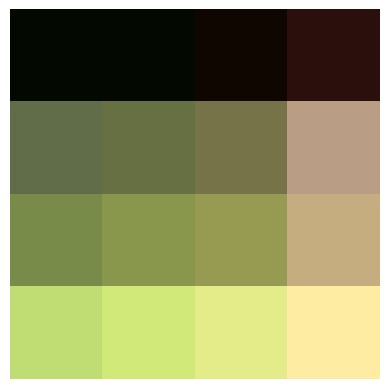

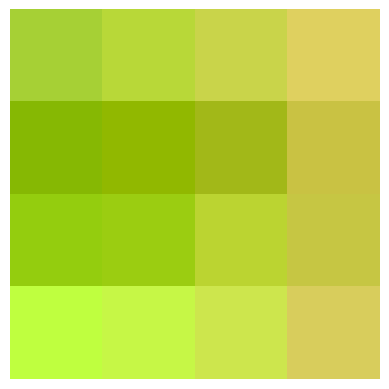

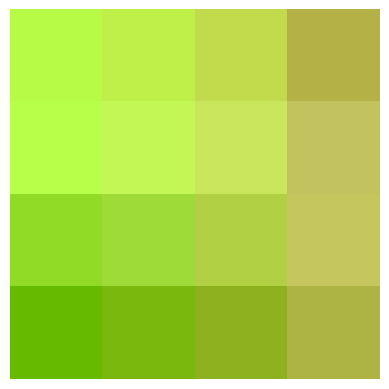

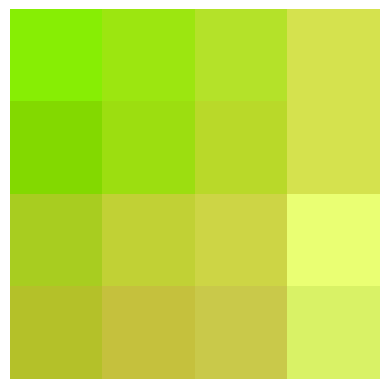

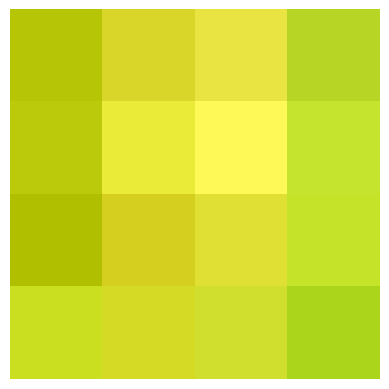

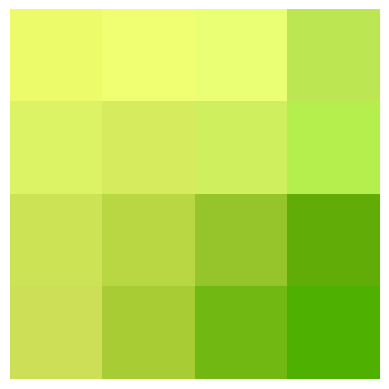

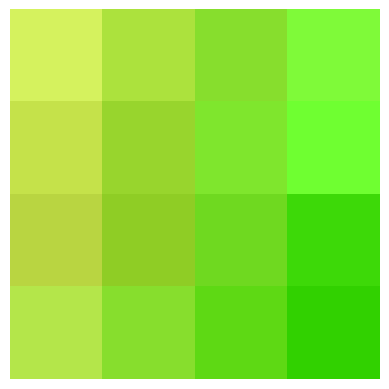

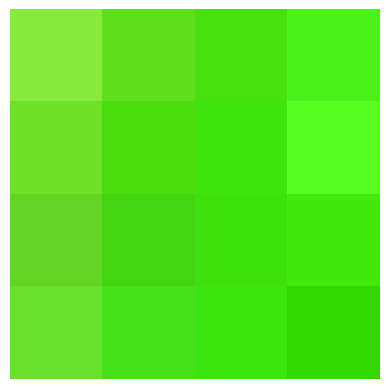

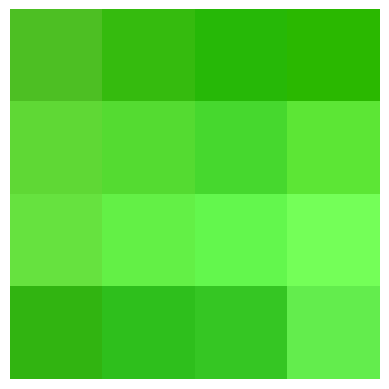

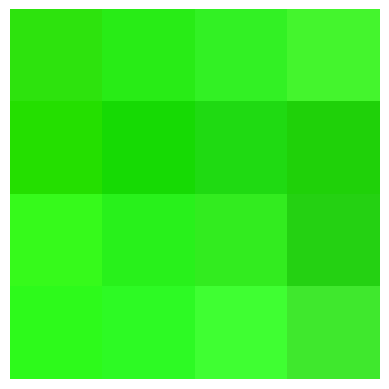

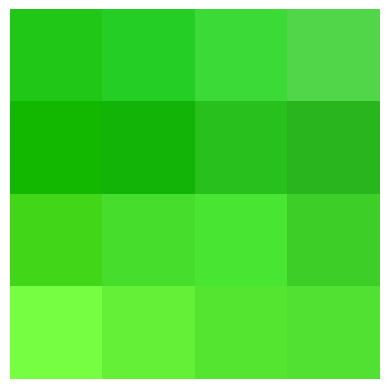

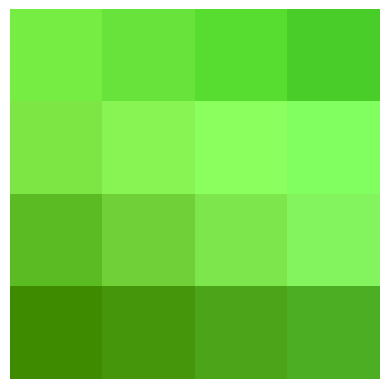

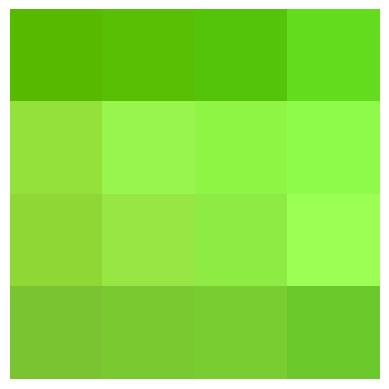

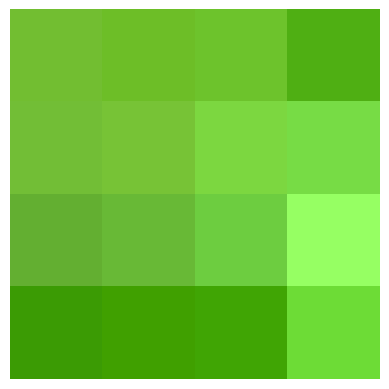

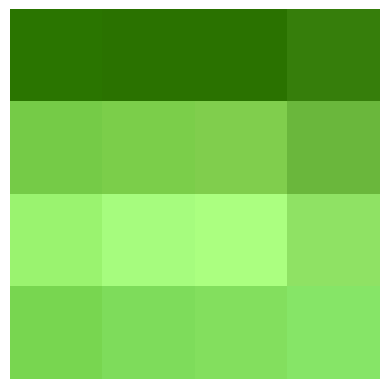

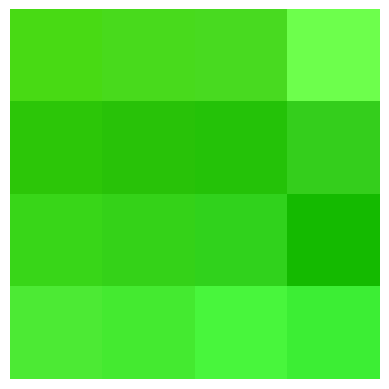

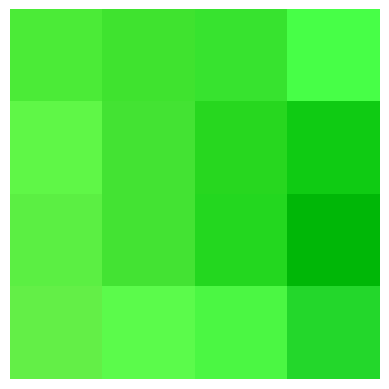

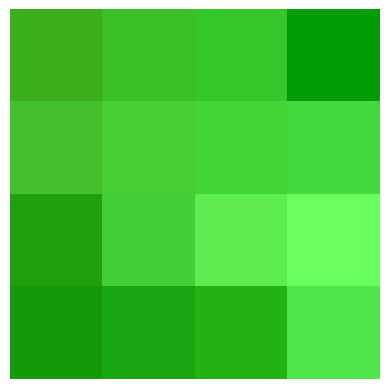

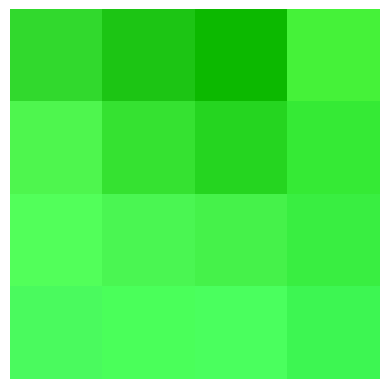

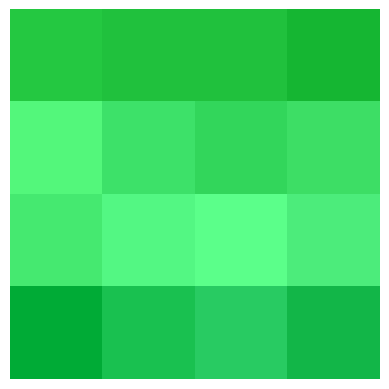

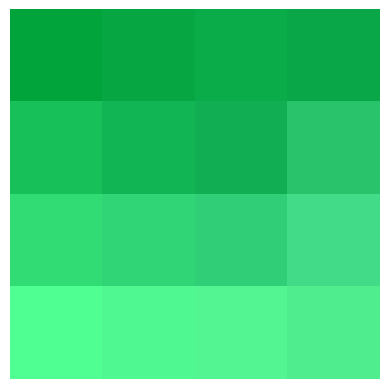

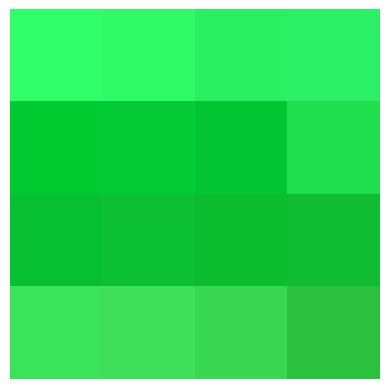

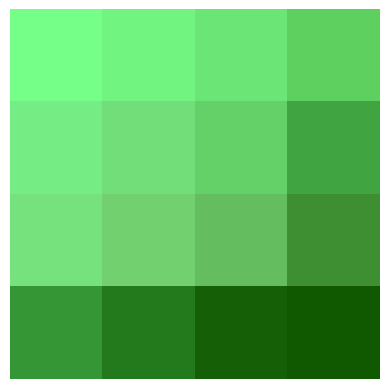

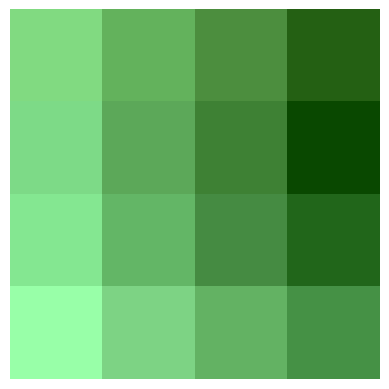

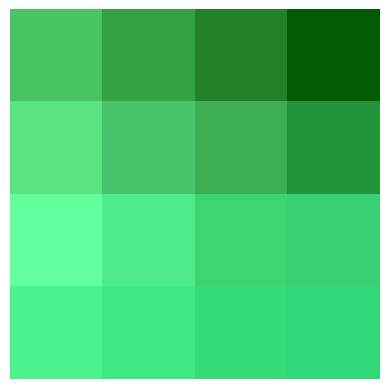

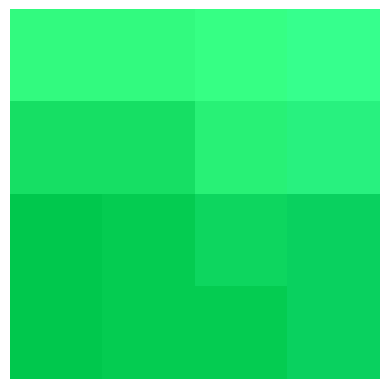

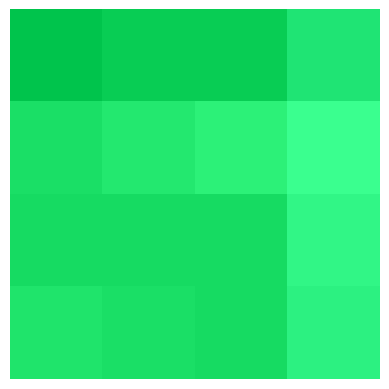

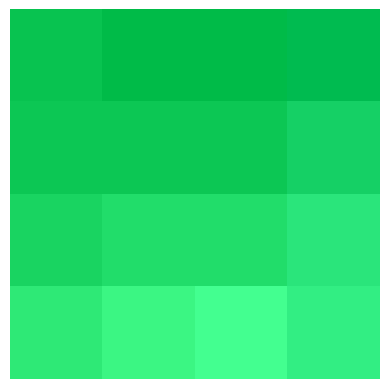

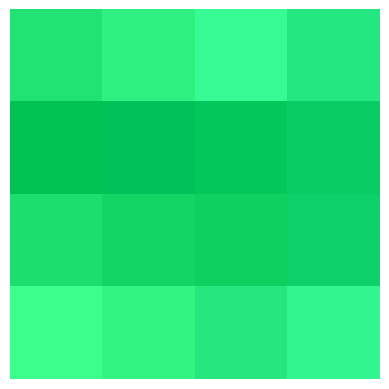

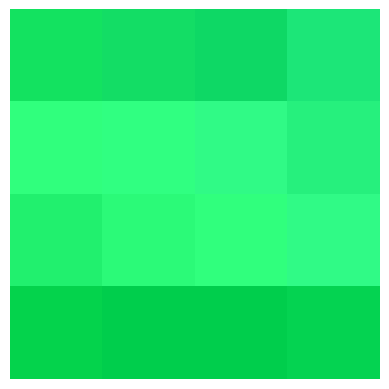

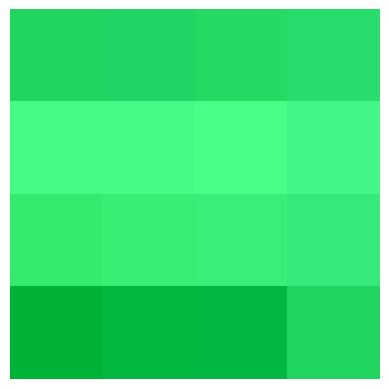

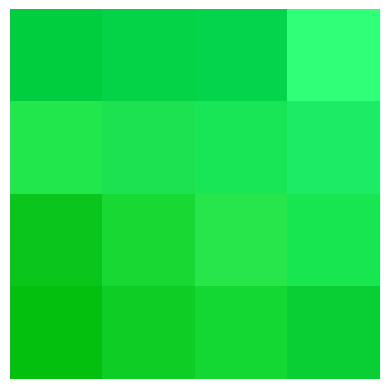

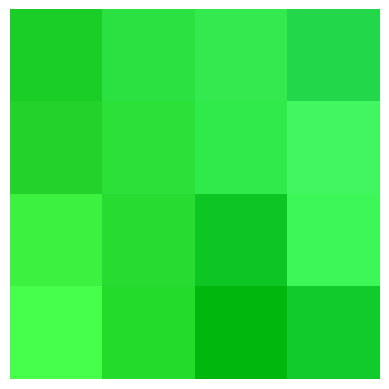

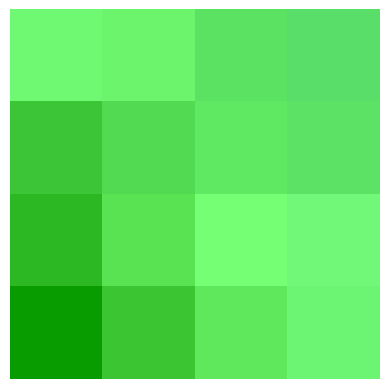

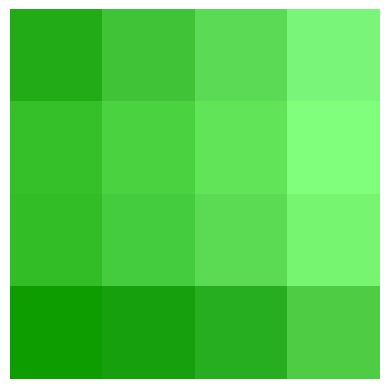

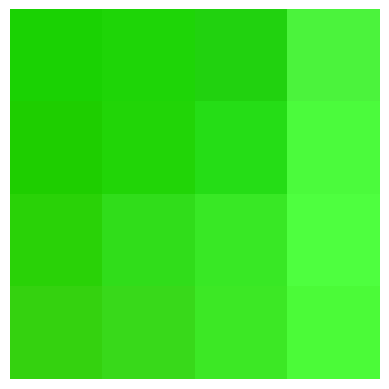

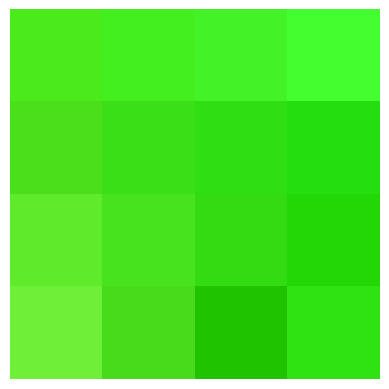

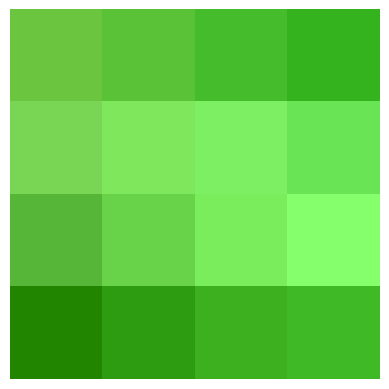

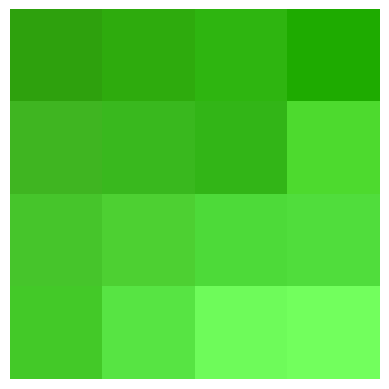

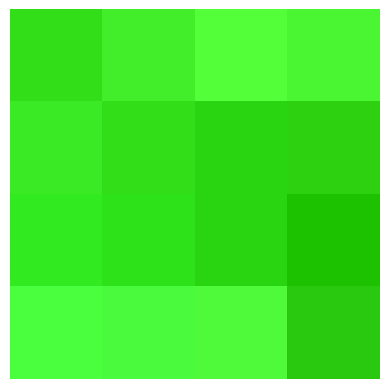

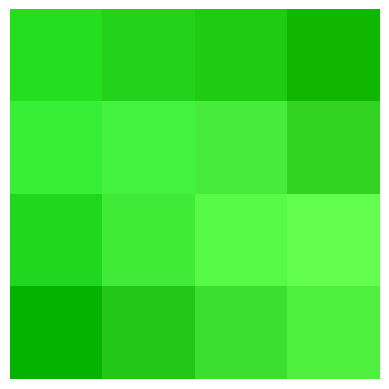

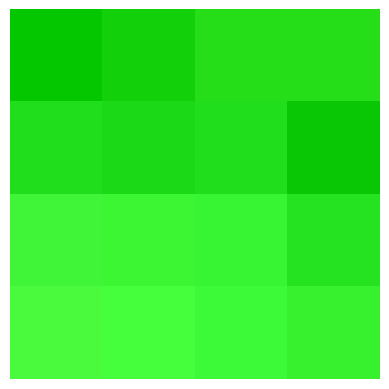

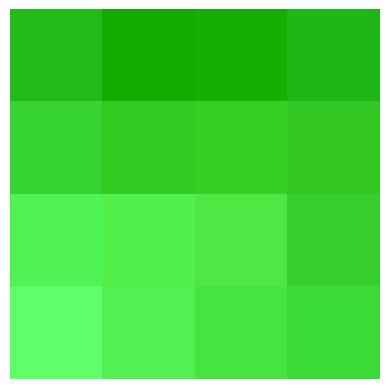

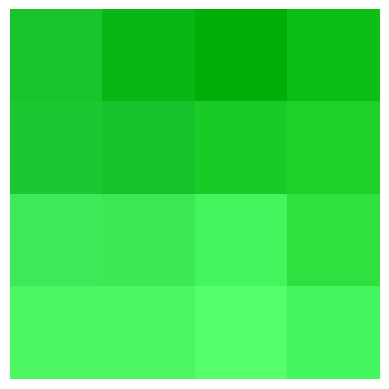

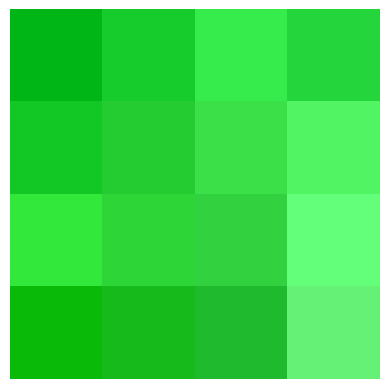

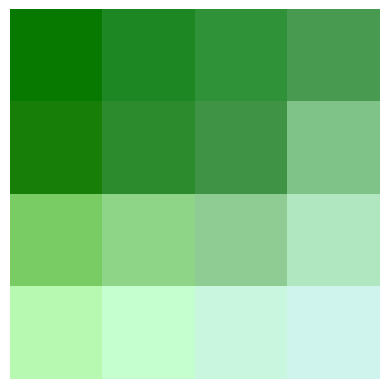

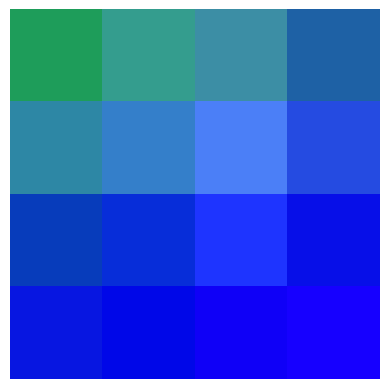

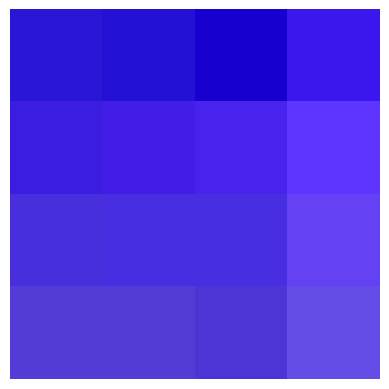

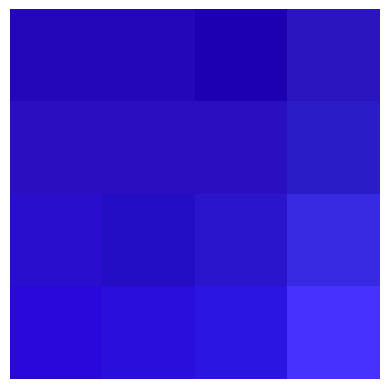

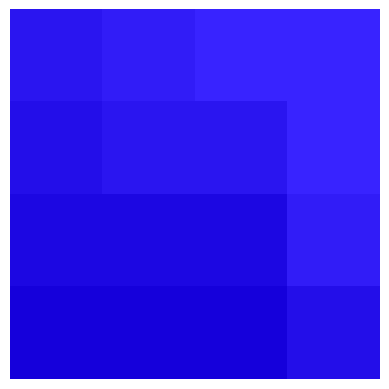

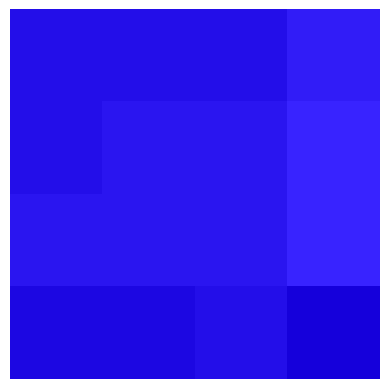

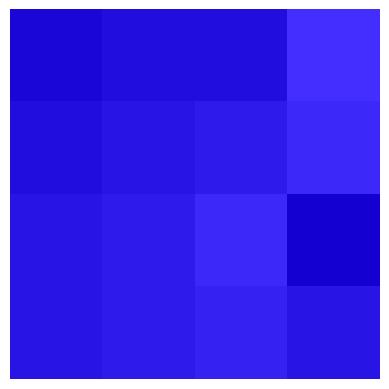

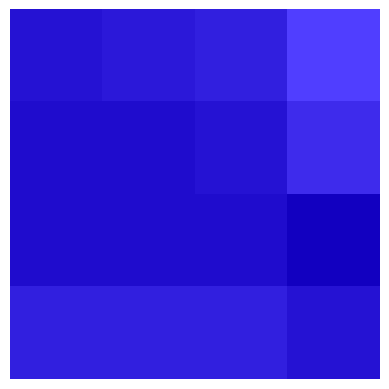

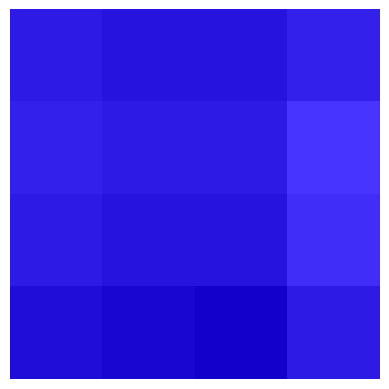

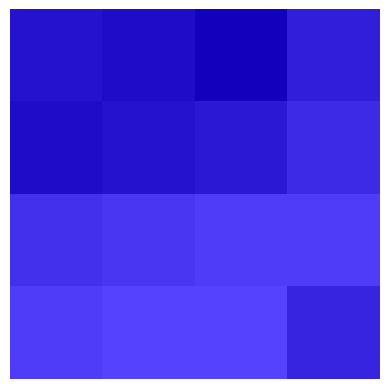

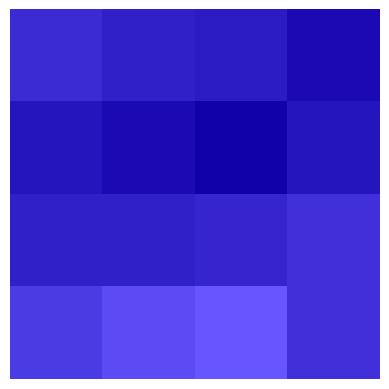

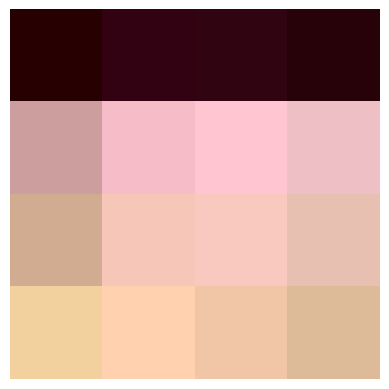

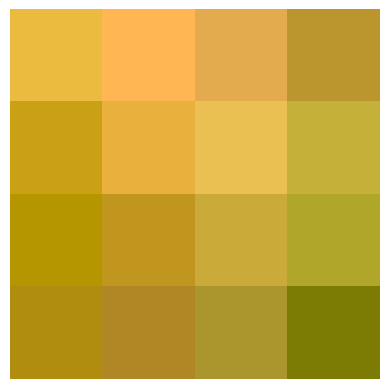

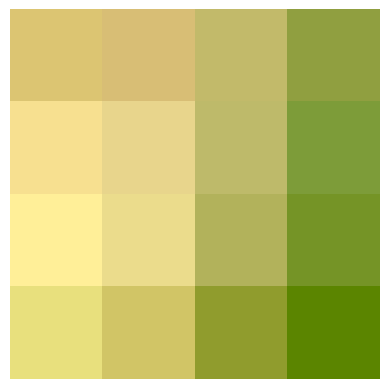

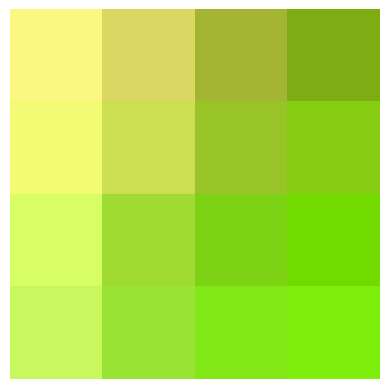

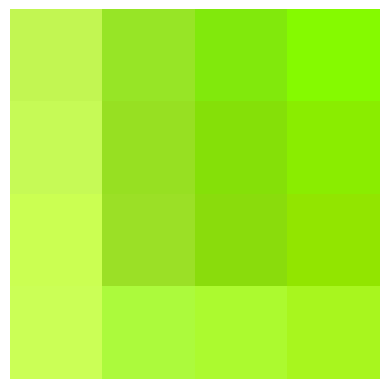

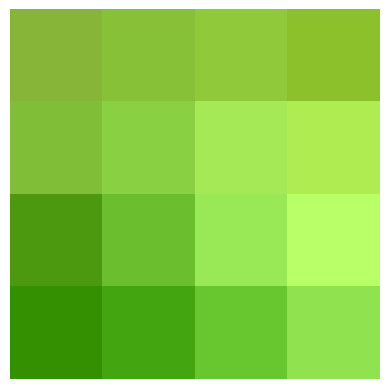

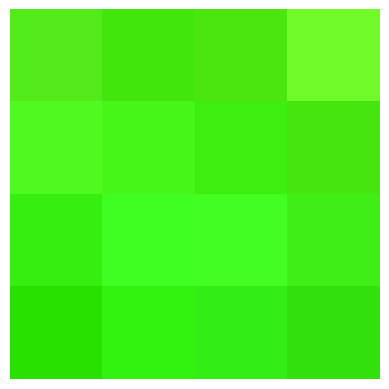

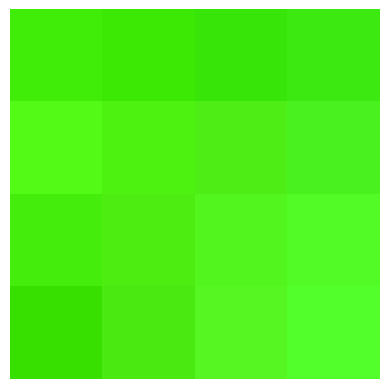

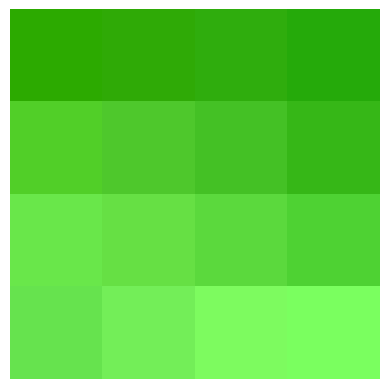

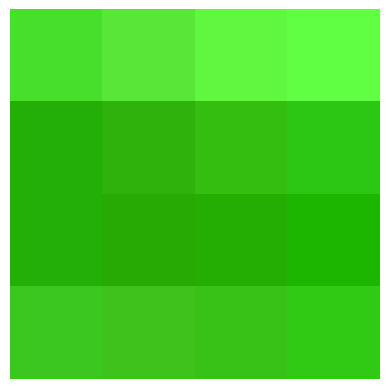

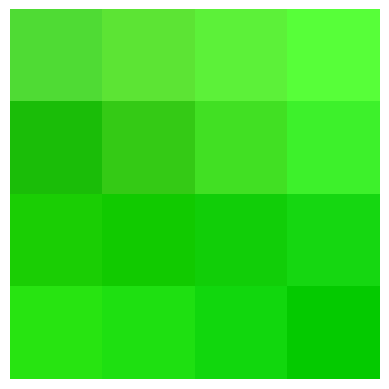

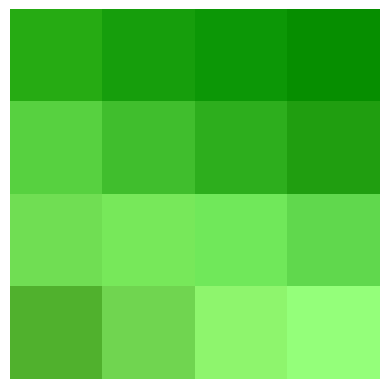

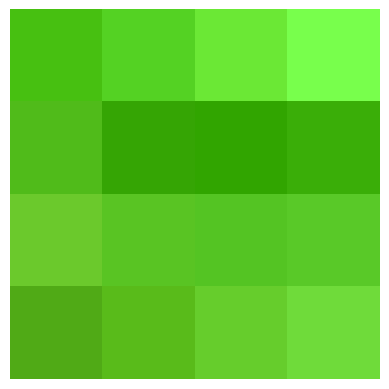

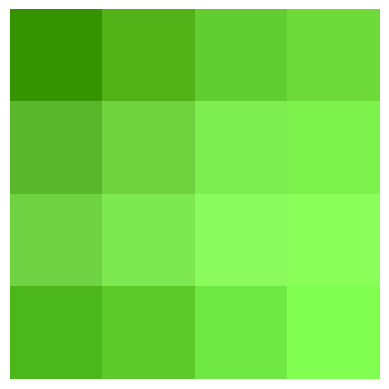

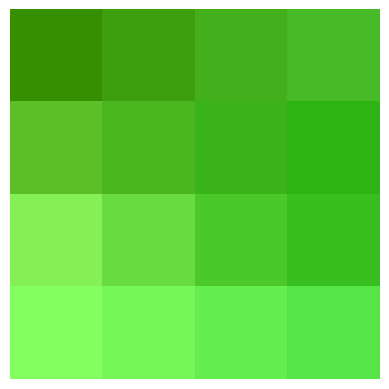

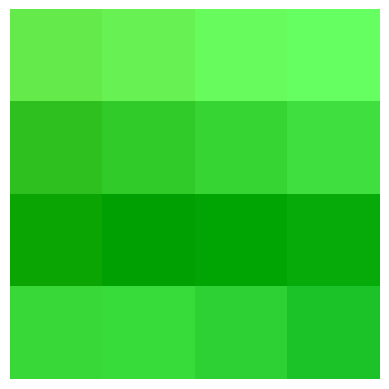

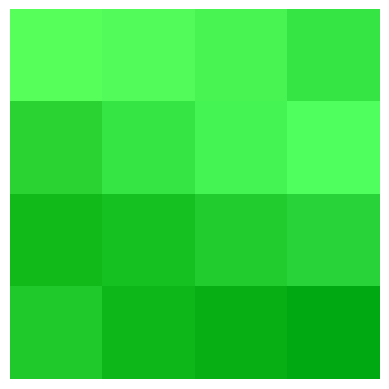

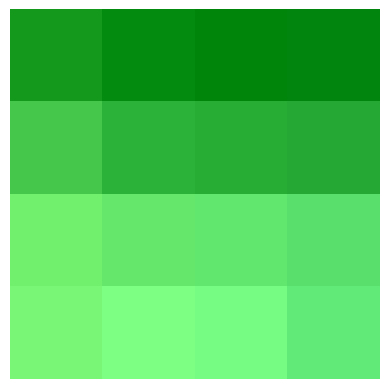

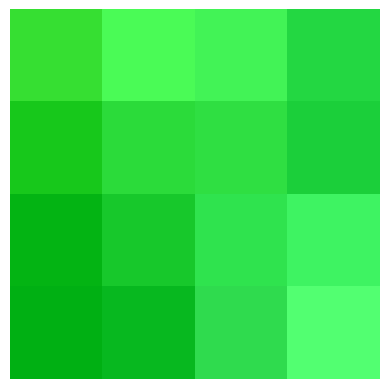

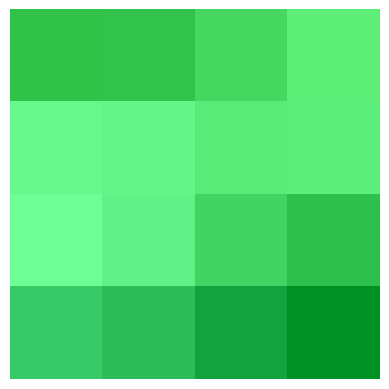

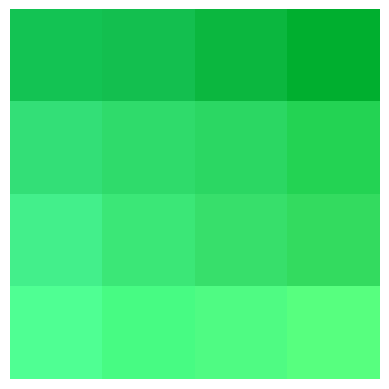

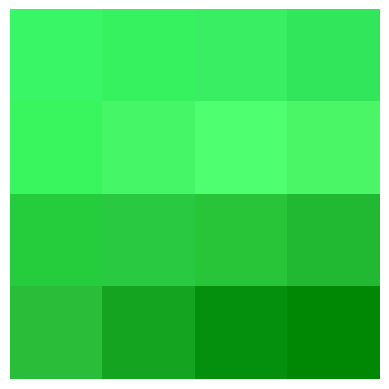

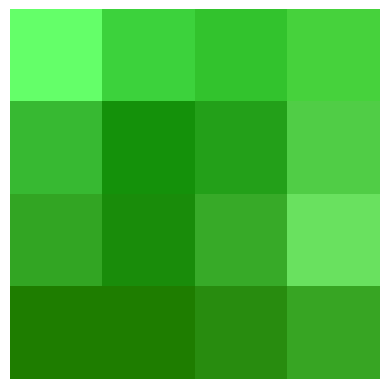

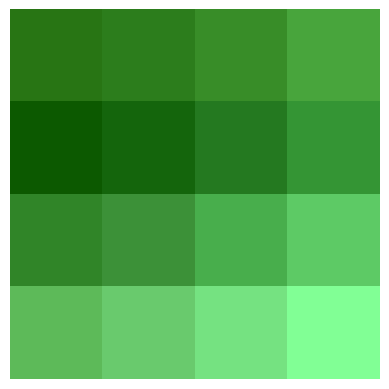

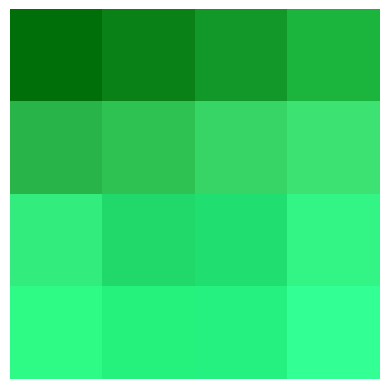

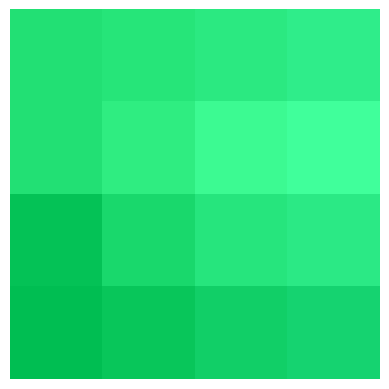

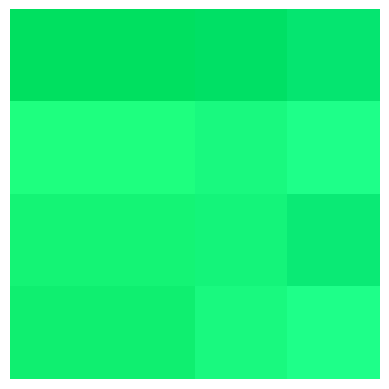

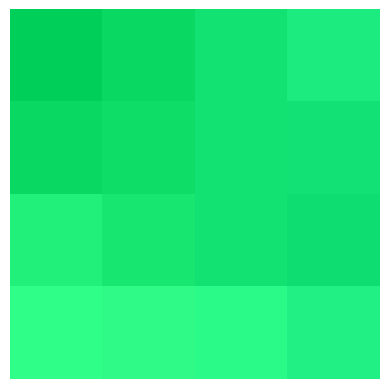

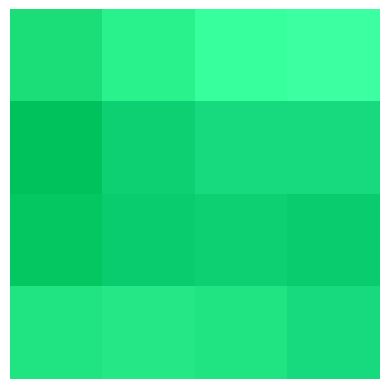

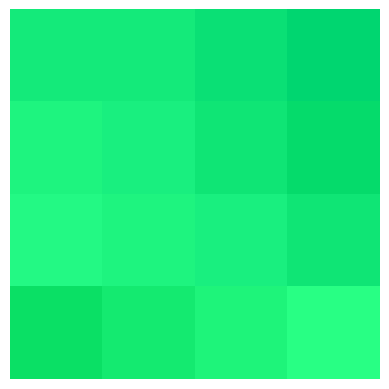

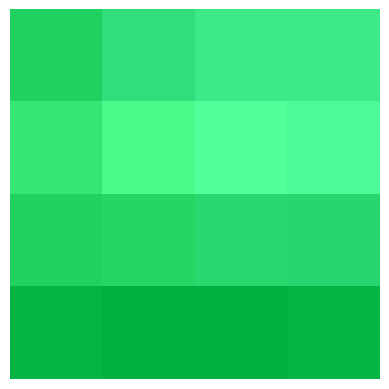

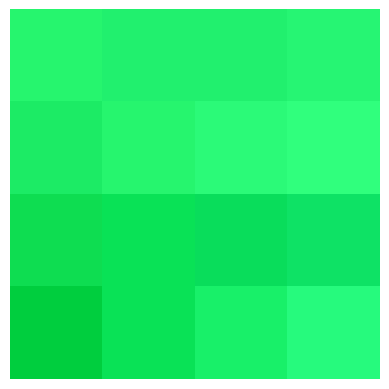

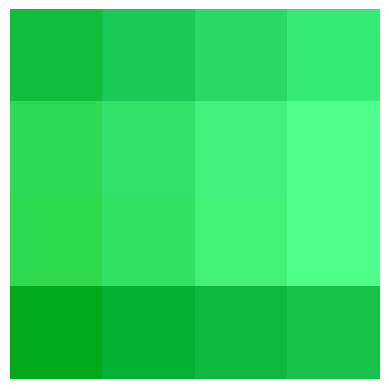

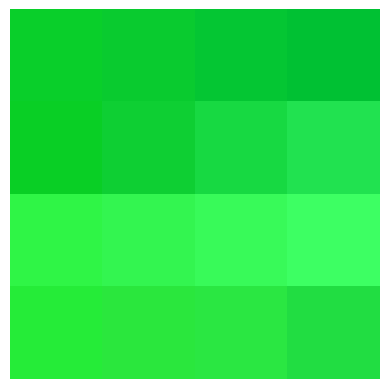

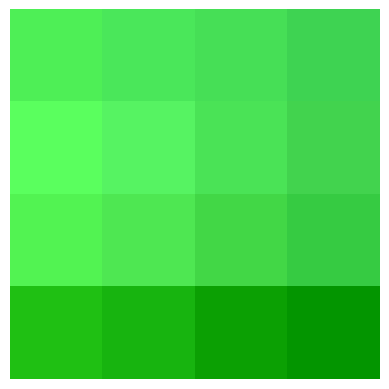

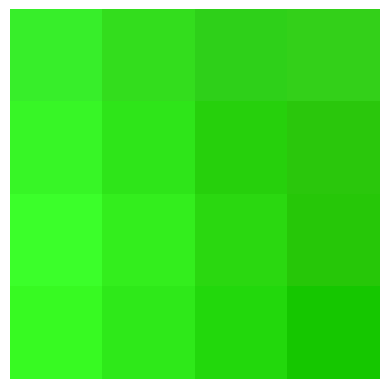

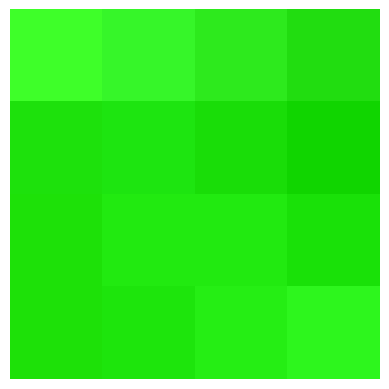

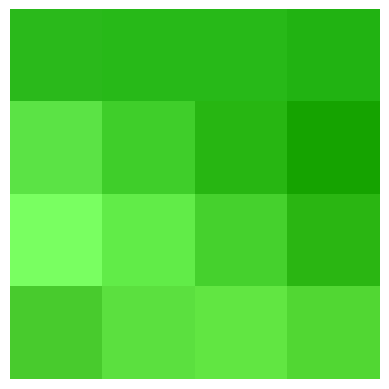

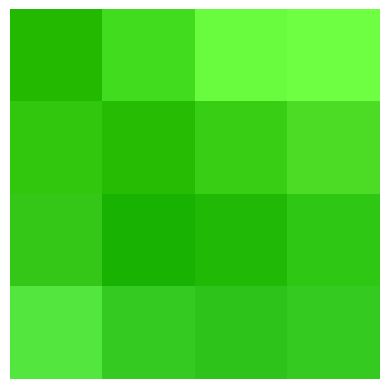

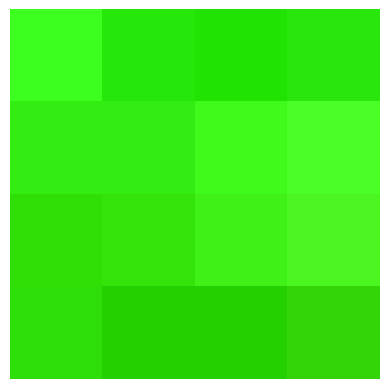

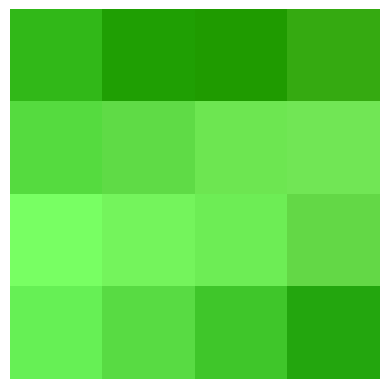

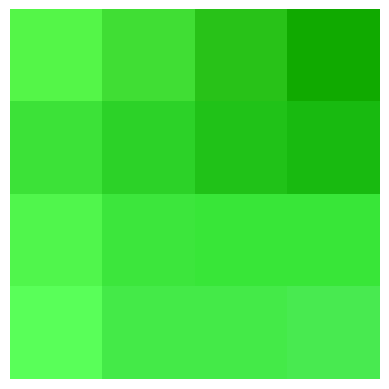

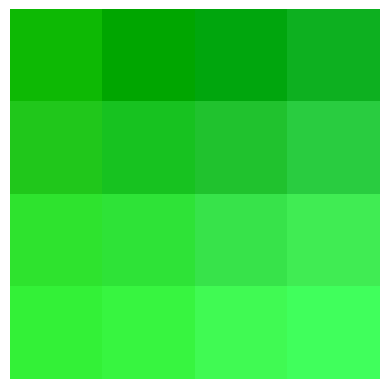

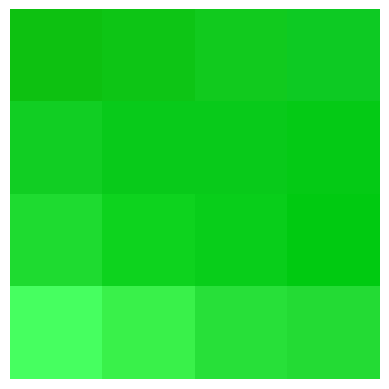

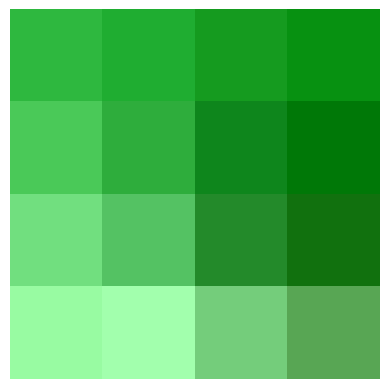

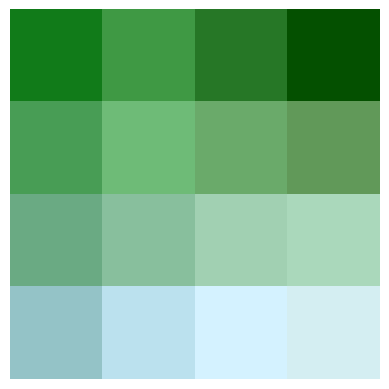

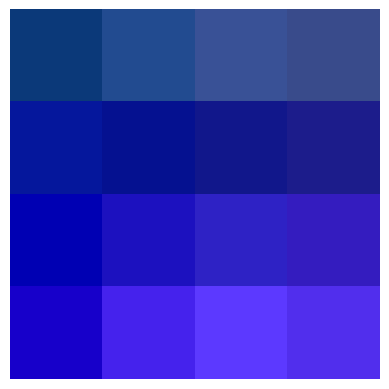

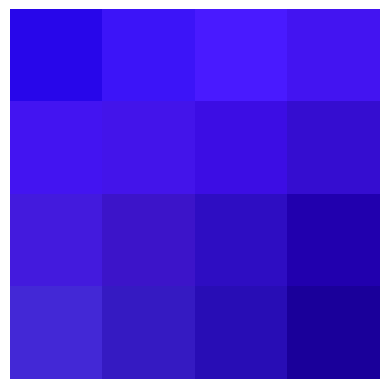

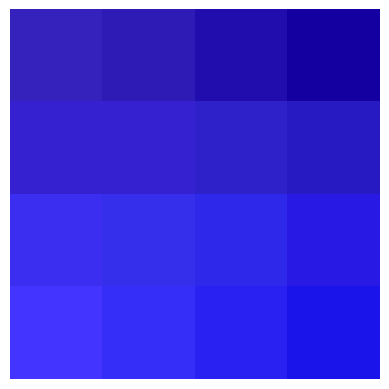

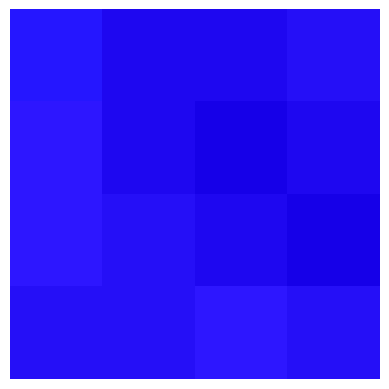

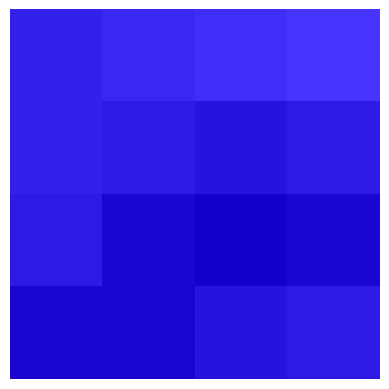

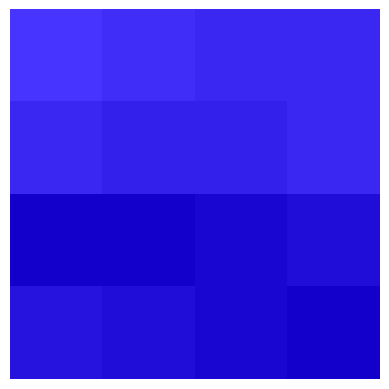

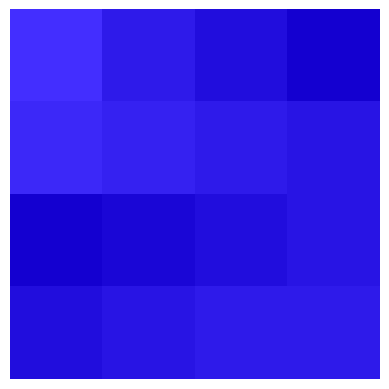

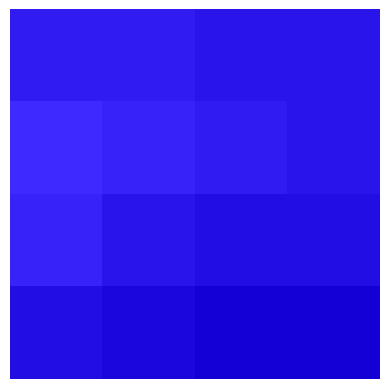

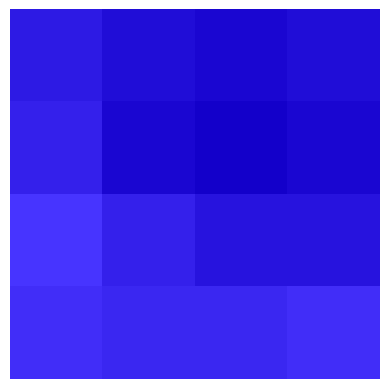

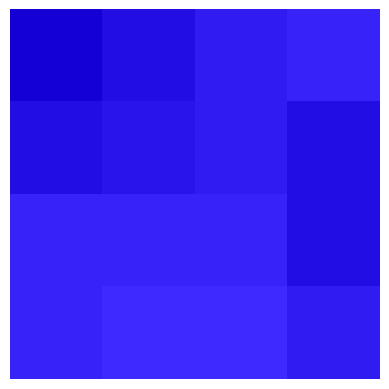

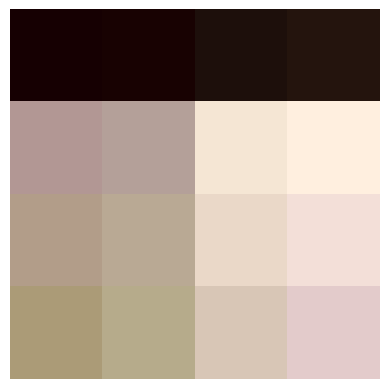

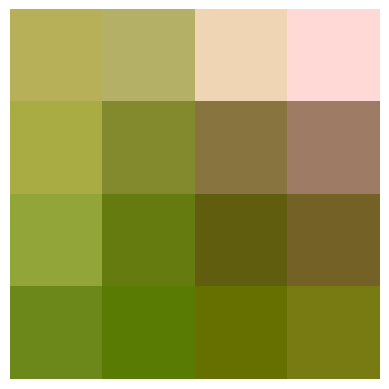

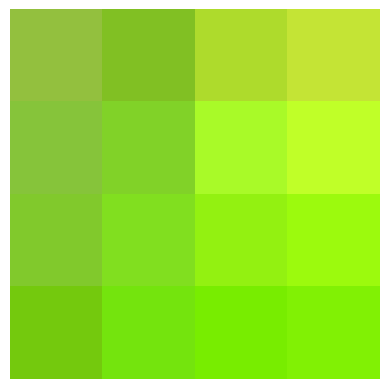

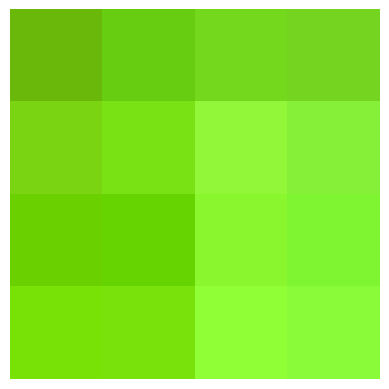

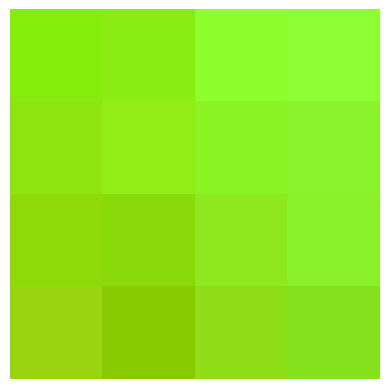

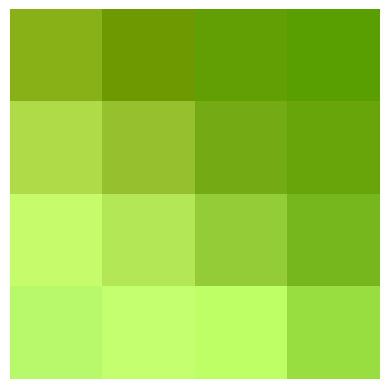

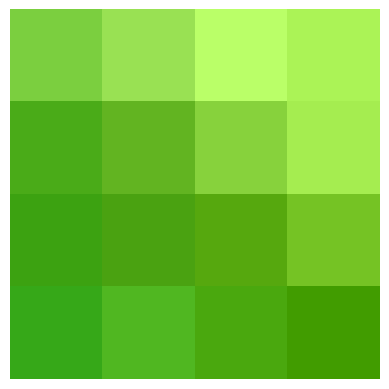

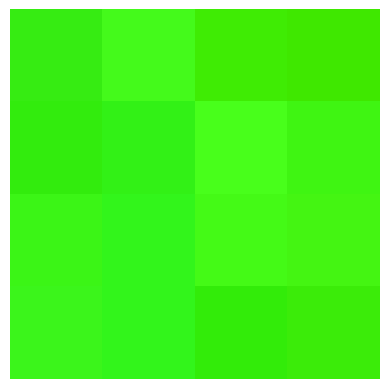

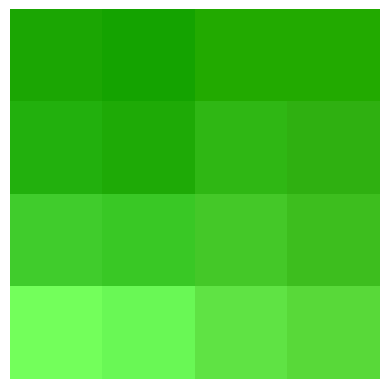

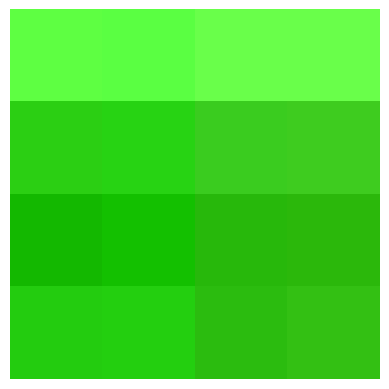

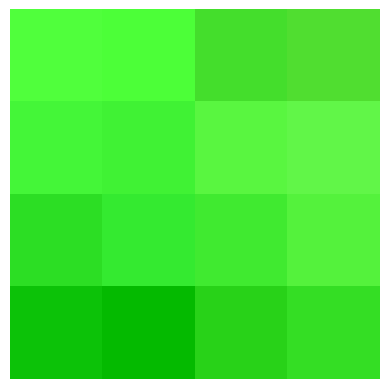

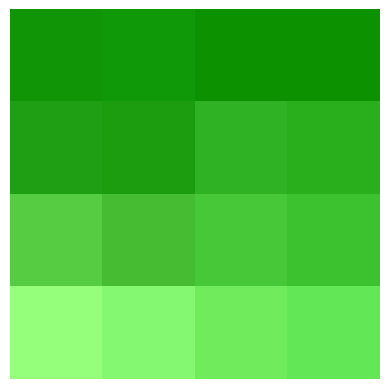

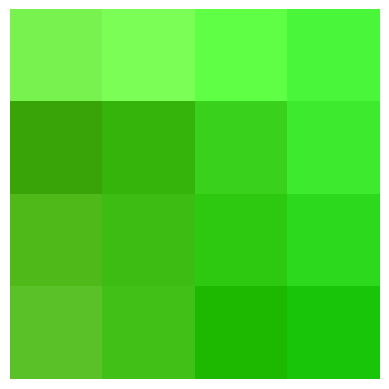

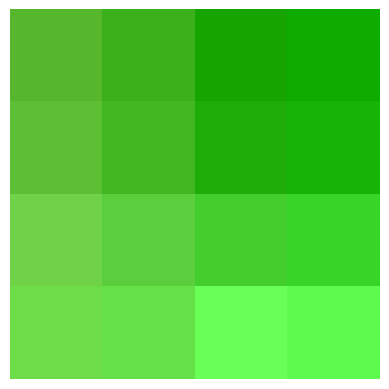

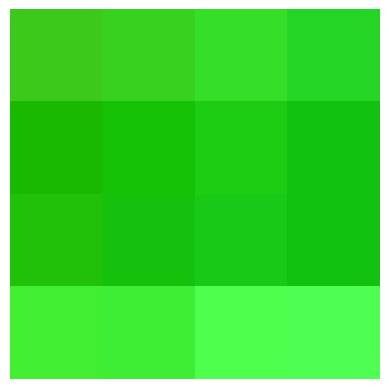

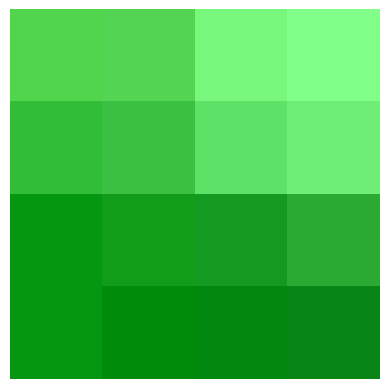

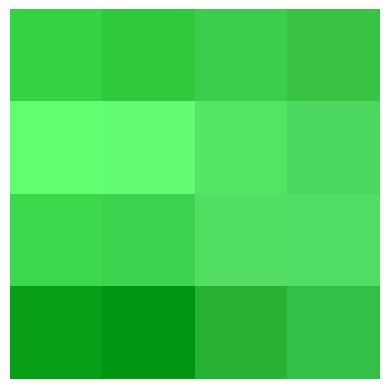

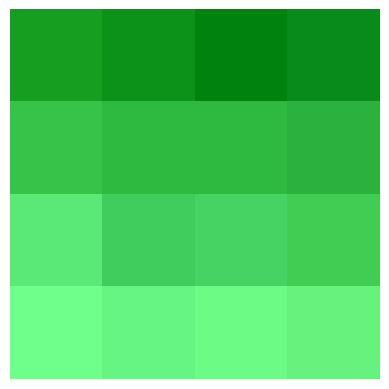

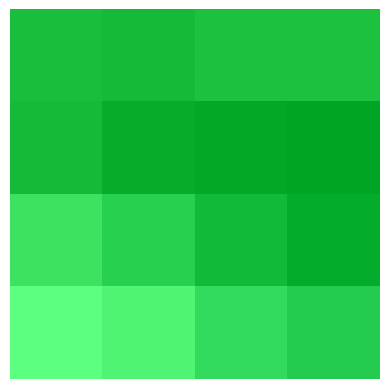

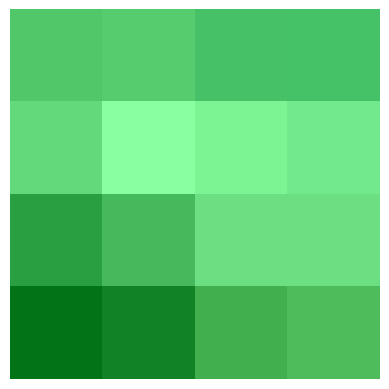

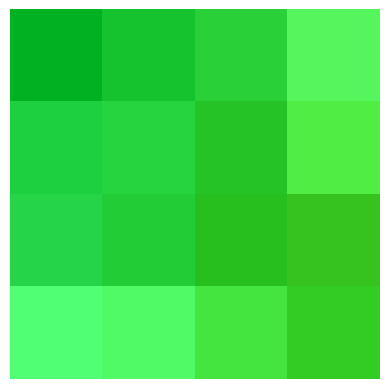

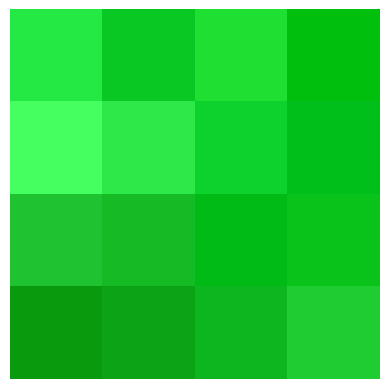

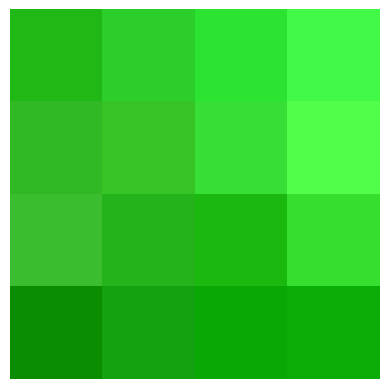

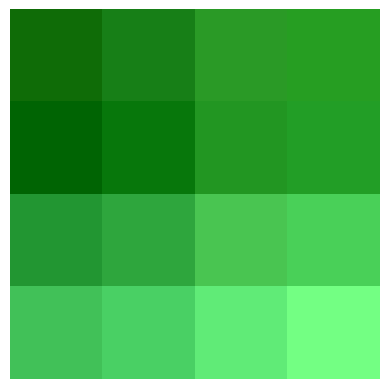

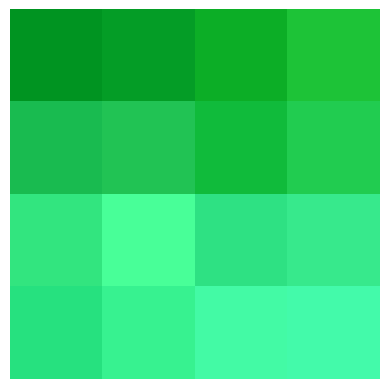

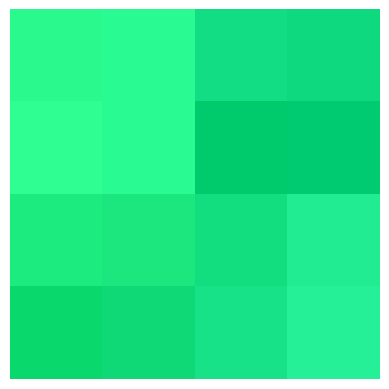

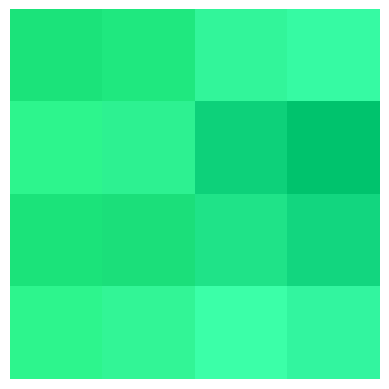

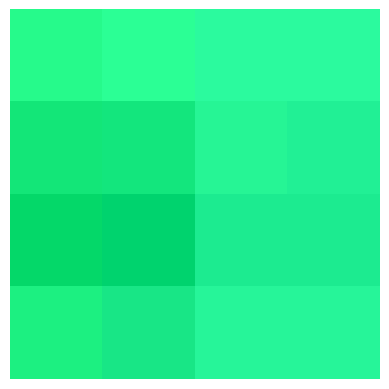

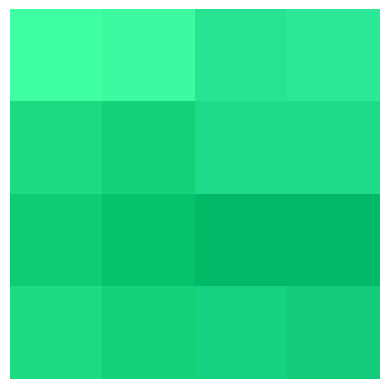

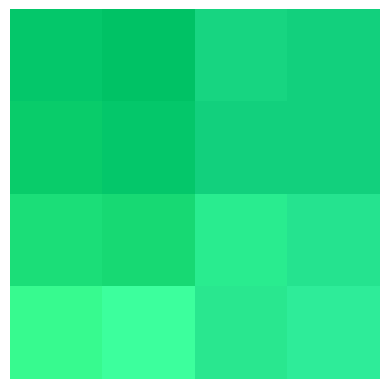

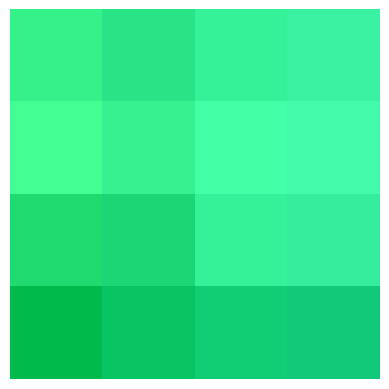

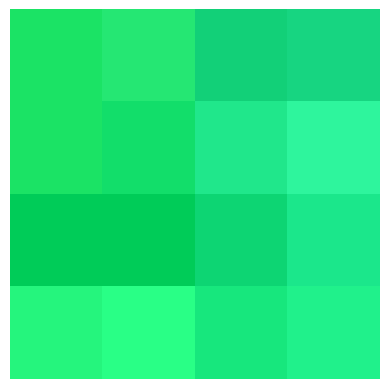

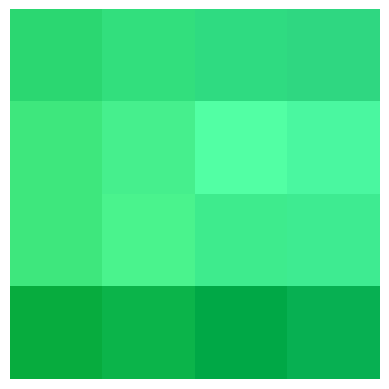

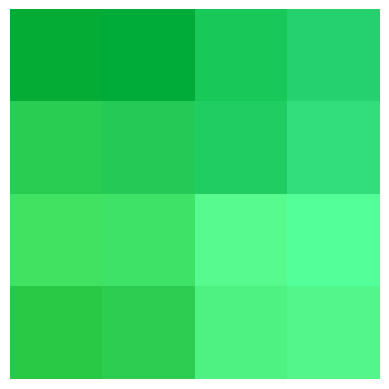

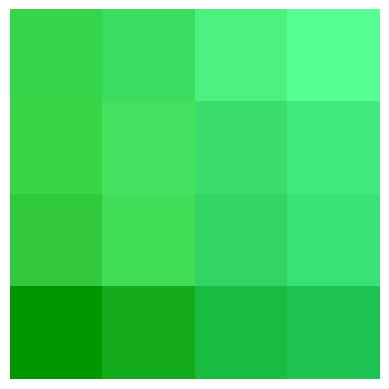

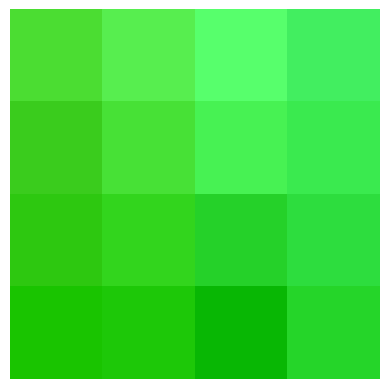

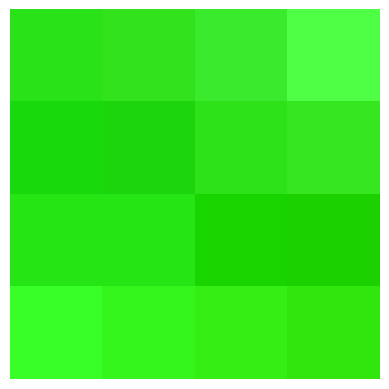

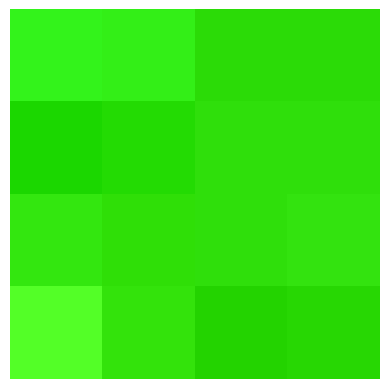

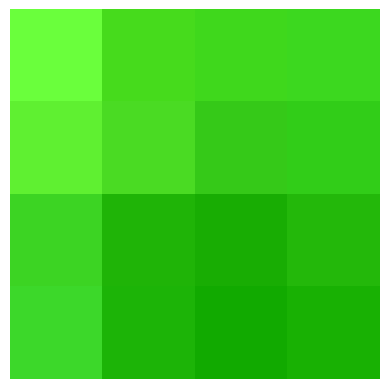

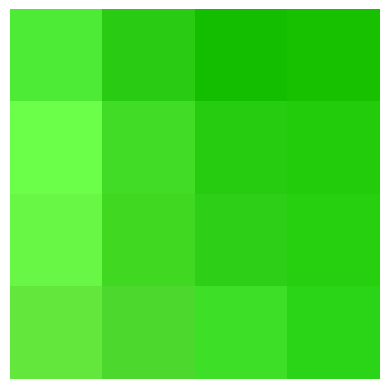

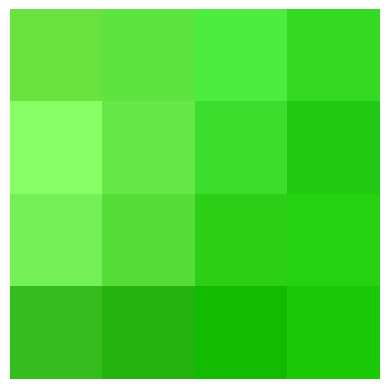

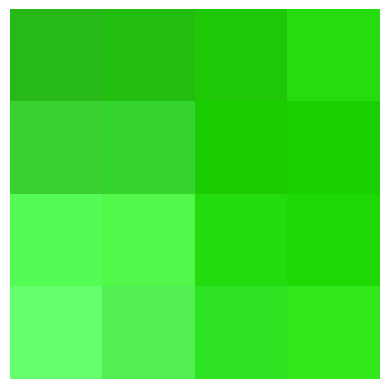

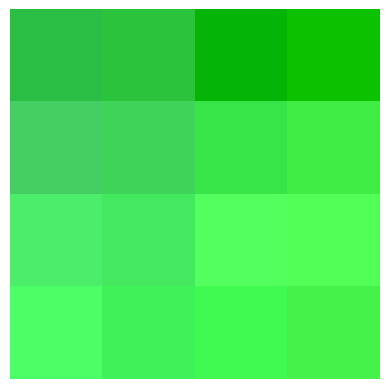

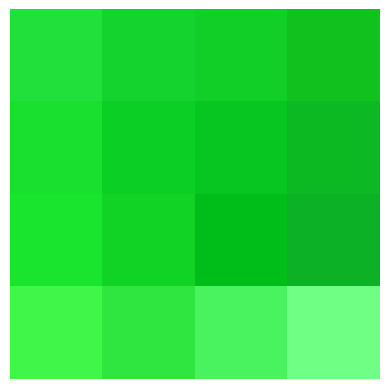

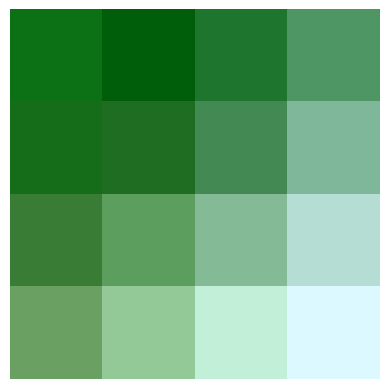

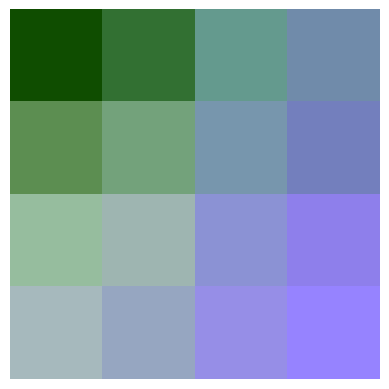

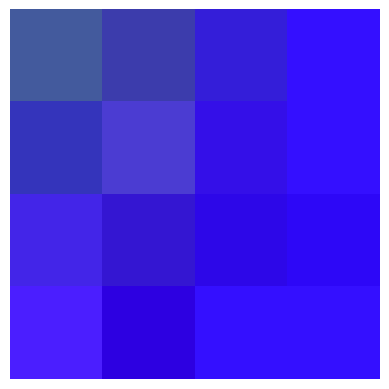

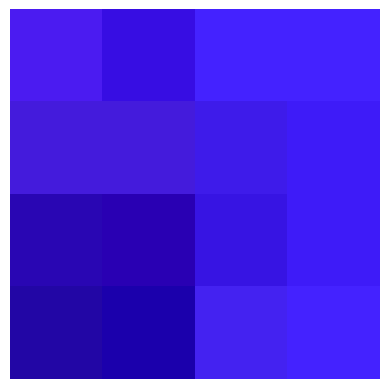

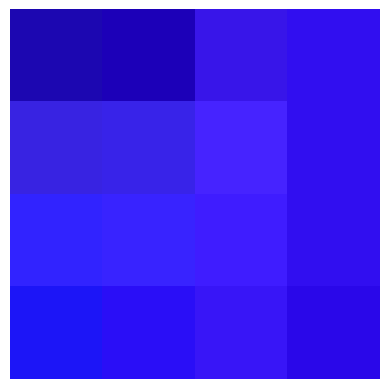

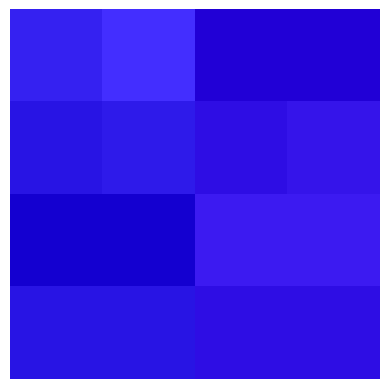

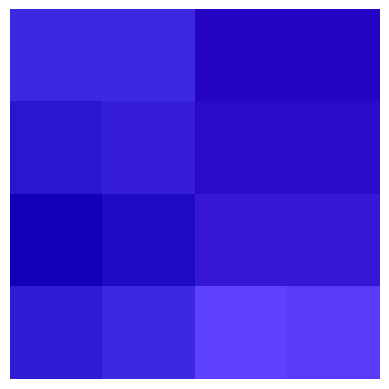

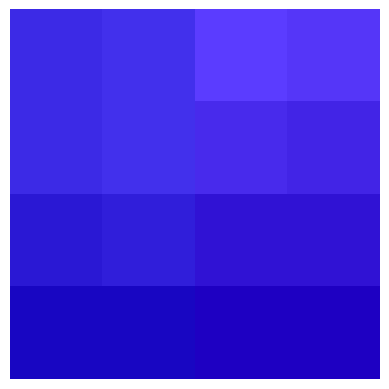

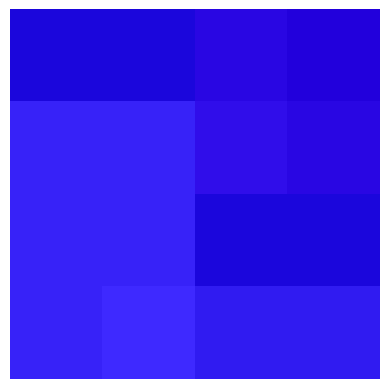

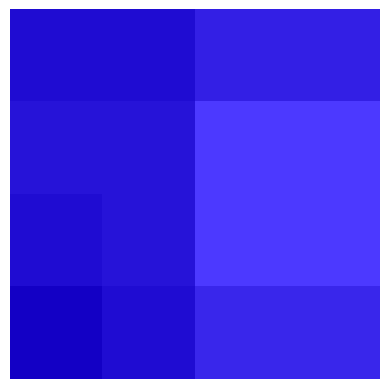

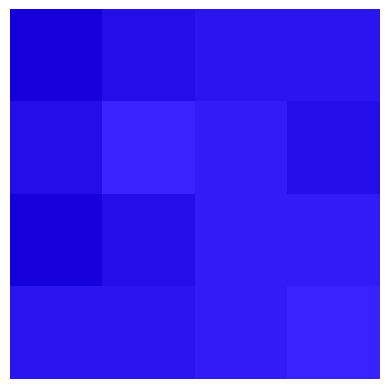

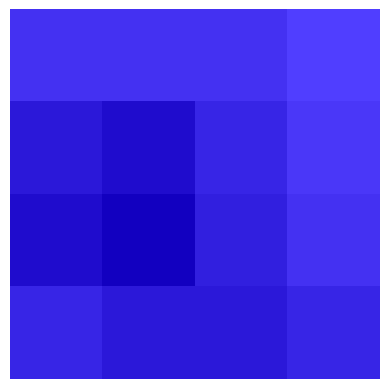

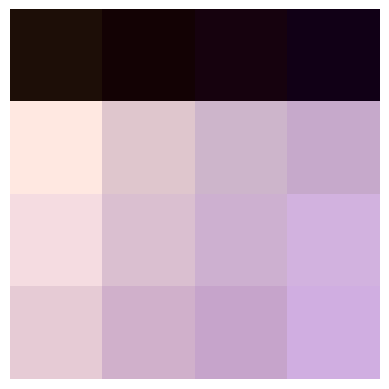

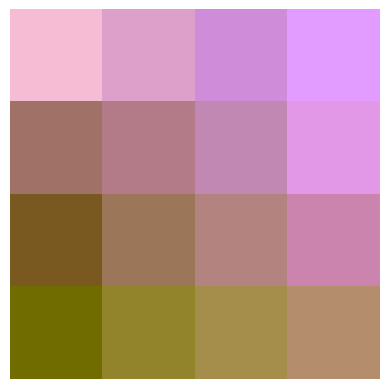

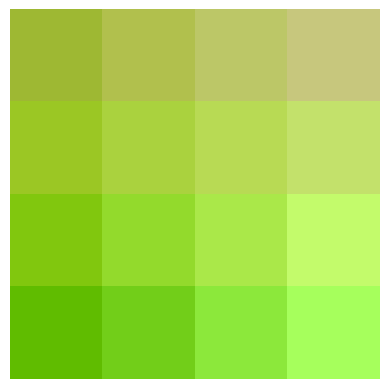

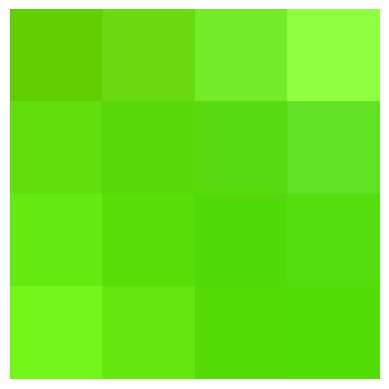

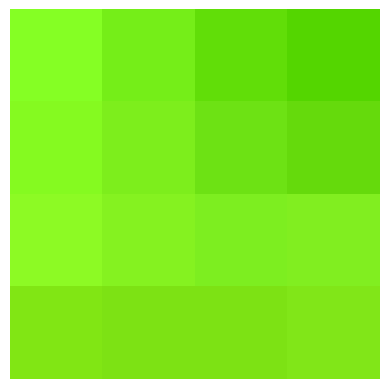

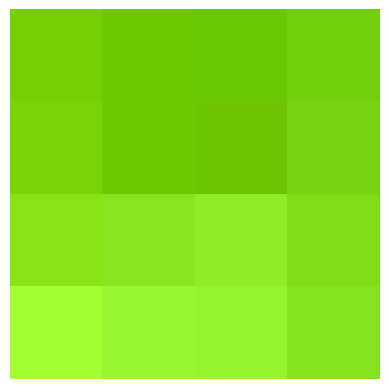

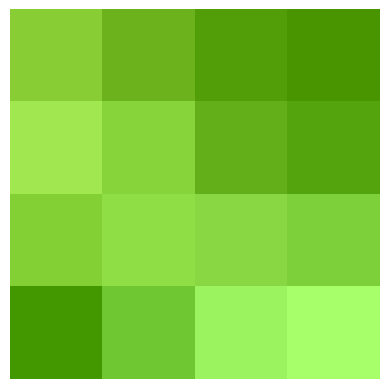

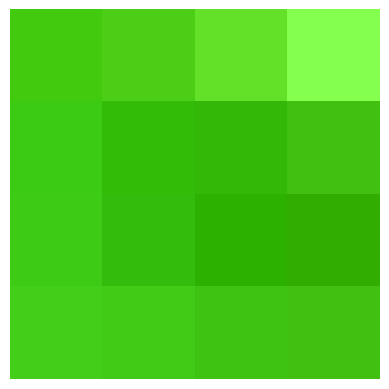

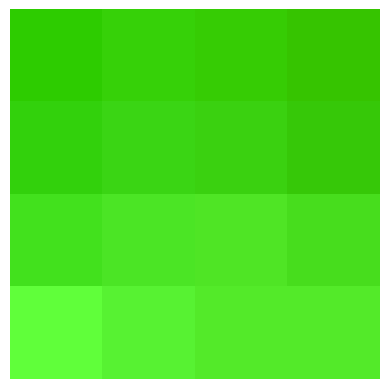

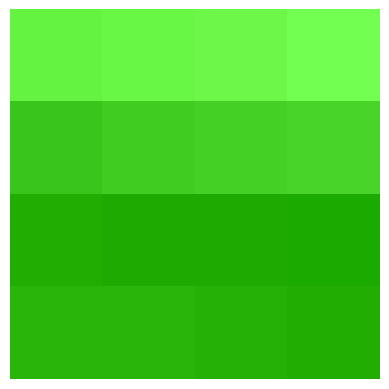

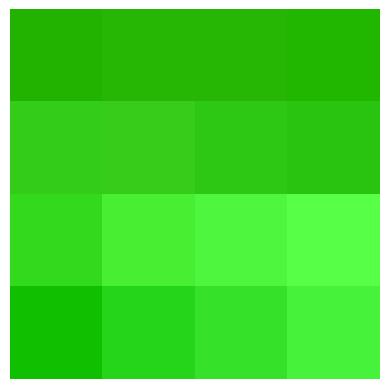

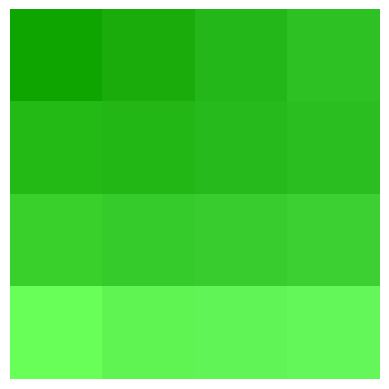

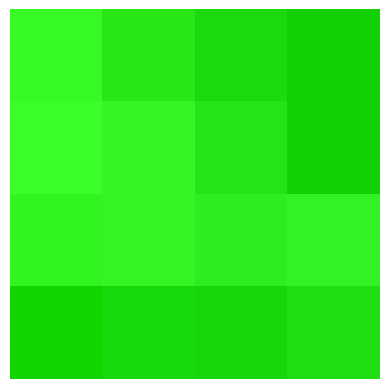

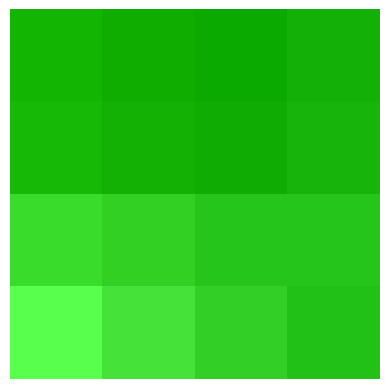

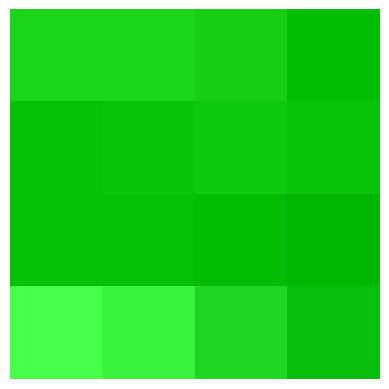

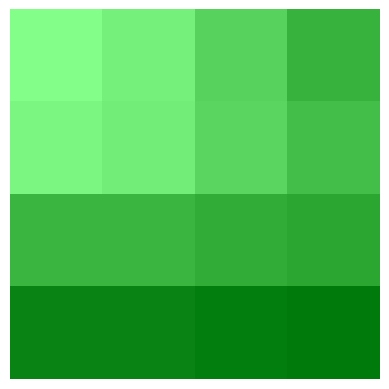

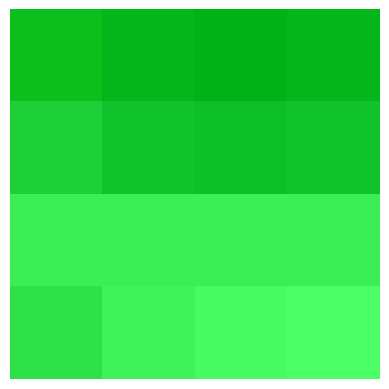

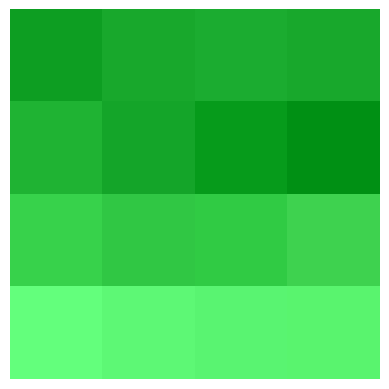

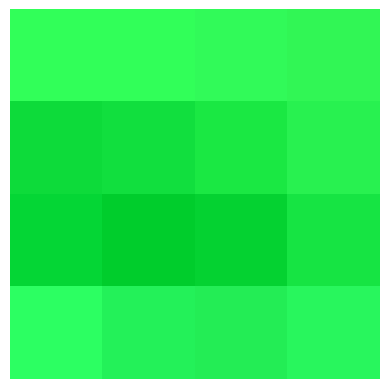

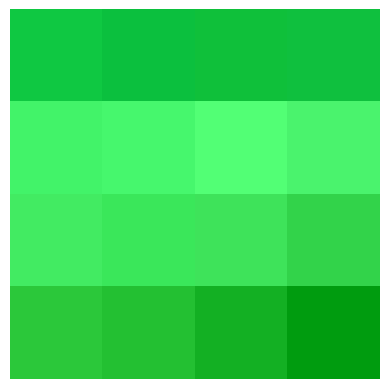

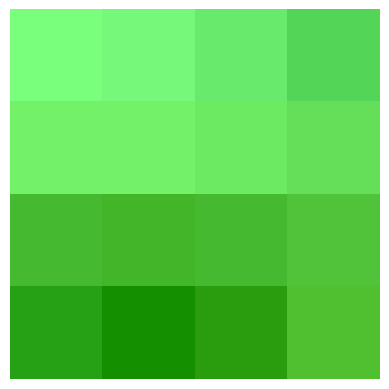

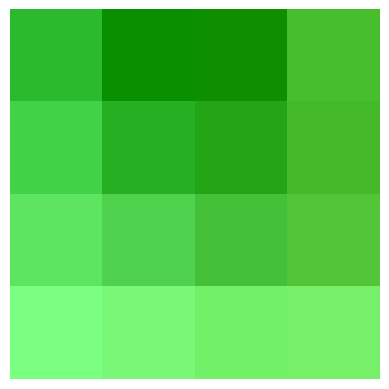

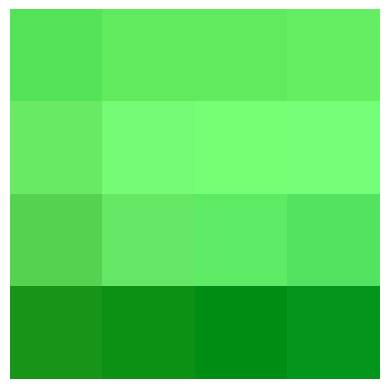

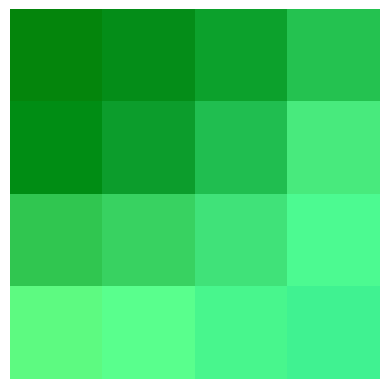

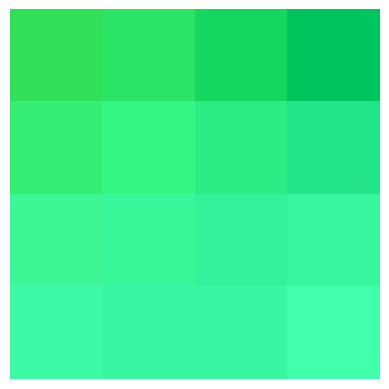

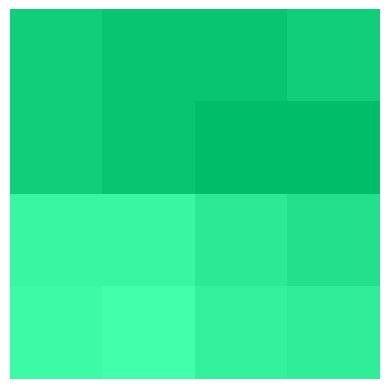

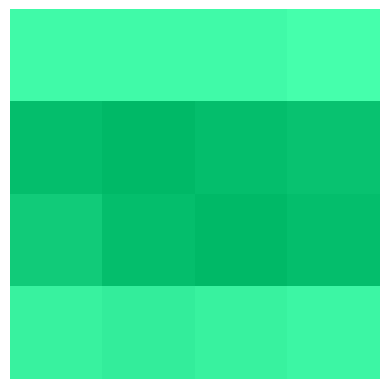

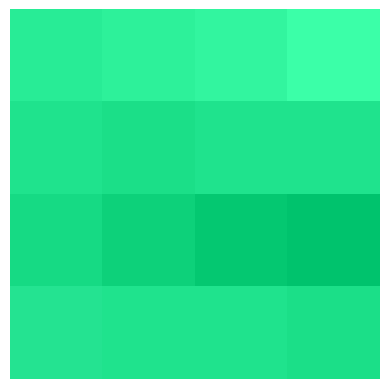

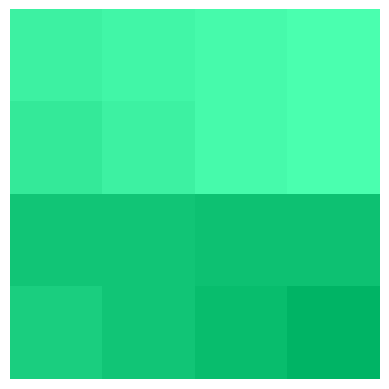

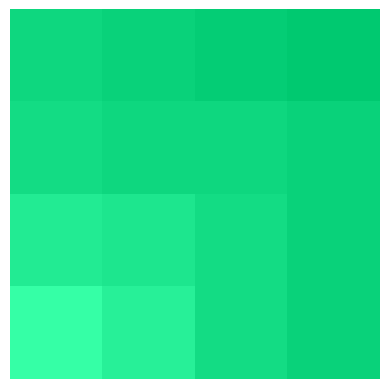

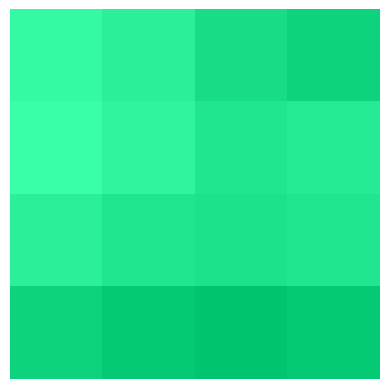

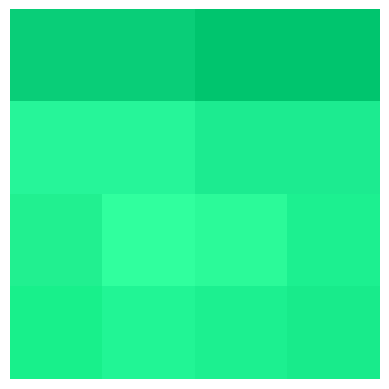

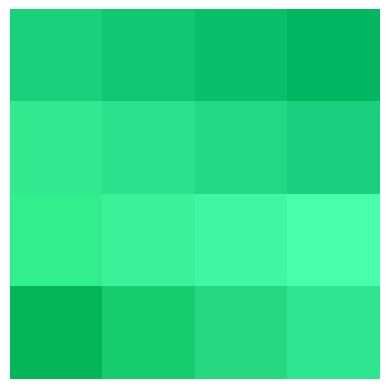

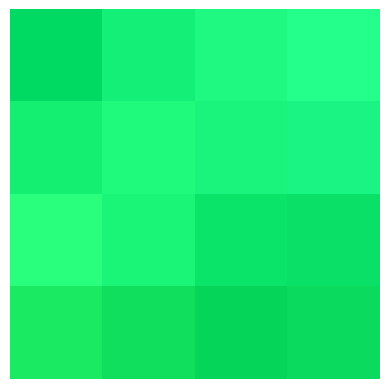

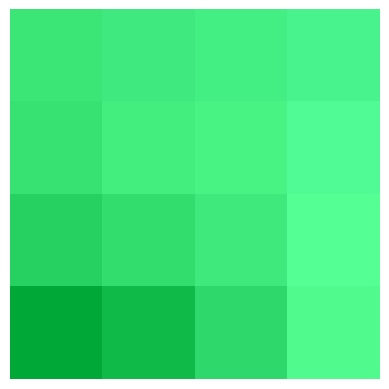

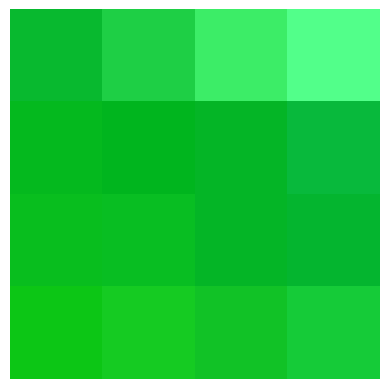

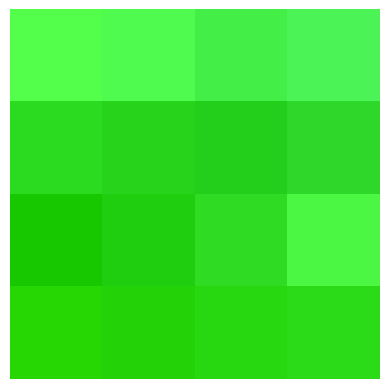

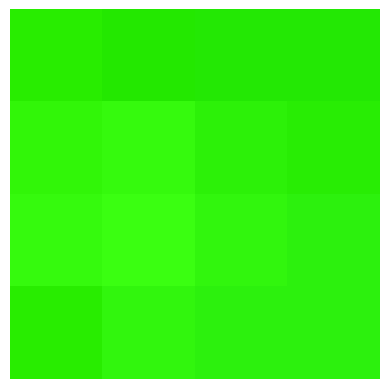

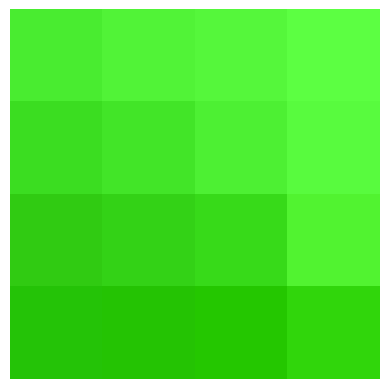

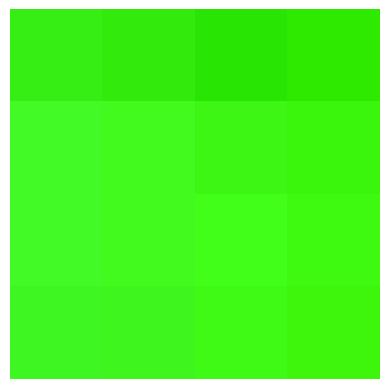

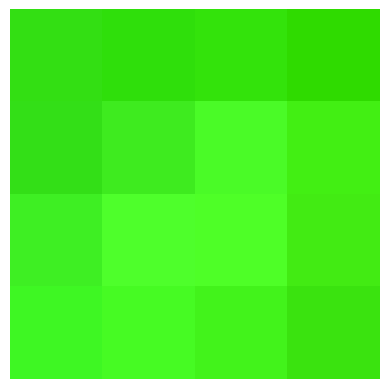

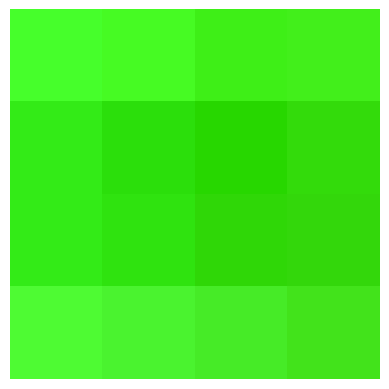

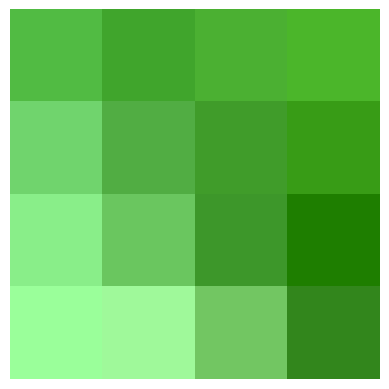

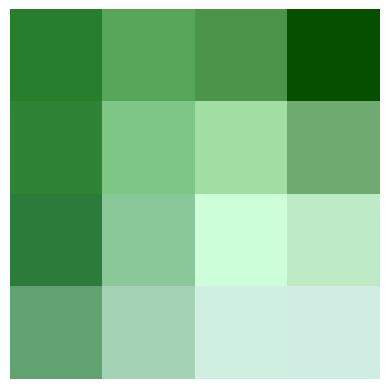

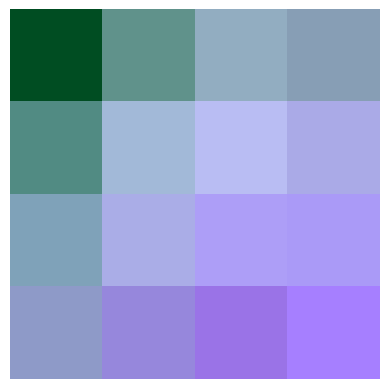

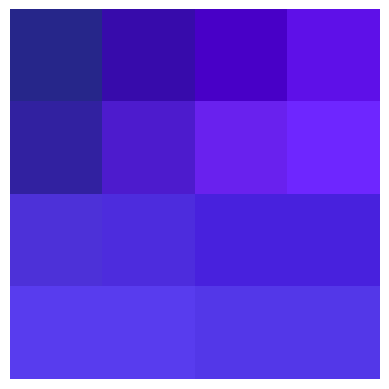

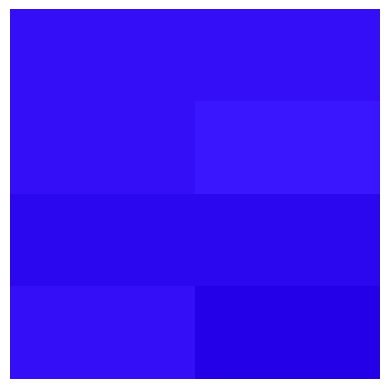

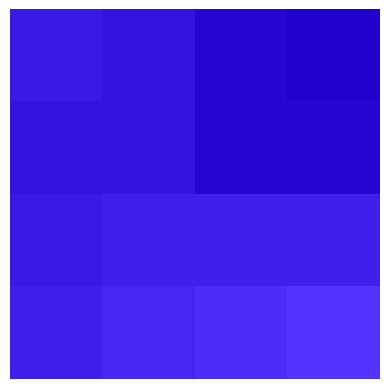

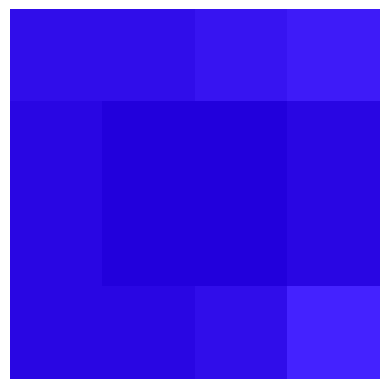

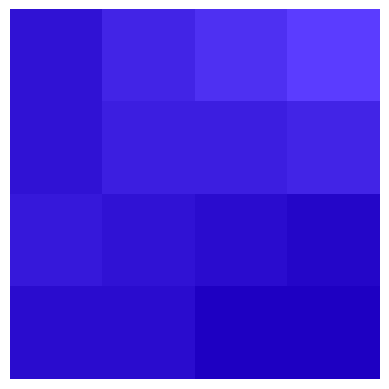

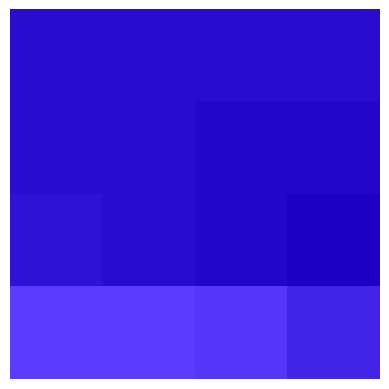

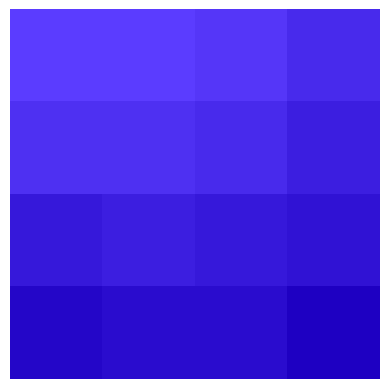

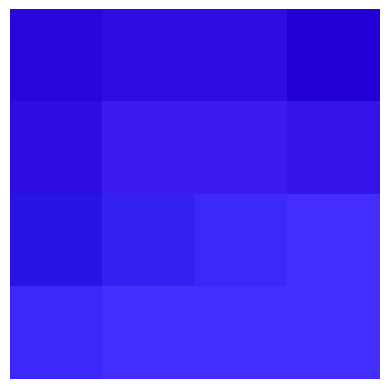

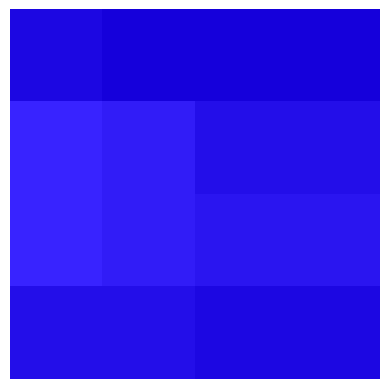

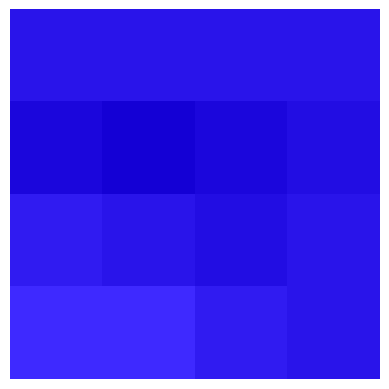

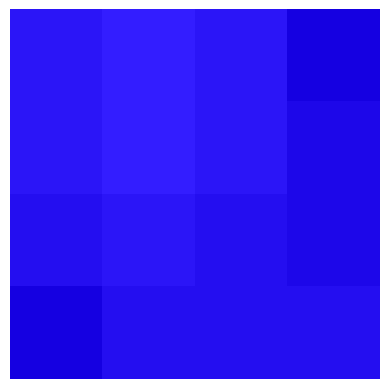

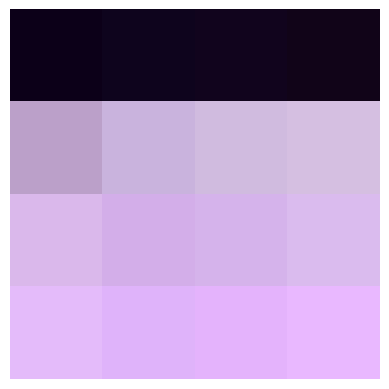

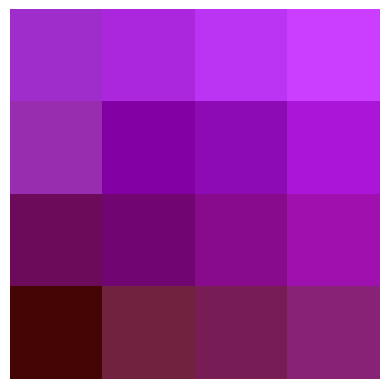

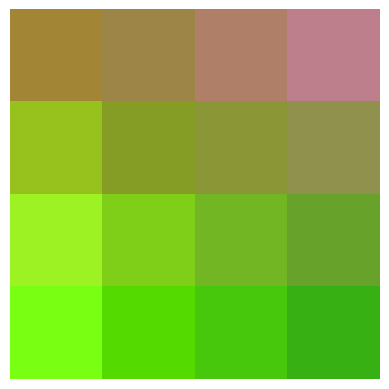

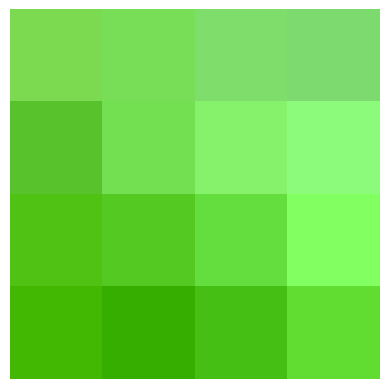

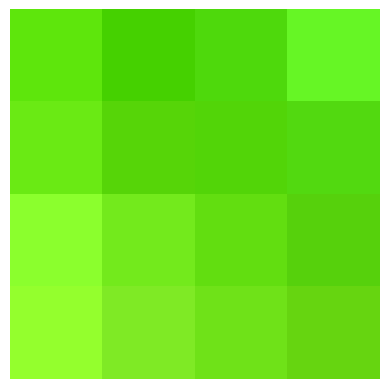

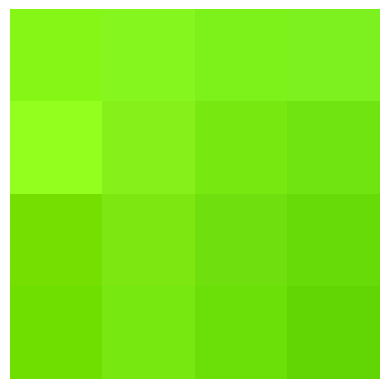

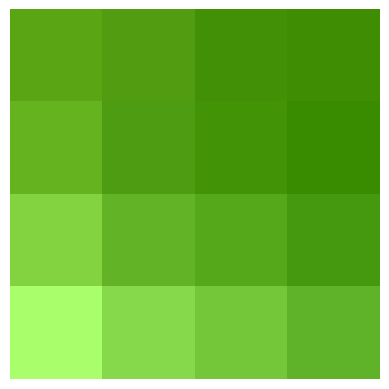

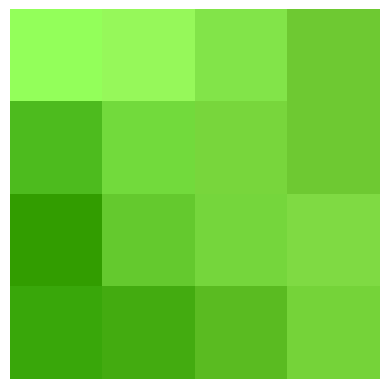

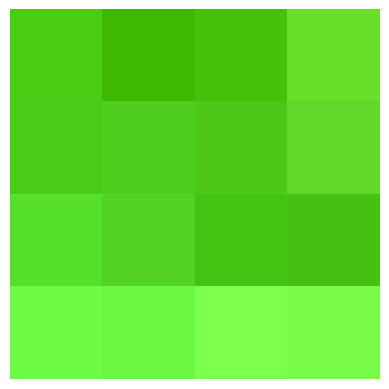

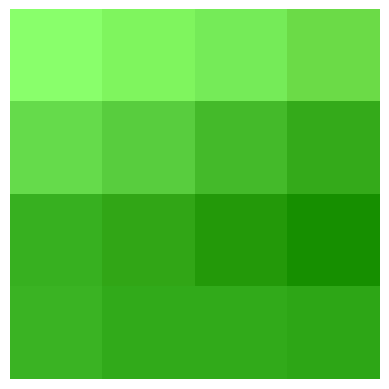

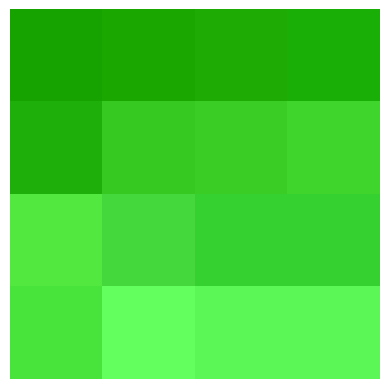

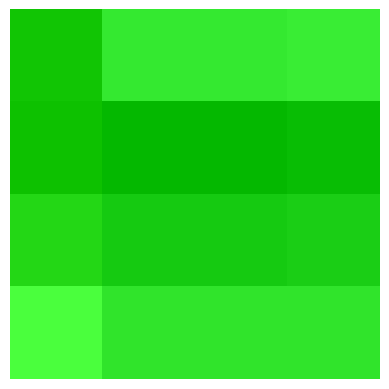

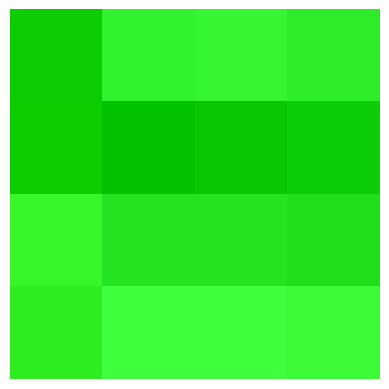

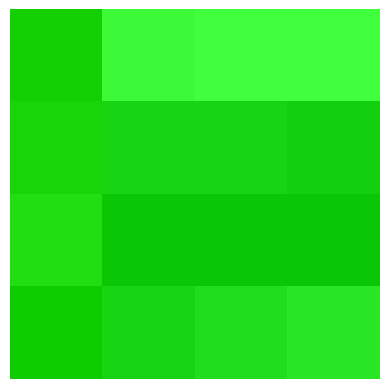

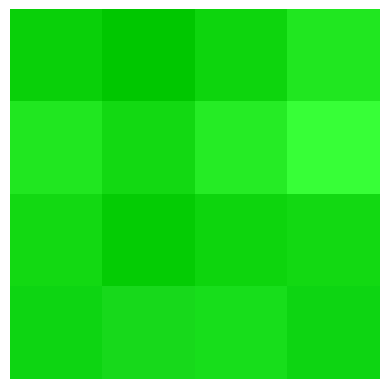

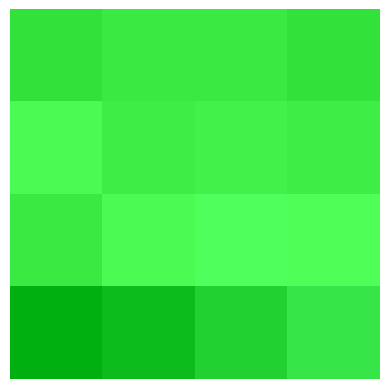

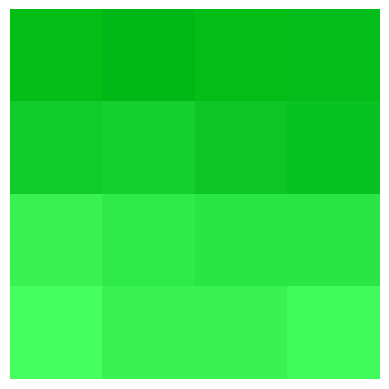

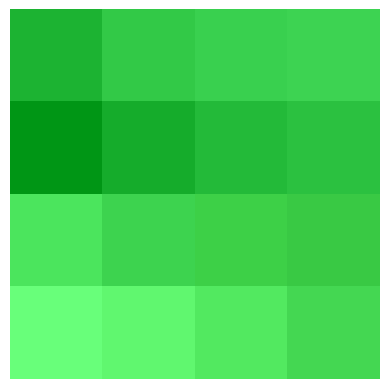

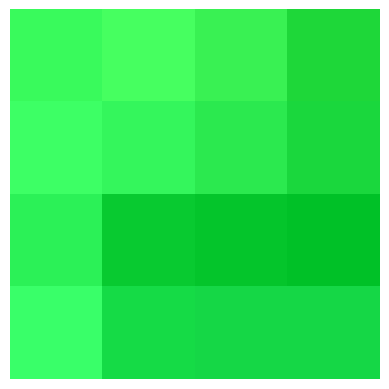

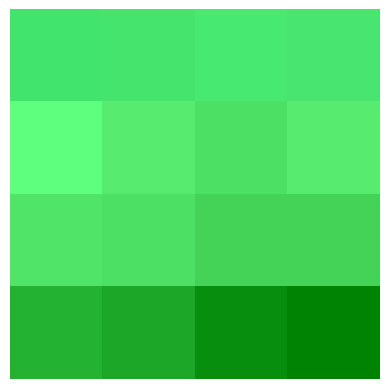

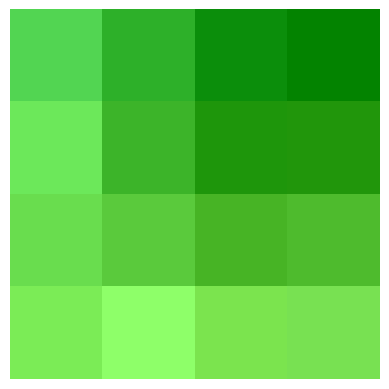

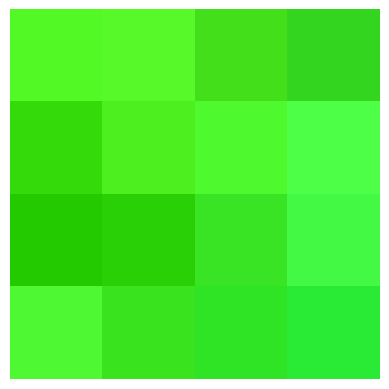

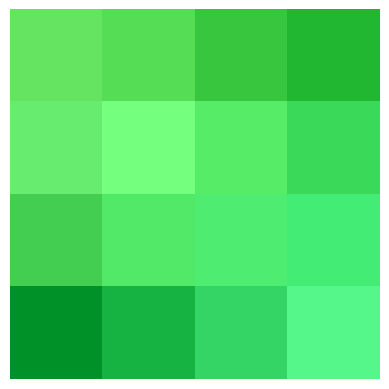

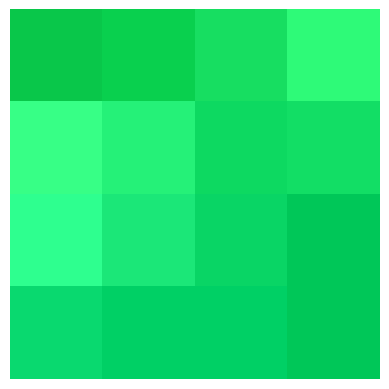

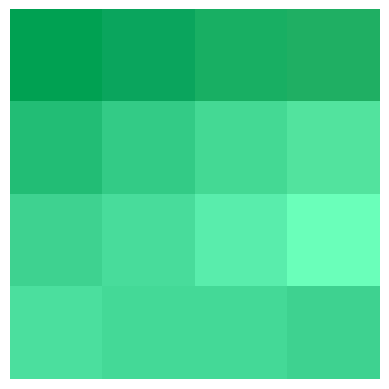

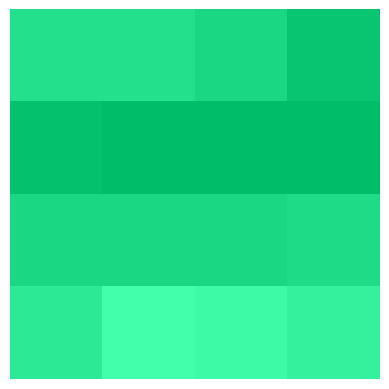

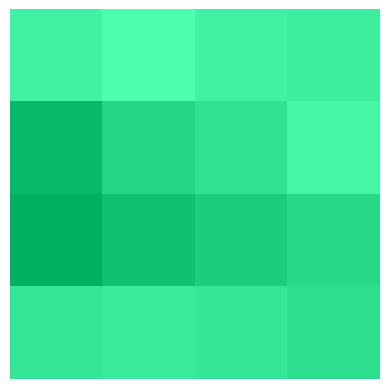

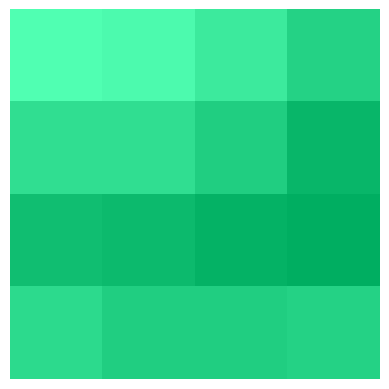

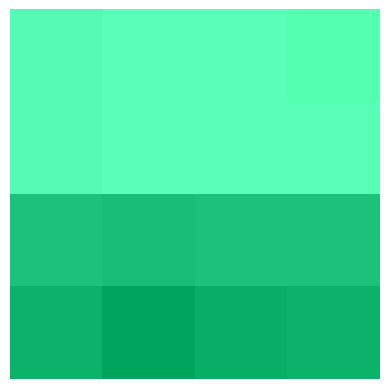

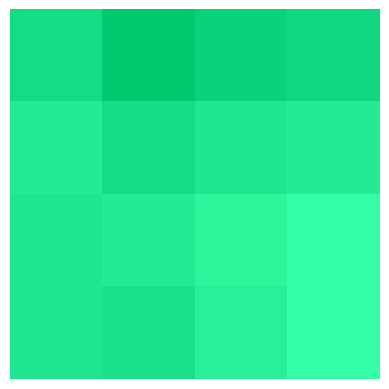

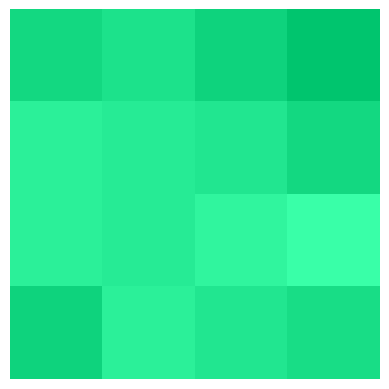

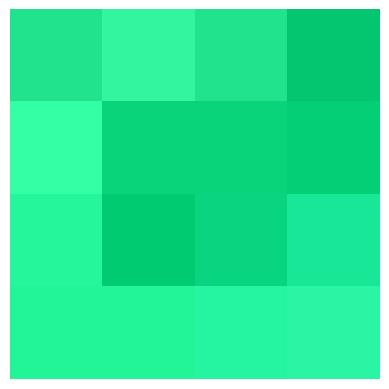

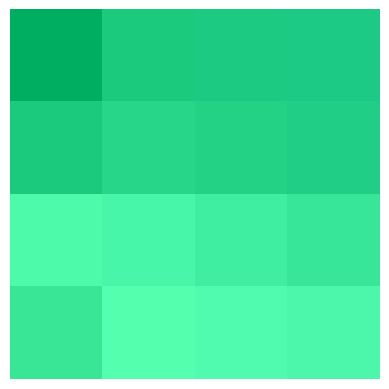

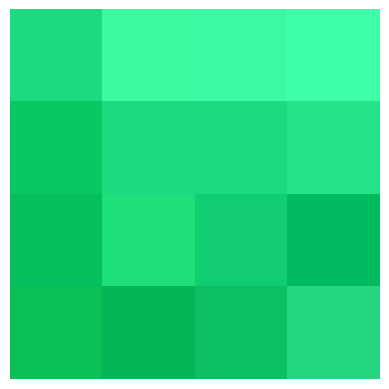

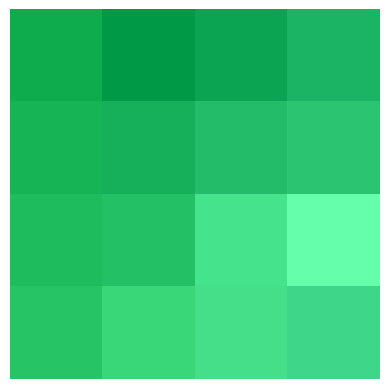

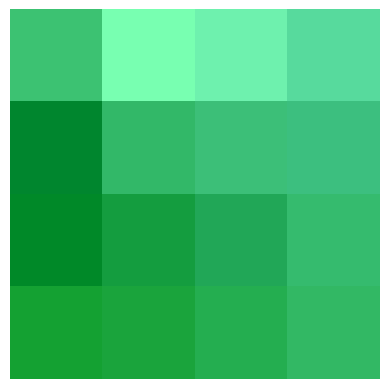

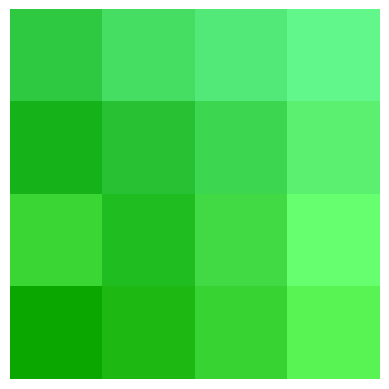

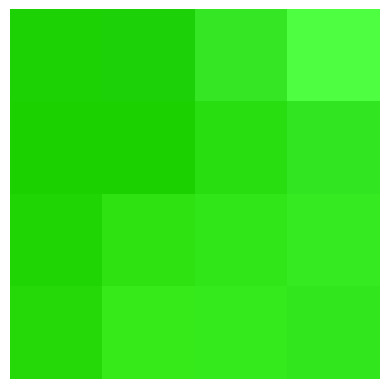

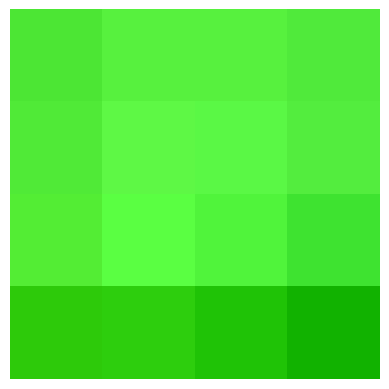

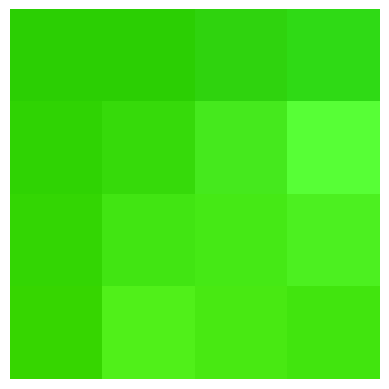

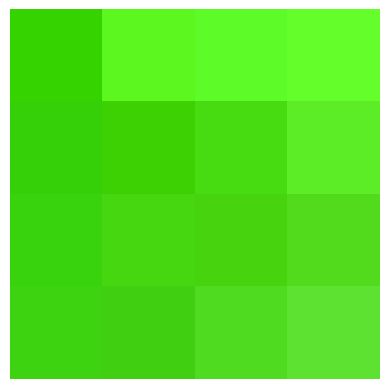

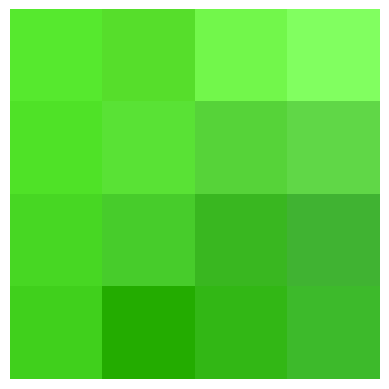

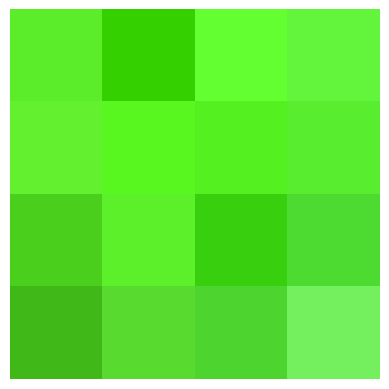

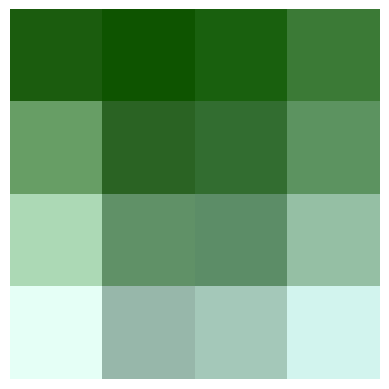

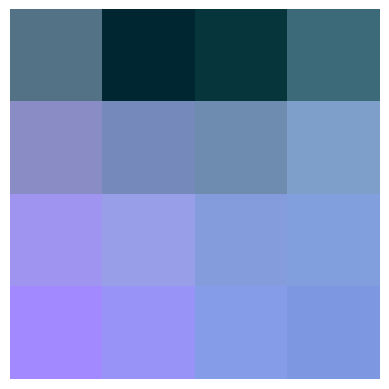

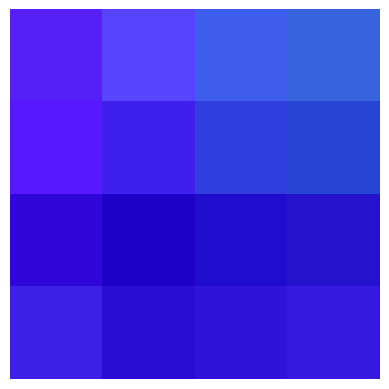

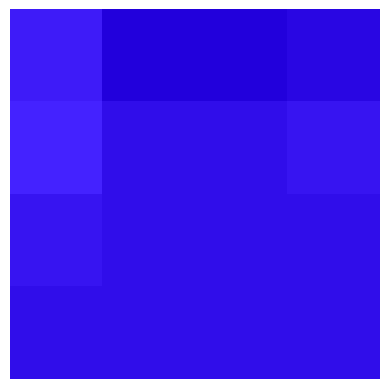

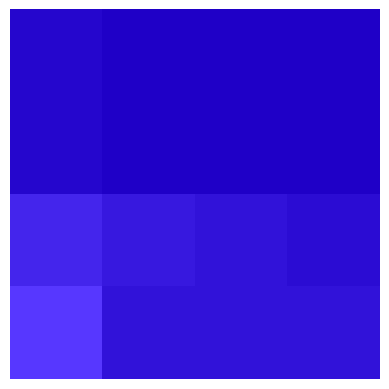

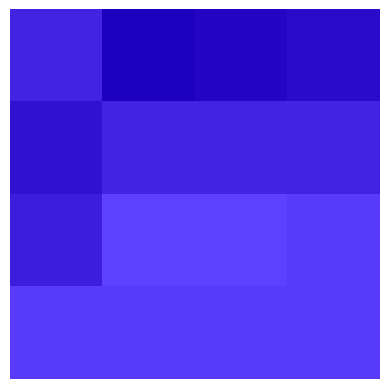

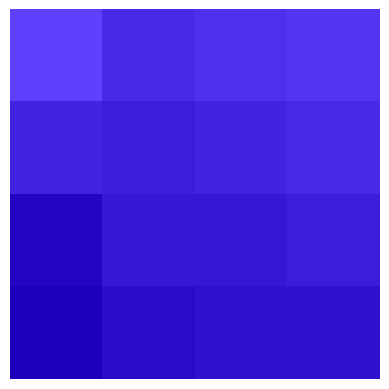

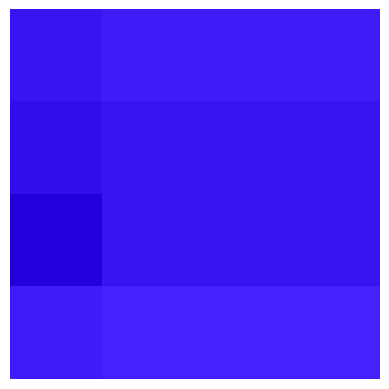

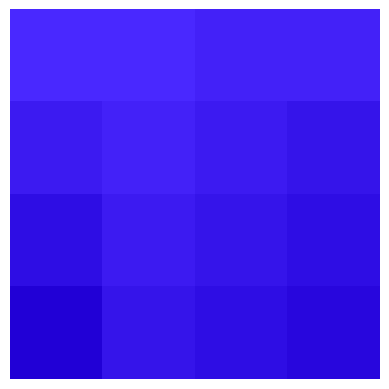

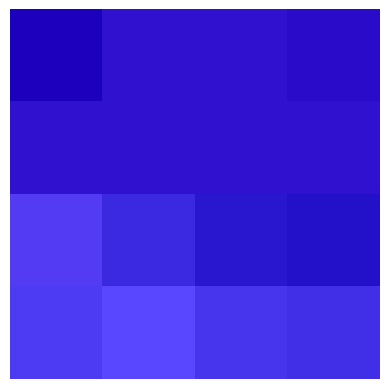

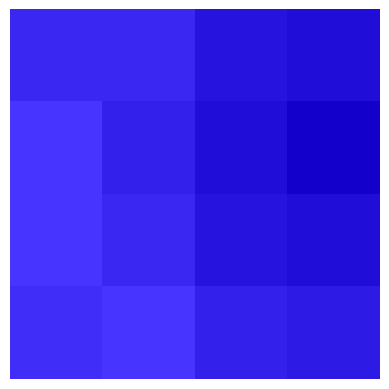

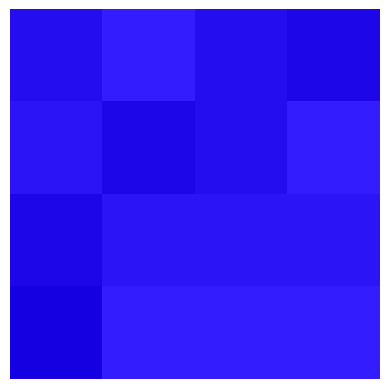

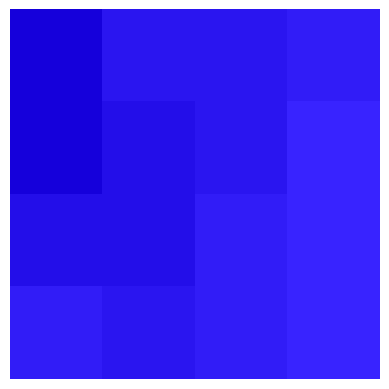

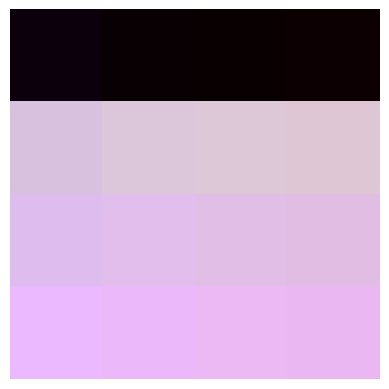

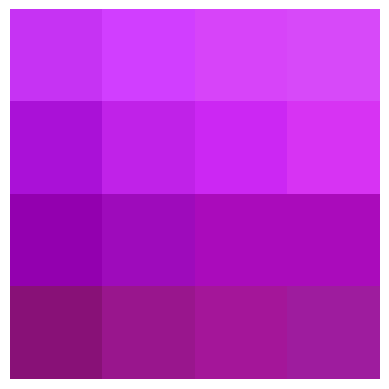

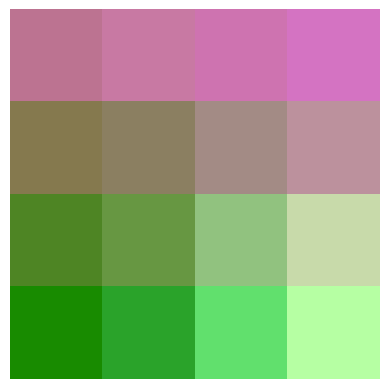

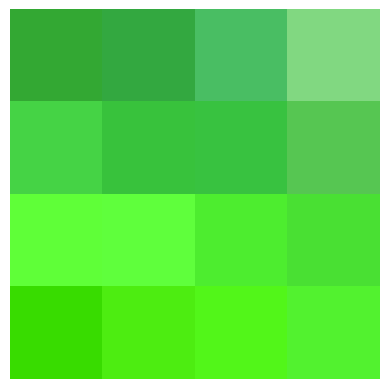

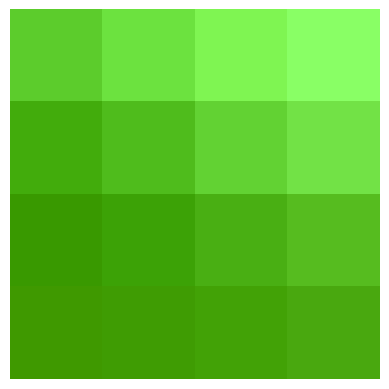

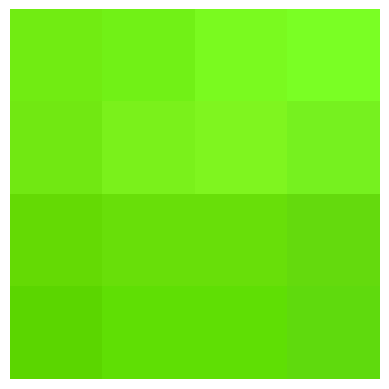

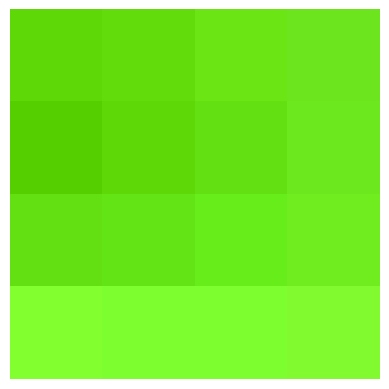

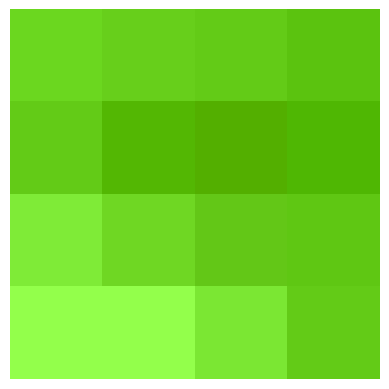

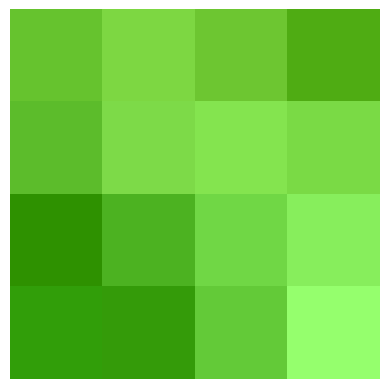

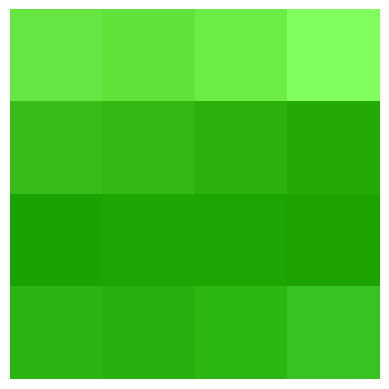

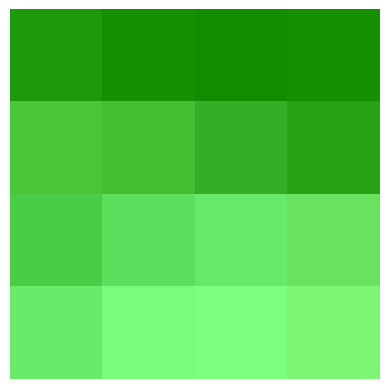

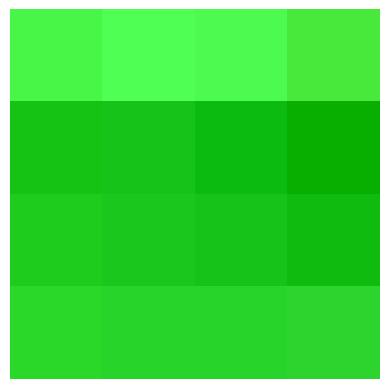

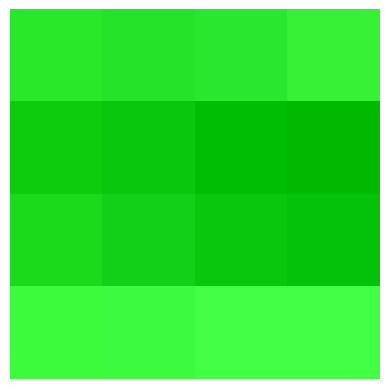

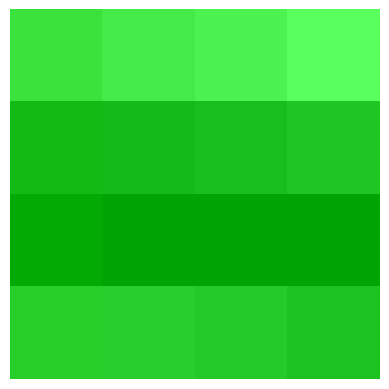

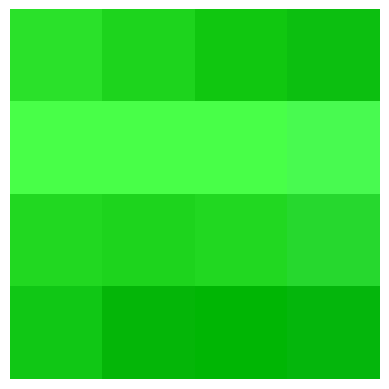

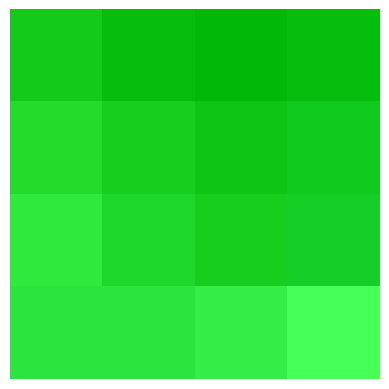

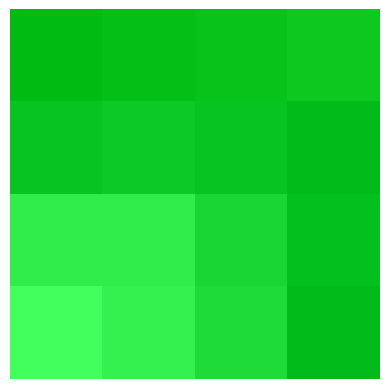

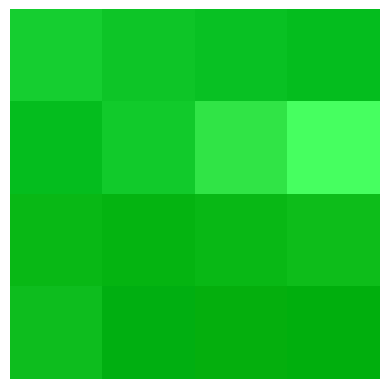

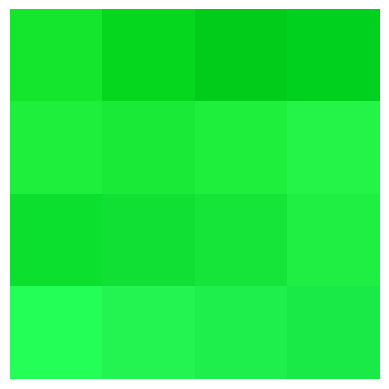

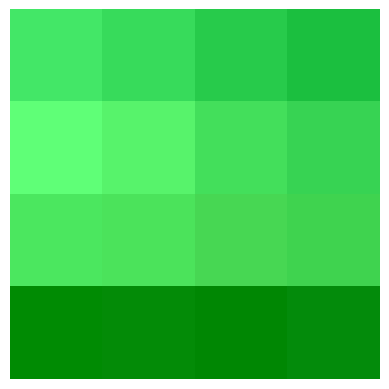

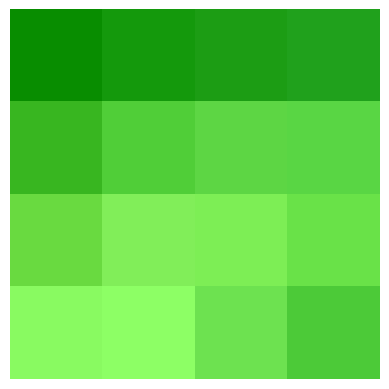

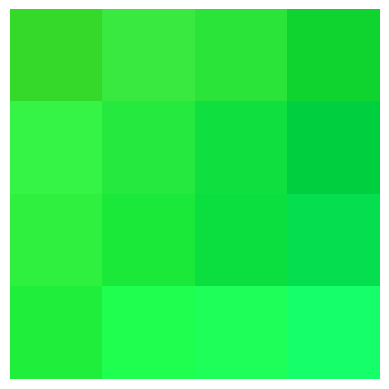

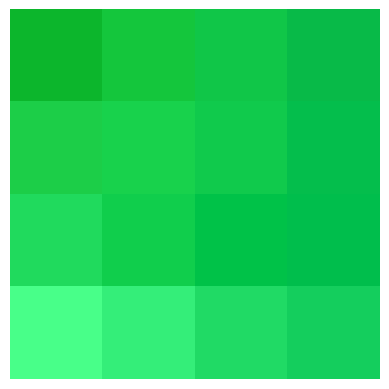

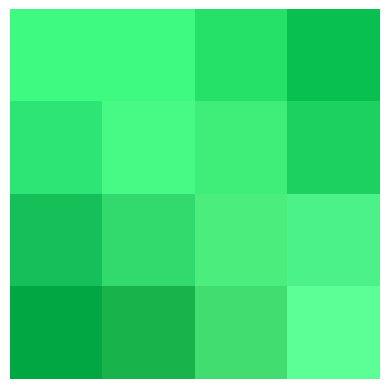

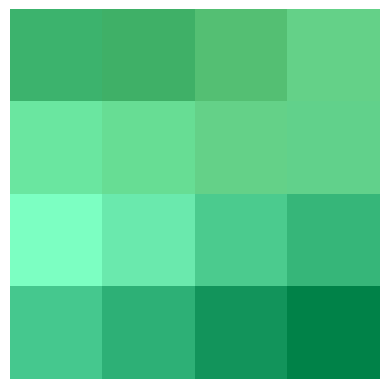

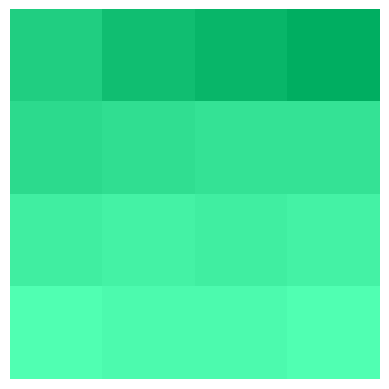

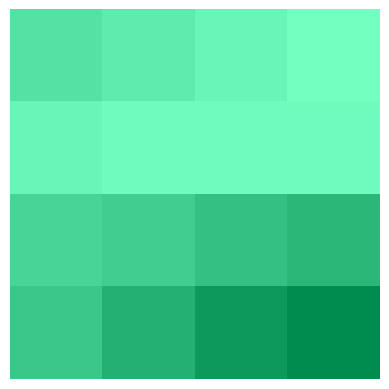

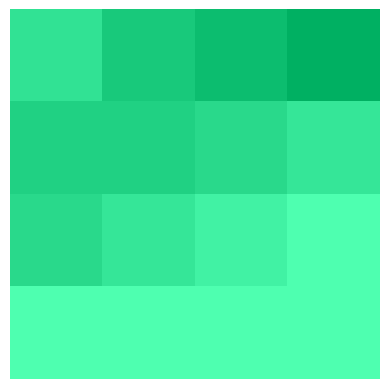

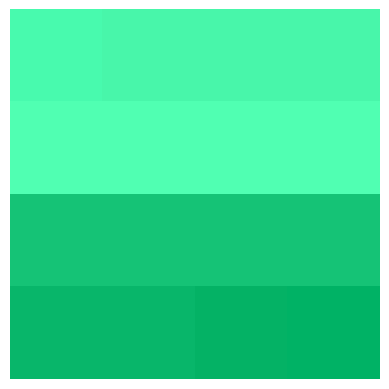

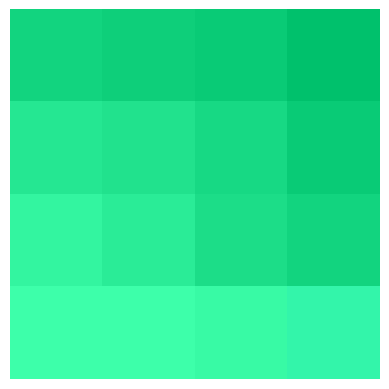

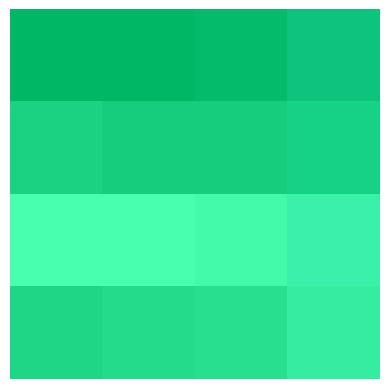

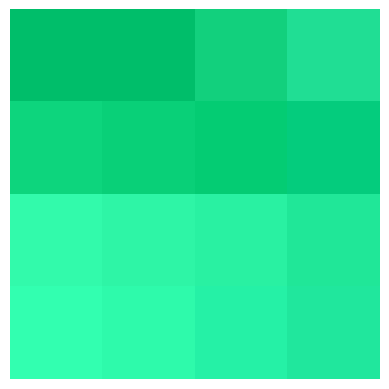

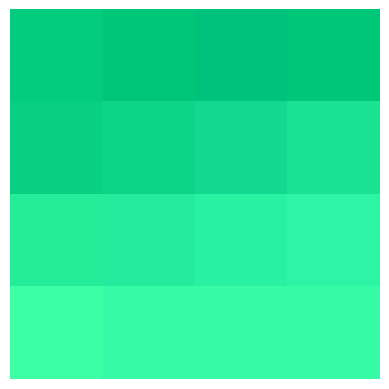

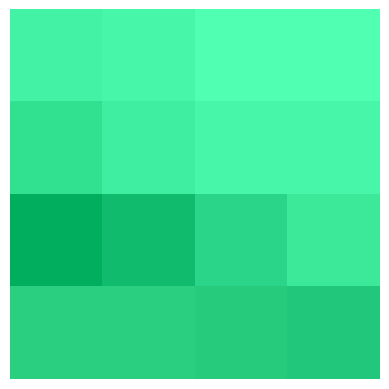

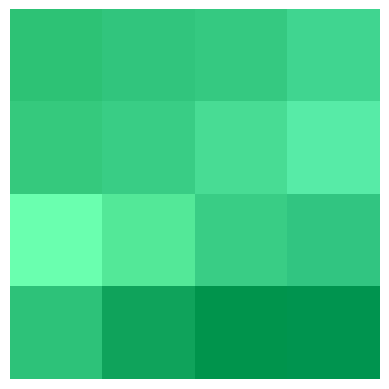

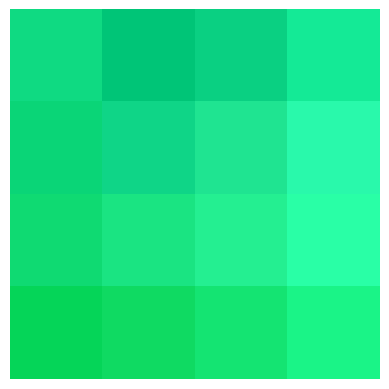

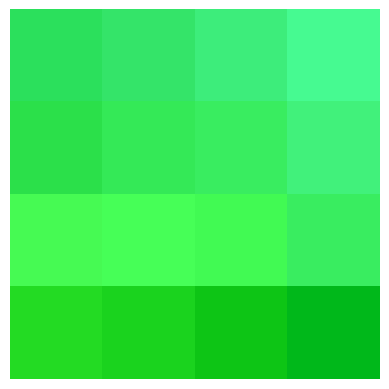

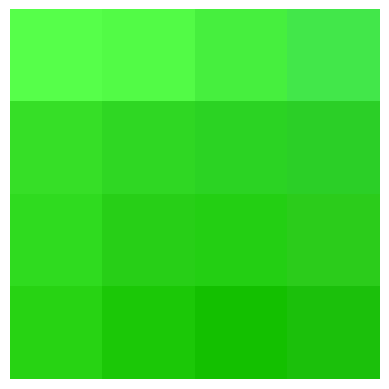

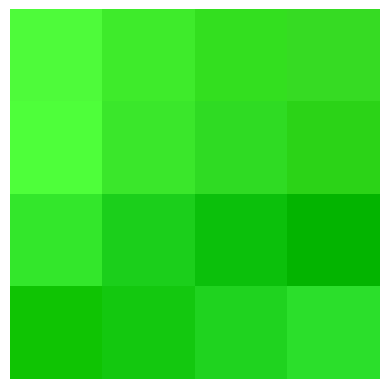

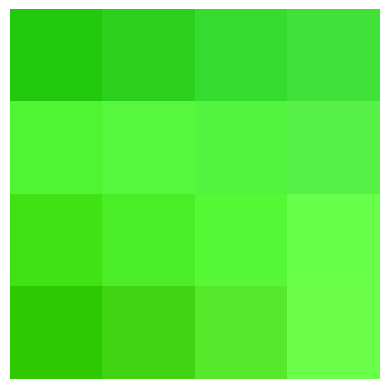

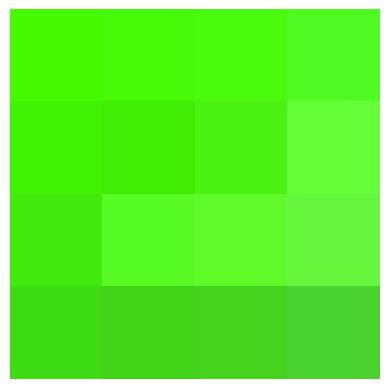

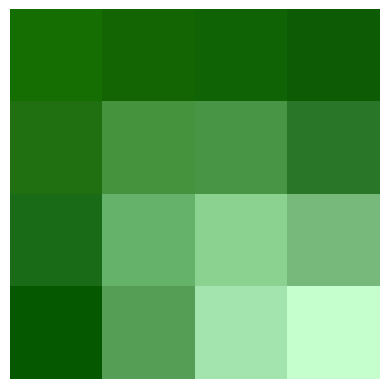

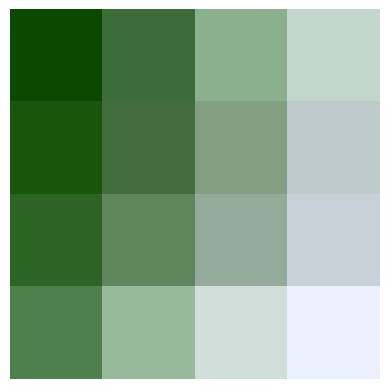

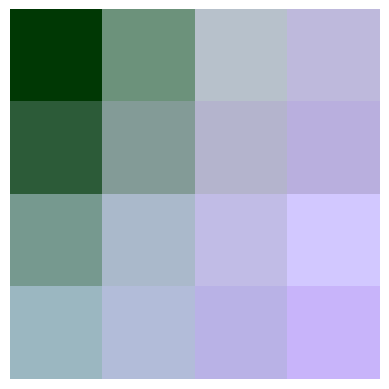

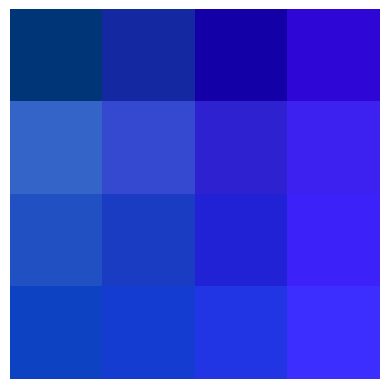

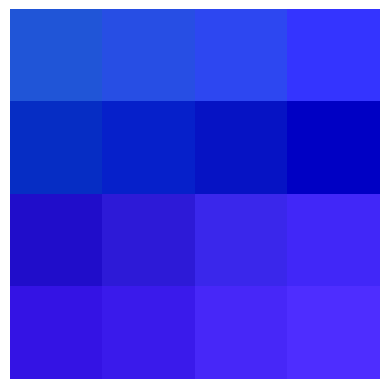

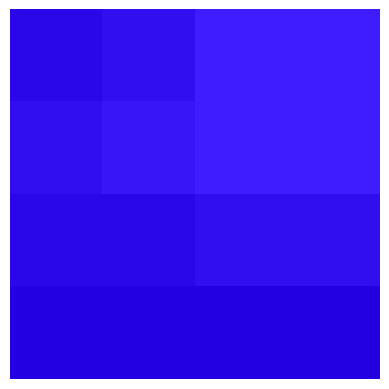

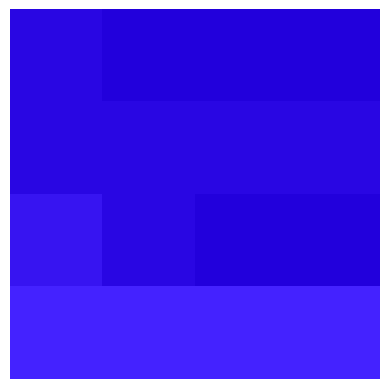

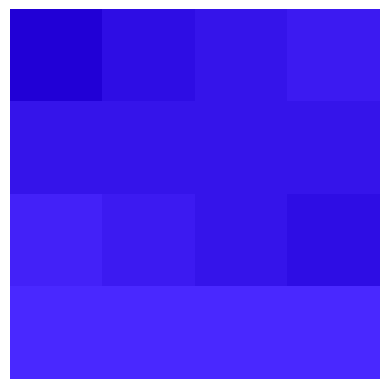

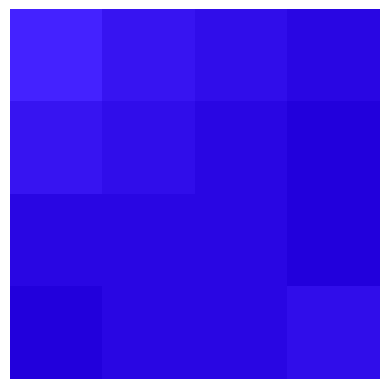

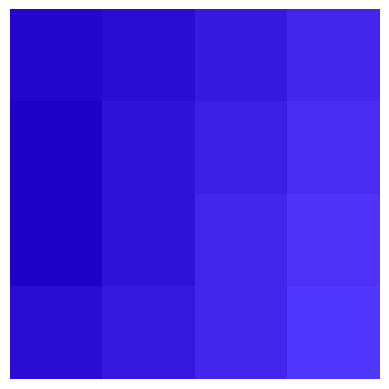

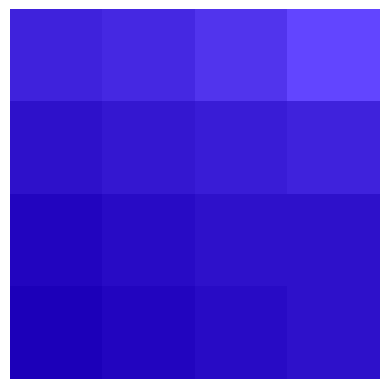

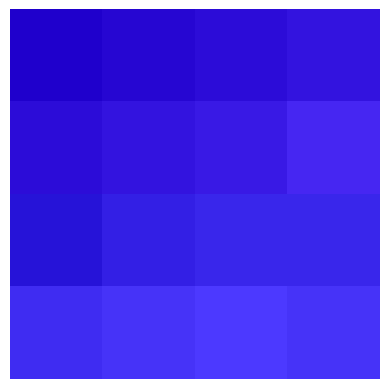

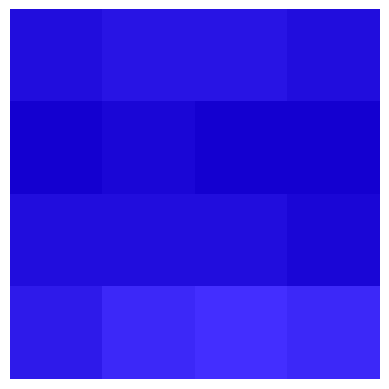

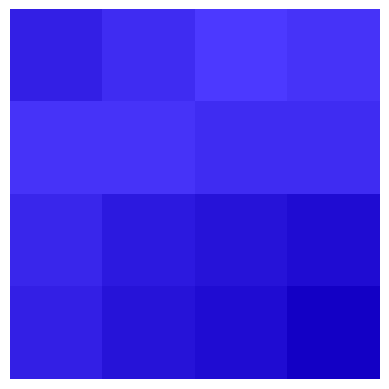

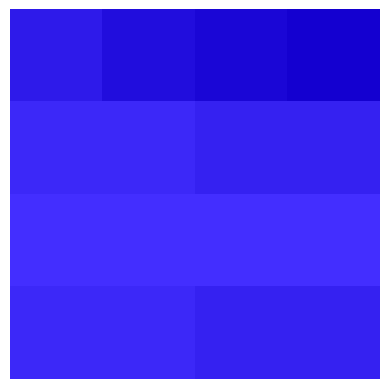

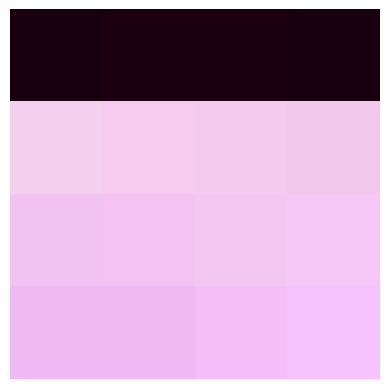

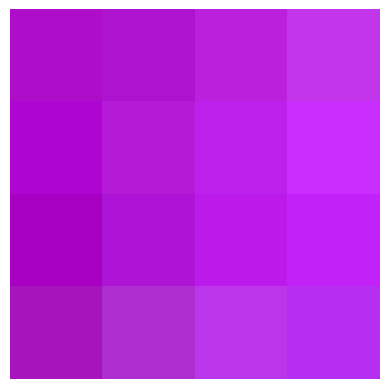

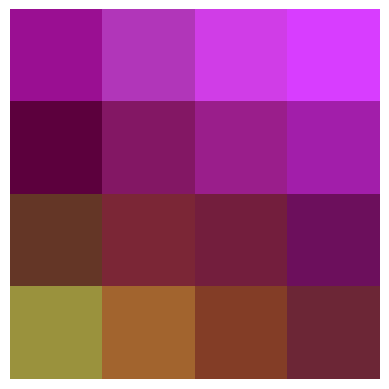

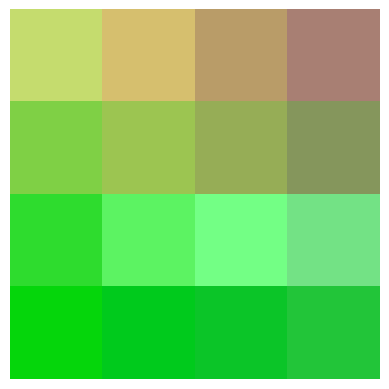

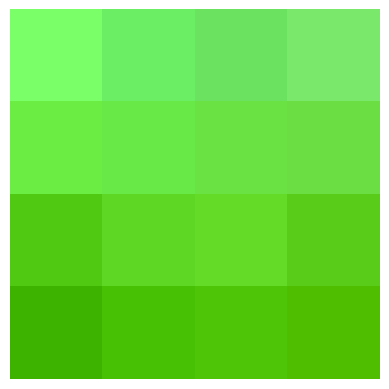

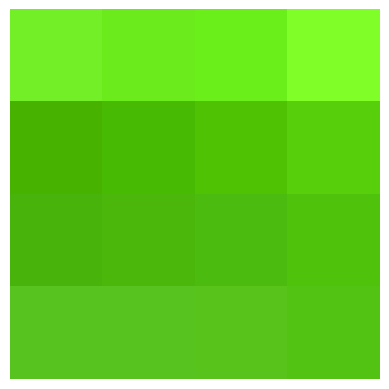

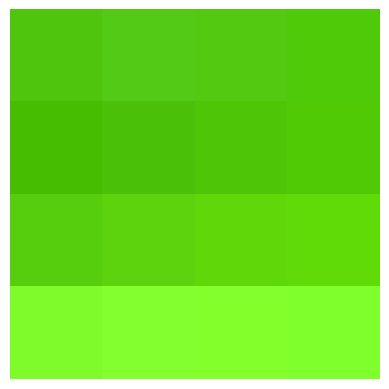

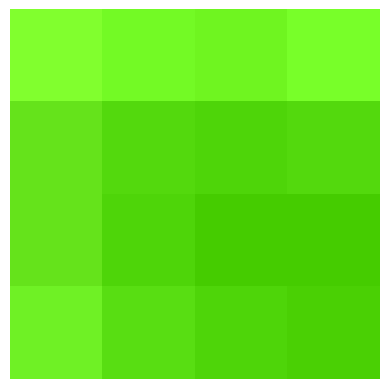

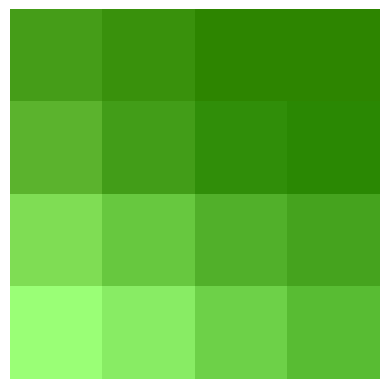

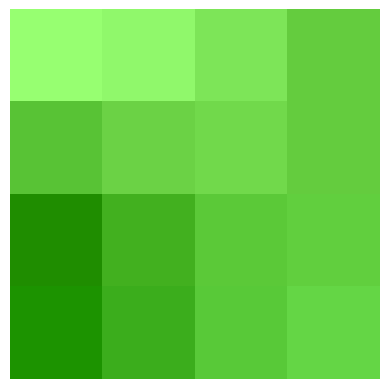

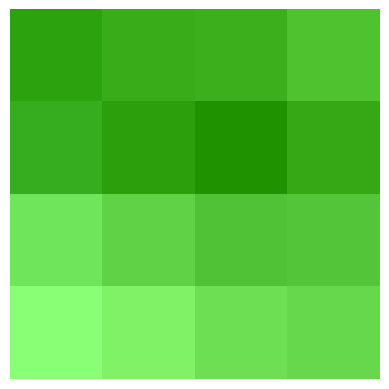

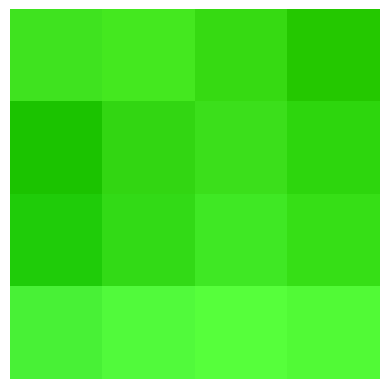

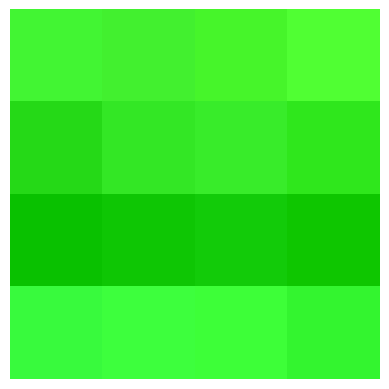

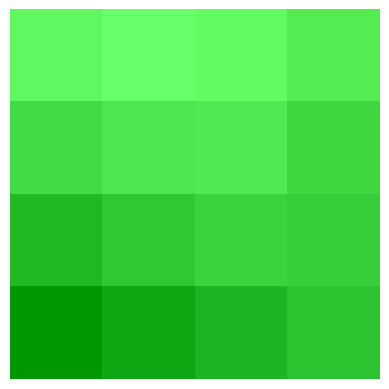

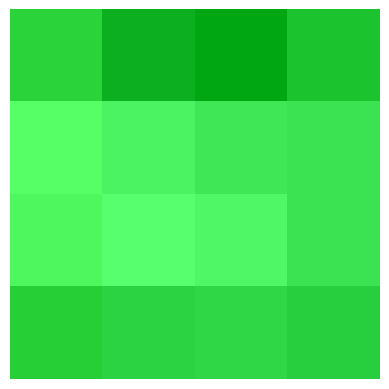

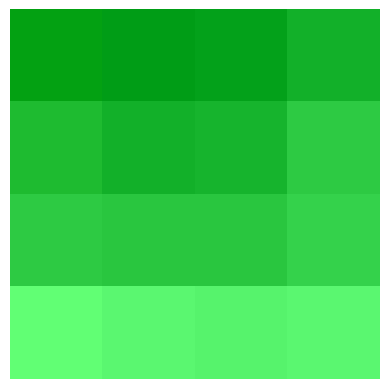

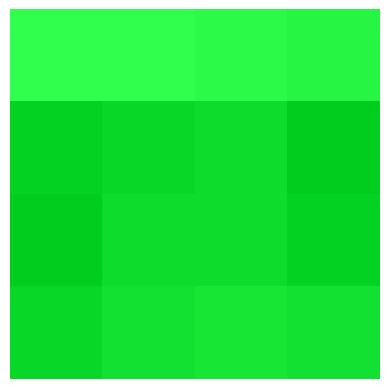

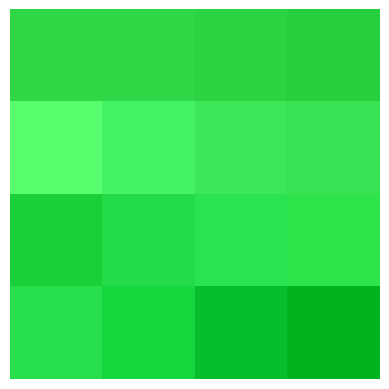

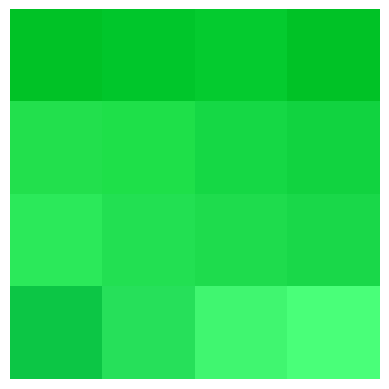

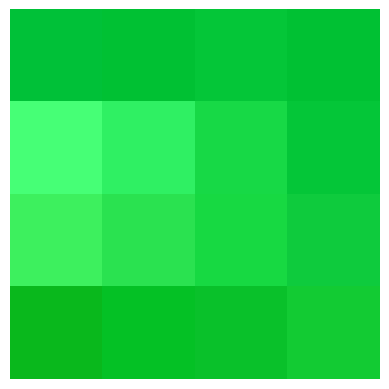

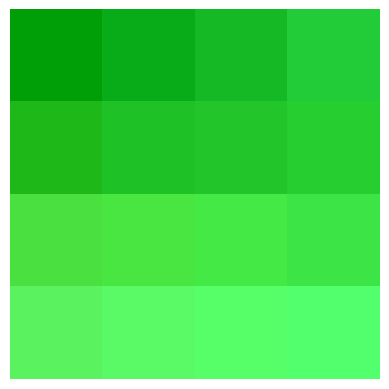

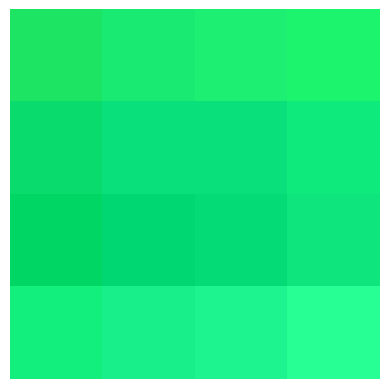

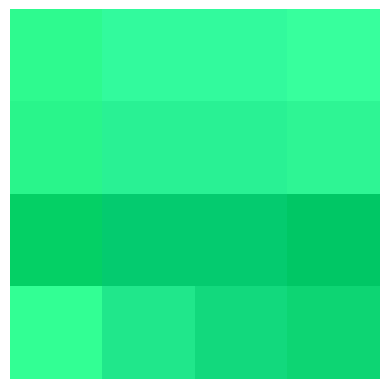

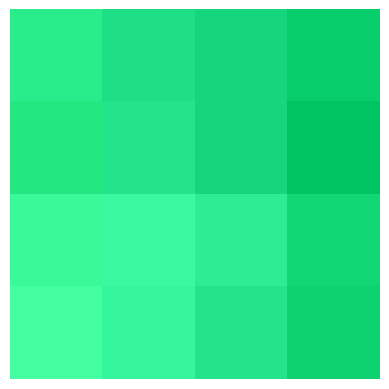

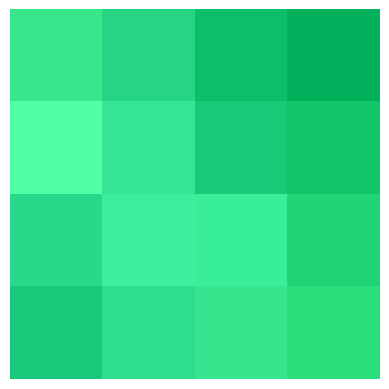

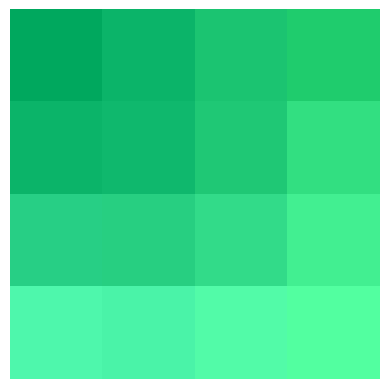

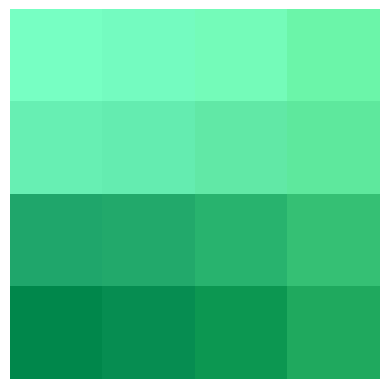

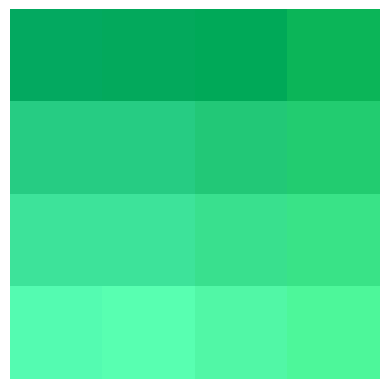

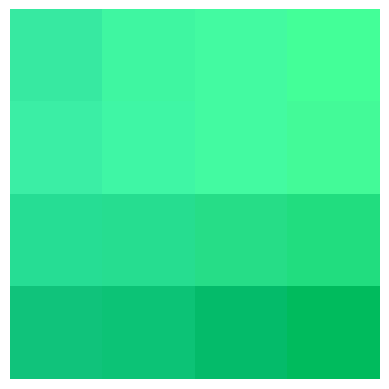

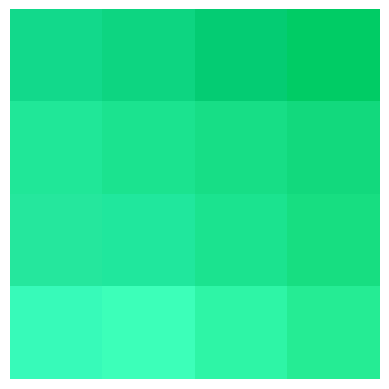

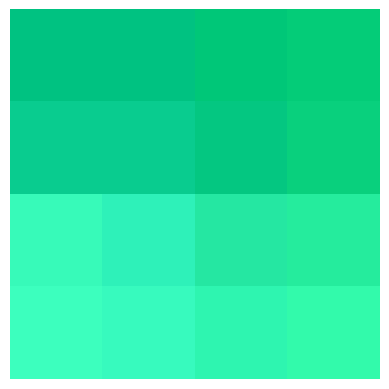

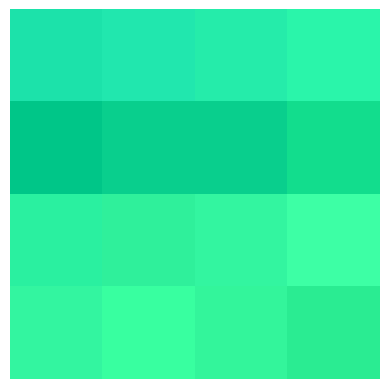

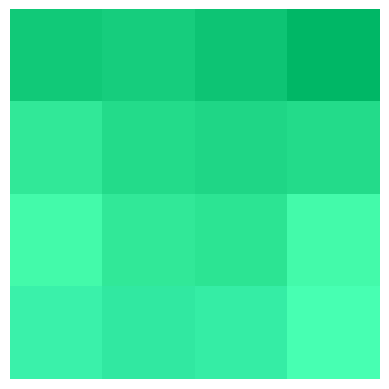

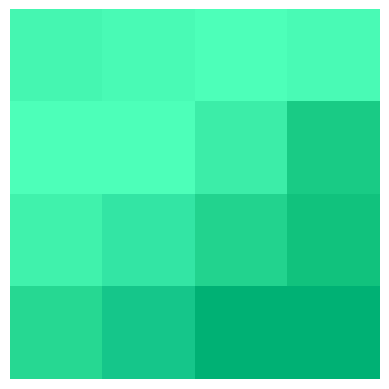

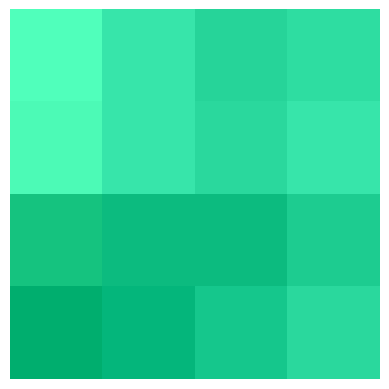

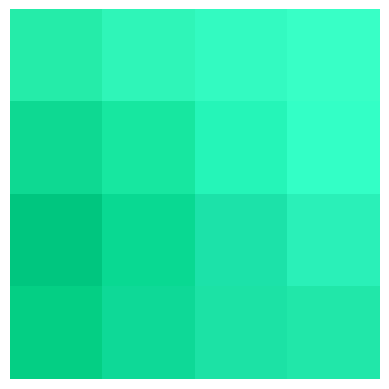

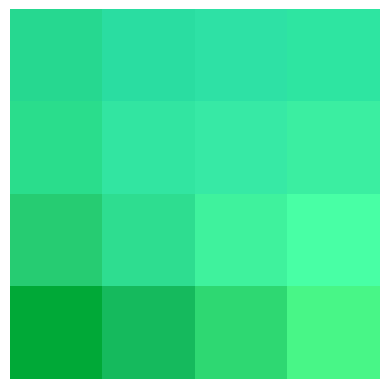

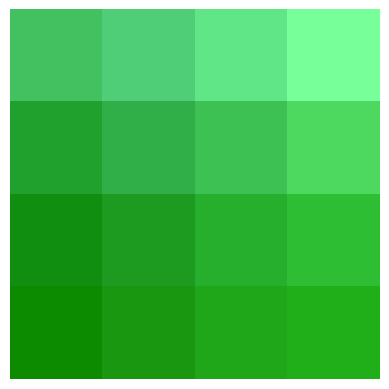

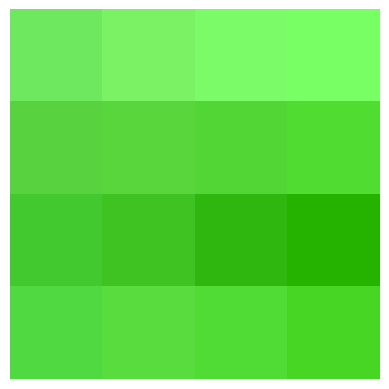

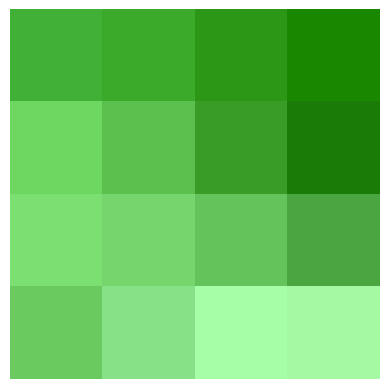

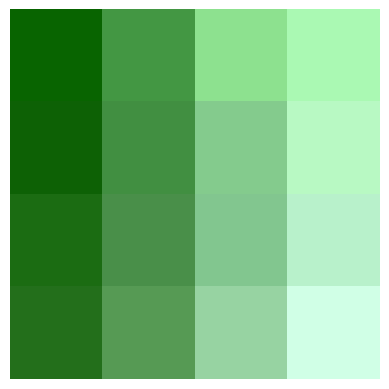

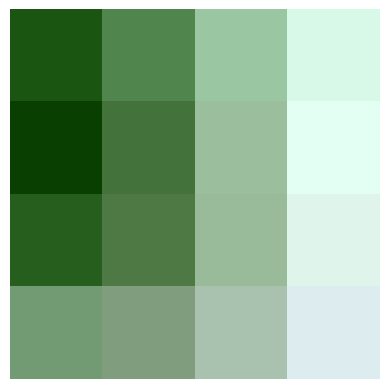

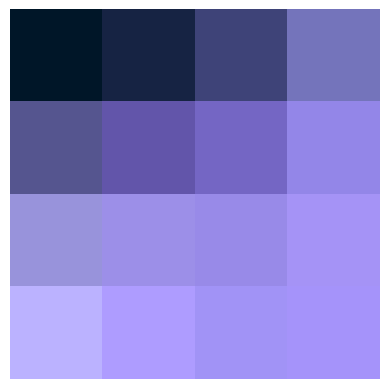

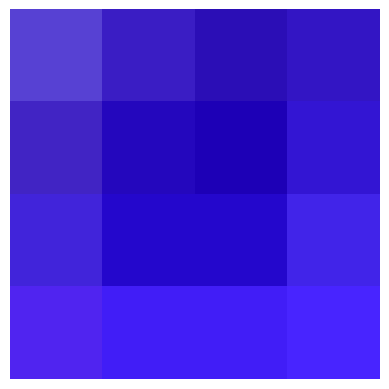

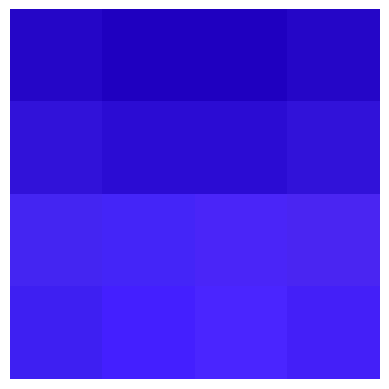

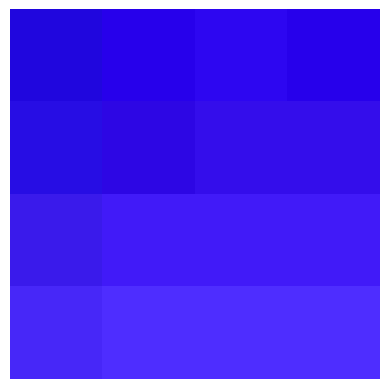

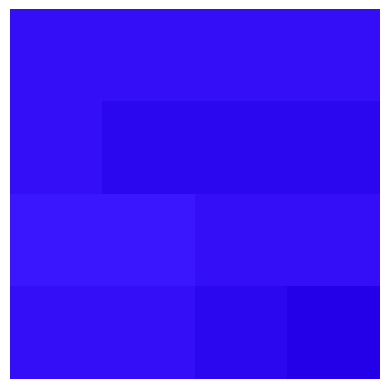

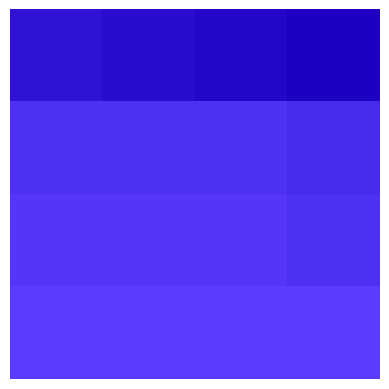

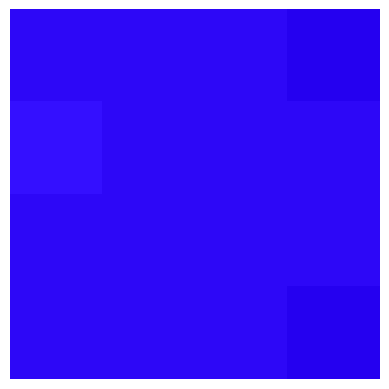

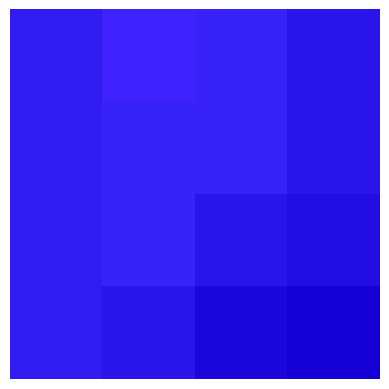

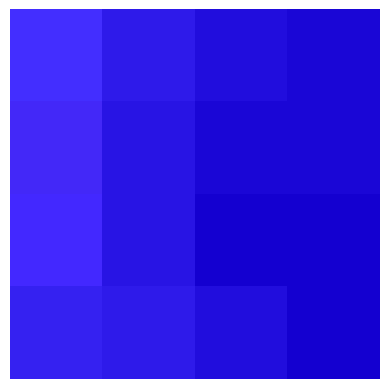

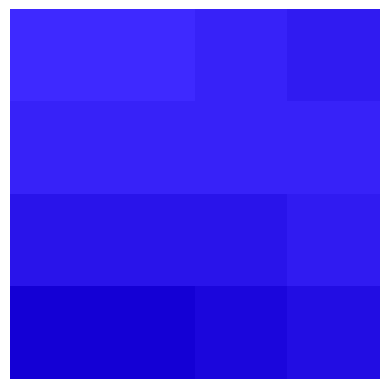

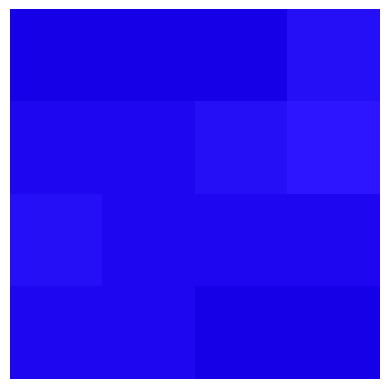

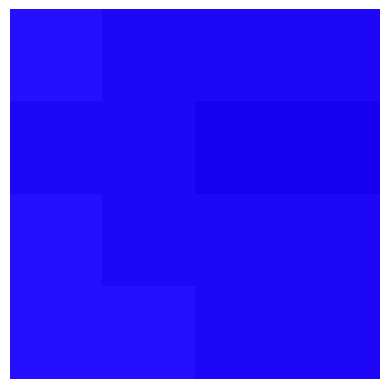

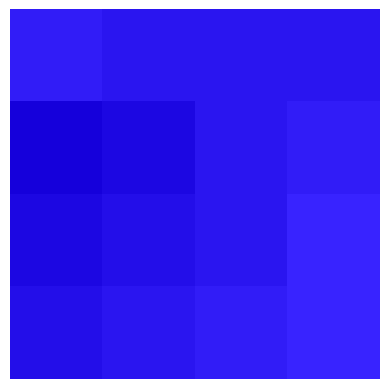

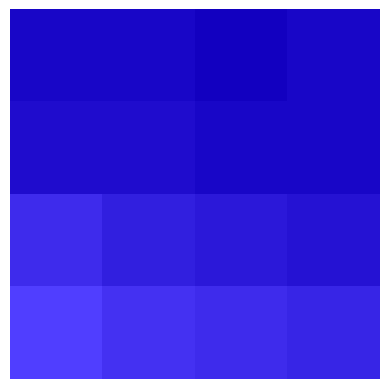

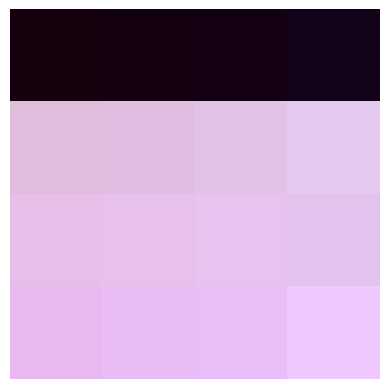

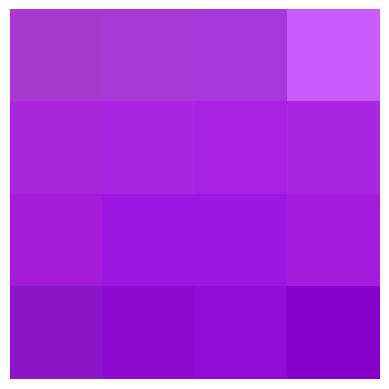

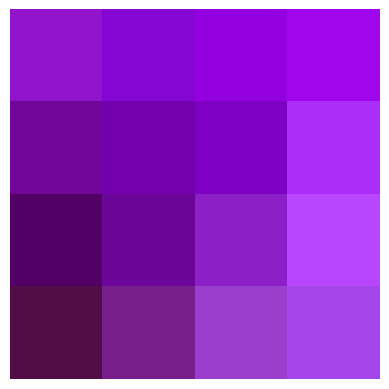

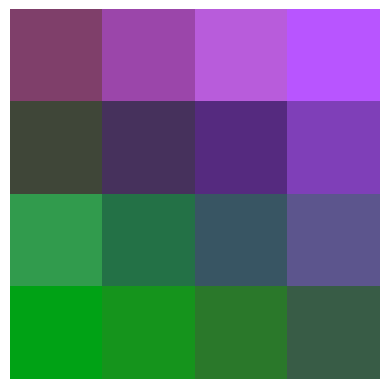

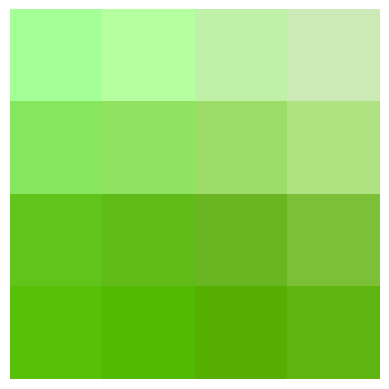

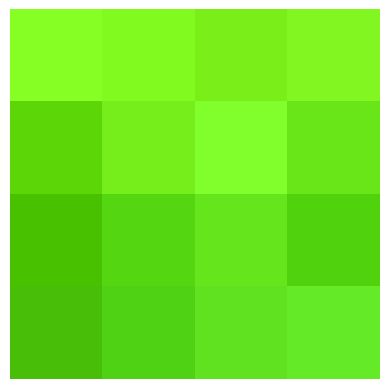

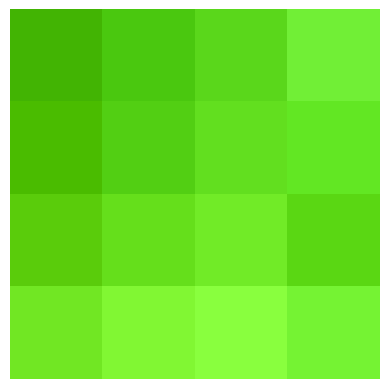

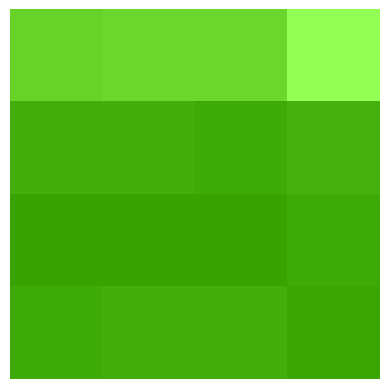

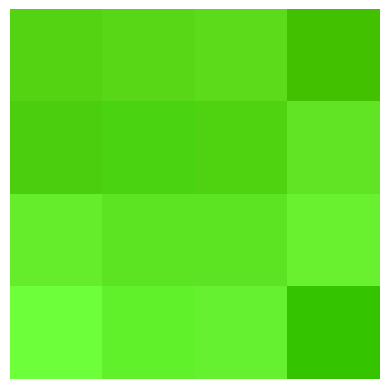

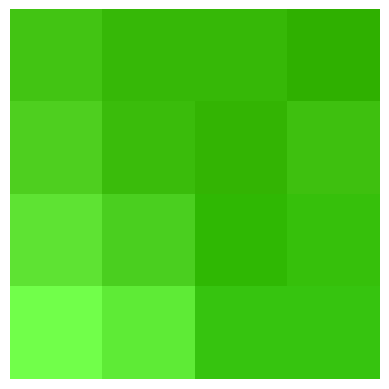

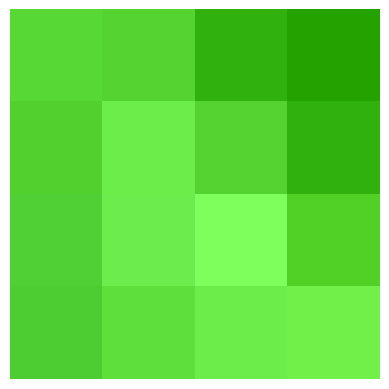

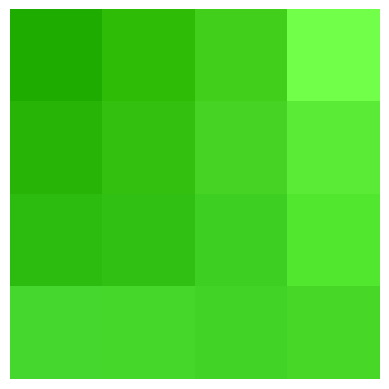

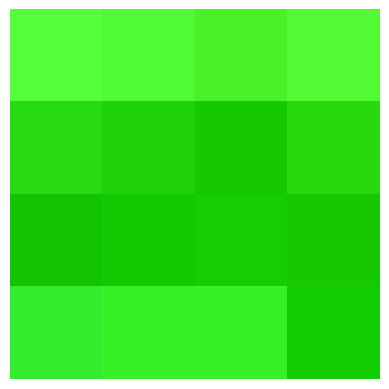

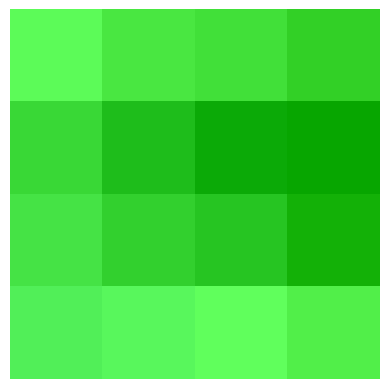

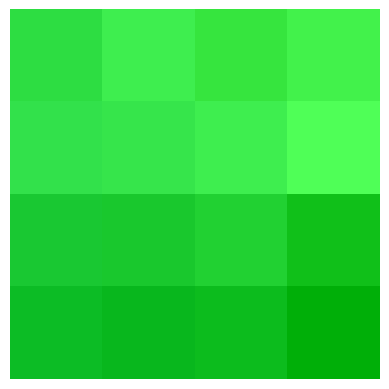

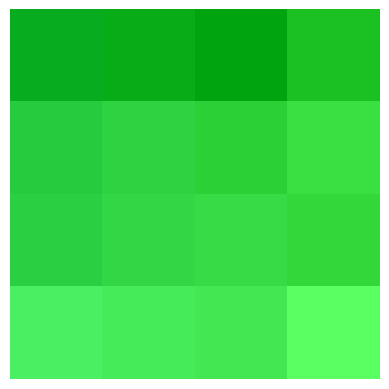

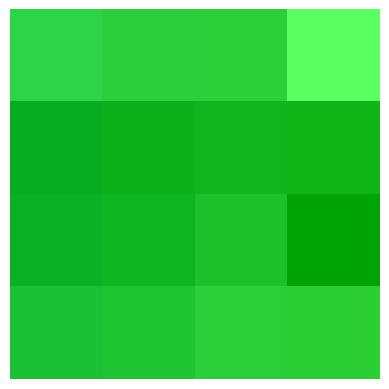

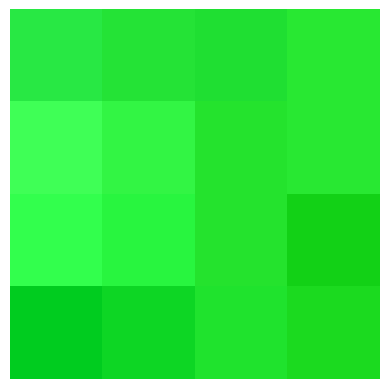

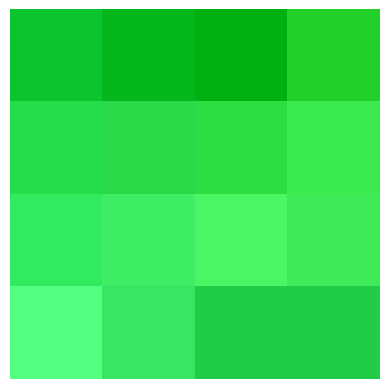

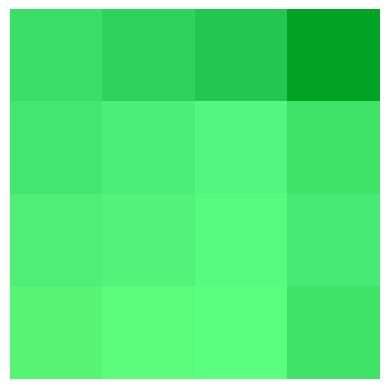

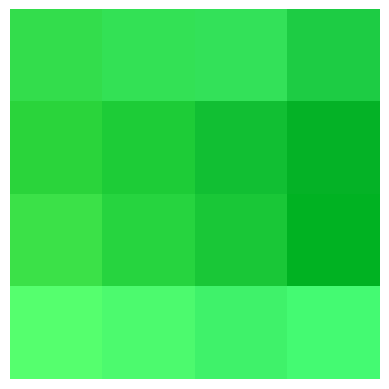

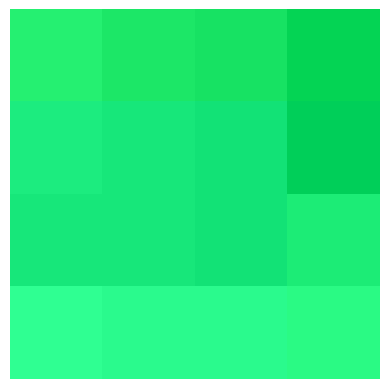

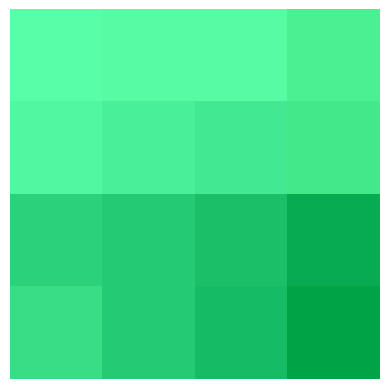

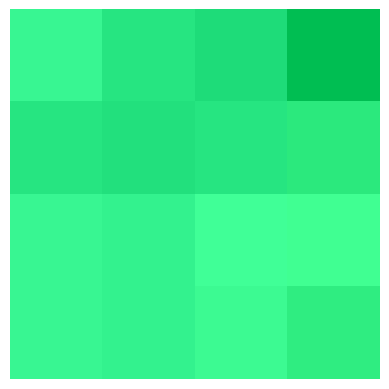

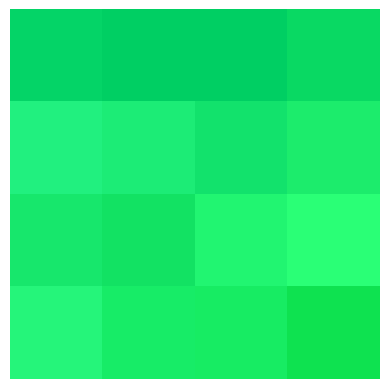

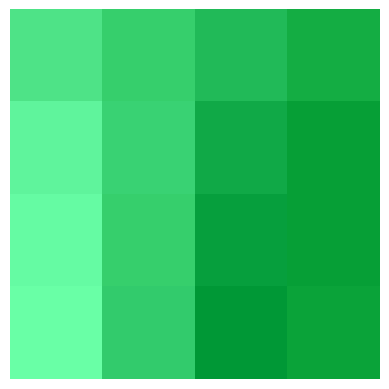

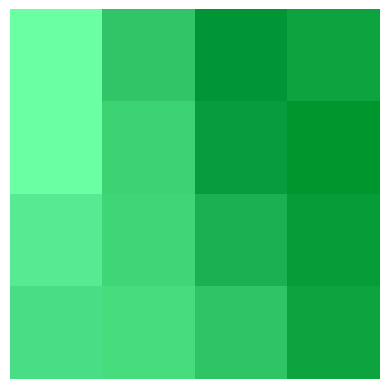

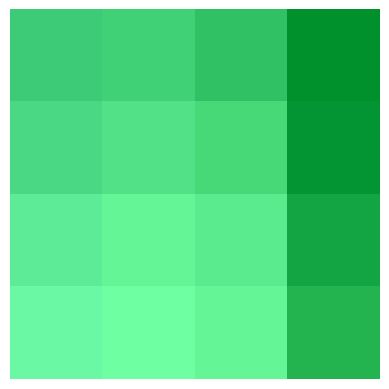

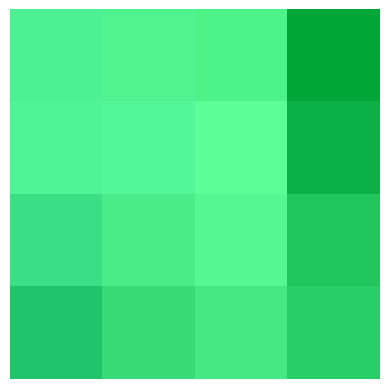

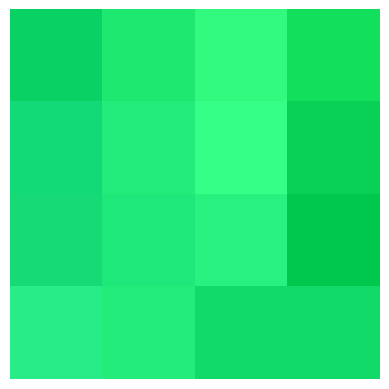

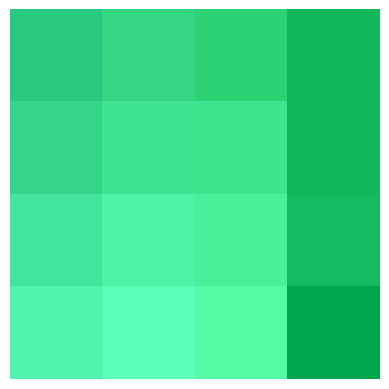

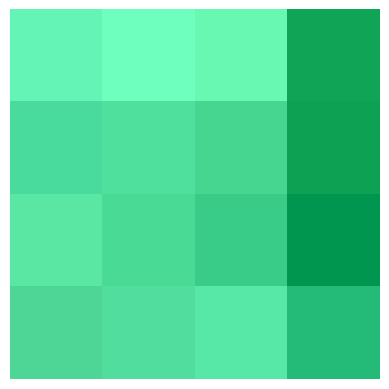

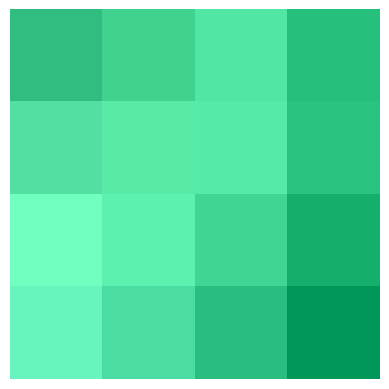

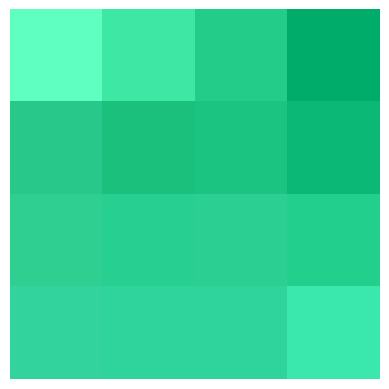

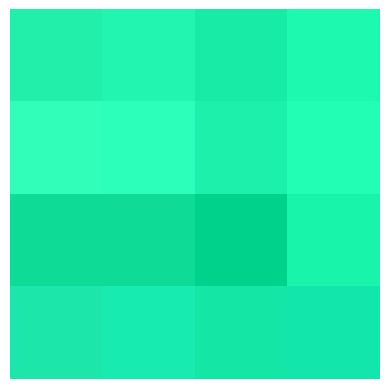

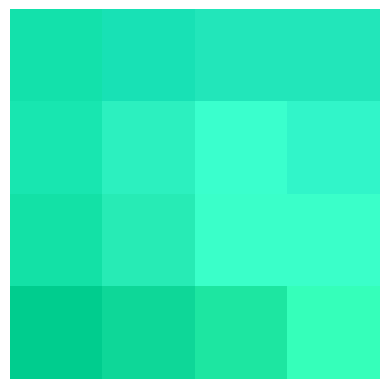

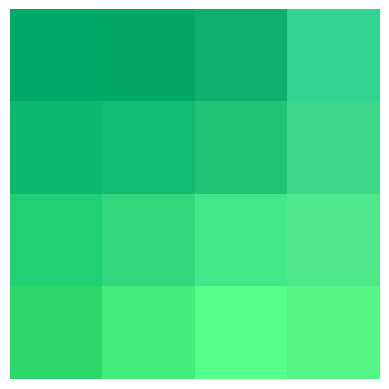

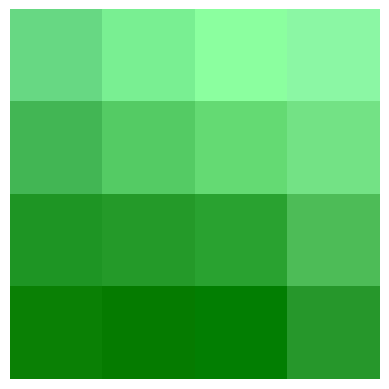

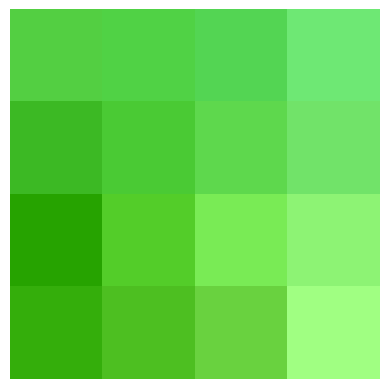

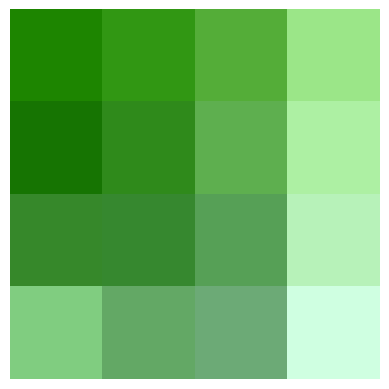

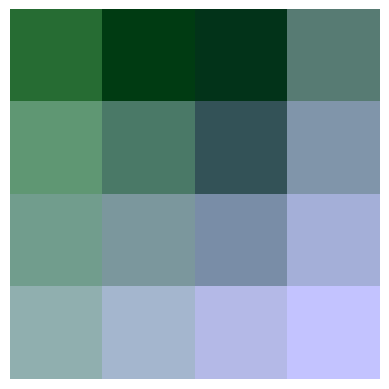

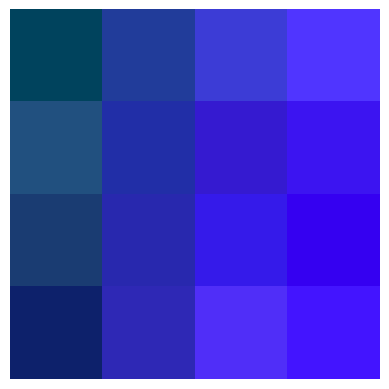

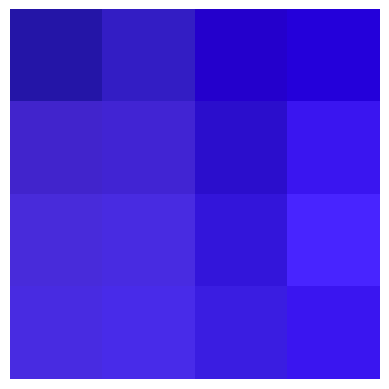

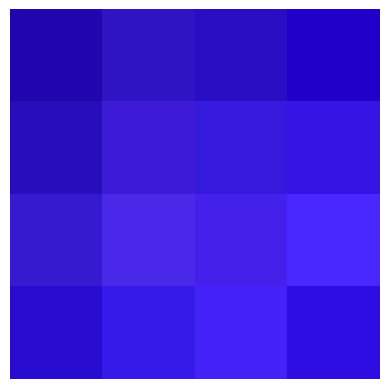

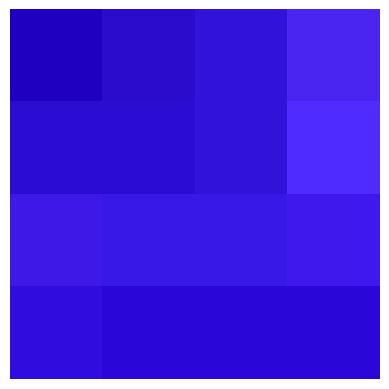

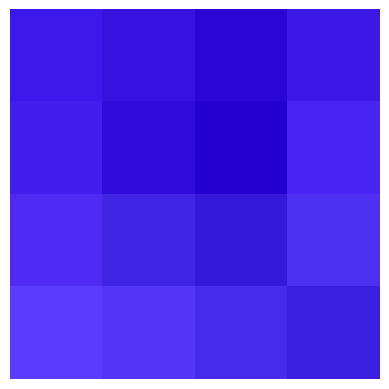

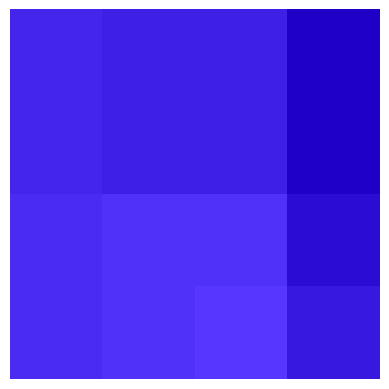

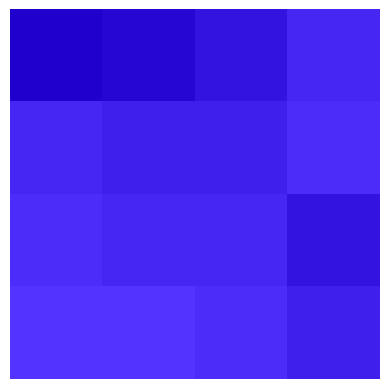

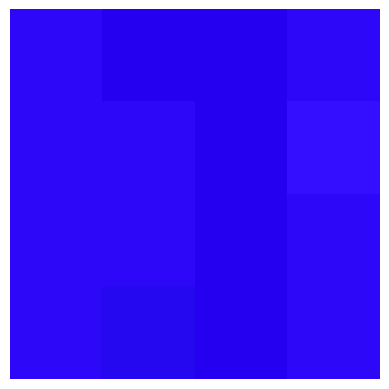

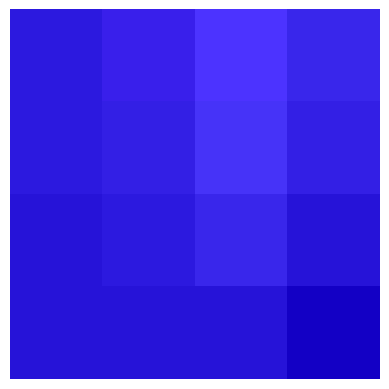

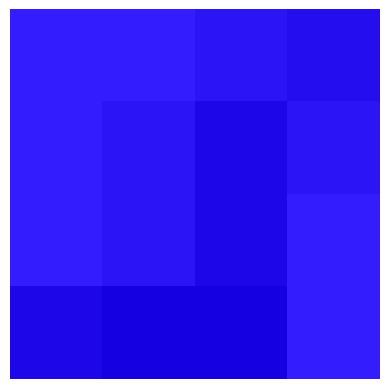

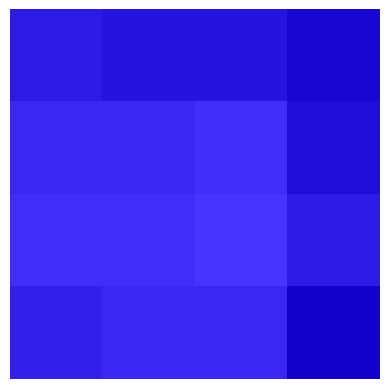

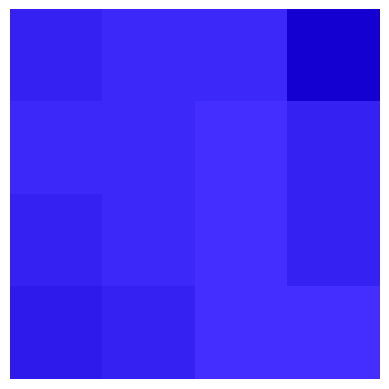

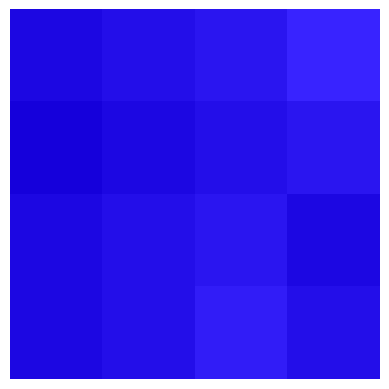

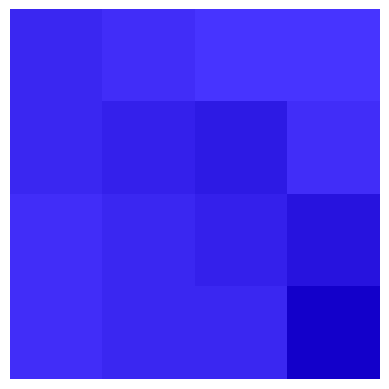

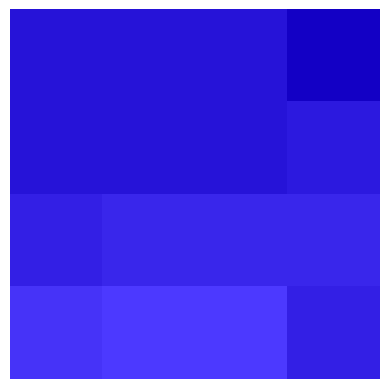

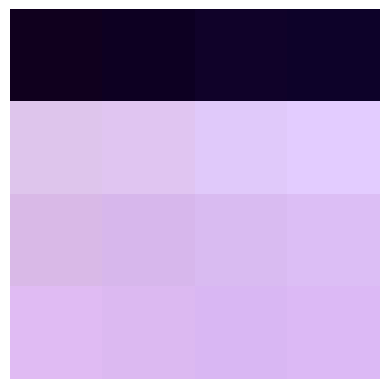

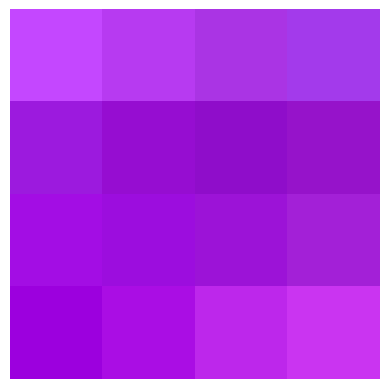

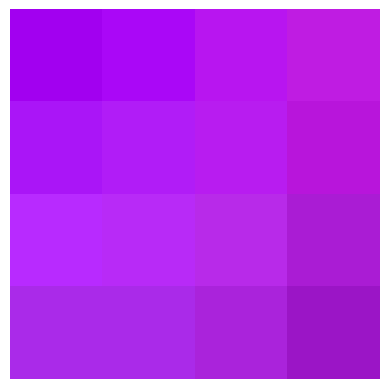

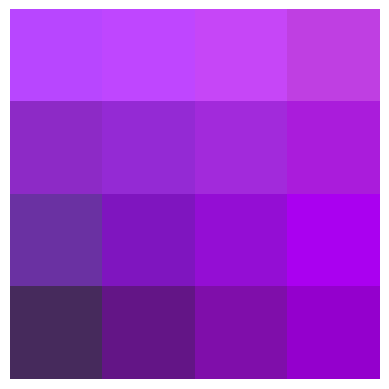

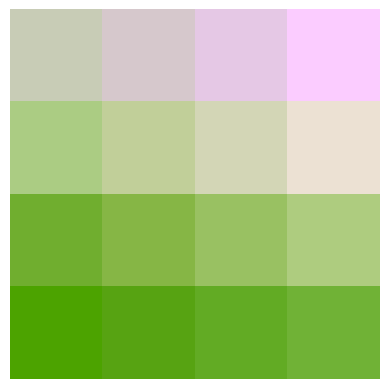

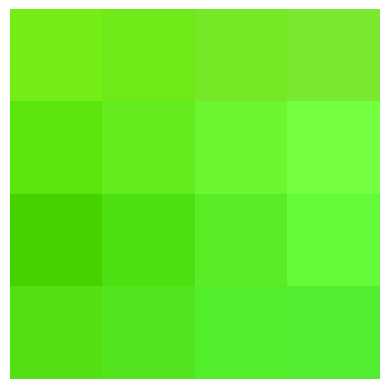

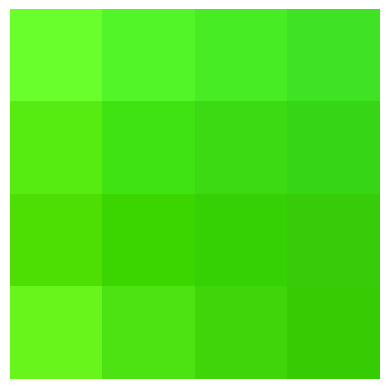

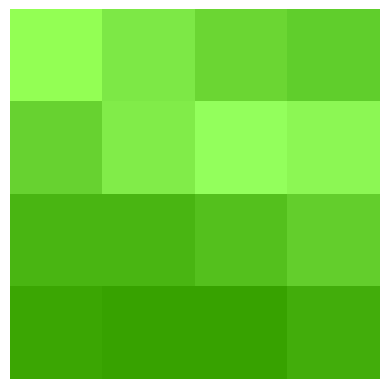

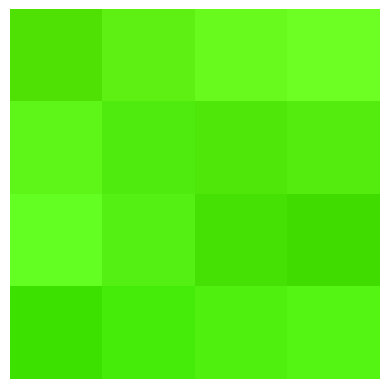

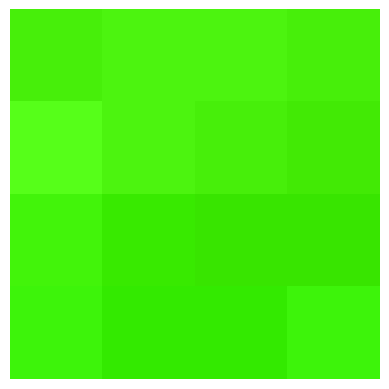

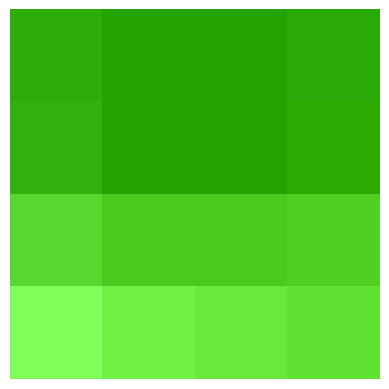

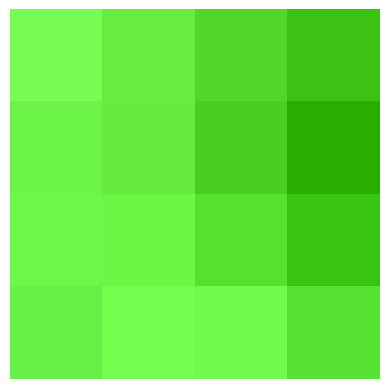

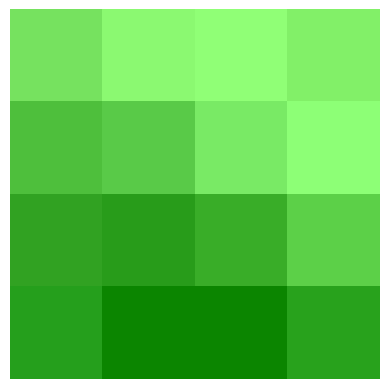

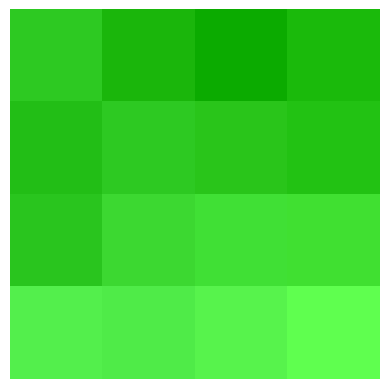

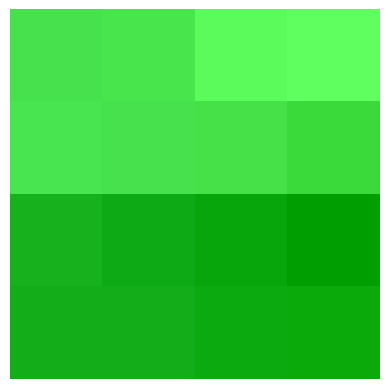

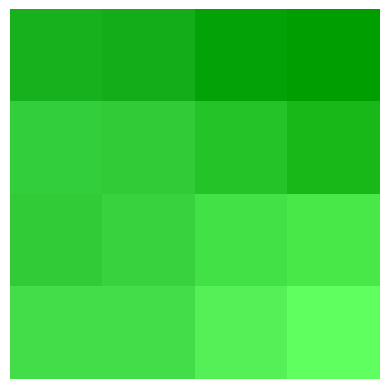

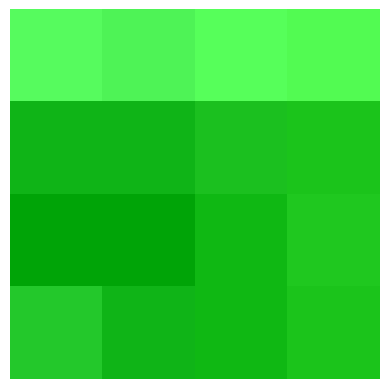

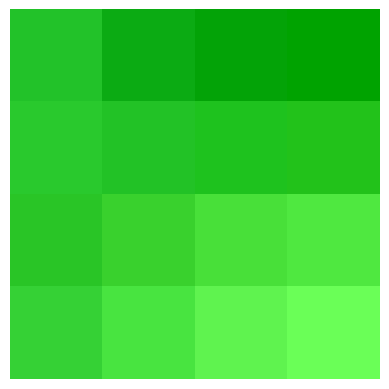

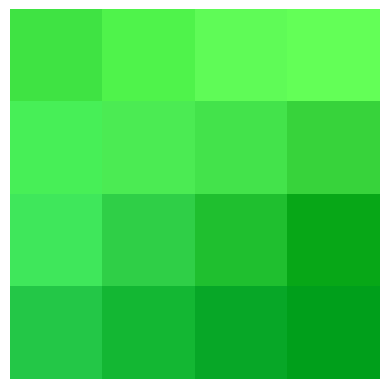

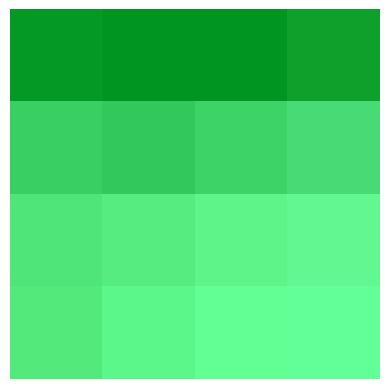

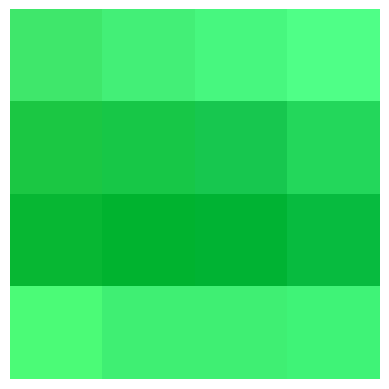

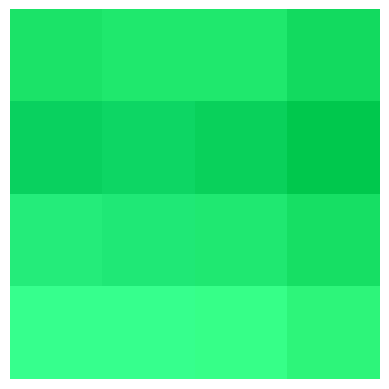

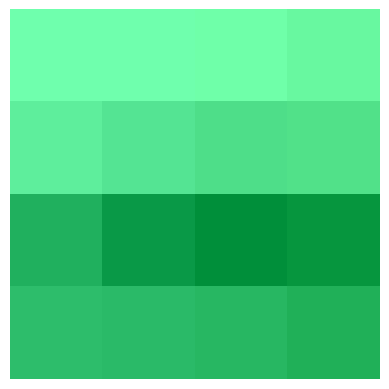

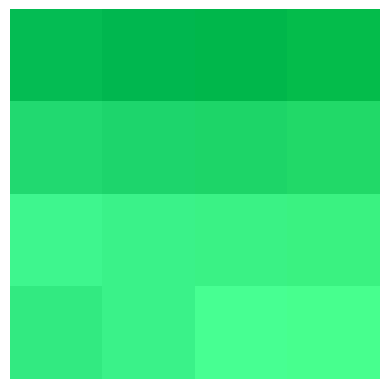

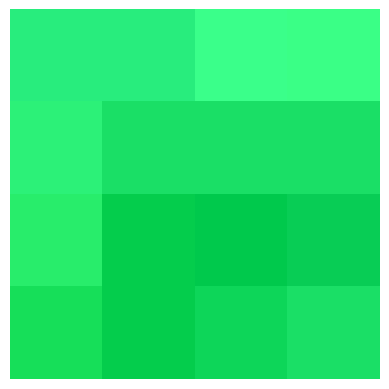

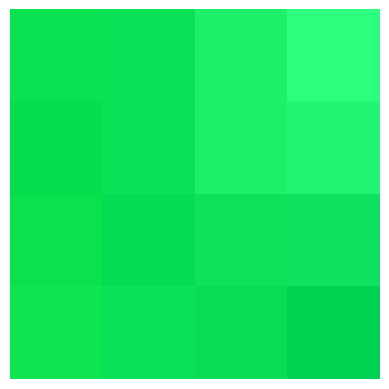

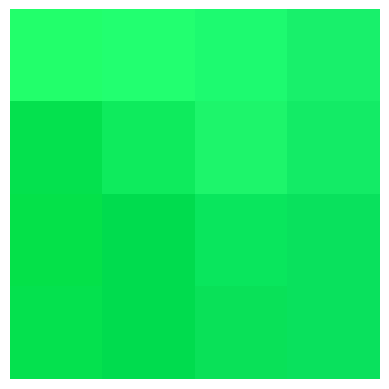

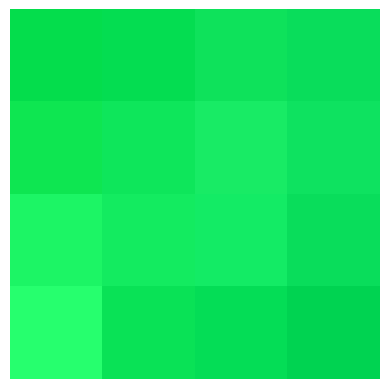

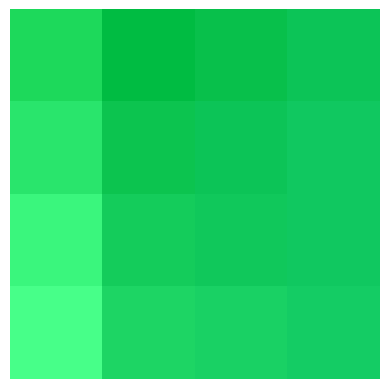

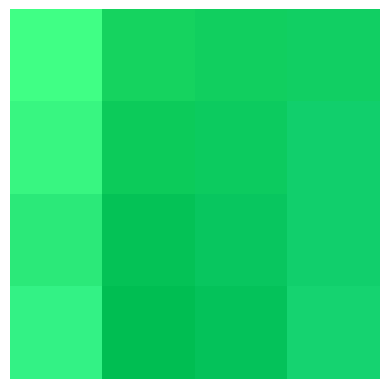

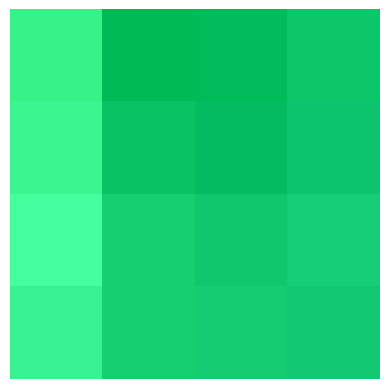

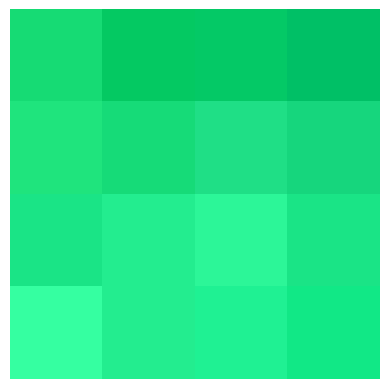

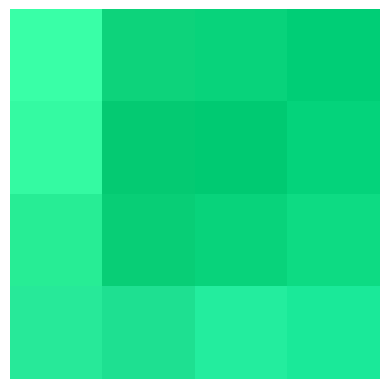

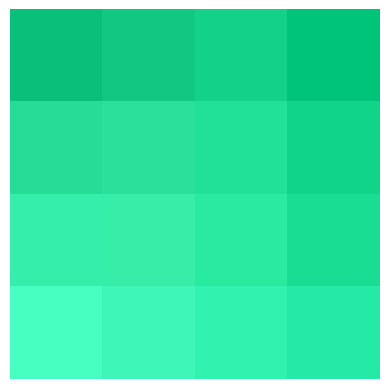

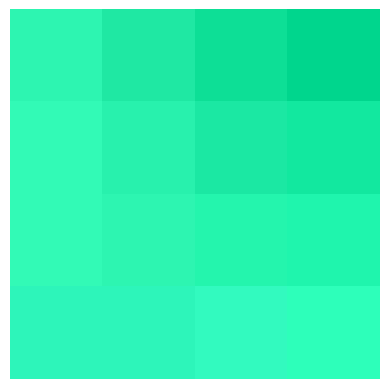

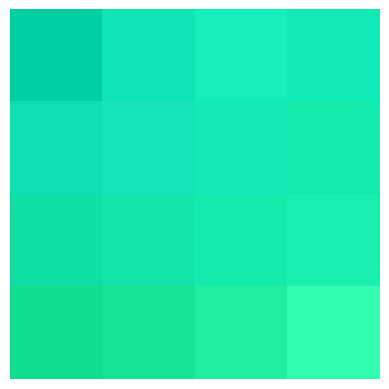

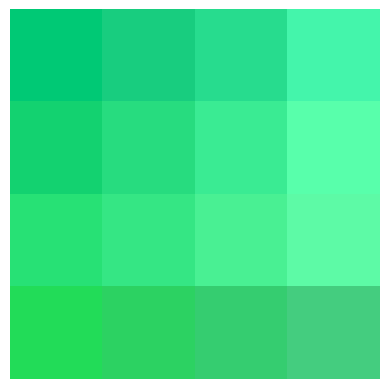

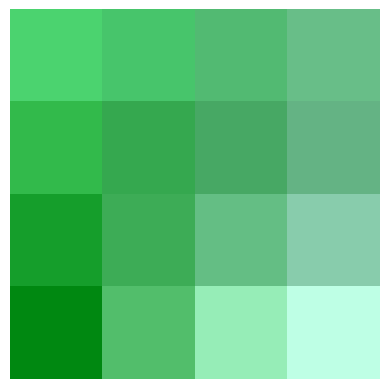

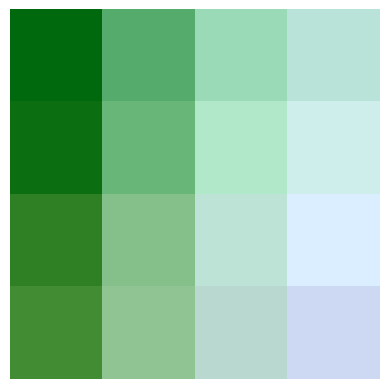

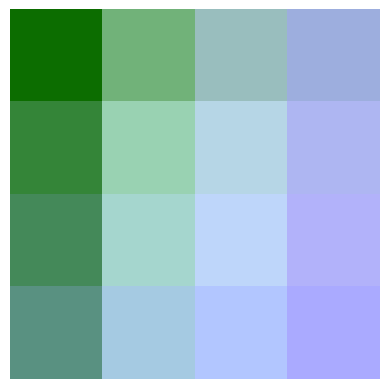

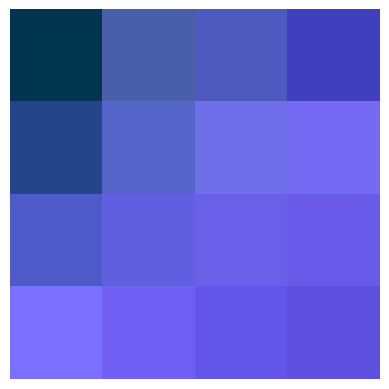

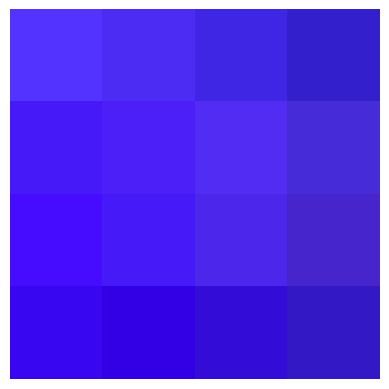

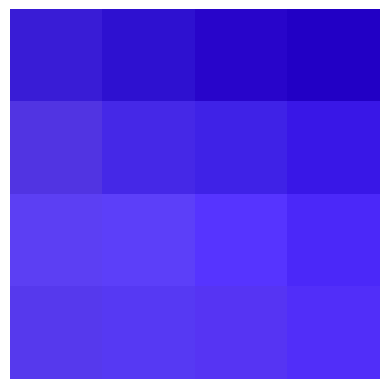

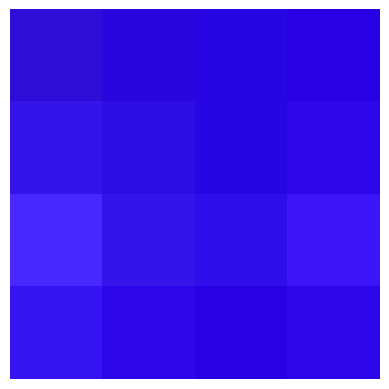

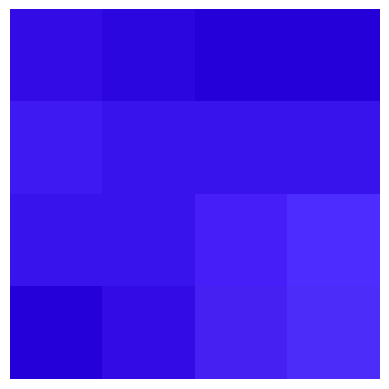

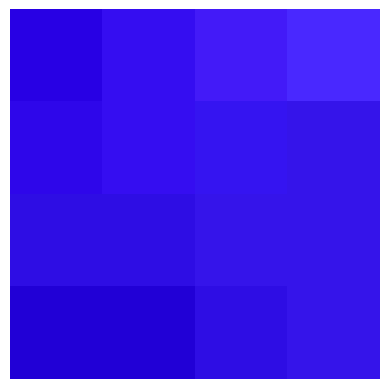

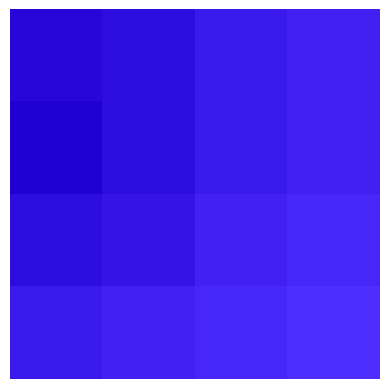

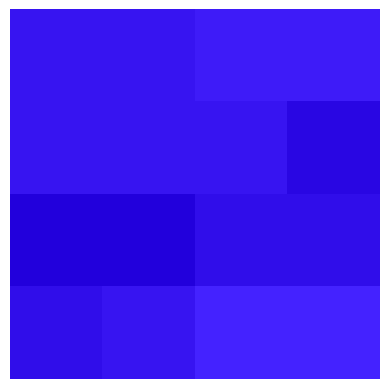

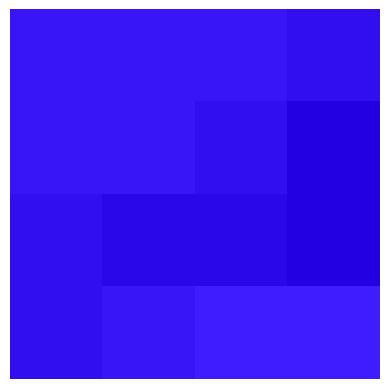

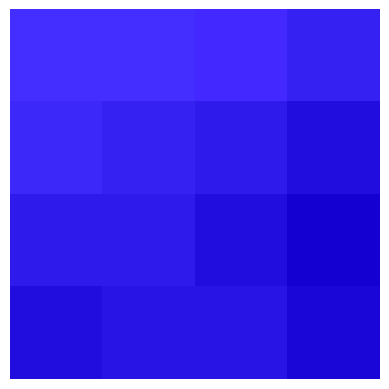

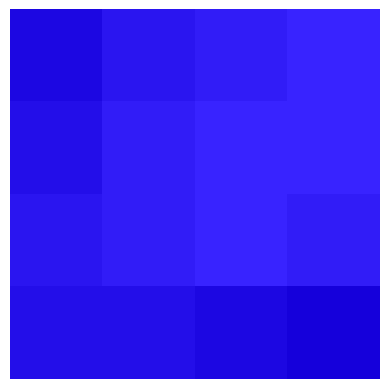

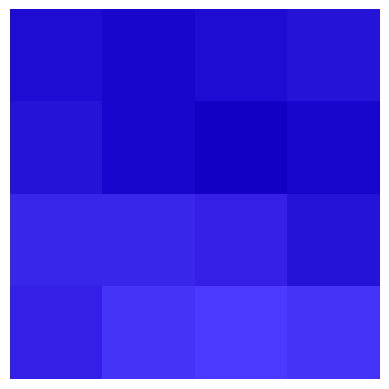

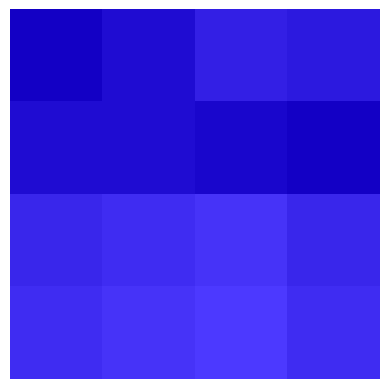

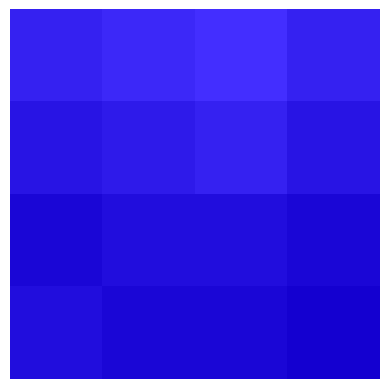

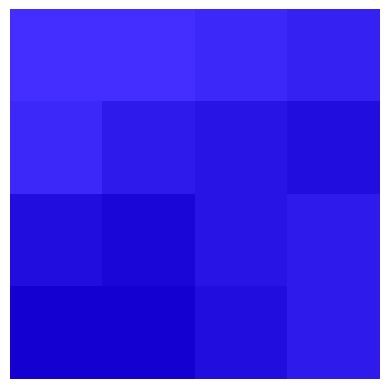

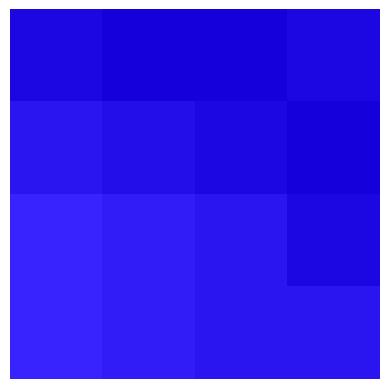

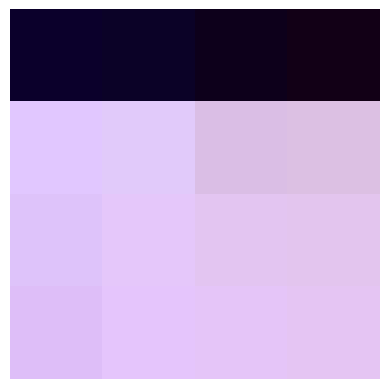

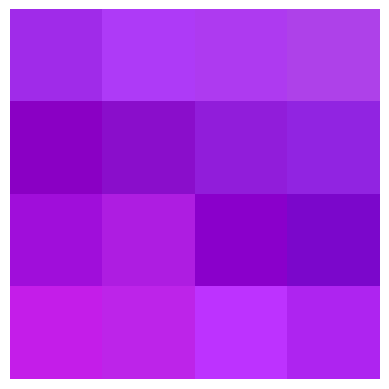

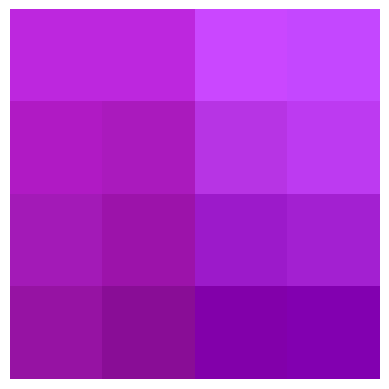

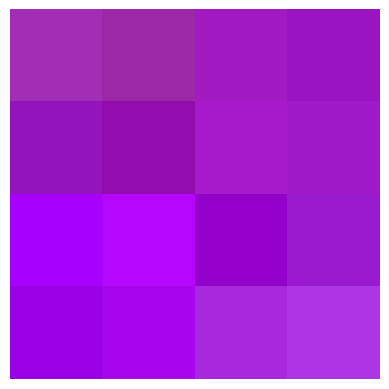

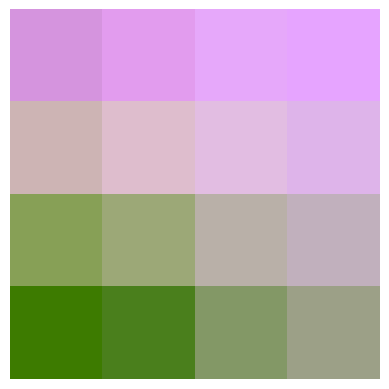

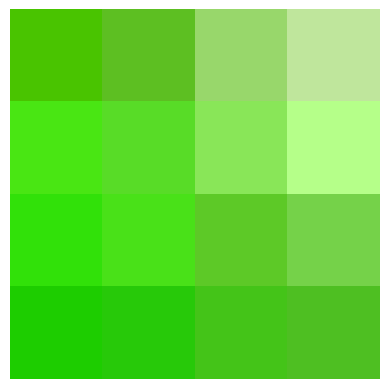

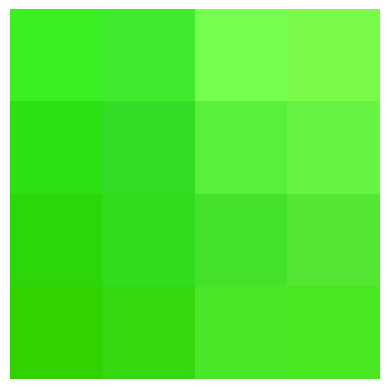

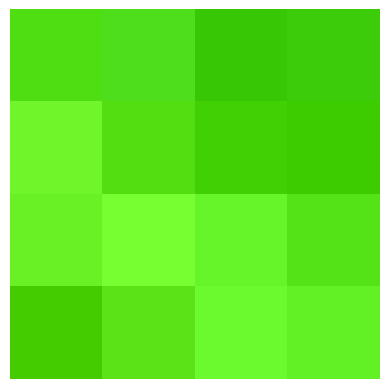

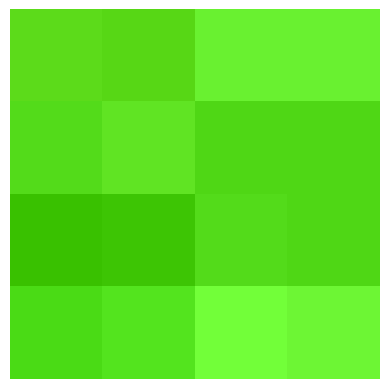

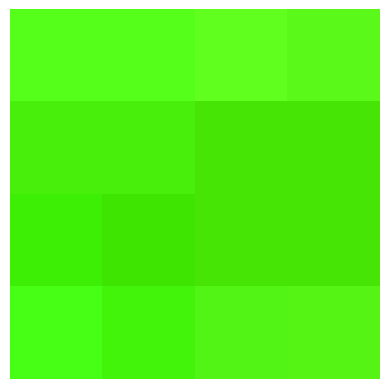

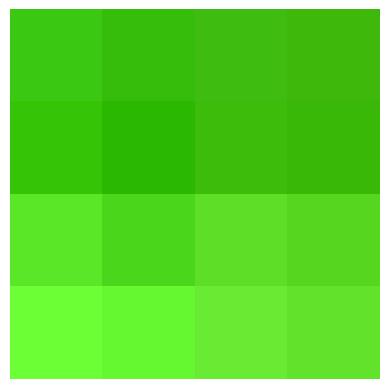

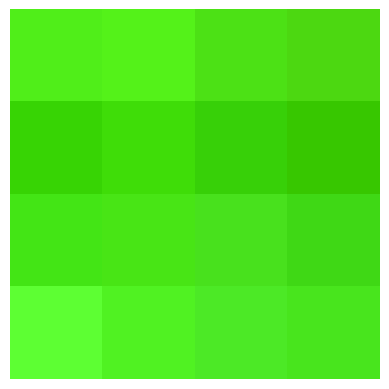

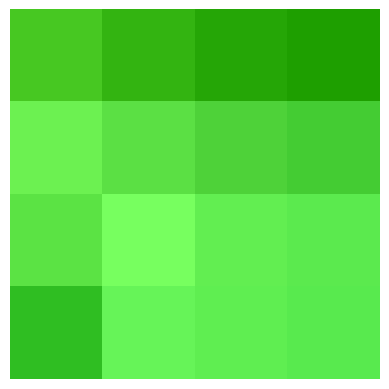

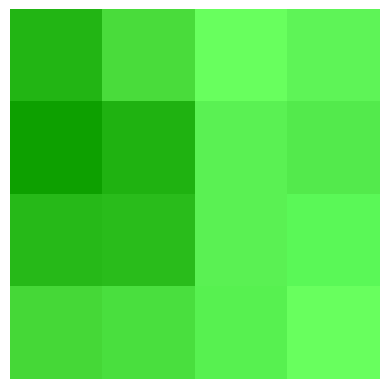

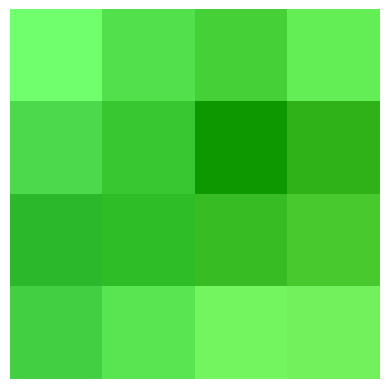

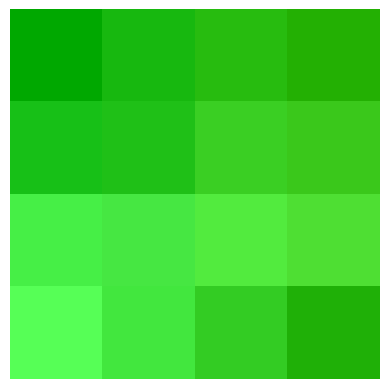

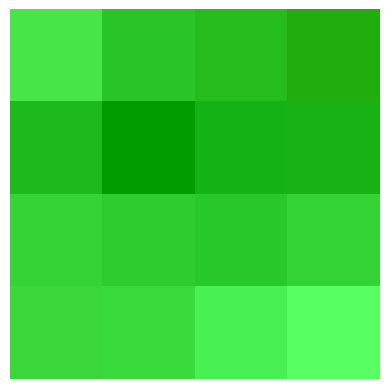

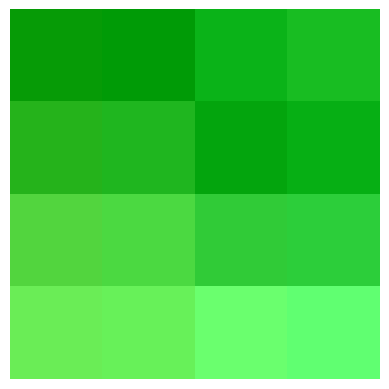

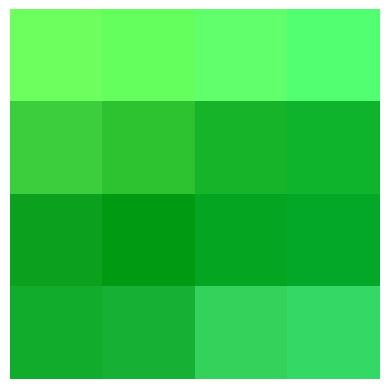

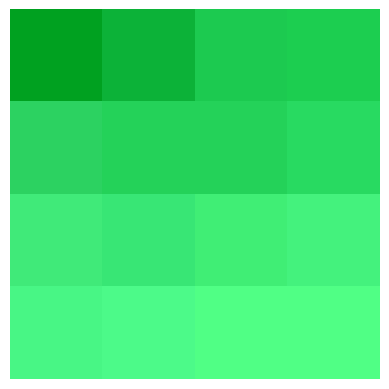

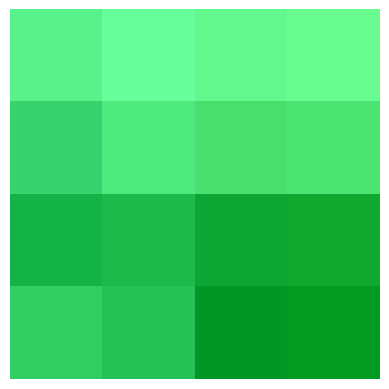

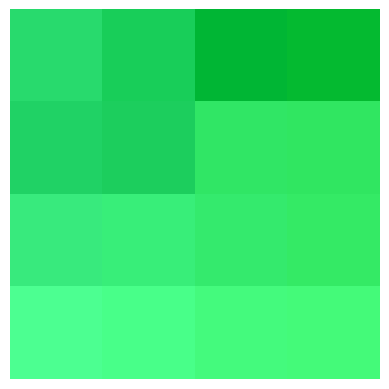

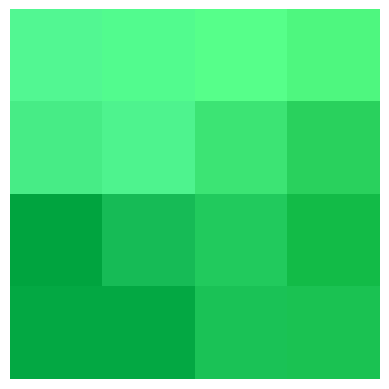

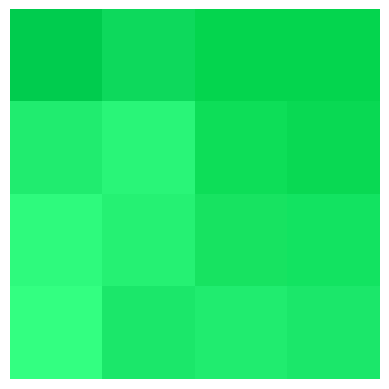

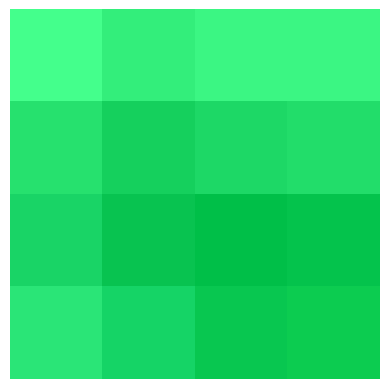

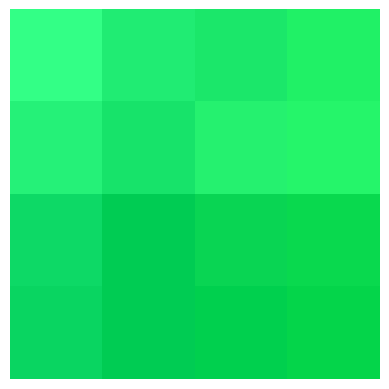

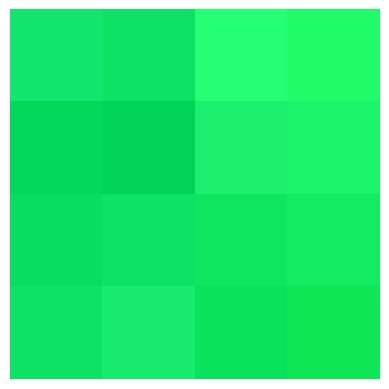

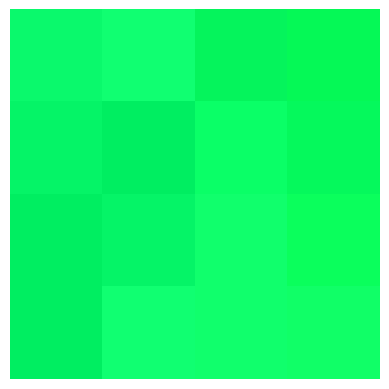

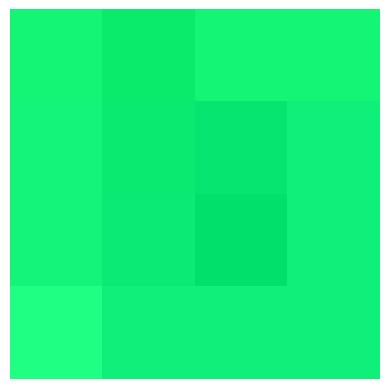

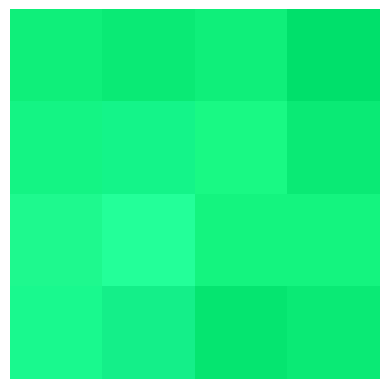

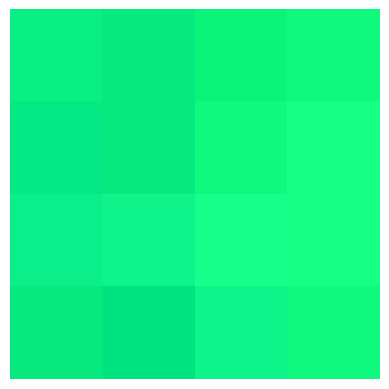

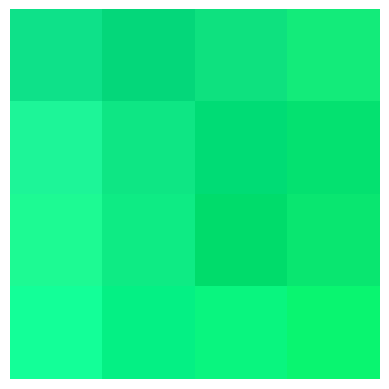

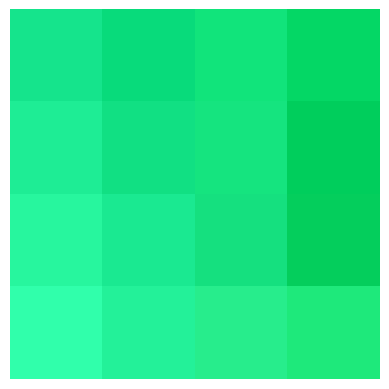

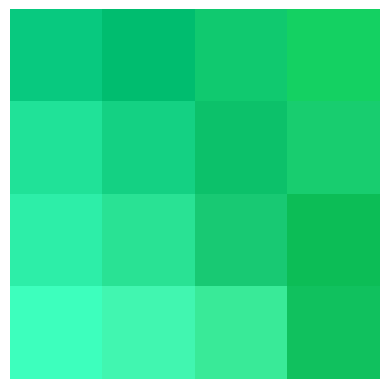

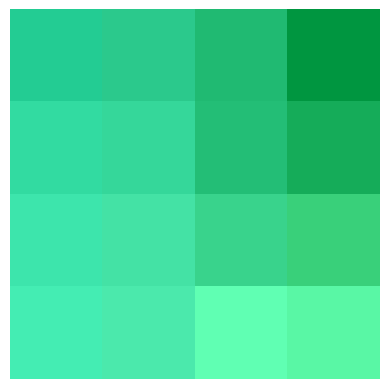

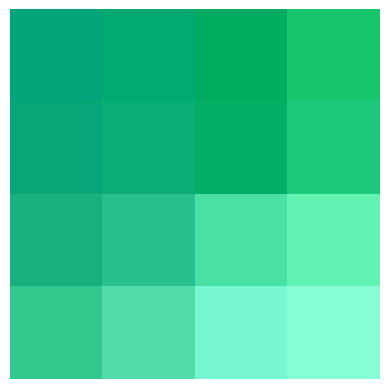

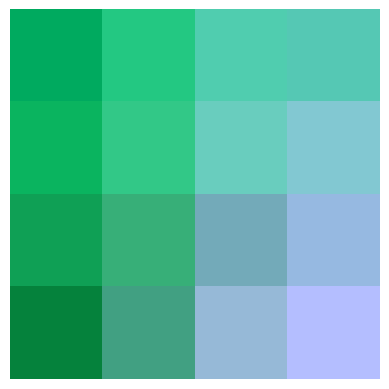

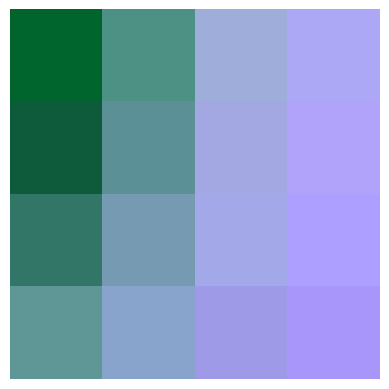

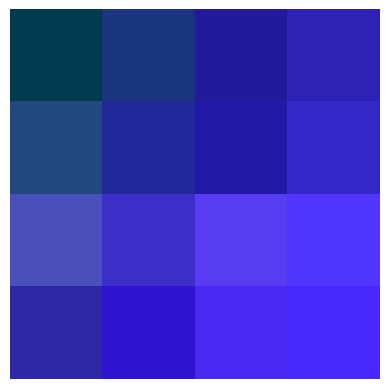

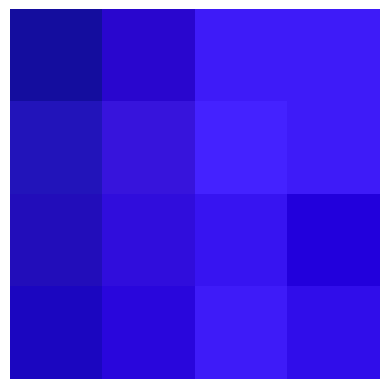

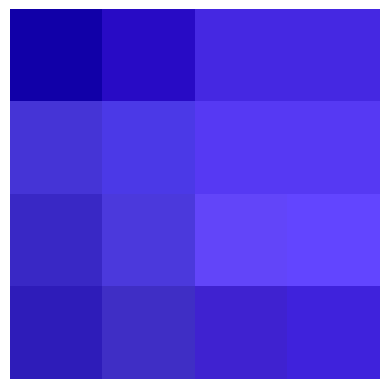

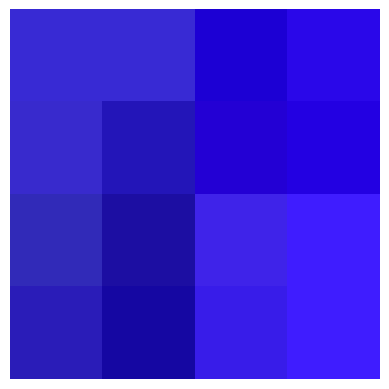

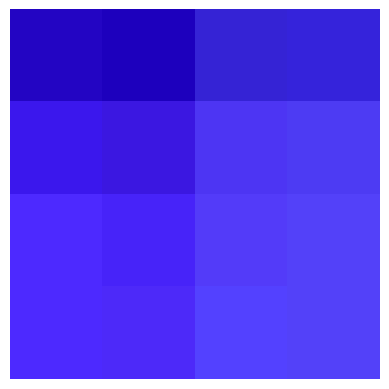

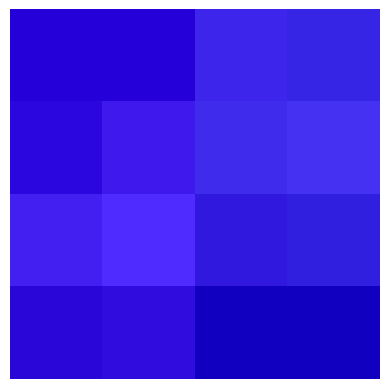

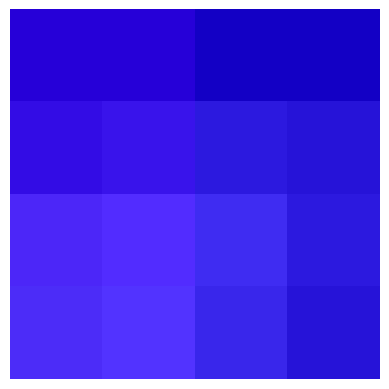

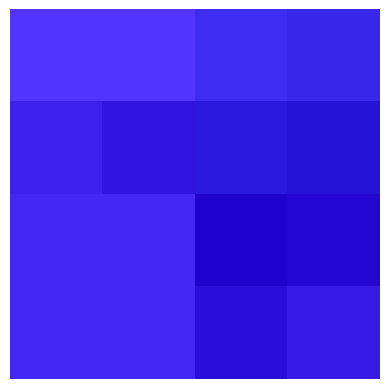

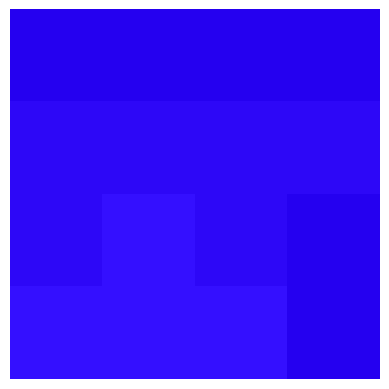

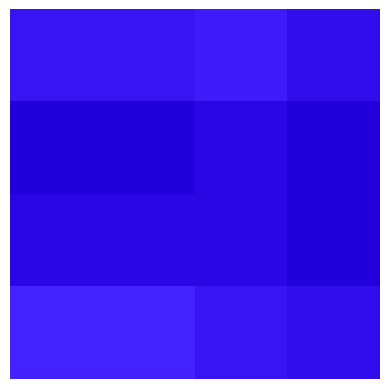

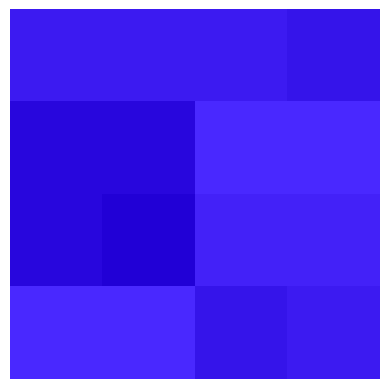

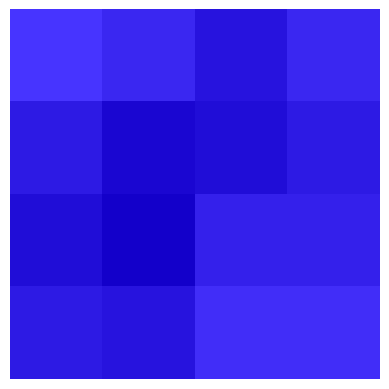

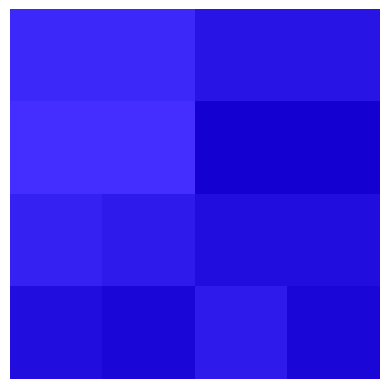

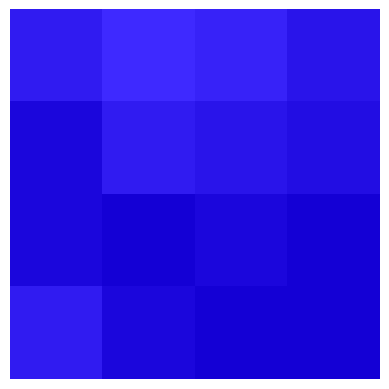

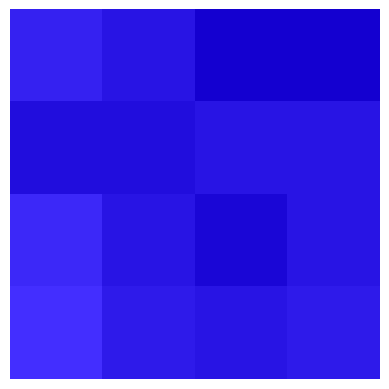

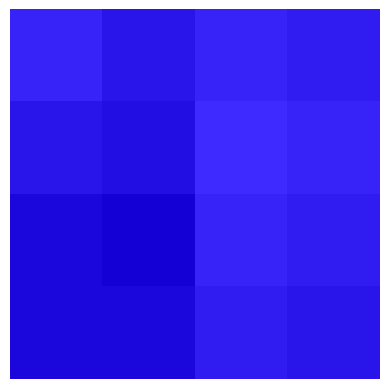

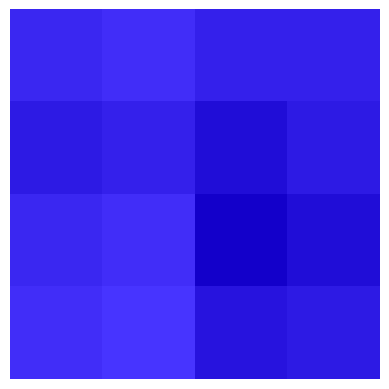

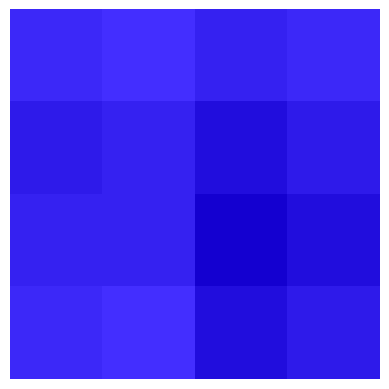

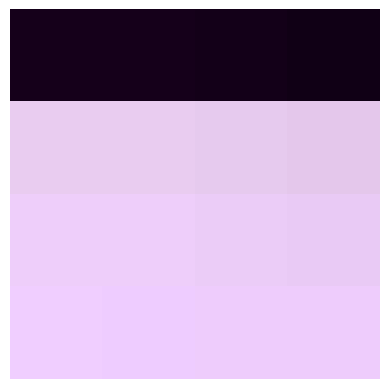

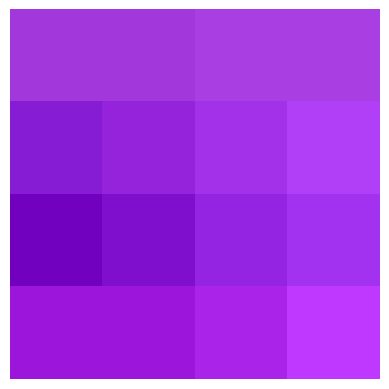

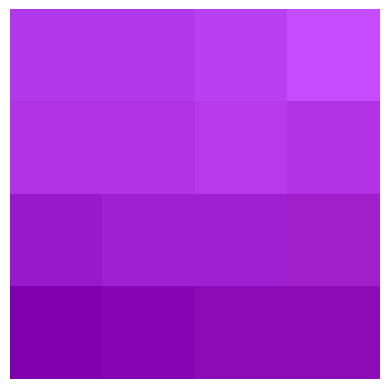

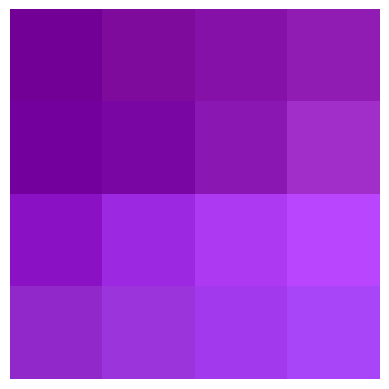

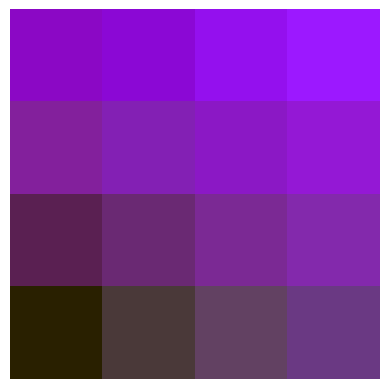

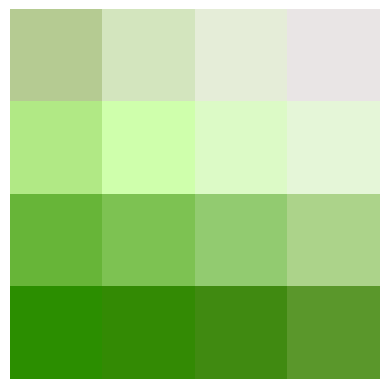

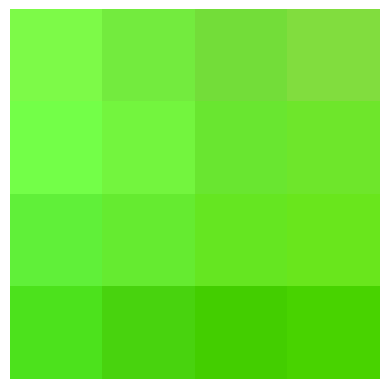

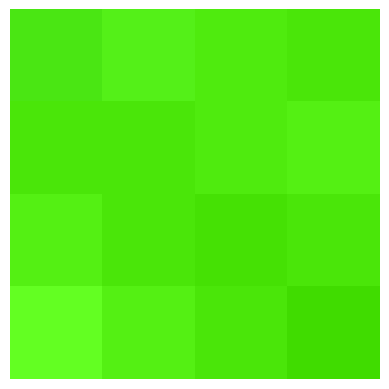

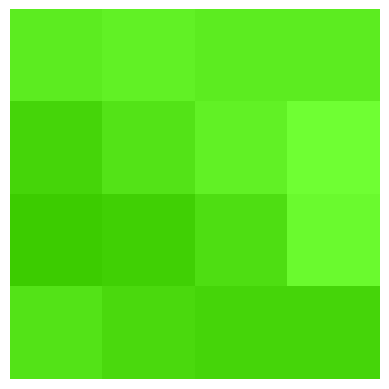

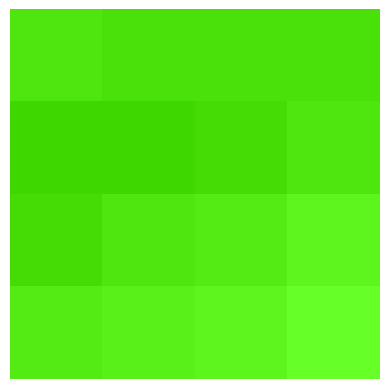

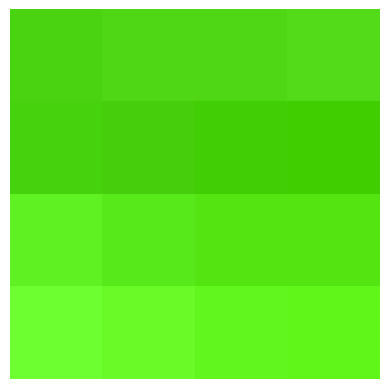

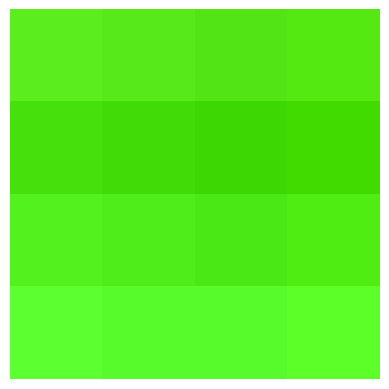

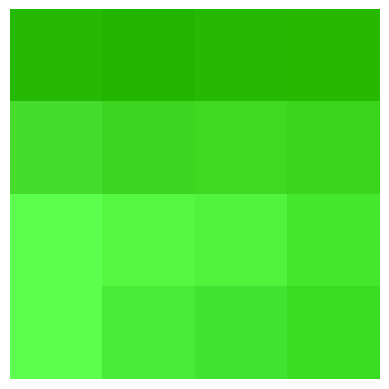

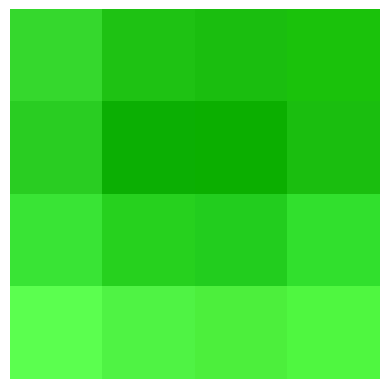

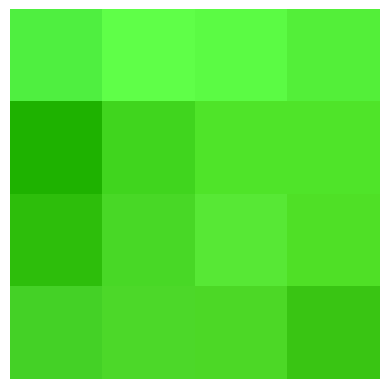

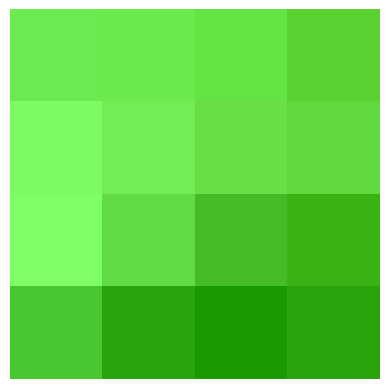

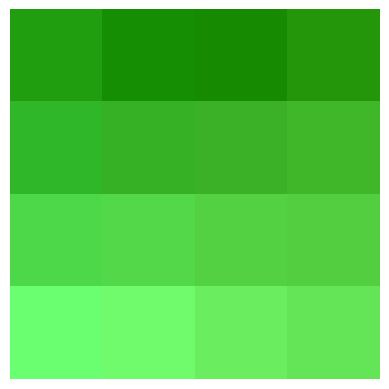

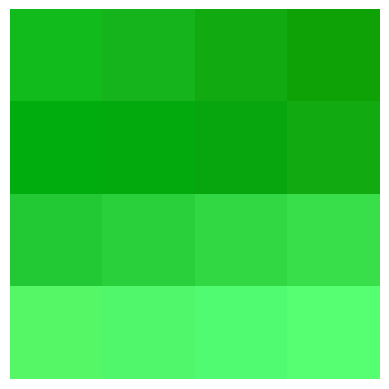

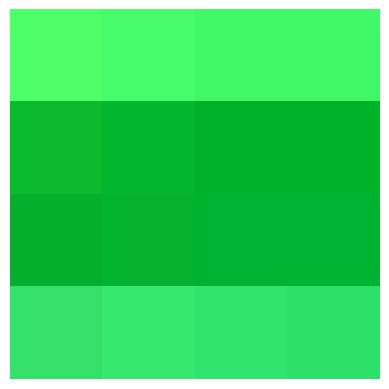

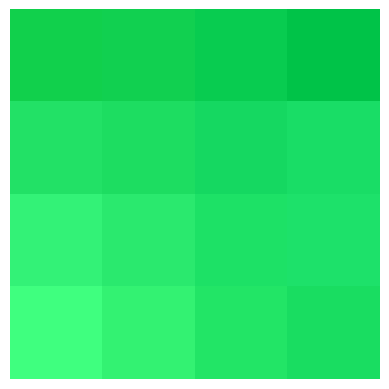

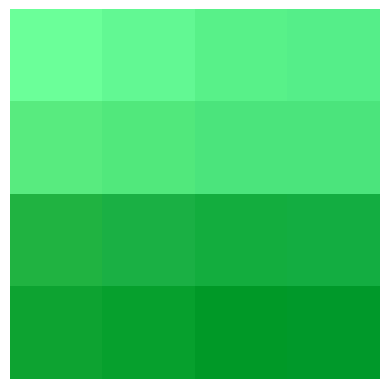

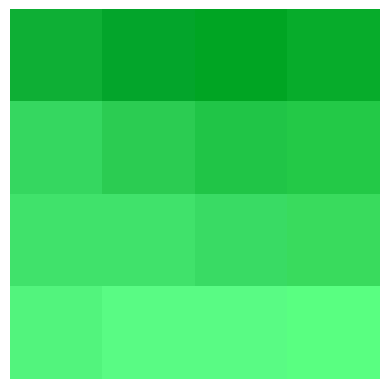

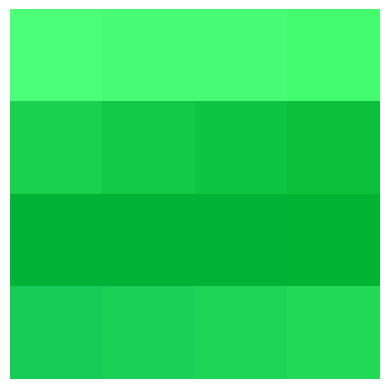

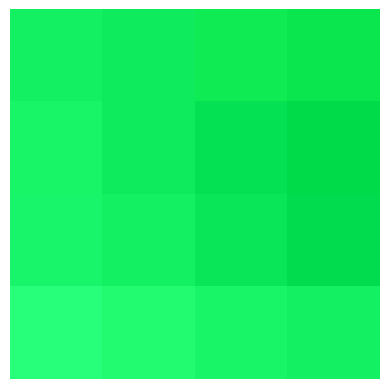

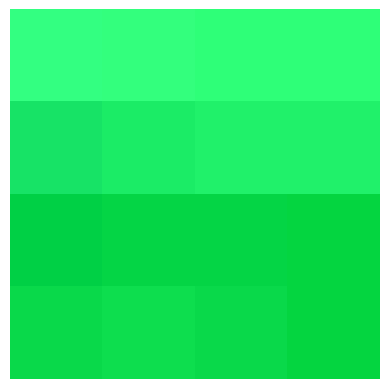

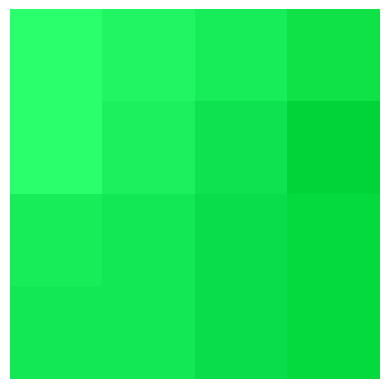

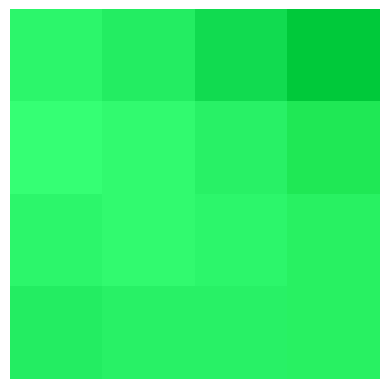

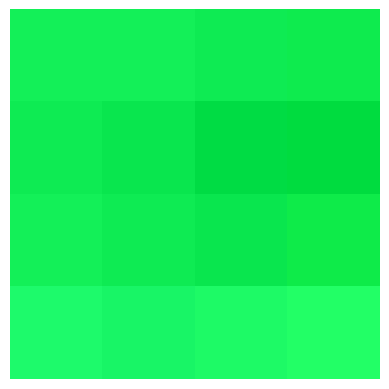

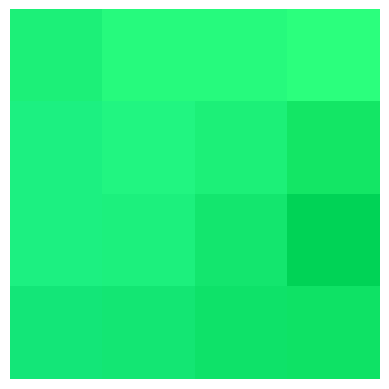

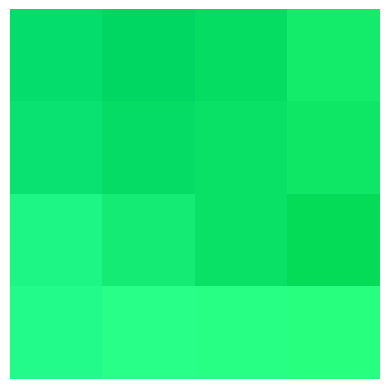

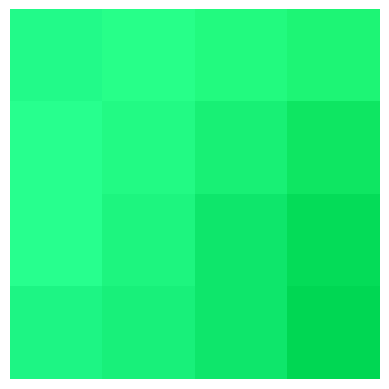

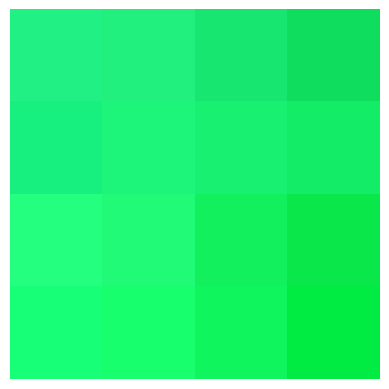

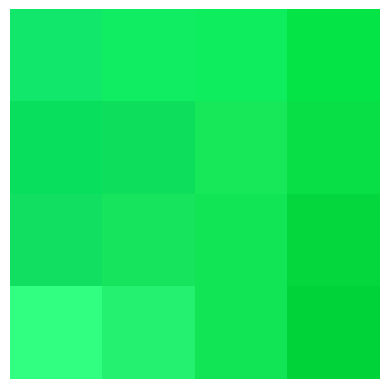

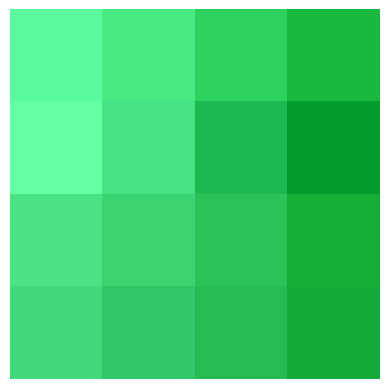

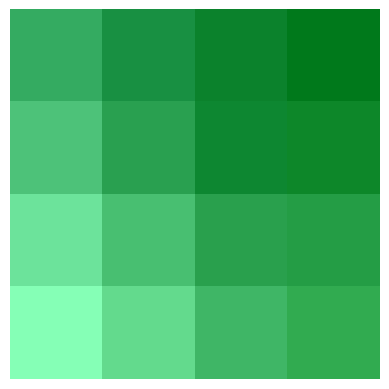

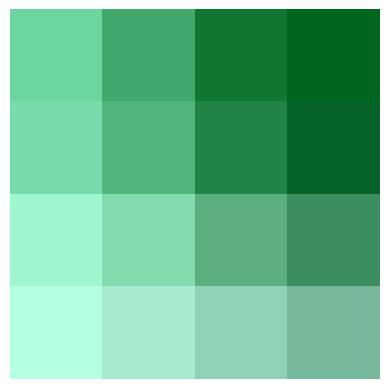

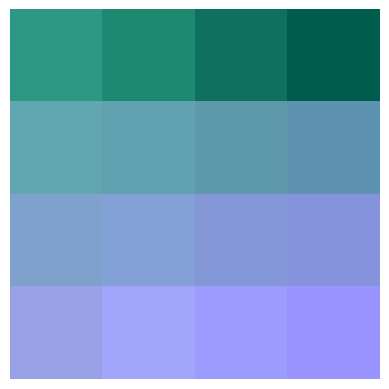

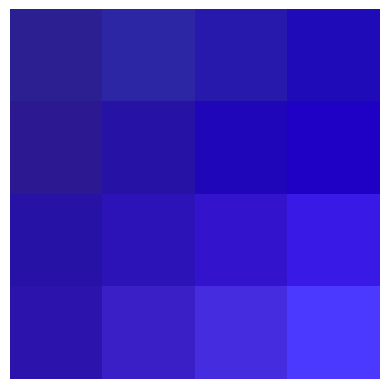

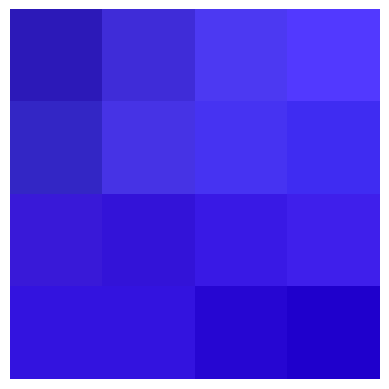

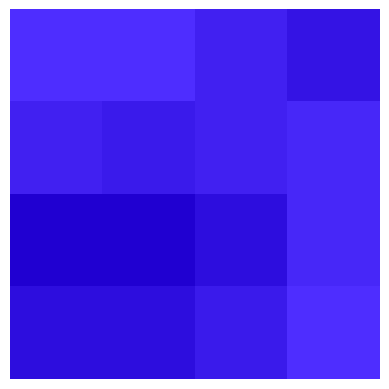

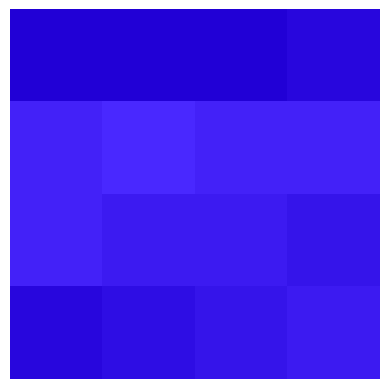

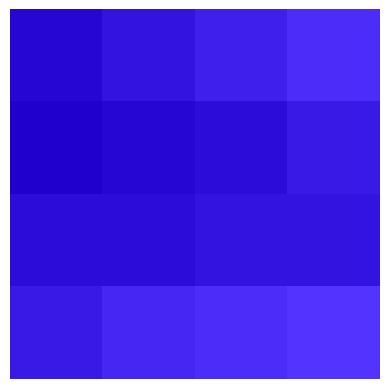

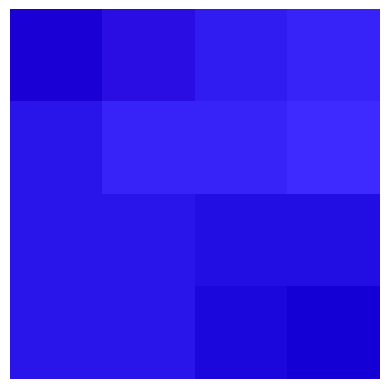

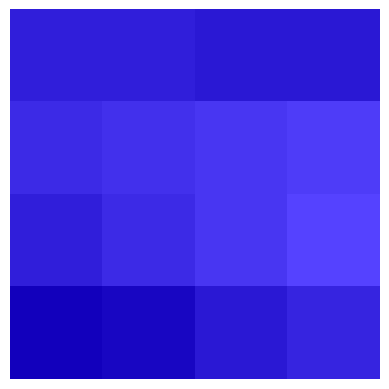

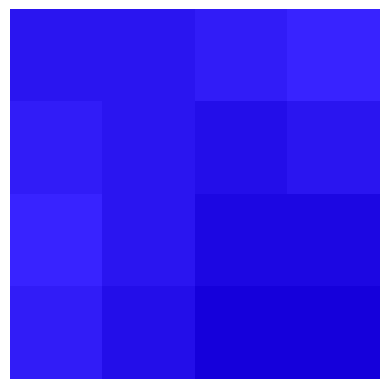

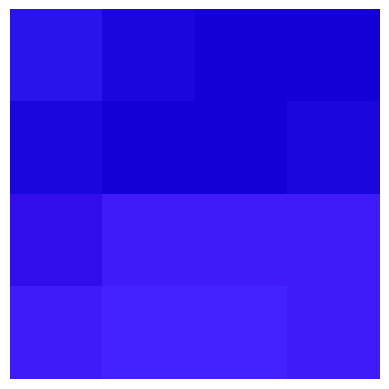

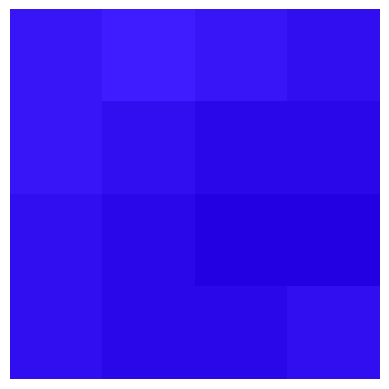

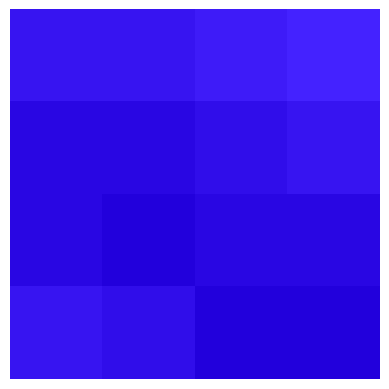

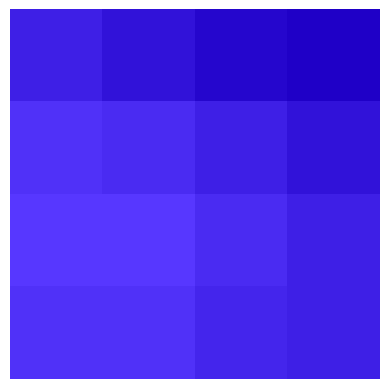

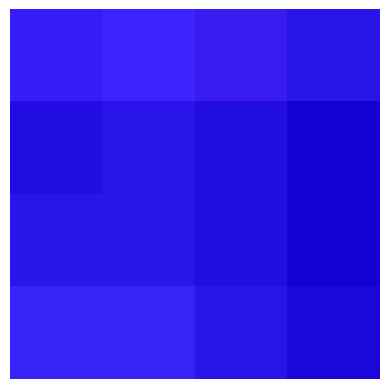

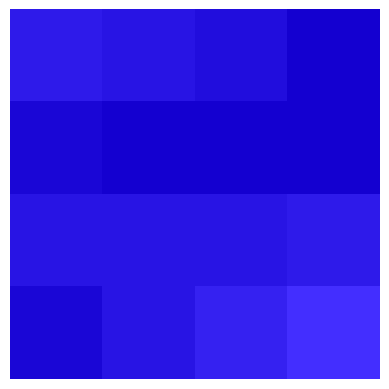

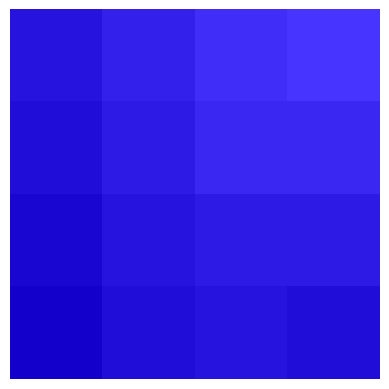

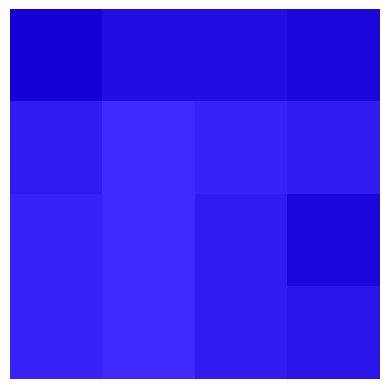

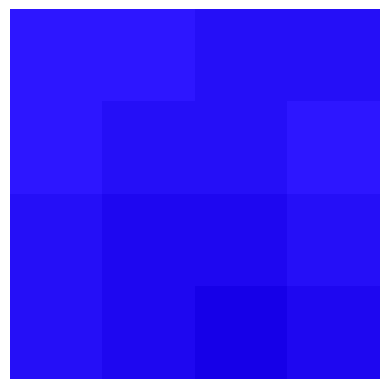

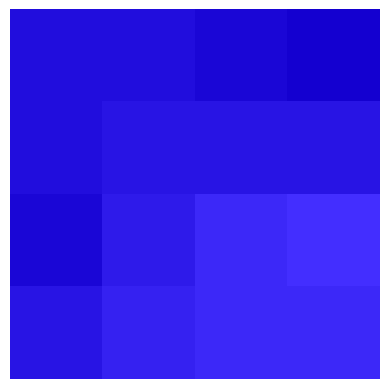

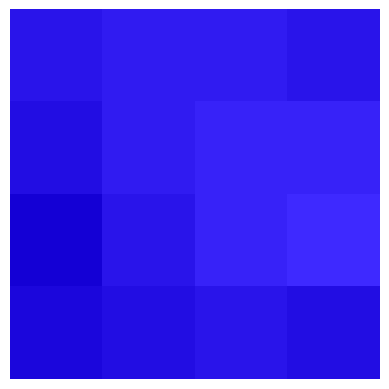

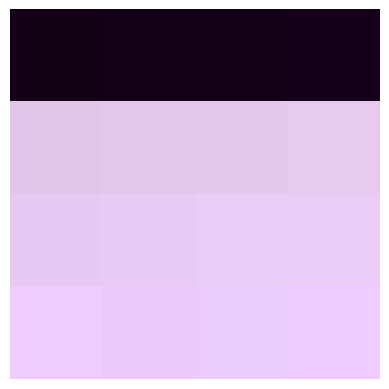

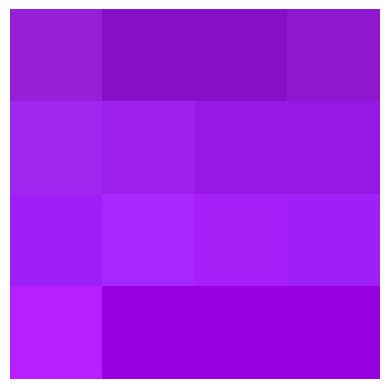

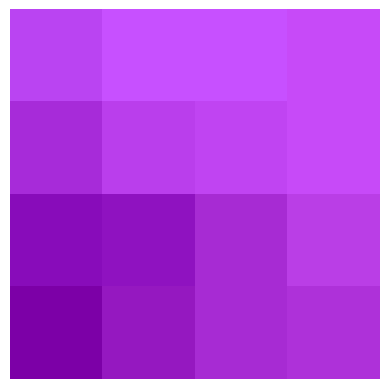

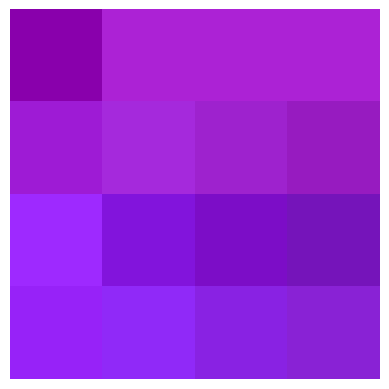

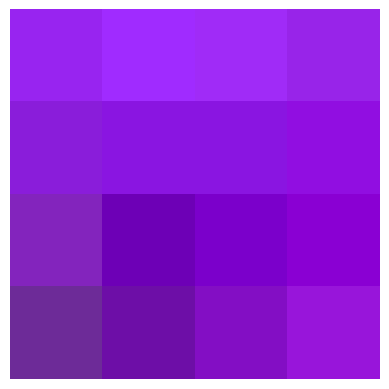

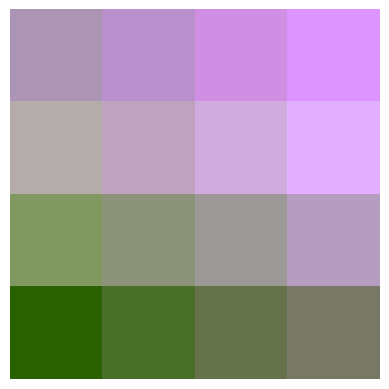

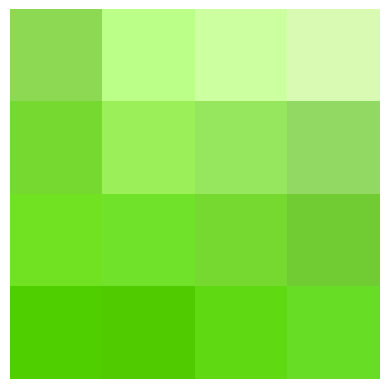

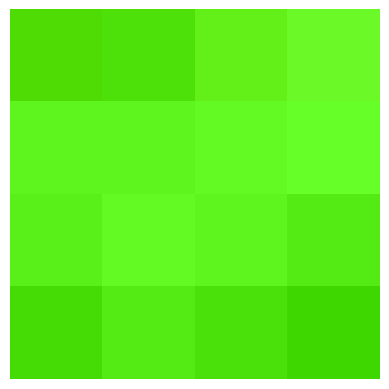

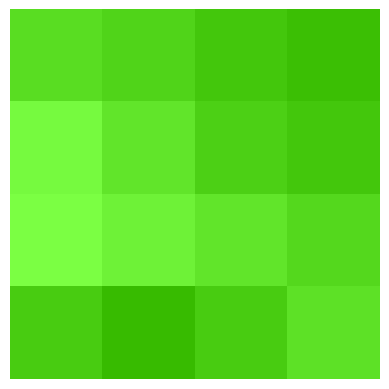

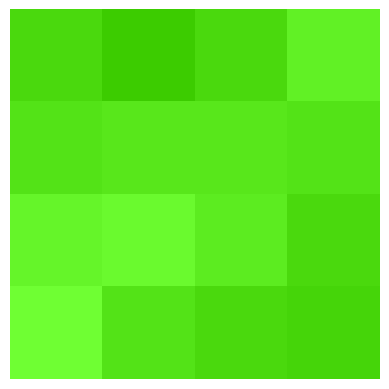

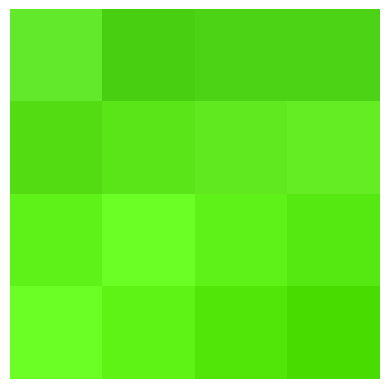

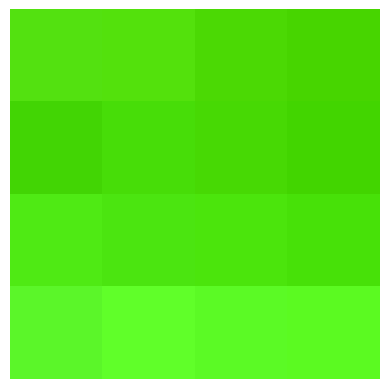

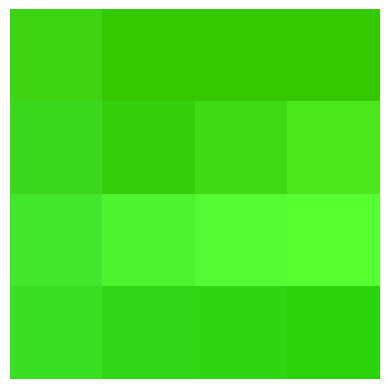

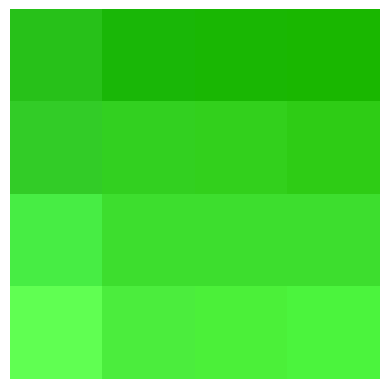

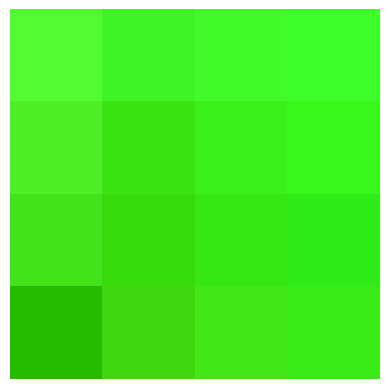

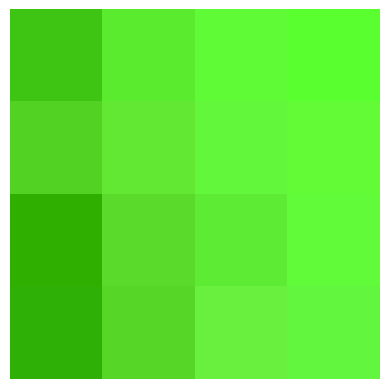

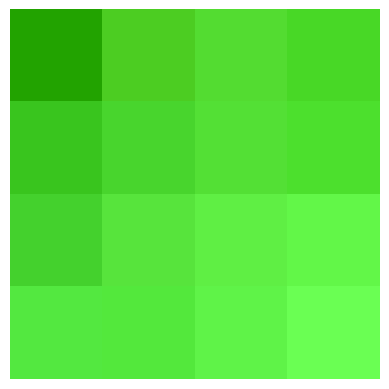

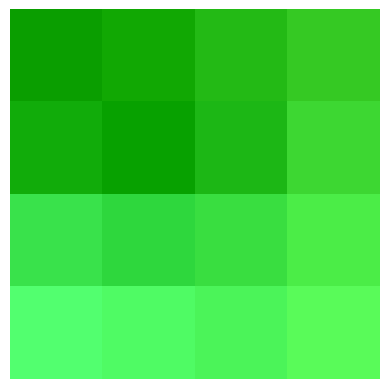

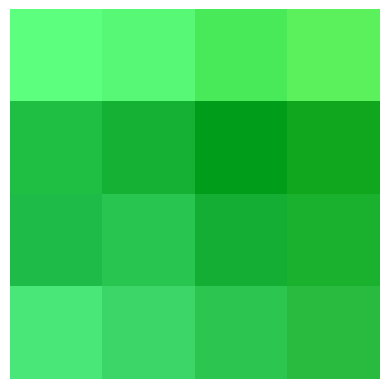

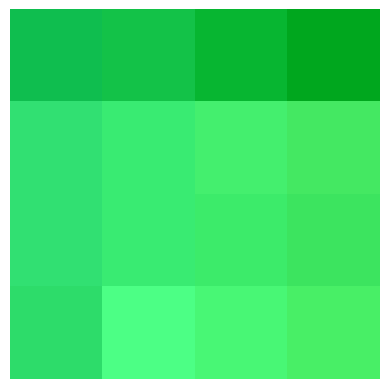

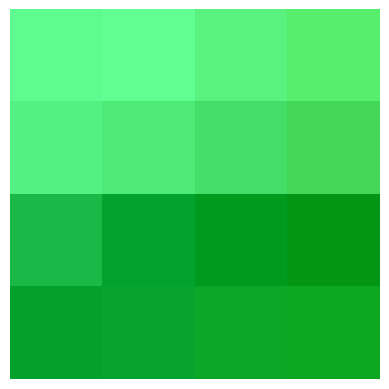

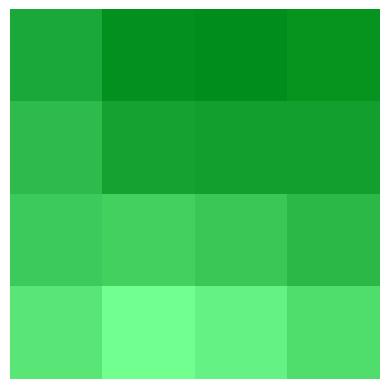

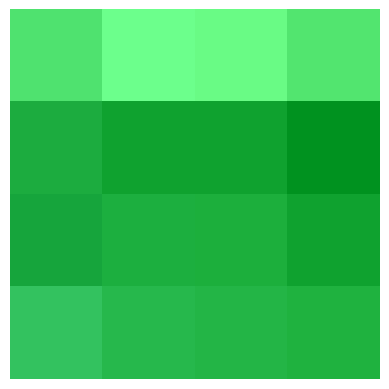

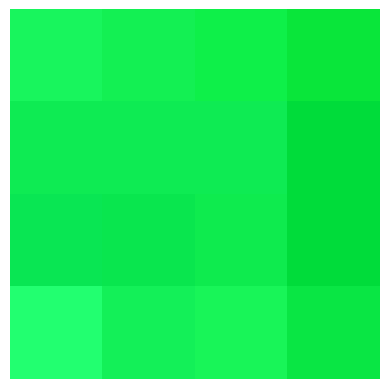

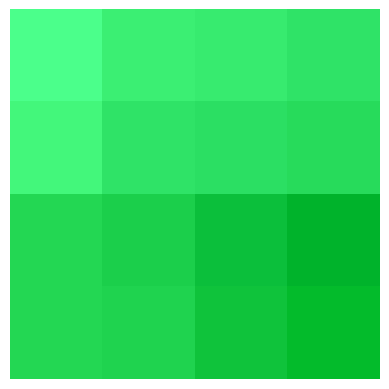

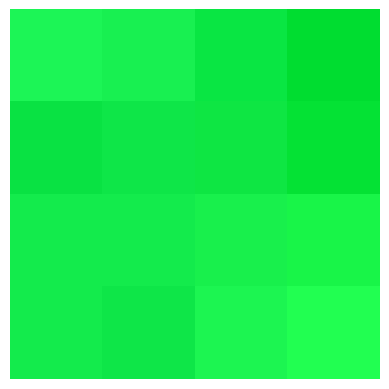

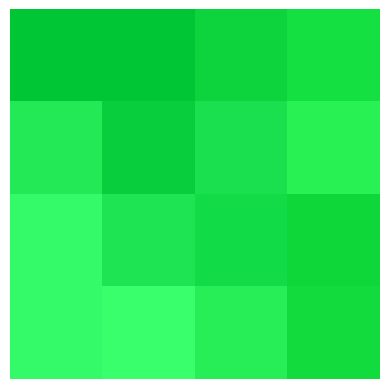

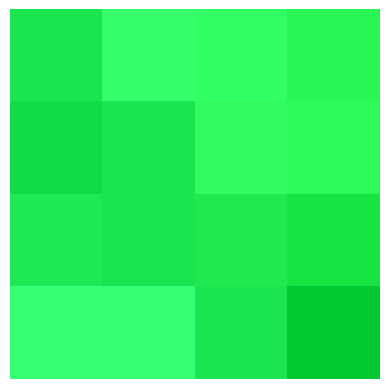

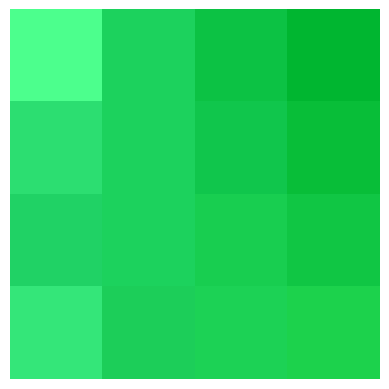

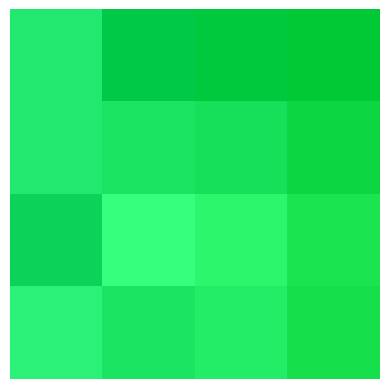

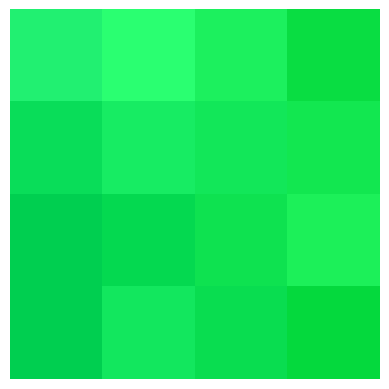

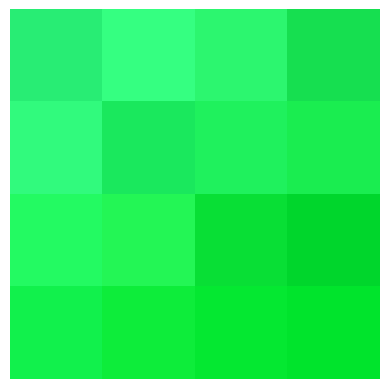

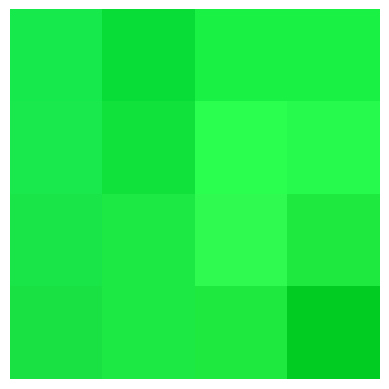

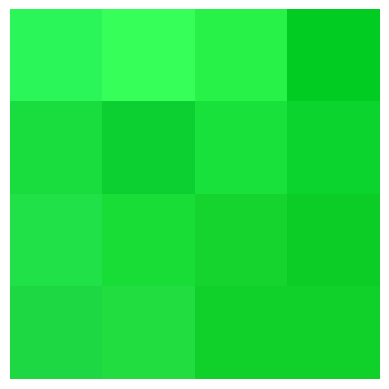

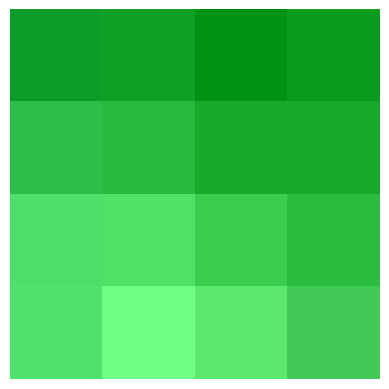

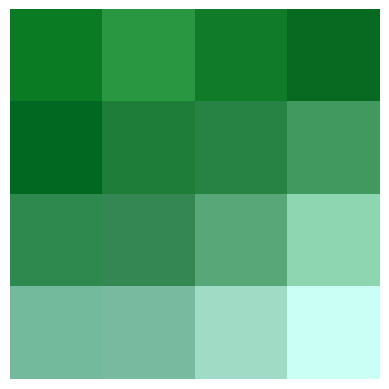

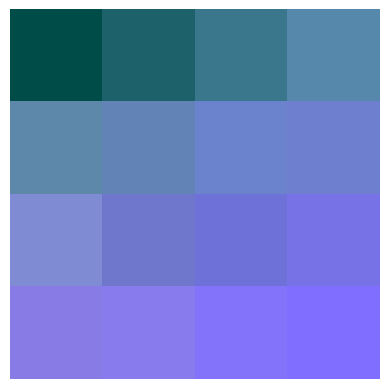

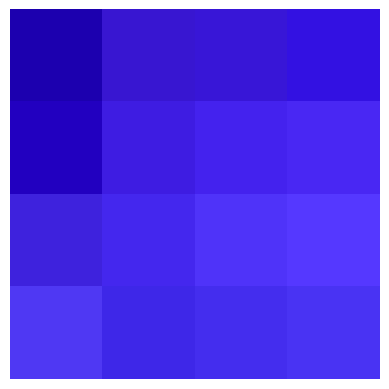

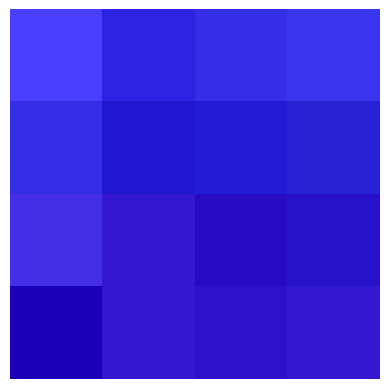

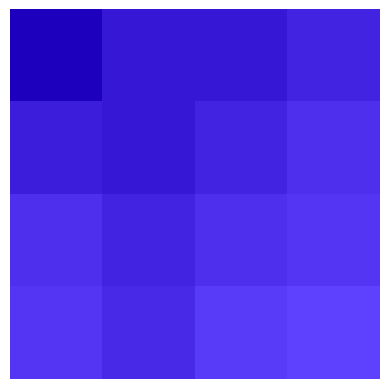

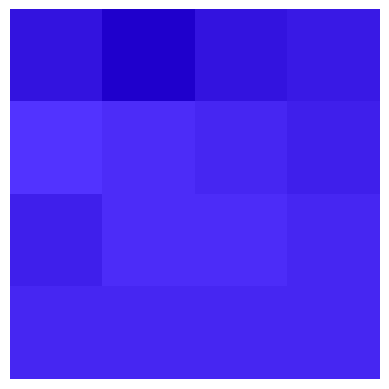

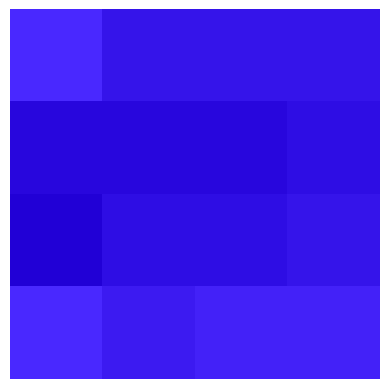

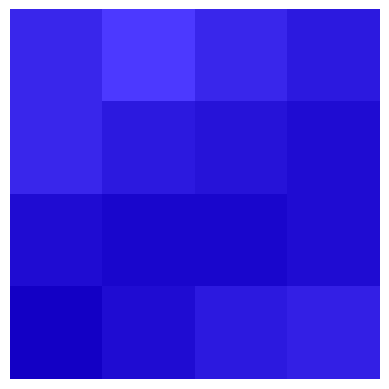

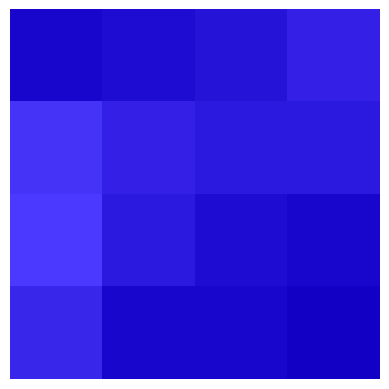

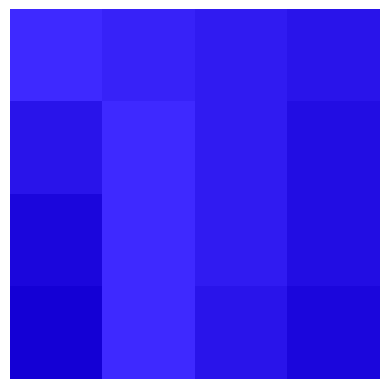

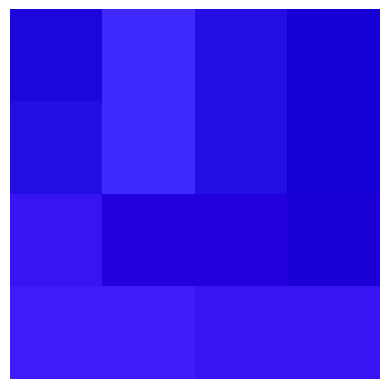

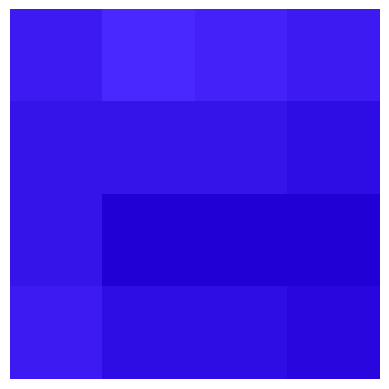

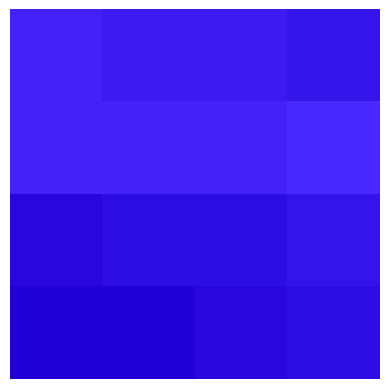

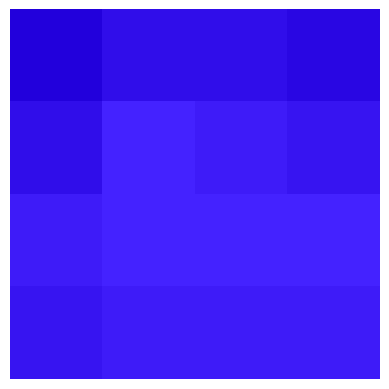

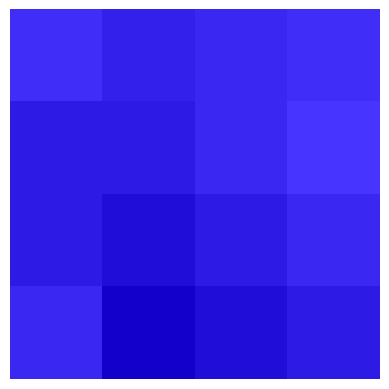

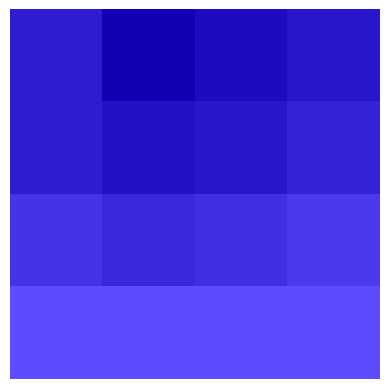

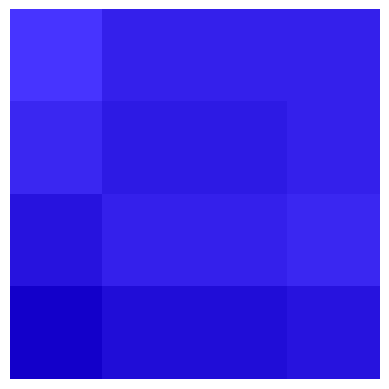

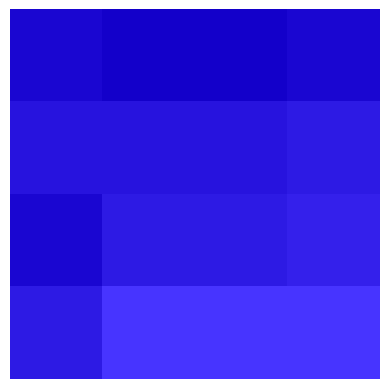

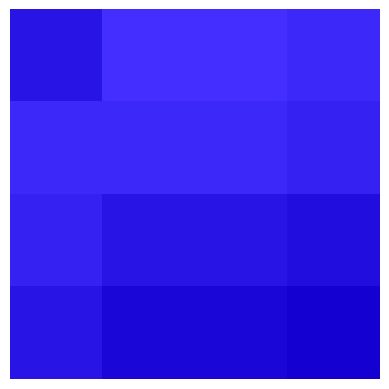

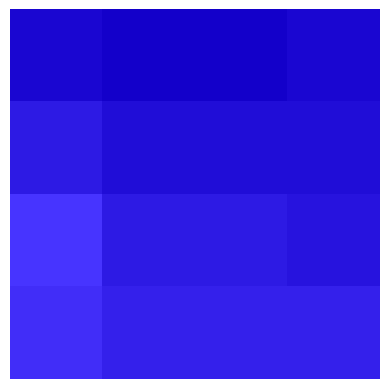

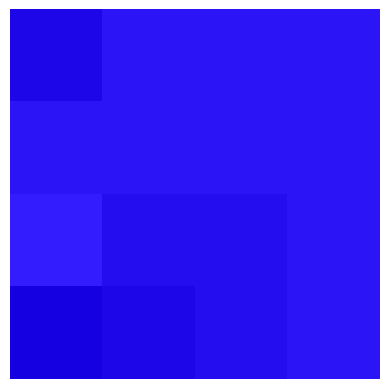

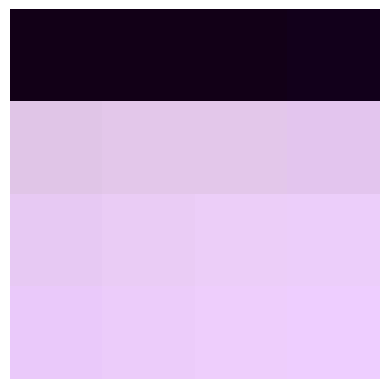

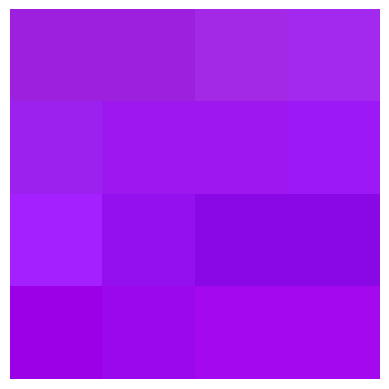

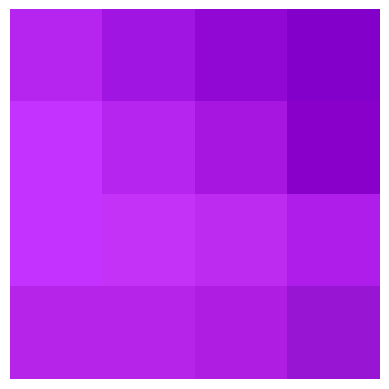

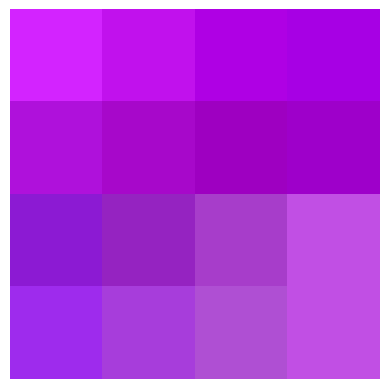

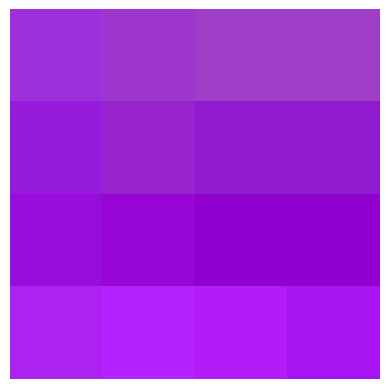

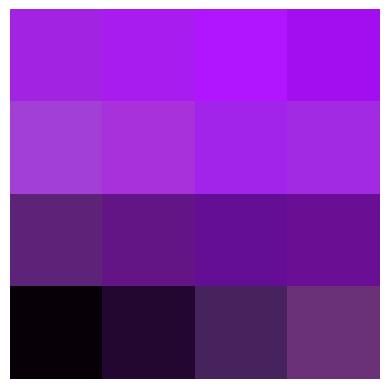

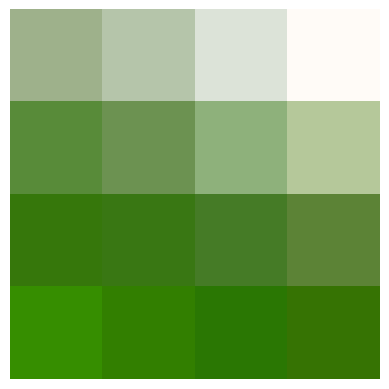

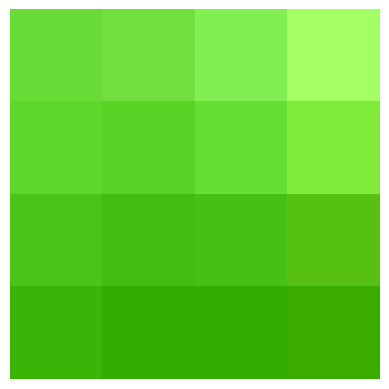

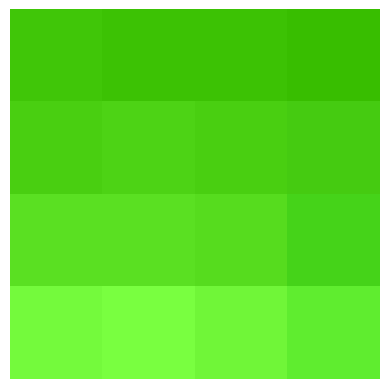

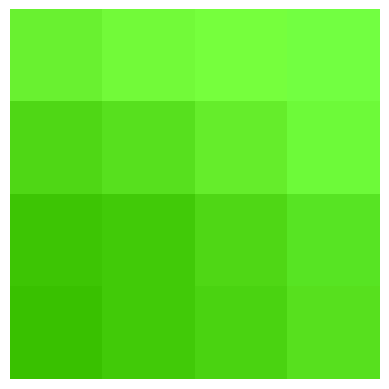

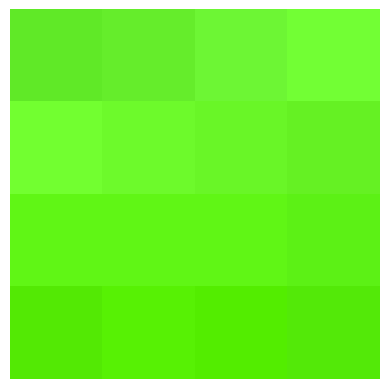

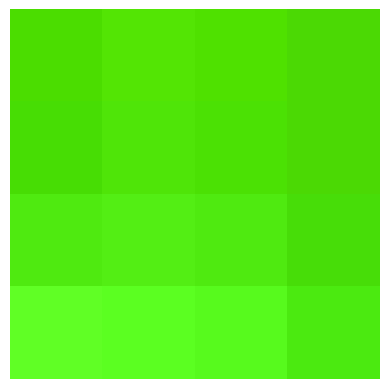

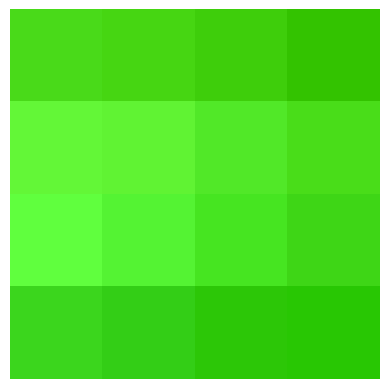

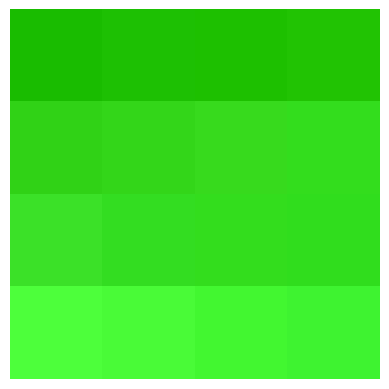

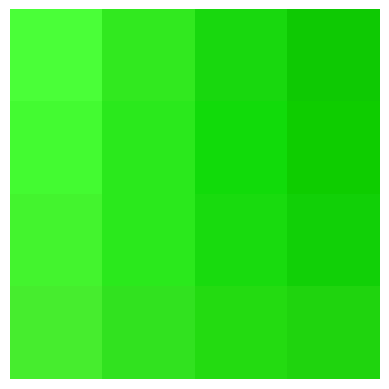

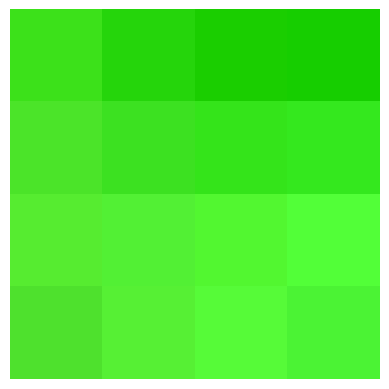

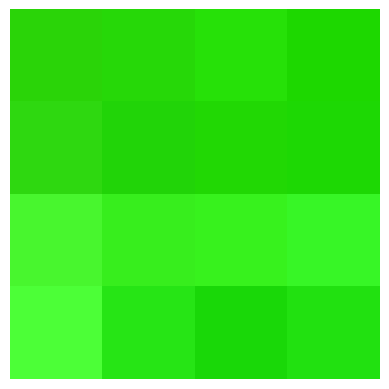

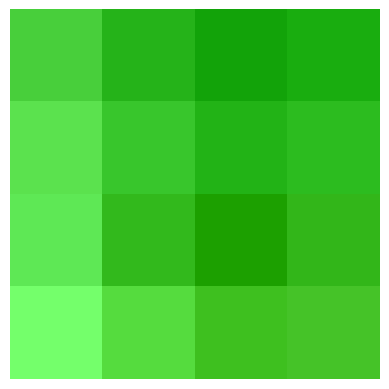

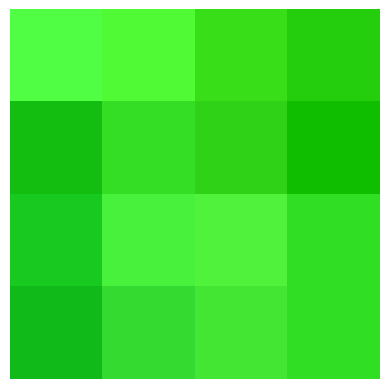

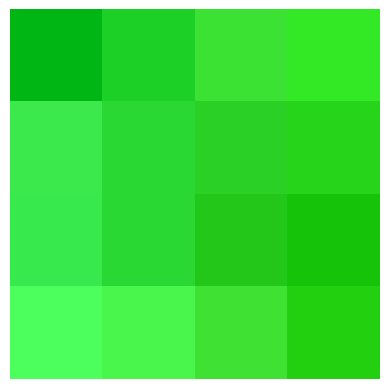

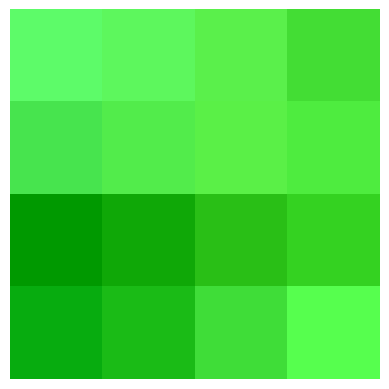

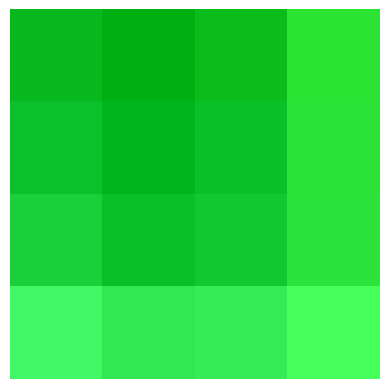

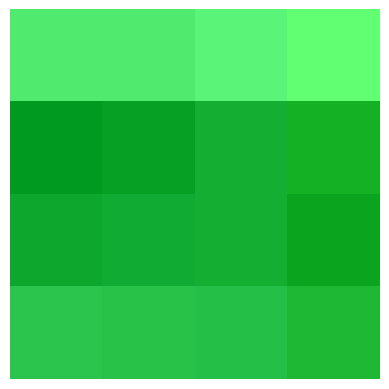

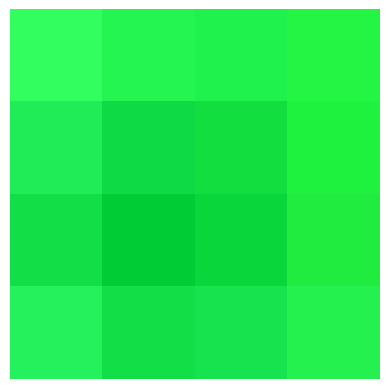

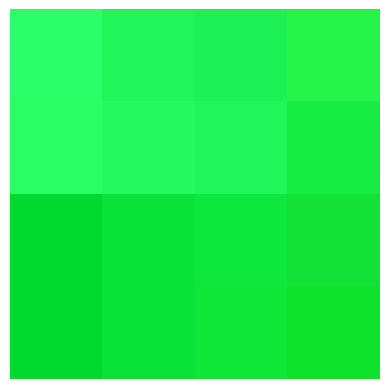

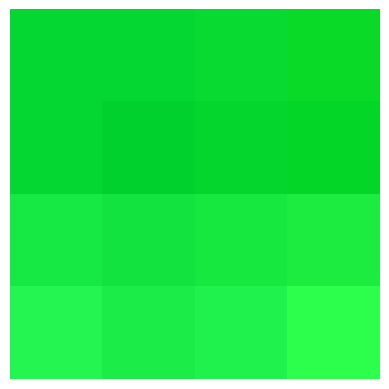

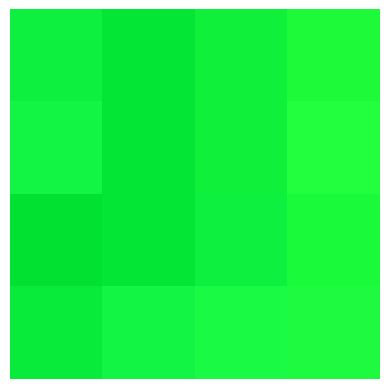

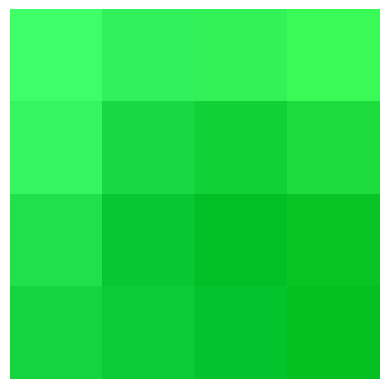

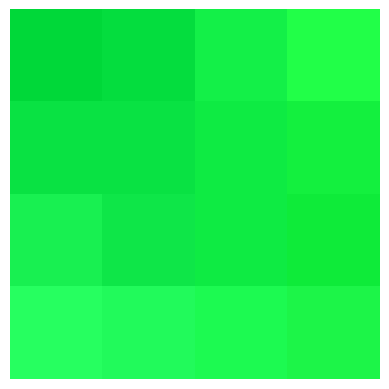

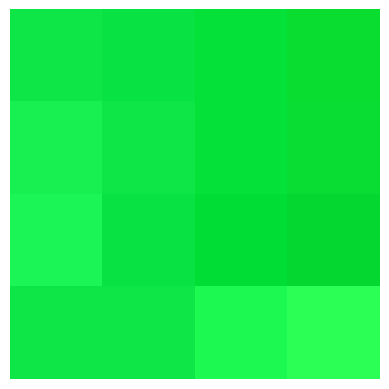

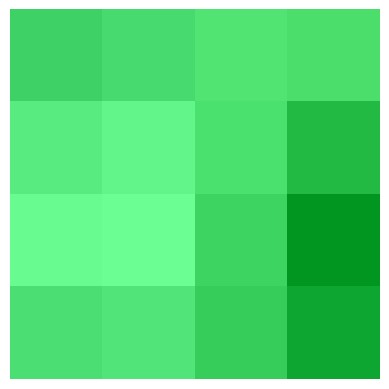

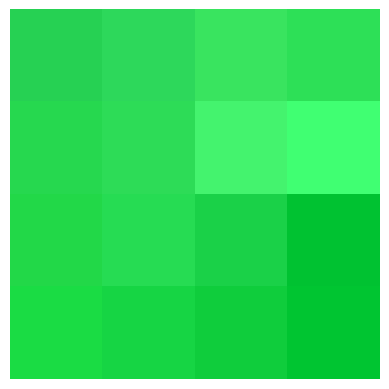

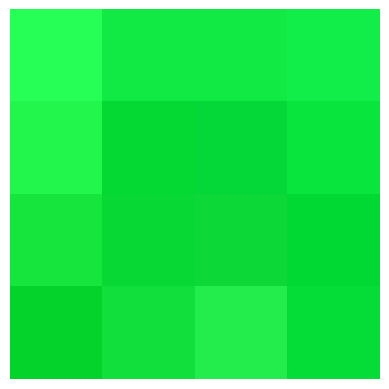

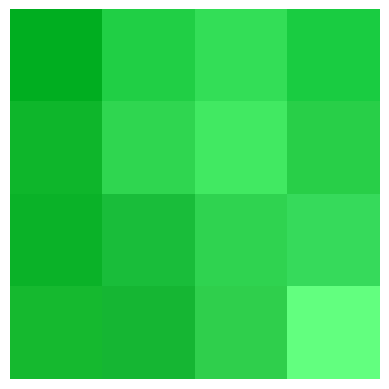

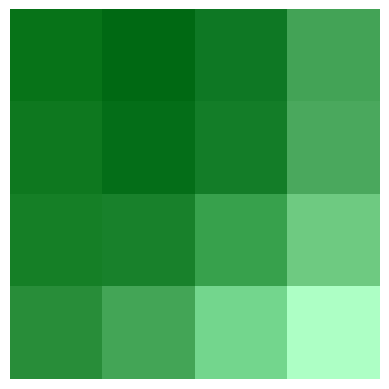

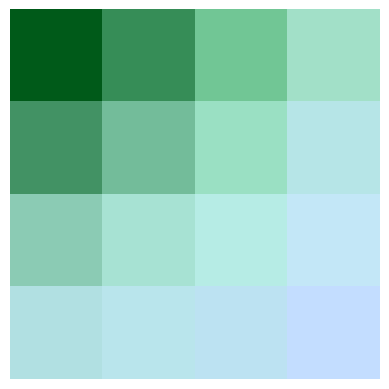

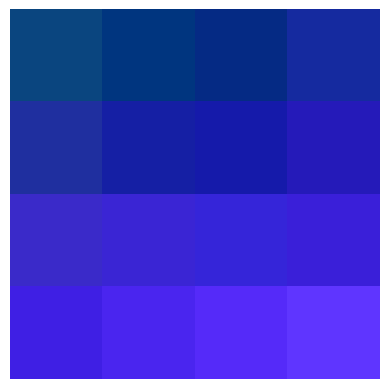

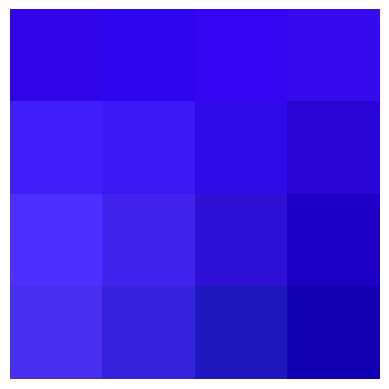

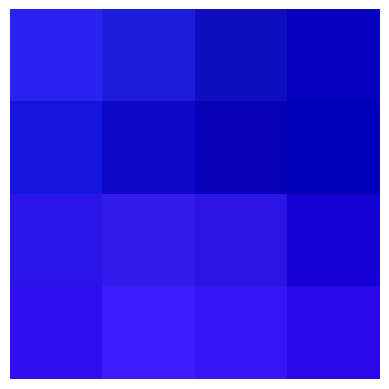

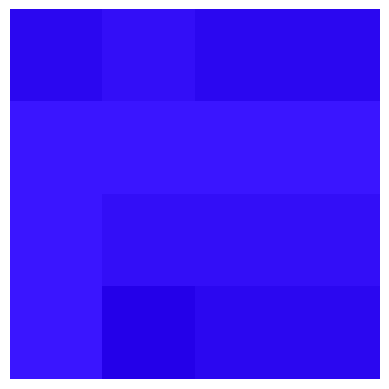

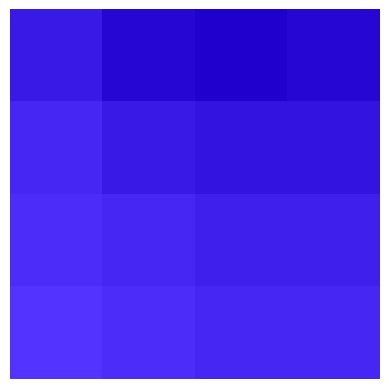

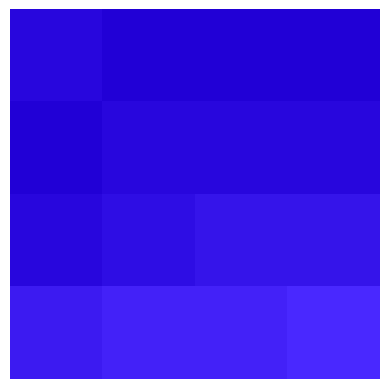

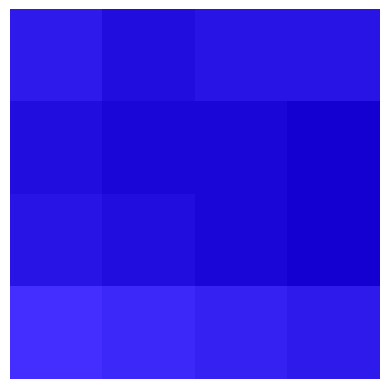

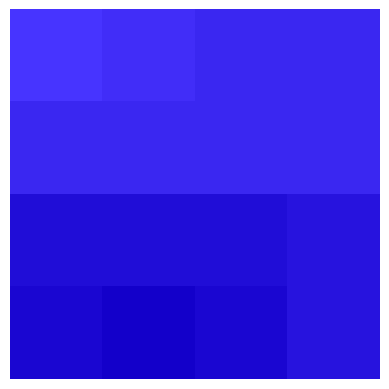

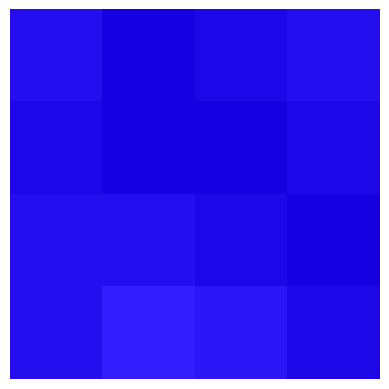

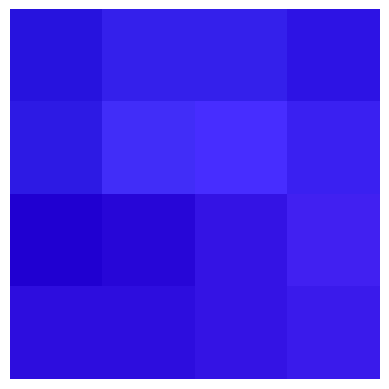

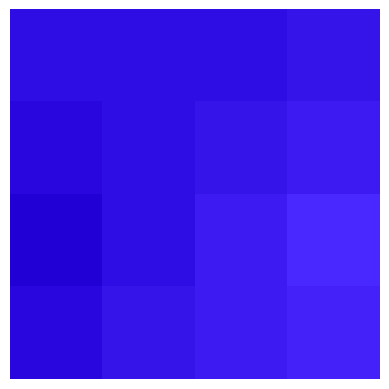

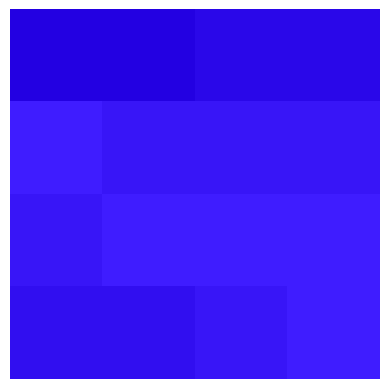

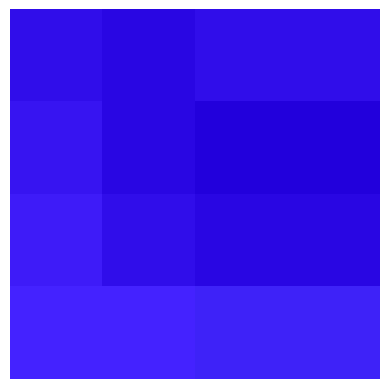

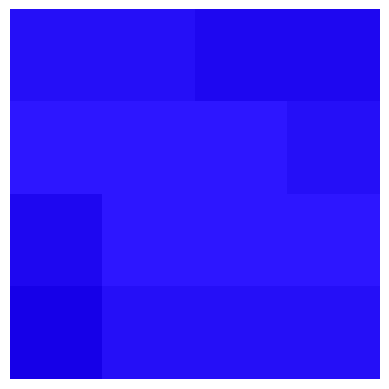

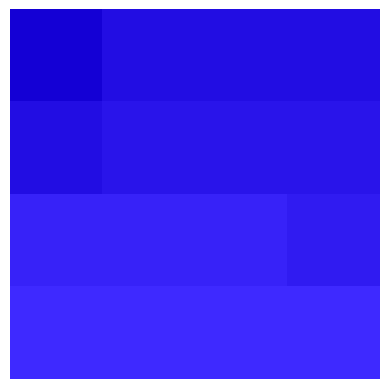

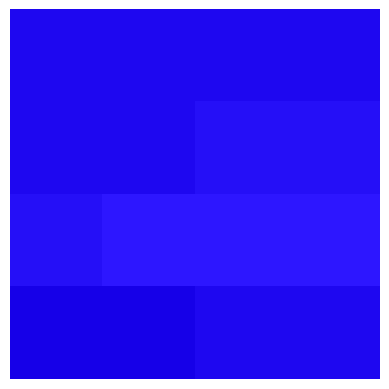

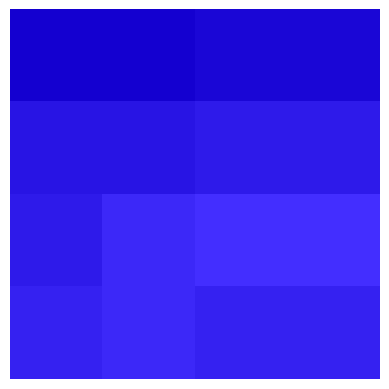

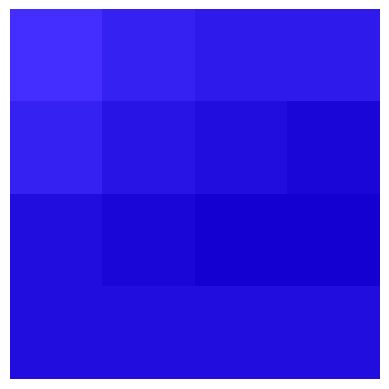

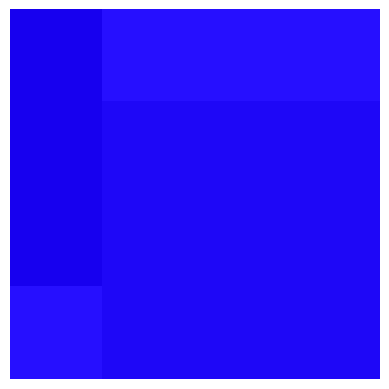

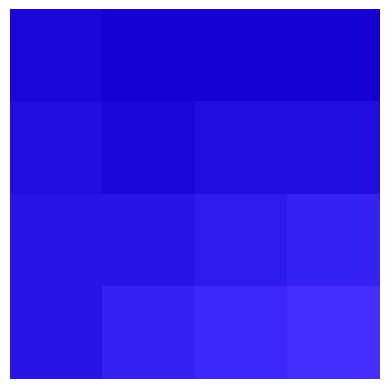

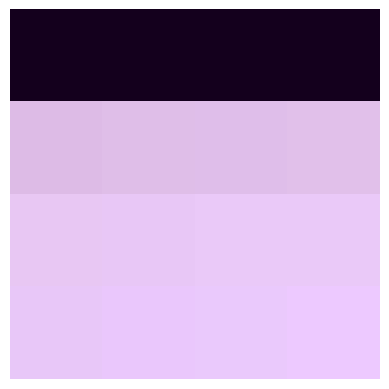

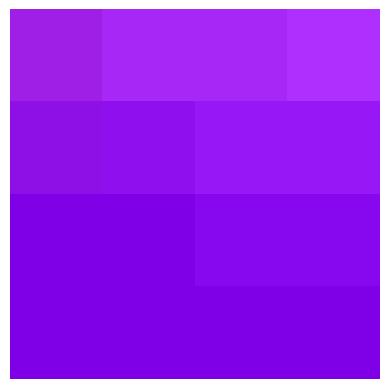

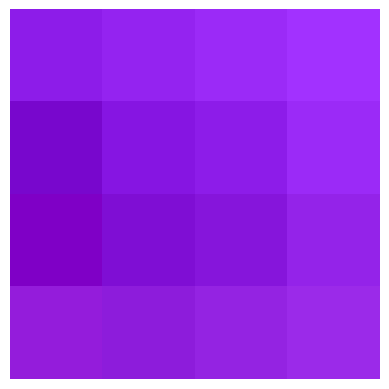

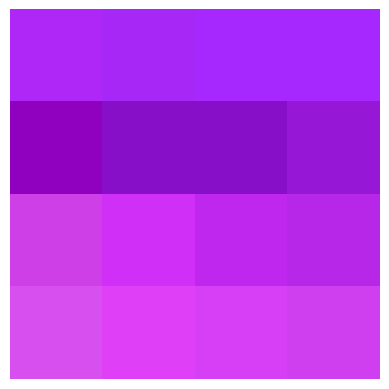

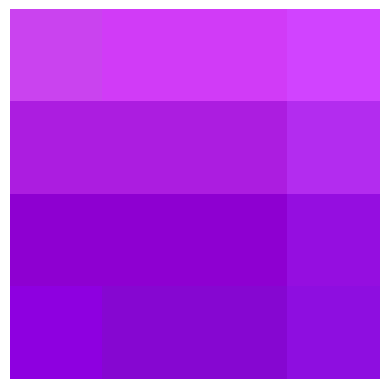

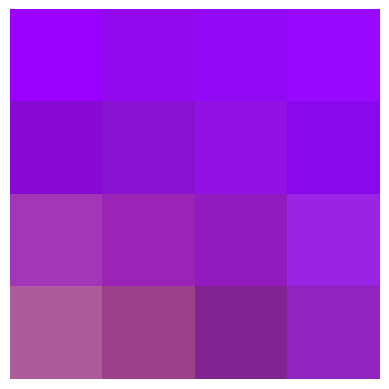

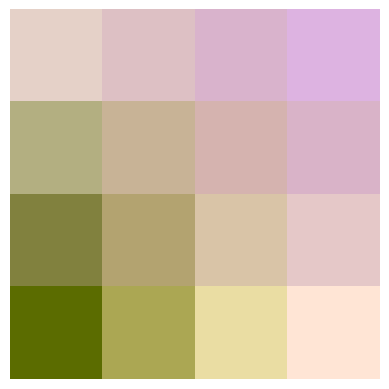

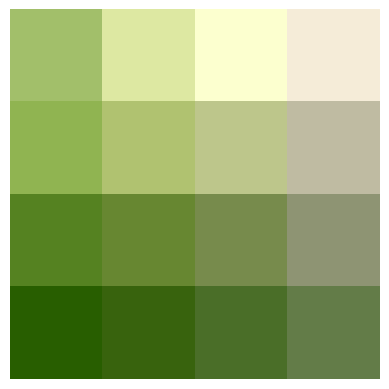

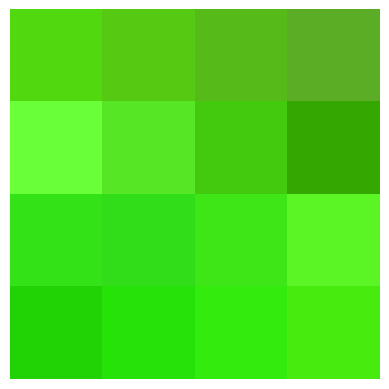

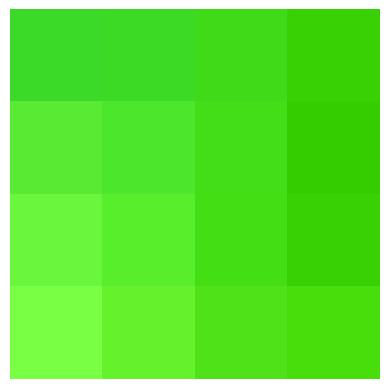

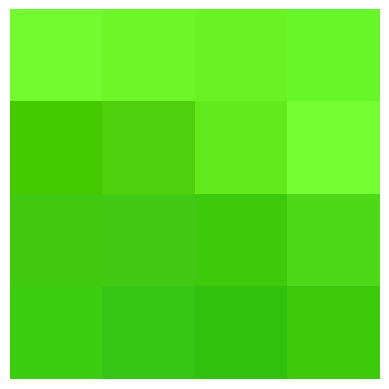

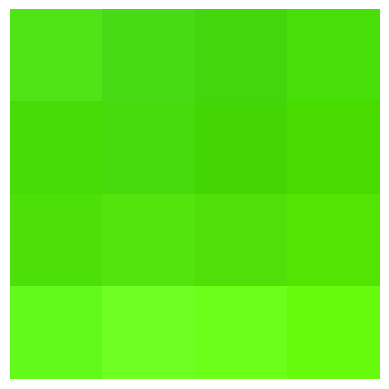

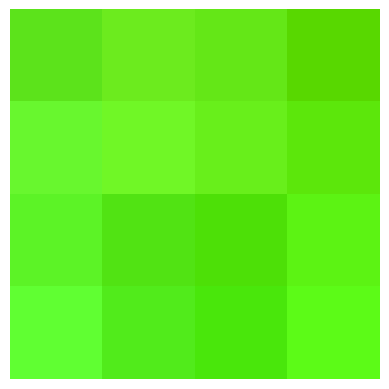

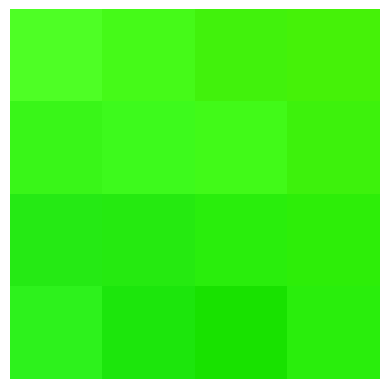

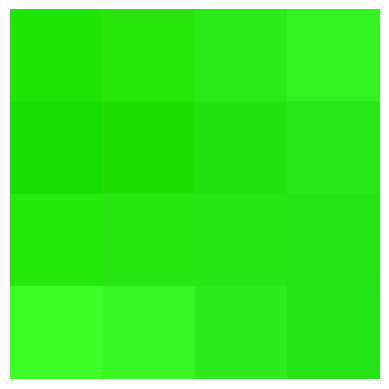

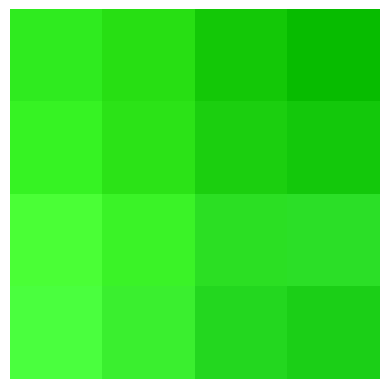

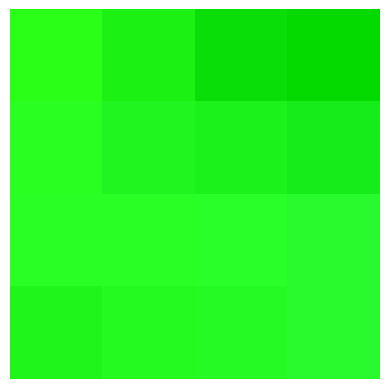

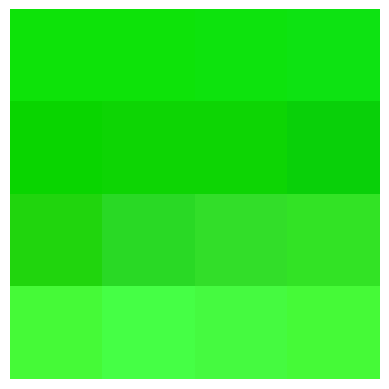

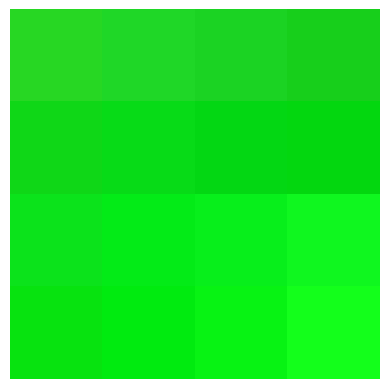

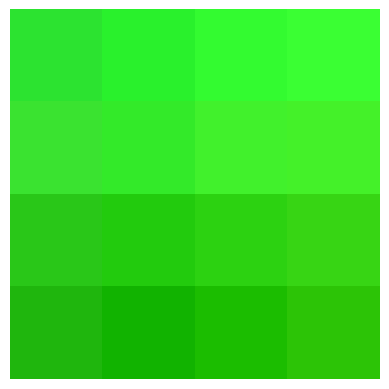

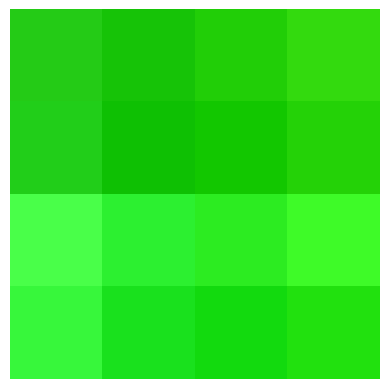

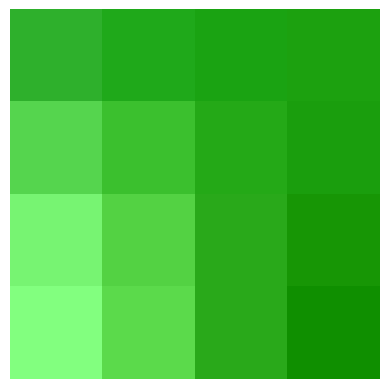

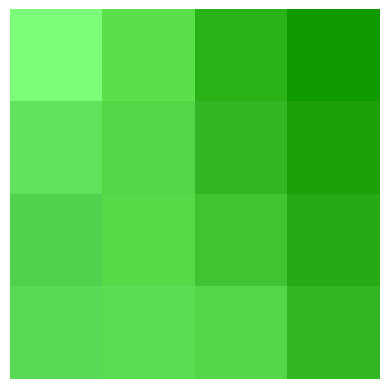

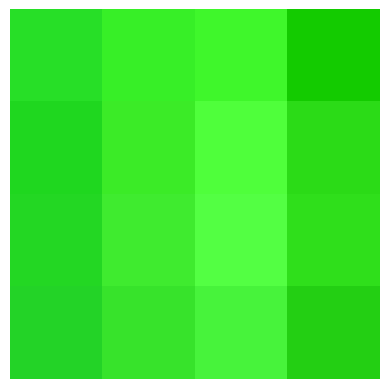

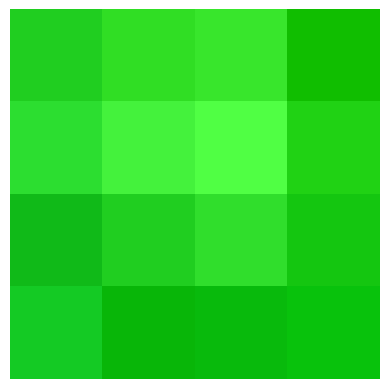

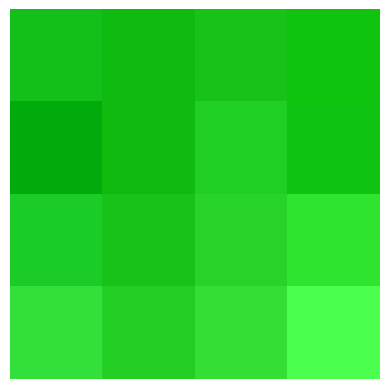

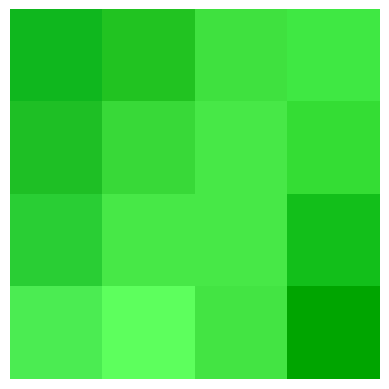

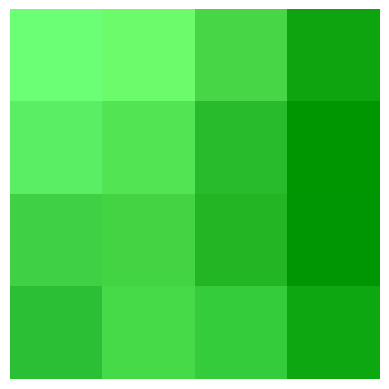

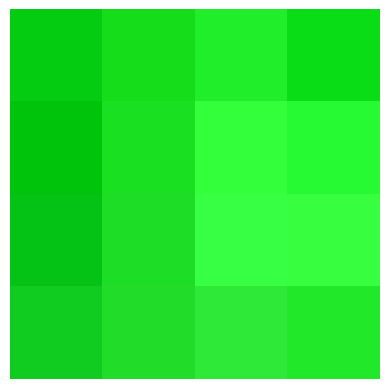

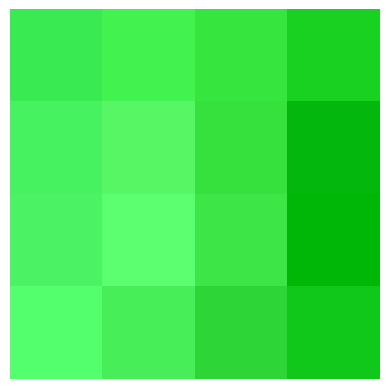

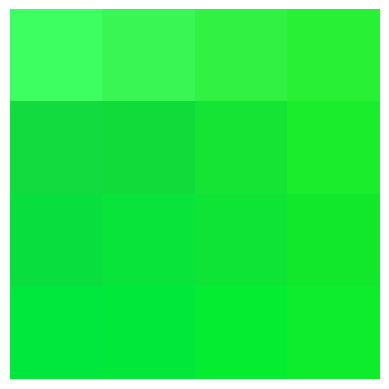

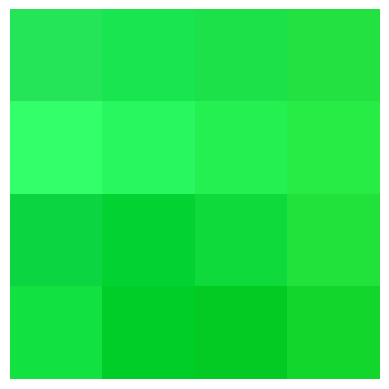

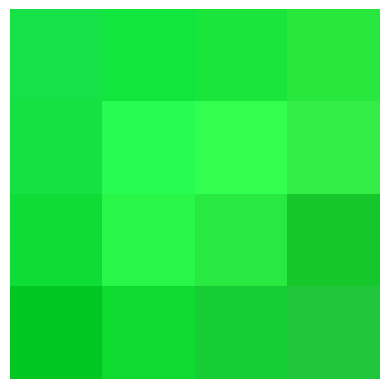

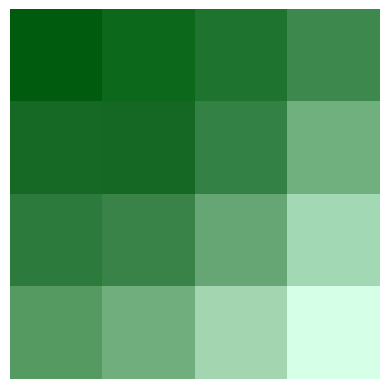

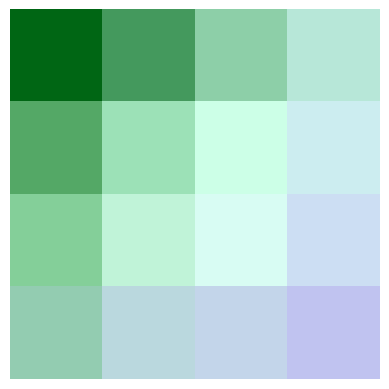

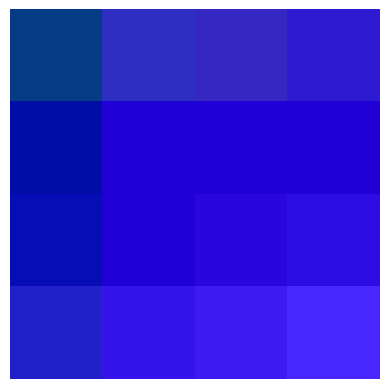

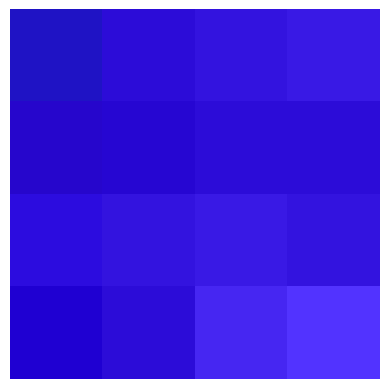

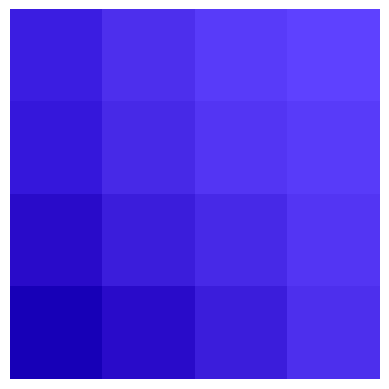

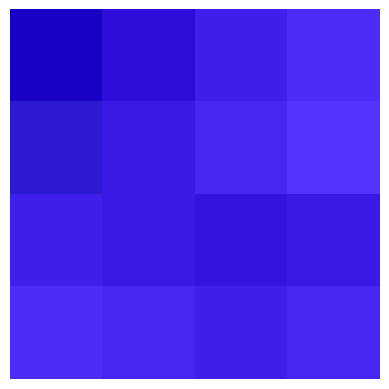

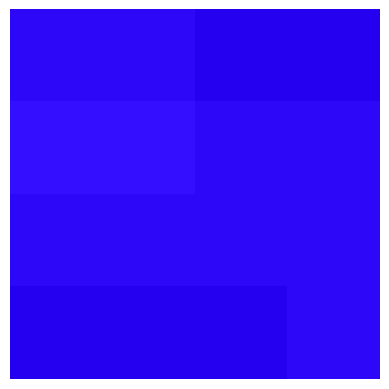

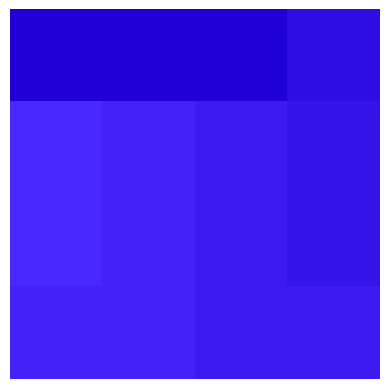

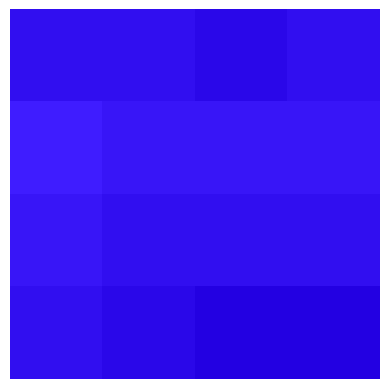

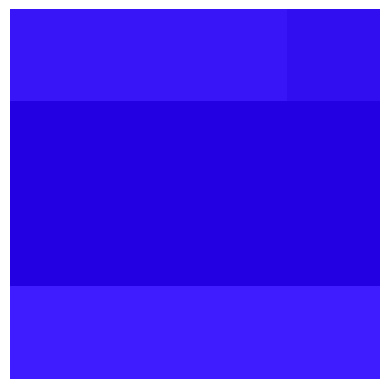

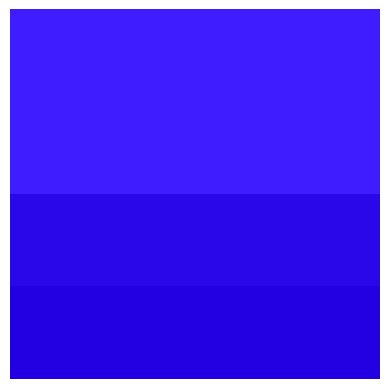

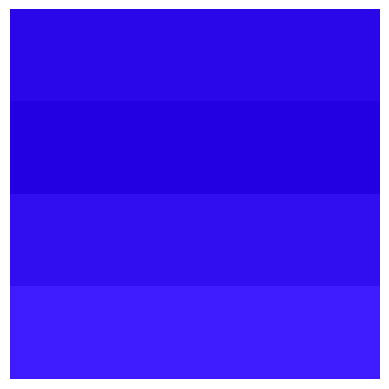

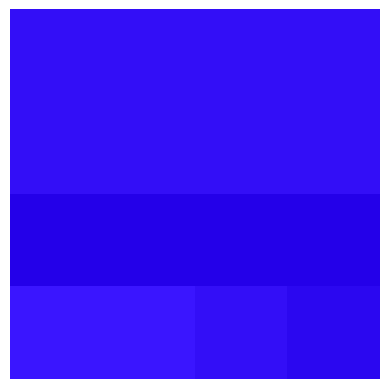

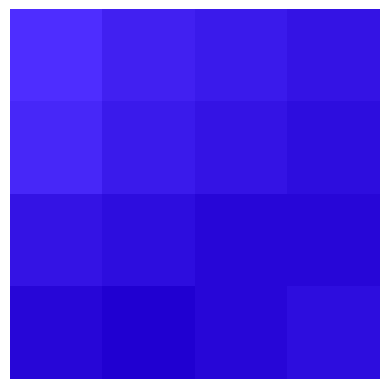

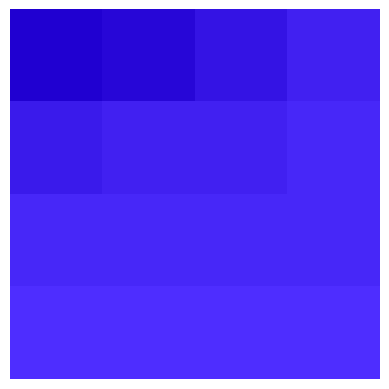

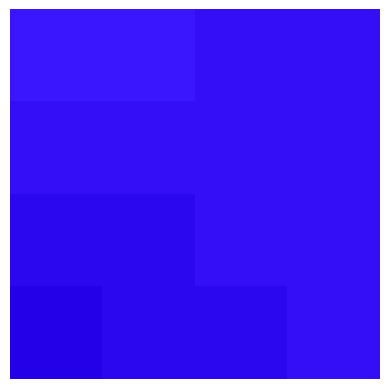

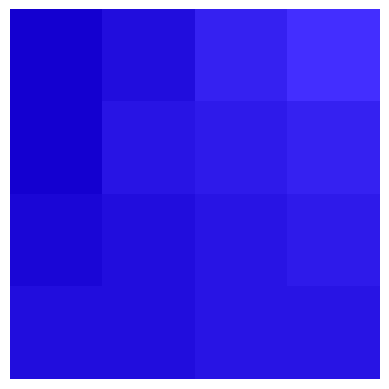

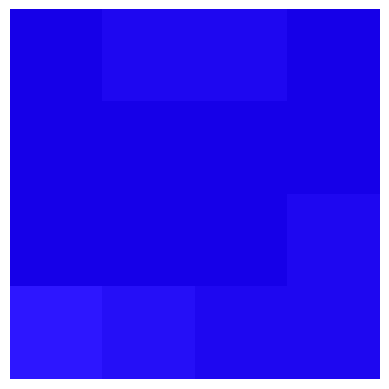

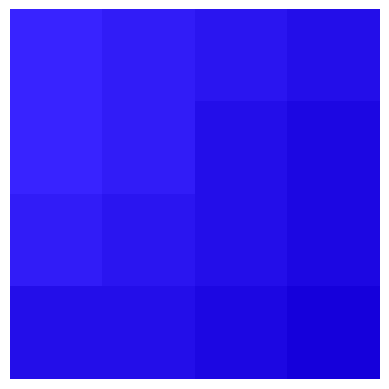

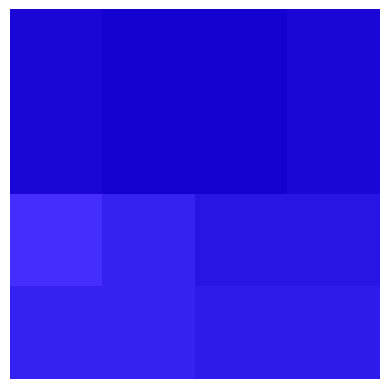

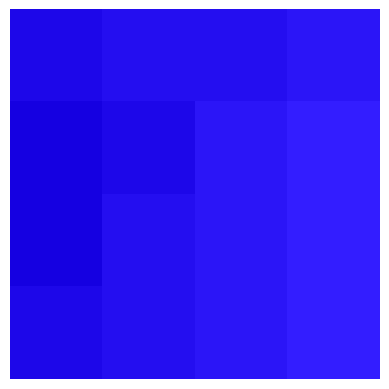

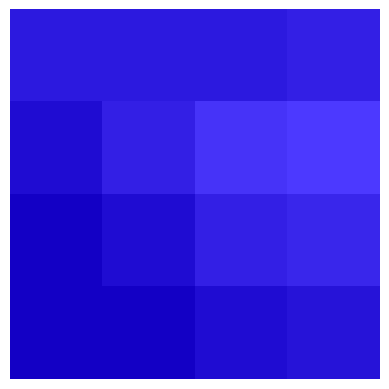

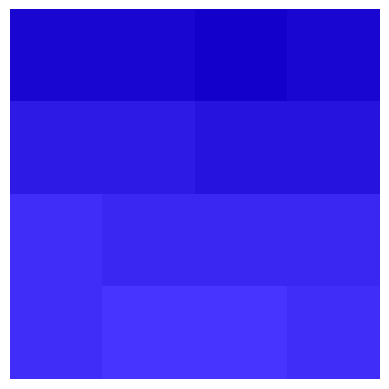

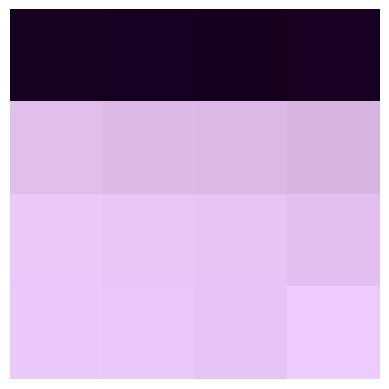

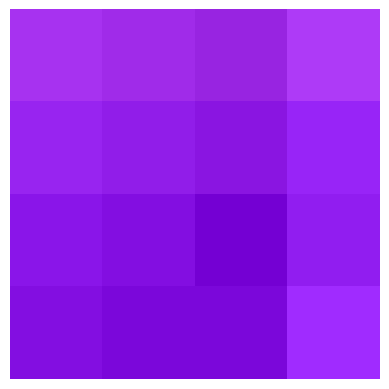

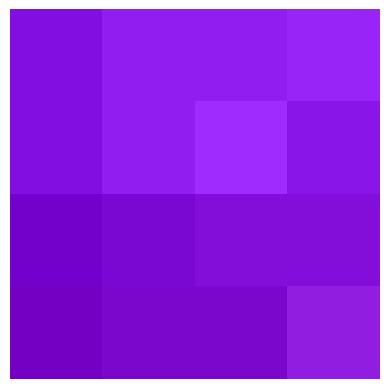

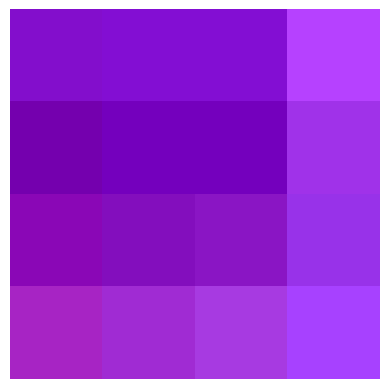

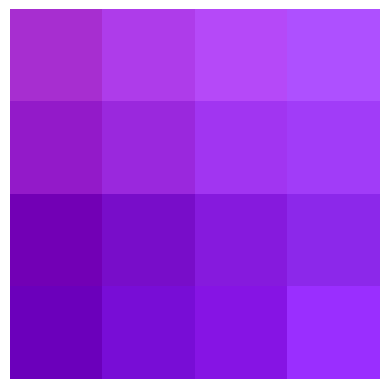

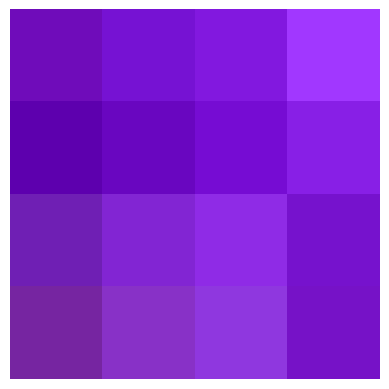

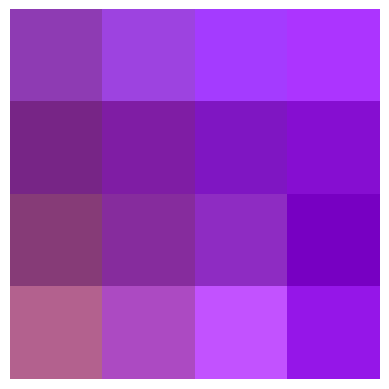

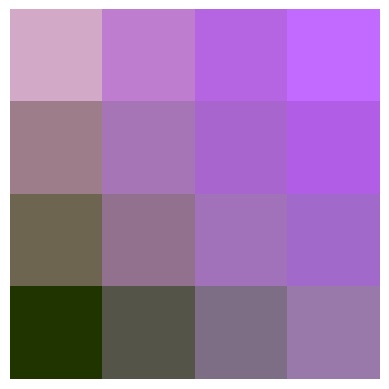

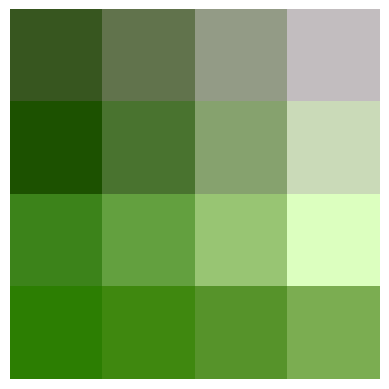

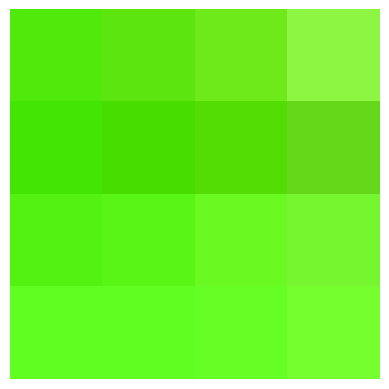

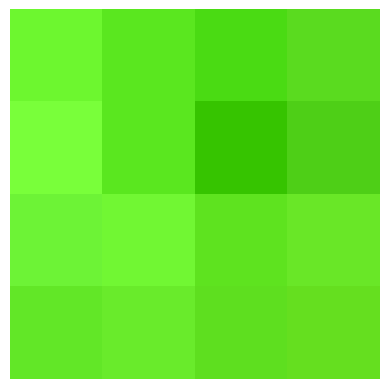

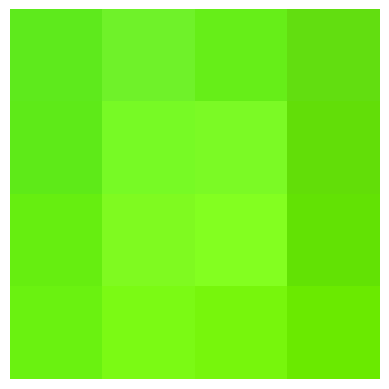

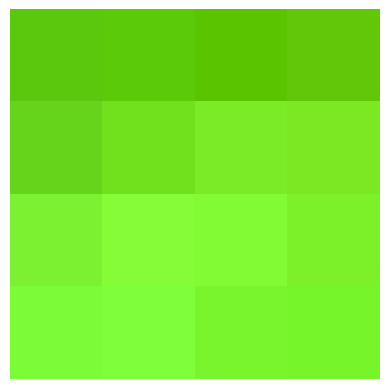

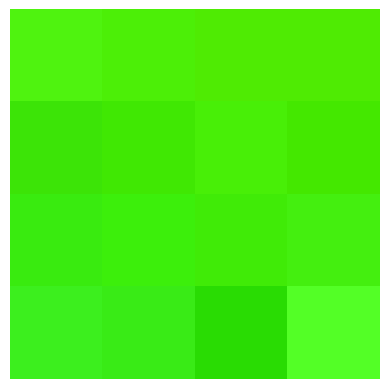

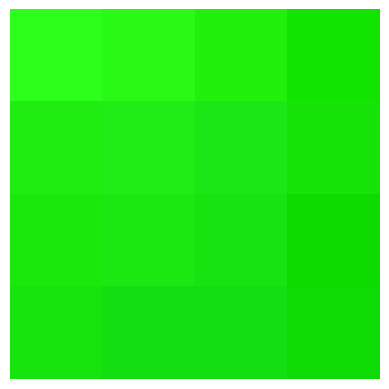

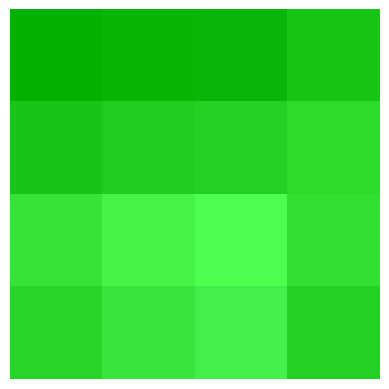

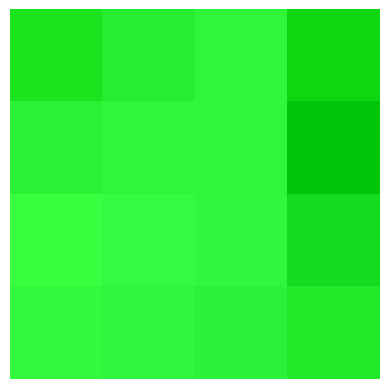

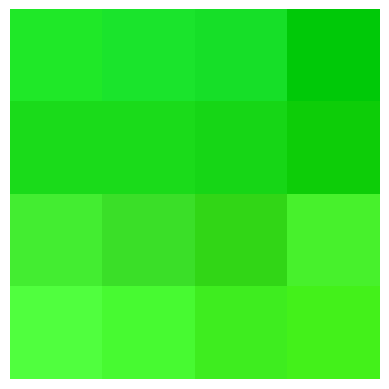

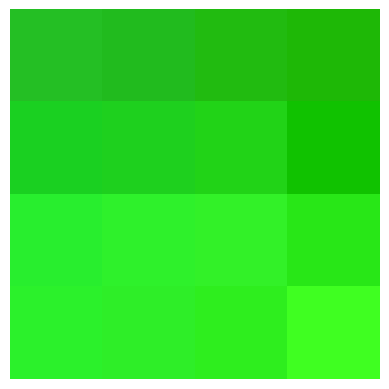

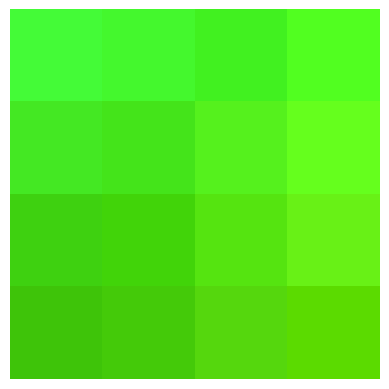

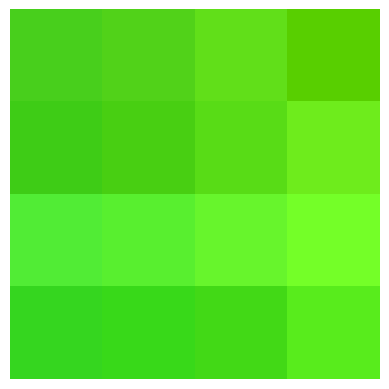

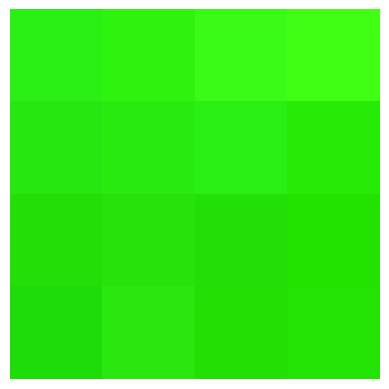

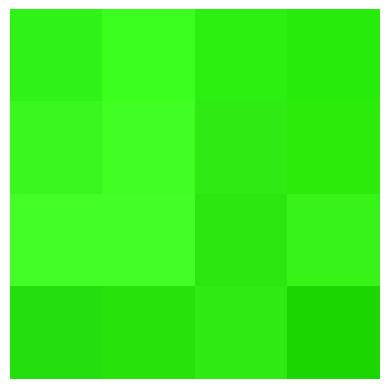

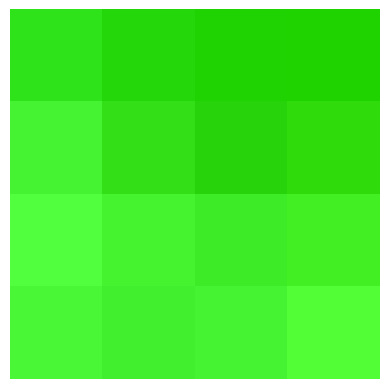

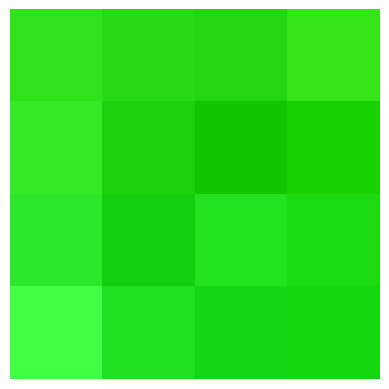

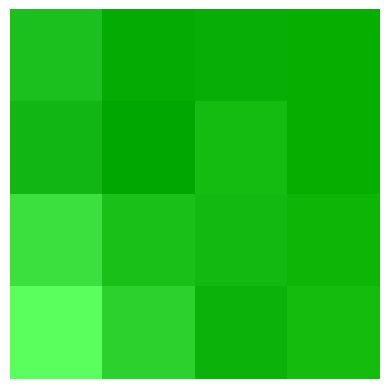

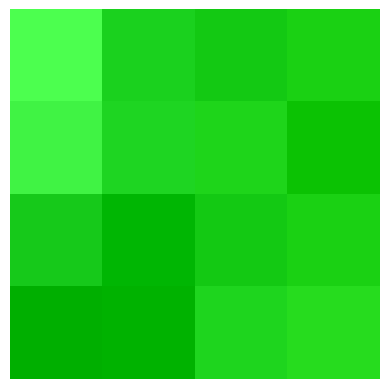

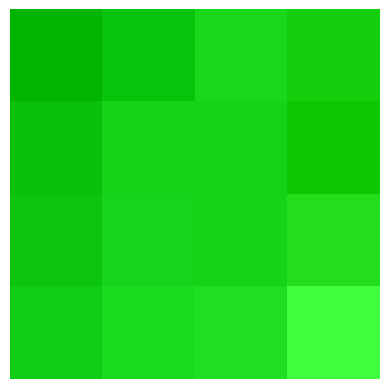

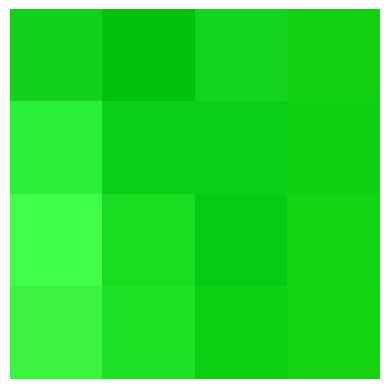

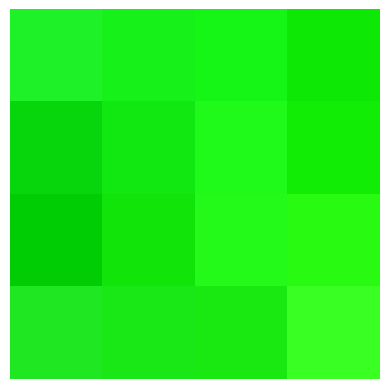

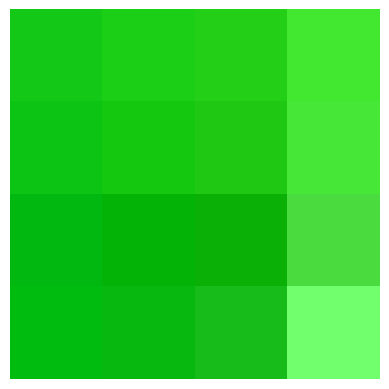

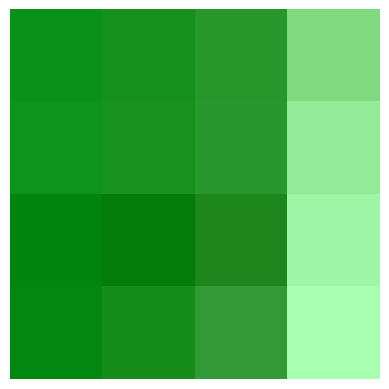

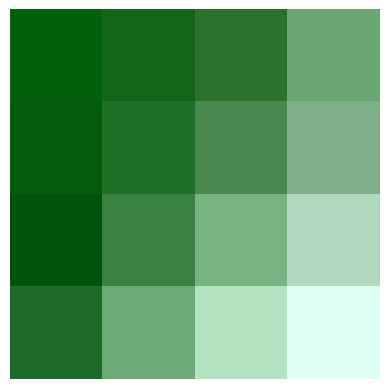

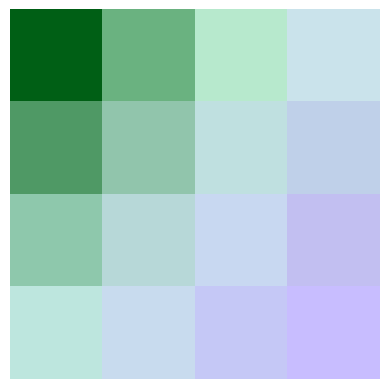

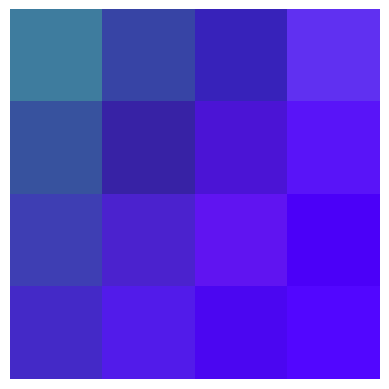

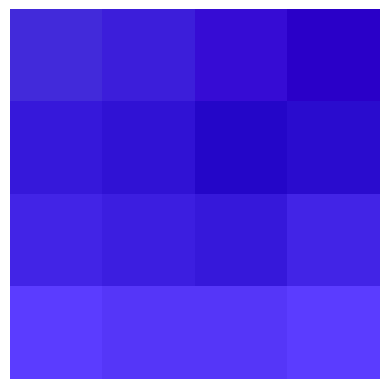

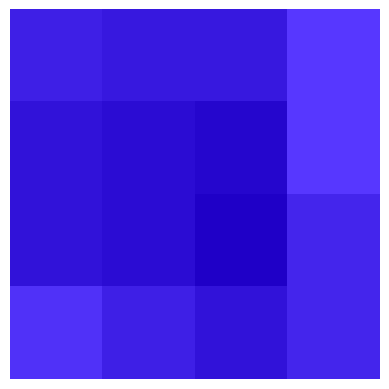

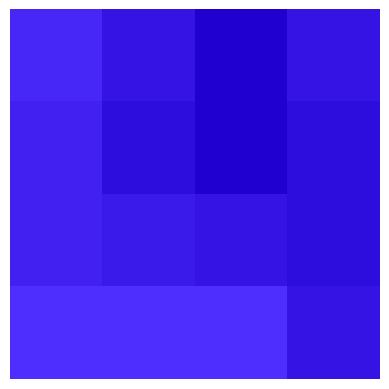

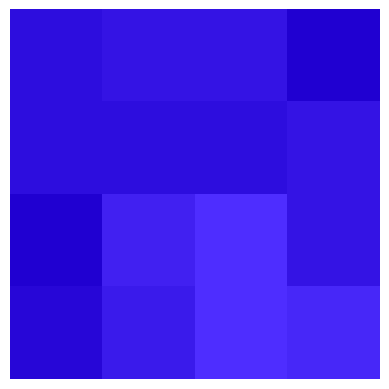

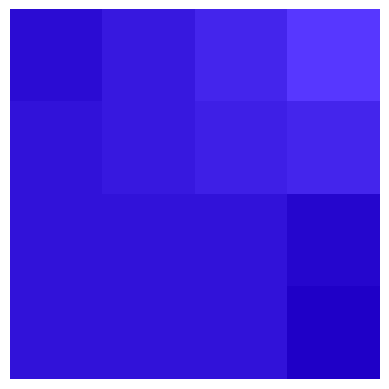

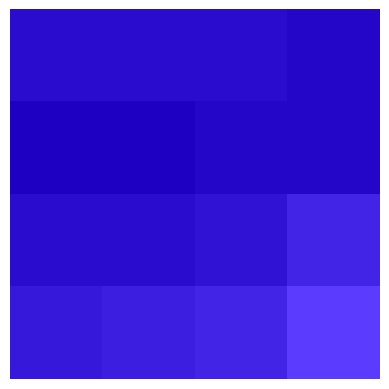

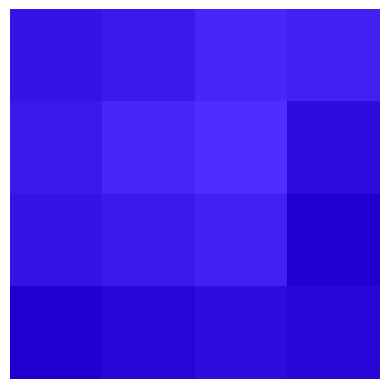

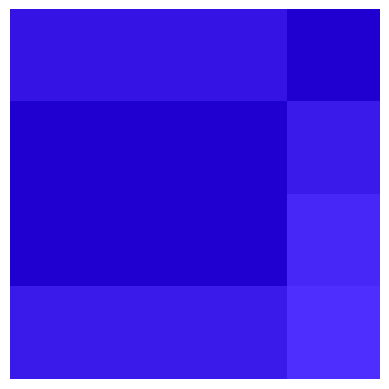

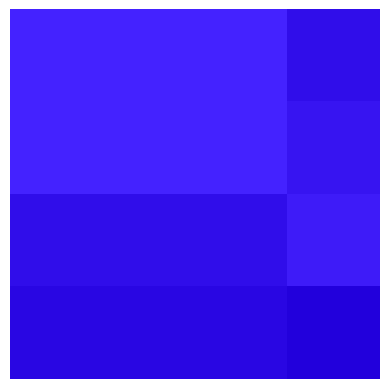

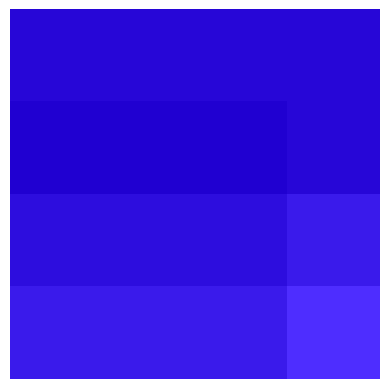

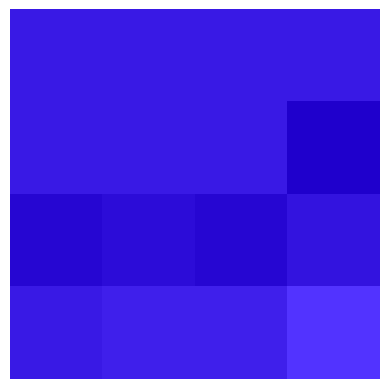

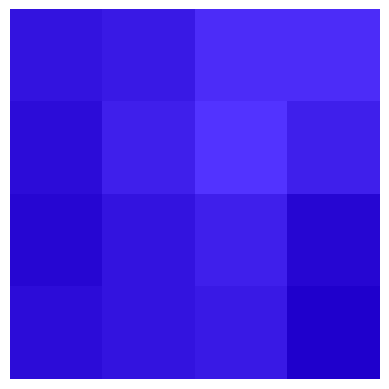

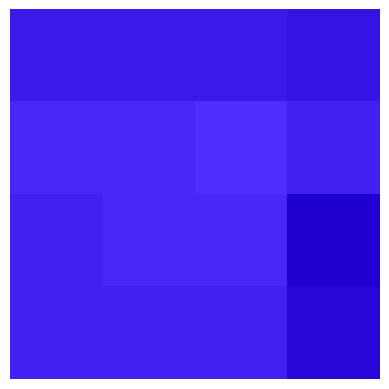

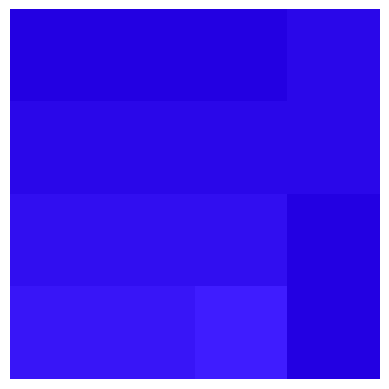

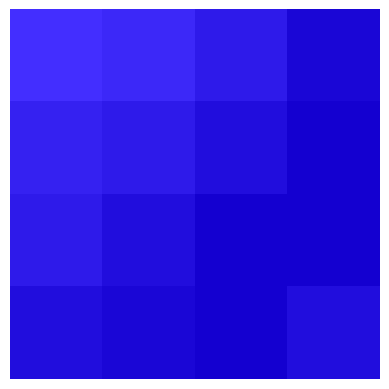

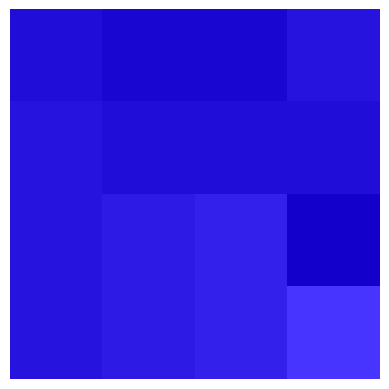

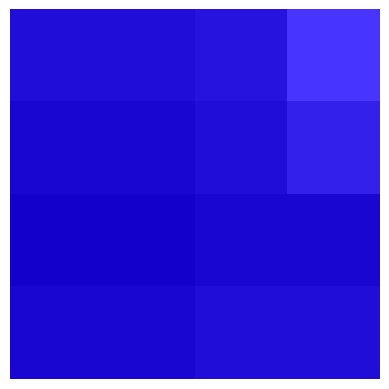

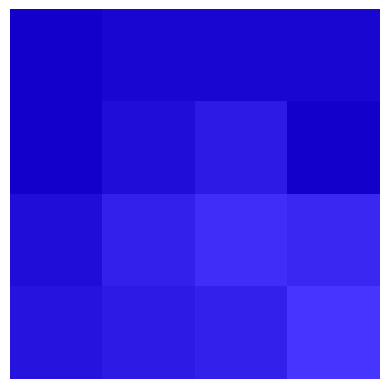

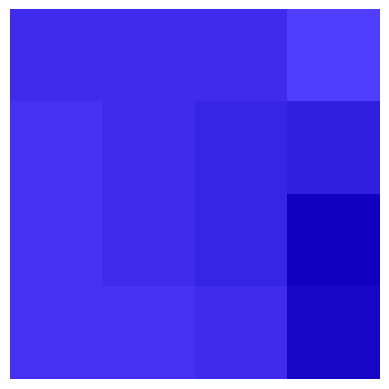

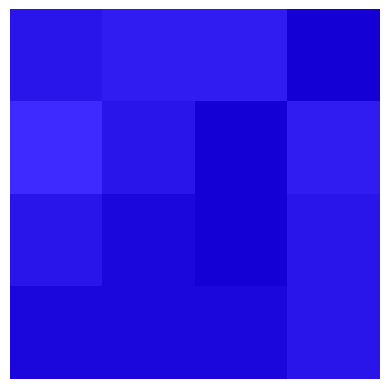

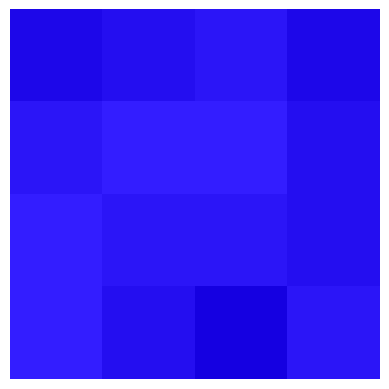

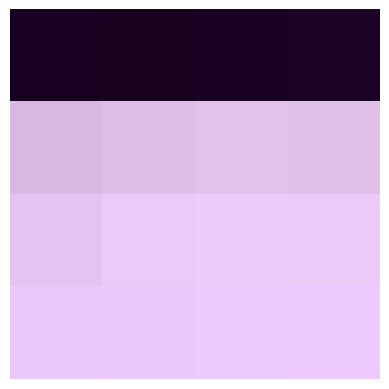

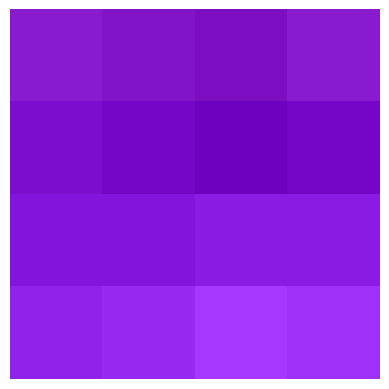

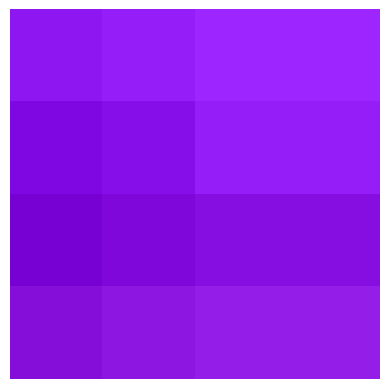

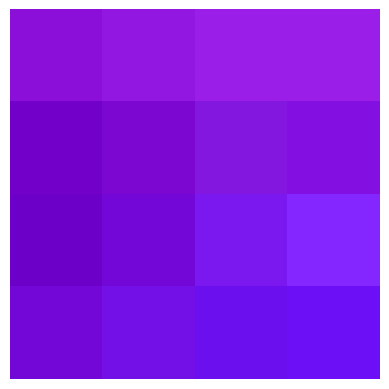

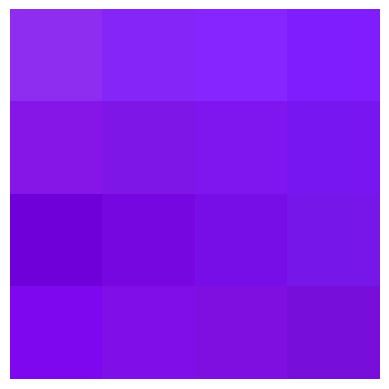

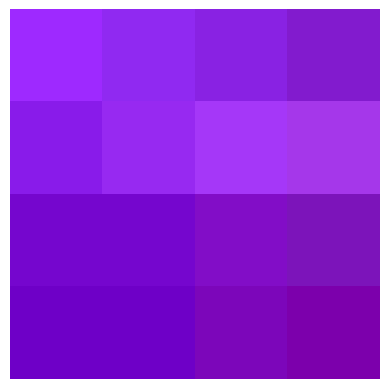

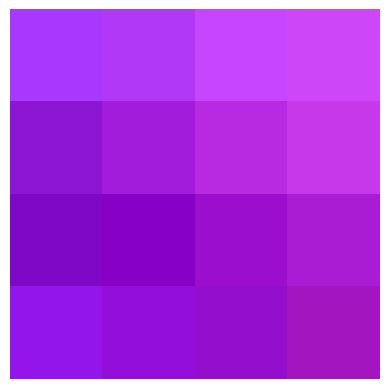

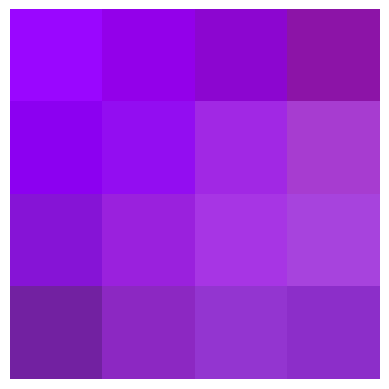

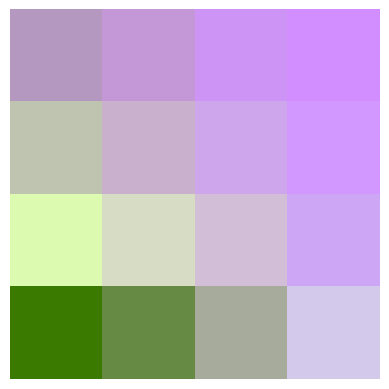

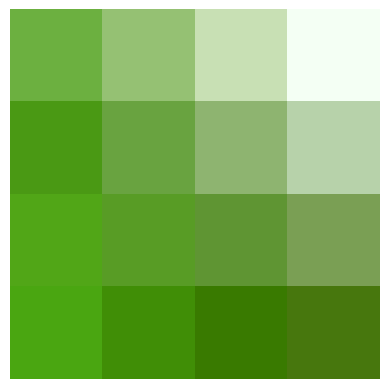

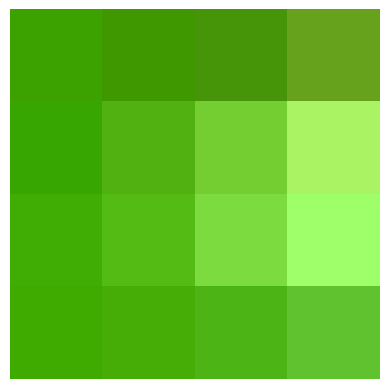

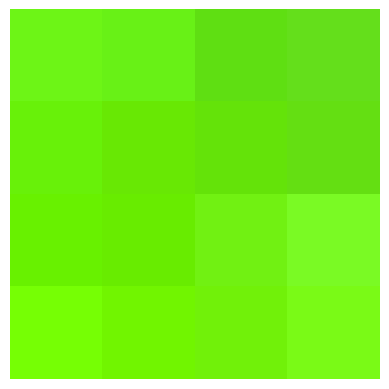

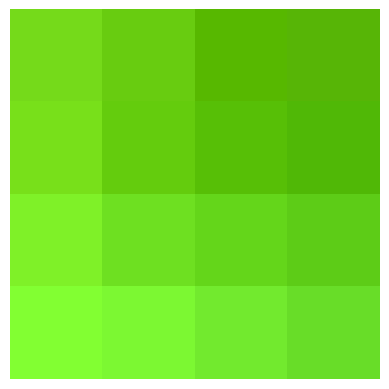

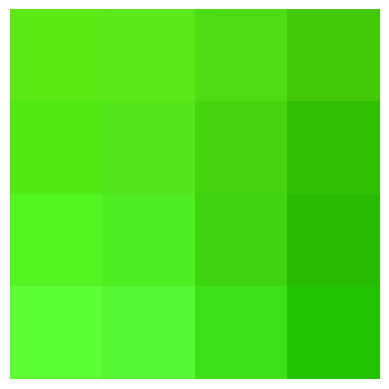

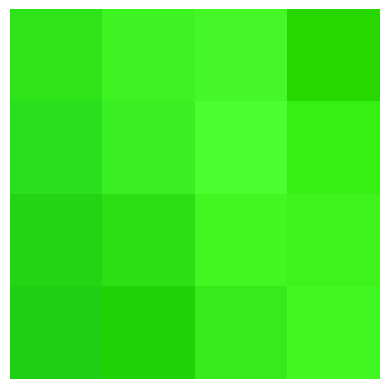

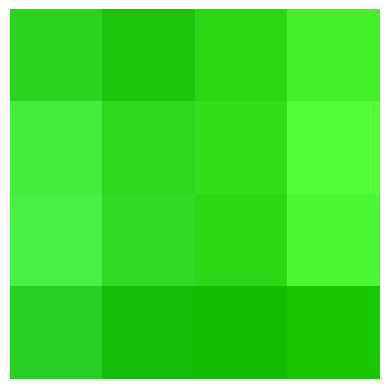

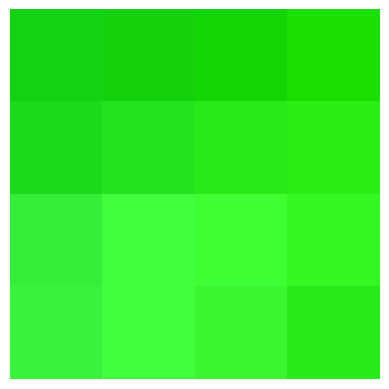

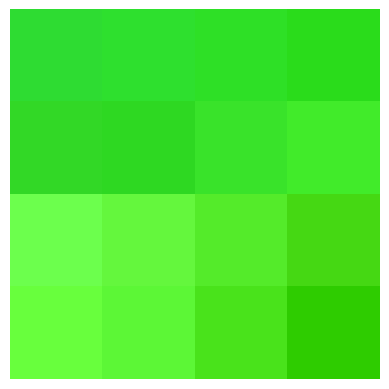

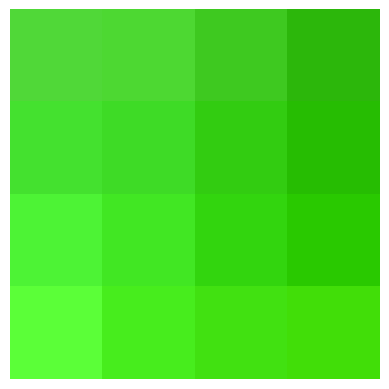

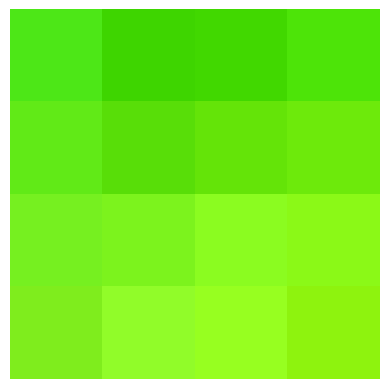

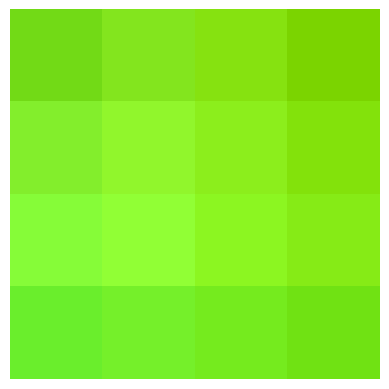

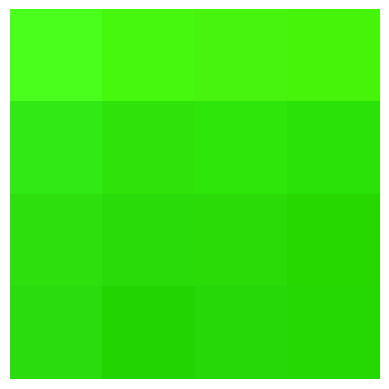

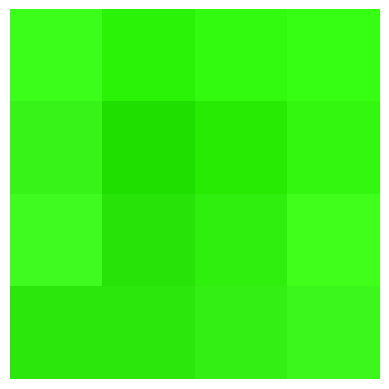

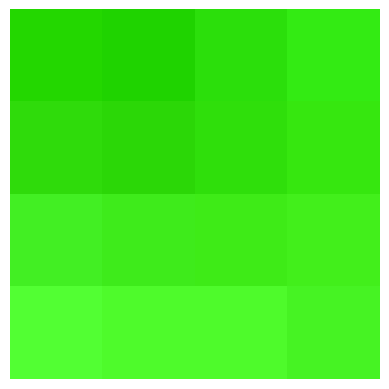

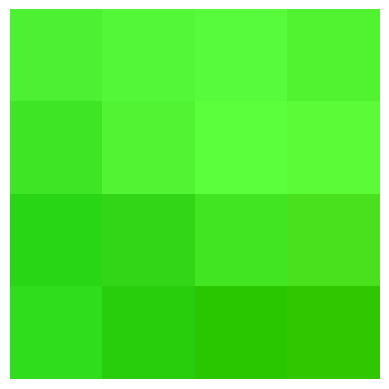

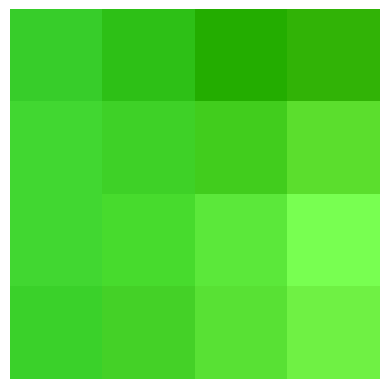

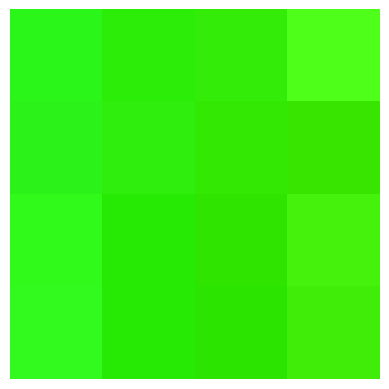

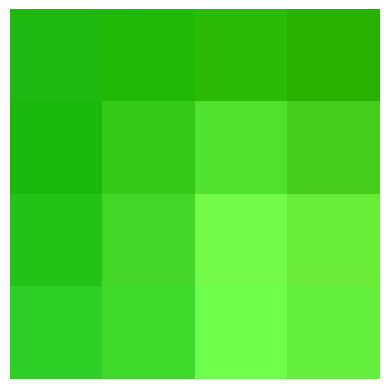

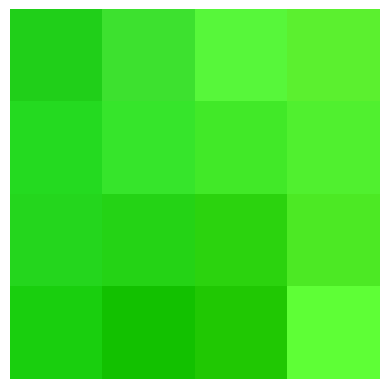

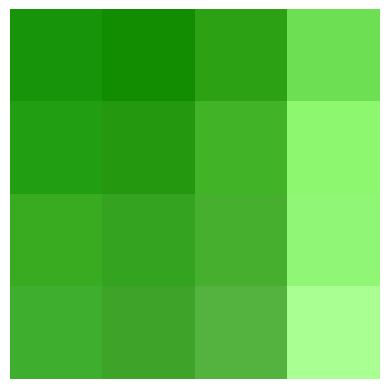

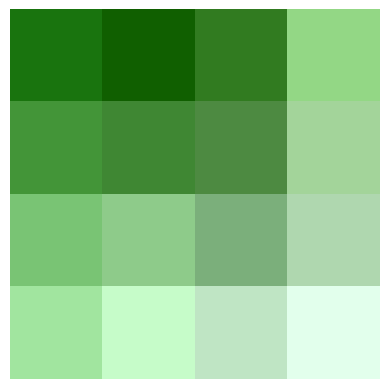

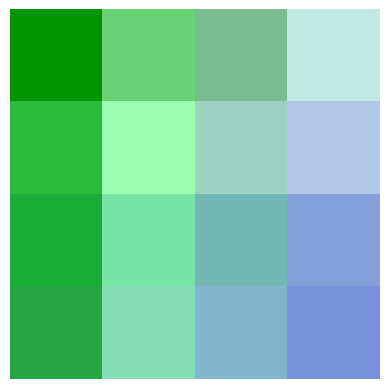

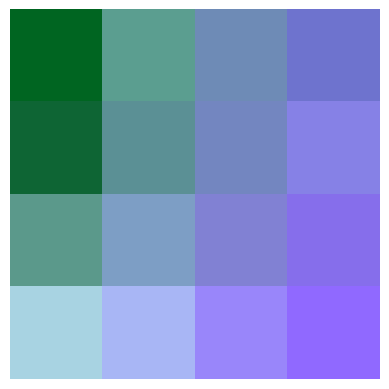

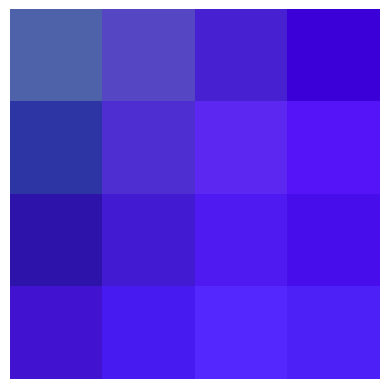

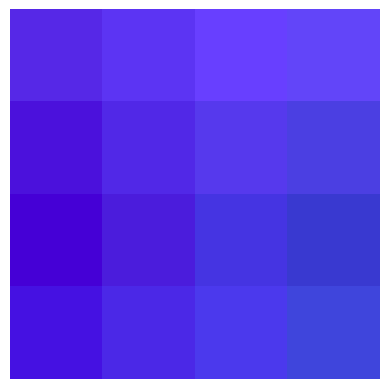

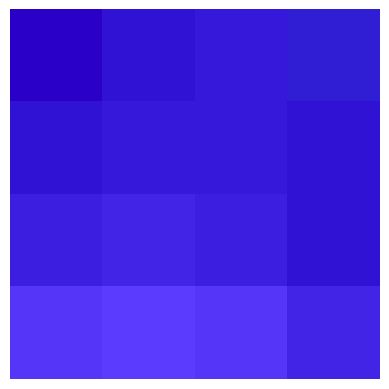

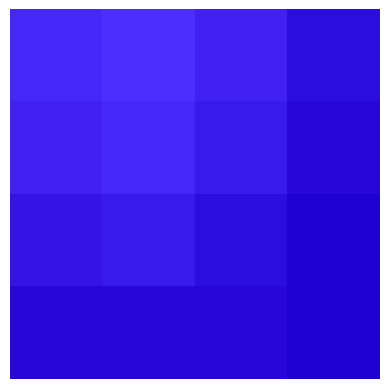

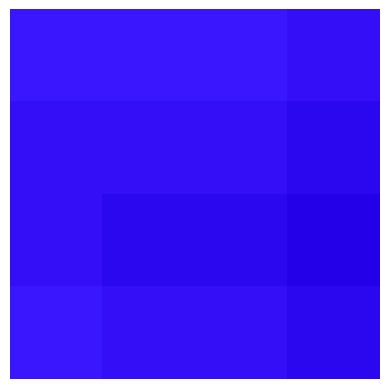

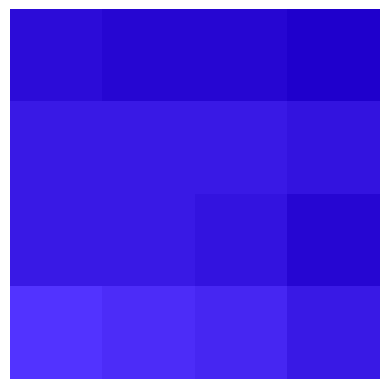

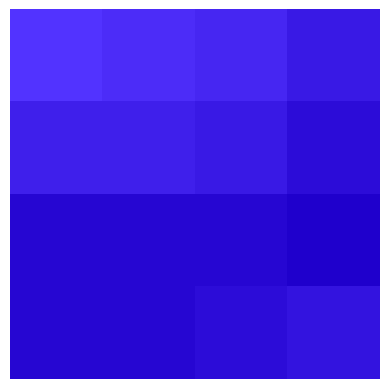

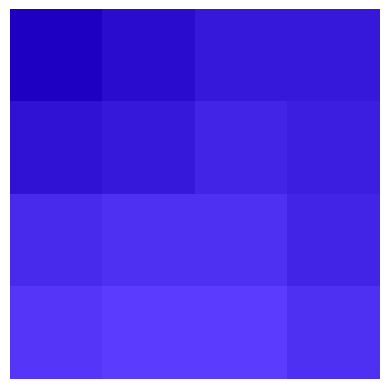

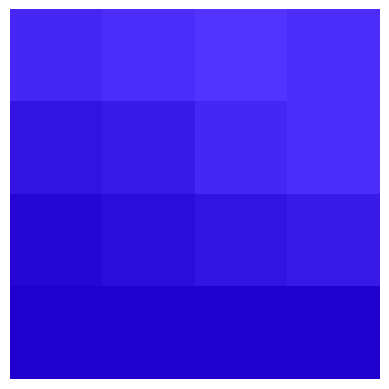

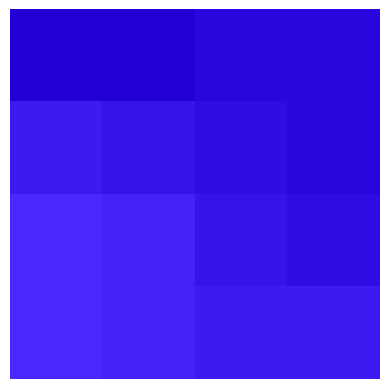

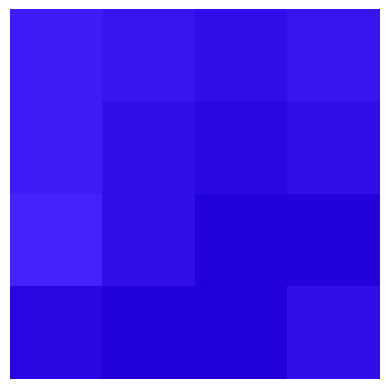

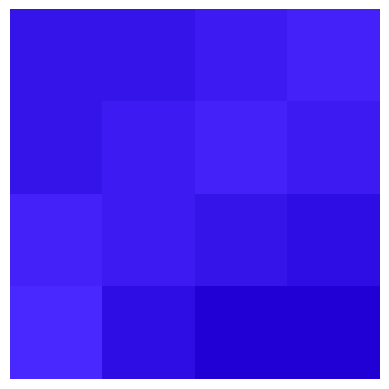

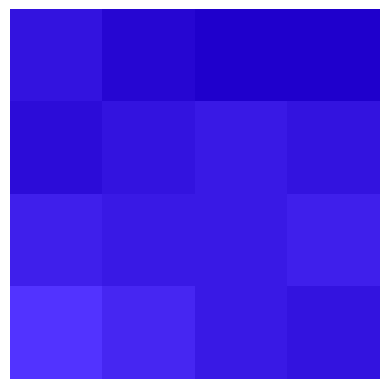

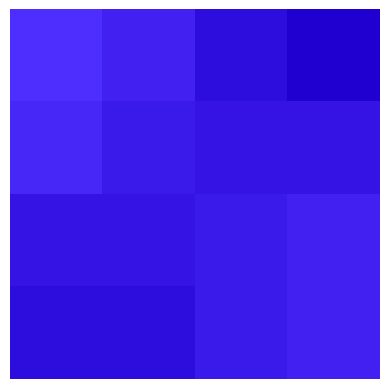

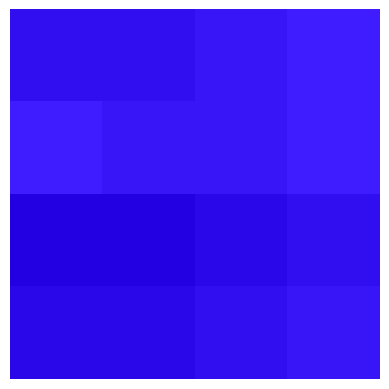

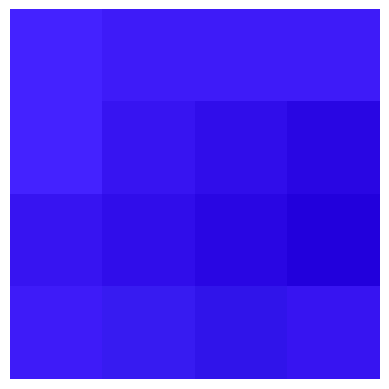

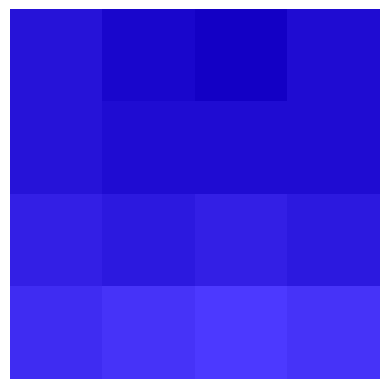

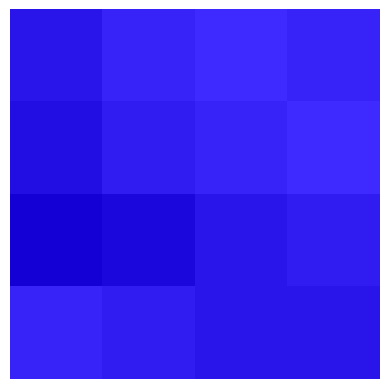

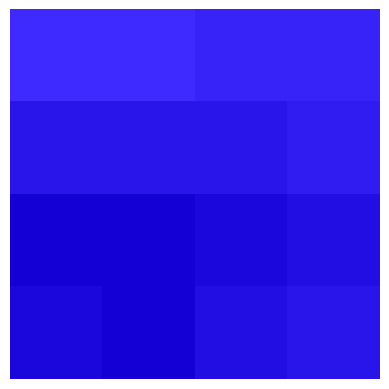

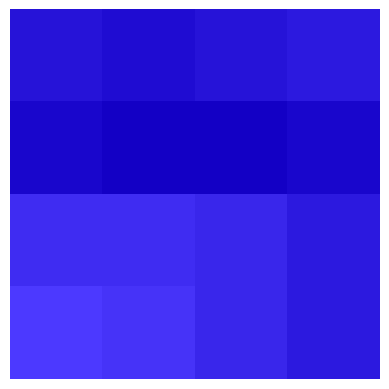

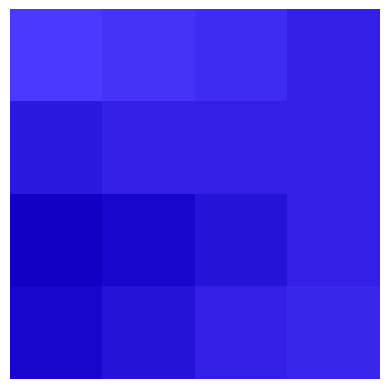

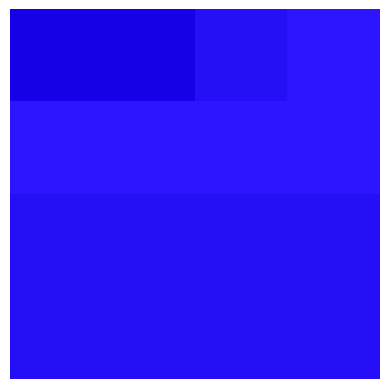

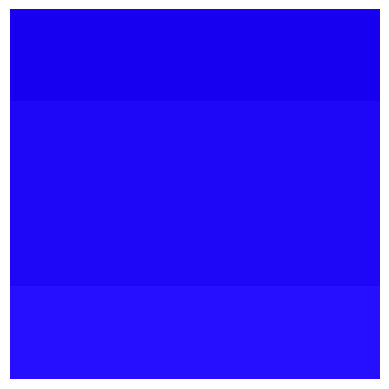

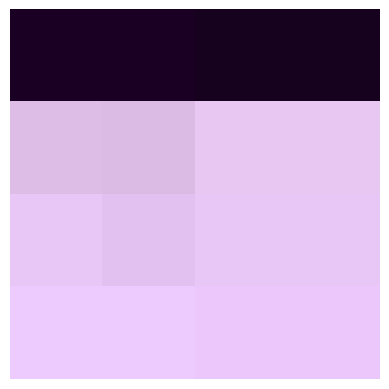

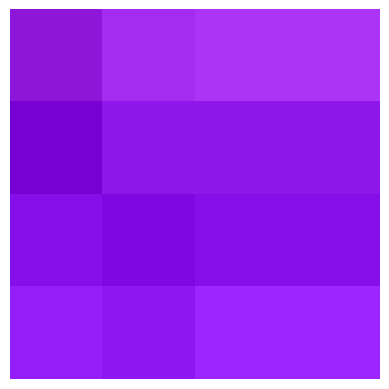

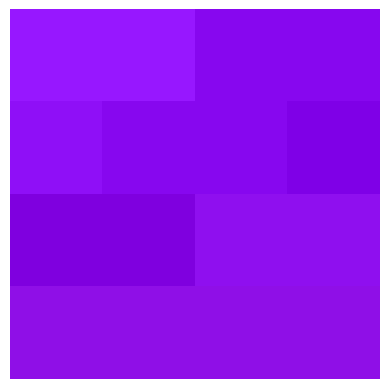

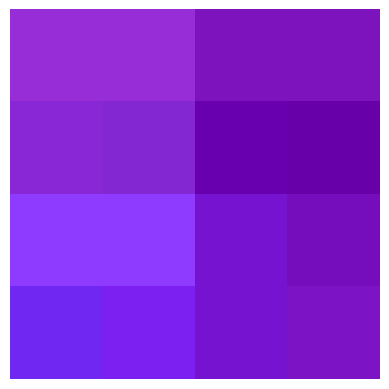

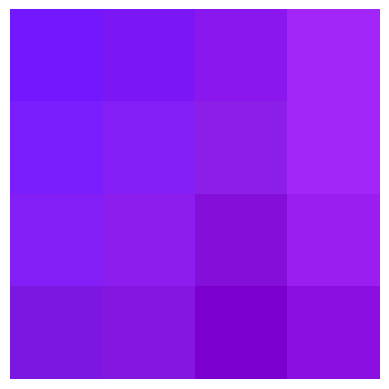

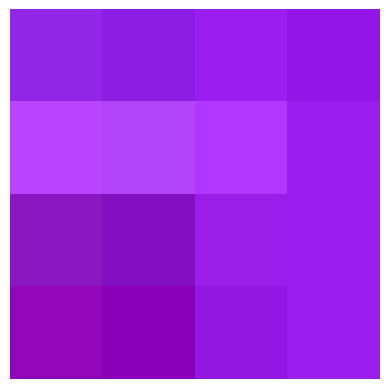

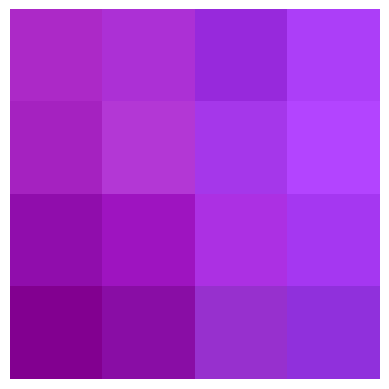

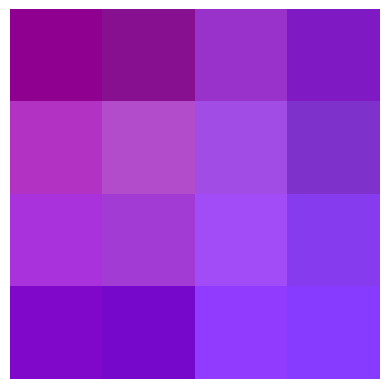

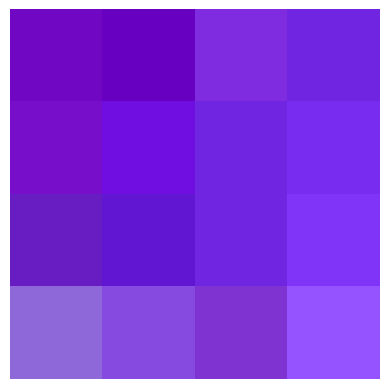

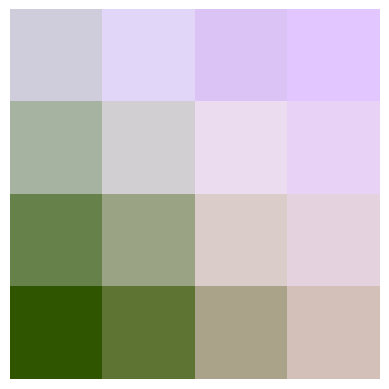

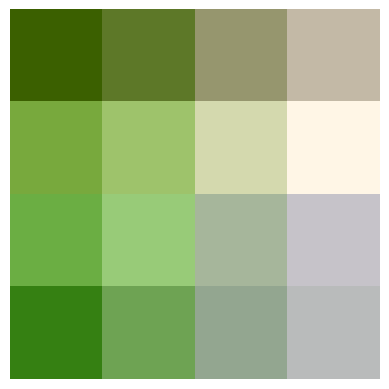

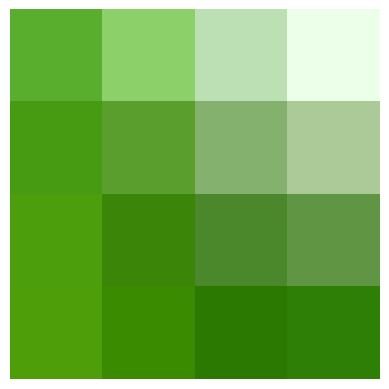

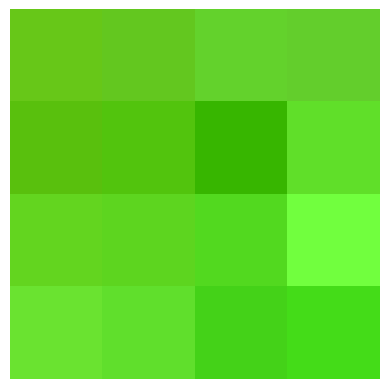

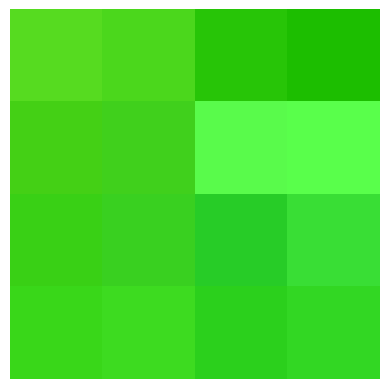

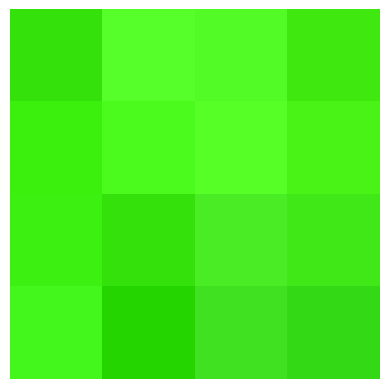

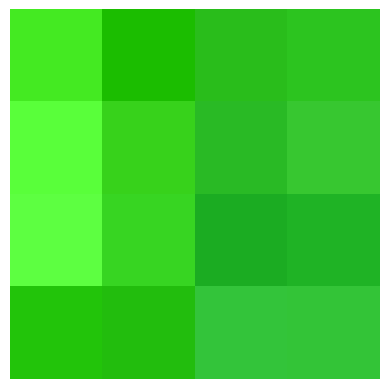

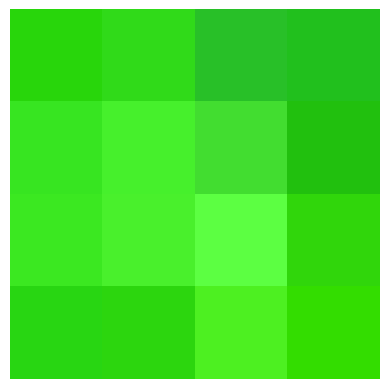

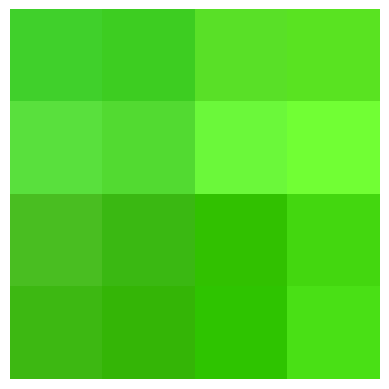

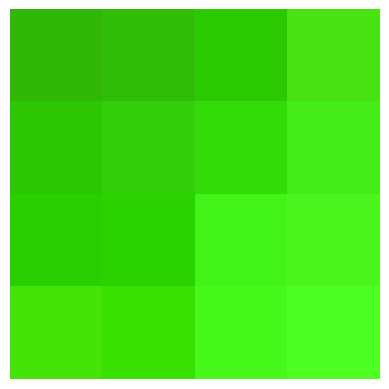

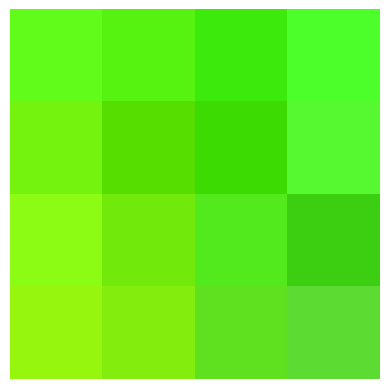

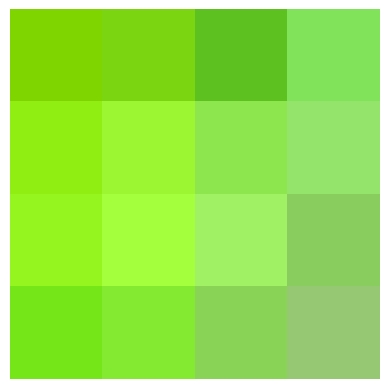

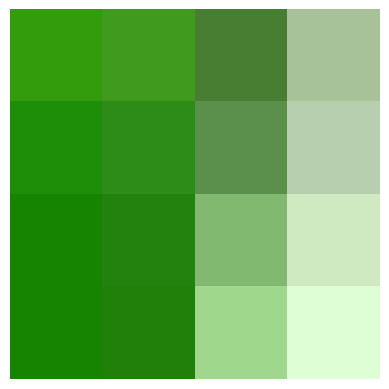

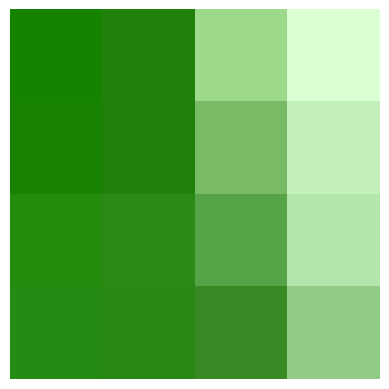

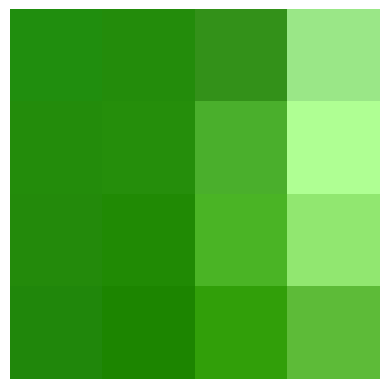

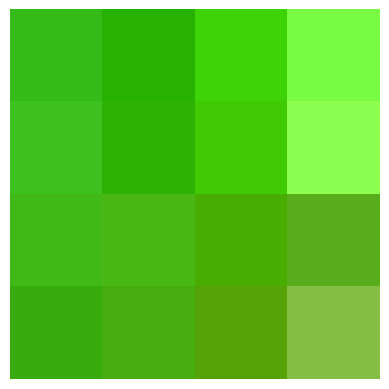

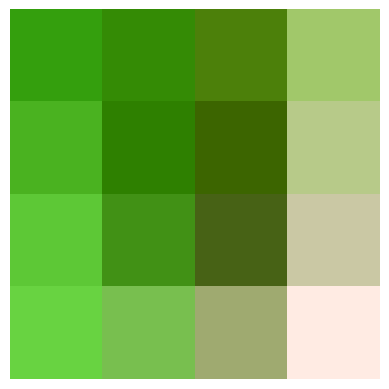

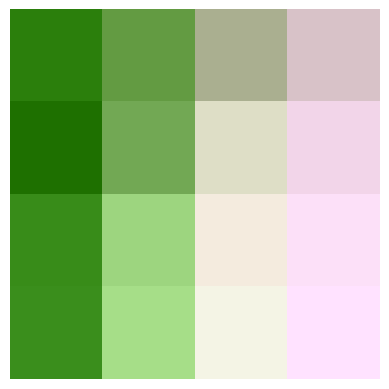

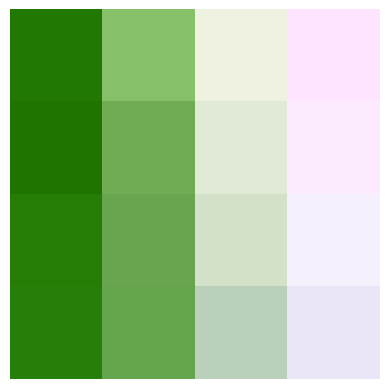

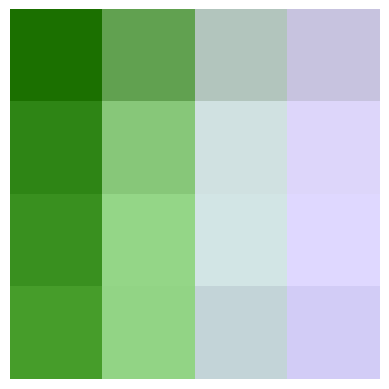

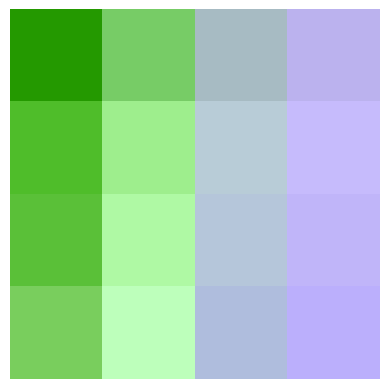

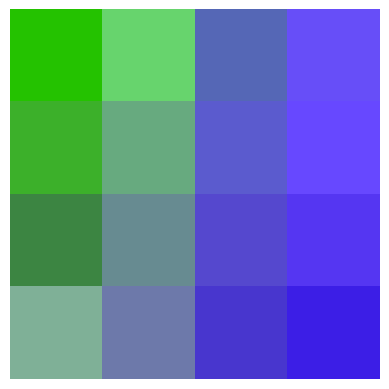

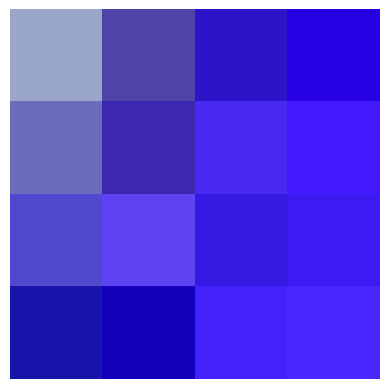

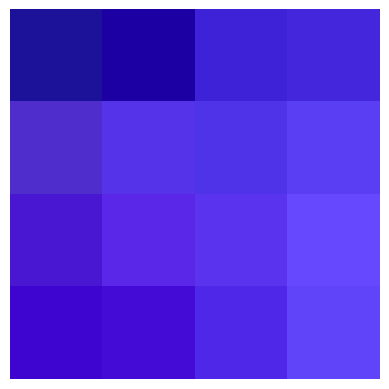

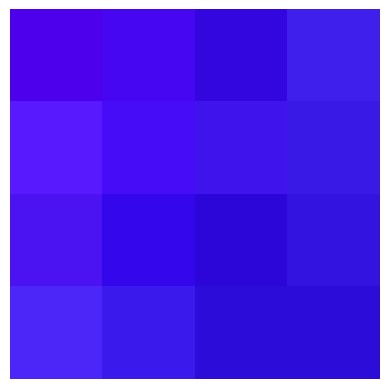

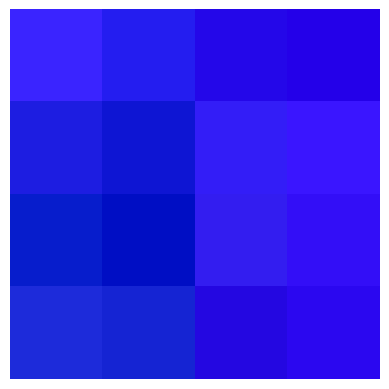

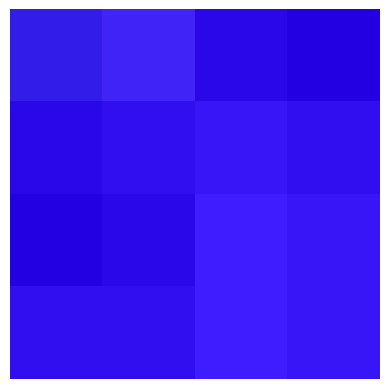

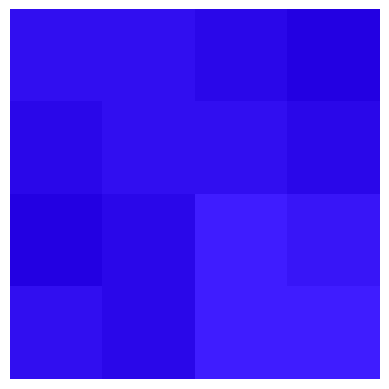

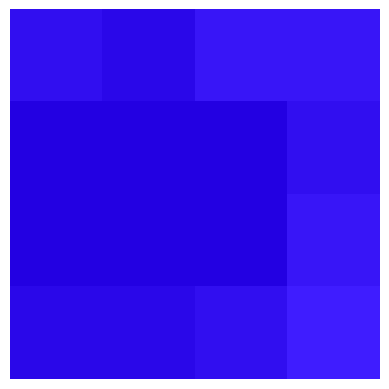

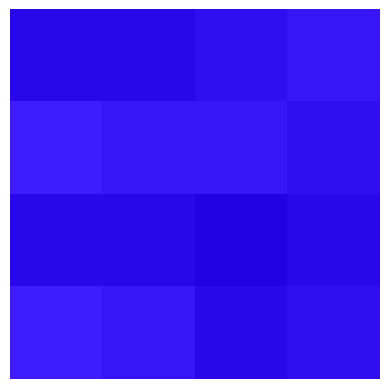

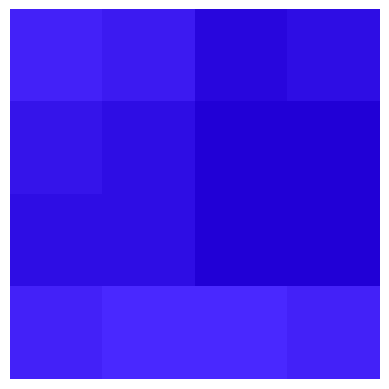

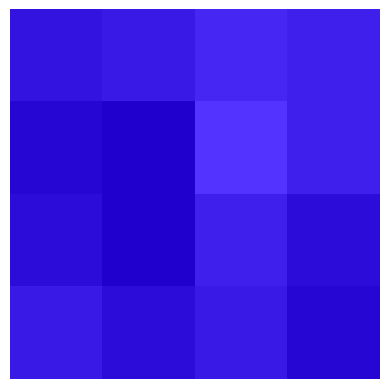

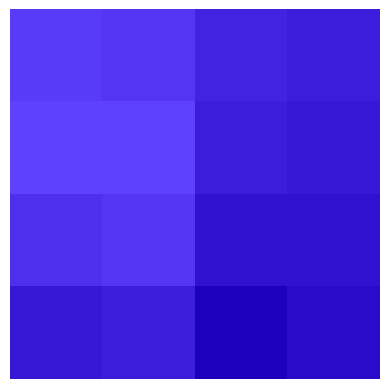

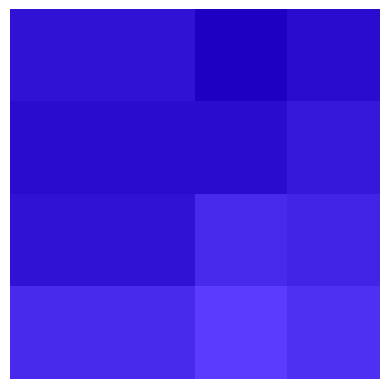

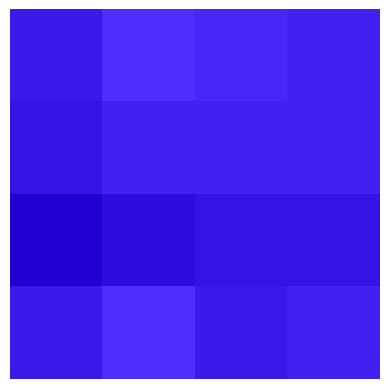

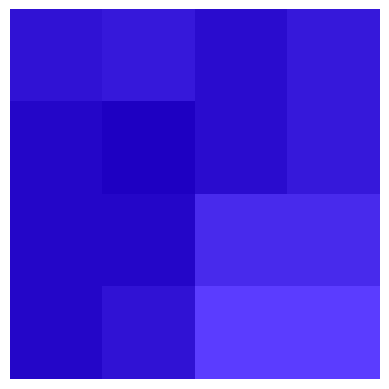

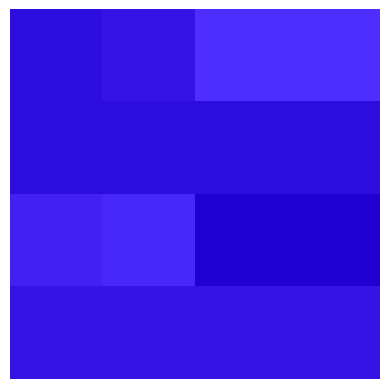

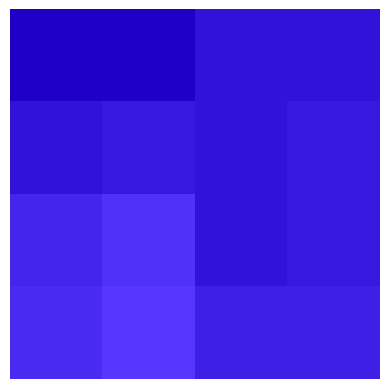

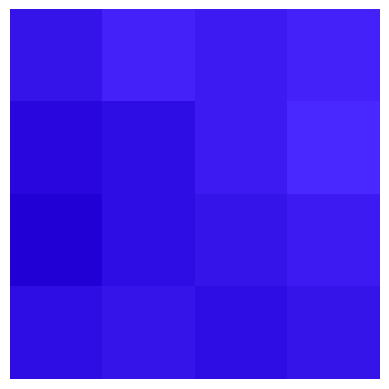

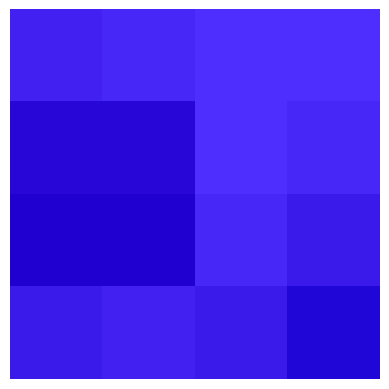

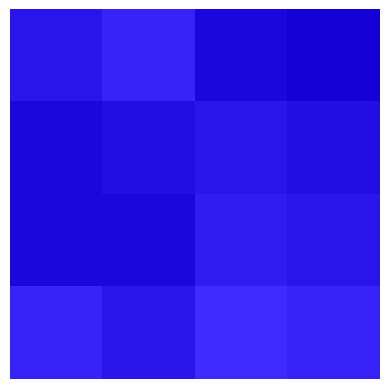

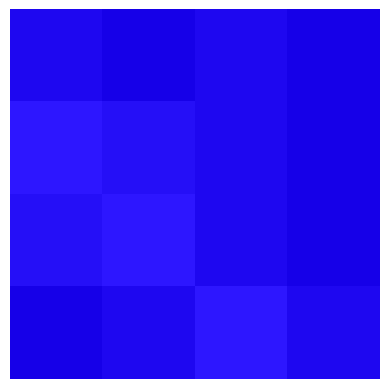

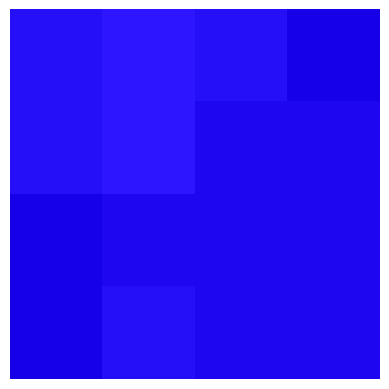

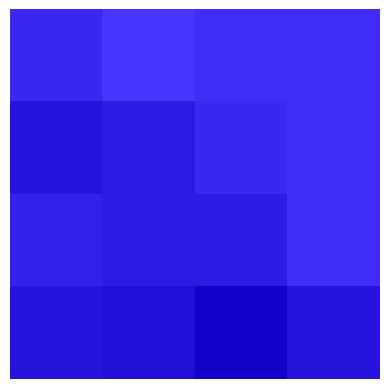

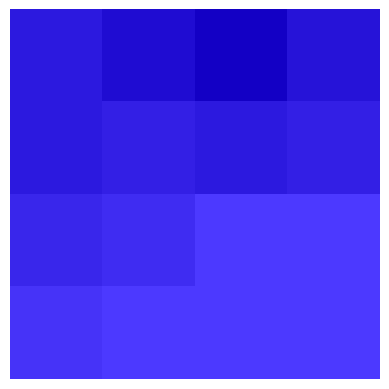

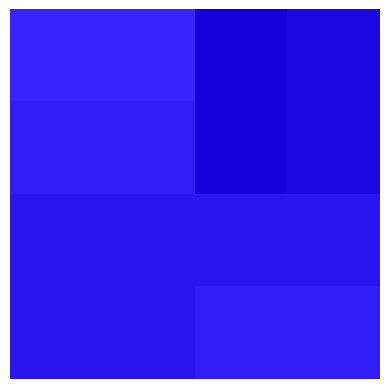

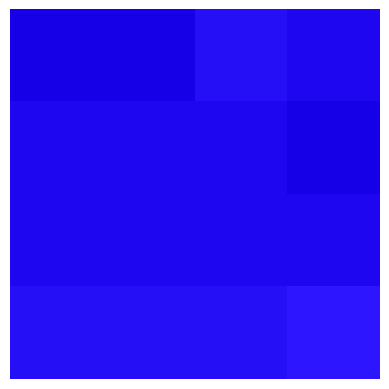

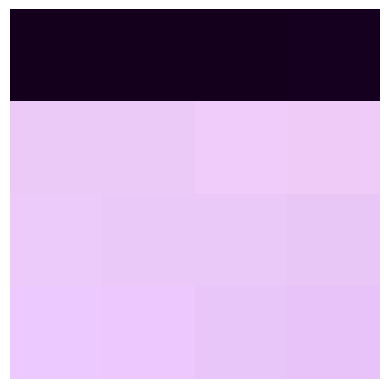

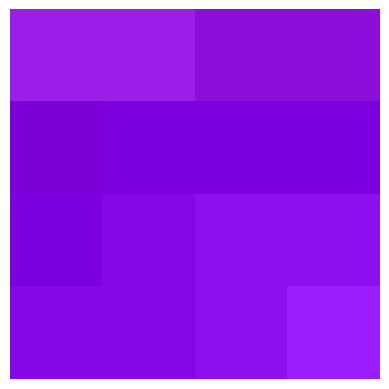

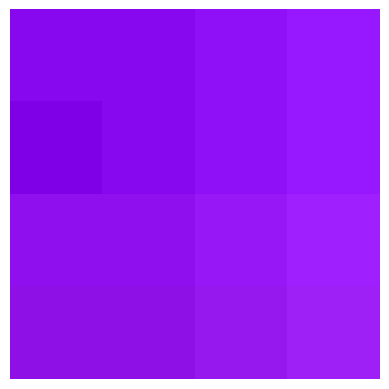

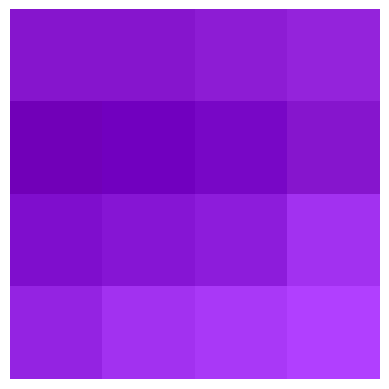

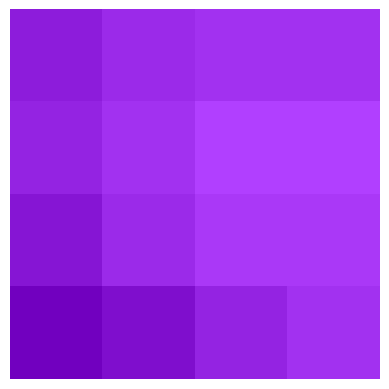

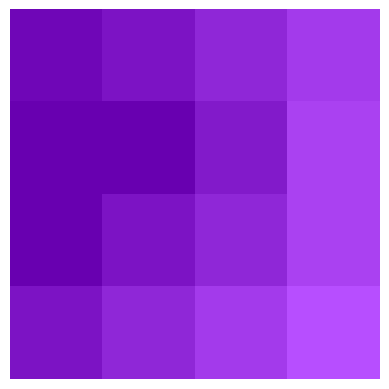

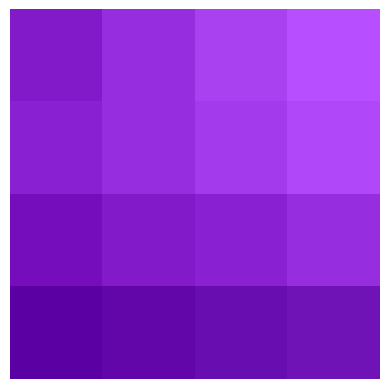

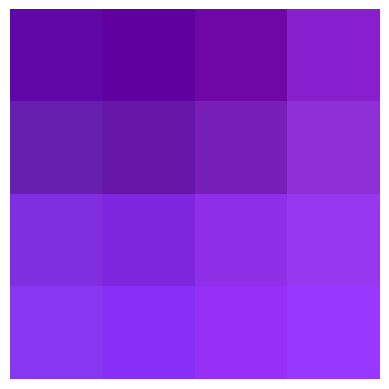

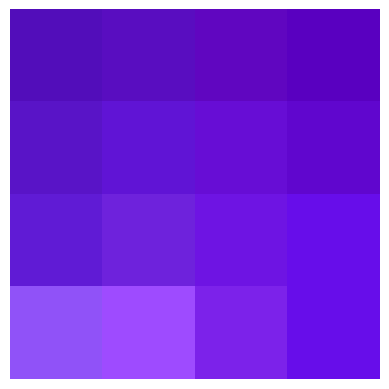

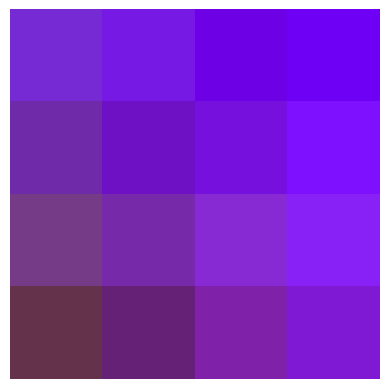

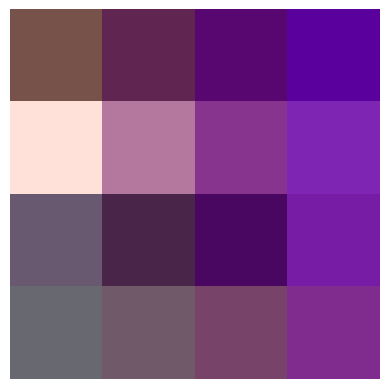

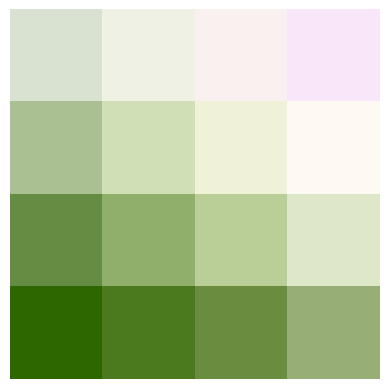

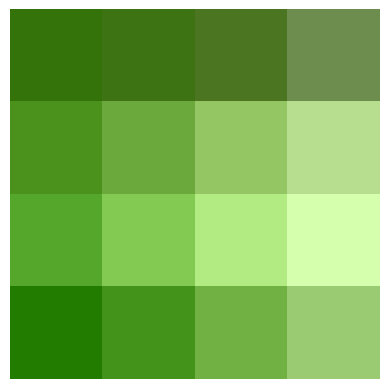

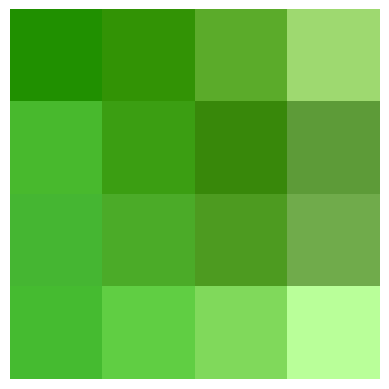

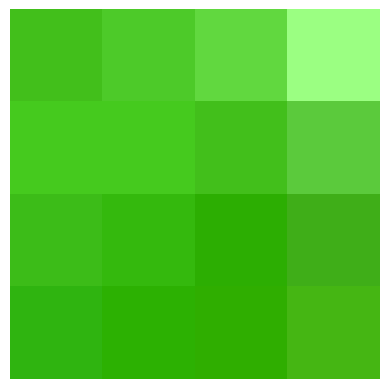

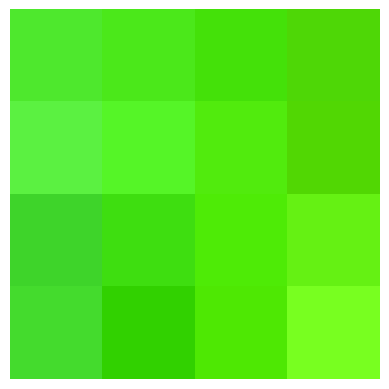

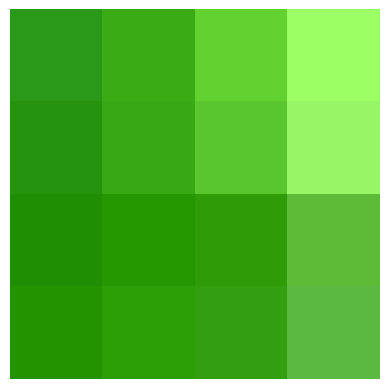

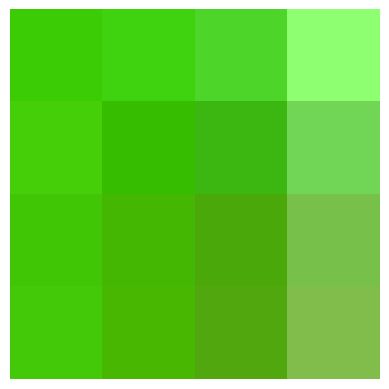

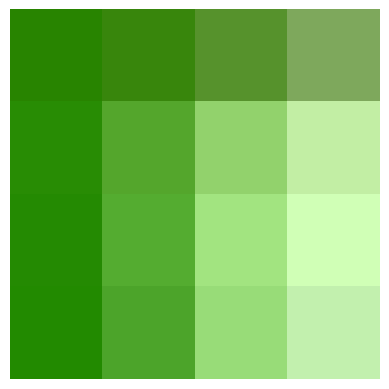

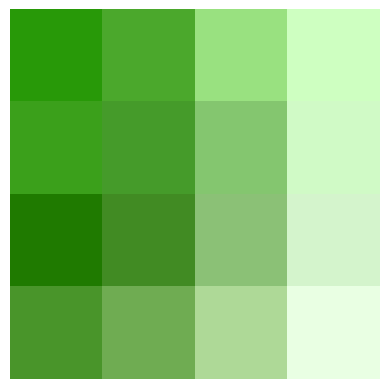

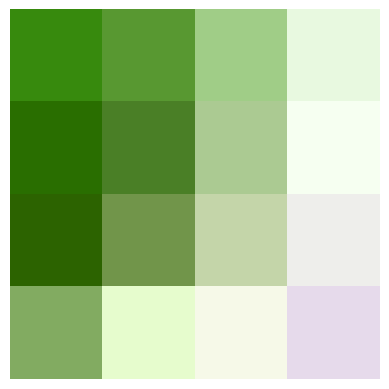

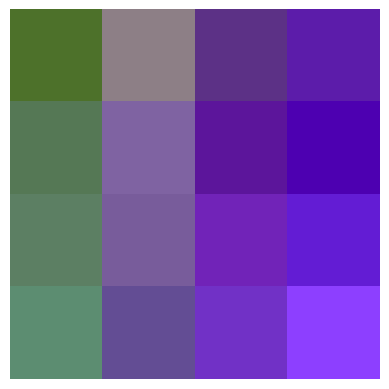

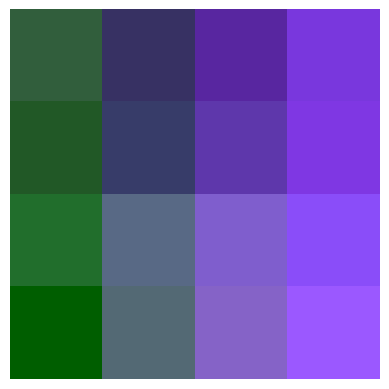

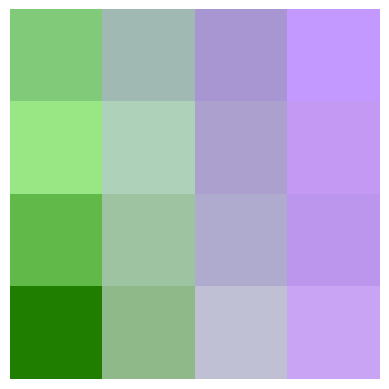

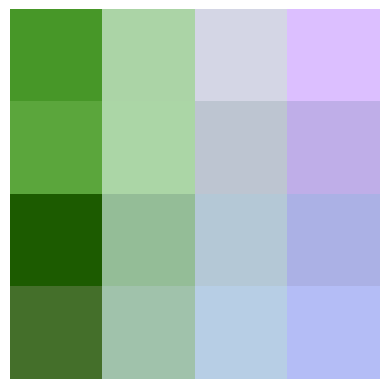

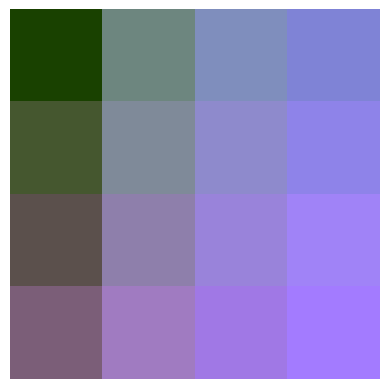

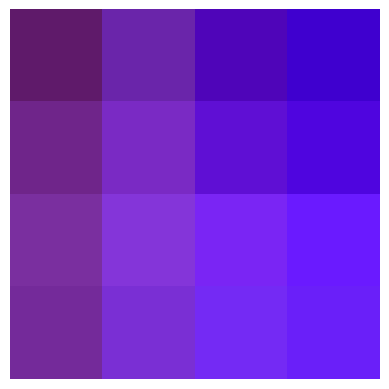

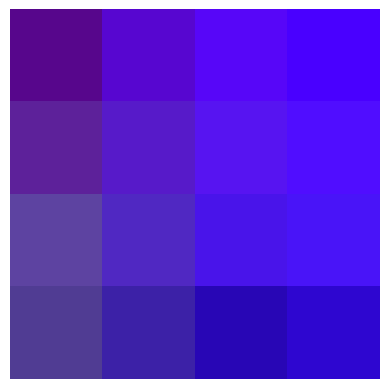

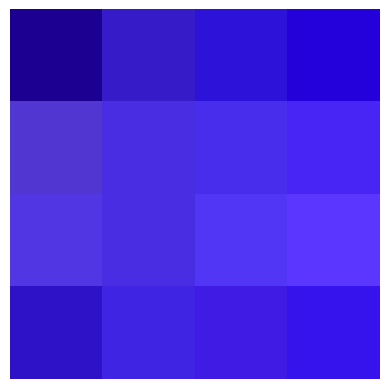

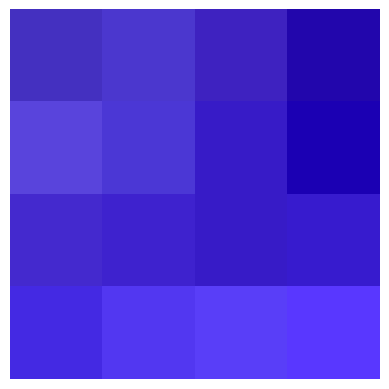

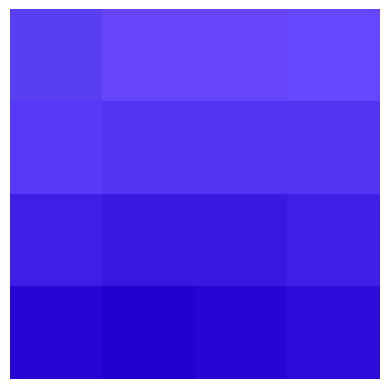

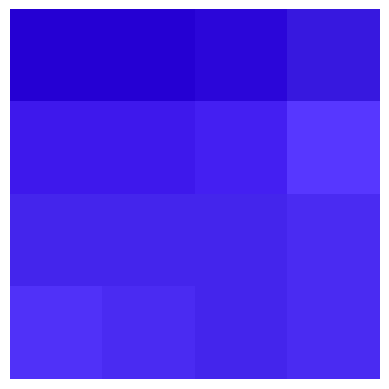

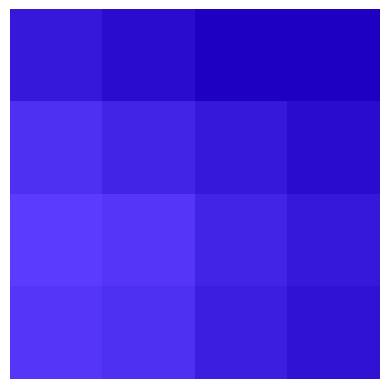

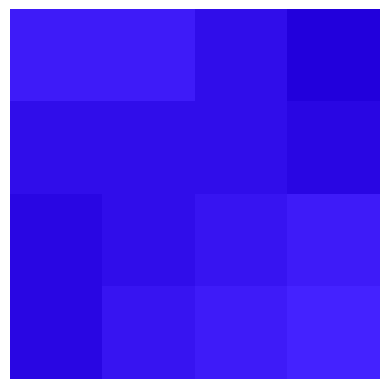

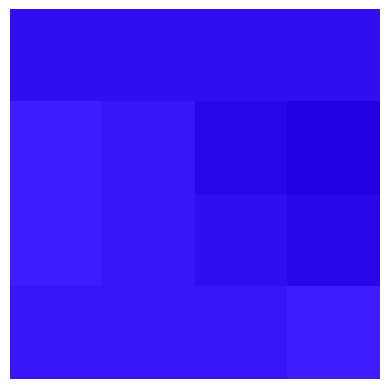

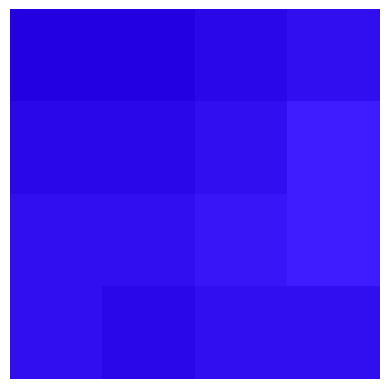

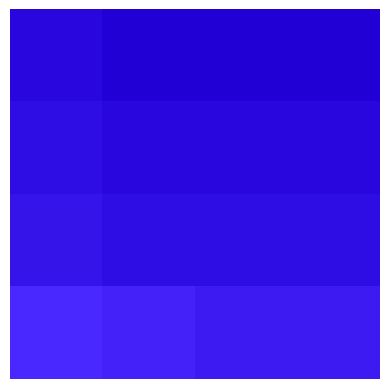

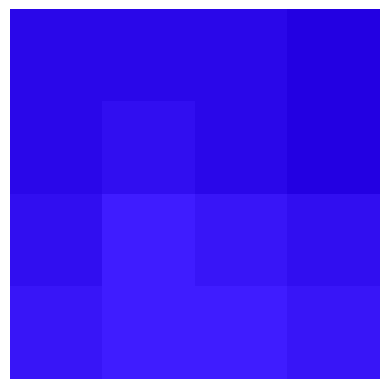

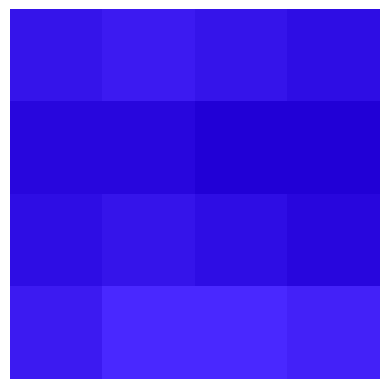

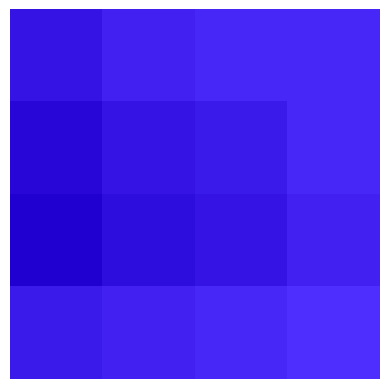

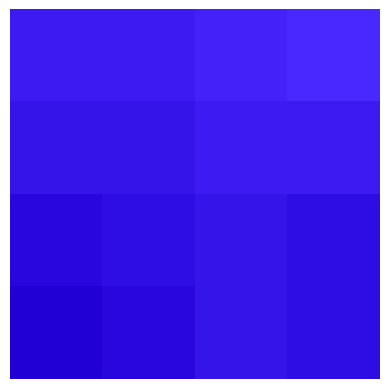

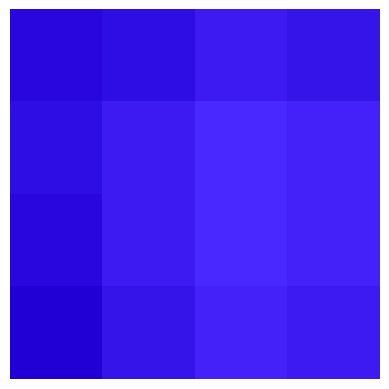

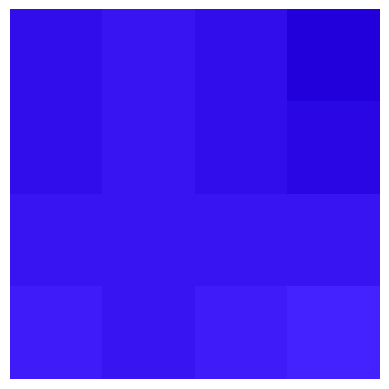

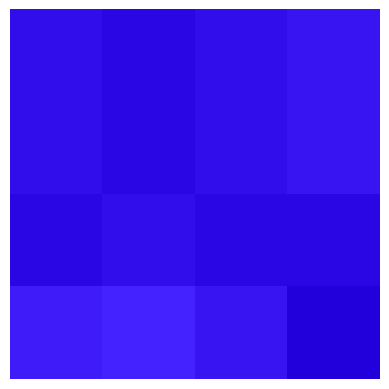

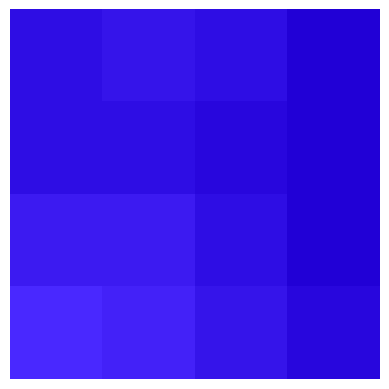

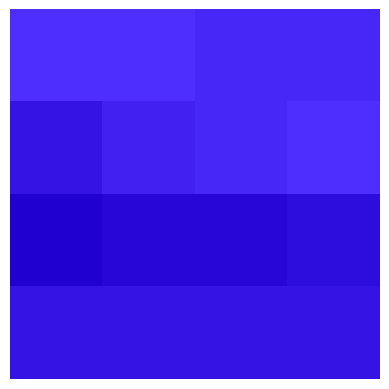

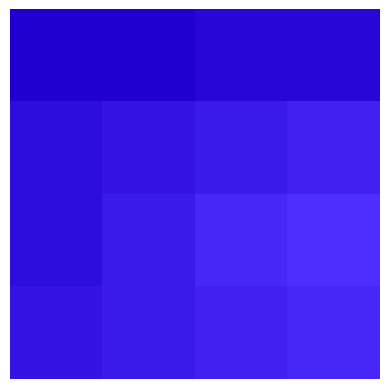

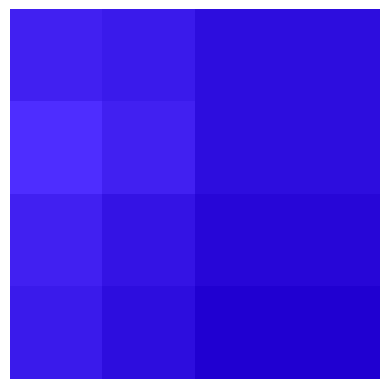

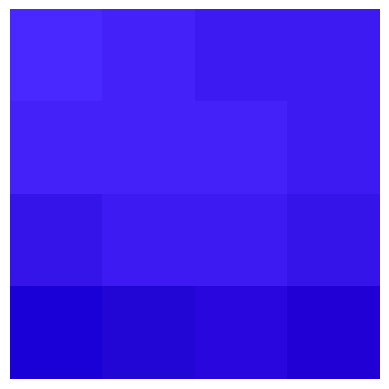

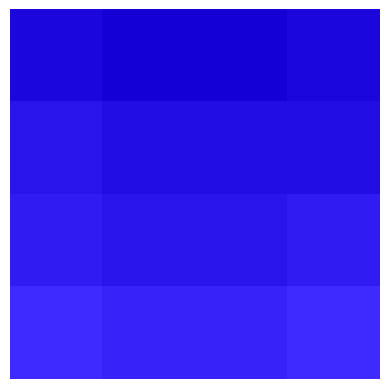

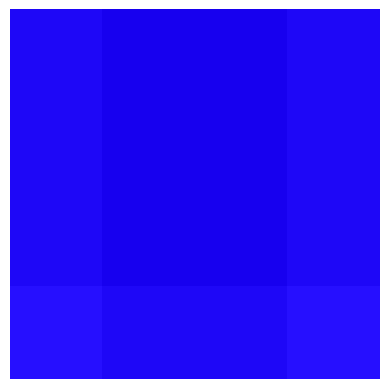

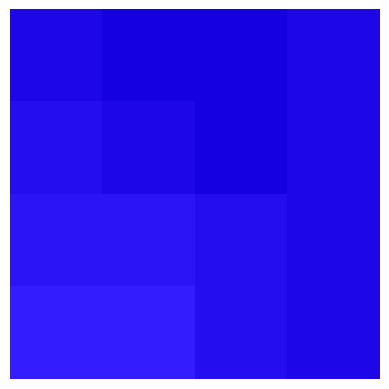

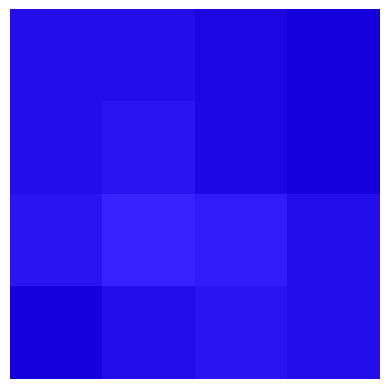

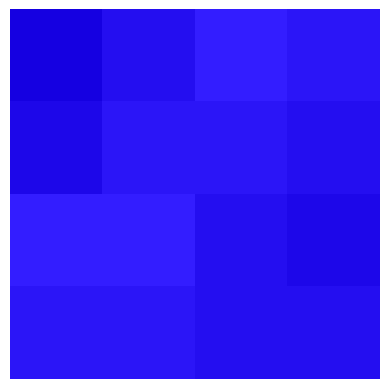

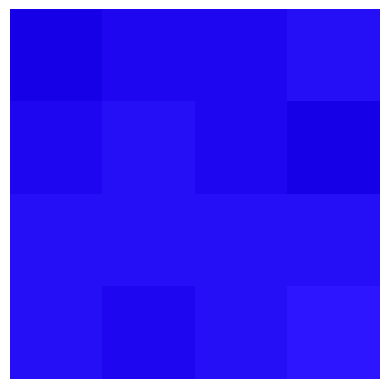

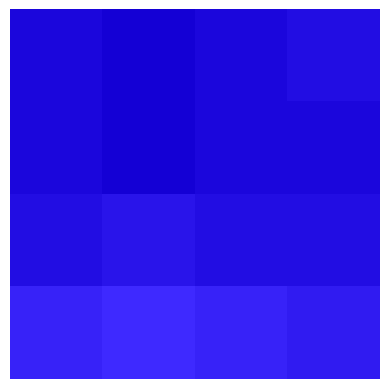

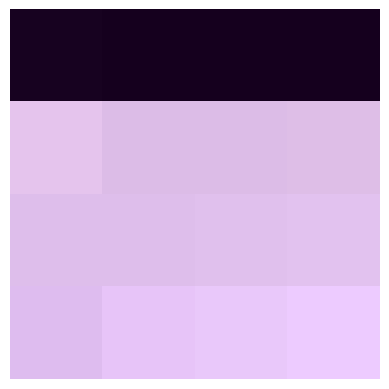

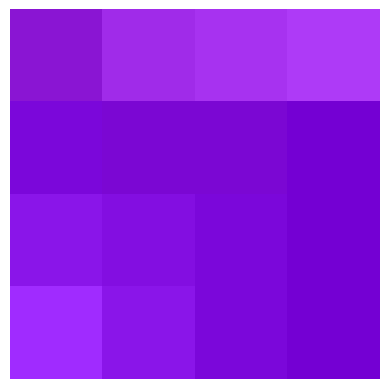

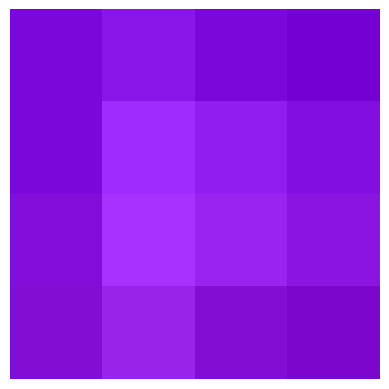

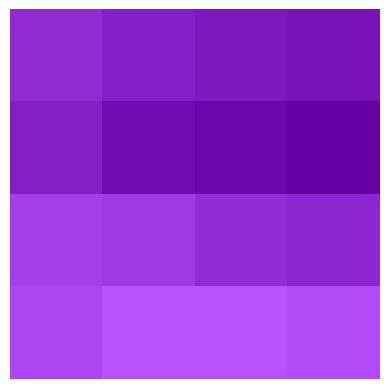

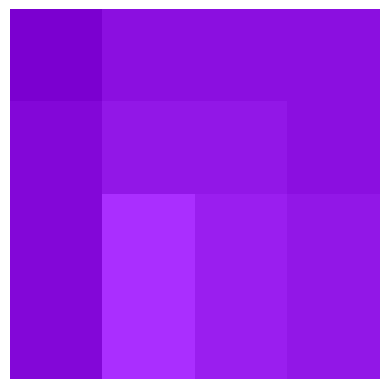

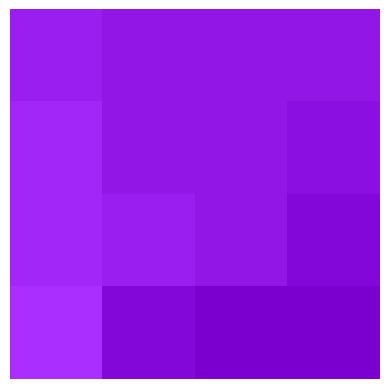

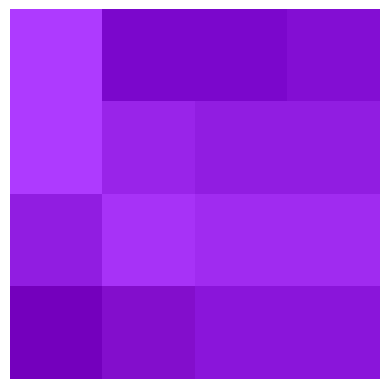

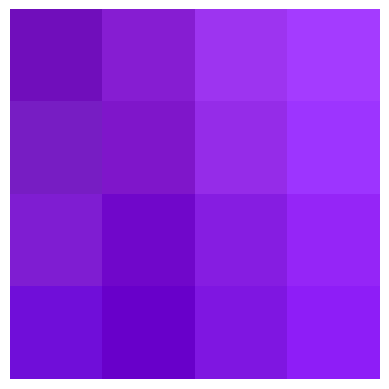

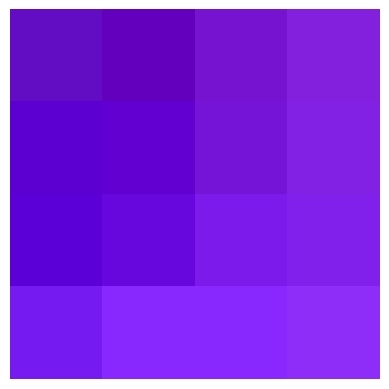

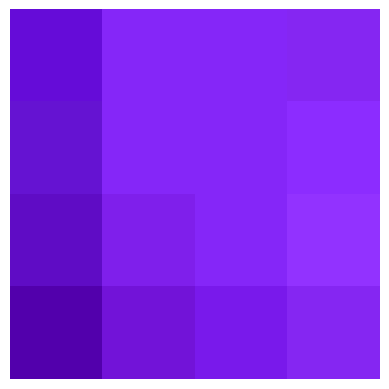

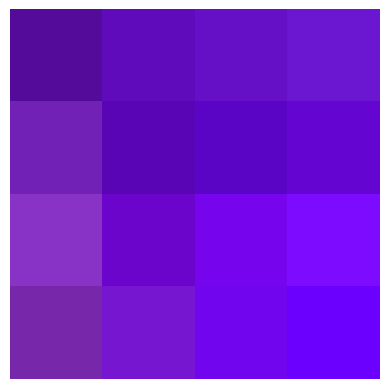

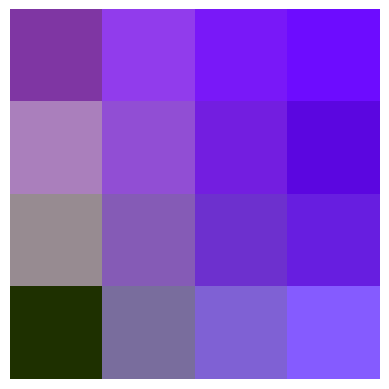

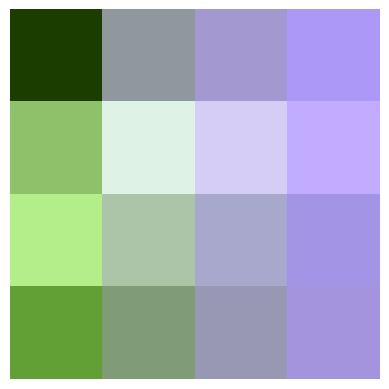

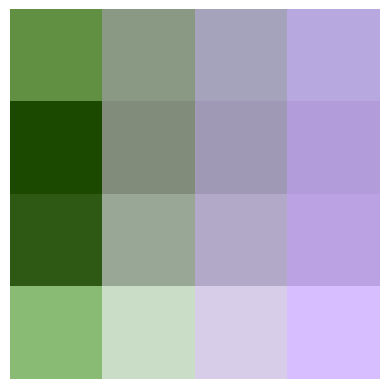

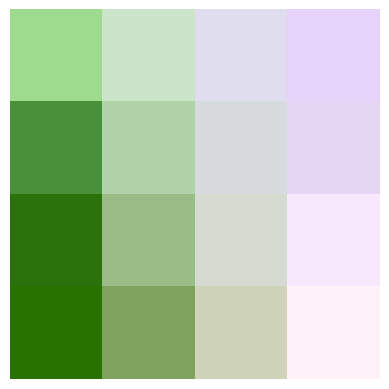

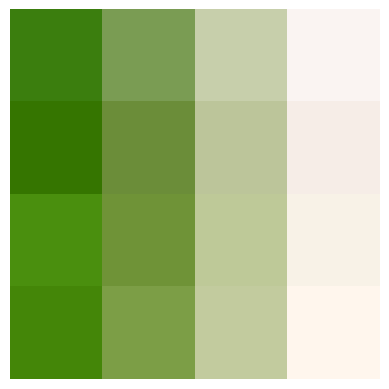

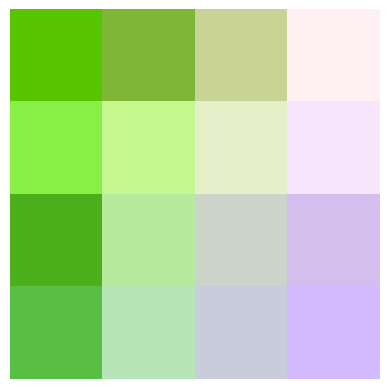

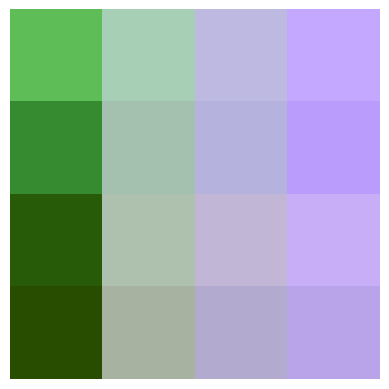

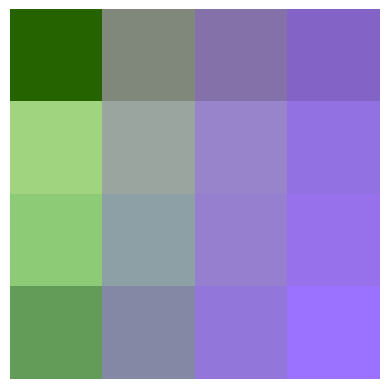

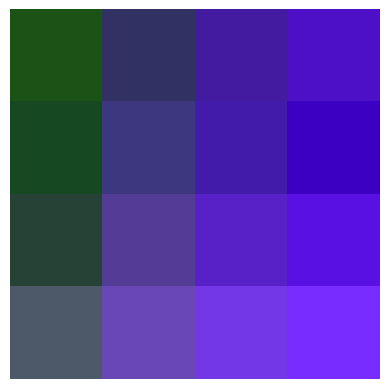

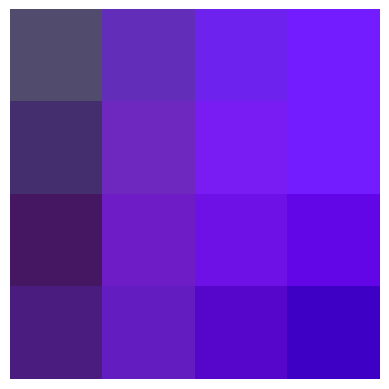

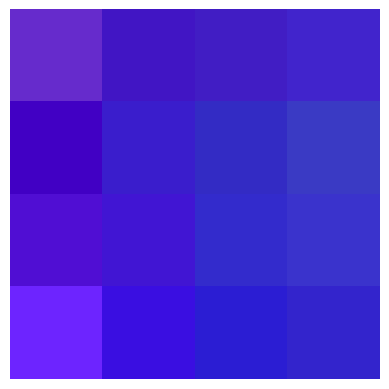

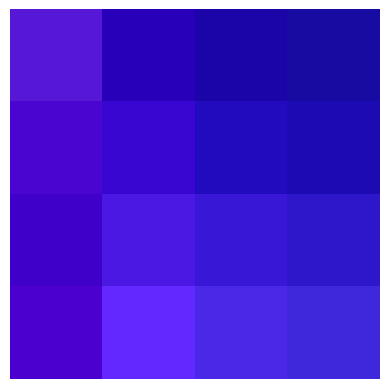

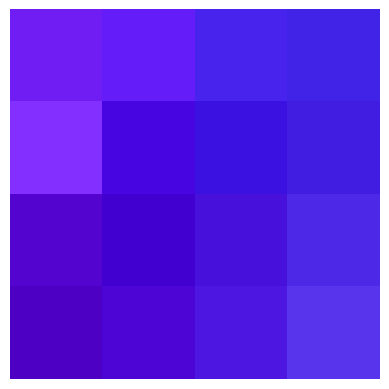

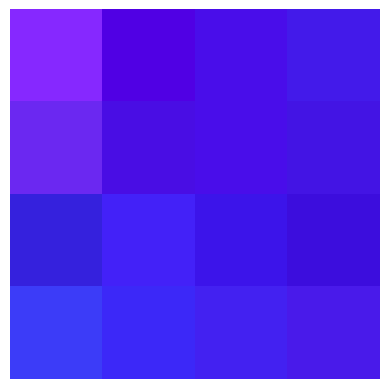

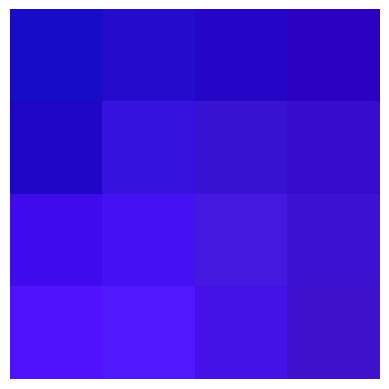

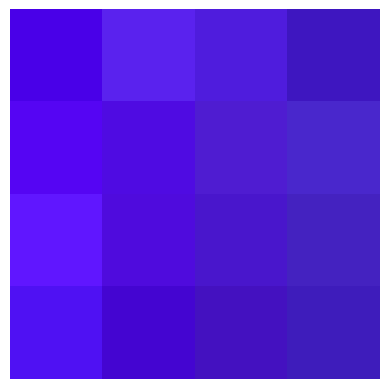

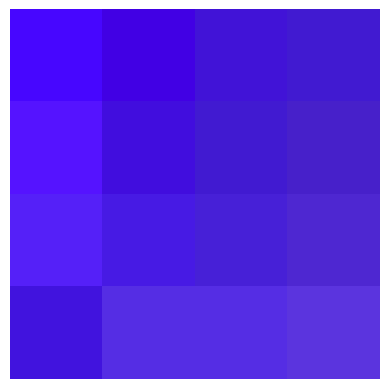

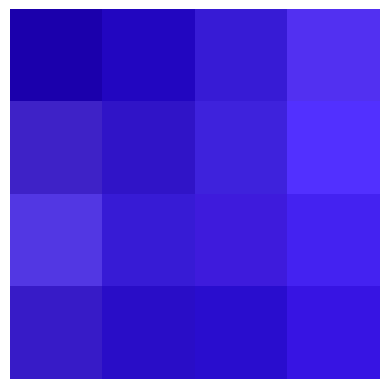

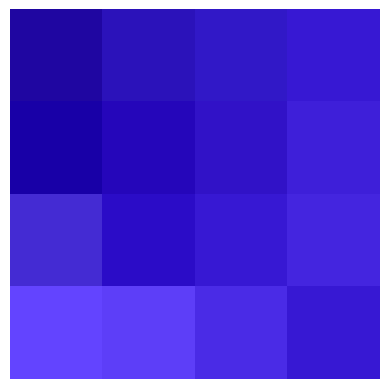

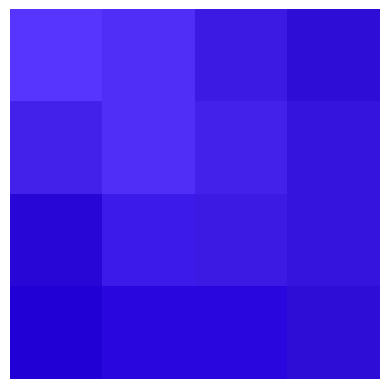

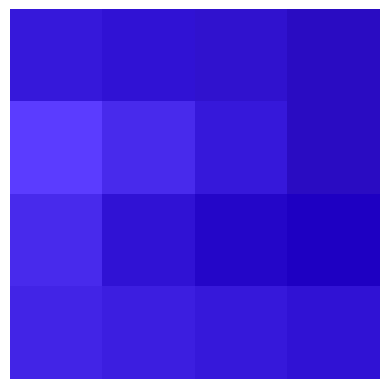

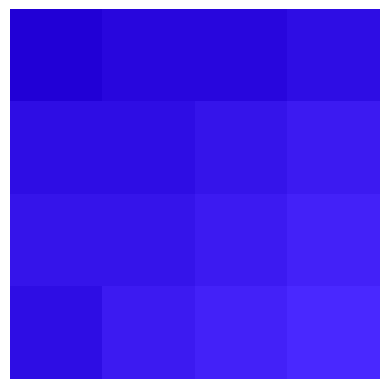

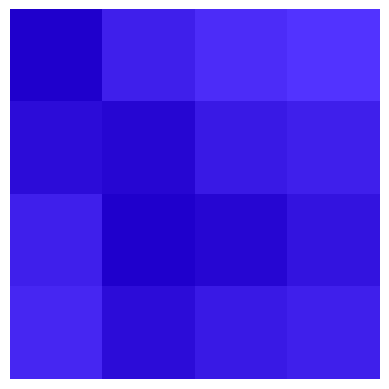

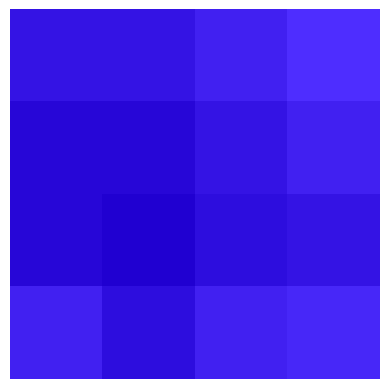

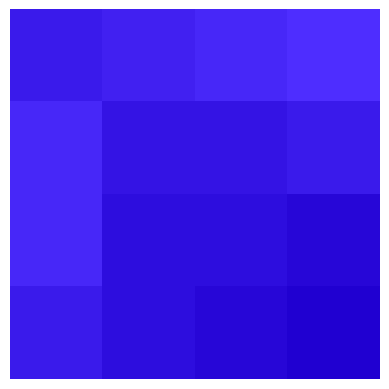

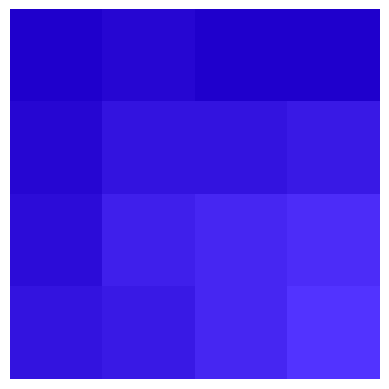

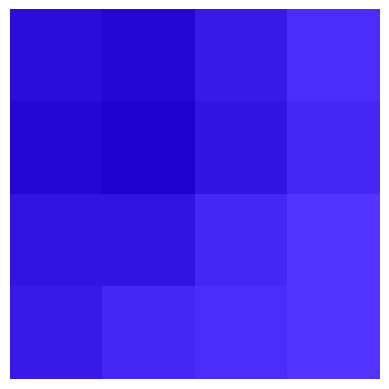

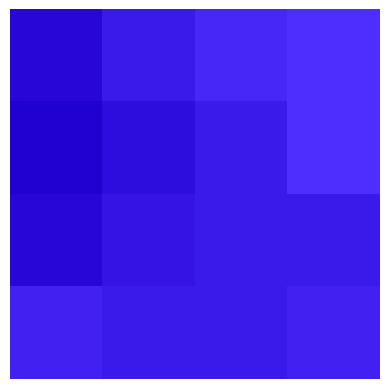

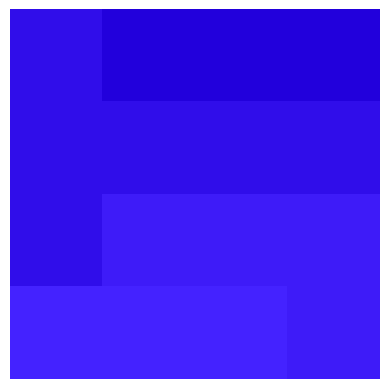

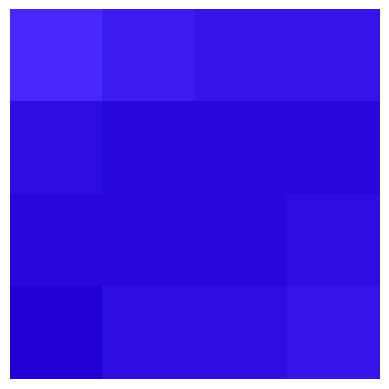

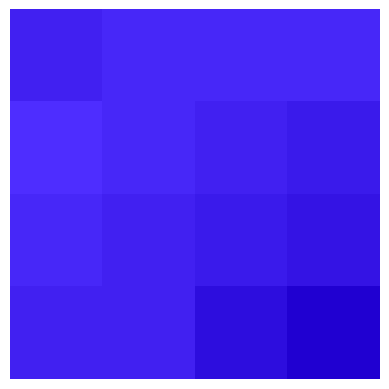

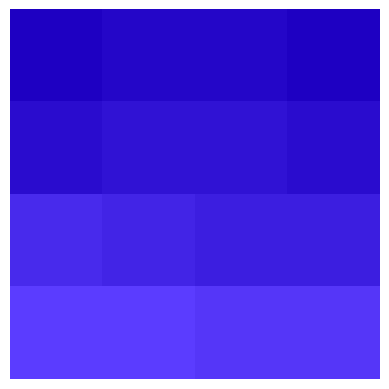

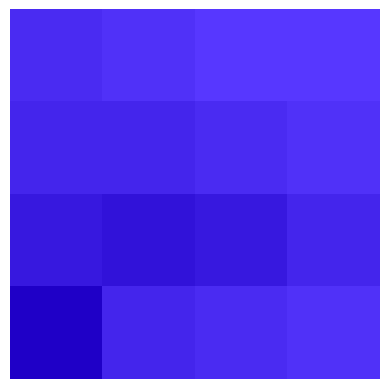

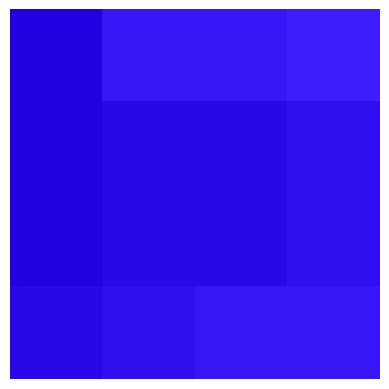

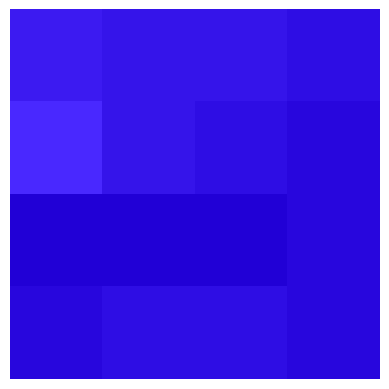

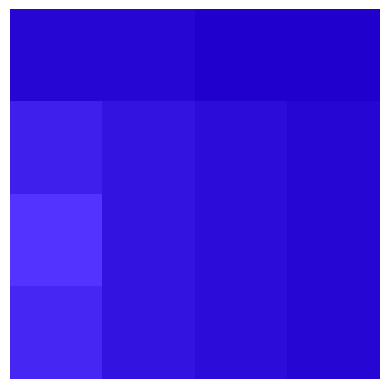

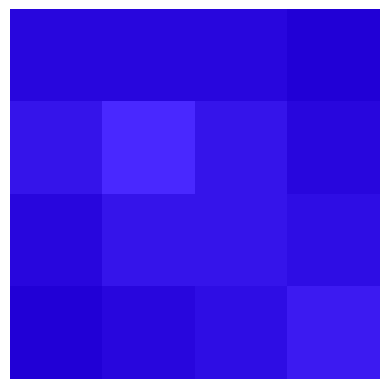

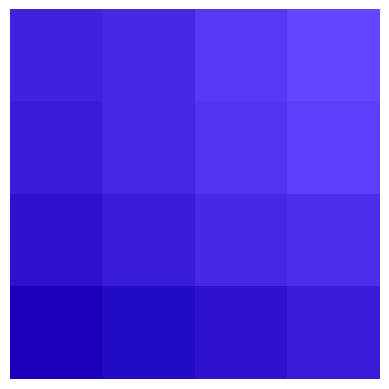

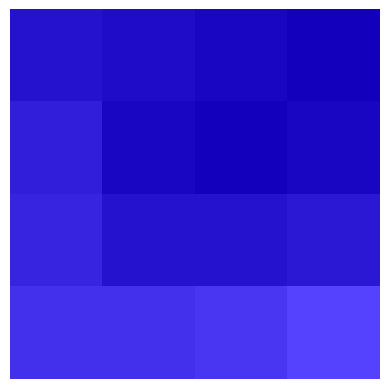

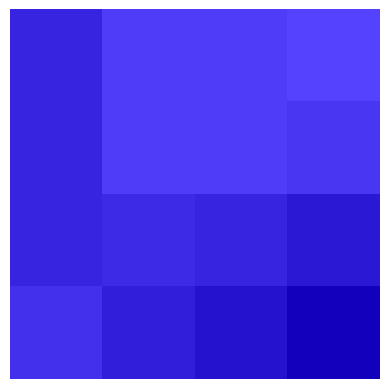

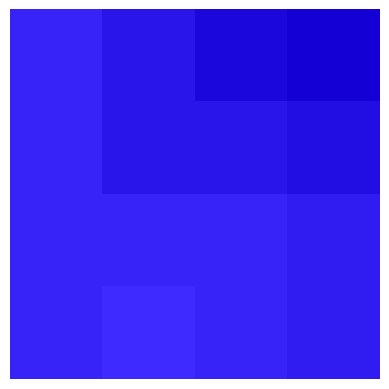

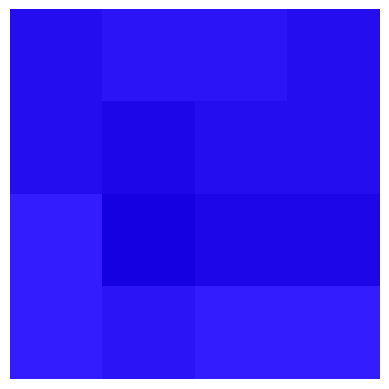

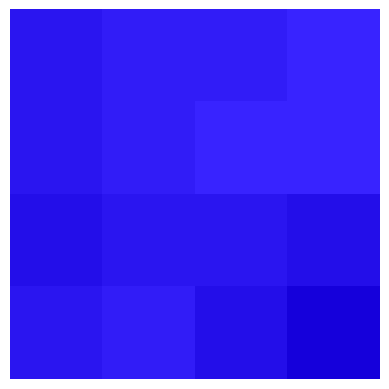

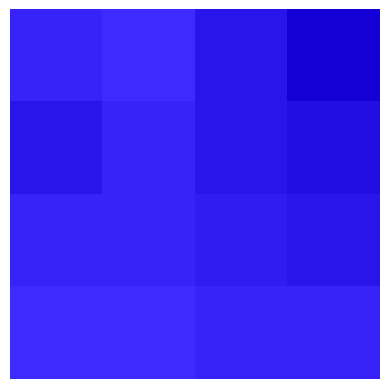

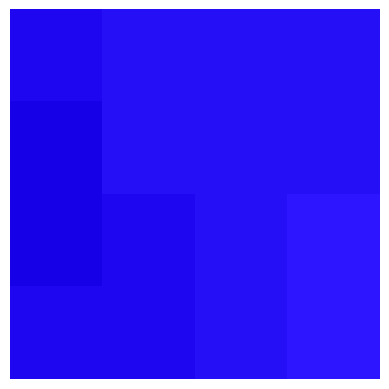

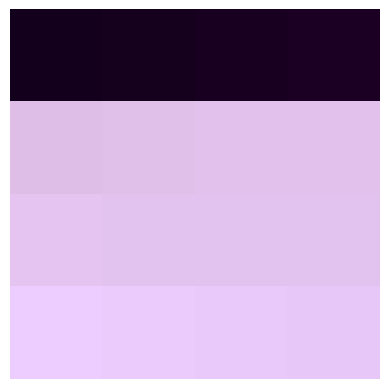

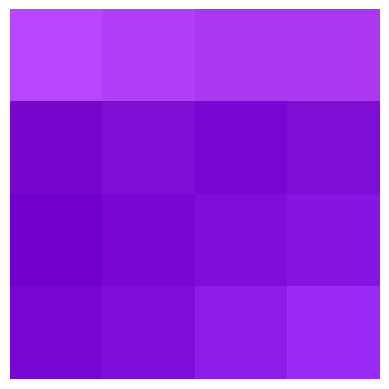

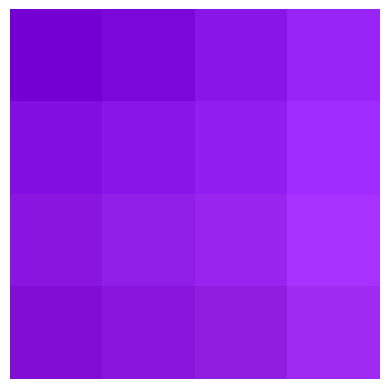

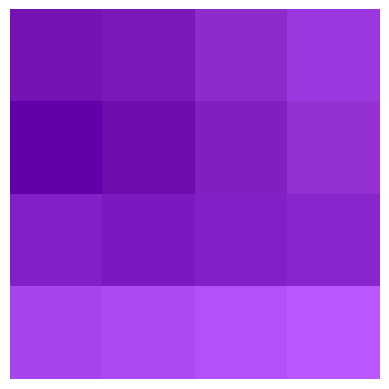

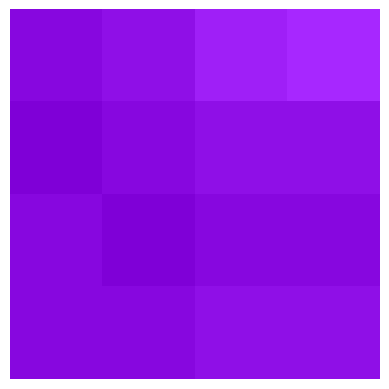

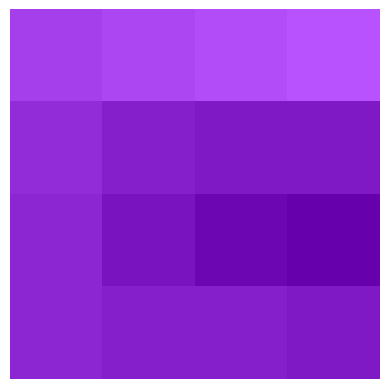

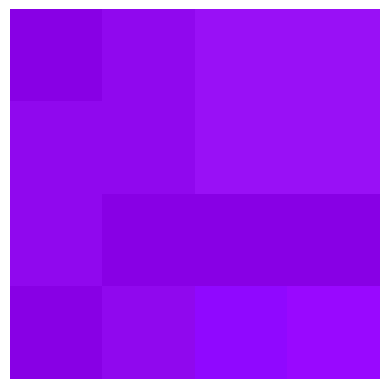

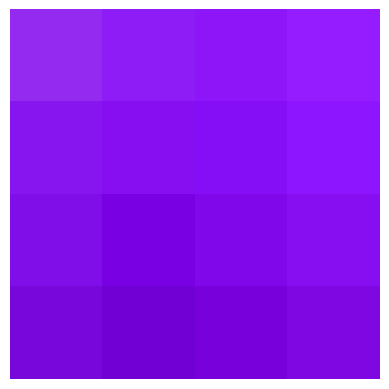

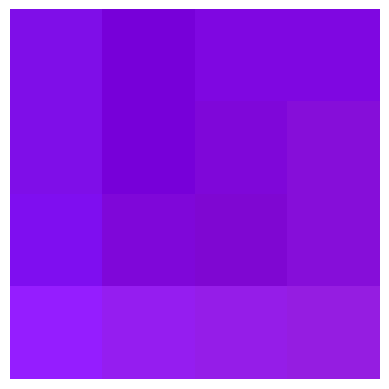

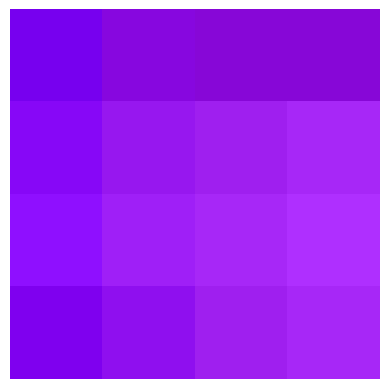

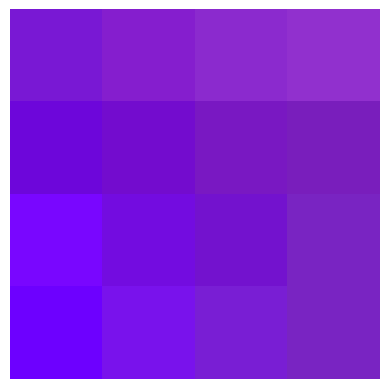

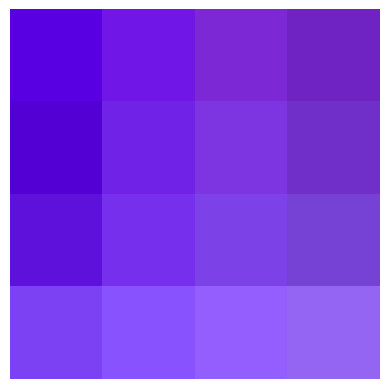

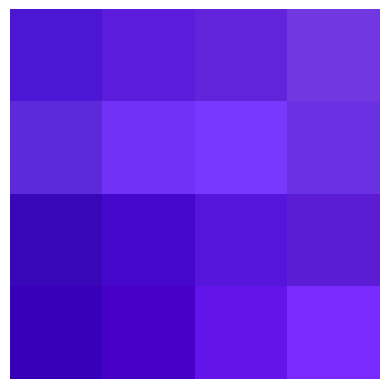

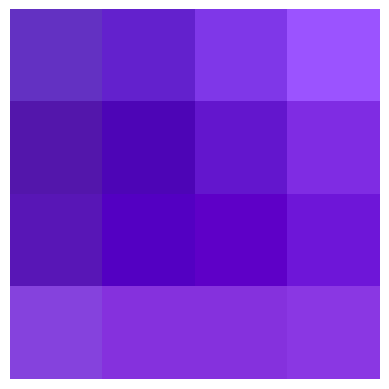

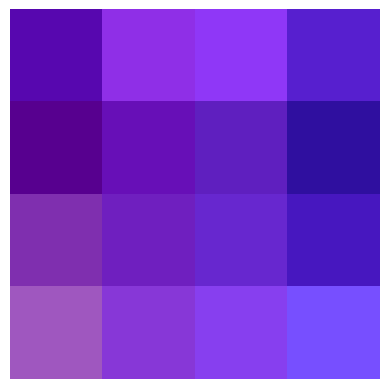

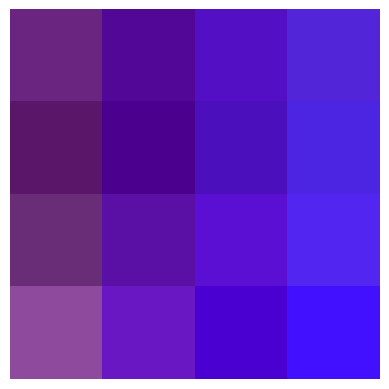

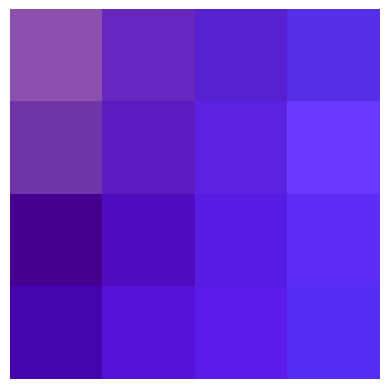

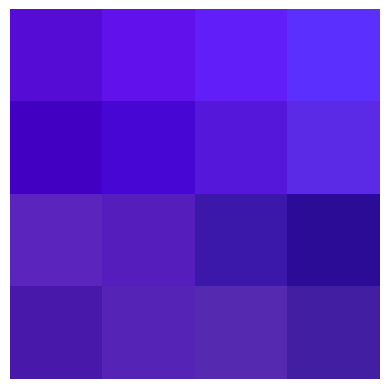

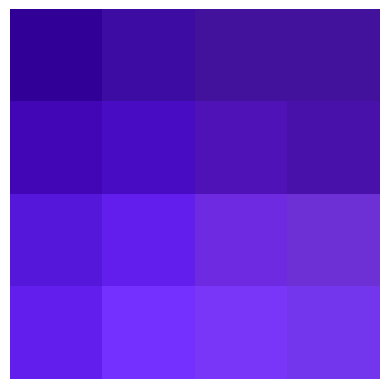

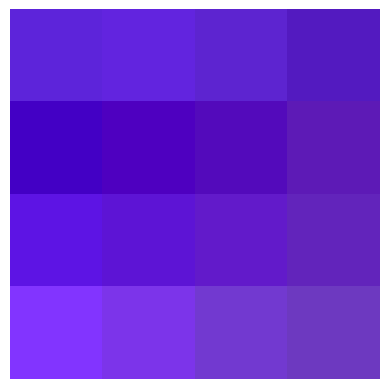

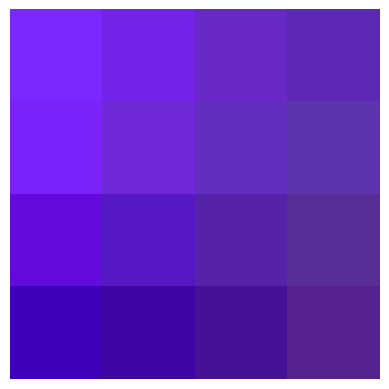

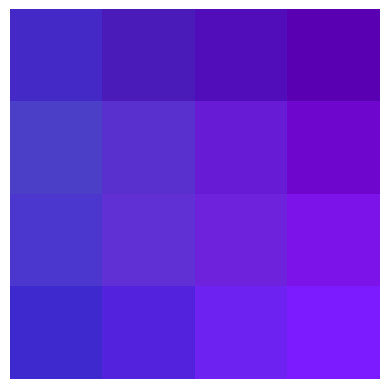

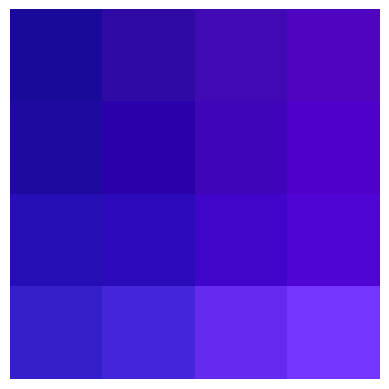

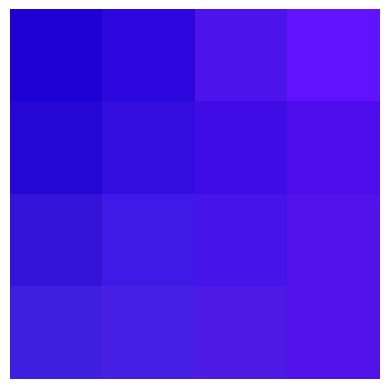

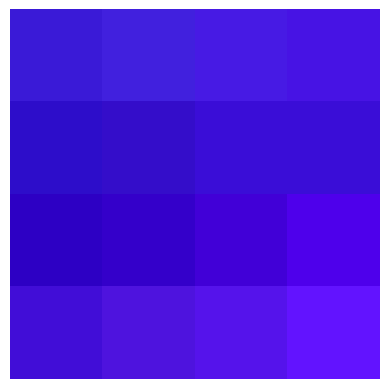

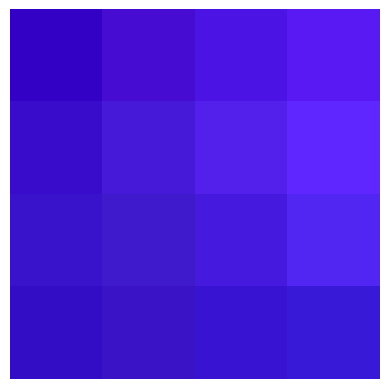

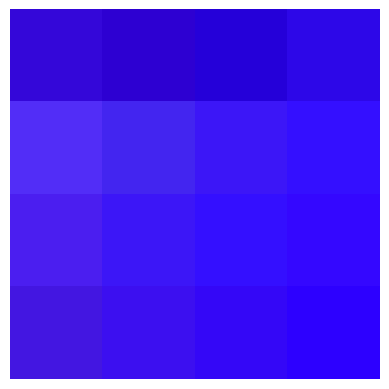

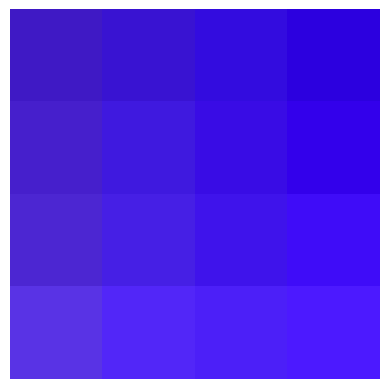

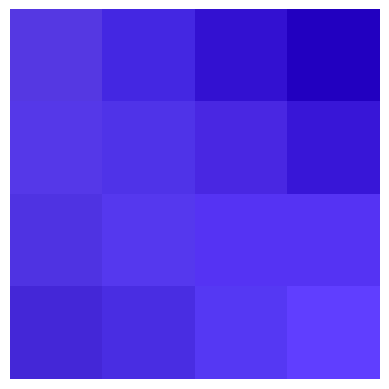

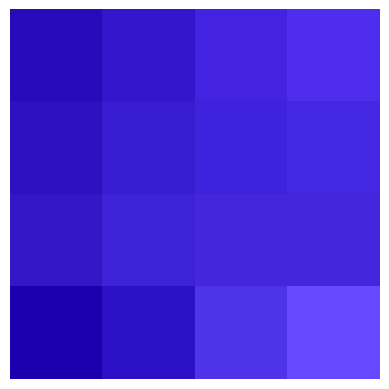

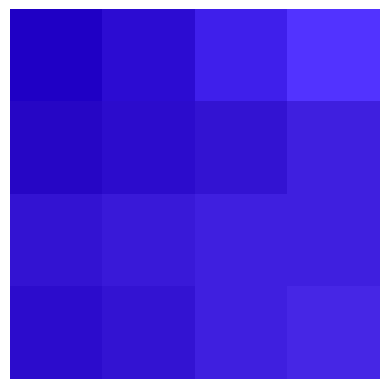

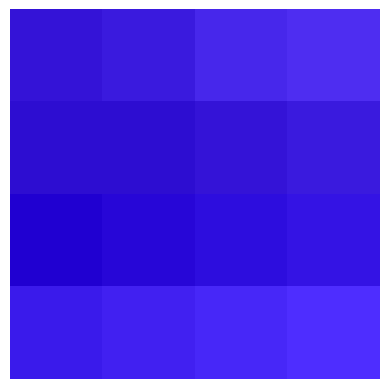

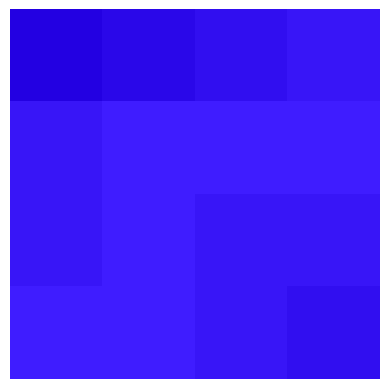

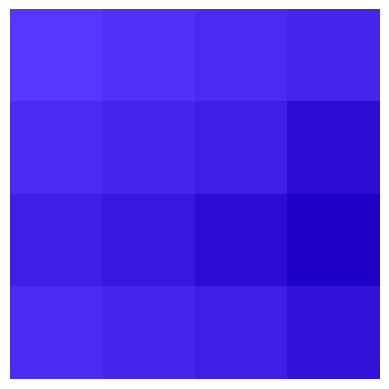

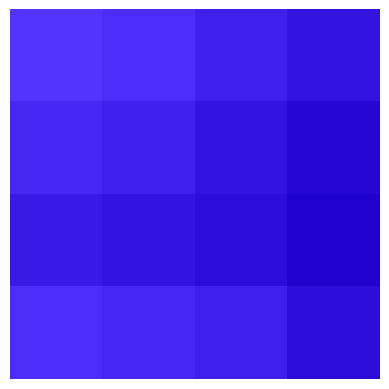

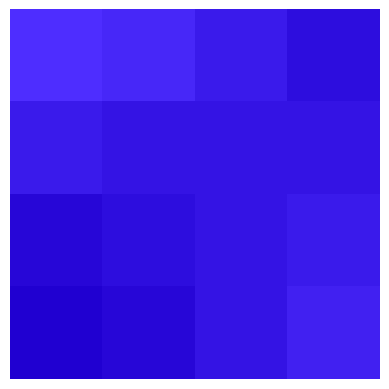

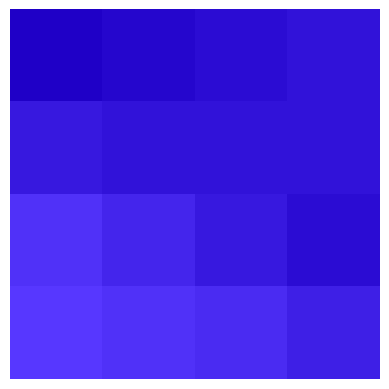

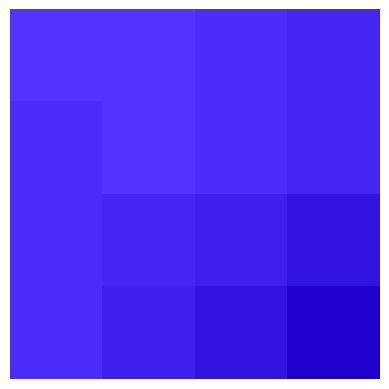

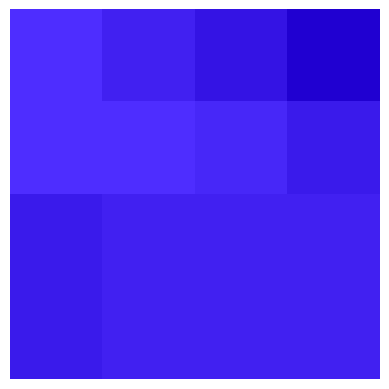

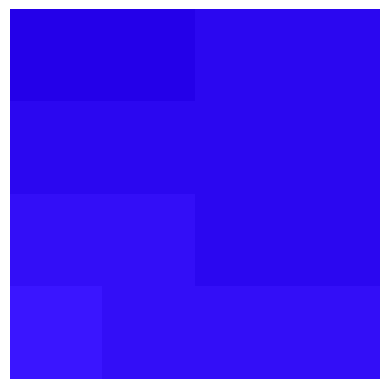

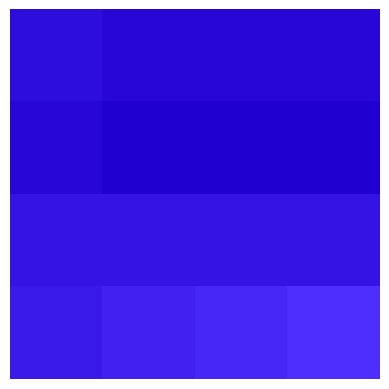

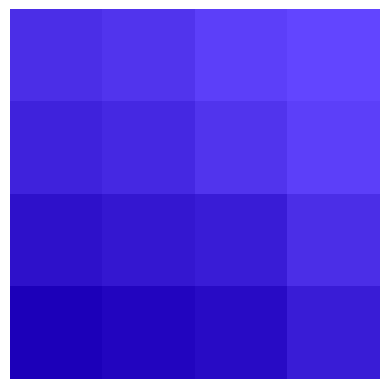

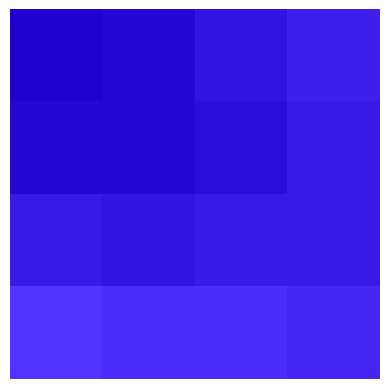

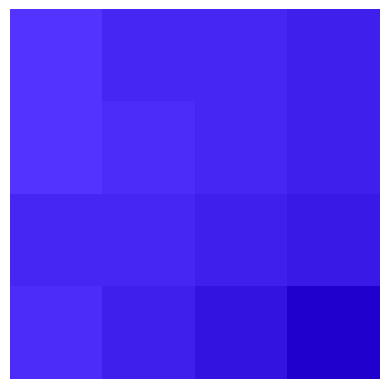

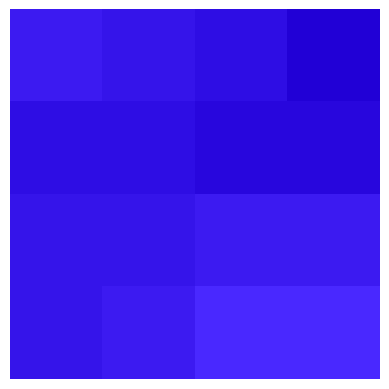

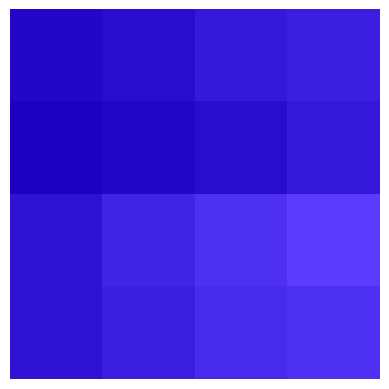

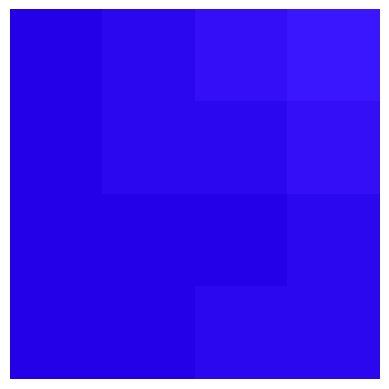

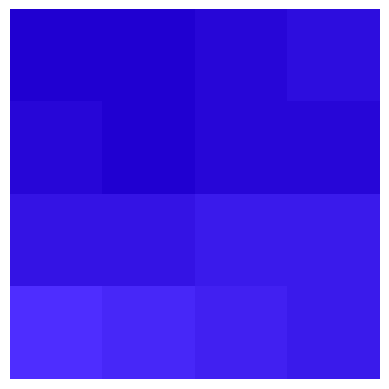

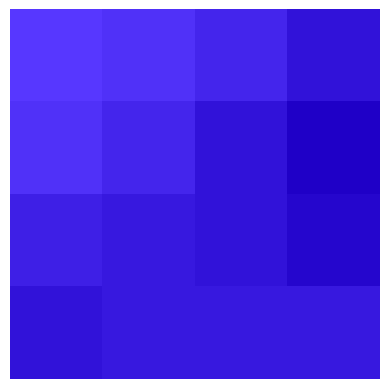

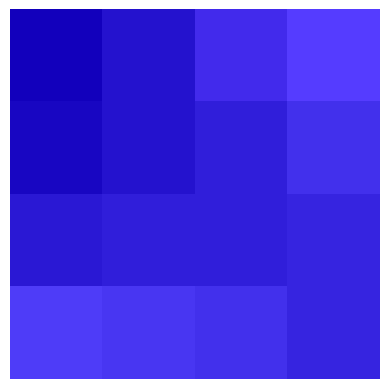

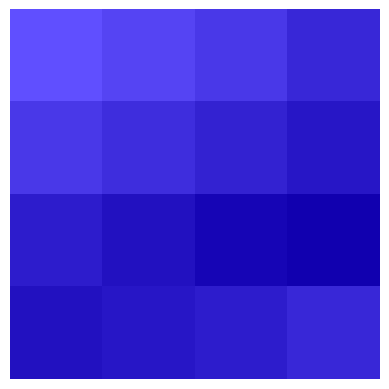

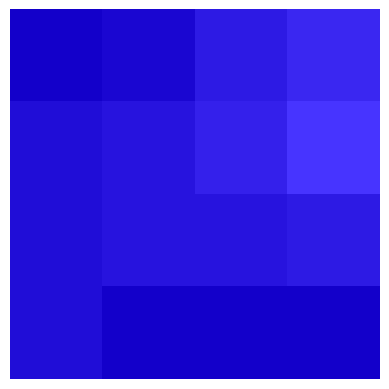

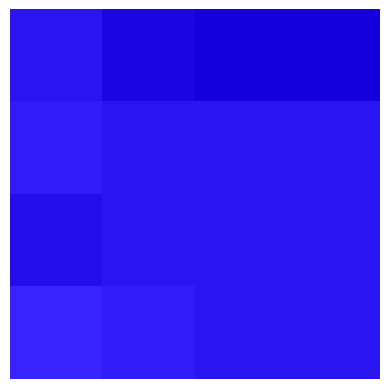

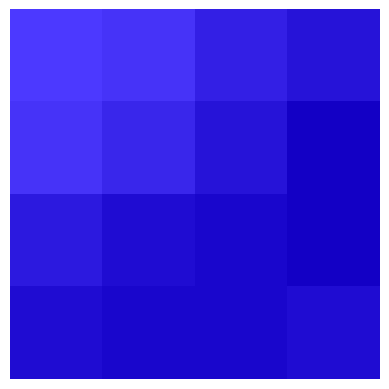

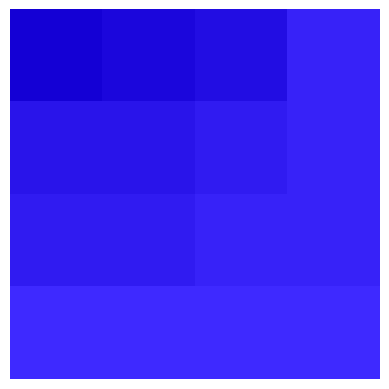

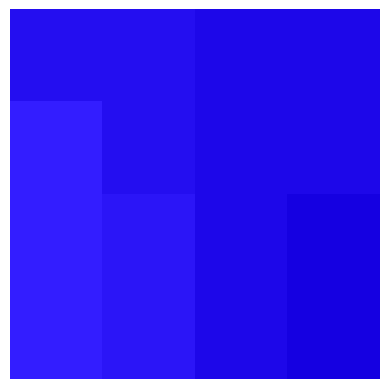

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window
    
    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)
    
    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()



# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor) 


In [8]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

# Applying patch embedding on  patches

In [9]:
# Load the image file
image_path = 'test.jpg'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[-0.2707,  0.2740, -0.3679,  ..., -0.2265, -0.1784,  0.0184],
         [-0.2082,  0.1926, -0.4290,  ..., -0.3738, -0.2032, -0.0664],
         [-0.2194,  0.2024, -0.4390,  ..., -0.3874, -0.2143, -0.0589],
         ...,
         [-0.2274,  0.3031, -0.6996,  ..., -0.6924, -0.4110, -0.1946],
         [-0.2483,  0.3217, -0.6953,  ..., -0.7048, -0.4200, -0.1874],
         [-0.2395,  0.3230, -0.7178,  ..., -0.7188, -0.4295, -0.1942]]],
       grad_fn=<TransposeBackward0>)

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.

The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

# 1st patch embedding vector

In [10]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([-0.2707,  0.2740, -0.3679, -0.4350,  0.0689,  0.0895, -0.4461, -0.3043,
        -0.4636, -0.1311, -0.2037, -0.1369, -0.0836,  0.1075, -0.0304, -0.1585,
         0.3106, -0.3636, -0.2956,  0.0143, -0.1306, -0.1727, -0.3429, -0.0301,
         0.3113, -0.3194,  0.0394,  0.0211,  0.1536, -0.0912,  0.0822, -0.0835,
        -0.1392,  0.2250, -0.1528, -0.1293, -0.6014,  0.0069,  0.0230, -0.2460,
        -0.2404,  0.0540, -0.2386,  0.0488, -0.0904, -0.1875, -0.2068, -0.1911,
         0.0419, -0.2126,  0.1438,  0.4557,  0.3255, -0.2378, -0.2617, -0.0640,
         0.0509, -0.1243,  0.1318,  0.1626,  0.1431, -0.2975,  0.1514, -0.2456,
         0.0262, -0.1300, -0.3377,  0.0167,  0.0464, -0.4519,  0.1442, -0.3267,
        -0.3788,  0.0476, -0.0824, -0.0527,  0.0925,  0.3896,  0.0065, -0.2226,
         0.2226,  0.1694,  0.3389, -0.1998,  0.5470, -0.1669, -0.1277,  0.1140,
         0.0740,  0.5393, -0.0020, -0.0675, -0.1992, -0.2265, -0.1784,  0.0184],
       gr

# Using BasicLayer : Swin Transformer layer for one stage

In [11]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


torch.Size([1, 3136, 96])


C:\Users\kbthe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[-1.3529, -0.1350,  0.4661,  ..., -0.5553,  0.2130, -0.0462],
         [-1.2489, -0.2551,  0.4650,  ..., -0.7213,  0.1640, -0.2241],
         [-1.2550, -0.2390,  0.4508,  ..., -0.7341,  0.1483, -0.2103],
         ...,
         [-1.2844, -0.2221,  0.0654,  ..., -1.0160,  0.0423, -0.3939],
         [-1.3058, -0.2052,  0.0651,  ..., -1.0219,  0.0361, -0.3737],
         [-1.2916, -0.1986,  0.0437,  ..., -1.0372,  0.0230, -0.3831]]],
       grad_fn=<AddBackward0>)

# Patch Merging

##### USing patch merging on the embedding

In [12]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [13]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

Using SwinTransformerBlock class on the patch embedding embedding

In [14]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[-0.2502,  0.2691, -0.9257,  ..., -0.6916, -0.6462, -0.2759],
         [-0.1604,  0.1845, -0.9412,  ..., -0.7781, -0.6181, -0.3601],
         [-0.1723,  0.1946, -0.9529,  ..., -0.7911, -0.6320, -0.3491],
         ...,
         [-0.1428,  0.3009, -1.2287,  ..., -1.0407, -0.7328, -0.5381],
         [-0.1605,  0.3177, -1.2298,  ..., -1.0581, -0.7409, -0.5257],
         [-0.1474,  0.3175, -1.2488,  ..., -1.0676, -0.7486, -0.5357]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.1773,  0.2951,  0.6269,  ..., -0.6498, -0.2378,  0.5823],
         [ 0.1550,  0.1955,  0.5392,  ..., -0.8314, -0.2056,  0.5733],
         [ 0.2504,  0.1481,  0.6877,  ..., -0.7987, -0.1883,  0.4001],
         ...,
         [ 0.1825,  0.2155,  0.3261,  ..., -1.0595, -0.2967,  0.3693],
         [ 0.1626,  0.2345,  0.3319,  ..., -1.0703, -0.3126,  0.3813],
         [ 0.1675,  0.2319,  0.3045,  ..., -1.0793, -0.3192,  0.3777]]],
       grad_fn=<AddBackward0>)


# SwinTransformer :

In [15]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

# Now, Let's work with custom dataset

In [23]:
import os

current_directory = os.getcwd()
train_dir = os.path.join(current_directory, "train")
test_dir = os.path.join(current_directory, "test")

# Corrected print statement
print(train_dir)  # or print(test_dir), depending on what you intended
print(test_dir)

C:\Users\kbthe\Documents\plant\Swin-Transformer-main\train
C:\Users\kbthe\Documents\plant\Swin-Transformer-main\test


# Create Datasets and DataLoaders

In [24]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [25]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [26]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x21615799070>,
 ['Apple___Apple_scab', 'Corn_(maize)___Common_rust_'])

torch.Size([3, 224, 224]) tensor(1)


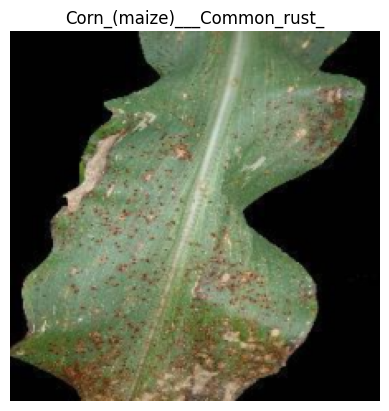

In [27]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [28]:
model = SwinTransformer(num_classes=len(class_names))

In [29]:
from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8854 | train_acc: 0.5815 | test_loss: 1.1778 | test_acc: 0.4909
Epoch: 2 | train_loss: 0.6525 | train_acc: 0.6304 | test_loss: 0.7583 | test_acc: 0.5091
Epoch: 3 | train_loss: 0.5506 | train_acc: 0.7187 | test_loss: 0.6520 | test_acc: 0.4909
Epoch: 4 | train_loss: 0.4513 | train_acc: 0.7905 | test_loss: 0.3086 | test_acc: 0.8918
Epoch: 5 | train_loss: 0.2748 | train_acc: 0.8996 | test_loss: 0.2705 | test_acc: 0.8837
Epoch: 6 | train_loss: 0.2424 | train_acc: 0.9053 | test_loss: 0.2301 | test_acc: 0.9069
Epoch: 7 | train_loss: 0.2520 | train_acc: 0.9018 | test_loss: 0.2221 | test_acc: 0.9395
Epoch: 8 | train_loss: 0.2570 | train_acc: 0.8982 | test_loss: 0.2538 | test_acc: 0.9139
Epoch: 9 | train_loss: 0.2394 | train_acc: 0.9065 | test_loss: 0.2567 | test_acc: 0.8938
Epoch: 10 | train_loss: 0.2416 | train_acc: 0.9097 | test_loss: 0.2022 | test_acc: 0.9330


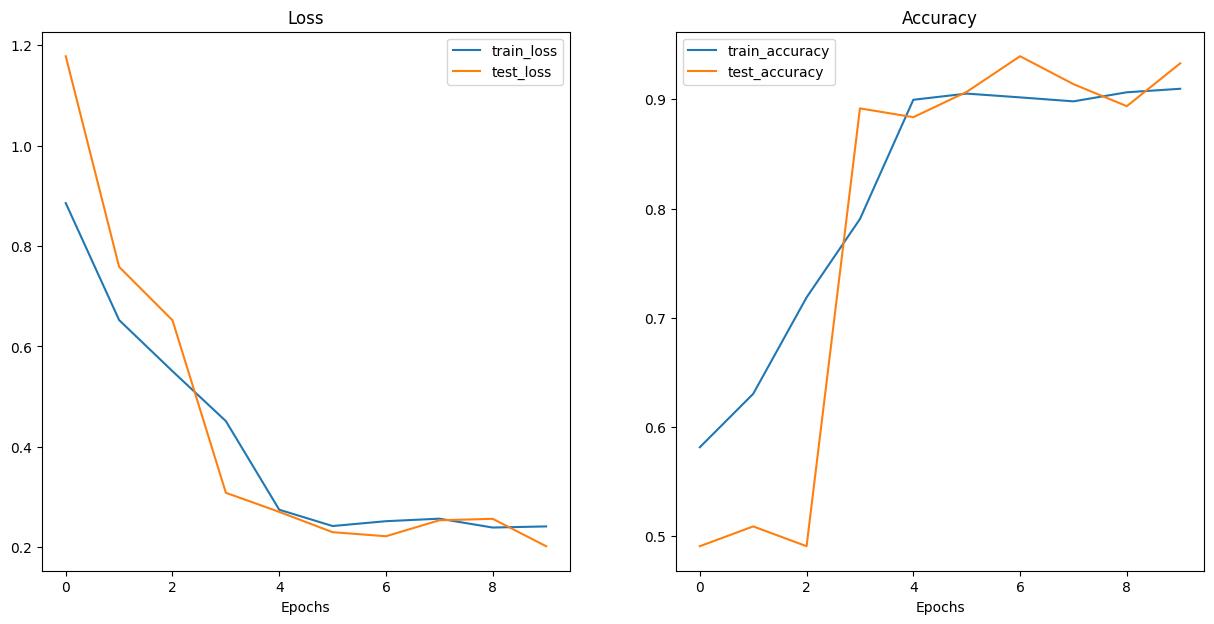

In [30]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Prediction

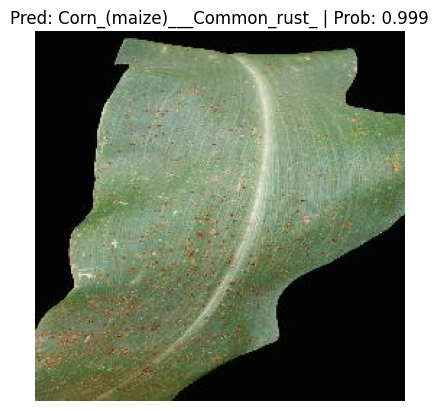

In [35]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "RS_Rust 1574.JPG"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)